# Demo: Denoising of 2D simulated images

This notebook showcases the training of an SN2N 2DUnet model for a 2D denoising task using simulated MT data generated by ourselves.

In [1]:
import os
import sys
import numpy as np
from SN2N.datagen import generator2D
from SN2N.get_options import datagen2D

## Simulated data

We created microtubule-like structures by utilizing the insertShape function in MATLAB to draw multiple lines with random orientations. The simulation included the effects of incomplete labeling observed in practical experiments through the application of a small Gaussian mask and elastic deformation, mimicking the curviness of the cytoskeleton. The synthetic structures were convolved with a 150 nm size PSF and downsampled by 2-fold, resulting in 2048 x 2048 pixels with a 32.5 nm pixel size (simulated blurred ground-truth).A photon count of 50 a.u. (Level 2) was assigned to the synthetic structures for intensity emissions. Subsequently, Poisson noise injection was applied, followed by the addition of Gaussian readout noise with a fixed amplitude of 25 a.u. **The 2D dataset can be found at 'examples/denoising2D' path.** 

<p>
<img src='./imgs/simulation-workflow.png' align="left" width=500>
</p>

## Generating training data for SN2N

We first need to use raw_data to generate SN2N data pairs.  
When generating data pairs, we need to first confirm and <font color="red">set important parameters</font> related to data generation.

-----Parameters------  
<font color="red">=====Important==========</font>  
- <span style="color:blue">img_path:</span>  
    Path of raw images to train.  
- <span style="color:blue">P2Pmode(0 ~ 3):</span>  
    Augmentation mode for Patch2Patch.  
    0: NONE;  
    1: Direct interchange in t;  
    2: Interchange in single frame;  
    3: Interchange in multiple frame but in different regions;  
    {default: 0}  
- <span style="color:blue">P2Pup:</span>  
    Increase the dataset to its (1 + P2Pup) times size.  
    {default: 0}  
- <span style="color:blue">BAmode(0 ~ 2)</span>  
    Basic augmentation mode.  
    0: NONE;  
    1: double the dataset with random rotate&flip;  
    2: eightfold the dataset with random rotate&flip;  
    {default: 0}  
- <span style="color:blue">SWsize</span>  
    Interval pixel of sliding window for generating image pathes.  
    {default: 64}  
    
<font color="red">======Other parameters do not require modification; for details, refer to SN2N.get_options.datagen2D.========</font>  


#### Step 1: Define custom parameters.
We use one raw image and apply both P2P augmentation and basic augmentation to demonstrate SN2N's ability to denoise using only one original noisy image. 

In [2]:
img_path = 'data/raw_data'
P2Pmode = '2'
P2Pup = '6'
BAmode = '2'
SWsize = '64' 


datagen2D_args = [
    '--img_path', img_path,
    '--P2Pmode', P2Pmode,
    '--P2Pup', P2Pup,
    '--BAmode', BAmode,
    '--SWsize', SWsize        
]

args = datagen2D(datagen2D_args)
print("Arguments received:", args)

Arguments received: Namespace(BAmode=2, P2Pmode=2, P2Ppatch='64', P2Pup=6, SWfilter=1, SWmode=1, SWsize=64, ifx2=True, img_patch='128', img_path='data/raw_data', inter_mode='Fourier')


#### Step 2: Execute data generation.

The <font color="red">raw data</font> used for generating training data is stored in the <font color="red">'Path:/raw_data'</font> directory, and the generated <font color="red">training data pairs</font> are by default stored in the <font color="red">'Path:/datasets'</font>

In [3]:
d = generator2D(img_path=args.img_path, P2Pmode = args.P2Pmode, P2Pup = args.P2Pup, BAmode = args.BAmode, SWsize = args.SWsize)
d.execute()
print("Data generation completed.")

The path for the raw images used for training is located under:
data/raw_data
The training dataset is being saved under:
data\datasets
For number 1 frame
Saving training images: 100
Saving training images: 200
Saving training images: 300
Saving training images: 400
Saving training images: 500
Saving training images: 600
Saving training images: 700
Saving training images: 800
Saving training images: 900
Saving training images: 1000
Saving training images: 1100
Saving training images: 1200
Saving training images: 1300
Saving training images: 1400
Saving training images: 1500
Saving training images: 1600
Saving training images: 1700
Saving training images: 1800
Saving training images: 1900
Saving training images: 2000
Saving training images: 2100
Saving training images: 2200
Saving training images: 2300
Saving training images: 2400
Saving training images: 2500
Saving training images: 2600
Saving training images: 2700
Saving training images: 2800
Saving training images: 2900
Saving trainin

## Show some generated patches

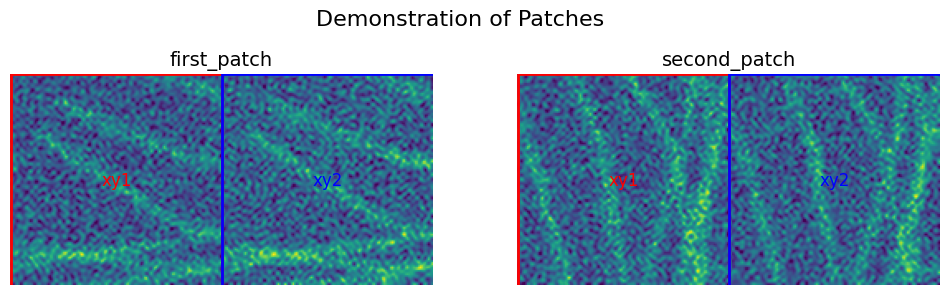

In [4]:
import tifffile
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from PIL import Image

dataset_path = d.dataset_path
tif_files = [f for f in os.listdir(dataset_path) if f.endswith('.tif')]
first_patch = tifffile.imread(os.path.join(dataset_path, tif_files[0]))
second_patch = tifffile.imread(os.path.join(dataset_path, tif_files[1]))

fig, axs = plt.subplots(1, 2, figsize=(12, 3.5))


im1 = axs[0].imshow(first_patch)
axs[0].set_title('first_patch', fontsize=14)
axs[0].axis('off') 
axs[0].add_patch(Rectangle((0, 0), first_patch.shape[1] // 2, first_patch.shape[0], linewidth=2, edgecolor='r', facecolor='none'))
axs[0].add_patch(Rectangle((first_patch.shape[1] // 2, 0), first_patch.shape[1] // 2, first_patch.shape[0], linewidth=2, edgecolor='b', facecolor='none'))


axs[0].text(first_patch.shape[1] // 4, first_patch.shape[0] // 2, 'xy1', fontsize=12, color='r', ha='center', va='center')
axs[0].text(3 * first_patch.shape[1] // 4, first_patch.shape[0] // 2, 'xy2', fontsize=12, color='b', ha='center', va='center')


im2 = axs[1].imshow(second_patch)
axs[1].set_title('second_patch', fontsize=14)
axs[1].axis('off') 
axs[1].add_patch(Rectangle((0, 0), second_patch.shape[1] // 2, second_patch.shape[0], linewidth=2, edgecolor='r', facecolor='none'))
axs[1].add_patch(Rectangle((second_patch.shape[1] // 2, 0), second_patch.shape[1] // 2, second_patch.shape[0], linewidth=2, edgecolor='b', facecolor='none'))


axs[1].text(second_patch.shape[1] // 4, second_patch.shape[0] // 2, 'xy1', fontsize=12, color='r', ha='center', va='center')
axs[1].text(3 * second_patch.shape[1] // 4, second_patch.shape[0] // 2, 'xy2', fontsize=12, color='b', ha='center', va='center')


fig.suptitle('Demonstration of Patches', fontsize=16)


plt.show()

## Training data

We need to use training data pairs to train SN2N model.  
When training, we need to first confirm and <font color="red">set important parameters</font> related to trainers.

-----Parameters------  
<font color="red">=====Important==========</font>  
- <span style="color:blue">img_path:</span>  
    Path of raw images to train.  
- <span style="color:blue">sn2n_loss:</span>  
    Weight of self-constrained loss.  
    <span style="color:red">One of the most crucial parameters that needs adjustment， generally set to 0~2.</span>  
    A higher sn2n_loss weight implies relatively better denoising and more pronounced smoothing effects.  
    {default: 1}  
- <span style="color:blue">bs:</span>  
    Training batch size.  
    {default: 32}  
- <span style="color:blue">lr</span>  
    Learning rate.       
    {default: 2e-4}  
- <span style="color:blue">epochs</span>  
    Total number of training epochs.  
    {default: 100}  
    
<font color="red">======Other parameters do not require modification; for details, refer to SN2N.get_options.trainer2D.========</font>  

#### Step 1: Define custom parameters.

In [5]:
from SN2N.trainer import net2D
from SN2N.get_options import trainer2D

img_path = 'data/raw_data'
sn2n_loss = '1'
bs = '32'
lr = '2e-4'
epochs = '100'

trainer2D_args = [
    '--img_path', img_path,
    '--sn2n_loss', sn2n_loss,
    '--bs', bs,
    '--lr', lr,
    '--epochs', epochs
]

args = trainer2D(trainer2D_args)
print("Arguments received:", args)

Arguments received: Namespace(bs=32, epochs=100, if_alr=True, img_patch='128', img_path='data/raw_data', lr=0.0002, sn2n_loss=1.0)


#### Step 2: Execute training.

The <font color="red">raw data</font> used for generating training data is stored in the <font color="red">'Path:/raw_data'</font> directory  
the <font color="red">models</font> are by default stored in the <font color="red">'Path:/models'</font>  
During the training process, we also performed real-time predictions for the first image in the raw_data for each epoch as predicted images. The <font color="red">images</font> results are by default stored in the <font color="red">'Path:/images'</font> directory.

In [6]:
sn2nunet = net2D(img_path = args.img_path, sn2n_loss = args.sn2n_loss, bs = args.bs, lr = args.lr, epochs = args.epochs)
sn2nunet.train()
print("Training completed.")

The path for the raw images used for training is located under:
data/raw_data
The training dataset is being saved under:
data\datasets
Models is being saved under:
data\models
Training temporary prediction images is being saved under:
data\images
[Epoch 0/100] [Batch 0/839] [loss:15.619060] time:0:00:02.851460
[Epoch 0/100] [Batch 1/839] [loss:11.534524] time:0:00:03.039830
[Epoch 0/100] [Batch 2/839] [loss:13.725549] time:0:00:03.088667
[Epoch 0/100] [Batch 3/839] [loss:11.048304] time:0:00:03.136507
[Epoch 0/100] [Batch 4/839] [loss:10.812026] time:0:00:03.182353
[Epoch 0/100] [Batch 5/839] [loss:9.171923] time:0:00:03.228200
[Epoch 0/100] [Batch 6/839] [loss:9.669471] time:0:00:03.274047
[Epoch 0/100] [Batch 7/839] [loss:9.147389] time:0:00:03.321887
[Epoch 0/100] [Batch 8/839] [loss:8.459072] time:0:00:03.369727
[Epoch 0/100] [Batch 9/839] [loss:8.612552] time:0:00:03.416570
[Epoch 0/100] [Batch 10/839] [loss:7.267167] time:0:00:03.462416
[Epoch 0/100] [Batch 11/839] [loss:8.409344

[Epoch 0/100] [Batch 122/839] [loss:6.647766] time:0:00:08.666009
[Epoch 0/100] [Batch 123/839] [loss:6.572396] time:0:00:08.712852
[Epoch 0/100] [Batch 124/839] [loss:6.779090] time:0:00:08.759695
[Epoch 0/100] [Batch 125/839] [loss:6.447943] time:0:00:08.806538
[Epoch 0/100] [Batch 126/839] [loss:6.359147] time:0:00:08.852385
[Epoch 0/100] [Batch 127/839] [loss:7.262433] time:0:00:08.899228
[Epoch 0/100] [Batch 128/839] [loss:6.296079] time:0:00:08.947068
[Epoch 0/100] [Batch 129/839] [loss:6.211451] time:0:00:08.994908
[Epoch 0/100] [Batch 130/839] [loss:6.318893] time:0:00:09.040755
[Epoch 0/100] [Batch 131/839] [loss:6.216193] time:0:00:09.086601
[Epoch 0/100] [Batch 132/839] [loss:6.374650] time:0:00:09.133445
[Epoch 0/100] [Batch 133/839] [loss:6.665955] time:0:00:09.180288
[Epoch 0/100] [Batch 134/839] [loss:6.201514] time:0:00:09.226135
[Epoch 0/100] [Batch 135/839] [loss:7.733239] time:0:00:09.271981
[Epoch 0/100] [Batch 136/839] [loss:6.784184] time:0:00:09.320818
[Epoch 0/1

[Epoch 0/100] [Batch 247/839] [loss:5.921102] time:0:00:14.526427
[Epoch 0/100] [Batch 248/839] [loss:7.629687] time:0:00:14.574267
[Epoch 0/100] [Batch 249/839] [loss:6.725460] time:0:00:14.621111
[Epoch 0/100] [Batch 250/839] [loss:7.054162] time:0:00:14.667954
[Epoch 0/100] [Batch 251/839] [loss:6.094550] time:0:00:14.714797
[Epoch 0/100] [Batch 252/839] [loss:6.475300] time:0:00:14.762637
[Epoch 0/100] [Batch 253/839] [loss:6.356370] time:0:00:14.810477
[Epoch 0/100] [Batch 254/839] [loss:5.760321] time:0:00:14.857320
[Epoch 0/100] [Batch 255/839] [loss:6.838629] time:0:00:14.904164
[Epoch 0/100] [Batch 256/839] [loss:6.283963] time:0:00:14.950010
[Epoch 0/100] [Batch 257/839] [loss:5.786447] time:0:00:14.997850
[Epoch 0/100] [Batch 258/839] [loss:6.591962] time:0:00:15.044694
[Epoch 0/100] [Batch 259/839] [loss:7.013664] time:0:00:15.091537
[Epoch 0/100] [Batch 260/839] [loss:6.269110] time:0:00:15.138380
[Epoch 0/100] [Batch 261/839] [loss:5.796713] time:0:00:15.185224
[Epoch 0/1

[Epoch 0/100] [Batch 372/839] [loss:7.488827] time:0:00:20.379119
[Epoch 0/100] [Batch 373/839] [loss:6.667699] time:0:00:20.425963
[Epoch 0/100] [Batch 374/839] [loss:6.205882] time:0:00:20.472806
[Epoch 0/100] [Batch 375/839] [loss:7.528259] time:0:00:20.518652
[Epoch 0/100] [Batch 376/839] [loss:7.006405] time:0:00:20.566492
[Epoch 0/100] [Batch 377/839] [loss:6.492636] time:0:00:20.613335
[Epoch 0/100] [Batch 378/839] [loss:6.205732] time:0:00:20.661176
[Epoch 0/100] [Batch 379/839] [loss:6.596523] time:0:00:20.708019
[Epoch 0/100] [Batch 380/839] [loss:6.124483] time:0:00:20.754862
[Epoch 0/100] [Batch 381/839] [loss:6.612612] time:0:00:20.800709
[Epoch 0/100] [Batch 382/839] [loss:7.118160] time:0:00:20.847552
[Epoch 0/100] [Batch 383/839] [loss:6.289810] time:0:00:20.894396
[Epoch 0/100] [Batch 384/839] [loss:6.545263] time:0:00:20.941238
[Epoch 0/100] [Batch 385/839] [loss:6.040027] time:0:00:20.987085
[Epoch 0/100] [Batch 386/839] [loss:6.286091] time:0:00:21.032932
[Epoch 0/1

[Epoch 0/100] [Batch 497/839] [loss:6.632273] time:0:00:26.247830
[Epoch 0/100] [Batch 498/839] [loss:7.380048] time:0:00:26.294673
[Epoch 0/100] [Batch 499/839] [loss:5.872398] time:0:00:26.341517
[Epoch 0/100] [Batch 500/839] [loss:6.326196] time:0:00:26.389357
[Epoch 0/100] [Batch 501/839] [loss:6.433543] time:0:00:26.436200
[Epoch 0/100] [Batch 502/839] [loss:7.253437] time:0:00:26.483043
[Epoch 0/100] [Batch 503/839] [loss:7.011361] time:0:00:26.530883
[Epoch 0/100] [Batch 504/839] [loss:5.935150] time:0:00:26.577727
[Epoch 0/100] [Batch 505/839] [loss:5.962832] time:0:00:26.624570
[Epoch 0/100] [Batch 506/839] [loss:6.865978] time:0:00:26.671413
[Epoch 0/100] [Batch 507/839] [loss:6.491701] time:0:00:26.720250
[Epoch 0/100] [Batch 508/839] [loss:6.093001] time:0:00:26.768090
[Epoch 0/100] [Batch 509/839] [loss:6.954068] time:0:00:26.814933
[Epoch 0/100] [Batch 510/839] [loss:6.104023] time:0:00:26.861777
[Epoch 0/100] [Batch 511/839] [loss:6.368686] time:0:00:26.908620
[Epoch 0/1

[Epoch 0/100] [Batch 622/839] [loss:7.224948] time:0:00:32.135138
[Epoch 0/100] [Batch 623/839] [loss:6.094166] time:0:00:32.181981
[Epoch 0/100] [Batch 624/839] [loss:8.420794] time:0:00:32.227828
[Epoch 0/100] [Batch 625/839] [loss:6.020731] time:0:00:32.274671
[Epoch 0/100] [Batch 626/839] [loss:7.081424] time:0:00:32.320518
[Epoch 0/100] [Batch 627/839] [loss:5.742837] time:0:00:32.368357
[Epoch 0/100] [Batch 628/839] [loss:5.944304] time:0:00:32.415201
[Epoch 0/100] [Batch 629/839] [loss:5.993638] time:0:00:32.462044
[Epoch 0/100] [Batch 630/839] [loss:5.957156] time:0:00:32.508887
[Epoch 0/100] [Batch 631/839] [loss:7.104102] time:0:00:32.555731
[Epoch 0/100] [Batch 632/839] [loss:6.272836] time:0:00:32.602574
[Epoch 0/100] [Batch 633/839] [loss:6.470408] time:0:00:32.650414
[Epoch 0/100] [Batch 634/839] [loss:6.227528] time:0:00:32.697257
[Epoch 0/100] [Batch 635/839] [loss:6.443921] time:0:00:32.744101
[Epoch 0/100] [Batch 636/839] [loss:5.755251] time:0:00:32.790944
[Epoch 0/1

[Epoch 0/100] [Batch 747/839] [loss:6.184521] time:0:00:37.980583
[Epoch 0/100] [Batch 748/839] [loss:7.636917] time:0:00:38.026429
[Epoch 0/100] [Batch 749/839] [loss:5.971014] time:0:00:38.073272
[Epoch 0/100] [Batch 750/839] [loss:5.753600] time:0:00:38.120116
[Epoch 0/100] [Batch 751/839] [loss:6.246908] time:0:00:38.165962
[Epoch 0/100] [Batch 752/839] [loss:6.621726] time:0:00:38.212806
[Epoch 0/100] [Batch 753/839] [loss:6.295287] time:0:00:38.258652
[Epoch 0/100] [Batch 754/839] [loss:6.984991] time:0:00:38.305496
[Epoch 0/100] [Batch 755/839] [loss:6.947906] time:0:00:38.351342
[Epoch 0/100] [Batch 756/839] [loss:6.395186] time:0:00:38.398185
[Epoch 0/100] [Batch 757/839] [loss:5.918481] time:0:00:38.446025
[Epoch 0/100] [Batch 758/839] [loss:6.717212] time:0:00:38.492868
[Epoch 0/100] [Batch 759/839] [loss:7.027455] time:0:00:38.539712
[Epoch 0/100] [Batch 760/839] [loss:5.880562] time:0:00:38.586555
[Epoch 0/100] [Batch 761/839] [loss:6.223513] time:0:00:38.632402
[Epoch 0/1

[Epoch 1/100] [Batch 35/839] [loss:6.470898] time:0:00:44.591492
[Epoch 1/100] [Batch 36/839] [loss:6.343386] time:0:00:44.639332
[Epoch 1/100] [Batch 37/839] [loss:5.985523] time:0:00:44.686175
[Epoch 1/100] [Batch 38/839] [loss:6.095321] time:0:00:44.733019
[Epoch 1/100] [Batch 39/839] [loss:6.049757] time:0:00:44.779862
[Epoch 1/100] [Batch 40/839] [loss:7.053208] time:0:00:44.827702
[Epoch 1/100] [Batch 41/839] [loss:6.051092] time:0:00:44.876539
[Epoch 1/100] [Batch 42/839] [loss:5.998219] time:0:00:44.923382
[Epoch 1/100] [Batch 43/839] [loss:6.403275] time:0:00:44.969228
[Epoch 1/100] [Batch 44/839] [loss:6.137938] time:0:00:45.015075
[Epoch 1/100] [Batch 45/839] [loss:6.365895] time:0:00:45.061918
[Epoch 1/100] [Batch 46/839] [loss:6.325853] time:0:00:45.108762
[Epoch 1/100] [Batch 47/839] [loss:6.639481] time:0:00:45.155605
[Epoch 1/100] [Batch 48/839] [loss:5.672788] time:0:00:45.202448
[Epoch 1/100] [Batch 49/839] [loss:6.021912] time:0:00:45.249292
[Epoch 1/100] [Batch 50/8

[Epoch 1/100] [Batch 165/839] [loss:6.303576] time:0:00:50.728786
[Epoch 1/100] [Batch 166/839] [loss:6.154483] time:0:00:50.776626
[Epoch 1/100] [Batch 167/839] [loss:5.830259] time:0:00:50.823469
[Epoch 1/100] [Batch 168/839] [loss:6.330504] time:0:00:50.869315
[Epoch 1/100] [Batch 169/839] [loss:5.912574] time:0:00:50.916159
[Epoch 1/100] [Batch 170/839] [loss:9.013757] time:0:00:50.963999
[Epoch 1/100] [Batch 171/839] [loss:6.456085] time:0:00:51.010842
[Epoch 1/100] [Batch 172/839] [loss:6.357723] time:0:00:51.056688
[Epoch 1/100] [Batch 173/839] [loss:6.141540] time:0:00:51.102535
[Epoch 1/100] [Batch 174/839] [loss:6.218177] time:0:00:51.148382
[Epoch 1/100] [Batch 175/839] [loss:6.219719] time:0:00:51.195225
[Epoch 1/100] [Batch 176/839] [loss:5.761757] time:0:00:51.243065
[Epoch 1/100] [Batch 177/839] [loss:5.836744] time:0:00:51.289908
[Epoch 1/100] [Batch 178/839] [loss:6.981711] time:0:00:51.336752
[Epoch 1/100] [Batch 179/839] [loss:6.149241] time:0:00:51.383595
[Epoch 1/1

[Epoch 1/100] [Batch 290/839] [loss:5.929942] time:0:00:56.665059
[Epoch 1/100] [Batch 291/839] [loss:6.216215] time:0:00:56.713895
[Epoch 1/100] [Batch 292/839] [loss:6.067427] time:0:00:56.762732
[Epoch 1/100] [Batch 293/839] [loss:6.832893] time:0:00:56.809575
[Epoch 1/100] [Batch 294/839] [loss:6.765455] time:0:00:56.857415
[Epoch 1/100] [Batch 295/839] [loss:6.532523] time:0:00:56.906252
[Epoch 1/100] [Batch 296/839] [loss:6.868133] time:0:00:56.956085
[Epoch 1/100] [Batch 297/839] [loss:6.137760] time:0:00:57.002928
[Epoch 1/100] [Batch 298/839] [loss:5.991763] time:0:00:57.050768
[Epoch 1/100] [Batch 299/839] [loss:6.936252] time:0:00:57.099690
[Epoch 1/100] [Batch 300/839] [loss:7.550223] time:0:00:57.149523
[Epoch 1/100] [Batch 301/839] [loss:6.151744] time:0:00:57.198360
[Epoch 1/100] [Batch 302/839] [loss:5.999463] time:0:00:57.246973
[Epoch 1/100] [Batch 303/839] [loss:6.031127] time:0:00:57.294813
[Epoch 1/100] [Batch 304/839] [loss:5.983269] time:0:00:57.342653
[Epoch 1/1

[Epoch 1/100] [Batch 415/839] [loss:6.173314] time:0:01:02.634948
[Epoch 1/100] [Batch 416/839] [loss:6.419915] time:0:01:02.682788
[Epoch 1/100] [Batch 417/839] [loss:6.276879] time:0:01:02.730628
[Epoch 1/100] [Batch 418/839] [loss:6.125834] time:0:01:02.777472
[Epoch 1/100] [Batch 419/839] [loss:6.274335] time:0:01:02.825312
[Epoch 1/100] [Batch 420/839] [loss:7.266228] time:0:01:02.873152
[Epoch 1/100] [Batch 421/839] [loss:6.655055] time:0:01:02.919995
[Epoch 1/100] [Batch 422/839] [loss:7.077396] time:0:01:02.966838
[Epoch 1/100] [Batch 423/839] [loss:7.241201] time:0:01:03.013681
[Epoch 1/100] [Batch 424/839] [loss:6.188365] time:0:01:03.059528
[Epoch 1/100] [Batch 425/839] [loss:6.177707] time:0:01:03.106371
[Epoch 1/100] [Batch 426/839] [loss:6.140481] time:0:01:03.154211
[Epoch 1/100] [Batch 427/839] [loss:6.070699] time:0:01:03.201054
[Epoch 1/100] [Batch 428/839] [loss:5.788368] time:0:01:03.247898
[Epoch 1/100] [Batch 429/839] [loss:5.779036] time:0:01:03.293744
[Epoch 1/1

[Epoch 1/100] [Batch 540/839] [loss:6.544315] time:0:01:08.546173
[Epoch 1/100] [Batch 541/839] [loss:5.637654] time:0:01:08.593016
[Epoch 1/100] [Batch 542/839] [loss:5.776972] time:0:01:08.639860
[Epoch 1/100] [Batch 543/839] [loss:6.512797] time:0:01:08.686703
[Epoch 1/100] [Batch 544/839] [loss:5.728031] time:0:01:08.733546
[Epoch 1/100] [Batch 545/839] [loss:6.135372] time:0:01:08.781386
[Epoch 1/100] [Batch 546/839] [loss:5.969676] time:0:01:08.828230
[Epoch 1/100] [Batch 547/839] [loss:7.227868] time:0:01:08.876070
[Epoch 1/100] [Batch 548/839] [loss:6.054145] time:0:01:08.922913
[Epoch 1/100] [Batch 549/839] [loss:5.622142] time:0:01:08.968759
[Epoch 1/100] [Batch 550/839] [loss:5.795857] time:0:01:09.016599
[Epoch 1/100] [Batch 551/839] [loss:6.209968] time:0:01:09.063443
[Epoch 1/100] [Batch 552/839] [loss:6.383505] time:0:01:09.111283
[Epoch 1/100] [Batch 553/839] [loss:6.168307] time:0:01:09.157129
[Epoch 1/100] [Batch 554/839] [loss:5.845251] time:0:01:09.203972
[Epoch 1/1

[Epoch 1/100] [Batch 665/839] [loss:5.981434] time:0:01:14.478339
[Epoch 1/100] [Batch 666/839] [loss:5.516716] time:0:01:14.528172
[Epoch 1/100] [Batch 667/839] [loss:5.871936] time:0:01:14.577009
[Epoch 1/100] [Batch 668/839] [loss:5.795340] time:0:01:14.625846
[Epoch 1/100] [Batch 669/839] [loss:6.361206] time:0:01:14.673686
[Epoch 1/100] [Batch 670/839] [loss:5.658802] time:0:01:14.723519
[Epoch 1/100] [Batch 671/839] [loss:6.368624] time:0:01:14.771359
[Epoch 1/100] [Batch 672/839] [loss:6.411749] time:0:01:14.819199
[Epoch 1/100] [Batch 673/839] [loss:5.929254] time:0:01:14.866043
[Epoch 1/100] [Batch 674/839] [loss:5.857053] time:0:01:14.913882
[Epoch 1/100] [Batch 675/839] [loss:6.514099] time:0:01:14.961722
[Epoch 1/100] [Batch 676/839] [loss:6.831489] time:0:01:15.009562
[Epoch 1/100] [Batch 677/839] [loss:6.176424] time:0:01:15.057402
[Epoch 1/100] [Batch 678/839] [loss:5.879835] time:0:01:15.105278
[Epoch 1/100] [Batch 679/839] [loss:5.859446] time:0:01:15.154078
[Epoch 1/1

[Epoch 1/100] [Batch 790/839] [loss:6.038346] time:0:01:20.455890
[Epoch 1/100] [Batch 791/839] [loss:6.292012] time:0:01:20.504726
[Epoch 1/100] [Batch 792/839] [loss:6.116733] time:0:01:20.552566
[Epoch 1/100] [Batch 793/839] [loss:6.822027] time:0:01:20.599410
[Epoch 1/100] [Batch 794/839] [loss:5.678543] time:0:01:20.646253
[Epoch 1/100] [Batch 795/839] [loss:6.275628] time:0:01:20.695090
[Epoch 1/100] [Batch 796/839] [loss:5.592199] time:0:01:20.741933
[Epoch 1/100] [Batch 797/839] [loss:6.059357] time:0:01:20.789773
[Epoch 1/100] [Batch 798/839] [loss:5.273028] time:0:01:20.836616
[Epoch 1/100] [Batch 799/839] [loss:5.677398] time:0:01:20.884456
[Epoch 1/100] [Batch 800/839] [loss:5.696920] time:0:01:20.933293
[Epoch 1/100] [Batch 801/839] [loss:6.670403] time:0:01:20.980136
[Epoch 1/100] [Batch 802/839] [loss:7.321486] time:0:01:21.026979
[Epoch 1/100] [Batch 803/839] [loss:6.450687] time:0:01:21.073822
[Epoch 1/100] [Batch 804/839] [loss:6.111440] time:0:01:21.120666
[Epoch 1/1

[Epoch 2/100] [Batch 80/839] [loss:6.185930] time:0:01:27.173632
[Epoch 2/100] [Batch 81/839] [loss:5.871974] time:0:01:27.220475
[Epoch 2/100] [Batch 82/839] [loss:6.228117] time:0:01:27.268315
[Epoch 2/100] [Batch 83/839] [loss:6.345182] time:0:01:27.315158
[Epoch 2/100] [Batch 84/839] [loss:6.083089] time:0:01:27.362002
[Epoch 2/100] [Batch 85/839] [loss:5.861447] time:0:01:27.410838
[Epoch 2/100] [Batch 86/839] [loss:6.203438] time:0:01:27.459675
[Epoch 2/100] [Batch 87/839] [loss:8.812460] time:0:01:27.507515
[Epoch 2/100] [Batch 88/839] [loss:6.347671] time:0:01:27.554358
[Epoch 2/100] [Batch 89/839] [loss:5.974001] time:0:01:27.602198
[Epoch 2/100] [Batch 90/839] [loss:7.104779] time:0:01:27.650038
[Epoch 2/100] [Batch 91/839] [loss:5.907963] time:0:01:27.697878
[Epoch 2/100] [Batch 92/839] [loss:6.420577] time:0:01:27.745718
[Epoch 2/100] [Batch 93/839] [loss:5.957023] time:0:01:27.794555
[Epoch 2/100] [Batch 94/839] [loss:5.637189] time:0:01:27.843391
[Epoch 2/100] [Batch 95/8

[Epoch 2/100] [Batch 205/839] [loss:5.603811] time:0:01:33.142663
[Epoch 2/100] [Batch 206/839] [loss:7.184035] time:0:01:33.191500
[Epoch 2/100] [Batch 207/839] [loss:6.102897] time:0:01:33.238343
[Epoch 2/100] [Batch 208/839] [loss:5.890817] time:0:01:33.286183
[Epoch 2/100] [Batch 209/839] [loss:6.136194] time:0:01:33.333026
[Epoch 2/100] [Batch 210/839] [loss:6.787807] time:0:01:33.382860
[Epoch 2/100] [Batch 211/839] [loss:6.164030] time:0:01:33.433690
[Epoch 2/100] [Batch 212/839] [loss:5.614179] time:0:01:33.481530
[Epoch 2/100] [Batch 213/839] [loss:6.002219] time:0:01:33.531363
[Epoch 2/100] [Batch 214/839] [loss:5.698325] time:0:01:33.579203
[Epoch 2/100] [Batch 215/839] [loss:6.700201] time:0:01:33.628039
[Epoch 2/100] [Batch 216/839] [loss:6.474012] time:0:01:33.675879
[Epoch 2/100] [Batch 217/839] [loss:6.417418] time:0:01:33.724717
[Epoch 2/100] [Batch 218/839] [loss:5.980772] time:0:01:33.772556
[Epoch 2/100] [Batch 219/839] [loss:6.044007] time:0:01:33.820396
[Epoch 2/1

[Epoch 2/100] [Batch 330/839] [loss:7.082553] time:0:01:39.156731
[Epoch 2/100] [Batch 331/839] [loss:6.084074] time:0:01:39.204571
[Epoch 2/100] [Batch 332/839] [loss:6.667471] time:0:01:39.251414
[Epoch 2/100] [Batch 333/839] [loss:6.742851] time:0:01:39.297261
[Epoch 2/100] [Batch 334/839] [loss:6.273071] time:0:01:39.344104
[Epoch 2/100] [Batch 335/839] [loss:6.445471] time:0:01:39.391944
[Epoch 2/100] [Batch 336/839] [loss:6.258479] time:0:01:39.439784
[Epoch 2/100] [Batch 337/839] [loss:6.265894] time:0:01:39.487624
[Epoch 2/100] [Batch 338/839] [loss:6.621090] time:0:01:39.534467
[Epoch 2/100] [Batch 339/839] [loss:6.384620] time:0:01:39.582307
[Epoch 2/100] [Batch 340/839] [loss:7.507443] time:0:01:39.630147
[Epoch 2/100] [Batch 341/839] [loss:6.463479] time:0:01:39.678984
[Epoch 2/100] [Batch 342/839] [loss:6.655237] time:0:01:39.726824
[Epoch 2/100] [Batch 343/839] [loss:5.819706] time:0:01:39.774663
[Epoch 2/100] [Batch 344/839] [loss:5.889311] time:0:01:39.822503
[Epoch 2/1

[Epoch 2/100] [Batch 455/839] [loss:6.318170] time:0:01:45.104089
[Epoch 2/100] [Batch 456/839] [loss:5.925868] time:0:01:45.151929
[Epoch 2/100] [Batch 457/839] [loss:6.541625] time:0:01:45.198772
[Epoch 2/100] [Batch 458/839] [loss:6.068517] time:0:01:45.245615
[Epoch 2/100] [Batch 459/839] [loss:6.532758] time:0:01:45.292459
[Epoch 2/100] [Batch 460/839] [loss:5.953568] time:0:01:45.342292
[Epoch 2/100] [Batch 461/839] [loss:5.727484] time:0:01:45.391129
[Epoch 2/100] [Batch 462/839] [loss:6.430329] time:0:01:45.438968
[Epoch 2/100] [Batch 463/839] [loss:5.998173] time:0:01:45.488802
[Epoch 2/100] [Batch 464/839] [loss:5.917827] time:0:01:45.536642
[Epoch 2/100] [Batch 465/839] [loss:5.558827] time:0:01:45.584482
[Epoch 2/100] [Batch 466/839] [loss:5.977308] time:0:01:45.633318
[Epoch 2/100] [Batch 467/839] [loss:6.132250] time:0:01:45.681158
[Epoch 2/100] [Batch 468/839] [loss:6.142744] time:0:01:45.729995
[Epoch 2/100] [Batch 469/839] [loss:7.596774] time:0:01:45.777835
[Epoch 2/1

[Epoch 2/100] [Batch 580/839] [loss:6.139788] time:0:01:51.135975
[Epoch 2/100] [Batch 581/839] [loss:6.271134] time:0:01:51.183816
[Epoch 2/100] [Batch 582/839] [loss:6.448373] time:0:01:51.231655
[Epoch 2/100] [Batch 583/839] [loss:6.843267] time:0:01:51.279495
[Epoch 2/100] [Batch 584/839] [loss:5.822439] time:0:01:51.327335
[Epoch 2/100] [Batch 585/839] [loss:5.792281] time:0:01:51.376172
[Epoch 2/100] [Batch 586/839] [loss:5.897421] time:0:01:51.425008
[Epoch 2/100] [Batch 587/839] [loss:6.047547] time:0:01:51.472848
[Epoch 2/100] [Batch 588/839] [loss:6.571076] time:0:01:51.521685
[Epoch 2/100] [Batch 589/839] [loss:6.535600] time:0:01:51.570521
[Epoch 2/100] [Batch 590/839] [loss:6.055668] time:0:01:51.619358
[Epoch 2/100] [Batch 591/839] [loss:6.191933] time:0:01:51.667198
[Epoch 2/100] [Batch 592/839] [loss:5.807323] time:0:01:51.715038
[Epoch 2/100] [Batch 593/839] [loss:6.379959] time:0:01:51.763875
[Epoch 2/100] [Batch 594/839] [loss:5.815897] time:0:01:51.811714
[Epoch 2/1

[Epoch 2/100] [Batch 705/839] [loss:5.723225] time:0:01:57.169965
[Epoch 2/100] [Batch 706/839] [loss:5.897205] time:0:01:57.215811
[Epoch 2/100] [Batch 707/839] [loss:5.713971] time:0:01:57.263651
[Epoch 2/100] [Batch 708/839] [loss:5.796893] time:0:01:57.310495
[Epoch 2/100] [Batch 709/839] [loss:6.723198] time:0:01:57.358335
[Epoch 2/100] [Batch 710/839] [loss:6.362821] time:0:01:57.406175
[Epoch 2/100] [Batch 711/839] [loss:6.066763] time:0:01:57.456007
[Epoch 2/100] [Batch 712/839] [loss:5.971755] time:0:01:57.503848
[Epoch 2/100] [Batch 713/839] [loss:6.754335] time:0:01:57.551688
[Epoch 2/100] [Batch 714/839] [loss:6.704834] time:0:01:57.601521
[Epoch 2/100] [Batch 715/839] [loss:6.935601] time:0:01:57.649361
[Epoch 2/100] [Batch 716/839] [loss:5.449890] time:0:01:57.697201
[Epoch 2/100] [Batch 717/839] [loss:6.848245] time:0:01:57.745041
[Epoch 2/100] [Batch 718/839] [loss:5.749286] time:0:01:57.792881
[Epoch 2/100] [Batch 719/839] [loss:6.107506] time:0:01:57.840721
[Epoch 2/1

[Epoch 2/100] [Batch 830/839] [loss:5.870590] time:0:02:03.203779
[Epoch 2/100] [Batch 831/839] [loss:6.648061] time:0:02:03.254610
[Epoch 2/100] [Batch 832/839] [loss:6.594044] time:0:02:03.303446
[Epoch 2/100] [Batch 833/839] [loss:5.927063] time:0:02:03.354276
[Epoch 2/100] [Batch 834/839] [loss:6.929254] time:0:02:03.403113
[Epoch 2/100] [Batch 835/839] [loss:5.830464] time:0:02:03.454939
[Epoch 2/100] [Batch 836/839] [loss:5.702163] time:0:02:03.503776
[Epoch 2/100] [Batch 837/839] [loss:6.043296] time:0:02:03.554606
[Epoch 2/100] [Batch 838/839] [loss:5.456917] time:0:02:03.604439
[Epoch 3/100] [Batch 0/839] [loss:7.427283] time:0:02:04.217388
[Epoch 3/100] [Batch 1/839] [loss:5.544386] time:0:02:04.265228
[Epoch 3/100] [Batch 2/839] [loss:6.307057] time:0:02:04.314065
[Epoch 3/100] [Batch 3/839] [loss:6.496160] time:0:02:04.363898
[Epoch 3/100] [Batch 4/839] [loss:5.755029] time:0:02:04.412735
[Epoch 3/100] [Batch 5/839] [loss:5.650808] time:0:02:04.464562
[Epoch 3/100] [Batch 6

[Epoch 3/100] [Batch 120/839] [loss:6.370129] time:0:02:10.083471
[Epoch 3/100] [Batch 121/839] [loss:5.892921] time:0:02:10.132308
[Epoch 3/100] [Batch 122/839] [loss:5.346371] time:0:02:10.179151
[Epoch 3/100] [Batch 123/839] [loss:6.310678] time:0:02:10.227988
[Epoch 3/100] [Batch 124/839] [loss:5.516220] time:0:02:10.275828
[Epoch 3/100] [Batch 125/839] [loss:6.725372] time:0:02:10.324243
[Epoch 3/100] [Batch 126/839] [loss:5.650064] time:0:02:10.373080
[Epoch 3/100] [Batch 127/839] [loss:5.530989] time:0:02:10.421917
[Epoch 3/100] [Batch 128/839] [loss:7.648674] time:0:02:10.469757
[Epoch 3/100] [Batch 129/839] [loss:7.316515] time:0:02:10.517597
[Epoch 3/100] [Batch 130/839] [loss:6.723291] time:0:02:10.566433
[Epoch 3/100] [Batch 131/839] [loss:6.126824] time:0:02:10.615270
[Epoch 3/100] [Batch 132/839] [loss:5.910113] time:0:02:10.664107
[Epoch 3/100] [Batch 133/839] [loss:6.121472] time:0:02:10.712943
[Epoch 3/100] [Batch 134/839] [loss:5.585076] time:0:02:10.761780
[Epoch 3/1

[Epoch 3/100] [Batch 245/839] [loss:5.716527] time:0:02:16.154703
[Epoch 3/100] [Batch 246/839] [loss:6.117260] time:0:02:16.202544
[Epoch 3/100] [Batch 247/839] [loss:6.701815] time:0:02:16.251380
[Epoch 3/100] [Batch 248/839] [loss:6.544215] time:0:02:16.299882
[Epoch 3/100] [Batch 249/839] [loss:6.698172] time:0:02:16.347685
[Epoch 3/100] [Batch 250/839] [loss:5.695471] time:0:02:16.397518
[Epoch 3/100] [Batch 251/839] [loss:6.426572] time:0:02:16.447351
[Epoch 3/100] [Batch 252/839] [loss:6.266935] time:0:02:16.496188
[Epoch 3/100] [Batch 253/839] [loss:6.239253] time:0:02:16.545024
[Epoch 3/100] [Batch 254/839] [loss:7.261357] time:0:02:16.592865
[Epoch 3/100] [Batch 255/839] [loss:5.689373] time:0:02:16.641701
[Epoch 3/100] [Batch 256/839] [loss:5.952775] time:0:02:16.690538
[Epoch 3/100] [Batch 257/839] [loss:6.630611] time:0:02:16.738378
[Epoch 3/100] [Batch 258/839] [loss:5.730731] time:0:02:16.787215
[Epoch 3/100] [Batch 259/839] [loss:5.943952] time:0:02:16.837048
[Epoch 3/1

[Epoch 3/100] [Batch 370/839] [loss:5.696814] time:0:02:22.255919
[Epoch 3/100] [Batch 371/839] [loss:5.394282] time:0:02:22.305787
[Epoch 3/100] [Batch 372/839] [loss:5.616026] time:0:02:22.356582
[Epoch 3/100] [Batch 373/839] [loss:7.345473] time:0:02:22.405419
[Epoch 3/100] [Batch 374/839] [loss:6.637078] time:0:02:22.455252
[Epoch 3/100] [Batch 375/839] [loss:7.106984] time:0:02:22.505086
[Epoch 3/100] [Batch 376/839] [loss:6.826274] time:0:02:22.553922
[Epoch 3/100] [Batch 377/839] [loss:6.009284] time:0:02:22.602759
[Epoch 3/100] [Batch 378/839] [loss:5.510386] time:0:02:22.651595
[Epoch 3/100] [Batch 379/839] [loss:6.395102] time:0:02:22.701429
[Epoch 3/100] [Batch 380/839] [loss:6.250282] time:0:02:22.750266
[Epoch 3/100] [Batch 381/839] [loss:6.002623] time:0:02:22.800099
[Epoch 3/100] [Batch 382/839] [loss:6.252293] time:0:02:22.847939
[Epoch 3/100] [Batch 383/839] [loss:5.734289] time:0:02:22.897772
[Epoch 3/100] [Batch 384/839] [loss:7.171439] time:0:02:22.945612
[Epoch 3/1

[Epoch 3/100] [Batch 495/839] [loss:6.460443] time:0:02:28.408161
[Epoch 3/100] [Batch 496/839] [loss:5.688649] time:0:02:28.457994
[Epoch 3/100] [Batch 497/839] [loss:6.235386] time:0:02:28.506830
[Epoch 3/100] [Batch 498/839] [loss:6.072338] time:0:02:28.557660
[Epoch 3/100] [Batch 499/839] [loss:6.017985] time:0:02:28.606497
[Epoch 3/100] [Batch 500/839] [loss:5.114826] time:0:02:28.657327
[Epoch 3/100] [Batch 501/839] [loss:6.896582] time:0:02:28.707160
[Epoch 3/100] [Batch 502/839] [loss:5.884433] time:0:02:28.756994
[Epoch 3/100] [Batch 503/839] [loss:7.290611] time:0:02:28.805892
[Epoch 3/100] [Batch 504/839] [loss:6.661762] time:0:02:28.856660
[Epoch 3/100] [Batch 505/839] [loss:8.502265] time:0:02:28.907490
[Epoch 3/100] [Batch 506/839] [loss:5.997568] time:0:02:28.956327
[Epoch 3/100] [Batch 507/839] [loss:6.526850] time:0:02:29.003170
[Epoch 3/100] [Batch 508/839] [loss:6.700705] time:0:02:29.051010
[Epoch 3/100] [Batch 509/839] [loss:6.513660] time:0:02:29.097853
[Epoch 3/1

[Epoch 3/100] [Batch 620/839] [loss:6.086968] time:0:02:34.515930
[Epoch 3/100] [Batch 621/839] [loss:6.027489] time:0:02:34.564767
[Epoch 3/100] [Batch 622/839] [loss:6.180474] time:0:02:34.613604
[Epoch 3/100] [Batch 623/839] [loss:5.942814] time:0:02:34.662440
[Epoch 3/100] [Batch 624/839] [loss:5.598976] time:0:02:34.711277
[Epoch 3/100] [Batch 625/839] [loss:5.823899] time:0:02:34.762106
[Epoch 3/100] [Batch 626/839] [loss:5.941088] time:0:02:34.810943
[Epoch 3/100] [Batch 627/839] [loss:6.062712] time:0:02:34.860776
[Epoch 3/100] [Batch 628/839] [loss:5.603510] time:0:02:34.910610
[Epoch 3/100] [Batch 629/839] [loss:5.991655] time:0:02:34.959446
[Epoch 3/100] [Batch 630/839] [loss:5.965604] time:0:02:35.008283
[Epoch 3/100] [Batch 631/839] [loss:5.554611] time:0:02:35.056123
[Epoch 3/100] [Batch 632/839] [loss:7.820135] time:0:02:35.102966
[Epoch 3/100] [Batch 633/839] [loss:5.978116] time:0:02:35.150806
[Epoch 3/100] [Batch 634/839] [loss:6.221902] time:0:02:35.198646
[Epoch 3/1

[Epoch 3/100] [Batch 749/839] [loss:5.455979] time:0:02:40.866685
[Epoch 3/100] [Batch 750/839] [loss:7.358187] time:0:02:40.916518
[Epoch 3/100] [Batch 751/839] [loss:6.136033] time:0:02:40.964389
[Epoch 3/100] [Batch 752/839] [loss:6.486157] time:0:02:41.012197
[Epoch 3/100] [Batch 753/839] [loss:5.477356] time:0:02:41.059041
[Epoch 3/100] [Batch 754/839] [loss:6.401131] time:0:02:41.106881
[Epoch 3/100] [Batch 755/839] [loss:6.660697] time:0:02:41.156714
[Epoch 3/100] [Batch 756/839] [loss:5.763633] time:0:02:41.203557
[Epoch 3/100] [Batch 757/839] [loss:6.281990] time:0:02:41.251398
[Epoch 3/100] [Batch 758/839] [loss:6.607667] time:0:02:41.298241
[Epoch 3/100] [Batch 759/839] [loss:6.388032] time:0:02:41.348074
[Epoch 3/100] [Batch 760/839] [loss:6.419189] time:0:02:41.398904
[Epoch 3/100] [Batch 761/839] [loss:6.361440] time:0:02:41.447741
[Epoch 3/100] [Batch 762/839] [loss:6.344177] time:0:02:41.498570
[Epoch 3/100] [Batch 763/839] [loss:5.981703] time:0:02:41.547407
[Epoch 3/1

[Epoch 4/100] [Batch 35/839] [loss:6.538919] time:0:02:47.466628
[Epoch 4/100] [Batch 36/839] [loss:5.698844] time:0:02:47.514468
[Epoch 4/100] [Batch 37/839] [loss:7.237649] time:0:02:47.564301
[Epoch 4/100] [Batch 38/839] [loss:5.218478] time:0:02:47.613138
[Epoch 4/100] [Batch 39/839] [loss:5.752955] time:0:02:47.661975
[Epoch 4/100] [Batch 40/839] [loss:6.637710] time:0:02:47.710811
[Epoch 4/100] [Batch 41/839] [loss:5.903714] time:0:02:47.760645
[Epoch 4/100] [Batch 42/839] [loss:6.630068] time:0:02:47.808484
[Epoch 4/100] [Batch 43/839] [loss:6.571296] time:0:02:47.856324
[Epoch 4/100] [Batch 44/839] [loss:5.379124] time:0:02:47.904165
[Epoch 4/100] [Batch 45/839] [loss:5.772110] time:0:02:47.952004
[Epoch 4/100] [Batch 46/839] [loss:5.847747] time:0:02:47.998847
[Epoch 4/100] [Batch 47/839] [loss:5.928856] time:0:02:48.046687
[Epoch 4/100] [Batch 48/839] [loss:5.835771] time:0:02:48.093531
[Epoch 4/100] [Batch 49/839] [loss:5.960350] time:0:02:48.140374
[Epoch 4/100] [Batch 50/8

[Epoch 4/100] [Batch 165/839] [loss:7.008795] time:0:02:53.673703
[Epoch 4/100] [Batch 166/839] [loss:5.952358] time:0:02:53.722539
[Epoch 4/100] [Batch 167/839] [loss:5.537717] time:0:02:53.769383
[Epoch 4/100] [Batch 168/839] [loss:7.921918] time:0:02:53.817223
[Epoch 4/100] [Batch 169/839] [loss:6.435506] time:0:02:53.867056
[Epoch 4/100] [Batch 170/839] [loss:5.787743] time:0:02:53.915893
[Epoch 4/100] [Batch 171/839] [loss:5.911765] time:0:02:53.963733
[Epoch 4/100] [Batch 172/839] [loss:7.234467] time:0:02:54.010576
[Epoch 4/100] [Batch 173/839] [loss:6.374941] time:0:02:54.058416
[Epoch 4/100] [Batch 174/839] [loss:6.813841] time:0:02:54.106256
[Epoch 4/100] [Batch 175/839] [loss:5.981603] time:0:02:54.154096
[Epoch 4/100] [Batch 176/839] [loss:5.721641] time:0:02:54.201936
[Epoch 4/100] [Batch 177/839] [loss:5.766758] time:0:02:54.250773
[Epoch 4/100] [Batch 178/839] [loss:5.582137] time:0:02:54.299609
[Epoch 4/100] [Batch 179/839] [loss:6.791721] time:0:02:54.349443
[Epoch 4/1

[Epoch 4/100] [Batch 290/839] [loss:5.736462] time:0:02:59.652978
[Epoch 4/100] [Batch 291/839] [loss:6.297807] time:0:02:59.701814
[Epoch 4/100] [Batch 292/839] [loss:5.953778] time:0:02:59.749654
[Epoch 4/100] [Batch 293/839] [loss:6.816205] time:0:02:59.797494
[Epoch 4/100] [Batch 294/839] [loss:6.109252] time:0:02:59.845334
[Epoch 4/100] [Batch 295/839] [loss:6.111082] time:0:02:59.893174
[Epoch 4/100] [Batch 296/839] [loss:5.969775] time:0:02:59.941014
[Epoch 4/100] [Batch 297/839] [loss:6.507243] time:0:02:59.987857
[Epoch 4/100] [Batch 298/839] [loss:5.885274] time:0:03:00.033704
[Epoch 4/100] [Batch 299/839] [loss:5.695422] time:0:03:00.081544
[Epoch 4/100] [Batch 300/839] [loss:7.012908] time:0:03:00.127966
[Epoch 4/100] [Batch 301/839] [loss:5.541648] time:0:03:00.174809
[Epoch 4/100] [Batch 302/839] [loss:6.522234] time:0:03:00.221652
[Epoch 4/100] [Batch 303/839] [loss:5.283521] time:0:03:00.268495
[Epoch 4/100] [Batch 304/839] [loss:5.721450] time:0:03:00.315339
[Epoch 4/1

[Epoch 4/100] [Batch 415/839] [loss:5.734607] time:0:03:05.571616
[Epoch 4/100] [Batch 416/839] [loss:6.317228] time:0:03:05.618459
[Epoch 4/100] [Batch 417/839] [loss:6.158844] time:0:03:05.666299
[Epoch 4/100] [Batch 418/839] [loss:6.147854] time:0:03:05.712146
[Epoch 4/100] [Batch 419/839] [loss:6.102302] time:0:03:05.759986
[Epoch 4/100] [Batch 420/839] [loss:6.421932] time:0:03:05.807826
[Epoch 4/100] [Batch 421/839] [loss:5.565597] time:0:03:05.854669
[Epoch 4/100] [Batch 422/839] [loss:6.843594] time:0:03:05.902509
[Epoch 4/100] [Batch 423/839] [loss:6.124306] time:0:03:05.949352
[Epoch 4/100] [Batch 424/839] [loss:5.839438] time:0:03:05.998189
[Epoch 4/100] [Batch 425/839] [loss:5.604938] time:0:03:06.046029
[Epoch 4/100] [Batch 426/839] [loss:6.190469] time:0:03:06.093869
[Epoch 4/100] [Batch 427/839] [loss:5.497296] time:0:03:06.141709
[Epoch 4/100] [Batch 428/839] [loss:5.612867] time:0:03:06.191543
[Epoch 4/100] [Batch 429/839] [loss:5.869756] time:0:03:06.240379
[Epoch 4/1

[Epoch 4/100] [Batch 540/839] [loss:6.386548] time:0:03:11.501789
[Epoch 4/100] [Batch 541/839] [loss:5.785395] time:0:03:11.549629
[Epoch 4/100] [Batch 542/839] [loss:5.262137] time:0:03:11.597469
[Epoch 4/100] [Batch 543/839] [loss:6.419401] time:0:03:11.645309
[Epoch 4/100] [Batch 544/839] [loss:7.365889] time:0:03:11.693148
[Epoch 4/100] [Batch 545/839] [loss:5.739306] time:0:03:11.739992
[Epoch 4/100] [Batch 546/839] [loss:5.593073] time:0:03:11.787832
[Epoch 4/100] [Batch 547/839] [loss:5.578201] time:0:03:11.834675
[Epoch 4/100] [Batch 548/839] [loss:6.377003] time:0:03:11.882515
[Epoch 4/100] [Batch 549/839] [loss:7.146101] time:0:03:11.929359
[Epoch 4/100] [Batch 550/839] [loss:6.615948] time:0:03:11.977199
[Epoch 4/100] [Batch 551/839] [loss:6.012783] time:0:03:12.024042
[Epoch 4/100] [Batch 552/839] [loss:6.847858] time:0:03:12.070885
[Epoch 4/100] [Batch 553/839] [loss:5.688452] time:0:03:12.117728
[Epoch 4/100] [Batch 554/839] [loss:5.605955] time:0:03:12.163575
[Epoch 4/1

[Epoch 4/100] [Batch 665/839] [loss:6.346780] time:0:03:17.412017
[Epoch 4/100] [Batch 666/839] [loss:5.841640] time:0:03:17.459857
[Epoch 4/100] [Batch 667/839] [loss:6.667349] time:0:03:17.506700
[Epoch 4/100] [Batch 668/839] [loss:6.985429] time:0:03:17.553544
[Epoch 4/100] [Batch 669/839] [loss:5.883119] time:0:03:17.601384
[Epoch 4/100] [Batch 670/839] [loss:5.937166] time:0:03:17.648227
[Epoch 4/100] [Batch 671/839] [loss:6.666435] time:0:03:17.695070
[Epoch 4/100] [Batch 672/839] [loss:6.493621] time:0:03:17.741914
[Epoch 4/100] [Batch 673/839] [loss:7.078213] time:0:03:17.789753
[Epoch 4/100] [Batch 674/839] [loss:6.265928] time:0:03:17.837593
[Epoch 4/100] [Batch 675/839] [loss:6.280766] time:0:03:17.885433
[Epoch 4/100] [Batch 676/839] [loss:7.243204] time:0:03:17.932277
[Epoch 4/100] [Batch 677/839] [loss:5.598718] time:0:03:17.980117
[Epoch 4/100] [Batch 678/839] [loss:6.707101] time:0:03:18.026960
[Epoch 4/100] [Batch 679/839] [loss:6.512861] time:0:03:18.073803
[Epoch 4/1

[Epoch 4/100] [Batch 790/839] [loss:5.938036] time:0:03:23.295177
[Epoch 4/100] [Batch 791/839] [loss:6.634240] time:0:03:23.343017
[Epoch 4/100] [Batch 792/839] [loss:6.155377] time:0:03:23.389860
[Epoch 4/100] [Batch 793/839] [loss:5.944311] time:0:03:23.437700
[Epoch 4/100] [Batch 794/839] [loss:5.969634] time:0:03:23.484543
[Epoch 4/100] [Batch 795/839] [loss:6.310844] time:0:03:23.531387
[Epoch 4/100] [Batch 796/839] [loss:5.839134] time:0:03:23.578230
[Epoch 4/100] [Batch 797/839] [loss:5.563760] time:0:03:23.625073
[Epoch 4/100] [Batch 798/839] [loss:6.168905] time:0:03:23.671917
[Epoch 4/100] [Batch 799/839] [loss:6.078989] time:0:03:23.718760
[Epoch 4/100] [Batch 800/839] [loss:5.531883] time:0:03:23.765603
[Epoch 4/100] [Batch 801/839] [loss:6.324118] time:0:03:23.813443
[Epoch 4/100] [Batch 802/839] [loss:5.498571] time:0:03:23.860287
[Epoch 4/100] [Batch 803/839] [loss:6.669525] time:0:03:23.907130
[Epoch 4/100] [Batch 804/839] [loss:6.186391] time:0:03:23.953973
[Epoch 4/1

[Epoch 5/100] [Batch 80/839] [loss:6.185653] time:0:03:29.974911
[Epoch 5/100] [Batch 81/839] [loss:6.269671] time:0:03:30.021754
[Epoch 5/100] [Batch 82/839] [loss:6.670213] time:0:03:30.067601
[Epoch 5/100] [Batch 83/839] [loss:6.144150] time:0:03:30.113447
[Epoch 5/100] [Batch 84/839] [loss:5.941735] time:0:03:30.160291
[Epoch 5/100] [Batch 85/839] [loss:6.246549] time:0:03:30.207134
[Epoch 5/100] [Batch 86/839] [loss:8.002342] time:0:03:30.253977
[Epoch 5/100] [Batch 87/839] [loss:6.864106] time:0:03:30.299824
[Epoch 5/100] [Batch 88/839] [loss:6.505473] time:0:03:30.346667
[Epoch 5/100] [Batch 89/839] [loss:5.867897] time:0:03:30.393510
[Epoch 5/100] [Batch 90/839] [loss:6.840073] time:0:03:30.441350
[Epoch 5/100] [Batch 91/839] [loss:5.777958] time:0:03:30.489191
[Epoch 5/100] [Batch 92/839] [loss:5.889441] time:0:03:30.537030
[Epoch 5/100] [Batch 93/839] [loss:6.270446] time:0:03:30.584870
[Epoch 5/100] [Batch 94/839] [loss:6.101918] time:0:03:30.631713
[Epoch 5/100] [Batch 95/8

[Epoch 5/100] [Batch 205/839] [loss:5.868565] time:0:03:35.868196
[Epoch 5/100] [Batch 206/839] [loss:5.956022] time:0:03:35.915039
[Epoch 5/100] [Batch 207/839] [loss:6.711839] time:0:03:35.962879
[Epoch 5/100] [Batch 208/839] [loss:6.002748] time:0:03:36.009722
[Epoch 5/100] [Batch 209/839] [loss:6.013925] time:0:03:36.056566
[Epoch 5/100] [Batch 210/839] [loss:5.906152] time:0:03:36.103409
[Epoch 5/100] [Batch 211/839] [loss:5.470819] time:0:03:36.150252
[Epoch 5/100] [Batch 212/839] [loss:6.551237] time:0:03:36.197095
[Epoch 5/100] [Batch 213/839] [loss:6.415109] time:0:03:36.243938
[Epoch 5/100] [Batch 214/839] [loss:6.148421] time:0:03:36.290782
[Epoch 5/100] [Batch 215/839] [loss:6.597009] time:0:03:36.337625
[Epoch 5/100] [Batch 216/839] [loss:6.877069] time:0:03:36.385465
[Epoch 5/100] [Batch 217/839] [loss:5.641745] time:0:03:36.432308
[Epoch 5/100] [Batch 218/839] [loss:5.777892] time:0:03:36.479152
[Epoch 5/100] [Batch 219/839] [loss:5.733680] time:0:03:36.525995
[Epoch 5/1

[Epoch 5/100] [Batch 330/839] [loss:5.513787] time:0:03:41.780485
[Epoch 5/100] [Batch 331/839] [loss:5.728697] time:0:03:41.828325
[Epoch 5/100] [Batch 332/839] [loss:6.858619] time:0:03:41.875169
[Epoch 5/100] [Batch 333/839] [loss:5.852012] time:0:03:41.923009
[Epoch 5/100] [Batch 334/839] [loss:5.697757] time:0:03:41.969852
[Epoch 5/100] [Batch 335/839] [loss:5.545181] time:0:03:42.018688
[Epoch 5/100] [Batch 336/839] [loss:5.323344] time:0:03:42.066528
[Epoch 5/100] [Batch 337/839] [loss:6.670284] time:0:03:42.113372
[Epoch 5/100] [Batch 338/839] [loss:7.242981] time:0:03:42.161212
[Epoch 5/100] [Batch 339/839] [loss:7.010671] time:0:03:42.209052
[Epoch 5/100] [Batch 340/839] [loss:5.475094] time:0:03:42.257888
[Epoch 5/100] [Batch 341/839] [loss:6.768104] time:0:03:42.305728
[Epoch 5/100] [Batch 342/839] [loss:5.890862] time:0:03:42.354565
[Epoch 5/100] [Batch 343/839] [loss:5.722643] time:0:03:42.402405
[Epoch 5/100] [Batch 344/839] [loss:5.677438] time:0:03:42.450245
[Epoch 5/1

[Epoch 5/100] [Batch 455/839] [loss:6.261626] time:0:03:47.698687
[Epoch 5/100] [Batch 456/839] [loss:6.609063] time:0:03:47.746527
[Epoch 5/100] [Batch 457/839] [loss:5.849454] time:0:03:47.793370
[Epoch 5/100] [Batch 458/839] [loss:5.317926] time:0:03:47.841210
[Epoch 5/100] [Batch 459/839] [loss:6.358837] time:0:03:47.887057
[Epoch 5/100] [Batch 460/839] [loss:5.749612] time:0:03:47.934897
[Epoch 5/100] [Batch 461/839] [loss:5.701516] time:0:03:47.982737
[Epoch 5/100] [Batch 462/839] [loss:6.561437] time:0:03:48.028583
[Epoch 5/100] [Batch 463/839] [loss:6.510738] time:0:03:48.075426
[Epoch 5/100] [Batch 464/839] [loss:6.908403] time:0:03:48.122270
[Epoch 5/100] [Batch 465/839] [loss:6.503135] time:0:03:48.169113
[Epoch 5/100] [Batch 466/839] [loss:6.206842] time:0:03:48.215956
[Epoch 5/100] [Batch 467/839] [loss:5.648570] time:0:03:48.261803
[Epoch 5/100] [Batch 468/839] [loss:6.496521] time:0:03:48.308646
[Epoch 5/100] [Batch 469/839] [loss:6.218728] time:0:03:48.355490
[Epoch 5/1

[Epoch 5/100] [Batch 580/839] [loss:5.665532] time:0:03:53.605925
[Epoch 5/100] [Batch 581/839] [loss:6.578655] time:0:03:53.653765
[Epoch 5/100] [Batch 582/839] [loss:5.686527] time:0:03:53.700608
[Epoch 5/100] [Batch 583/839] [loss:5.949185] time:0:03:53.746455
[Epoch 5/100] [Batch 584/839] [loss:5.727273] time:0:03:53.794295
[Epoch 5/100] [Batch 585/839] [loss:6.382657] time:0:03:53.842135
[Epoch 5/100] [Batch 586/839] [loss:7.260266] time:0:03:53.889975
[Epoch 5/100] [Batch 587/839] [loss:6.718580] time:0:03:53.935821
[Epoch 5/100] [Batch 588/839] [loss:6.543188] time:0:03:53.983661
[Epoch 5/100] [Batch 589/839] [loss:5.829014] time:0:03:54.029508
[Epoch 5/100] [Batch 590/839] [loss:7.661926] time:0:03:54.077348
[Epoch 5/100] [Batch 591/839] [loss:6.736537] time:0:03:54.124191
[Epoch 5/100] [Batch 592/839] [loss:5.944998] time:0:03:54.171034
[Epoch 5/100] [Batch 593/839] [loss:5.710467] time:0:03:54.217878
[Epoch 5/100] [Batch 594/839] [loss:5.700537] time:0:03:54.264721
[Epoch 5/1

[Epoch 5/100] [Batch 705/839] [loss:6.044890] time:0:03:59.598146
[Epoch 5/100] [Batch 706/839] [loss:6.050275] time:0:03:59.646983
[Epoch 5/100] [Batch 707/839] [loss:6.450324] time:0:03:59.695820
[Epoch 5/100] [Batch 708/839] [loss:5.833390] time:0:03:59.744656
[Epoch 5/100] [Batch 709/839] [loss:5.985525] time:0:03:59.792496
[Epoch 5/100] [Batch 710/839] [loss:5.350354] time:0:03:59.840336
[Epoch 5/100] [Batch 711/839] [loss:6.516276] time:0:03:59.889173
[Epoch 5/100] [Batch 712/839] [loss:6.113054] time:0:03:59.937013
[Epoch 5/100] [Batch 713/839] [loss:6.198142] time:0:03:59.983856
[Epoch 5/100] [Batch 714/839] [loss:6.147787] time:0:04:00.031696
[Epoch 5/100] [Batch 715/839] [loss:6.127138] time:0:04:00.080533
[Epoch 5/100] [Batch 716/839] [loss:6.567758] time:0:04:00.128373
[Epoch 5/100] [Batch 717/839] [loss:5.993778] time:0:04:00.176212
[Epoch 5/100] [Batch 718/839] [loss:5.849551] time:0:04:00.224052
[Epoch 5/100] [Batch 719/839] [loss:6.084862] time:0:04:00.271892
[Epoch 5/1

[Epoch 5/100] [Batch 830/839] [loss:5.666314] time:0:04:05.636944
[Epoch 5/100] [Batch 831/839] [loss:5.565297] time:0:04:05.685781
[Epoch 5/100] [Batch 832/839] [loss:5.646288] time:0:04:05.734618
[Epoch 5/100] [Batch 833/839] [loss:7.607564] time:0:04:05.782458
[Epoch 5/100] [Batch 834/839] [loss:5.539304] time:0:04:05.830297
[Epoch 5/100] [Batch 835/839] [loss:6.239885] time:0:04:05.879134
[Epoch 5/100] [Batch 836/839] [loss:6.190855] time:0:04:05.926974
[Epoch 5/100] [Batch 837/839] [loss:6.252956] time:0:04:05.974814
[Epoch 5/100] [Batch 838/839] [loss:6.619104] time:0:04:06.022654
[Epoch 6/100] [Batch 0/839] [loss:6.724047] time:0:04:06.613677
[Epoch 6/100] [Batch 1/839] [loss:5.631889] time:0:04:06.662514
[Epoch 6/100] [Batch 2/839] [loss:5.836894] time:0:04:06.710353
[Epoch 6/100] [Batch 3/839] [loss:5.648164] time:0:04:06.758193
[Epoch 6/100] [Batch 4/839] [loss:5.865650] time:0:04:06.807030
[Epoch 6/100] [Batch 5/839] [loss:5.796681] time:0:04:06.855867
[Epoch 6/100] [Batch 6

[Epoch 6/100] [Batch 120/839] [loss:5.673479] time:0:04:12.428225
[Epoch 6/100] [Batch 121/839] [loss:5.690156] time:0:04:12.479055
[Epoch 6/100] [Batch 122/839] [loss:5.686047] time:0:04:12.528888
[Epoch 6/100] [Batch 123/839] [loss:5.564645] time:0:04:12.575732
[Epoch 6/100] [Batch 124/839] [loss:5.938181] time:0:04:12.625568
[Epoch 6/100] [Batch 125/839] [loss:5.331152] time:0:04:12.675401
[Epoch 6/100] [Batch 126/839] [loss:6.613647] time:0:04:12.722244
[Epoch 6/100] [Batch 127/839] [loss:6.191041] time:0:04:12.769593
[Epoch 6/100] [Batch 128/839] [loss:5.458326] time:0:04:12.817433
[Epoch 6/100] [Batch 129/839] [loss:6.294587] time:0:04:12.865777
[Epoch 6/100] [Batch 130/839] [loss:6.912854] time:0:04:12.914614
[Epoch 6/100] [Batch 131/839] [loss:5.517108] time:0:04:12.961000
[Epoch 6/100] [Batch 132/839] [loss:6.056612] time:0:04:13.006846
[Epoch 6/100] [Batch 133/839] [loss:5.827612] time:0:04:13.052693
[Epoch 6/100] [Batch 134/839] [loss:7.058382] time:0:04:13.100533
[Epoch 6/1

[Epoch 6/100] [Batch 245/839] [loss:6.354390] time:0:04:18.457612
[Epoch 6/100] [Batch 246/839] [loss:6.432929] time:0:04:18.504455
[Epoch 6/100] [Batch 247/839] [loss:6.818939] time:0:04:18.555285
[Epoch 6/100] [Batch 248/839] [loss:5.827223] time:0:04:18.604121
[Epoch 6/100] [Batch 249/839] [loss:5.676499] time:0:04:18.653954
[Epoch 6/100] [Batch 250/839] [loss:6.817421] time:0:04:18.702791
[Epoch 6/100] [Batch 251/839] [loss:5.891021] time:0:04:18.750631
[Epoch 6/100] [Batch 252/839] [loss:5.946639] time:0:04:18.798471
[Epoch 6/100] [Batch 253/839] [loss:5.740625] time:0:04:18.847308
[Epoch 6/100] [Batch 254/839] [loss:5.686602] time:0:04:18.898138
[Epoch 6/100] [Batch 255/839] [loss:6.820385] time:0:04:18.946974
[Epoch 6/100] [Batch 256/839] [loss:7.120208] time:0:04:18.994814
[Epoch 6/100] [Batch 257/839] [loss:5.710116] time:0:04:19.041658
[Epoch 6/100] [Batch 258/839] [loss:6.625792] time:0:04:19.089497
[Epoch 6/100] [Batch 259/839] [loss:5.528959] time:0:04:19.137337
[Epoch 6/1

[Epoch 6/100] [Batch 370/839] [loss:7.041575] time:0:04:24.511964
[Epoch 6/100] [Batch 371/839] [loss:5.727116] time:0:04:24.561797
[Epoch 6/100] [Batch 372/839] [loss:6.210119] time:0:04:24.609637
[Epoch 6/100] [Batch 373/839] [loss:6.259144] time:0:04:24.657477
[Epoch 6/100] [Batch 374/839] [loss:6.256521] time:0:04:24.706314
[Epoch 6/100] [Batch 375/839] [loss:6.191344] time:0:04:24.757144
[Epoch 6/100] [Batch 376/839] [loss:6.253173] time:0:04:24.805980
[Epoch 6/100] [Batch 377/839] [loss:5.707253] time:0:04:24.853820
[Epoch 6/100] [Batch 378/839] [loss:6.211672] time:0:04:24.901660
[Epoch 6/100] [Batch 379/839] [loss:6.076528] time:0:04:24.949500
[Epoch 6/100] [Batch 380/839] [loss:5.835090] time:0:04:24.998337
[Epoch 6/100] [Batch 381/839] [loss:6.517667] time:0:04:25.046177
[Epoch 6/100] [Batch 382/839] [loss:6.218949] time:0:04:25.093020
[Epoch 6/100] [Batch 383/839] [loss:5.777958] time:0:04:25.139863
[Epoch 6/100] [Batch 384/839] [loss:5.608249] time:0:04:25.187703
[Epoch 6/1

[Epoch 6/100] [Batch 495/839] [loss:6.265612] time:0:04:30.539871
[Epoch 6/100] [Batch 496/839] [loss:6.234586] time:0:04:30.590701
[Epoch 6/100] [Batch 497/839] [loss:6.033241] time:0:04:30.639538
[Epoch 6/100] [Batch 498/839] [loss:5.976588] time:0:04:30.689371
[Epoch 6/100] [Batch 499/839] [loss:5.615979] time:0:04:30.739204
[Epoch 6/100] [Batch 500/839] [loss:6.266110] time:0:04:30.790034
[Epoch 6/100] [Batch 501/839] [loss:6.114833] time:0:04:30.839868
[Epoch 6/100] [Batch 502/839] [loss:5.582028] time:0:04:30.890697
[Epoch 6/100] [Batch 503/839] [loss:5.604868] time:0:04:30.940531
[Epoch 6/100] [Batch 504/839] [loss:5.274396] time:0:04:30.991361
[Epoch 6/100] [Batch 505/839] [loss:5.589465] time:0:04:31.040197
[Epoch 6/100] [Batch 506/839] [loss:5.357340] time:0:04:31.089034
[Epoch 6/100] [Batch 507/839] [loss:6.554802] time:0:04:31.137871
[Epoch 6/100] [Batch 508/839] [loss:5.711797] time:0:04:31.185711
[Epoch 6/100] [Batch 509/839] [loss:5.839411] time:0:04:31.232554
[Epoch 6/1

[Epoch 6/100] [Batch 620/839] [loss:6.352315] time:0:04:36.509908
[Epoch 6/100] [Batch 621/839] [loss:5.690908] time:0:04:36.559741
[Epoch 6/100] [Batch 622/839] [loss:5.892877] time:0:04:36.608578
[Epoch 6/100] [Batch 623/839] [loss:6.083877] time:0:04:36.655421
[Epoch 6/100] [Batch 624/839] [loss:6.324577] time:0:04:36.705255
[Epoch 6/100] [Batch 625/839] [loss:6.238961] time:0:04:36.755088
[Epoch 6/100] [Batch 626/839] [loss:6.454927] time:0:04:36.802928
[Epoch 6/100] [Batch 627/839] [loss:5.730468] time:0:04:36.849771
[Epoch 6/100] [Batch 628/839] [loss:6.179866] time:0:04:36.898608
[Epoch 6/100] [Batch 629/839] [loss:6.026301] time:0:04:36.945451
[Epoch 6/100] [Batch 630/839] [loss:6.648534] time:0:04:36.994288
[Epoch 6/100] [Batch 631/839] [loss:5.742781] time:0:04:37.044121
[Epoch 6/100] [Batch 632/839] [loss:6.391510] time:0:04:37.092958
[Epoch 6/100] [Batch 633/839] [loss:6.869951] time:0:04:37.139801
[Epoch 6/100] [Batch 634/839] [loss:5.894655] time:0:04:37.187640
[Epoch 6/1

[Epoch 6/100] [Batch 745/839] [loss:5.809350] time:0:04:42.578275
[Epoch 6/100] [Batch 746/839] [loss:6.717174] time:0:04:42.625119
[Epoch 6/100] [Batch 747/839] [loss:6.512266] time:0:04:42.673955
[Epoch 6/100] [Batch 748/839] [loss:5.847809] time:0:04:42.722792
[Epoch 6/100] [Batch 749/839] [loss:6.175778] time:0:04:42.770695
[Epoch 6/100] [Batch 750/839] [loss:6.118037] time:0:04:42.821462
[Epoch 6/100] [Batch 751/839] [loss:6.750243] time:0:04:42.869302
[Epoch 6/100] [Batch 752/839] [loss:6.286973] time:0:04:42.917142
[Epoch 6/100] [Batch 753/839] [loss:6.521329] time:0:04:42.963985
[Epoch 6/100] [Batch 754/839] [loss:6.215912] time:0:04:43.009832
[Epoch 6/100] [Batch 755/839] [loss:5.584995] time:0:04:43.057672
[Epoch 6/100] [Batch 756/839] [loss:5.848498] time:0:04:43.105511
[Epoch 6/100] [Batch 757/839] [loss:5.984960] time:0:04:43.153351
[Epoch 6/100] [Batch 758/839] [loss:6.968254] time:0:04:43.201191
[Epoch 6/100] [Batch 759/839] [loss:6.068052] time:0:04:43.250028
[Epoch 6/1

[Epoch 7/100] [Batch 35/839] [loss:5.918425] time:0:04:49.272676
[Epoch 7/100] [Batch 36/839] [loss:6.443898] time:0:04:49.319519
[Epoch 7/100] [Batch 37/839] [loss:6.373578] time:0:04:49.366362
[Epoch 7/100] [Batch 38/839] [loss:6.068039] time:0:04:49.413206
[Epoch 7/100] [Batch 39/839] [loss:5.811275] time:0:04:49.459052
[Epoch 7/100] [Batch 40/839] [loss:5.844647] time:0:04:49.506892
[Epoch 7/100] [Batch 41/839] [loss:6.002484] time:0:04:49.554732
[Epoch 7/100] [Batch 42/839] [loss:6.767085] time:0:04:49.601576
[Epoch 7/100] [Batch 43/839] [loss:7.068311] time:0:04:49.648419
[Epoch 7/100] [Batch 44/839] [loss:6.000987] time:0:04:49.694265
[Epoch 7/100] [Batch 45/839] [loss:6.072436] time:0:04:49.741109
[Epoch 7/100] [Batch 46/839] [loss:5.794701] time:0:04:49.788949
[Epoch 7/100] [Batch 47/839] [loss:6.398058] time:0:04:49.835792
[Epoch 7/100] [Batch 48/839] [loss:5.604152] time:0:04:49.882635
[Epoch 7/100] [Batch 49/839] [loss:5.550677] time:0:04:49.928482
[Epoch 7/100] [Batch 50/8

[Epoch 7/100] [Batch 165/839] [loss:6.992429] time:0:04:55.427087
[Epoch 7/100] [Batch 166/839] [loss:6.609095] time:0:04:55.474927
[Epoch 7/100] [Batch 167/839] [loss:6.057266] time:0:04:55.522767
[Epoch 7/100] [Batch 168/839] [loss:7.092876] time:0:04:55.569610
[Epoch 7/100] [Batch 169/839] [loss:6.153747] time:0:04:55.616454
[Epoch 7/100] [Batch 170/839] [loss:6.004454] time:0:04:55.664294
[Epoch 7/100] [Batch 171/839] [loss:6.322065] time:0:04:55.712133
[Epoch 7/100] [Batch 172/839] [loss:5.855089] time:0:04:55.758977
[Epoch 7/100] [Batch 173/839] [loss:7.004969] time:0:04:55.805820
[Epoch 7/100] [Batch 174/839] [loss:6.024524] time:0:04:55.851667
[Epoch 7/100] [Batch 175/839] [loss:6.683335] time:0:04:55.899507
[Epoch 7/100] [Batch 176/839] [loss:5.908681] time:0:04:55.947347
[Epoch 7/100] [Batch 177/839] [loss:5.816173] time:0:04:55.994190
[Epoch 7/100] [Batch 178/839] [loss:5.571007] time:0:04:56.041033
[Epoch 7/100] [Batch 179/839] [loss:5.539304] time:0:04:56.086880
[Epoch 7/1

[Epoch 7/100] [Batch 290/839] [loss:5.936967] time:0:05:01.341302
[Epoch 7/100] [Batch 291/839] [loss:5.830524] time:0:05:01.389142
[Epoch 7/100] [Batch 292/839] [loss:6.543458] time:0:05:01.435985
[Epoch 7/100] [Batch 293/839] [loss:5.464242] time:0:05:01.483825
[Epoch 7/100] [Batch 294/839] [loss:5.419653] time:0:05:01.531665
[Epoch 7/100] [Batch 295/839] [loss:6.683829] time:0:05:01.579505
[Epoch 7/100] [Batch 296/839] [loss:6.004067] time:0:05:01.627403
[Epoch 7/100] [Batch 297/839] [loss:6.296950] time:0:05:01.675185
[Epoch 7/100] [Batch 298/839] [loss:6.952614] time:0:05:01.723025
[Epoch 7/100] [Batch 299/839] [loss:5.976987] time:0:05:01.770865
[Epoch 7/100] [Batch 300/839] [loss:5.942188] time:0:05:01.819701
[Epoch 7/100] [Batch 301/839] [loss:5.948759] time:0:05:01.868538
[Epoch 7/100] [Batch 302/839] [loss:5.504480] time:0:05:01.915381
[Epoch 7/100] [Batch 303/839] [loss:5.256017] time:0:05:01.963221
[Epoch 7/100] [Batch 304/839] [loss:7.755706] time:0:05:02.010065
[Epoch 7/1

[Epoch 7/100] [Batch 415/839] [loss:5.806204] time:0:05:07.270571
[Epoch 7/100] [Batch 416/839] [loss:5.878221] time:0:05:07.318411
[Epoch 7/100] [Batch 417/839] [loss:6.632277] time:0:05:07.365255
[Epoch 7/100] [Batch 418/839] [loss:6.460001] time:0:05:07.413095
[Epoch 7/100] [Batch 419/839] [loss:6.046604] time:0:05:07.460934
[Epoch 7/100] [Batch 420/839] [loss:6.230079] time:0:05:07.508774
[Epoch 7/100] [Batch 421/839] [loss:6.506070] time:0:05:07.555618
[Epoch 7/100] [Batch 422/839] [loss:6.130024] time:0:05:07.603458
[Epoch 7/100] [Batch 423/839] [loss:5.906668] time:0:05:07.650301
[Epoch 7/100] [Batch 424/839] [loss:6.064099] time:0:05:07.696148
[Epoch 7/100] [Batch 425/839] [loss:6.771663] time:0:05:07.743988
[Epoch 7/100] [Batch 426/839] [loss:6.608628] time:0:05:07.791828
[Epoch 7/100] [Batch 427/839] [loss:6.486329] time:0:05:07.838671
[Epoch 7/100] [Batch 428/839] [loss:5.839572] time:0:05:07.886510
[Epoch 7/100] [Batch 429/839] [loss:6.104576] time:0:05:07.933390
[Epoch 7/1

[Epoch 7/100] [Batch 540/839] [loss:5.839801] time:0:05:13.192760
[Epoch 7/100] [Batch 541/839] [loss:5.790153] time:0:05:13.240599
[Epoch 7/100] [Batch 542/839] [loss:6.676205] time:0:05:13.288439
[Epoch 7/100] [Batch 543/839] [loss:6.349998] time:0:05:13.335283
[Epoch 7/100] [Batch 544/839] [loss:6.027061] time:0:05:13.381129
[Epoch 7/100] [Batch 545/839] [loss:6.711037] time:0:05:13.428969
[Epoch 7/100] [Batch 546/839] [loss:5.345730] time:0:05:13.476809
[Epoch 7/100] [Batch 547/839] [loss:6.585620] time:0:05:13.524649
[Epoch 7/100] [Batch 548/839] [loss:5.761002] time:0:05:13.571492
[Epoch 7/100] [Batch 549/839] [loss:5.282203] time:0:05:13.618336
[Epoch 7/100] [Batch 550/839] [loss:6.750929] time:0:05:13.665264
[Epoch 7/100] [Batch 551/839] [loss:6.650233] time:0:05:13.713104
[Epoch 7/100] [Batch 552/839] [loss:6.020262] time:0:05:13.759947
[Epoch 7/100] [Batch 553/839] [loss:5.664448] time:0:05:13.807787
[Epoch 7/100] [Batch 554/839] [loss:6.018529] time:0:05:13.854630
[Epoch 7/1

[Epoch 7/100] [Batch 665/839] [loss:6.051406] time:0:05:19.117774
[Epoch 7/100] [Batch 666/839] [loss:5.918081] time:0:05:19.165614
[Epoch 7/100] [Batch 667/839] [loss:6.655216] time:0:05:19.213454
[Epoch 7/100] [Batch 668/839] [loss:5.985840] time:0:05:19.260298
[Epoch 7/100] [Batch 669/839] [loss:6.590007] time:0:05:19.307141
[Epoch 7/100] [Batch 670/839] [loss:5.700166] time:0:05:19.355978
[Epoch 7/100] [Batch 671/839] [loss:5.967753] time:0:05:19.403817
[Epoch 7/100] [Batch 672/839] [loss:7.001568] time:0:05:19.450661
[Epoch 7/100] [Batch 673/839] [loss:5.672011] time:0:05:19.497504
[Epoch 7/100] [Batch 674/839] [loss:5.687885] time:0:05:19.546341
[Epoch 7/100] [Batch 675/839] [loss:5.884894] time:0:05:19.594181
[Epoch 7/100] [Batch 676/839] [loss:6.772105] time:0:05:19.642020
[Epoch 7/100] [Batch 677/839] [loss:5.790012] time:0:05:19.688864
[Epoch 7/100] [Batch 678/839] [loss:5.839945] time:0:05:19.735707
[Epoch 7/100] [Batch 679/839] [loss:5.601699] time:0:05:19.782550
[Epoch 7/1

[Epoch 7/100] [Batch 790/839] [loss:5.733041] time:0:05:25.022087
[Epoch 7/100] [Batch 791/839] [loss:6.508851] time:0:05:25.070923
[Epoch 7/100] [Batch 792/839] [loss:6.574716] time:0:05:25.117766
[Epoch 7/100] [Batch 793/839] [loss:6.128937] time:0:05:25.165606
[Epoch 7/100] [Batch 794/839] [loss:6.017861] time:0:05:25.213446
[Epoch 7/100] [Batch 795/839] [loss:6.460495] time:0:05:25.262283
[Epoch 7/100] [Batch 796/839] [loss:6.300124] time:0:05:25.310123
[Epoch 7/100] [Batch 797/839] [loss:5.727696] time:0:05:25.356966
[Epoch 7/100] [Batch 798/839] [loss:5.566361] time:0:05:25.404806
[Epoch 7/100] [Batch 799/839] [loss:5.675781] time:0:05:25.452646
[Epoch 7/100] [Batch 800/839] [loss:5.312627] time:0:05:25.501483
[Epoch 7/100] [Batch 801/839] [loss:6.738298] time:0:05:25.548326
[Epoch 7/100] [Batch 802/839] [loss:6.871783] time:0:05:25.595169
[Epoch 7/100] [Batch 803/839] [loss:5.744290] time:0:05:25.641016
[Epoch 7/100] [Batch 804/839] [loss:6.282926] time:0:05:25.687859
[Epoch 7/1

[Epoch 8/100] [Batch 80/839] [loss:5.893207] time:0:05:31.695863
[Epoch 8/100] [Batch 81/839] [loss:6.879222] time:0:05:31.742706
[Epoch 8/100] [Batch 82/839] [loss:5.388860] time:0:05:31.789549
[Epoch 8/100] [Batch 83/839] [loss:5.953643] time:0:05:31.836393
[Epoch 8/100] [Batch 84/839] [loss:6.556512] time:0:05:31.883236
[Epoch 8/100] [Batch 85/839] [loss:5.955632] time:0:05:31.931076
[Epoch 8/100] [Batch 86/839] [loss:5.346817] time:0:05:31.979913
[Epoch 8/100] [Batch 87/839] [loss:7.005782] time:0:05:32.025759
[Epoch 8/100] [Batch 88/839] [loss:6.109536] time:0:05:32.071606
[Epoch 8/100] [Batch 89/839] [loss:5.826413] time:0:05:32.118449
[Epoch 8/100] [Batch 90/839] [loss:7.034049] time:0:05:32.166289
[Epoch 8/100] [Batch 91/839] [loss:6.197164] time:0:05:32.215126
[Epoch 8/100] [Batch 92/839] [loss:6.403355] time:0:05:32.261969
[Epoch 8/100] [Batch 93/839] [loss:5.744184] time:0:05:32.309809
[Epoch 8/100] [Batch 94/839] [loss:6.027555] time:0:05:32.356652
[Epoch 8/100] [Batch 95/8

[Epoch 8/100] [Batch 205/839] [loss:5.754205] time:0:05:37.611657
[Epoch 8/100] [Batch 206/839] [loss:5.718376] time:0:05:37.659497
[Epoch 8/100] [Batch 207/839] [loss:5.770382] time:0:05:37.706340
[Epoch 8/100] [Batch 208/839] [loss:6.059437] time:0:05:37.753183
[Epoch 8/100] [Batch 209/839] [loss:6.899861] time:0:05:37.800027
[Epoch 8/100] [Batch 210/839] [loss:7.350555] time:0:05:37.846870
[Epoch 8/100] [Batch 211/839] [loss:5.565284] time:0:05:37.894710
[Epoch 8/100] [Batch 212/839] [loss:5.515696] time:0:05:37.941553
[Epoch 8/100] [Batch 213/839] [loss:6.000797] time:0:05:37.988397
[Epoch 8/100] [Batch 214/839] [loss:6.230764] time:0:05:38.034243
[Epoch 8/100] [Batch 215/839] [loss:7.148525] time:0:05:38.082083
[Epoch 8/100] [Batch 216/839] [loss:5.386060] time:0:05:38.128926
[Epoch 8/100] [Batch 217/839] [loss:7.233176] time:0:05:38.175770
[Epoch 8/100] [Batch 218/839] [loss:6.015694] time:0:05:38.222613
[Epoch 8/100] [Batch 219/839] [loss:6.008537] time:0:05:38.268460
[Epoch 8/1

[Epoch 8/100] [Batch 330/839] [loss:5.975051] time:0:05:43.487623
[Epoch 8/100] [Batch 331/839] [loss:6.572418] time:0:05:43.535462
[Epoch 8/100] [Batch 332/839] [loss:5.679339] time:0:05:43.582306
[Epoch 8/100] [Batch 333/839] [loss:5.735945] time:0:05:43.628152
[Epoch 8/100] [Batch 334/839] [loss:5.698689] time:0:05:43.674996
[Epoch 8/100] [Batch 335/839] [loss:5.821107] time:0:05:43.723832
[Epoch 8/100] [Batch 336/839] [loss:6.346593] time:0:05:43.771672
[Epoch 8/100] [Batch 337/839] [loss:5.870449] time:0:05:43.819512
[Epoch 8/100] [Batch 338/839] [loss:6.272890] time:0:05:43.866355
[Epoch 8/100] [Batch 339/839] [loss:5.744160] time:0:05:43.912202
[Epoch 8/100] [Batch 340/839] [loss:5.793719] time:0:05:43.960042
[Epoch 8/100] [Batch 341/839] [loss:5.248457] time:0:05:44.007882
[Epoch 8/100] [Batch 342/839] [loss:6.417650] time:0:05:44.054725
[Epoch 8/100] [Batch 343/839] [loss:5.772613] time:0:05:44.100572
[Epoch 8/100] [Batch 344/839] [loss:6.513128] time:0:05:44.147415
[Epoch 8/1

[Epoch 8/100] [Batch 455/839] [loss:5.901605] time:0:05:49.377917
[Epoch 8/100] [Batch 456/839] [loss:6.395148] time:0:05:49.425757
[Epoch 8/100] [Batch 457/839] [loss:5.713930] time:0:05:49.472600
[Epoch 8/100] [Batch 458/839] [loss:6.242236] time:0:05:49.520440
[Epoch 8/100] [Batch 459/839] [loss:5.416057] time:0:05:49.568280
[Epoch 8/100] [Batch 460/839] [loss:6.251182] time:0:05:49.616120
[Epoch 8/100] [Batch 461/839] [loss:5.605026] time:0:05:49.663960
[Epoch 8/100] [Batch 462/839] [loss:5.570460] time:0:05:49.711800
[Epoch 8/100] [Batch 463/839] [loss:5.351567] time:0:05:49.758644
[Epoch 8/100] [Batch 464/839] [loss:5.964923] time:0:05:49.806484
[Epoch 8/100] [Batch 465/839] [loss:7.208374] time:0:05:49.856317
[Epoch 8/100] [Batch 466/839] [loss:5.288900] time:0:05:49.904157
[Epoch 8/100] [Batch 467/839] [loss:5.639837] time:0:05:49.951997
[Epoch 8/100] [Batch 468/839] [loss:5.994875] time:0:05:49.998840
[Epoch 8/100] [Batch 469/839] [loss:5.255735] time:0:05:50.046680
[Epoch 8/1

[Epoch 8/100] [Batch 580/839] [loss:6.206442] time:0:05:55.281169
[Epoch 8/100] [Batch 581/839] [loss:5.717192] time:0:05:55.329009
[Epoch 8/100] [Batch 582/839] [loss:5.779534] time:0:05:55.375852
[Epoch 8/100] [Batch 583/839] [loss:7.149349] time:0:05:55.421699
[Epoch 8/100] [Batch 584/839] [loss:6.240626] time:0:05:55.468542
[Epoch 8/100] [Batch 585/839] [loss:6.097292] time:0:05:55.515385
[Epoch 8/100] [Batch 586/839] [loss:6.305037] time:0:05:55.563225
[Epoch 8/100] [Batch 587/839] [loss:6.148742] time:0:05:55.610068
[Epoch 8/100] [Batch 588/839] [loss:6.370549] time:0:05:55.656912
[Epoch 8/100] [Batch 589/839] [loss:7.174259] time:0:05:55.702758
[Epoch 8/100] [Batch 590/839] [loss:6.270024] time:0:05:55.750598
[Epoch 8/100] [Batch 591/839] [loss:6.277989] time:0:05:55.797441
[Epoch 8/100] [Batch 592/839] [loss:6.441647] time:0:05:55.844285
[Epoch 8/100] [Batch 593/839] [loss:6.019319] time:0:05:55.891128
[Epoch 8/100] [Batch 594/839] [loss:5.617335] time:0:05:55.937971
[Epoch 8/1

[Epoch 8/100] [Batch 705/839] [loss:6.591586] time:0:06:01.199967
[Epoch 8/100] [Batch 706/839] [loss:6.358098] time:0:06:01.246811
[Epoch 8/100] [Batch 707/839] [loss:6.030692] time:0:06:01.296644
[Epoch 8/100] [Batch 708/839] [loss:6.661347] time:0:06:01.345481
[Epoch 8/100] [Batch 709/839] [loss:5.891821] time:0:06:01.395314
[Epoch 8/100] [Batch 710/839] [loss:6.100231] time:0:06:01.444151
[Epoch 8/100] [Batch 711/839] [loss:5.668303] time:0:06:01.491991
[Epoch 8/100] [Batch 712/839] [loss:5.774979] time:0:06:01.538834
[Epoch 8/100] [Batch 713/839] [loss:6.600663] time:0:06:01.586674
[Epoch 8/100] [Batch 714/839] [loss:6.090366] time:0:06:01.633517
[Epoch 8/100] [Batch 715/839] [loss:6.018369] time:0:06:01.680361
[Epoch 8/100] [Batch 716/839] [loss:5.288168] time:0:06:01.728201
[Epoch 8/100] [Batch 717/839] [loss:6.189556] time:0:06:01.776040
[Epoch 8/100] [Batch 718/839] [loss:5.988455] time:0:06:01.821887
[Epoch 8/100] [Batch 719/839] [loss:5.558592] time:0:06:01.868730
[Epoch 8/1

[Epoch 8/100] [Batch 830/839] [loss:6.262057] time:0:06:07.193033
[Epoch 8/100] [Batch 831/839] [loss:6.315459] time:0:06:07.240873
[Epoch 8/100] [Batch 832/839] [loss:5.968842] time:0:06:07.288713
[Epoch 8/100] [Batch 833/839] [loss:5.928210] time:0:06:07.336553
[Epoch 8/100] [Batch 834/839] [loss:6.519510] time:0:06:07.384393
[Epoch 8/100] [Batch 835/839] [loss:6.175103] time:0:06:07.434226
[Epoch 8/100] [Batch 836/839] [loss:6.378484] time:0:06:07.481069
[Epoch 8/100] [Batch 837/839] [loss:6.142476] time:0:06:07.528909
[Epoch 8/100] [Batch 838/839] [loss:7.706726] time:0:06:07.575752
[Epoch 9/100] [Batch 0/839] [loss:6.838019] time:0:06:08.154836
[Epoch 9/100] [Batch 1/839] [loss:5.904121] time:0:06:08.202676
[Epoch 9/100] [Batch 2/839] [loss:6.274970] time:0:06:08.250516
[Epoch 9/100] [Batch 3/839] [loss:7.035292] time:0:06:08.299352
[Epoch 9/100] [Batch 4/839] [loss:6.068328] time:0:06:08.347192
[Epoch 9/100] [Batch 5/839] [loss:6.950380] time:0:06:08.395032
[Epoch 9/100] [Batch 6

[Epoch 9/100] [Batch 120/839] [loss:5.376902] time:0:06:13.869717
[Epoch 9/100] [Batch 121/839] [loss:5.921034] time:0:06:13.917557
[Epoch 9/100] [Batch 122/839] [loss:7.181206] time:0:06:13.964401
[Epoch 9/100] [Batch 123/839] [loss:7.148446] time:0:06:14.013238
[Epoch 9/100] [Batch 124/839] [loss:6.118056] time:0:06:14.060081
[Epoch 9/100] [Batch 125/839] [loss:6.370453] time:0:06:14.107921
[Epoch 9/100] [Batch 126/839] [loss:6.064675] time:0:06:14.155761
[Epoch 9/100] [Batch 127/839] [loss:6.764243] time:0:06:14.203634
[Epoch 9/100] [Batch 128/839] [loss:5.502081] time:0:06:14.250444
[Epoch 9/100] [Batch 129/839] [loss:5.870799] time:0:06:14.297287
[Epoch 9/100] [Batch 130/839] [loss:6.661791] time:0:06:14.345127
[Epoch 9/100] [Batch 131/839] [loss:5.965555] time:0:06:14.391970
[Epoch 9/100] [Batch 132/839] [loss:6.026348] time:0:06:14.440807
[Epoch 9/100] [Batch 133/839] [loss:5.915697] time:0:06:14.491637
[Epoch 9/100] [Batch 134/839] [loss:6.307272] time:0:06:14.541470
[Epoch 9/1

[Epoch 9/100] [Batch 249/839] [loss:6.373764] time:0:06:20.048934
[Epoch 9/100] [Batch 250/839] [loss:5.482483] time:0:06:20.095778
[Epoch 9/100] [Batch 251/839] [loss:6.484731] time:0:06:20.142621
[Epoch 9/100] [Batch 252/839] [loss:6.637435] time:0:06:20.188468
[Epoch 9/100] [Batch 253/839] [loss:6.652576] time:0:06:20.235311
[Epoch 9/100] [Batch 254/839] [loss:6.281774] time:0:06:20.282154
[Epoch 9/100] [Batch 255/839] [loss:7.030754] time:0:06:20.328001
[Epoch 9/100] [Batch 256/839] [loss:5.828828] time:0:06:20.374844
[Epoch 9/100] [Batch 257/839] [loss:6.636187] time:0:06:20.420691
[Epoch 9/100] [Batch 258/839] [loss:6.348515] time:0:06:20.467534
[Epoch 9/100] [Batch 259/839] [loss:6.306943] time:0:06:20.515374
[Epoch 9/100] [Batch 260/839] [loss:5.492670] time:0:06:20.562217
[Epoch 9/100] [Batch 261/839] [loss:5.968785] time:0:06:20.609060
[Epoch 9/100] [Batch 262/839] [loss:6.160828] time:0:06:20.655904
[Epoch 9/100] [Batch 263/839] [loss:6.175504] time:0:06:20.702747
[Epoch 9/1

[Epoch 9/100] [Batch 374/839] [loss:6.230133] time:0:06:25.945209
[Epoch 9/100] [Batch 375/839] [loss:5.434432] time:0:06:25.992053
[Epoch 9/100] [Batch 376/839] [loss:6.157530] time:0:06:26.037899
[Epoch 9/100] [Batch 377/839] [loss:6.233893] time:0:06:26.084742
[Epoch 9/100] [Batch 378/839] [loss:5.989959] time:0:06:26.131586
[Epoch 9/100] [Batch 379/839] [loss:6.004272] time:0:06:26.179426
[Epoch 9/100] [Batch 380/839] [loss:6.860637] time:0:06:26.225272
[Epoch 9/100] [Batch 381/839] [loss:5.820379] time:0:06:26.273112
[Epoch 9/100] [Batch 382/839] [loss:6.557080] time:0:06:26.319956
[Epoch 9/100] [Batch 383/839] [loss:5.875135] time:0:06:26.366799
[Epoch 9/100] [Batch 384/839] [loss:7.089524] time:0:06:26.414639
[Epoch 9/100] [Batch 385/839] [loss:6.780561] time:0:06:26.461482
[Epoch 9/100] [Batch 386/839] [loss:5.723614] time:0:06:26.508326
[Epoch 9/100] [Batch 387/839] [loss:5.969902] time:0:06:26.555169
[Epoch 9/100] [Batch 388/839] [loss:5.633400] time:0:06:26.602012
[Epoch 9/1

[Epoch 9/100] [Batch 499/839] [loss:6.639045] time:0:06:31.792201
[Epoch 9/100] [Batch 500/839] [loss:6.019930] time:0:06:31.839044
[Epoch 9/100] [Batch 501/839] [loss:6.535760] time:0:06:31.884891
[Epoch 9/100] [Batch 502/839] [loss:6.326941] time:0:06:31.931734
[Epoch 9/100] [Batch 503/839] [loss:6.403431] time:0:06:31.978577
[Epoch 9/100] [Batch 504/839] [loss:5.858230] time:0:06:32.025420
[Epoch 9/100] [Batch 505/839] [loss:6.747454] time:0:06:32.072264
[Epoch 9/100] [Batch 506/839] [loss:5.826590] time:0:06:32.118111
[Epoch 9/100] [Batch 507/839] [loss:5.974370] time:0:06:32.165950
[Epoch 9/100] [Batch 508/839] [loss:6.105487] time:0:06:32.211797
[Epoch 9/100] [Batch 509/839] [loss:6.398580] time:0:06:32.258640
[Epoch 9/100] [Batch 510/839] [loss:6.280164] time:0:06:32.305484
[Epoch 9/100] [Batch 511/839] [loss:5.596188] time:0:06:32.353324
[Epoch 9/100] [Batch 512/839] [loss:6.510140] time:0:06:32.400167
[Epoch 9/100] [Batch 513/839] [loss:6.335014] time:0:06:32.447010
[Epoch 9/1

[Epoch 9/100] [Batch 624/839] [loss:5.895215] time:0:06:37.646568
[Epoch 9/100] [Batch 625/839] [loss:5.998059] time:0:06:37.693411
[Epoch 9/100] [Batch 626/839] [loss:6.900081] time:0:06:37.741251
[Epoch 9/100] [Batch 627/839] [loss:6.423143] time:0:06:37.788094
[Epoch 9/100] [Batch 628/839] [loss:5.815329] time:0:06:37.834938
[Epoch 9/100] [Batch 629/839] [loss:6.030504] time:0:06:37.881781
[Epoch 9/100] [Batch 630/839] [loss:5.963002] time:0:06:37.928624
[Epoch 9/100] [Batch 631/839] [loss:6.245431] time:0:06:37.975468
[Epoch 9/100] [Batch 632/839] [loss:6.244268] time:0:06:38.022311
[Epoch 9/100] [Batch 633/839] [loss:6.168711] time:0:06:38.070151
[Epoch 9/100] [Batch 634/839] [loss:6.379251] time:0:06:38.116994
[Epoch 9/100] [Batch 635/839] [loss:5.795027] time:0:06:38.164834
[Epoch 9/100] [Batch 636/839] [loss:5.948172] time:0:06:38.212674
[Epoch 9/100] [Batch 637/839] [loss:5.542044] time:0:06:38.261511
[Epoch 9/100] [Batch 638/839] [loss:5.542420] time:0:06:38.309351
[Epoch 9/1

[Epoch 9/100] [Batch 749/839] [loss:6.402215] time:0:06:43.537698
[Epoch 9/100] [Batch 750/839] [loss:6.171739] time:0:06:43.587531
[Epoch 9/100] [Batch 751/839] [loss:6.636424] time:0:06:43.634374
[Epoch 9/100] [Batch 752/839] [loss:5.824561] time:0:06:43.682214
[Epoch 9/100] [Batch 753/839] [loss:6.441957] time:0:06:43.730054
[Epoch 9/100] [Batch 754/839] [loss:6.127667] time:0:06:43.778891
[Epoch 9/100] [Batch 755/839] [loss:6.151745] time:0:06:43.828724
[Epoch 9/100] [Batch 756/839] [loss:5.721131] time:0:06:43.876564
[Epoch 9/100] [Batch 757/839] [loss:5.928528] time:0:06:43.924405
[Epoch 9/100] [Batch 758/839] [loss:7.162212] time:0:06:43.971248
[Epoch 9/100] [Batch 759/839] [loss:5.617887] time:0:06:44.018091
[Epoch 9/100] [Batch 760/839] [loss:5.902696] time:0:06:44.064934
[Epoch 9/100] [Batch 761/839] [loss:6.202846] time:0:06:44.111777
[Epoch 9/100] [Batch 762/839] [loss:5.743928] time:0:06:44.158620
[Epoch 9/100] [Batch 763/839] [loss:6.585535] time:0:06:44.205464
[Epoch 9/1

[Epoch 10/100] [Batch 35/839] [loss:5.718689] time:0:06:50.040039
[Epoch 10/100] [Batch 36/839] [loss:6.160116] time:0:06:50.088876
[Epoch 10/100] [Batch 37/839] [loss:7.058310] time:0:06:50.135719
[Epoch 10/100] [Batch 38/839] [loss:5.820356] time:0:06:50.184556
[Epoch 10/100] [Batch 39/839] [loss:7.082431] time:0:06:50.231399
[Epoch 10/100] [Batch 40/839] [loss:6.239205] time:0:06:50.279239
[Epoch 10/100] [Batch 41/839] [loss:6.457301] time:0:06:50.326083
[Epoch 10/100] [Batch 42/839] [loss:5.522878] time:0:06:50.372926
[Epoch 10/100] [Batch 43/839] [loss:7.432436] time:0:06:50.419769
[Epoch 10/100] [Batch 44/839] [loss:5.982458] time:0:06:50.467609
[Epoch 10/100] [Batch 45/839] [loss:7.109041] time:0:06:50.515449
[Epoch 10/100] [Batch 46/839] [loss:5.524472] time:0:06:50.562292
[Epoch 10/100] [Batch 47/839] [loss:5.508412] time:0:06:50.610132
[Epoch 10/100] [Batch 48/839] [loss:5.967652] time:0:06:50.656976
[Epoch 10/100] [Batch 49/839] [loss:7.030368] time:0:06:50.703819
[Epoch 10/

[Epoch 10/100] [Batch 160/839] [loss:5.956880] time:0:06:56.046045
[Epoch 10/100] [Batch 161/839] [loss:6.616288] time:0:06:56.094881
[Epoch 10/100] [Batch 162/839] [loss:5.460908] time:0:06:56.142722
[Epoch 10/100] [Batch 163/839] [loss:6.218609] time:0:06:56.191587
[Epoch 10/100] [Batch 164/839] [loss:6.550055] time:0:06:56.240395
[Epoch 10/100] [Batch 165/839] [loss:6.210019] time:0:06:56.291252
[Epoch 10/100] [Batch 166/839] [loss:5.701223] time:0:06:56.340061
[Epoch 10/100] [Batch 167/839] [loss:5.909223] time:0:06:56.389895
[Epoch 10/100] [Batch 168/839] [loss:6.180939] time:0:06:56.437734
[Epoch 10/100] [Batch 169/839] [loss:6.263109] time:0:06:56.486571
[Epoch 10/100] [Batch 170/839] [loss:6.187930] time:0:06:56.535408
[Epoch 10/100] [Batch 171/839] [loss:6.067593] time:0:06:56.582251
[Epoch 10/100] [Batch 172/839] [loss:6.326540] time:0:06:56.630091
[Epoch 10/100] [Batch 173/839] [loss:5.845541] time:0:06:56.677931
[Epoch 10/100] [Batch 174/839] [loss:5.720342] time:0:06:56.72

[Epoch 10/100] [Batch 285/839] [loss:7.291247] time:0:07:02.016105
[Epoch 10/100] [Batch 286/839] [loss:5.819786] time:0:07:02.063945
[Epoch 10/100] [Batch 287/839] [loss:6.192096] time:0:07:02.111785
[Epoch 10/100] [Batch 288/839] [loss:6.250535] time:0:07:02.160621
[Epoch 10/100] [Batch 289/839] [loss:5.443417] time:0:07:02.208003
[Epoch 10/100] [Batch 290/839] [loss:5.702843] time:0:07:02.255843
[Epoch 10/100] [Batch 291/839] [loss:7.202997] time:0:07:02.304680
[Epoch 10/100] [Batch 292/839] [loss:5.702178] time:0:07:02.353517
[Epoch 10/100] [Batch 293/839] [loss:6.104963] time:0:07:02.401356
[Epoch 10/100] [Batch 294/839] [loss:6.303126] time:0:07:02.449196
[Epoch 10/100] [Batch 295/839] [loss:5.762675] time:0:07:02.497036
[Epoch 10/100] [Batch 296/839] [loss:5.766582] time:0:07:02.545873
[Epoch 10/100] [Batch 297/839] [loss:5.380298] time:0:07:02.594709
[Epoch 10/100] [Batch 298/839] [loss:6.068062] time:0:07:02.642568
[Epoch 10/100] [Batch 299/839] [loss:6.331557] time:0:07:02.69

[Epoch 10/100] [Batch 410/839] [loss:6.392787] time:0:07:08.048556
[Epoch 10/100] [Batch 411/839] [loss:6.026962] time:0:07:08.097392
[Epoch 10/100] [Batch 412/839] [loss:5.389912] time:0:07:08.145232
[Epoch 10/100] [Batch 413/839] [loss:5.938767] time:0:07:08.192076
[Epoch 10/100] [Batch 414/839] [loss:5.506427] time:0:07:08.239915
[Epoch 10/100] [Batch 415/839] [loss:6.519812] time:0:07:08.288752
[Epoch 10/100] [Batch 416/839] [loss:5.270987] time:0:07:08.336592
[Epoch 10/100] [Batch 417/839] [loss:6.226736] time:0:07:08.384432
[Epoch 10/100] [Batch 418/839] [loss:6.304793] time:0:07:08.433269
[Epoch 10/100] [Batch 419/839] [loss:5.516698] time:0:07:08.481109
[Epoch 10/100] [Batch 420/839] [loss:5.631571] time:0:07:08.529945
[Epoch 10/100] [Batch 421/839] [loss:5.361817] time:0:07:08.578782
[Epoch 10/100] [Batch 422/839] [loss:6.146557] time:0:07:08.626622
[Epoch 10/100] [Batch 423/839] [loss:6.471837] time:0:07:08.673465
[Epoch 10/100] [Batch 424/839] [loss:6.212486] time:0:07:08.72

[Epoch 10/100] [Batch 535/839] [loss:5.758564] time:0:07:14.082221
[Epoch 10/100] [Batch 536/839] [loss:6.361279] time:0:07:14.130060
[Epoch 10/100] [Batch 537/839] [loss:6.400946] time:0:07:14.176904
[Epoch 10/100] [Batch 538/839] [loss:5.889834] time:0:07:14.226737
[Epoch 10/100] [Batch 539/839] [loss:5.830441] time:0:07:14.273662
[Epoch 10/100] [Batch 540/839] [loss:6.317142] time:0:07:14.323464
[Epoch 10/100] [Batch 541/839] [loss:6.472455] time:0:07:14.372300
[Epoch 10/100] [Batch 542/839] [loss:6.527253] time:0:07:14.423131
[Epoch 10/100] [Batch 543/839] [loss:5.622870] time:0:07:14.472963
[Epoch 10/100] [Batch 544/839] [loss:6.079563] time:0:07:14.523826
[Epoch 10/100] [Batch 545/839] [loss:5.778519] time:0:07:14.572630
[Epoch 10/100] [Batch 546/839] [loss:5.901688] time:0:07:14.623460
[Epoch 10/100] [Batch 547/839] [loss:6.689277] time:0:07:14.672296
[Epoch 10/100] [Batch 548/839] [loss:6.158173] time:0:07:14.722130
[Epoch 10/100] [Batch 549/839] [loss:5.995263] time:0:07:14.77

[Epoch 10/100] [Batch 660/839] [loss:6.309777] time:0:07:20.053993
[Epoch 10/100] [Batch 661/839] [loss:5.683392] time:0:07:20.100836
[Epoch 10/100] [Batch 662/839] [loss:6.645000] time:0:07:20.147680
[Epoch 10/100] [Batch 663/839] [loss:6.455770] time:0:07:20.193526
[Epoch 10/100] [Batch 664/839] [loss:6.915468] time:0:07:20.240370
[Epoch 10/100] [Batch 665/839] [loss:5.328221] time:0:07:20.289206
[Epoch 10/100] [Batch 666/839] [loss:6.066975] time:0:07:20.337046
[Epoch 10/100] [Batch 667/839] [loss:7.182121] time:0:07:20.386879
[Epoch 10/100] [Batch 668/839] [loss:6.557625] time:0:07:20.434719
[Epoch 10/100] [Batch 669/839] [loss:5.946267] time:0:07:20.483556
[Epoch 10/100] [Batch 670/839] [loss:6.507768] time:0:07:20.533389
[Epoch 10/100] [Batch 671/839] [loss:5.607921] time:0:07:20.581229
[Epoch 10/100] [Batch 672/839] [loss:6.402171] time:0:07:20.631063
[Epoch 10/100] [Batch 673/839] [loss:6.011493] time:0:07:20.678903
[Epoch 10/100] [Batch 674/839] [loss:6.382118] time:0:07:20.72

[Epoch 10/100] [Batch 785/839] [loss:6.011453] time:0:07:26.067059
[Epoch 10/100] [Batch 786/839] [loss:6.276920] time:0:07:26.115896
[Epoch 10/100] [Batch 787/839] [loss:6.222877] time:0:07:26.163736
[Epoch 10/100] [Batch 788/839] [loss:6.117107] time:0:07:26.214566
[Epoch 10/100] [Batch 789/839] [loss:6.807606] time:0:07:26.264399
[Epoch 10/100] [Batch 790/839] [loss:5.874690] time:0:07:26.312239
[Epoch 10/100] [Batch 791/839] [loss:5.325469] time:0:07:26.361076
[Epoch 10/100] [Batch 792/839] [loss:5.922377] time:0:07:26.407919
[Epoch 10/100] [Batch 793/839] [loss:5.947309] time:0:07:26.453766
[Epoch 10/100] [Batch 794/839] [loss:6.514397] time:0:07:26.502602
[Epoch 10/100] [Batch 795/839] [loss:6.266367] time:0:07:26.550442
[Epoch 10/100] [Batch 796/839] [loss:6.111117] time:0:07:26.598282
[Epoch 10/100] [Batch 797/839] [loss:5.529539] time:0:07:26.645125
[Epoch 10/100] [Batch 798/839] [loss:6.078255] time:0:07:26.690972
[Epoch 10/100] [Batch 799/839] [loss:5.899535] time:0:07:26.73

[Epoch 11/100] [Batch 70/839] [loss:5.537400] time:0:07:32.586165
[Epoch 11/100] [Batch 71/839] [loss:5.413386] time:0:07:32.633008
[Epoch 11/100] [Batch 72/839] [loss:6.079447] time:0:07:32.678854
[Epoch 11/100] [Batch 73/839] [loss:6.010075] time:0:07:32.725698
[Epoch 11/100] [Batch 74/839] [loss:6.416158] time:0:07:32.772541
[Epoch 11/100] [Batch 75/839] [loss:6.554365] time:0:07:32.819385
[Epoch 11/100] [Batch 76/839] [loss:5.685931] time:0:07:32.866228
[Epoch 11/100] [Batch 77/839] [loss:5.865605] time:0:07:32.913071
[Epoch 11/100] [Batch 78/839] [loss:5.708083] time:0:07:32.959914
[Epoch 11/100] [Batch 79/839] [loss:6.358509] time:0:07:33.006757
[Epoch 11/100] [Batch 80/839] [loss:5.577542] time:0:07:33.053601
[Epoch 11/100] [Batch 81/839] [loss:6.533574] time:0:07:33.100444
[Epoch 11/100] [Batch 82/839] [loss:6.512162] time:0:07:33.147287
[Epoch 11/100] [Batch 83/839] [loss:6.678172] time:0:07:33.193134
[Epoch 11/100] [Batch 84/839] [loss:5.983864] time:0:07:33.239978
[Epoch 11/

[Epoch 11/100] [Batch 195/839] [loss:5.775813] time:0:07:38.582849
[Epoch 11/100] [Batch 196/839] [loss:5.577098] time:0:07:38.630689
[Epoch 11/100] [Batch 197/839] [loss:5.923764] time:0:07:38.678529
[Epoch 11/100] [Batch 198/839] [loss:5.924392] time:0:07:38.726369
[Epoch 11/100] [Batch 199/839] [loss:5.893352] time:0:07:38.774209
[Epoch 11/100] [Batch 200/839] [loss:6.079999] time:0:07:38.824042
[Epoch 11/100] [Batch 201/839] [loss:6.037148] time:0:07:38.871882
[Epoch 11/100] [Batch 202/839] [loss:6.356854] time:0:07:38.920718
[Epoch 11/100] [Batch 203/839] [loss:5.932949] time:0:07:38.968558
[Epoch 11/100] [Batch 204/839] [loss:6.002528] time:0:07:39.016398
[Epoch 11/100] [Batch 205/839] [loss:6.638534] time:0:07:39.065235
[Epoch 11/100] [Batch 206/839] [loss:5.913338] time:0:07:39.113075
[Epoch 11/100] [Batch 207/839] [loss:6.829749] time:0:07:39.160915
[Epoch 11/100] [Batch 208/839] [loss:5.354781] time:0:07:39.208755
[Epoch 11/100] [Batch 209/839] [loss:5.889001] time:0:07:39.25

[Epoch 11/100] [Batch 320/839] [loss:5.185139] time:0:07:44.633305
[Epoch 11/100] [Batch 321/839] [loss:6.154931] time:0:07:44.681145
[Epoch 11/100] [Batch 322/839] [loss:5.801141] time:0:07:44.729007
[Epoch 11/100] [Batch 323/839] [loss:5.878766] time:0:07:44.776733
[Epoch 11/100] [Batch 324/839] [loss:5.780386] time:0:07:44.824573
[Epoch 11/100] [Batch 325/839] [loss:5.808015] time:0:07:44.873409
[Epoch 11/100] [Batch 326/839] [loss:5.893233] time:0:07:44.923243
[Epoch 11/100] [Batch 327/839] [loss:6.134522] time:0:07:44.971011
[Epoch 11/100] [Batch 328/839] [loss:7.960255] time:0:07:45.018263
[Epoch 11/100] [Batch 329/839] [loss:6.798687] time:0:07:45.066102
[Epoch 11/100] [Batch 330/839] [loss:6.017791] time:0:07:45.113942
[Epoch 11/100] [Batch 331/839] [loss:6.332457] time:0:07:45.162779
[Epoch 11/100] [Batch 332/839] [loss:6.225576] time:0:07:45.210342
[Epoch 11/100] [Batch 333/839] [loss:5.689150] time:0:07:45.257440
[Epoch 11/100] [Batch 334/839] [loss:5.867718] time:0:07:45.30

[Epoch 11/100] [Batch 445/839] [loss:6.702408] time:0:07:50.622722
[Epoch 11/100] [Batch 446/839] [loss:6.295083] time:0:07:50.671284
[Epoch 11/100] [Batch 447/839] [loss:6.317933] time:0:07:50.720121
[Epoch 11/100] [Batch 448/839] [loss:6.169809] time:0:07:50.767961
[Epoch 11/100] [Batch 449/839] [loss:5.684696] time:0:07:50.815801
[Epoch 11/100] [Batch 450/839] [loss:6.532000] time:0:07:50.863641
[Epoch 11/100] [Batch 451/839] [loss:5.595408] time:0:07:50.911772
[Epoch 11/100] [Batch 452/839] [loss:6.121056] time:0:07:50.959612
[Epoch 11/100] [Batch 453/839] [loss:6.122240] time:0:07:51.007452
[Epoch 11/100] [Batch 454/839] [loss:7.014190] time:0:07:51.056288
[Epoch 11/100] [Batch 455/839] [loss:6.883720] time:0:07:51.104129
[Epoch 11/100] [Batch 456/839] [loss:6.501427] time:0:07:51.153646
[Epoch 11/100] [Batch 457/839] [loss:5.829419] time:0:07:51.201486
[Epoch 11/100] [Batch 458/839] [loss:6.284265] time:0:07:51.249326
[Epoch 11/100] [Batch 459/839] [loss:5.865058] time:0:07:51.29

[Epoch 11/100] [Batch 570/839] [loss:5.694824] time:0:07:56.639886
[Epoch 11/100] [Batch 571/839] [loss:5.337010] time:0:07:56.690247
[Epoch 11/100] [Batch 572/839] [loss:6.964469] time:0:07:56.739175
[Epoch 11/100] [Batch 573/839] [loss:6.425194] time:0:07:56.788747
[Epoch 11/100] [Batch 574/839] [loss:5.913931] time:0:07:56.836603
[Epoch 11/100] [Batch 575/839] [loss:6.011004] time:0:07:56.885386
[Epoch 11/100] [Batch 576/839] [loss:6.019005] time:0:07:56.935724
[Epoch 11/100] [Batch 577/839] [loss:5.977213] time:0:07:56.982930
[Epoch 11/100] [Batch 578/839] [loss:5.638965] time:0:07:57.031220
[Epoch 11/100] [Batch 579/839] [loss:6.372018] time:0:07:57.079369
[Epoch 11/100] [Batch 580/839] [loss:6.643596] time:0:07:57.127857
[Epoch 11/100] [Batch 581/839] [loss:6.233484] time:0:07:57.175803
[Epoch 11/100] [Batch 582/839] [loss:6.202591] time:0:07:57.223982
[Epoch 11/100] [Batch 583/839] [loss:5.837248] time:0:07:57.272153
[Epoch 11/100] [Batch 584/839] [loss:5.920154] time:0:07:57.32

[Epoch 11/100] [Batch 695/839] [loss:5.612315] time:0:08:02.643094
[Epoch 11/100] [Batch 696/839] [loss:6.046954] time:0:08:02.690934
[Epoch 11/100] [Batch 697/839] [loss:7.048576] time:0:08:02.737777
[Epoch 11/100] [Batch 698/839] [loss:6.126280] time:0:08:02.785617
[Epoch 11/100] [Batch 699/839] [loss:6.825331] time:0:08:02.832460
[Epoch 11/100] [Batch 700/839] [loss:6.481273] time:0:08:02.880300
[Epoch 11/100] [Batch 701/839] [loss:5.717683] time:0:08:02.929137
[Epoch 11/100] [Batch 702/839] [loss:6.636248] time:0:08:02.975980
[Epoch 11/100] [Batch 703/839] [loss:6.493035] time:0:08:03.023820
[Epoch 11/100] [Batch 704/839] [loss:6.210624] time:0:08:03.071660
[Epoch 11/100] [Batch 705/839] [loss:6.830173] time:0:08:03.118503
[Epoch 11/100] [Batch 706/839] [loss:5.887115] time:0:08:03.166343
[Epoch 11/100] [Batch 707/839] [loss:5.833045] time:0:08:03.214183
[Epoch 11/100] [Batch 708/839] [loss:5.574074] time:0:08:03.263020
[Epoch 11/100] [Batch 709/839] [loss:5.680420] time:0:08:03.31

[Epoch 11/100] [Batch 820/839] [loss:5.613770] time:0:08:08.658751
[Epoch 11/100] [Batch 821/839] [loss:6.688594] time:0:08:08.706591
[Epoch 11/100] [Batch 822/839] [loss:5.687928] time:0:08:08.753434
[Epoch 11/100] [Batch 823/839] [loss:6.006945] time:0:08:08.800277
[Epoch 11/100] [Batch 824/839] [loss:7.229920] time:0:08:08.847121
[Epoch 11/100] [Batch 825/839] [loss:5.697183] time:0:08:08.894961
[Epoch 11/100] [Batch 826/839] [loss:5.821056] time:0:08:08.942337
[Epoch 11/100] [Batch 827/839] [loss:7.273588] time:0:08:08.989180
[Epoch 11/100] [Batch 828/839] [loss:6.727230] time:0:08:09.037020
[Epoch 11/100] [Batch 829/839] [loss:5.897460] time:0:08:09.082867
[Epoch 11/100] [Batch 830/839] [loss:5.440426] time:0:08:09.129710
[Epoch 11/100] [Batch 831/839] [loss:6.028552] time:0:08:09.176553
[Epoch 11/100] [Batch 832/839] [loss:6.059375] time:0:08:09.223396
[Epoch 11/100] [Batch 833/839] [loss:6.690338] time:0:08:09.270240
[Epoch 11/100] [Batch 834/839] [loss:7.567780] time:0:08:09.31

[Epoch 12/100] [Batch 105/839] [loss:6.295583] time:0:08:15.005921
[Epoch 12/100] [Batch 106/839] [loss:6.207617] time:0:08:15.057749
[Epoch 12/100] [Batch 107/839] [loss:6.597173] time:0:08:15.105588
[Epoch 12/100] [Batch 108/839] [loss:5.675431] time:0:08:15.157415
[Epoch 12/100] [Batch 109/839] [loss:6.649503] time:0:08:15.206251
[Epoch 12/100] [Batch 110/839] [loss:6.581173] time:0:08:15.256085
[Epoch 12/100] [Batch 111/839] [loss:5.677229] time:0:08:15.305918
[Epoch 12/100] [Batch 112/839] [loss:6.248480] time:0:08:15.354755
[Epoch 12/100] [Batch 113/839] [loss:6.675328] time:0:08:15.402595
[Epoch 12/100] [Batch 114/839] [loss:5.958098] time:0:08:15.450434
[Epoch 12/100] [Batch 115/839] [loss:6.249731] time:0:08:15.497278
[Epoch 12/100] [Batch 116/839] [loss:6.576439] time:0:08:15.545118
[Epoch 12/100] [Batch 117/839] [loss:5.894239] time:0:08:15.590964
[Epoch 12/100] [Batch 118/839] [loss:6.305718] time:0:08:15.637808
[Epoch 12/100] [Batch 119/839] [loss:6.432396] time:0:08:15.68

[Epoch 12/100] [Batch 230/839] [loss:5.669370] time:0:08:20.892041
[Epoch 12/100] [Batch 231/839] [loss:4.933266] time:0:08:20.939881
[Epoch 12/100] [Batch 232/839] [loss:5.935386] time:0:08:20.985727
[Epoch 12/100] [Batch 233/839] [loss:5.581789] time:0:08:21.034564
[Epoch 12/100] [Batch 234/839] [loss:5.965392] time:0:08:21.081407
[Epoch 12/100] [Batch 235/839] [loss:5.918982] time:0:08:21.129247
[Epoch 12/100] [Batch 236/839] [loss:5.432541] time:0:08:21.176090
[Epoch 12/100] [Batch 237/839] [loss:5.235180] time:0:08:21.222934
[Epoch 12/100] [Batch 238/839] [loss:6.574697] time:0:08:21.268780
[Epoch 12/100] [Batch 239/839] [loss:5.697386] time:0:08:21.315624
[Epoch 12/100] [Batch 240/839] [loss:6.314864] time:0:08:21.363463
[Epoch 12/100] [Batch 241/839] [loss:6.405231] time:0:08:21.409310
[Epoch 12/100] [Batch 242/839] [loss:5.709134] time:0:08:21.455157
[Epoch 12/100] [Batch 243/839] [loss:5.399237] time:0:08:21.502996
[Epoch 12/100] [Batch 244/839] [loss:5.728804] time:0:08:21.54

[Epoch 12/100] [Batch 355/839] [loss:6.573473] time:0:08:26.813256
[Epoch 12/100] [Batch 356/839] [loss:6.743415] time:0:08:26.861096
[Epoch 12/100] [Batch 357/839] [loss:6.199746] time:0:08:26.908007
[Epoch 12/100] [Batch 358/839] [loss:6.608398] time:0:08:26.955847
[Epoch 12/100] [Batch 359/839] [loss:6.441262] time:0:08:27.002691
[Epoch 12/100] [Batch 360/839] [loss:6.265883] time:0:08:27.050530
[Epoch 12/100] [Batch 361/839] [loss:6.186238] time:0:08:27.098370
[Epoch 12/100] [Batch 362/839] [loss:6.191508] time:0:08:27.146210
[Epoch 12/100] [Batch 363/839] [loss:6.568126] time:0:08:27.195047
[Epoch 12/100] [Batch 364/839] [loss:6.386335] time:0:08:27.241890
[Epoch 12/100] [Batch 365/839] [loss:6.741836] time:0:08:27.290727
[Epoch 12/100] [Batch 366/839] [loss:5.765970] time:0:08:27.337570
[Epoch 12/100] [Batch 367/839] [loss:5.992996] time:0:08:27.387404
[Epoch 12/100] [Batch 368/839] [loss:6.172846] time:0:08:27.435437
[Epoch 12/100] [Batch 369/839] [loss:5.622555] time:0:08:27.48

[Epoch 12/100] [Batch 480/839] [loss:5.915170] time:0:08:32.800416
[Epoch 12/100] [Batch 481/839] [loss:5.396017] time:0:08:32.848464
[Epoch 12/100] [Batch 482/839] [loss:6.445785] time:0:08:32.897300
[Epoch 12/100] [Batch 483/839] [loss:5.417860] time:0:08:32.944144
[Epoch 12/100] [Batch 484/839] [loss:5.864623] time:0:08:32.991984
[Epoch 12/100] [Batch 485/839] [loss:5.589253] time:0:08:33.038827
[Epoch 12/100] [Batch 486/839] [loss:6.936201] time:0:08:33.087664
[Epoch 12/100] [Batch 487/839] [loss:5.145308] time:0:08:33.136500
[Epoch 12/100] [Batch 488/839] [loss:6.538094] time:0:08:33.185336
[Epoch 12/100] [Batch 489/839] [loss:5.739994] time:0:08:33.233351
[Epoch 12/100] [Batch 490/839] [loss:6.633751] time:0:08:33.280194
[Epoch 12/100] [Batch 491/839] [loss:5.862699] time:0:08:33.328034
[Epoch 12/100] [Batch 492/839] [loss:6.978351] time:0:08:33.374878
[Epoch 12/100] [Batch 493/839] [loss:5.776311] time:0:08:33.423714
[Epoch 12/100] [Batch 494/839] [loss:5.953456] time:0:08:33.47

[Epoch 12/100] [Batch 605/839] [loss:5.853380] time:0:08:38.740169
[Epoch 12/100] [Batch 606/839] [loss:5.373181] time:0:08:38.787732
[Epoch 12/100] [Batch 607/839] [loss:6.152968] time:0:08:38.834340
[Epoch 12/100] [Batch 608/839] [loss:6.327094] time:0:08:38.881633
[Epoch 12/100] [Batch 609/839] [loss:7.065216] time:0:08:38.930138
[Epoch 12/100] [Batch 610/839] [loss:6.112454] time:0:08:38.978974
[Epoch 12/100] [Batch 611/839] [loss:5.323901] time:0:08:39.027415
[Epoch 12/100] [Batch 612/839] [loss:7.040326] time:0:08:39.077809
[Epoch 12/100] [Batch 613/839] [loss:5.389630] time:0:08:39.126645
[Epoch 12/100] [Batch 614/839] [loss:6.822889] time:0:08:39.175481
[Epoch 12/100] [Batch 615/839] [loss:6.767905] time:0:08:39.225315
[Epoch 12/100] [Batch 616/839] [loss:6.635274] time:0:08:39.272158
[Epoch 12/100] [Batch 617/839] [loss:5.629487] time:0:08:39.319002
[Epoch 12/100] [Batch 618/839] [loss:5.957313] time:0:08:39.366841
[Epoch 12/100] [Batch 619/839] [loss:6.264922] time:0:08:39.41

[Epoch 12/100] [Batch 730/839] [loss:6.266791] time:0:08:44.696970
[Epoch 12/100] [Batch 731/839] [loss:6.468574] time:0:08:44.743814
[Epoch 12/100] [Batch 732/839] [loss:5.595909] time:0:08:44.790657
[Epoch 12/100] [Batch 733/839] [loss:6.029267] time:0:08:44.837500
[Epoch 12/100] [Batch 734/839] [loss:6.608087] time:0:08:44.884343
[Epoch 12/100] [Batch 735/839] [loss:6.500865] time:0:08:44.932183
[Epoch 12/100] [Batch 736/839] [loss:5.833980] time:0:08:44.980023
[Epoch 12/100] [Batch 737/839] [loss:5.673106] time:0:08:45.029857
[Epoch 12/100] [Batch 738/839] [loss:5.623431] time:0:08:45.077697
[Epoch 12/100] [Batch 739/839] [loss:5.381880] time:0:08:45.126533
[Epoch 12/100] [Batch 740/839] [loss:5.455312] time:0:08:45.174373
[Epoch 12/100] [Batch 741/839] [loss:6.129813] time:0:08:45.222842
[Epoch 12/100] [Batch 742/839] [loss:5.759763] time:0:08:45.270682
[Epoch 12/100] [Batch 743/839] [loss:6.840686] time:0:08:45.318522
[Epoch 12/100] [Batch 744/839] [loss:5.499984] time:0:08:45.36

[Epoch 13/100] [Batch 15/839] [loss:5.805331] time:0:08:51.147367
[Epoch 13/100] [Batch 16/839] [loss:7.372882] time:0:08:51.193214
[Epoch 13/100] [Batch 17/839] [loss:6.620975] time:0:08:51.240057
[Epoch 13/100] [Batch 18/839] [loss:6.138626] time:0:08:51.286901
[Epoch 13/100] [Batch 19/839] [loss:6.199555] time:0:08:51.332747
[Epoch 13/100] [Batch 20/839] [loss:6.279071] time:0:08:51.379591
[Epoch 13/100] [Batch 21/839] [loss:5.662823] time:0:08:51.426434
[Epoch 13/100] [Batch 22/839] [loss:5.527144] time:0:08:51.471849
[Epoch 13/100] [Batch 23/839] [loss:6.101826] time:0:08:51.518692
[Epoch 13/100] [Batch 24/839] [loss:5.557711] time:0:08:51.565101
[Epoch 13/100] [Batch 25/839] [loss:5.638720] time:0:08:51.611450
[Epoch 13/100] [Batch 26/839] [loss:6.617475] time:0:08:51.657296
[Epoch 13/100] [Batch 27/839] [loss:5.375686] time:0:08:51.703177
[Epoch 13/100] [Batch 28/839] [loss:6.214311] time:0:08:51.749986
[Epoch 13/100] [Batch 29/839] [loss:6.256320] time:0:08:51.795833
[Epoch 13/

[Epoch 13/100] [Batch 140/839] [loss:6.294033] time:0:08:56.979698
[Epoch 13/100] [Batch 141/839] [loss:6.592470] time:0:08:57.027142
[Epoch 13/100] [Batch 142/839] [loss:5.583587] time:0:08:57.072989
[Epoch 13/100] [Batch 143/839] [loss:6.237697] time:0:08:57.119833
[Epoch 13/100] [Batch 144/839] [loss:6.068970] time:0:08:57.166676
[Epoch 13/100] [Batch 145/839] [loss:5.666966] time:0:08:57.213519
[Epoch 13/100] [Batch 146/839] [loss:6.028669] time:0:08:57.260178
[Epoch 13/100] [Batch 147/839] [loss:6.672358] time:0:08:57.306024
[Epoch 13/100] [Batch 148/839] [loss:6.259632] time:0:08:57.353021
[Epoch 13/100] [Batch 149/839] [loss:5.525105] time:0:08:57.399864
[Epoch 13/100] [Batch 150/839] [loss:5.703153] time:0:08:57.447704
[Epoch 13/100] [Batch 151/839] [loss:5.411760] time:0:08:57.494547
[Epoch 13/100] [Batch 152/839] [loss:5.867907] time:0:08:57.542387
[Epoch 13/100] [Batch 153/839] [loss:5.739000] time:0:08:57.589230
[Epoch 13/100] [Batch 154/839] [loss:6.775185] time:0:08:57.63

[Epoch 13/100] [Batch 265/839] [loss:5.313473] time:0:09:02.855009
[Epoch 13/100] [Batch 266/839] [loss:5.876256] time:0:09:02.901852
[Epoch 13/100] [Batch 267/839] [loss:6.580101] time:0:09:02.947699
[Epoch 13/100] [Batch 268/839] [loss:5.549207] time:0:09:02.994542
[Epoch 13/100] [Batch 269/839] [loss:5.510259] time:0:09:03.042382
[Epoch 13/100] [Batch 270/839] [loss:5.795919] time:0:09:03.088228
[Epoch 13/100] [Batch 271/839] [loss:5.876735] time:0:09:03.136068
[Epoch 13/100] [Batch 272/839] [loss:6.031604] time:0:09:03.183908
[Epoch 13/100] [Batch 273/839] [loss:6.649861] time:0:09:03.230752
[Epoch 13/100] [Batch 274/839] [loss:6.268572] time:0:09:03.277595
[Epoch 13/100] [Batch 275/839] [loss:6.379730] time:0:09:03.324438
[Epoch 13/100] [Batch 276/839] [loss:7.071632] time:0:09:03.371281
[Epoch 13/100] [Batch 277/839] [loss:5.396457] time:0:09:03.418125
[Epoch 13/100] [Batch 278/839] [loss:5.255625] time:0:09:03.464968
[Epoch 13/100] [Batch 279/839] [loss:6.180667] time:0:09:03.51

[Epoch 13/100] [Batch 390/839] [loss:7.145683] time:0:09:08.704440
[Epoch 13/100] [Batch 391/839] [loss:6.981704] time:0:09:08.751283
[Epoch 13/100] [Batch 392/839] [loss:6.541888] time:0:09:08.798126
[Epoch 13/100] [Batch 393/839] [loss:6.235747] time:0:09:08.845967
[Epoch 13/100] [Batch 394/839] [loss:6.475220] time:0:09:08.892810
[Epoch 13/100] [Batch 395/839] [loss:5.982302] time:0:09:08.940650
[Epoch 13/100] [Batch 396/839] [loss:6.064663] time:0:09:08.988490
[Epoch 13/100] [Batch 397/839] [loss:5.555429] time:0:09:09.035333
[Epoch 13/100] [Batch 398/839] [loss:5.747329] time:0:09:09.082176
[Epoch 13/100] [Batch 399/839] [loss:6.944494] time:0:09:09.129020
[Epoch 13/100] [Batch 400/839] [loss:5.523897] time:0:09:09.176860
[Epoch 13/100] [Batch 401/839] [loss:5.992266] time:0:09:09.223703
[Epoch 13/100] [Batch 402/839] [loss:6.646796] time:0:09:09.270546
[Epoch 13/100] [Batch 403/839] [loss:6.345173] time:0:09:09.317390
[Epoch 13/100] [Batch 404/839] [loss:6.345811] time:0:09:09.36

[Epoch 13/100] [Batch 515/839] [loss:6.224599] time:0:09:14.562807
[Epoch 13/100] [Batch 516/839] [loss:6.685122] time:0:09:14.610647
[Epoch 13/100] [Batch 517/839] [loss:6.631891] time:0:09:14.657490
[Epoch 13/100] [Batch 518/839] [loss:6.500417] time:0:09:14.703337
[Epoch 13/100] [Batch 519/839] [loss:6.433119] time:0:09:14.750180
[Epoch 13/100] [Batch 520/839] [loss:6.543314] time:0:09:14.798020
[Epoch 13/100] [Batch 521/839] [loss:6.426989] time:0:09:14.843867
[Epoch 13/100] [Batch 522/839] [loss:6.179701] time:0:09:14.890710
[Epoch 13/100] [Batch 523/839] [loss:6.893475] time:0:09:14.936556
[Epoch 13/100] [Batch 524/839] [loss:6.115717] time:0:09:14.984396
[Epoch 13/100] [Batch 525/839] [loss:5.898859] time:0:09:15.031240
[Epoch 13/100] [Batch 526/839] [loss:6.169938] time:0:09:15.078083
[Epoch 13/100] [Batch 527/839] [loss:5.979029] time:0:09:15.123930
[Epoch 13/100] [Batch 528/839] [loss:5.667938] time:0:09:15.171770
[Epoch 13/100] [Batch 529/839] [loss:6.936172] time:0:09:15.21

[Epoch 13/100] [Batch 640/839] [loss:5.951393] time:0:09:20.440197
[Epoch 13/100] [Batch 641/839] [loss:6.762229] time:0:09:20.487041
[Epoch 13/100] [Batch 642/839] [loss:6.208883] time:0:09:20.533884
[Epoch 13/100] [Batch 643/839] [loss:5.917742] time:0:09:20.580804
[Epoch 13/100] [Batch 644/839] [loss:6.045685] time:0:09:20.628644
[Epoch 13/100] [Batch 645/839] [loss:6.801280] time:0:09:20.675487
[Epoch 13/100] [Batch 646/839] [loss:5.271547] time:0:09:20.721334
[Epoch 13/100] [Batch 647/839] [loss:5.400008] time:0:09:20.768177
[Epoch 13/100] [Batch 648/839] [loss:6.542620] time:0:09:20.816017
[Epoch 13/100] [Batch 649/839] [loss:6.322046] time:0:09:20.862861
[Epoch 13/100] [Batch 650/839] [loss:6.914440] time:0:09:20.909704
[Epoch 13/100] [Batch 651/839] [loss:6.295510] time:0:09:20.957544
[Epoch 13/100] [Batch 652/839] [loss:6.190346] time:0:09:21.005384
[Epoch 13/100] [Batch 653/839] [loss:6.823208] time:0:09:21.051230
[Epoch 13/100] [Batch 654/839] [loss:6.212993] time:0:09:21.09

[Epoch 13/100] [Batch 765/839] [loss:6.269982] time:0:09:26.306412
[Epoch 13/100] [Batch 766/839] [loss:6.006109] time:0:09:26.353255
[Epoch 13/100] [Batch 767/839] [loss:6.230994] time:0:09:26.400099
[Epoch 13/100] [Batch 768/839] [loss:6.071955] time:0:09:26.447939
[Epoch 13/100] [Batch 769/839] [loss:6.031839] time:0:09:26.494782
[Epoch 13/100] [Batch 770/839] [loss:5.370966] time:0:09:26.540629
[Epoch 13/100] [Batch 771/839] [loss:6.632009] time:0:09:26.587472
[Epoch 13/100] [Batch 772/839] [loss:5.292948] time:0:09:26.634315
[Epoch 13/100] [Batch 773/839] [loss:5.936283] time:0:09:26.680162
[Epoch 13/100] [Batch 774/839] [loss:6.224351] time:0:09:26.727005
[Epoch 13/100] [Batch 775/839] [loss:5.777279] time:0:09:26.774845
[Epoch 13/100] [Batch 776/839] [loss:5.973463] time:0:09:26.821688
[Epoch 13/100] [Batch 777/839] [loss:6.091381] time:0:09:26.867535
[Epoch 13/100] [Batch 778/839] [loss:6.943844] time:0:09:26.914378
[Epoch 13/100] [Batch 779/839] [loss:6.400319] time:0:09:26.96

[Epoch 14/100] [Batch 50/839] [loss:5.544082] time:0:09:32.645868
[Epoch 14/100] [Batch 51/839] [loss:5.669020] time:0:09:32.692712
[Epoch 14/100] [Batch 52/839] [loss:6.069277] time:0:09:32.738558
[Epoch 14/100] [Batch 53/839] [loss:6.211714] time:0:09:32.785402
[Epoch 14/100] [Batch 54/839] [loss:5.835643] time:0:09:32.831248
[Epoch 14/100] [Batch 55/839] [loss:6.305042] time:0:09:32.878092
[Epoch 14/100] [Batch 56/839] [loss:6.534427] time:0:09:32.924935
[Epoch 14/100] [Batch 57/839] [loss:7.000861] time:0:09:32.971778
[Epoch 14/100] [Batch 58/839] [loss:5.880618] time:0:09:33.017625
[Epoch 14/100] [Batch 59/839] [loss:5.632703] time:0:09:33.064468
[Epoch 14/100] [Batch 60/839] [loss:5.592614] time:0:09:33.111311
[Epoch 14/100] [Batch 61/839] [loss:5.510649] time:0:09:33.158155
[Epoch 14/100] [Batch 62/839] [loss:6.139013] time:0:09:33.205995
[Epoch 14/100] [Batch 63/839] [loss:6.473270] time:0:09:33.253835
[Epoch 14/100] [Batch 64/839] [loss:6.258869] time:0:09:33.300678
[Epoch 14/

[Epoch 14/100] [Batch 175/839] [loss:7.593724] time:0:09:38.525012
[Epoch 14/100] [Batch 176/839] [loss:6.200578] time:0:09:38.571855
[Epoch 14/100] [Batch 177/839] [loss:5.424434] time:0:09:38.618698
[Epoch 14/100] [Batch 178/839] [loss:5.912123] time:0:09:38.665542
[Epoch 14/100] [Batch 179/839] [loss:5.405451] time:0:09:38.712385
[Epoch 14/100] [Batch 180/839] [loss:6.487086] time:0:09:38.759229
[Epoch 14/100] [Batch 181/839] [loss:6.449327] time:0:09:38.807068
[Epoch 14/100] [Batch 182/839] [loss:5.935515] time:0:09:38.853912
[Epoch 14/100] [Batch 183/839] [loss:6.159460] time:0:09:38.900755
[Epoch 14/100] [Batch 184/839] [loss:6.810156] time:0:09:38.948595
[Epoch 14/100] [Batch 185/839] [loss:5.694957] time:0:09:38.996435
[Epoch 14/100] [Batch 186/839] [loss:6.568044] time:0:09:39.043278
[Epoch 14/100] [Batch 187/839] [loss:5.757736] time:0:09:39.090121
[Epoch 14/100] [Batch 188/839] [loss:6.196941] time:0:09:39.136965
[Epoch 14/100] [Batch 189/839] [loss:6.427358] time:0:09:39.18

[Epoch 14/100] [Batch 300/839] [loss:5.809289] time:0:09:44.376415
[Epoch 14/100] [Batch 301/839] [loss:6.064898] time:0:09:44.423258
[Epoch 14/100] [Batch 302/839] [loss:5.729425] time:0:09:44.470803
[Epoch 14/100] [Batch 303/839] [loss:5.918917] time:0:09:44.517646
[Epoch 14/100] [Batch 304/839] [loss:6.397329] time:0:09:44.564138
[Epoch 14/100] [Batch 305/839] [loss:6.339099] time:0:09:44.610981
[Epoch 14/100] [Batch 306/839] [loss:6.755060] time:0:09:44.657824
[Epoch 14/100] [Batch 307/839] [loss:6.633701] time:0:09:44.703671
[Epoch 14/100] [Batch 308/839] [loss:6.295197] time:0:09:44.749518
[Epoch 14/100] [Batch 309/839] [loss:6.056639] time:0:09:44.796304
[Epoch 14/100] [Batch 310/839] [loss:5.779159] time:0:09:44.843147
[Epoch 14/100] [Batch 311/839] [loss:6.493336] time:0:09:44.888994
[Epoch 14/100] [Batch 312/839] [loss:6.388456] time:0:09:44.935837
[Epoch 14/100] [Batch 313/839] [loss:5.899741] time:0:09:44.981683
[Epoch 14/100] [Batch 314/839] [loss:5.673217] time:0:09:45.02

[Epoch 14/100] [Batch 425/839] [loss:6.452777] time:0:09:50.257886
[Epoch 14/100] [Batch 426/839] [loss:5.782079] time:0:09:50.306248
[Epoch 14/100] [Batch 427/839] [loss:6.337865] time:0:09:50.354088
[Epoch 14/100] [Batch 428/839] [loss:5.910636] time:0:09:50.400932
[Epoch 14/100] [Batch 429/839] [loss:6.054773] time:0:09:50.447775
[Epoch 14/100] [Batch 430/839] [loss:5.758400] time:0:09:50.495615
[Epoch 14/100] [Batch 431/839] [loss:6.926996] time:0:09:50.542458
[Epoch 14/100] [Batch 432/839] [loss:5.442009] time:0:09:50.588305
[Epoch 14/100] [Batch 433/839] [loss:6.878257] time:0:09:50.635148
[Epoch 14/100] [Batch 434/839] [loss:5.900145] time:0:09:50.681991
[Epoch 14/100] [Batch 435/839] [loss:6.632797] time:0:09:50.729831
[Epoch 14/100] [Batch 436/839] [loss:5.979503] time:0:09:50.775678
[Epoch 14/100] [Batch 437/839] [loss:6.054250] time:0:09:50.823518
[Epoch 14/100] [Batch 438/839] [loss:6.358995] time:0:09:50.870361
[Epoch 14/100] [Batch 439/839] [loss:6.831773] time:0:09:50.91

[Epoch 14/100] [Batch 550/839] [loss:6.077593] time:0:09:56.134750
[Epoch 14/100] [Batch 551/839] [loss:5.805299] time:0:09:56.181593
[Epoch 14/100] [Batch 552/839] [loss:6.668730] time:0:09:56.228436
[Epoch 14/100] [Batch 553/839] [loss:5.592236] time:0:09:56.275280
[Epoch 14/100] [Batch 554/839] [loss:5.662429] time:0:09:56.321126
[Epoch 14/100] [Batch 555/839] [loss:5.972178] time:0:09:56.367970
[Epoch 14/100] [Batch 556/839] [loss:6.041685] time:0:09:56.415810
[Epoch 14/100] [Batch 557/839] [loss:6.481270] time:0:09:56.462653
[Epoch 14/100] [Batch 558/839] [loss:6.380521] time:0:09:56.510493
[Epoch 14/100] [Batch 559/839] [loss:6.418169] time:0:09:56.556339
[Epoch 14/100] [Batch 560/839] [loss:5.506686] time:0:09:56.604179
[Epoch 14/100] [Batch 561/839] [loss:6.106963] time:0:09:56.651023
[Epoch 14/100] [Batch 562/839] [loss:6.670102] time:0:09:56.696869
[Epoch 14/100] [Batch 563/839] [loss:6.303985] time:0:09:56.743713
[Epoch 14/100] [Batch 564/839] [loss:5.731336] time:0:09:56.78

[Epoch 14/100] [Batch 674/839] [loss:5.823447] time:0:10:01.994969
[Epoch 14/100] [Batch 675/839] [loss:5.937513] time:0:10:02.041812
[Epoch 14/100] [Batch 676/839] [loss:6.520910] time:0:10:02.087659
[Epoch 14/100] [Batch 677/839] [loss:5.838349] time:0:10:02.134502
[Epoch 14/100] [Batch 678/839] [loss:5.804765] time:0:10:02.180349
[Epoch 14/100] [Batch 679/839] [loss:5.799545] time:0:10:02.228189
[Epoch 14/100] [Batch 680/839] [loss:5.811079] time:0:10:02.275032
[Epoch 14/100] [Batch 681/839] [loss:5.688900] time:0:10:02.320879
[Epoch 14/100] [Batch 682/839] [loss:5.514007] time:0:10:02.367722
[Epoch 14/100] [Batch 683/839] [loss:5.221999] time:0:10:02.414565
[Epoch 14/100] [Batch 684/839] [loss:5.572025] time:0:10:02.461409
[Epoch 14/100] [Batch 685/839] [loss:6.221974] time:0:10:02.508252
[Epoch 14/100] [Batch 686/839] [loss:6.475163] time:0:10:02.554099
[Epoch 14/100] [Batch 687/839] [loss:5.898446] time:0:10:02.600942
[Epoch 14/100] [Batch 688/839] [loss:5.644664] time:0:10:02.64

[Epoch 14/100] [Batch 799/839] [loss:6.218299] time:0:10:07.861344
[Epoch 14/100] [Batch 800/839] [loss:5.967021] time:0:10:07.908187
[Epoch 14/100] [Batch 801/839] [loss:6.480002] time:0:10:07.956027
[Epoch 14/100] [Batch 802/839] [loss:6.381793] time:0:10:08.002870
[Epoch 14/100] [Batch 803/839] [loss:5.590064] time:0:10:08.050710
[Epoch 14/100] [Batch 804/839] [loss:5.319202] time:0:10:08.097554
[Epoch 14/100] [Batch 805/839] [loss:6.456502] time:0:10:08.144397
[Epoch 14/100] [Batch 806/839] [loss:6.769212] time:0:10:08.191240
[Epoch 14/100] [Batch 807/839] [loss:5.880377] time:0:10:08.238084
[Epoch 14/100] [Batch 808/839] [loss:6.193542] time:0:10:08.284927
[Epoch 14/100] [Batch 809/839] [loss:6.434273] time:0:10:08.332767
[Epoch 14/100] [Batch 810/839] [loss:5.891898] time:0:10:08.379610
[Epoch 14/100] [Batch 811/839] [loss:5.961863] time:0:10:08.426454
[Epoch 14/100] [Batch 812/839] [loss:6.595317] time:0:10:08.473297
[Epoch 14/100] [Batch 813/839] [loss:5.840313] time:0:10:08.52

[Epoch 15/100] [Batch 85/839] [loss:5.907106] time:0:10:14.241458
[Epoch 15/100] [Batch 86/839] [loss:6.243552] time:0:10:14.288301
[Epoch 15/100] [Batch 87/839] [loss:6.504279] time:0:10:14.335145
[Epoch 15/100] [Batch 88/839] [loss:6.257771] time:0:10:14.381988
[Epoch 15/100] [Batch 89/839] [loss:5.327585] time:0:10:14.428831
[Epoch 15/100] [Batch 90/839] [loss:5.333241] time:0:10:14.475674
[Epoch 15/100] [Batch 91/839] [loss:6.335751] time:0:10:14.522518
[Epoch 15/100] [Batch 92/839] [loss:5.851623] time:0:10:14.568364
[Epoch 15/100] [Batch 93/839] [loss:5.598430] time:0:10:14.616205
[Epoch 15/100] [Batch 94/839] [loss:5.760715] time:0:10:14.662241
[Epoch 15/100] [Batch 95/839] [loss:5.965353] time:0:10:14.709085
[Epoch 15/100] [Batch 96/839] [loss:6.612616] time:0:10:14.755928
[Epoch 15/100] [Batch 97/839] [loss:6.020610] time:0:10:14.802771
[Epoch 15/100] [Batch 98/839] [loss:5.815650] time:0:10:14.849473
[Epoch 15/100] [Batch 99/839] [loss:5.775130] time:0:10:14.896316
[Epoch 15/

[Epoch 15/100] [Batch 210/839] [loss:5.959345] time:0:10:20.096711
[Epoch 15/100] [Batch 211/839] [loss:6.588917] time:0:10:20.143555
[Epoch 15/100] [Batch 212/839] [loss:5.678133] time:0:10:20.190398
[Epoch 15/100] [Batch 213/839] [loss:5.310726] time:0:10:20.238238
[Epoch 15/100] [Batch 214/839] [loss:7.064906] time:0:10:20.285467
[Epoch 15/100] [Batch 215/839] [loss:5.898306] time:0:10:20.333307
[Epoch 15/100] [Batch 216/839] [loss:6.803426] time:0:10:20.380150
[Epoch 15/100] [Batch 217/839] [loss:7.094748] time:0:10:20.426993
[Epoch 15/100] [Batch 218/839] [loss:5.938513] time:0:10:20.473837
[Epoch 15/100] [Batch 219/839] [loss:7.042550] time:0:10:20.520680
[Epoch 15/100] [Batch 220/839] [loss:5.510626] time:0:10:20.567523
[Epoch 15/100] [Batch 221/839] [loss:6.548031] time:0:10:20.614367
[Epoch 15/100] [Batch 222/839] [loss:6.413308] time:0:10:20.661210
[Epoch 15/100] [Batch 223/839] [loss:5.988258] time:0:10:20.707593
[Epoch 15/100] [Batch 224/839] [loss:6.125326] time:0:10:20.75

[Epoch 15/100] [Batch 335/839] [loss:6.083461] time:0:10:26.011664
[Epoch 15/100] [Batch 336/839] [loss:5.938196] time:0:10:26.058508
[Epoch 15/100] [Batch 337/839] [loss:6.366099] time:0:10:26.104354
[Epoch 15/100] [Batch 338/839] [loss:6.857404] time:0:10:26.151197
[Epoch 15/100] [Batch 339/839] [loss:6.962647] time:0:10:26.198041
[Epoch 15/100] [Batch 340/839] [loss:5.267006] time:0:10:26.244884
[Epoch 15/100] [Batch 341/839] [loss:6.586761] time:0:10:26.291727
[Epoch 15/100] [Batch 342/839] [loss:6.381820] time:0:10:26.338570
[Epoch 15/100] [Batch 343/839] [loss:5.712974] time:0:10:26.384417
[Epoch 15/100] [Batch 344/839] [loss:5.712725] time:0:10:26.432257
[Epoch 15/100] [Batch 345/839] [loss:6.459849] time:0:10:26.480097
[Epoch 15/100] [Batch 346/839] [loss:5.817055] time:0:10:26.526940
[Epoch 15/100] [Batch 347/839] [loss:6.278551] time:0:10:26.573783
[Epoch 15/100] [Batch 348/839] [loss:5.393203] time:0:10:26.620627
[Epoch 15/100] [Batch 349/839] [loss:5.928798] time:0:10:26.66

[Epoch 15/100] [Batch 460/839] [loss:6.205941] time:0:10:31.865795
[Epoch 15/100] [Batch 461/839] [loss:5.734205] time:0:10:31.912639
[Epoch 15/100] [Batch 462/839] [loss:5.989787] time:0:10:31.958485
[Epoch 15/100] [Batch 463/839] [loss:5.396999] time:0:10:32.005329
[Epoch 15/100] [Batch 464/839] [loss:5.072001] time:0:10:32.052172
[Epoch 15/100] [Batch 465/839] [loss:5.570635] time:0:10:32.099015
[Epoch 15/100] [Batch 466/839] [loss:5.666535] time:0:10:32.145858
[Epoch 15/100] [Batch 467/839] [loss:6.690198] time:0:10:32.192702
[Epoch 15/100] [Batch 468/839] [loss:5.329170] time:0:10:32.239545
[Epoch 15/100] [Batch 469/839] [loss:5.484169] time:0:10:32.286388
[Epoch 15/100] [Batch 470/839] [loss:5.729007] time:0:10:32.332235
[Epoch 15/100] [Batch 471/839] [loss:6.102588] time:0:10:32.379078
[Epoch 15/100] [Batch 472/839] [loss:5.837060] time:0:10:32.425922
[Epoch 15/100] [Batch 473/839] [loss:5.462936] time:0:10:32.471768
[Epoch 15/100] [Batch 474/839] [loss:6.100554] time:0:10:32.51

[Epoch 15/100] [Batch 585/839] [loss:6.835869] time:0:10:37.732997
[Epoch 15/100] [Batch 586/839] [loss:5.683051] time:0:10:37.781834
[Epoch 15/100] [Batch 587/839] [loss:5.875556] time:0:10:37.828677
[Epoch 15/100] [Batch 588/839] [loss:6.488481] time:0:10:37.875520
[Epoch 15/100] [Batch 589/839] [loss:6.071262] time:0:10:37.922363
[Epoch 15/100] [Batch 590/839] [loss:5.628390] time:0:10:37.970203
[Epoch 15/100] [Batch 591/839] [loss:7.648724] time:0:10:38.018044
[Epoch 15/100] [Batch 592/839] [loss:6.032511] time:0:10:38.065883
[Epoch 15/100] [Batch 593/839] [loss:6.239040] time:0:10:38.112727
[Epoch 15/100] [Batch 594/839] [loss:6.339025] time:0:10:38.160567
[Epoch 15/100] [Batch 595/839] [loss:6.337343] time:0:10:38.209403
[Epoch 15/100] [Batch 596/839] [loss:5.939126] time:0:10:38.257243
[Epoch 15/100] [Batch 597/839] [loss:6.719286] time:0:10:38.305083
[Epoch 15/100] [Batch 598/839] [loss:6.570694] time:0:10:38.352923
[Epoch 15/100] [Batch 599/839] [loss:5.680610] time:0:10:38.40

[Epoch 15/100] [Batch 710/839] [loss:6.453121] time:0:10:43.601295
[Epoch 15/100] [Batch 711/839] [loss:5.526780] time:0:10:43.647723
[Epoch 15/100] [Batch 712/839] [loss:5.474023] time:0:10:43.694567
[Epoch 15/100] [Batch 713/839] [loss:5.604294] time:0:10:43.740413
[Epoch 15/100] [Batch 714/839] [loss:6.169502] time:0:10:43.787257
[Epoch 15/100] [Batch 715/839] [loss:5.388206] time:0:10:43.835097
[Epoch 15/100] [Batch 716/839] [loss:6.040607] time:0:10:43.881535
[Epoch 15/100] [Batch 717/839] [loss:6.441954] time:0:10:43.928378
[Epoch 15/100] [Batch 718/839] [loss:6.459653] time:0:10:43.974770
[Epoch 15/100] [Batch 719/839] [loss:6.165462] time:0:10:44.021613
[Epoch 15/100] [Batch 720/839] [loss:5.562957] time:0:10:44.068456
[Epoch 15/100] [Batch 721/839] [loss:5.912369] time:0:10:44.116296
[Epoch 15/100] [Batch 722/839] [loss:6.763964] time:0:10:44.163139
[Epoch 15/100] [Batch 723/839] [loss:6.260561] time:0:10:44.209983
[Epoch 15/100] [Batch 724/839] [loss:5.866323] time:0:10:44.25

[Epoch 15/100] [Batch 835/839] [loss:5.719483] time:0:10:49.473057
[Epoch 15/100] [Batch 836/839] [loss:6.933041] time:0:10:49.519901
[Epoch 15/100] [Batch 837/839] [loss:5.877402] time:0:10:49.566744
[Epoch 15/100] [Batch 838/839] [loss:6.310239] time:0:10:49.614174
[Epoch 16/100] [Batch 0/839] [loss:5.884081] time:0:10:50.218664
[Epoch 16/100] [Batch 1/839] [loss:6.563177] time:0:10:50.264682
[Epoch 16/100] [Batch 2/839] [loss:6.369112] time:0:10:50.311525
[Epoch 16/100] [Batch 3/839] [loss:5.420803] time:0:10:50.358368
[Epoch 16/100] [Batch 4/839] [loss:6.338930] time:0:10:50.405212
[Epoch 16/100] [Batch 5/839] [loss:5.306650] time:0:10:50.452055
[Epoch 16/100] [Batch 6/839] [loss:6.160273] time:0:10:50.497902
[Epoch 16/100] [Batch 7/839] [loss:5.687726] time:0:10:50.543748
[Epoch 16/100] [Batch 8/839] [loss:6.311578] time:0:10:50.589595
[Epoch 16/100] [Batch 9/839] [loss:7.473623] time:0:10:50.636438
[Epoch 16/100] [Batch 10/839] [loss:5.923452] time:0:10:50.683281
[Epoch 16/100] [

[Epoch 16/100] [Batch 120/839] [loss:6.482979] time:0:10:55.845013
[Epoch 16/100] [Batch 121/839] [loss:6.026372] time:0:10:55.891857
[Epoch 16/100] [Batch 122/839] [loss:6.843857] time:0:10:55.938700
[Epoch 16/100] [Batch 123/839] [loss:6.101541] time:0:10:55.985543
[Epoch 16/100] [Batch 124/839] [loss:7.368889] time:0:10:56.033383
[Epoch 16/100] [Batch 125/839] [loss:6.143103] time:0:10:56.080227
[Epoch 16/100] [Batch 126/839] [loss:5.285063] time:0:10:56.128067
[Epoch 16/100] [Batch 127/839] [loss:6.265694] time:0:10:56.174910
[Epoch 16/100] [Batch 128/839] [loss:5.768843] time:0:10:56.222750
[Epoch 16/100] [Batch 129/839] [loss:6.279866] time:0:10:56.269593
[Epoch 16/100] [Batch 130/839] [loss:5.958117] time:0:10:56.316436
[Epoch 16/100] [Batch 131/839] [loss:6.123350] time:0:10:56.362283
[Epoch 16/100] [Batch 132/839] [loss:6.453866] time:0:10:56.409126
[Epoch 16/100] [Batch 133/839] [loss:5.931881] time:0:10:56.455970
[Epoch 16/100] [Batch 134/839] [loss:6.279106] time:0:10:56.50

[Epoch 16/100] [Batch 245/839] [loss:5.211407] time:0:11:01.728796
[Epoch 16/100] [Batch 246/839] [loss:5.625073] time:0:11:01.776209
[Epoch 16/100] [Batch 247/839] [loss:5.645227] time:0:11:01.823052
[Epoch 16/100] [Batch 248/839] [loss:6.870678] time:0:11:01.870892
[Epoch 16/100] [Batch 249/839] [loss:6.267466] time:0:11:01.917735
[Epoch 16/100] [Batch 250/839] [loss:5.886086] time:0:11:01.964579
[Epoch 16/100] [Batch 251/839] [loss:6.610598] time:0:11:02.012419
[Epoch 16/100] [Batch 252/839] [loss:6.053029] time:0:11:02.058303
[Epoch 16/100] [Batch 253/839] [loss:5.331935] time:0:11:02.105109
[Epoch 16/100] [Batch 254/839] [loss:5.540945] time:0:11:02.150955
[Epoch 16/100] [Batch 255/839] [loss:5.399224] time:0:11:02.198831
[Epoch 16/100] [Batch 256/839] [loss:6.282133] time:0:11:02.245638
[Epoch 16/100] [Batch 257/839] [loss:5.787259] time:0:11:02.292482
[Epoch 16/100] [Batch 258/839] [loss:6.374380] time:0:11:02.337889
[Epoch 16/100] [Batch 259/839] [loss:5.900370] time:0:11:02.38

[Epoch 16/100] [Batch 370/839] [loss:6.044502] time:0:11:07.597888
[Epoch 16/100] [Batch 371/839] [loss:5.328538] time:0:11:07.645727
[Epoch 16/100] [Batch 372/839] [loss:6.117617] time:0:11:07.691574
[Epoch 16/100] [Batch 373/839] [loss:6.958223] time:0:11:07.738417
[Epoch 16/100] [Batch 374/839] [loss:6.013194] time:0:11:07.785261
[Epoch 16/100] [Batch 375/839] [loss:5.937764] time:0:11:07.832104
[Epoch 16/100] [Batch 376/839] [loss:7.060203] time:0:11:07.878947
[Epoch 16/100] [Batch 377/839] [loss:5.748741] time:0:11:07.925791
[Epoch 16/100] [Batch 378/839] [loss:6.502160] time:0:11:07.971637
[Epoch 16/100] [Batch 379/839] [loss:6.671071] time:0:11:08.019477
[Epoch 16/100] [Batch 380/839] [loss:6.864270] time:0:11:08.066320
[Epoch 16/100] [Batch 381/839] [loss:5.596710] time:0:11:08.113164
[Epoch 16/100] [Batch 382/839] [loss:6.197421] time:0:11:08.160007
[Epoch 16/100] [Batch 383/839] [loss:5.627739] time:0:11:08.206850
[Epoch 16/100] [Batch 384/839] [loss:5.520000] time:0:11:08.25

[Epoch 16/100] [Batch 495/839] [loss:5.356424] time:0:11:13.494928
[Epoch 16/100] [Batch 496/839] [loss:5.890217] time:0:11:13.541771
[Epoch 16/100] [Batch 497/839] [loss:5.108440] time:0:11:13.588614
[Epoch 16/100] [Batch 498/839] [loss:6.002520] time:0:11:13.635457
[Epoch 16/100] [Batch 499/839] [loss:5.607061] time:0:11:13.683298
[Epoch 16/100] [Batch 500/839] [loss:6.210092] time:0:11:13.730141
[Epoch 16/100] [Batch 501/839] [loss:5.654943] time:0:11:13.776984
[Epoch 16/100] [Batch 502/839] [loss:6.197832] time:0:11:13.823827
[Epoch 16/100] [Batch 503/839] [loss:6.115713] time:0:11:13.870671
[Epoch 16/100] [Batch 504/839] [loss:5.694576] time:0:11:13.916517
[Epoch 16/100] [Batch 505/839] [loss:6.365933] time:0:11:13.963361
[Epoch 16/100] [Batch 506/839] [loss:6.273691] time:0:11:14.011200
[Epoch 16/100] [Batch 507/839] [loss:6.246485] time:0:11:14.058044
[Epoch 16/100] [Batch 508/839] [loss:5.991857] time:0:11:14.104887
[Epoch 16/100] [Batch 509/839] [loss:6.435198] time:0:11:14.15

[Epoch 16/100] [Batch 620/839] [loss:5.942054] time:0:11:19.358162
[Epoch 16/100] [Batch 621/839] [loss:5.716774] time:0:11:19.404009
[Epoch 16/100] [Batch 622/839] [loss:5.972461] time:0:11:19.451849
[Epoch 16/100] [Batch 623/839] [loss:6.044013] time:0:11:19.497695
[Epoch 16/100] [Batch 624/839] [loss:5.617255] time:0:11:19.544539
[Epoch 16/100] [Batch 625/839] [loss:5.904589] time:0:11:19.591382
[Epoch 16/100] [Batch 626/839] [loss:5.555681] time:0:11:19.639222
[Epoch 16/100] [Batch 627/839] [loss:5.620094] time:0:11:19.685068
[Epoch 16/100] [Batch 628/839] [loss:5.648112] time:0:11:19.731912
[Epoch 16/100] [Batch 629/839] [loss:6.550117] time:0:11:19.778755
[Epoch 16/100] [Batch 630/839] [loss:5.823375] time:0:11:19.826595
[Epoch 16/100] [Batch 631/839] [loss:5.253874] time:0:11:19.874008
[Epoch 16/100] [Batch 632/839] [loss:6.210043] time:0:11:19.919854
[Epoch 16/100] [Batch 633/839] [loss:6.292066] time:0:11:19.966485
[Epoch 16/100] [Batch 634/839] [loss:5.890923] time:0:11:20.01

[Epoch 16/100] [Batch 745/839] [loss:5.677102] time:0:11:25.239922
[Epoch 16/100] [Batch 746/839] [loss:5.549898] time:0:11:25.287417
[Epoch 16/100] [Batch 747/839] [loss:5.207364] time:0:11:25.336254
[Epoch 16/100] [Batch 748/839] [loss:5.817344] time:0:11:25.384094
[Epoch 16/100] [Batch 749/839] [loss:6.354371] time:0:11:25.433927
[Epoch 16/100] [Batch 750/839] [loss:5.213458] time:0:11:25.482664
[Epoch 16/100] [Batch 751/839] [loss:6.878565] time:0:11:25.531500
[Epoch 16/100] [Batch 752/839] [loss:5.760216] time:0:11:25.580337
[Epoch 16/100] [Batch 753/839] [loss:5.368796] time:0:11:25.628177
[Epoch 16/100] [Batch 754/839] [loss:6.072761] time:0:11:25.677013
[Epoch 16/100] [Batch 755/839] [loss:5.575194] time:0:11:25.725850
[Epoch 16/100] [Batch 756/839] [loss:5.275781] time:0:11:25.773690
[Epoch 16/100] [Batch 757/839] [loss:5.906055] time:0:11:25.822526
[Epoch 16/100] [Batch 758/839] [loss:5.718688] time:0:11:25.870366
[Epoch 16/100] [Batch 759/839] [loss:6.011450] time:0:11:25.91

[Epoch 17/100] [Batch 30/839] [loss:5.699056] time:0:11:31.655420
[Epoch 17/100] [Batch 31/839] [loss:6.319655] time:0:11:31.701266
[Epoch 17/100] [Batch 32/839] [loss:6.258799] time:0:11:31.748109
[Epoch 17/100] [Batch 33/839] [loss:6.236078] time:0:11:31.794953
[Epoch 17/100] [Batch 34/839] [loss:6.970687] time:0:11:31.841796
[Epoch 17/100] [Batch 35/839] [loss:6.600179] time:0:11:31.888639
[Epoch 17/100] [Batch 36/839] [loss:6.712368] time:0:11:31.935483
[Epoch 17/100] [Batch 37/839] [loss:6.663527] time:0:11:31.982326
[Epoch 17/100] [Batch 38/839] [loss:6.098473] time:0:11:32.029169
[Epoch 17/100] [Batch 39/839] [loss:6.452828] time:0:11:32.076013
[Epoch 17/100] [Batch 40/839] [loss:5.731593] time:0:11:32.122856
[Epoch 17/100] [Batch 41/839] [loss:6.151546] time:0:11:32.169699
[Epoch 17/100] [Batch 42/839] [loss:5.552560] time:0:11:32.216542
[Epoch 17/100] [Batch 43/839] [loss:6.006509] time:0:11:32.262389
[Epoch 17/100] [Batch 44/839] [loss:5.863809] time:0:11:32.309233
[Epoch 17/

[Epoch 17/100] [Batch 155/839] [loss:5.841112] time:0:11:37.524784
[Epoch 17/100] [Batch 156/839] [loss:5.865286] time:0:11:37.571628
[Epoch 17/100] [Batch 157/839] [loss:5.771295] time:0:11:37.620464
[Epoch 17/100] [Batch 158/839] [loss:5.933220] time:0:11:37.668304
[Epoch 17/100] [Batch 159/839] [loss:5.893632] time:0:11:37.715147
[Epoch 17/100] [Batch 160/839] [loss:5.450293] time:0:11:37.762987
[Epoch 17/100] [Batch 161/839] [loss:7.040952] time:0:11:37.809831
[Epoch 17/100] [Batch 162/839] [loss:7.061105] time:0:11:37.856674
[Epoch 17/100] [Batch 163/839] [loss:6.199808] time:0:11:37.903518
[Epoch 17/100] [Batch 164/839] [loss:7.206127] time:0:11:37.950361
[Epoch 17/100] [Batch 165/839] [loss:5.907091] time:0:11:37.998200
[Epoch 17/100] [Batch 166/839] [loss:6.814779] time:0:11:38.045044
[Epoch 17/100] [Batch 167/839] [loss:5.304192] time:0:11:38.090891
[Epoch 17/100] [Batch 168/839] [loss:6.951454] time:0:11:38.137734
[Epoch 17/100] [Batch 169/839] [loss:6.309538] time:0:11:38.18

[Epoch 17/100] [Batch 280/839] [loss:6.452301] time:0:11:43.430074
[Epoch 17/100] [Batch 281/839] [loss:6.922609] time:0:11:43.476918
[Epoch 17/100] [Batch 282/839] [loss:6.380533] time:0:11:43.524758
[Epoch 17/100] [Batch 283/839] [loss:6.463003] time:0:11:43.571601
[Epoch 17/100] [Batch 284/839] [loss:6.347173] time:0:11:43.618444
[Epoch 17/100] [Batch 285/839] [loss:5.961800] time:0:11:43.666284
[Epoch 17/100] [Batch 286/839] [loss:6.904561] time:0:11:43.714124
[Epoch 17/100] [Batch 287/839] [loss:5.791876] time:0:11:43.759971
[Epoch 17/100] [Batch 288/839] [loss:5.615797] time:0:11:43.807811
[Epoch 17/100] [Batch 289/839] [loss:5.848432] time:0:11:43.854654
[Epoch 17/100] [Batch 290/839] [loss:6.222478] time:0:11:43.902494
[Epoch 17/100] [Batch 291/839] [loss:5.671144] time:0:11:43.949337
[Epoch 17/100] [Batch 292/839] [loss:6.991479] time:0:11:43.996181
[Epoch 17/100] [Batch 293/839] [loss:5.790299] time:0:11:44.043024
[Epoch 17/100] [Batch 294/839] [loss:6.441230] time:0:11:44.08

[Epoch 17/100] [Batch 405/839] [loss:6.065977] time:0:11:49.312084
[Epoch 17/100] [Batch 406/839] [loss:6.006282] time:0:11:49.358927
[Epoch 17/100] [Batch 407/839] [loss:5.593262] time:0:11:49.405770
[Epoch 17/100] [Batch 408/839] [loss:7.036688] time:0:11:49.452614
[Epoch 17/100] [Batch 409/839] [loss:5.433505] time:0:11:49.499457
[Epoch 17/100] [Batch 410/839] [loss:6.039138] time:0:11:49.546300
[Epoch 17/100] [Batch 411/839] [loss:5.862512] time:0:11:49.593144
[Epoch 17/100] [Batch 412/839] [loss:6.095420] time:0:11:49.640984
[Epoch 17/100] [Batch 413/839] [loss:5.272829] time:0:11:49.687827
[Epoch 17/100] [Batch 414/839] [loss:5.326102] time:0:11:49.733673
[Epoch 17/100] [Batch 415/839] [loss:6.979537] time:0:11:49.781513
[Epoch 17/100] [Batch 416/839] [loss:5.242653] time:0:11:49.829353
[Epoch 17/100] [Batch 417/839] [loss:5.357238] time:0:11:49.876197
[Epoch 17/100] [Batch 418/839] [loss:5.848944] time:0:11:49.924037
[Epoch 17/100] [Batch 419/839] [loss:6.169509] time:0:11:49.96

[Epoch 17/100] [Batch 530/839] [loss:6.651529] time:0:11:55.191750
[Epoch 17/100] [Batch 531/839] [loss:5.973541] time:0:11:55.238593
[Epoch 17/100] [Batch 532/839] [loss:5.930035] time:0:11:55.285436
[Epoch 17/100] [Batch 533/839] [loss:6.434134] time:0:11:55.332280
[Epoch 17/100] [Batch 534/839] [loss:6.200789] time:0:11:55.379123
[Epoch 17/100] [Batch 535/839] [loss:5.760043] time:0:11:55.426963
[Epoch 17/100] [Batch 536/839] [loss:5.941693] time:0:11:55.474803
[Epoch 17/100] [Batch 537/839] [loss:5.508212] time:0:11:55.521646
[Epoch 17/100] [Batch 538/839] [loss:5.893197] time:0:11:55.568489
[Epoch 17/100] [Batch 539/839] [loss:7.336634] time:0:11:55.615333
[Epoch 17/100] [Batch 540/839] [loss:5.726043] time:0:11:55.663173
[Epoch 17/100] [Batch 541/839] [loss:5.594430] time:0:11:55.709019
[Epoch 17/100] [Batch 542/839] [loss:5.643187] time:0:11:55.755863
[Epoch 17/100] [Batch 543/839] [loss:6.085256] time:0:11:55.801709
[Epoch 17/100] [Batch 544/839] [loss:5.588846] time:0:11:55.84

[Epoch 17/100] [Batch 655/839] [loss:6.192864] time:0:12:01.093121
[Epoch 17/100] [Batch 656/839] [loss:6.204821] time:0:12:01.139964
[Epoch 17/100] [Batch 657/839] [loss:5.728638] time:0:12:01.186808
[Epoch 17/100] [Batch 658/839] [loss:5.852494] time:0:12:01.233651
[Epoch 17/100] [Batch 659/839] [loss:5.650402] time:0:12:01.280495
[Epoch 17/100] [Batch 660/839] [loss:6.672833] time:0:12:01.326341
[Epoch 17/100] [Batch 661/839] [loss:6.492350] time:0:12:01.373184
[Epoch 17/100] [Batch 662/839] [loss:6.888887] time:0:12:01.421024
[Epoch 17/100] [Batch 663/839] [loss:6.633068] time:0:12:01.468864
[Epoch 17/100] [Batch 664/839] [loss:5.997222] time:0:12:01.515708
[Epoch 17/100] [Batch 665/839] [loss:6.576632] time:0:12:01.563548
[Epoch 17/100] [Batch 666/839] [loss:5.621369] time:0:12:01.612384
[Epoch 17/100] [Batch 667/839] [loss:5.656732] time:0:12:01.659227
[Epoch 17/100] [Batch 668/839] [loss:6.264315] time:0:12:01.706071
[Epoch 17/100] [Batch 669/839] [loss:6.211626] time:0:12:01.75

[Epoch 17/100] [Batch 780/839] [loss:6.153692] time:0:12:06.953516
[Epoch 17/100] [Batch 781/839] [loss:6.472684] time:0:12:07.000360
[Epoch 17/100] [Batch 782/839] [loss:6.168112] time:0:12:07.047203
[Epoch 17/100] [Batch 783/839] [loss:6.010833] time:0:12:07.093050
[Epoch 17/100] [Batch 784/839] [loss:6.182797] time:0:12:07.138896
[Epoch 17/100] [Batch 785/839] [loss:5.577197] time:0:12:07.185740
[Epoch 17/100] [Batch 786/839] [loss:6.343544] time:0:12:07.233579
[Epoch 17/100] [Batch 787/839] [loss:5.931264] time:0:12:07.281419
[Epoch 17/100] [Batch 788/839] [loss:5.515032] time:0:12:07.328262
[Epoch 17/100] [Batch 789/839] [loss:7.099771] time:0:12:07.374109
[Epoch 17/100] [Batch 790/839] [loss:5.849573] time:0:12:07.420952
[Epoch 17/100] [Batch 791/839] [loss:5.472870] time:0:12:07.467796
[Epoch 17/100] [Batch 792/839] [loss:5.488865] time:0:12:07.514639
[Epoch 17/100] [Batch 793/839] [loss:6.558160] time:0:12:07.560486
[Epoch 17/100] [Batch 794/839] [loss:5.335202] time:0:12:07.60

[Epoch 18/100] [Batch 65/839] [loss:5.657100] time:0:12:13.280617
[Epoch 18/100] [Batch 66/839] [loss:6.094103] time:0:12:13.328457
[Epoch 18/100] [Batch 67/839] [loss:5.792673] time:0:12:13.375300
[Epoch 18/100] [Batch 68/839] [loss:5.319885] time:0:12:13.422144
[Epoch 18/100] [Batch 69/839] [loss:5.359063] time:0:12:13.468987
[Epoch 18/100] [Batch 70/839] [loss:5.778981] time:0:12:13.516827
[Epoch 18/100] [Batch 71/839] [loss:5.588321] time:0:12:13.563670
[Epoch 18/100] [Batch 72/839] [loss:5.957594] time:0:12:13.611510
[Epoch 18/100] [Batch 73/839] [loss:5.963881] time:0:12:13.658354
[Epoch 18/100] [Batch 74/839] [loss:6.864163] time:0:12:13.705197
[Epoch 18/100] [Batch 75/839] [loss:5.246013] time:0:12:13.753037
[Epoch 18/100] [Batch 76/839] [loss:6.230048] time:0:12:13.800877
[Epoch 18/100] [Batch 77/839] [loss:5.453281] time:0:12:13.848717
[Epoch 18/100] [Batch 78/839] [loss:5.966563] time:0:12:13.895560
[Epoch 18/100] [Batch 79/839] [loss:6.325702] time:0:12:13.942403
[Epoch 18/

[Epoch 18/100] [Batch 190/839] [loss:5.848384] time:0:12:19.155962
[Epoch 18/100] [Batch 191/839] [loss:5.899681] time:0:12:19.202805
[Epoch 18/100] [Batch 192/839] [loss:5.648106] time:0:12:19.249649
[Epoch 18/100] [Batch 193/839] [loss:5.810869] time:0:12:19.295495
[Epoch 18/100] [Batch 194/839] [loss:5.934694] time:0:12:19.342339
[Epoch 18/100] [Batch 195/839] [loss:6.220262] time:0:12:19.389182
[Epoch 18/100] [Batch 196/839] [loss:7.049353] time:0:12:19.437022
[Epoch 18/100] [Batch 197/839] [loss:5.593295] time:0:12:19.482869
[Epoch 18/100] [Batch 198/839] [loss:6.217781] time:0:12:19.529712
[Epoch 18/100] [Batch 199/839] [loss:6.310746] time:0:12:19.577552
[Epoch 18/100] [Batch 200/839] [loss:5.318534] time:0:12:19.624395
[Epoch 18/100] [Batch 201/839] [loss:6.022640] time:0:12:19.671238
[Epoch 18/100] [Batch 202/839] [loss:6.320778] time:0:12:19.717085
[Epoch 18/100] [Batch 203/839] [loss:6.433181] time:0:12:19.763928
[Epoch 18/100] [Batch 204/839] [loss:5.565369] time:0:12:19.81

[Epoch 18/100] [Batch 315/839] [loss:5.996687] time:0:12:25.016307
[Epoch 18/100] [Batch 316/839] [loss:5.921618] time:0:12:25.064147
[Epoch 18/100] [Batch 317/839] [loss:6.178590] time:0:12:25.111987
[Epoch 18/100] [Batch 318/839] [loss:5.900625] time:0:12:25.158831
[Epoch 18/100] [Batch 319/839] [loss:6.150119] time:0:12:25.206670
[Epoch 18/100] [Batch 320/839] [loss:5.823076] time:0:12:25.254510
[Epoch 18/100] [Batch 321/839] [loss:5.777419] time:0:12:25.302350
[Epoch 18/100] [Batch 322/839] [loss:5.789922] time:0:12:25.349194
[Epoch 18/100] [Batch 323/839] [loss:5.314944] time:0:12:25.396037
[Epoch 18/100] [Batch 324/839] [loss:7.299078] time:0:12:25.443876
[Epoch 18/100] [Batch 325/839] [loss:6.375510] time:0:12:25.491717
[Epoch 18/100] [Batch 326/839] [loss:5.580616] time:0:12:25.539557
[Epoch 18/100] [Batch 327/839] [loss:5.360454] time:0:12:25.587397
[Epoch 18/100] [Batch 328/839] [loss:5.750638] time:0:12:25.635237
[Epoch 18/100] [Batch 329/839] [loss:5.247916] time:0:12:25.68

[Epoch 18/100] [Batch 440/839] [loss:6.827994] time:0:12:30.911585
[Epoch 18/100] [Batch 441/839] [loss:5.697102] time:0:12:30.959425
[Epoch 18/100] [Batch 442/839] [loss:6.288612] time:0:12:31.005272
[Epoch 18/100] [Batch 443/839] [loss:5.395024] time:0:12:31.052115
[Epoch 18/100] [Batch 444/839] [loss:6.161850] time:0:12:31.098958
[Epoch 18/100] [Batch 445/839] [loss:5.926406] time:0:12:31.145802
[Epoch 18/100] [Batch 446/839] [loss:5.958984] time:0:12:31.191648
[Epoch 18/100] [Batch 447/839] [loss:6.172390] time:0:12:31.238492
[Epoch 18/100] [Batch 448/839] [loss:5.960913] time:0:12:31.286332
[Epoch 18/100] [Batch 449/839] [loss:5.134010] time:0:12:31.332178
[Epoch 18/100] [Batch 450/839] [loss:6.444758] time:0:12:31.380018
[Epoch 18/100] [Batch 451/839] [loss:5.885860] time:0:12:31.426862
[Epoch 18/100] [Batch 452/839] [loss:6.468376] time:0:12:31.474701
[Epoch 18/100] [Batch 453/839] [loss:5.347112] time:0:12:31.521545
[Epoch 18/100] [Batch 454/839] [loss:5.353866] time:0:12:31.56

[Epoch 18/100] [Batch 565/839] [loss:6.767359] time:0:12:36.783729
[Epoch 18/100] [Batch 566/839] [loss:5.483116] time:0:12:36.830573
[Epoch 18/100] [Batch 567/839] [loss:5.764768] time:0:12:36.878441
[Epoch 18/100] [Batch 568/839] [loss:5.557096] time:0:12:36.925284
[Epoch 18/100] [Batch 569/839] [loss:5.713592] time:0:12:36.972127
[Epoch 18/100] [Batch 570/839] [loss:5.652831] time:0:12:37.018971
[Epoch 18/100] [Batch 571/839] [loss:7.118493] time:0:12:37.066811
[Epoch 18/100] [Batch 572/839] [loss:5.856188] time:0:12:37.112657
[Epoch 18/100] [Batch 573/839] [loss:4.854305] time:0:12:37.159501
[Epoch 18/100] [Batch 574/839] [loss:6.110568] time:0:12:37.206344
[Epoch 18/100] [Batch 575/839] [loss:6.358315] time:0:12:37.254184
[Epoch 18/100] [Batch 576/839] [loss:6.031981] time:0:12:37.302024
[Epoch 18/100] [Batch 577/839] [loss:6.138422] time:0:12:37.348867
[Epoch 18/100] [Batch 578/839] [loss:4.976445] time:0:12:37.394714
[Epoch 18/100] [Batch 579/839] [loss:7.056458] time:0:12:37.44

[Epoch 18/100] [Batch 690/839] [loss:6.931506] time:0:12:42.645378
[Epoch 18/100] [Batch 691/839] [loss:6.021570] time:0:12:42.692221
[Epoch 18/100] [Batch 692/839] [loss:5.601549] time:0:12:42.739064
[Epoch 18/100] [Batch 693/839] [loss:6.433348] time:0:12:42.785907
[Epoch 18/100] [Batch 694/839] [loss:6.164179] time:0:12:42.832751
[Epoch 18/100] [Batch 695/839] [loss:5.930003] time:0:12:42.880591
[Epoch 18/100] [Batch 696/839] [loss:6.892832] time:0:12:42.927434
[Epoch 18/100] [Batch 697/839] [loss:5.614960] time:0:12:42.973281
[Epoch 18/100] [Batch 698/839] [loss:5.656014] time:0:12:43.020124
[Epoch 18/100] [Batch 699/839] [loss:6.325913] time:0:12:43.067964
[Epoch 18/100] [Batch 700/839] [loss:5.696483] time:0:12:43.114807
[Epoch 18/100] [Batch 701/839] [loss:5.348009] time:0:12:43.161651
[Epoch 18/100] [Batch 702/839] [loss:5.947286] time:0:12:43.207497
[Epoch 18/100] [Batch 703/839] [loss:5.523962] time:0:12:43.254340
[Epoch 18/100] [Batch 704/839] [loss:5.771701] time:0:12:43.30

[Epoch 18/100] [Batch 815/839] [loss:5.299889] time:0:12:48.567499
[Epoch 18/100] [Batch 816/839] [loss:6.266135] time:0:12:48.615339
[Epoch 18/100] [Batch 817/839] [loss:5.472864] time:0:12:48.663179
[Epoch 18/100] [Batch 818/839] [loss:5.798018] time:0:12:48.709025
[Epoch 18/100] [Batch 819/839] [loss:6.145420] time:0:12:48.754872
[Epoch 18/100] [Batch 820/839] [loss:6.787178] time:0:12:48.801715
[Epoch 18/100] [Batch 821/839] [loss:5.428638] time:0:12:48.848558
[Epoch 18/100] [Batch 822/839] [loss:5.890348] time:0:12:48.894405
[Epoch 18/100] [Batch 823/839] [loss:6.514524] time:0:12:48.943242
[Epoch 18/100] [Batch 824/839] [loss:6.232116] time:0:12:48.990085
[Epoch 18/100] [Batch 825/839] [loss:6.133087] time:0:12:49.037925
[Epoch 18/100] [Batch 826/839] [loss:6.167198] time:0:12:49.084768
[Epoch 18/100] [Batch 827/839] [loss:6.452940] time:0:12:49.131611
[Epoch 18/100] [Batch 828/839] [loss:5.372539] time:0:12:49.177458
[Epoch 18/100] [Batch 829/839] [loss:6.231434] time:0:12:49.22

[Epoch 19/100] [Batch 100/839] [loss:6.252757] time:0:12:54.989416
[Epoch 19/100] [Batch 101/839] [loss:6.997098] time:0:12:55.036259
[Epoch 19/100] [Batch 102/839] [loss:6.663657] time:0:12:55.084099
[Epoch 19/100] [Batch 103/839] [loss:6.523026] time:0:12:55.131939
[Epoch 19/100] [Batch 104/839] [loss:6.463510] time:0:12:55.179780
[Epoch 19/100] [Batch 105/839] [loss:6.476283] time:0:12:55.226622
[Epoch 19/100] [Batch 106/839] [loss:5.791421] time:0:12:55.275459
[Epoch 19/100] [Batch 107/839] [loss:7.490540] time:0:12:55.322303
[Epoch 19/100] [Batch 108/839] [loss:5.863471] time:0:12:55.369146
[Epoch 19/100] [Batch 109/839] [loss:6.016233] time:0:12:55.415989
[Epoch 19/100] [Batch 110/839] [loss:6.590530] time:0:12:55.463829
[Epoch 19/100] [Batch 111/839] [loss:6.285894] time:0:12:55.510672
[Epoch 19/100] [Batch 112/839] [loss:6.472677] time:0:12:55.557516
[Epoch 19/100] [Batch 113/839] [loss:5.629485] time:0:12:55.604359
[Epoch 19/100] [Batch 114/839] [loss:6.075917] time:0:12:55.65

[Epoch 19/100] [Batch 225/839] [loss:6.525068] time:0:13:00.907446
[Epoch 19/100] [Batch 226/839] [loss:6.001265] time:0:13:00.954289
[Epoch 19/100] [Batch 227/839] [loss:6.444056] time:0:13:01.002129
[Epoch 19/100] [Batch 228/839] [loss:6.124811] time:0:13:01.048973
[Epoch 19/100] [Batch 229/839] [loss:6.311559] time:0:13:01.095816
[Epoch 19/100] [Batch 230/839] [loss:5.355036] time:0:13:01.143656
[Epoch 19/100] [Batch 231/839] [loss:6.492344] time:0:13:01.191496
[Epoch 19/100] [Batch 232/839] [loss:5.894954] time:0:13:01.240332
[Epoch 19/100] [Batch 233/839] [loss:6.232970] time:0:13:01.287176
[Epoch 19/100] [Batch 234/839] [loss:6.231401] time:0:13:01.335016
[Epoch 19/100] [Batch 235/839] [loss:6.148998] time:0:13:01.382856
[Epoch 19/100] [Batch 236/839] [loss:5.566983] time:0:13:01.430696
[Epoch 19/100] [Batch 237/839] [loss:5.386409] time:0:13:01.478536
[Epoch 19/100] [Batch 238/839] [loss:5.879037] time:0:13:01.526376
[Epoch 19/100] [Batch 239/839] [loss:6.784220] time:0:13:01.57

[Epoch 19/100] [Batch 350/839] [loss:6.207466] time:0:13:06.835123
[Epoch 19/100] [Batch 351/839] [loss:6.097477] time:0:13:06.882963
[Epoch 19/100] [Batch 352/839] [loss:6.423654] time:0:13:06.931799
[Epoch 19/100] [Batch 353/839] [loss:6.172687] time:0:13:06.977646
[Epoch 19/100] [Batch 354/839] [loss:6.044143] time:0:13:07.024489
[Epoch 19/100] [Batch 355/839] [loss:5.964135] time:0:13:07.072329
[Epoch 19/100] [Batch 356/839] [loss:6.621563] time:0:13:07.120169
[Epoch 19/100] [Batch 357/839] [loss:6.286210] time:0:13:07.167012
[Epoch 19/100] [Batch 358/839] [loss:5.798708] time:0:13:07.213856
[Epoch 19/100] [Batch 359/839] [loss:5.744706] time:0:13:07.260699
[Epoch 19/100] [Batch 360/839] [loss:5.929507] time:0:13:07.308539
[Epoch 19/100] [Batch 361/839] [loss:5.656233] time:0:13:07.356379
[Epoch 19/100] [Batch 362/839] [loss:6.294155] time:0:13:07.403222
[Epoch 19/100] [Batch 363/839] [loss:5.421212] time:0:13:07.450065
[Epoch 19/100] [Batch 364/839] [loss:5.528247] time:0:13:07.49

[Epoch 19/100] [Batch 475/839] [loss:6.721680] time:0:13:12.741082
[Epoch 19/100] [Batch 476/839] [loss:6.492378] time:0:13:12.788922
[Epoch 19/100] [Batch 477/839] [loss:6.697112] time:0:13:12.836762
[Epoch 19/100] [Batch 478/839] [loss:5.679250] time:0:13:12.884601
[Epoch 19/100] [Batch 479/839] [loss:5.752771] time:0:13:12.931445
[Epoch 19/100] [Batch 480/839] [loss:5.836838] time:0:13:12.978288
[Epoch 19/100] [Batch 481/839] [loss:6.433599] time:0:13:13.026128
[Epoch 19/100] [Batch 482/839] [loss:6.288776] time:0:13:13.072971
[Epoch 19/100] [Batch 483/839] [loss:5.347631] time:0:13:13.119815
[Epoch 19/100] [Batch 484/839] [loss:5.184316] time:0:13:13.166658
[Epoch 19/100] [Batch 485/839] [loss:5.831702] time:0:13:13.213502
[Epoch 19/100] [Batch 486/839] [loss:6.629723] time:0:13:13.261342
[Epoch 19/100] [Batch 487/839] [loss:6.394571] time:0:13:13.309181
[Epoch 19/100] [Batch 488/839] [loss:5.798572] time:0:13:13.356024
[Epoch 19/100] [Batch 489/839] [loss:6.855386] time:0:13:13.40

[Epoch 19/100] [Batch 600/839] [loss:5.797307] time:0:13:18.668253
[Epoch 19/100] [Batch 601/839] [loss:5.240507] time:0:13:18.716093
[Epoch 19/100] [Batch 602/839] [loss:5.971760] time:0:13:18.762936
[Epoch 19/100] [Batch 603/839] [loss:6.445147] time:0:13:18.809780
[Epoch 19/100] [Batch 604/839] [loss:6.935152] time:0:13:18.856623
[Epoch 19/100] [Batch 605/839] [loss:5.678171] time:0:13:18.904463
[Epoch 19/100] [Batch 606/839] [loss:6.242304] time:0:13:18.951306
[Epoch 19/100] [Batch 607/839] [loss:6.663331] time:0:13:18.999146
[Epoch 19/100] [Batch 608/839] [loss:5.939269] time:0:13:19.044993
[Epoch 19/100] [Batch 609/839] [loss:7.688832] time:0:13:19.091836
[Epoch 19/100] [Batch 610/839] [loss:5.553406] time:0:13:19.139676
[Epoch 19/100] [Batch 611/839] [loss:6.035284] time:0:13:19.186519
[Epoch 19/100] [Batch 612/839] [loss:5.505386] time:0:13:19.234359
[Epoch 19/100] [Batch 613/839] [loss:6.580561] time:0:13:19.281202
[Epoch 19/100] [Batch 614/839] [loss:6.437581] time:0:13:19.32

[Epoch 19/100] [Batch 725/839] [loss:6.698494] time:0:13:24.570234
[Epoch 19/100] [Batch 726/839] [loss:5.863949] time:0:13:24.619071
[Epoch 19/100] [Batch 727/839] [loss:6.251542] time:0:13:24.666910
[Epoch 19/100] [Batch 728/839] [loss:5.820423] time:0:13:24.713754
[Epoch 19/100] [Batch 729/839] [loss:6.082267] time:0:13:24.761594
[Epoch 19/100] [Batch 730/839] [loss:6.250900] time:0:13:24.809434
[Epoch 19/100] [Batch 731/839] [loss:5.544722] time:0:13:24.858270
[Epoch 19/100] [Batch 732/839] [loss:6.626929] time:0:13:24.906110
[Epoch 19/100] [Batch 733/839] [loss:5.599807] time:0:13:24.953950
[Epoch 19/100] [Batch 734/839] [loss:6.692401] time:0:13:25.001790
[Epoch 19/100] [Batch 735/839] [loss:6.167706] time:0:13:25.049630
[Epoch 19/100] [Batch 736/839] [loss:5.566065] time:0:13:25.098467
[Epoch 19/100] [Batch 737/839] [loss:6.389076] time:0:13:25.145310
[Epoch 19/100] [Batch 738/839] [loss:5.826811] time:0:13:25.193210
[Epoch 19/100] [Batch 739/839] [loss:6.030495] time:0:13:25.24

[Epoch 20/100] [Batch 10/839] [loss:6.028741] time:0:13:30.998948
[Epoch 20/100] [Batch 11/839] [loss:5.696046] time:0:13:31.045791
[Epoch 20/100] [Batch 12/839] [loss:5.736855] time:0:13:31.092635
[Epoch 20/100] [Batch 13/839] [loss:6.188851] time:0:13:31.139478
[Epoch 20/100] [Batch 14/839] [loss:5.803216] time:0:13:31.186321
[Epoch 20/100] [Batch 15/839] [loss:5.876664] time:0:13:31.234161
[Epoch 20/100] [Batch 16/839] [loss:5.655345] time:0:13:31.281005
[Epoch 20/100] [Batch 17/839] [loss:5.925294] time:0:13:31.327848
[Epoch 20/100] [Batch 18/839] [loss:6.307343] time:0:13:31.373694
[Epoch 20/100] [Batch 19/839] [loss:6.049418] time:0:13:31.420538
[Epoch 20/100] [Batch 20/839] [loss:5.262038] time:0:13:31.467381
[Epoch 20/100] [Batch 21/839] [loss:5.832186] time:0:13:31.514224
[Epoch 20/100] [Batch 22/839] [loss:6.799838] time:0:13:31.561067
[Epoch 20/100] [Batch 23/839] [loss:6.422127] time:0:13:31.607911
[Epoch 20/100] [Batch 24/839] [loss:6.073554] time:0:13:31.654754
[Epoch 20/

[Epoch 20/100] [Batch 135/839] [loss:6.060516] time:0:13:36.898898
[Epoch 20/100] [Batch 136/839] [loss:6.277344] time:0:13:36.999562
[Epoch 20/100] [Batch 137/839] [loss:5.899907] time:0:13:37.045408
[Epoch 20/100] [Batch 138/839] [loss:5.914725] time:0:13:37.091255
[Epoch 20/100] [Batch 139/839] [loss:6.186848] time:0:13:37.139095
[Epoch 20/100] [Batch 140/839] [loss:6.717792] time:0:13:37.186935
[Epoch 20/100] [Batch 141/839] [loss:6.416345] time:0:13:37.232782
[Epoch 20/100] [Batch 142/839] [loss:5.635314] time:0:13:37.279625
[Epoch 20/100] [Batch 143/839] [loss:6.735013] time:0:13:37.326468
[Epoch 20/100] [Batch 144/839] [loss:5.943938] time:0:13:37.374308
[Epoch 20/100] [Batch 145/839] [loss:5.148343] time:0:13:37.422148
[Epoch 20/100] [Batch 146/839] [loss:5.661738] time:0:13:37.468991
[Epoch 20/100] [Batch 147/839] [loss:5.728801] time:0:13:37.515835
[Epoch 20/100] [Batch 148/839] [loss:6.009793] time:0:13:37.562678
[Epoch 20/100] [Batch 149/839] [loss:5.306303] time:0:13:37.60

[Epoch 20/100] [Batch 259/839] [loss:6.113372] time:0:13:42.791495
[Epoch 20/100] [Batch 260/839] [loss:6.688764] time:0:13:42.839334
[Epoch 20/100] [Batch 261/839] [loss:5.876769] time:0:13:42.885181
[Epoch 20/100] [Batch 262/839] [loss:7.145984] time:0:13:42.932024
[Epoch 20/100] [Batch 263/839] [loss:6.357537] time:0:13:42.977871
[Epoch 20/100] [Batch 264/839] [loss:7.162890] time:0:13:43.026708
[Epoch 20/100] [Batch 265/839] [loss:6.190933] time:0:13:43.074548
[Epoch 20/100] [Batch 266/839] [loss:5.438850] time:0:13:43.120394
[Epoch 20/100] [Batch 267/839] [loss:6.267199] time:0:13:43.167237
[Epoch 20/100] [Batch 268/839] [loss:5.547548] time:0:13:43.213084
[Epoch 20/100] [Batch 269/839] [loss:6.141907] time:0:13:43.260924
[Epoch 20/100] [Batch 270/839] [loss:5.923632] time:0:13:43.307767
[Epoch 20/100] [Batch 271/839] [loss:5.520613] time:0:13:43.354611
[Epoch 20/100] [Batch 272/839] [loss:5.412681] time:0:13:43.401454
[Epoch 20/100] [Batch 273/839] [loss:5.713041] time:0:13:43.44

[Epoch 20/100] [Batch 384/839] [loss:5.771855] time:0:13:48.675809
[Epoch 20/100] [Batch 385/839] [loss:5.481578] time:0:13:48.722653
[Epoch 20/100] [Batch 386/839] [loss:5.783874] time:0:13:48.769496
[Epoch 20/100] [Batch 387/839] [loss:5.096616] time:0:13:48.816339
[Epoch 20/100] [Batch 388/839] [loss:5.732700] time:0:13:48.862186
[Epoch 20/100] [Batch 389/839] [loss:7.533325] time:0:13:48.909029
[Epoch 20/100] [Batch 390/839] [loss:6.426288] time:0:13:48.955872
[Epoch 20/100] [Batch 391/839] [loss:7.699566] time:0:13:49.003712
[Epoch 20/100] [Batch 392/839] [loss:6.844231] time:0:13:49.049559
[Epoch 20/100] [Batch 393/839] [loss:5.784096] time:0:13:49.096402
[Epoch 20/100] [Batch 394/839] [loss:5.924216] time:0:13:49.144242
[Epoch 20/100] [Batch 395/839] [loss:5.196830] time:0:13:49.192082
[Epoch 20/100] [Batch 396/839] [loss:6.546000] time:0:13:49.238926
[Epoch 20/100] [Batch 397/839] [loss:5.624767] time:0:13:49.285769
[Epoch 20/100] [Batch 398/839] [loss:5.603316] time:0:13:49.33

[Epoch 20/100] [Batch 509/839] [loss:7.058756] time:0:13:54.574378
[Epoch 20/100] [Batch 510/839] [loss:6.114974] time:0:13:54.622218
[Epoch 20/100] [Batch 511/839] [loss:6.589331] time:0:13:54.669061
[Epoch 20/100] [Batch 512/839] [loss:6.243975] time:0:13:54.715904
[Epoch 20/100] [Batch 513/839] [loss:5.974942] time:0:13:54.762747
[Epoch 20/100] [Batch 514/839] [loss:5.363163] time:0:13:54.810587
[Epoch 20/100] [Batch 515/839] [loss:6.900975] time:0:13:54.858427
[Epoch 20/100] [Batch 516/839] [loss:6.273471] time:0:13:54.906267
[Epoch 20/100] [Batch 517/839] [loss:6.236523] time:0:13:54.953111
[Epoch 20/100] [Batch 518/839] [loss:6.532973] time:0:13:54.999954
[Epoch 20/100] [Batch 519/839] [loss:6.620310] time:0:13:55.047794
[Epoch 20/100] [Batch 520/839] [loss:5.869904] time:0:13:55.095634
[Epoch 20/100] [Batch 521/839] [loss:6.608014] time:0:13:55.142477
[Epoch 20/100] [Batch 522/839] [loss:6.329200] time:0:13:55.189321
[Epoch 20/100] [Batch 523/839] [loss:6.153194] time:0:13:55.23

[Epoch 20/100] [Batch 634/839] [loss:5.530305] time:0:14:00.472108
[Epoch 20/100] [Batch 635/839] [loss:5.364417] time:0:14:00.519948
[Epoch 20/100] [Batch 636/839] [loss:5.885771] time:0:14:00.566361
[Epoch 20/100] [Batch 637/839] [loss:6.065275] time:0:14:00.612208
[Epoch 20/100] [Batch 638/839] [loss:5.683777] time:0:14:00.659051
[Epoch 20/100] [Batch 639/839] [loss:5.558255] time:0:14:00.706821
[Epoch 20/100] [Batch 640/839] [loss:6.171911] time:0:14:00.753665
[Epoch 20/100] [Batch 641/839] [loss:6.038770] time:0:14:00.801505
[Epoch 20/100] [Batch 642/839] [loss:5.987557] time:0:14:00.848348
[Epoch 20/100] [Batch 643/839] [loss:6.239856] time:0:14:00.895191
[Epoch 20/100] [Batch 644/839] [loss:5.390081] time:0:14:00.942034
[Epoch 20/100] [Batch 645/839] [loss:6.414670] time:0:14:00.989874
[Epoch 20/100] [Batch 646/839] [loss:5.540936] time:0:14:01.036718
[Epoch 20/100] [Batch 647/839] [loss:6.917948] time:0:14:01.083561
[Epoch 20/100] [Batch 648/839] [loss:6.714391] time:0:14:01.12

[Epoch 20/100] [Batch 759/839] [loss:6.857952] time:0:14:06.367883
[Epoch 20/100] [Batch 760/839] [loss:5.861190] time:0:14:06.415723
[Epoch 20/100] [Batch 761/839] [loss:5.316412] time:0:14:06.461570
[Epoch 20/100] [Batch 762/839] [loss:5.744940] time:0:14:06.508413
[Epoch 20/100] [Batch 763/839] [loss:5.757229] time:0:14:06.555256
[Epoch 20/100] [Batch 764/839] [loss:5.745669] time:0:14:06.603096
[Epoch 20/100] [Batch 765/839] [loss:7.152055] time:0:14:06.651933
[Epoch 20/100] [Batch 766/839] [loss:6.547059] time:0:14:06.698776
[Epoch 20/100] [Batch 767/839] [loss:5.941176] time:0:14:06.744623
[Epoch 20/100] [Batch 768/839] [loss:6.927583] time:0:14:06.790469
[Epoch 20/100] [Batch 769/839] [loss:5.463048] time:0:14:06.838309
[Epoch 20/100] [Batch 770/839] [loss:6.939346] time:0:14:06.885152
[Epoch 20/100] [Batch 771/839] [loss:5.475346] time:0:14:06.932992
[Epoch 20/100] [Batch 772/839] [loss:6.401998] time:0:14:06.978839
[Epoch 20/100] [Batch 773/839] [loss:6.255615] time:0:14:07.02

[Epoch 21/100] [Batch 45/839] [loss:5.814702] time:0:14:12.895238
[Epoch 21/100] [Batch 46/839] [loss:6.014697] time:0:14:12.943078
[Epoch 21/100] [Batch 47/839] [loss:6.206688] time:0:14:12.989922
[Epoch 21/100] [Batch 48/839] [loss:5.320462] time:0:14:13.036765
[Epoch 21/100] [Batch 49/839] [loss:5.605288] time:0:14:13.082612
[Epoch 21/100] [Batch 50/839] [loss:6.641506] time:0:14:13.129455
[Epoch 21/100] [Batch 51/839] [loss:5.779130] time:0:14:13.177295
[Epoch 21/100] [Batch 52/839] [loss:5.053250] time:0:14:13.224138
[Epoch 21/100] [Batch 53/839] [loss:6.890929] time:0:14:13.270981
[Epoch 21/100] [Batch 54/839] [loss:6.878458] time:0:14:13.317825
[Epoch 21/100] [Batch 55/839] [loss:5.375414] time:0:14:13.364668
[Epoch 21/100] [Batch 56/839] [loss:6.550582] time:0:14:13.412508
[Epoch 21/100] [Batch 57/839] [loss:5.594898] time:0:14:13.459351
[Epoch 21/100] [Batch 58/839] [loss:5.933255] time:0:14:13.506194
[Epoch 21/100] [Batch 59/839] [loss:6.202396] time:0:14:13.553038
[Epoch 21/

[Epoch 21/100] [Batch 170/839] [loss:6.721020] time:0:14:18.799486
[Epoch 21/100] [Batch 171/839] [loss:6.043611] time:0:14:18.848323
[Epoch 21/100] [Batch 172/839] [loss:6.344889] time:0:14:18.895166
[Epoch 21/100] [Batch 173/839] [loss:5.850565] time:0:14:18.943006
[Epoch 21/100] [Batch 174/839] [loss:5.939301] time:0:14:18.989850
[Epoch 21/100] [Batch 175/839] [loss:5.858532] time:0:14:19.036693
[Epoch 21/100] [Batch 176/839] [loss:6.714691] time:0:14:19.084533
[Epoch 21/100] [Batch 177/839] [loss:6.775944] time:0:14:19.131376
[Epoch 21/100] [Batch 178/839] [loss:5.555125] time:0:14:19.178220
[Epoch 21/100] [Batch 179/839] [loss:6.991396] time:0:14:19.225063
[Epoch 21/100] [Batch 180/839] [loss:6.203479] time:0:14:19.271906
[Epoch 21/100] [Batch 181/839] [loss:5.371482] time:0:14:19.319746
[Epoch 21/100] [Batch 182/839] [loss:5.904448] time:0:14:19.366589
[Epoch 21/100] [Batch 183/839] [loss:6.306140] time:0:14:19.414429
[Epoch 21/100] [Batch 184/839] [loss:5.776453] time:0:14:19.46

[Epoch 21/100] [Batch 295/839] [loss:5.202109] time:0:14:24.746591
[Epoch 21/100] [Batch 296/839] [loss:5.911950] time:0:14:24.795428
[Epoch 21/100] [Batch 297/839] [loss:6.014901] time:0:14:24.842271
[Epoch 21/100] [Batch 298/839] [loss:6.212367] time:0:14:24.889114
[Epoch 21/100] [Batch 299/839] [loss:5.875035] time:0:14:24.935958
[Epoch 21/100] [Batch 300/839] [loss:5.157787] time:0:14:24.983798
[Epoch 21/100] [Batch 301/839] [loss:5.126652] time:0:14:25.031638
[Epoch 21/100] [Batch 302/839] [loss:6.160063] time:0:14:25.078481
[Epoch 21/100] [Batch 303/839] [loss:6.697343] time:0:14:25.126321
[Epoch 21/100] [Batch 304/839] [loss:6.478477] time:0:14:25.174161
[Epoch 21/100] [Batch 305/839] [loss:6.671906] time:0:14:25.222997
[Epoch 21/100] [Batch 306/839] [loss:5.846743] time:0:14:25.270837
[Epoch 21/100] [Batch 307/839] [loss:5.660521] time:0:14:25.318677
[Epoch 21/100] [Batch 308/839] [loss:6.107516] time:0:14:25.365521
[Epoch 21/100] [Batch 309/839] [loss:6.942835] time:0:14:25.41

[Epoch 21/100] [Batch 420/839] [loss:6.375057] time:0:14:30.666332
[Epoch 21/100] [Batch 421/839] [loss:5.583934] time:0:14:30.714172
[Epoch 21/100] [Batch 422/839] [loss:6.225616] time:0:14:30.760019
[Epoch 21/100] [Batch 423/839] [loss:6.224399] time:0:14:30.806862
[Epoch 21/100] [Batch 424/839] [loss:5.835644] time:0:14:30.853706
[Epoch 21/100] [Batch 425/839] [loss:6.177343] time:0:14:30.902542
[Epoch 21/100] [Batch 426/839] [loss:6.514477] time:0:14:30.949386
[Epoch 21/100] [Batch 427/839] [loss:5.871420] time:0:14:30.996229
[Epoch 21/100] [Batch 428/839] [loss:6.416594] time:0:14:31.043072
[Epoch 21/100] [Batch 429/839] [loss:5.882347] time:0:14:31.089916
[Epoch 21/100] [Batch 430/839] [loss:6.138150] time:0:14:31.137755
[Epoch 21/100] [Batch 431/839] [loss:5.788308] time:0:14:31.185596
[Epoch 21/100] [Batch 432/839] [loss:5.211187] time:0:14:31.232439
[Epoch 21/100] [Batch 433/839] [loss:6.847270] time:0:14:31.279282
[Epoch 21/100] [Batch 434/839] [loss:6.122790] time:0:14:31.32

[Epoch 21/100] [Batch 545/839] [loss:5.962826] time:0:14:36.583564
[Epoch 21/100] [Batch 546/839] [loss:6.167680] time:0:14:36.631404
[Epoch 21/100] [Batch 547/839] [loss:5.643092] time:0:14:36.678247
[Epoch 21/100] [Batch 548/839] [loss:6.415761] time:0:14:36.725090
[Epoch 21/100] [Batch 549/839] [loss:7.012732] time:0:14:36.771933
[Epoch 21/100] [Batch 550/839] [loss:5.537245] time:0:14:36.820770
[Epoch 21/100] [Batch 551/839] [loss:5.777351] time:0:14:36.868610
[Epoch 21/100] [Batch 552/839] [loss:6.386550] time:0:14:36.914457
[Epoch 21/100] [Batch 553/839] [loss:5.567717] time:0:14:36.961300
[Epoch 21/100] [Batch 554/839] [loss:6.500623] time:0:14:37.008143
[Epoch 21/100] [Batch 555/839] [loss:5.622896] time:0:14:37.056980
[Epoch 21/100] [Batch 556/839] [loss:5.795498] time:0:14:37.104820
[Epoch 21/100] [Batch 557/839] [loss:6.281734] time:0:14:37.152660
[Epoch 21/100] [Batch 558/839] [loss:5.751796] time:0:14:37.200500
[Epoch 21/100] [Batch 559/839] [loss:6.157954] time:0:14:37.24

[Epoch 21/100] [Batch 670/839] [loss:5.987981] time:0:14:42.509829
[Epoch 21/100] [Batch 671/839] [loss:6.464450] time:0:14:42.557669
[Epoch 21/100] [Batch 672/839] [loss:5.472781] time:0:14:42.605509
[Epoch 21/100] [Batch 673/839] [loss:6.664224] time:0:14:42.652352
[Epoch 21/100] [Batch 674/839] [loss:6.148556] time:0:14:42.699195
[Epoch 21/100] [Batch 675/839] [loss:5.934761] time:0:14:42.747035
[Epoch 21/100] [Batch 676/839] [loss:6.741691] time:0:14:42.794875
[Epoch 21/100] [Batch 677/839] [loss:6.684889] time:0:14:42.841718
[Epoch 21/100] [Batch 678/839] [loss:6.747632] time:0:14:42.888562
[Epoch 21/100] [Batch 679/839] [loss:6.832118] time:0:14:42.935405
[Epoch 21/100] [Batch 680/839] [loss:5.828639] time:0:14:42.982755
[Epoch 21/100] [Batch 681/839] [loss:5.619540] time:0:14:43.029598
[Epoch 21/100] [Batch 682/839] [loss:5.245135] time:0:14:43.077438
[Epoch 21/100] [Batch 683/839] [loss:5.704463] time:0:14:43.124281
[Epoch 21/100] [Batch 684/839] [loss:6.012303] time:0:14:43.17

[Epoch 21/100] [Batch 795/839] [loss:6.141911] time:0:14:48.400630
[Epoch 21/100] [Batch 796/839] [loss:6.033703] time:0:14:48.448470
[Epoch 21/100] [Batch 797/839] [loss:6.421572] time:0:14:48.494316
[Epoch 21/100] [Batch 798/839] [loss:5.884396] time:0:14:48.541160
[Epoch 21/100] [Batch 799/839] [loss:5.819171] time:0:14:48.588003
[Epoch 21/100] [Batch 800/839] [loss:6.200027] time:0:14:48.634846
[Epoch 21/100] [Batch 801/839] [loss:6.120672] time:0:14:48.682686
[Epoch 21/100] [Batch 802/839] [loss:5.709524] time:0:14:48.729530
[Epoch 21/100] [Batch 803/839] [loss:6.398465] time:0:14:48.777370
[Epoch 21/100] [Batch 804/839] [loss:6.113484] time:0:14:48.823216
[Epoch 21/100] [Batch 805/839] [loss:5.692152] time:0:14:48.872053
[Epoch 21/100] [Batch 806/839] [loss:6.156993] time:0:14:48.919893
[Epoch 21/100] [Batch 807/839] [loss:5.897620] time:0:14:48.965739
[Epoch 21/100] [Batch 808/839] [loss:6.305590] time:0:14:49.012583
[Epoch 21/100] [Batch 809/839] [loss:6.273781] time:0:14:49.05

[Epoch 22/100] [Batch 80/839] [loss:5.763182] time:0:14:54.776086
[Epoch 22/100] [Batch 81/839] [loss:6.164235] time:0:14:54.822930
[Epoch 22/100] [Batch 82/839] [loss:6.454212] time:0:14:54.870770
[Epoch 22/100] [Batch 83/839] [loss:7.046442] time:0:14:54.917613
[Epoch 22/100] [Batch 84/839] [loss:6.103966] time:0:14:54.964456
[Epoch 22/100] [Batch 85/839] [loss:6.141447] time:0:14:55.011299
[Epoch 22/100] [Batch 86/839] [loss:6.167286] time:0:14:55.058143
[Epoch 22/100] [Batch 87/839] [loss:6.554867] time:0:14:55.105983
[Epoch 22/100] [Batch 88/839] [loss:5.284729] time:0:14:55.152826
[Epoch 22/100] [Batch 89/839] [loss:5.710109] time:0:14:55.198673
[Epoch 22/100] [Batch 90/839] [loss:6.190366] time:0:14:55.246512
[Epoch 22/100] [Batch 91/839] [loss:6.904785] time:0:14:55.293356
[Epoch 22/100] [Batch 92/839] [loss:6.977630] time:0:14:55.341196
[Epoch 22/100] [Batch 93/839] [loss:6.509300] time:0:14:55.387042
[Epoch 22/100] [Batch 94/839] [loss:5.203057] time:0:14:55.433886
[Epoch 22/

[Epoch 22/100] [Batch 205/839] [loss:7.467344] time:0:15:00.671365
[Epoch 22/100] [Batch 206/839] [loss:6.155720] time:0:15:00.719204
[Epoch 22/100] [Batch 207/839] [loss:5.964094] time:0:15:00.766048
[Epoch 22/100] [Batch 208/839] [loss:6.040193] time:0:15:00.812891
[Epoch 22/100] [Batch 209/839] [loss:5.627217] time:0:15:00.859735
[Epoch 22/100] [Batch 210/839] [loss:6.422737] time:0:15:00.907574
[Epoch 22/100] [Batch 211/839] [loss:5.623874] time:0:15:00.955414
[Epoch 22/100] [Batch 212/839] [loss:5.656275] time:0:15:01.002257
[Epoch 22/100] [Batch 213/839] [loss:6.671126] time:0:15:01.048104
[Epoch 22/100] [Batch 214/839] [loss:6.439283] time:0:15:01.094947
[Epoch 22/100] [Batch 215/839] [loss:5.886945] time:0:15:01.141791
[Epoch 22/100] [Batch 216/839] [loss:5.551429] time:0:15:01.189631
[Epoch 22/100] [Batch 217/839] [loss:6.161274] time:0:15:01.237471
[Epoch 22/100] [Batch 218/839] [loss:6.078020] time:0:15:01.284314
[Epoch 22/100] [Batch 219/839] [loss:5.149912] time:0:15:01.33

[Epoch 22/100] [Batch 330/839] [loss:5.972459] time:0:15:06.572623
[Epoch 22/100] [Batch 331/839] [loss:6.380957] time:0:15:06.620463
[Epoch 22/100] [Batch 332/839] [loss:5.556644] time:0:15:06.667306
[Epoch 22/100] [Batch 333/839] [loss:5.758628] time:0:15:06.713152
[Epoch 22/100] [Batch 334/839] [loss:5.999513] time:0:15:06.759996
[Epoch 22/100] [Batch 335/839] [loss:5.713077] time:0:15:06.806839
[Epoch 22/100] [Batch 336/839] [loss:6.302133] time:0:15:06.854679
[Epoch 22/100] [Batch 337/839] [loss:5.676770] time:0:15:06.901522
[Epoch 22/100] [Batch 338/839] [loss:5.239628] time:0:15:06.947369
[Epoch 22/100] [Batch 339/839] [loss:6.039721] time:0:15:06.994212
[Epoch 22/100] [Batch 340/839] [loss:5.334756] time:0:15:07.042052
[Epoch 22/100] [Batch 341/839] [loss:6.308784] time:0:15:07.088895
[Epoch 22/100] [Batch 342/839] [loss:6.294964] time:0:15:07.136735
[Epoch 22/100] [Batch 343/839] [loss:6.143088] time:0:15:07.182582
[Epoch 22/100] [Batch 344/839] [loss:6.113787] time:0:15:07.23

[Epoch 22/100] [Batch 455/839] [loss:6.842707] time:0:15:12.475065
[Epoch 22/100] [Batch 456/839] [loss:6.069202] time:0:15:12.521909
[Epoch 22/100] [Batch 457/839] [loss:5.944204] time:0:15:12.569749
[Epoch 22/100] [Batch 458/839] [loss:5.249866] time:0:15:12.616592
[Epoch 22/100] [Batch 459/839] [loss:6.363458] time:0:15:12.663435
[Epoch 22/100] [Batch 460/839] [loss:6.553109] time:0:15:12.710279
[Epoch 22/100] [Batch 461/839] [loss:5.465823] time:0:15:12.758119
[Epoch 22/100] [Batch 462/839] [loss:6.577189] time:0:15:12.804962
[Epoch 22/100] [Batch 463/839] [loss:6.017996] time:0:15:12.851805
[Epoch 22/100] [Batch 464/839] [loss:5.882607] time:0:15:12.898648
[Epoch 22/100] [Batch 465/839] [loss:5.941407] time:0:15:12.946488
[Epoch 22/100] [Batch 466/839] [loss:5.736794] time:0:15:12.994329
[Epoch 22/100] [Batch 467/839] [loss:5.699437] time:0:15:13.041172
[Epoch 22/100] [Batch 468/839] [loss:6.827499] time:0:15:13.087018
[Epoch 22/100] [Batch 469/839] [loss:5.785809] time:0:15:13.13

[Epoch 22/100] [Batch 580/839] [loss:5.941597] time:0:15:18.373333
[Epoch 22/100] [Batch 581/839] [loss:6.542115] time:0:15:18.421173
[Epoch 22/100] [Batch 582/839] [loss:5.645065] time:0:15:18.468017
[Epoch 22/100] [Batch 583/839] [loss:5.932359] time:0:15:18.514860
[Epoch 22/100] [Batch 584/839] [loss:7.561333] time:0:15:18.560707
[Epoch 22/100] [Batch 585/839] [loss:5.993519] time:0:15:18.608547
[Epoch 22/100] [Batch 586/839] [loss:5.555674] time:0:15:18.656387
[Epoch 22/100] [Batch 587/839] [loss:5.650551] time:0:15:18.703230
[Epoch 22/100] [Batch 588/839] [loss:5.530959] time:0:15:18.750073
[Epoch 22/100] [Batch 589/839] [loss:5.742898] time:0:15:18.796916
[Epoch 22/100] [Batch 590/839] [loss:6.773455] time:0:15:18.843760
[Epoch 22/100] [Batch 591/839] [loss:6.779229] time:0:15:18.891600
[Epoch 22/100] [Batch 592/839] [loss:5.758300] time:0:15:18.938443
[Epoch 22/100] [Batch 593/839] [loss:6.405428] time:0:15:18.985286
[Epoch 22/100] [Batch 594/839] [loss:6.142634] time:0:15:19.03

[Epoch 22/100] [Batch 705/839] [loss:6.095304] time:0:15:24.273595
[Epoch 22/100] [Batch 706/839] [loss:6.069573] time:0:15:24.322432
[Epoch 22/100] [Batch 707/839] [loss:6.077109] time:0:15:24.369275
[Epoch 22/100] [Batch 708/839] [loss:5.562911] time:0:15:24.417115
[Epoch 22/100] [Batch 709/839] [loss:6.818539] time:0:15:24.463958
[Epoch 22/100] [Batch 710/839] [loss:7.041772] time:0:15:24.511798
[Epoch 22/100] [Batch 711/839] [loss:6.244680] time:0:15:24.559638
[Epoch 22/100] [Batch 712/839] [loss:5.916412] time:0:15:24.606481
[Epoch 22/100] [Batch 713/839] [loss:6.487097] time:0:15:24.654321
[Epoch 22/100] [Batch 714/839] [loss:6.008099] time:0:15:24.701165
[Epoch 22/100] [Batch 715/839] [loss:5.589768] time:0:15:24.749005
[Epoch 22/100] [Batch 716/839] [loss:6.519558] time:0:15:24.797841
[Epoch 22/100] [Batch 717/839] [loss:5.704393] time:0:15:24.845715
[Epoch 22/100] [Batch 718/839] [loss:6.541097] time:0:15:24.893521
[Epoch 22/100] [Batch 719/839] [loss:5.934193] time:0:15:24.94

[Epoch 22/100] [Batch 830/839] [loss:5.199962] time:0:15:30.200851
[Epoch 22/100] [Batch 831/839] [loss:6.646699] time:0:15:30.247694
[Epoch 22/100] [Batch 832/839] [loss:6.167255] time:0:15:30.294537
[Epoch 22/100] [Batch 833/839] [loss:6.082110] time:0:15:30.340384
[Epoch 22/100] [Batch 834/839] [loss:5.238410] time:0:15:30.386231
[Epoch 22/100] [Batch 835/839] [loss:7.118065] time:0:15:30.434071
[Epoch 22/100] [Batch 836/839] [loss:6.407443] time:0:15:30.481911
[Epoch 22/100] [Batch 837/839] [loss:5.647243] time:0:15:30.527757
[Epoch 22/100] [Batch 838/839] [loss:5.797163] time:0:15:30.573604
[Epoch 23/100] [Batch 0/839] [loss:6.355109] time:0:15:31.200337
[Epoch 23/100] [Batch 1/839] [loss:6.202549] time:0:15:31.248177
[Epoch 23/100] [Batch 2/839] [loss:6.117248] time:0:15:31.294024
[Epoch 23/100] [Batch 3/839] [loss:6.258392] time:0:15:31.339871
[Epoch 23/100] [Batch 4/839] [loss:5.953631] time:0:15:31.385717
[Epoch 23/100] [Batch 5/839] [loss:6.803520] time:0:15:31.434487
[Epoch 

[Epoch 23/100] [Batch 115/839] [loss:6.117371] time:0:15:36.590240
[Epoch 23/100] [Batch 116/839] [loss:6.023692] time:0:15:36.637083
[Epoch 23/100] [Batch 117/839] [loss:6.244941] time:0:15:36.683926
[Epoch 23/100] [Batch 118/839] [loss:5.545744] time:0:15:36.730769
[Epoch 23/100] [Batch 119/839] [loss:5.995914] time:0:15:36.776616
[Epoch 23/100] [Batch 120/839] [loss:5.831904] time:0:15:36.824456
[Epoch 23/100] [Batch 121/839] [loss:5.695794] time:0:15:36.872296
[Epoch 23/100] [Batch 122/839] [loss:5.895248] time:0:15:36.919139
[Epoch 23/100] [Batch 123/839] [loss:6.141160] time:0:15:36.966979
[Epoch 23/100] [Batch 124/839] [loss:6.148535] time:0:15:37.012826
[Epoch 23/100] [Batch 125/839] [loss:5.136479] time:0:15:37.060666
[Epoch 23/100] [Batch 126/839] [loss:6.067075] time:0:15:37.109502
[Epoch 23/100] [Batch 127/839] [loss:7.088734] time:0:15:37.156346
[Epoch 23/100] [Batch 128/839] [loss:6.321612] time:0:15:37.203189
[Epoch 23/100] [Batch 129/839] [loss:5.265550] time:0:15:37.25

[Epoch 23/100] [Batch 240/839] [loss:6.820168] time:0:15:42.507444
[Epoch 23/100] [Batch 241/839] [loss:6.078583] time:0:15:42.555284
[Epoch 23/100] [Batch 242/839] [loss:5.762188] time:0:15:42.603124
[Epoch 23/100] [Batch 243/839] [loss:6.056860] time:0:15:42.649967
[Epoch 23/100] [Batch 244/839] [loss:6.025931] time:0:15:42.695814
[Epoch 23/100] [Batch 245/839] [loss:6.469305] time:0:15:42.743654
[Epoch 23/100] [Batch 246/839] [loss:6.411766] time:0:15:42.791494
[Epoch 23/100] [Batch 247/839] [loss:7.575414] time:0:15:42.838337
[Epoch 23/100] [Batch 248/839] [loss:5.643539] time:0:15:42.885180
[Epoch 23/100] [Batch 249/839] [loss:6.148886] time:0:15:42.931027
[Epoch 23/100] [Batch 250/839] [loss:7.063825] time:0:15:42.978867
[Epoch 23/100] [Batch 251/839] [loss:5.577987] time:0:15:43.026707
[Epoch 23/100] [Batch 252/839] [loss:6.350944] time:0:15:43.073550
[Epoch 23/100] [Batch 253/839] [loss:6.472733] time:0:15:43.120394
[Epoch 23/100] [Batch 254/839] [loss:5.434990] time:0:15:43.16

[Epoch 23/100] [Batch 365/839] [loss:5.605903] time:0:15:48.402722
[Epoch 23/100] [Batch 366/839] [loss:6.269996] time:0:15:48.451559
[Epoch 23/100] [Batch 367/839] [loss:5.549315] time:0:15:48.498402
[Epoch 23/100] [Batch 368/839] [loss:6.098021] time:0:15:48.545245
[Epoch 23/100] [Batch 369/839] [loss:6.588289] time:0:15:48.593086
[Epoch 23/100] [Batch 370/839] [loss:5.874211] time:0:15:48.640925
[Epoch 23/100] [Batch 371/839] [loss:6.058986] time:0:15:48.688765
[Epoch 23/100] [Batch 372/839] [loss:5.991746] time:0:15:48.735609
[Epoch 23/100] [Batch 373/839] [loss:5.934691] time:0:15:48.781455
[Epoch 23/100] [Batch 374/839] [loss:5.792540] time:0:15:48.828299
[Epoch 23/100] [Batch 375/839] [loss:5.627421] time:0:15:48.875142
[Epoch 23/100] [Batch 376/839] [loss:5.172690] time:0:15:48.922982
[Epoch 23/100] [Batch 377/839] [loss:6.479398] time:0:15:48.969825
[Epoch 23/100] [Batch 378/839] [loss:6.529178] time:0:15:49.016668
[Epoch 23/100] [Batch 379/839] [loss:6.874471] time:0:15:49.06

[Epoch 23/100] [Batch 490/839] [loss:5.640771] time:0:15:54.304941
[Epoch 23/100] [Batch 491/839] [loss:5.428060] time:0:15:54.351785
[Epoch 23/100] [Batch 492/839] [loss:6.182934] time:0:15:54.398628
[Epoch 23/100] [Batch 493/839] [loss:6.821821] time:0:15:54.445471
[Epoch 23/100] [Batch 494/839] [loss:5.431563] time:0:15:54.491318
[Epoch 23/100] [Batch 495/839] [loss:6.446548] time:0:15:54.539158
[Epoch 23/100] [Batch 496/839] [loss:5.741981] time:0:15:54.586001
[Epoch 23/100] [Batch 497/839] [loss:6.007376] time:0:15:54.632844
[Epoch 23/100] [Batch 498/839] [loss:6.112751] time:0:15:54.680684
[Epoch 23/100] [Batch 499/839] [loss:6.534125] time:0:15:54.726531
[Epoch 23/100] [Batch 500/839] [loss:5.626759] time:0:15:54.774371
[Epoch 23/100] [Batch 501/839] [loss:5.578996] time:0:15:54.821214
[Epoch 23/100] [Batch 502/839] [loss:6.939439] time:0:15:54.868057
[Epoch 23/100] [Batch 503/839] [loss:6.223712] time:0:15:54.914901
[Epoch 23/100] [Batch 504/839] [loss:6.537711] time:0:15:54.96

[Epoch 23/100] [Batch 615/839] [loss:5.732119] time:0:16:00.222146
[Epoch 23/100] [Batch 616/839] [loss:5.243589] time:0:16:00.270696
[Epoch 23/100] [Batch 617/839] [loss:6.276140] time:0:16:00.317540
[Epoch 23/100] [Batch 618/839] [loss:6.037227] time:0:16:00.364383
[Epoch 23/100] [Batch 619/839] [loss:7.180351] time:0:16:00.411226
[Epoch 23/100] [Batch 620/839] [loss:5.549013] time:0:16:00.459066
[Epoch 23/100] [Batch 621/839] [loss:6.012332] time:0:16:00.506906
[Epoch 23/100] [Batch 622/839] [loss:6.249733] time:0:16:00.553750
[Epoch 23/100] [Batch 623/839] [loss:6.053212] time:0:16:00.600593
[Epoch 23/100] [Batch 624/839] [loss:6.536353] time:0:16:00.648433
[Epoch 23/100] [Batch 625/839] [loss:6.459776] time:0:16:00.696273
[Epoch 23/100] [Batch 626/839] [loss:6.328635] time:0:16:00.743116
[Epoch 23/100] [Batch 627/839] [loss:6.000284] time:0:16:00.789959
[Epoch 23/100] [Batch 628/839] [loss:6.516244] time:0:16:00.836803
[Epoch 23/100] [Batch 629/839] [loss:5.925266] time:0:16:00.88

[Epoch 23/100] [Batch 740/839] [loss:5.756675] time:0:16:06.118142
[Epoch 23/100] [Batch 741/839] [loss:6.303671] time:0:16:06.164986
[Epoch 23/100] [Batch 742/839] [loss:6.039817] time:0:16:06.211829
[Epoch 23/100] [Batch 743/839] [loss:6.145658] time:0:16:06.258672
[Epoch 23/100] [Batch 744/839] [loss:6.113273] time:0:16:06.305516
[Epoch 23/100] [Batch 745/839] [loss:5.816405] time:0:16:06.353356
[Epoch 23/100] [Batch 746/839] [loss:5.356956] time:0:16:06.401349
[Epoch 23/100] [Batch 747/839] [loss:5.717497] time:0:16:06.449147
[Epoch 23/100] [Batch 748/839] [loss:5.981235] time:0:16:06.495991
[Epoch 23/100] [Batch 749/839] [loss:7.121100] time:0:16:06.542834
[Epoch 23/100] [Batch 750/839] [loss:5.483004] time:0:16:06.592667
[Epoch 23/100] [Batch 751/839] [loss:6.803265] time:0:16:06.640507
[Epoch 23/100] [Batch 752/839] [loss:6.102582] time:0:16:06.686977
[Epoch 23/100] [Batch 753/839] [loss:5.718300] time:0:16:06.733821
[Epoch 23/100] [Batch 754/839] [loss:5.654002] time:0:16:06.77

[Epoch 24/100] [Batch 25/839] [loss:6.848888] time:0:16:12.504447
[Epoch 24/100] [Batch 26/839] [loss:6.055618] time:0:16:12.551290
[Epoch 24/100] [Batch 27/839] [loss:6.163090] time:0:16:12.598133
[Epoch 24/100] [Batch 28/839] [loss:5.618904] time:0:16:12.643980
[Epoch 24/100] [Batch 29/839] [loss:5.279719] time:0:16:12.691820
[Epoch 24/100] [Batch 30/839] [loss:5.933882] time:0:16:12.738663
[Epoch 24/100] [Batch 31/839] [loss:6.347199] time:0:16:12.785506
[Epoch 24/100] [Batch 32/839] [loss:5.628536] time:0:16:12.832350
[Epoch 24/100] [Batch 33/839] [loss:6.378739] time:0:16:12.879193
[Epoch 24/100] [Batch 34/839] [loss:5.473015] time:0:16:12.925039
[Epoch 24/100] [Batch 35/839] [loss:6.172228] time:0:16:12.971883
[Epoch 24/100] [Batch 36/839] [loss:6.148484] time:0:16:13.019723
[Epoch 24/100] [Batch 37/839] [loss:6.551207] time:0:16:13.065569
[Epoch 24/100] [Batch 38/839] [loss:6.021346] time:0:16:13.112413
[Epoch 24/100] [Batch 39/839] [loss:5.991673] time:0:16:13.159256
[Epoch 24/

[Epoch 24/100] [Batch 150/839] [loss:5.613935] time:0:16:18.402715
[Epoch 24/100] [Batch 151/839] [loss:6.470467] time:0:16:18.450555
[Epoch 24/100] [Batch 152/839] [loss:5.196488] time:0:16:18.497398
[Epoch 24/100] [Batch 153/839] [loss:5.278354] time:0:16:18.544241
[Epoch 24/100] [Batch 154/839] [loss:6.490196] time:0:16:18.590088
[Epoch 24/100] [Batch 155/839] [loss:6.241142] time:0:16:18.637928
[Epoch 24/100] [Batch 156/839] [loss:6.137999] time:0:16:18.684771
[Epoch 24/100] [Batch 157/839] [loss:6.870457] time:0:16:18.732611
[Epoch 24/100] [Batch 158/839] [loss:7.016041] time:0:16:18.779454
[Epoch 24/100] [Batch 159/839] [loss:5.828352] time:0:16:18.826298
[Epoch 24/100] [Batch 160/839] [loss:6.232890] time:0:16:18.873141
[Epoch 24/100] [Batch 161/839] [loss:5.916570] time:0:16:18.919984
[Epoch 24/100] [Batch 162/839] [loss:5.991338] time:0:16:18.967824
[Epoch 24/100] [Batch 163/839] [loss:5.150826] time:0:16:19.014668
[Epoch 24/100] [Batch 164/839] [loss:5.482144] time:0:16:19.06

[Epoch 24/100] [Batch 275/839] [loss:5.571578] time:0:16:24.298164
[Epoch 24/100] [Batch 276/839] [loss:6.291974] time:0:16:24.345008
[Epoch 24/100] [Batch 277/839] [loss:5.799239] time:0:16:24.391852
[Epoch 24/100] [Batch 278/839] [loss:6.512966] time:0:16:24.438695
[Epoch 24/100] [Batch 279/839] [loss:5.770698] time:0:16:24.485538
[Epoch 24/100] [Batch 280/839] [loss:6.215686] time:0:16:24.532381
[Epoch 24/100] [Batch 281/839] [loss:6.610619] time:0:16:24.580221
[Epoch 24/100] [Batch 282/839] [loss:5.341190] time:0:16:24.627065
[Epoch 24/100] [Batch 283/839] [loss:5.489872] time:0:16:24.672911
[Epoch 24/100] [Batch 284/839] [loss:5.904436] time:0:16:24.719755
[Epoch 24/100] [Batch 285/839] [loss:5.256765] time:0:16:24.768591
[Epoch 24/100] [Batch 286/839] [loss:6.365929] time:0:16:24.816431
[Epoch 24/100] [Batch 287/839] [loss:5.753522] time:0:16:24.864271
[Epoch 24/100] [Batch 288/839] [loss:6.319134] time:0:16:24.911115
[Epoch 24/100] [Batch 289/839] [loss:5.421363] time:0:16:24.95

[Epoch 24/100] [Batch 400/839] [loss:6.479500] time:0:16:30.220362
[Epoch 24/100] [Batch 401/839] [loss:5.642029] time:0:16:30.269896
[Epoch 24/100] [Batch 402/839] [loss:5.530312] time:0:16:30.317736
[Epoch 24/100] [Batch 403/839] [loss:6.373387] time:0:16:30.366572
[Epoch 24/100] [Batch 404/839] [loss:5.956986] time:0:16:30.414412
[Epoch 24/100] [Batch 405/839] [loss:5.413845] time:0:16:30.463249
[Epoch 24/100] [Batch 406/839] [loss:6.249909] time:0:16:30.511089
[Epoch 24/100] [Batch 407/839] [loss:6.200395] time:0:16:30.556935
[Epoch 24/100] [Batch 408/839] [loss:5.467054] time:0:16:30.603779
[Epoch 24/100] [Batch 409/839] [loss:5.482194] time:0:16:30.649625
[Epoch 24/100] [Batch 410/839] [loss:5.904062] time:0:16:30.697465
[Epoch 24/100] [Batch 411/839] [loss:5.858330] time:0:16:30.746302
[Epoch 24/100] [Batch 412/839] [loss:6.857738] time:0:16:30.792149
[Epoch 24/100] [Batch 413/839] [loss:6.085236] time:0:16:30.838992
[Epoch 24/100] [Batch 414/839] [loss:5.282824] time:0:16:30.88

[Epoch 24/100] [Batch 525/839] [loss:5.798362] time:0:16:36.116337
[Epoch 24/100] [Batch 526/839] [loss:6.160132] time:0:16:36.164177
[Epoch 24/100] [Batch 527/839] [loss:5.935461] time:0:16:36.211020
[Epoch 24/100] [Batch 528/839] [loss:5.957926] time:0:16:36.257864
[Epoch 24/100] [Batch 529/839] [loss:6.823190] time:0:16:36.304707
[Epoch 24/100] [Batch 530/839] [loss:6.003487] time:0:16:36.353544
[Epoch 24/100] [Batch 531/839] [loss:5.786058] time:0:16:36.401384
[Epoch 24/100] [Batch 532/839] [loss:6.455224] time:0:16:36.448227
[Epoch 24/100] [Batch 533/839] [loss:5.844020] time:0:16:36.494074
[Epoch 24/100] [Batch 534/839] [loss:6.604293] time:0:16:36.540917
[Epoch 24/100] [Batch 535/839] [loss:5.557620] time:0:16:36.589753
[Epoch 24/100] [Batch 536/839] [loss:6.025521] time:0:16:36.637593
[Epoch 24/100] [Batch 537/839] [loss:5.854989] time:0:16:36.684437
[Epoch 24/100] [Batch 538/839] [loss:5.677722] time:0:16:36.730283
[Epoch 24/100] [Batch 539/839] [loss:5.746464] time:0:16:36.77

[Epoch 24/100] [Batch 650/839] [loss:6.375550] time:0:16:42.002781
[Epoch 24/100] [Batch 651/839] [loss:5.861002] time:0:16:42.049625
[Epoch 24/100] [Batch 652/839] [loss:6.535001] time:0:16:42.097465
[Epoch 24/100] [Batch 653/839] [loss:6.275280] time:0:16:42.144308
[Epoch 24/100] [Batch 654/839] [loss:5.246999] time:0:16:42.190155
[Epoch 24/100] [Batch 655/839] [loss:5.709894] time:0:16:42.237995
[Epoch 24/100] [Batch 656/839] [loss:6.139822] time:0:16:42.285835
[Epoch 24/100] [Batch 657/839] [loss:6.921080] time:0:16:42.332678
[Epoch 24/100] [Batch 658/839] [loss:6.004579] time:0:16:42.378524
[Epoch 24/100] [Batch 659/839] [loss:5.429868] time:0:16:42.425368
[Epoch 24/100] [Batch 660/839] [loss:6.457896] time:0:16:42.472211
[Epoch 24/100] [Batch 661/839] [loss:6.377061] time:0:16:42.519054
[Epoch 24/100] [Batch 662/839] [loss:5.742705] time:0:16:42.566894
[Epoch 24/100] [Batch 663/839] [loss:5.912782] time:0:16:42.613738
[Epoch 24/100] [Batch 664/839] [loss:6.228518] time:0:16:42.66

[Epoch 24/100] [Batch 775/839] [loss:6.619105] time:0:16:47.928956
[Epoch 24/100] [Batch 776/839] [loss:6.155840] time:0:16:47.976796
[Epoch 24/100] [Batch 777/839] [loss:6.003329] time:0:16:48.023640
[Epoch 24/100] [Batch 778/839] [loss:6.613818] time:0:16:48.070483
[Epoch 24/100] [Batch 779/839] [loss:7.315944] time:0:16:48.117326
[Epoch 24/100] [Batch 780/839] [loss:5.880633] time:0:16:48.165166
[Epoch 24/100] [Batch 781/839] [loss:5.701410] time:0:16:48.213006
[Epoch 24/100] [Batch 782/839] [loss:5.726269] time:0:16:48.260846
[Epoch 24/100] [Batch 783/839] [loss:5.235490] time:0:16:48.307689
[Epoch 24/100] [Batch 784/839] [loss:5.445341] time:0:16:48.354533
[Epoch 24/100] [Batch 785/839] [loss:5.587021] time:0:16:48.402373
[Epoch 24/100] [Batch 786/839] [loss:5.921148] time:0:16:48.450212
[Epoch 24/100] [Batch 787/839] [loss:6.713419] time:0:16:48.498052
[Epoch 24/100] [Batch 788/839] [loss:6.427637] time:0:16:48.544896
[Epoch 24/100] [Batch 789/839] [loss:5.694163] time:0:16:48.59

[Epoch 25/100] [Batch 60/839] [loss:6.063298] time:0:16:54.336098
[Epoch 25/100] [Batch 61/839] [loss:6.597428] time:0:16:54.383938
[Epoch 25/100] [Batch 62/839] [loss:5.865363] time:0:16:54.429785
[Epoch 25/100] [Batch 63/839] [loss:6.213886] time:0:16:54.476628
[Epoch 25/100] [Batch 64/839] [loss:5.600242] time:0:16:54.523472
[Epoch 25/100] [Batch 65/839] [loss:5.816317] time:0:16:54.570315
[Epoch 25/100] [Batch 66/839] [loss:6.148012] time:0:16:54.618155
[Epoch 25/100] [Batch 67/839] [loss:7.134880] time:0:16:54.664998
[Epoch 25/100] [Batch 68/839] [loss:6.492392] time:0:16:54.710845
[Epoch 25/100] [Batch 69/839] [loss:5.509481] time:0:16:54.757688
[Epoch 25/100] [Batch 70/839] [loss:5.895413] time:0:16:54.805528
[Epoch 25/100] [Batch 71/839] [loss:5.789657] time:0:16:54.853368
[Epoch 25/100] [Batch 72/839] [loss:6.347318] time:0:16:54.900211
[Epoch 25/100] [Batch 73/839] [loss:7.678741] time:0:16:54.947055
[Epoch 25/100] [Batch 74/839] [loss:6.099706] time:0:16:54.992901
[Epoch 25/

[Epoch 25/100] [Batch 185/839] [loss:5.974571] time:0:17:00.225005
[Epoch 25/100] [Batch 186/839] [loss:5.698897] time:0:17:00.273100
[Epoch 25/100] [Batch 187/839] [loss:6.445719] time:0:17:00.319944
[Epoch 25/100] [Batch 188/839] [loss:6.232941] time:0:17:00.366787
[Epoch 25/100] [Batch 189/839] [loss:6.512912] time:0:17:00.413630
[Epoch 25/100] [Batch 190/839] [loss:5.225759] time:0:17:00.461470
[Epoch 25/100] [Batch 191/839] [loss:5.580529] time:0:17:00.509310
[Epoch 25/100] [Batch 192/839] [loss:5.319390] time:0:17:00.556153
[Epoch 25/100] [Batch 193/839] [loss:6.714711] time:0:17:00.603993
[Epoch 25/100] [Batch 194/839] [loss:5.818869] time:0:17:00.650837
[Epoch 25/100] [Batch 195/839] [loss:6.518668] time:0:17:00.698677
[Epoch 25/100] [Batch 196/839] [loss:5.896934] time:0:17:00.746517
[Epoch 25/100] [Batch 197/839] [loss:5.199959] time:0:17:00.793360
[Epoch 25/100] [Batch 198/839] [loss:6.267273] time:0:17:00.840203
[Epoch 25/100] [Batch 199/839] [loss:7.551698] time:0:17:00.88

[Epoch 25/100] [Batch 310/839] [loss:6.768047] time:0:17:06.160432
[Epoch 25/100] [Batch 311/839] [loss:5.835849] time:0:17:06.208271
[Epoch 25/100] [Batch 312/839] [loss:6.951056] time:0:17:06.256112
[Epoch 25/100] [Batch 313/839] [loss:6.381124] time:0:17:06.302955
[Epoch 25/100] [Batch 314/839] [loss:5.715626] time:0:17:06.350795
[Epoch 25/100] [Batch 315/839] [loss:5.197153] time:0:17:06.398635
[Epoch 25/100] [Batch 316/839] [loss:6.141820] time:0:17:06.447471
[Epoch 25/100] [Batch 317/839] [loss:5.549251] time:0:17:06.495311
[Epoch 25/100] [Batch 318/839] [loss:6.146955] time:0:17:06.542155
[Epoch 25/100] [Batch 319/839] [loss:6.233167] time:0:17:06.588001
[Epoch 25/100] [Batch 320/839] [loss:6.631427] time:0:17:06.636838
[Epoch 25/100] [Batch 321/839] [loss:5.767443] time:0:17:06.683681
[Epoch 25/100] [Batch 322/839] [loss:6.423404] time:0:17:06.730524
[Epoch 25/100] [Batch 323/839] [loss:5.098462] time:0:17:06.777368
[Epoch 25/100] [Batch 324/839] [loss:5.732119] time:0:17:06.82

[Epoch 25/100] [Batch 435/839] [loss:5.542967] time:0:17:12.046833
[Epoch 25/100] [Batch 436/839] [loss:5.793140] time:0:17:12.093676
[Epoch 25/100] [Batch 437/839] [loss:6.115932] time:0:17:12.140520
[Epoch 25/100] [Batch 438/839] [loss:6.522103] time:0:17:12.187363
[Epoch 25/100] [Batch 439/839] [loss:5.663080] time:0:17:12.234207
[Epoch 25/100] [Batch 440/839] [loss:7.014399] time:0:17:12.282047
[Epoch 25/100] [Batch 441/839] [loss:5.573159] time:0:17:12.329887
[Epoch 25/100] [Batch 442/839] [loss:6.463312] time:0:17:12.377726
[Epoch 25/100] [Batch 443/839] [loss:6.687949] time:0:17:12.424570
[Epoch 25/100] [Batch 444/839] [loss:6.314233] time:0:17:12.471413
[Epoch 25/100] [Batch 445/839] [loss:6.487118] time:0:17:12.520250
[Epoch 25/100] [Batch 446/839] [loss:6.659332] time:0:17:12.568089
[Epoch 25/100] [Batch 447/839] [loss:5.561095] time:0:17:12.615930
[Epoch 25/100] [Batch 448/839] [loss:5.778832] time:0:17:12.661776
[Epoch 25/100] [Batch 449/839] [loss:6.795873] time:0:17:12.70

[Epoch 25/100] [Batch 559/839] [loss:5.570733] time:0:17:17.944212
[Epoch 25/100] [Batch 560/839] [loss:5.831952] time:0:17:17.992052
[Epoch 25/100] [Batch 561/839] [loss:6.361899] time:0:17:18.040888
[Epoch 25/100] [Batch 562/839] [loss:5.361567] time:0:17:18.087732
[Epoch 25/100] [Batch 563/839] [loss:5.847523] time:0:17:18.135572
[Epoch 25/100] [Batch 564/839] [loss:5.573549] time:0:17:18.184408
[Epoch 25/100] [Batch 565/839] [loss:5.965034] time:0:17:18.234242
[Epoch 25/100] [Batch 566/839] [loss:5.206560] time:0:17:18.282082
[Epoch 25/100] [Batch 567/839] [loss:6.846891] time:0:17:18.329922
[Epoch 25/100] [Batch 568/839] [loss:6.391872] time:0:17:18.376765
[Epoch 25/100] [Batch 569/839] [loss:5.901153] time:0:17:18.424605
[Epoch 25/100] [Batch 570/839] [loss:6.956171] time:0:17:18.472445
[Epoch 25/100] [Batch 571/839] [loss:5.159041] time:0:17:18.519288
[Epoch 25/100] [Batch 572/839] [loss:6.190776] time:0:17:18.565135
[Epoch 25/100] [Batch 573/839] [loss:5.962263] time:0:17:18.61

[Epoch 25/100] [Batch 684/839] [loss:6.082768] time:0:17:23.833892
[Epoch 25/100] [Batch 685/839] [loss:6.295103] time:0:17:23.880735
[Epoch 25/100] [Batch 686/839] [loss:6.444579] time:0:17:23.928575
[Epoch 25/100] [Batch 687/839] [loss:5.259354] time:0:17:23.975419
[Epoch 25/100] [Batch 688/839] [loss:5.270752] time:0:17:24.022262
[Epoch 25/100] [Batch 689/839] [loss:5.974574] time:0:17:24.069105
[Epoch 25/100] [Batch 690/839] [loss:5.923485] time:0:17:24.116945
[Epoch 25/100] [Batch 691/839] [loss:6.027012] time:0:17:24.163788
[Epoch 25/100] [Batch 692/839] [loss:6.008657] time:0:17:24.210632
[Epoch 25/100] [Batch 693/839] [loss:4.962224] time:0:17:24.256478
[Epoch 25/100] [Batch 694/839] [loss:5.539748] time:0:17:24.305315
[Epoch 25/100] [Batch 695/839] [loss:6.386955] time:0:17:24.352158
[Epoch 25/100] [Batch 696/839] [loss:5.508465] time:0:17:24.399002
[Epoch 25/100] [Batch 697/839] [loss:5.088367] time:0:17:24.445845
[Epoch 25/100] [Batch 698/839] [loss:5.884235] time:0:17:24.49

[Epoch 25/100] [Batch 809/839] [loss:6.024144] time:0:17:29.729192
[Epoch 25/100] [Batch 810/839] [loss:5.781404] time:0:17:29.777032
[Epoch 25/100] [Batch 811/839] [loss:6.337696] time:0:17:29.823875
[Epoch 25/100] [Batch 812/839] [loss:6.489194] time:0:17:29.869722
[Epoch 25/100] [Batch 813/839] [loss:6.414403] time:0:17:29.916565
[Epoch 25/100] [Batch 814/839] [loss:6.361994] time:0:17:29.964405
[Epoch 25/100] [Batch 815/839] [loss:5.885467] time:0:17:30.012245
[Epoch 25/100] [Batch 816/839] [loss:6.389420] time:0:17:30.058092
[Epoch 25/100] [Batch 817/839] [loss:6.698211] time:0:17:30.104935
[Epoch 25/100] [Batch 818/839] [loss:6.196599] time:0:17:30.151778
[Epoch 25/100] [Batch 819/839] [loss:5.424623] time:0:17:30.199618
[Epoch 25/100] [Batch 820/839] [loss:5.333778] time:0:17:30.246461
[Epoch 25/100] [Batch 821/839] [loss:5.816869] time:0:17:30.293305
[Epoch 25/100] [Batch 822/839] [loss:5.894483] time:0:17:30.339151
[Epoch 25/100] [Batch 823/839] [loss:6.473047] time:0:17:30.38

[Epoch 26/100] [Batch 95/839] [loss:6.422017] time:0:17:36.162545
[Epoch 26/100] [Batch 96/839] [loss:6.168087] time:0:17:36.210385
[Epoch 26/100] [Batch 97/839] [loss:6.069551] time:0:17:36.257228
[Epoch 26/100] [Batch 98/839] [loss:6.031659] time:0:17:36.304071
[Epoch 26/100] [Batch 99/839] [loss:6.379084] time:0:17:36.349918
[Epoch 26/100] [Batch 100/839] [loss:5.935270] time:0:17:36.398754
[Epoch 26/100] [Batch 101/839] [loss:5.831221] time:0:17:36.446594
[Epoch 26/100] [Batch 102/839] [loss:6.373976] time:0:17:36.493438
[Epoch 26/100] [Batch 103/839] [loss:6.912526] time:0:17:36.540281
[Epoch 26/100] [Batch 104/839] [loss:6.018674] time:0:17:36.588121
[Epoch 26/100] [Batch 105/839] [loss:5.925830] time:0:17:36.636957
[Epoch 26/100] [Batch 106/839] [loss:6.604540] time:0:17:36.683801
[Epoch 26/100] [Batch 107/839] [loss:6.202754] time:0:17:36.730644
[Epoch 26/100] [Batch 108/839] [loss:5.521680] time:0:17:36.777488
[Epoch 26/100] [Batch 109/839] [loss:5.743778] time:0:17:36.823334


[Epoch 26/100] [Batch 220/839] [loss:5.773625] time:0:17:42.061852
[Epoch 26/100] [Batch 221/839] [loss:6.826983] time:0:17:42.110689
[Epoch 26/100] [Batch 222/839] [loss:5.179451] time:0:17:42.157532
[Epoch 26/100] [Batch 223/839] [loss:6.004347] time:0:17:42.205372
[Epoch 26/100] [Batch 224/839] [loss:5.103660] time:0:17:42.253212
[Epoch 26/100] [Batch 225/839] [loss:6.128655] time:0:17:42.302048
[Epoch 26/100] [Batch 226/839] [loss:6.601696] time:0:17:42.349889
[Epoch 26/100] [Batch 227/839] [loss:6.979110] time:0:17:42.397729
[Epoch 26/100] [Batch 228/839] [loss:5.593270] time:0:17:42.444572
[Epoch 26/100] [Batch 229/839] [loss:6.983289] time:0:17:42.491415
[Epoch 26/100] [Batch 230/839] [loss:5.748220] time:0:17:42.539255
[Epoch 26/100] [Batch 231/839] [loss:5.312933] time:0:17:42.587095
[Epoch 26/100] [Batch 232/839] [loss:6.620324] time:0:17:42.634935
[Epoch 26/100] [Batch 233/839] [loss:6.363258] time:0:17:42.681778
[Epoch 26/100] [Batch 234/839] [loss:5.378958] time:0:17:42.72

[Epoch 26/100] [Batch 345/839] [loss:6.250113] time:0:17:47.962051
[Epoch 26/100] [Batch 346/839] [loss:5.450075] time:0:17:48.009891
[Epoch 26/100] [Batch 347/839] [loss:6.834119] time:0:17:48.056734
[Epoch 26/100] [Batch 348/839] [loss:6.461070] time:0:17:48.103578
[Epoch 26/100] [Batch 349/839] [loss:5.597726] time:0:17:48.150421
[Epoch 26/100] [Batch 350/839] [loss:5.433714] time:0:17:48.198261
[Epoch 26/100] [Batch 351/839] [loss:5.926962] time:0:17:48.245104
[Epoch 26/100] [Batch 352/839] [loss:7.350142] time:0:17:48.291947
[Epoch 26/100] [Batch 353/839] [loss:5.471862] time:0:17:48.337794
[Epoch 26/100] [Batch 354/839] [loss:6.008758] time:0:17:48.384637
[Epoch 26/100] [Batch 355/839] [loss:5.663793] time:0:17:48.432477
[Epoch 26/100] [Batch 356/839] [loss:5.401356] time:0:17:48.480317
[Epoch 26/100] [Batch 357/839] [loss:6.751711] time:0:17:48.527160
[Epoch 26/100] [Batch 358/839] [loss:6.872634] time:0:17:48.574004
[Epoch 26/100] [Batch 359/839] [loss:6.335670] time:0:17:48.62

[Epoch 26/100] [Batch 470/839] [loss:5.546524] time:0:17:53.892213
[Epoch 26/100] [Batch 471/839] [loss:5.951522] time:0:17:53.940052
[Epoch 26/100] [Batch 472/839] [loss:6.846403] time:0:17:53.986896
[Epoch 26/100] [Batch 473/839] [loss:6.303878] time:0:17:54.032742
[Epoch 26/100] [Batch 474/839] [loss:5.840233] time:0:17:54.078589
[Epoch 26/100] [Batch 475/839] [loss:5.367935] time:0:17:54.126429
[Epoch 26/100] [Batch 476/839] [loss:5.873252] time:0:17:54.173272
[Epoch 26/100] [Batch 477/839] [loss:5.863258] time:0:17:54.221112
[Epoch 26/100] [Batch 478/839] [loss:7.075363] time:0:17:54.267955
[Epoch 26/100] [Batch 479/839] [loss:6.148752] time:0:17:54.313802
[Epoch 26/100] [Batch 480/839] [loss:6.008818] time:0:17:54.362639
[Epoch 26/100] [Batch 481/839] [loss:6.176985] time:0:17:54.410479
[Epoch 26/100] [Batch 482/839] [loss:6.080694] time:0:17:54.457322
[Epoch 26/100] [Batch 483/839] [loss:5.215673] time:0:17:54.504165
[Epoch 26/100] [Batch 484/839] [loss:6.085689] time:0:17:54.55

[Epoch 26/100] [Batch 595/839] [loss:6.692791] time:0:17:59.776527
[Epoch 26/100] [Batch 596/839] [loss:6.172790] time:0:17:59.824367
[Epoch 26/100] [Batch 597/839] [loss:6.444097] time:0:17:59.872207
[Epoch 26/100] [Batch 598/839] [loss:5.797287] time:0:17:59.919050
[Epoch 26/100] [Batch 599/839] [loss:6.582943] time:0:17:59.964897
[Epoch 26/100] [Batch 600/839] [loss:6.463087] time:0:18:00.012737
[Epoch 26/100] [Batch 601/839] [loss:5.753167] time:0:18:00.060577
[Epoch 26/100] [Batch 602/839] [loss:6.500842] time:0:18:00.107420
[Epoch 26/100] [Batch 603/839] [loss:5.715297] time:0:18:00.154264
[Epoch 26/100] [Batch 604/839] [loss:5.623181] time:0:18:00.201107
[Epoch 26/100] [Batch 605/839] [loss:5.633011] time:0:18:00.247950
[Epoch 26/100] [Batch 606/839] [loss:5.891966] time:0:18:00.295790
[Epoch 26/100] [Batch 607/839] [loss:6.143322] time:0:18:00.342634
[Epoch 26/100] [Batch 608/839] [loss:6.910951] time:0:18:00.389477
[Epoch 26/100] [Batch 609/839] [loss:5.610916] time:0:18:00.43

[Epoch 26/100] [Batch 720/839] [loss:6.508855] time:0:18:05.678557
[Epoch 26/100] [Batch 721/839] [loss:6.140926] time:0:18:05.726397
[Epoch 26/100] [Batch 722/839] [loss:5.145102] time:0:18:05.774237
[Epoch 26/100] [Batch 723/839] [loss:7.039615] time:0:18:05.822077
[Epoch 26/100] [Batch 724/839] [loss:6.288385] time:0:18:05.868920
[Epoch 26/100] [Batch 725/839] [loss:5.787562] time:0:18:05.917757
[Epoch 26/100] [Batch 726/839] [loss:7.030014] time:0:18:05.965597
[Epoch 26/100] [Batch 727/839] [loss:6.980261] time:0:18:06.013437
[Epoch 26/100] [Batch 728/839] [loss:5.947403] time:0:18:06.061277
[Epoch 26/100] [Batch 729/839] [loss:5.919787] time:0:18:06.108120
[Epoch 26/100] [Batch 730/839] [loss:6.981196] time:0:18:06.156957
[Epoch 26/100] [Batch 731/839] [loss:7.147244] time:0:18:06.205793
[Epoch 26/100] [Batch 732/839] [loss:6.761053] time:0:18:06.253634
[Epoch 26/100] [Batch 733/839] [loss:6.067180] time:0:18:06.301474
[Epoch 26/100] [Batch 734/839] [loss:6.062759] time:0:18:06.34

[Epoch 27/100] [Batch 5/839] [loss:6.159841] time:0:18:12.127617
[Epoch 27/100] [Batch 6/839] [loss:5.448908] time:0:18:12.174460
[Epoch 27/100] [Batch 7/839] [loss:6.695482] time:0:18:12.220307
[Epoch 27/100] [Batch 8/839] [loss:6.337374] time:0:18:12.267150
[Epoch 27/100] [Batch 9/839] [loss:6.271864] time:0:18:12.312997
[Epoch 27/100] [Batch 10/839] [loss:6.739062] time:0:18:12.359840
[Epoch 27/100] [Batch 11/839] [loss:7.432598] time:0:18:12.407680
[Epoch 27/100] [Batch 12/839] [loss:6.463008] time:0:18:12.453527
[Epoch 27/100] [Batch 13/839] [loss:6.039573] time:0:18:12.500370
[Epoch 27/100] [Batch 14/839] [loss:7.007004] time:0:18:12.546217
[Epoch 27/100] [Batch 15/839] [loss:5.561782] time:0:18:12.594057
[Epoch 27/100] [Batch 16/839] [loss:5.441137] time:0:18:12.641897
[Epoch 27/100] [Batch 17/839] [loss:6.474048] time:0:18:12.687743
[Epoch 27/100] [Batch 18/839] [loss:6.841075] time:0:18:12.734586
[Epoch 27/100] [Batch 19/839] [loss:6.372379] time:0:18:12.780433
[Epoch 27/100] 

[Epoch 27/100] [Batch 130/839] [loss:6.046787] time:0:18:17.988518
[Epoch 27/100] [Batch 131/839] [loss:6.194214] time:0:18:18.035361
[Epoch 27/100] [Batch 132/839] [loss:5.834798] time:0:18:18.082205
[Epoch 27/100] [Batch 133/839] [loss:6.283550] time:0:18:18.129048
[Epoch 27/100] [Batch 134/839] [loss:5.802641] time:0:18:18.175891
[Epoch 27/100] [Batch 135/839] [loss:6.848903] time:0:18:18.223731
[Epoch 27/100] [Batch 136/839] [loss:5.887794] time:0:18:18.271571
[Epoch 27/100] [Batch 137/839] [loss:5.144003] time:0:18:18.318414
[Epoch 27/100] [Batch 138/839] [loss:6.205698] time:0:18:18.364261
[Epoch 27/100] [Batch 139/839] [loss:6.508358] time:0:18:18.411104
[Epoch 27/100] [Batch 140/839] [loss:6.536466] time:0:18:18.458944
[Epoch 27/100] [Batch 141/839] [loss:5.927535] time:0:18:18.506784
[Epoch 27/100] [Batch 142/839] [loss:6.433500] time:0:18:18.552631
[Epoch 27/100] [Batch 143/839] [loss:5.360681] time:0:18:18.599474
[Epoch 27/100] [Batch 144/839] [loss:5.925755] time:0:18:18.64

[Epoch 27/100] [Batch 255/839] [loss:6.017318] time:0:18:23.903670
[Epoch 27/100] [Batch 256/839] [loss:5.862207] time:0:18:23.951510
[Epoch 27/100] [Batch 257/839] [loss:6.611912] time:0:18:23.998535
[Epoch 27/100] [Batch 258/839] [loss:6.352696] time:0:18:24.045378
[Epoch 27/100] [Batch 259/839] [loss:5.997337] time:0:18:24.092222
[Epoch 27/100] [Batch 260/839] [loss:5.894030] time:0:18:24.139778
[Epoch 27/100] [Batch 261/839] [loss:6.099547] time:0:18:24.187618
[Epoch 27/100] [Batch 262/839] [loss:5.570763] time:0:18:24.234818
[Epoch 27/100] [Batch 263/839] [loss:5.740603] time:0:18:24.281661
[Epoch 27/100] [Batch 264/839] [loss:6.300362] time:0:18:24.329501
[Epoch 27/100] [Batch 265/839] [loss:5.752120] time:0:18:24.376345
[Epoch 27/100] [Batch 266/839] [loss:5.567764] time:0:18:24.424184
[Epoch 27/100] [Batch 267/839] [loss:5.967430] time:0:18:24.472025
[Epoch 27/100] [Batch 268/839] [loss:5.528016] time:0:18:24.518868
[Epoch 27/100] [Batch 269/839] [loss:5.514906] time:0:18:24.56

[Epoch 27/100] [Batch 380/839] [loss:6.047089] time:0:18:29.817143
[Epoch 27/100] [Batch 381/839] [loss:6.825838] time:0:18:29.864983
[Epoch 27/100] [Batch 382/839] [loss:5.685461] time:0:18:29.910830
[Epoch 27/100] [Batch 383/839] [loss:6.026446] time:0:18:29.957673
[Epoch 27/100] [Batch 384/839] [loss:6.113186] time:0:18:30.004516
[Epoch 27/100] [Batch 385/839] [loss:6.790987] time:0:18:30.051359
[Epoch 27/100] [Batch 386/839] [loss:6.620901] time:0:18:30.099200
[Epoch 27/100] [Batch 387/839] [loss:6.476139] time:0:18:30.146043
[Epoch 27/100] [Batch 388/839] [loss:6.137361] time:0:18:30.192886
[Epoch 27/100] [Batch 389/839] [loss:5.562238] time:0:18:30.238733
[Epoch 27/100] [Batch 390/839] [loss:6.218211] time:0:18:30.288285
[Epoch 27/100] [Batch 391/839] [loss:5.222934] time:0:18:30.335129
[Epoch 27/100] [Batch 392/839] [loss:5.998567] time:0:18:30.381972
[Epoch 27/100] [Batch 393/839] [loss:5.904843] time:0:18:30.428815
[Epoch 27/100] [Batch 394/839] [loss:5.832566] time:0:18:30.47

[Epoch 27/100] [Batch 505/839] [loss:5.595174] time:0:18:35.715539
[Epoch 27/100] [Batch 506/839] [loss:6.136474] time:0:18:35.763379
[Epoch 27/100] [Batch 507/839] [loss:5.385652] time:0:18:35.810222
[Epoch 27/100] [Batch 508/839] [loss:6.198106] time:0:18:35.857066
[Epoch 27/100] [Batch 509/839] [loss:6.412734] time:0:18:35.902912
[Epoch 27/100] [Batch 510/839] [loss:5.868686] time:0:18:35.950752
[Epoch 27/100] [Batch 511/839] [loss:5.409305] time:0:18:35.998266
[Epoch 27/100] [Batch 512/839] [loss:6.468973] time:0:18:36.045111
[Epoch 27/100] [Batch 513/839] [loss:7.124723] time:0:18:36.091954
[Epoch 27/100] [Batch 514/839] [loss:5.814184] time:0:18:36.138139
[Epoch 27/100] [Batch 515/839] [loss:5.408242] time:0:18:36.186976
[Epoch 27/100] [Batch 516/839] [loss:5.710009] time:0:18:36.235538
[Epoch 27/100] [Batch 517/839] [loss:5.889433] time:0:18:36.281968
[Epoch 27/100] [Batch 518/839] [loss:5.299773] time:0:18:36.328811
[Epoch 27/100] [Batch 519/839] [loss:5.934710] time:0:18:36.37

[Epoch 27/100] [Batch 630/839] [loss:5.741215] time:0:18:41.627289
[Epoch 27/100] [Batch 631/839] [loss:4.794258] time:0:18:41.674132
[Epoch 27/100] [Batch 632/839] [loss:6.608314] time:0:18:41.720975
[Epoch 27/100] [Batch 633/839] [loss:5.502421] time:0:18:41.766822
[Epoch 27/100] [Batch 634/839] [loss:6.775694] time:0:18:41.813665
[Epoch 27/100] [Batch 635/839] [loss:5.815312] time:0:18:41.860509
[Epoch 27/100] [Batch 636/839] [loss:5.489804] time:0:18:41.908349
[Epoch 27/100] [Batch 637/839] [loss:6.141169] time:0:18:41.956189
[Epoch 27/100] [Batch 638/839] [loss:5.536246] time:0:18:42.002035
[Epoch 27/100] [Batch 639/839] [loss:5.193162] time:0:18:42.048879
[Epoch 27/100] [Batch 640/839] [loss:5.973494] time:0:18:42.096719
[Epoch 27/100] [Batch 641/839] [loss:6.383611] time:0:18:42.144558
[Epoch 27/100] [Batch 642/839] [loss:5.518904] time:0:18:42.191402
[Epoch 27/100] [Batch 643/839] [loss:6.655044] time:0:18:42.238245
[Epoch 27/100] [Batch 644/839] [loss:6.354715] time:0:18:42.28

[Epoch 27/100] [Batch 755/839] [loss:6.528734] time:0:18:47.516919
[Epoch 27/100] [Batch 756/839] [loss:5.694253] time:0:18:47.563762
[Epoch 27/100] [Batch 757/839] [loss:5.551565] time:0:18:47.611602
[Epoch 27/100] [Batch 758/839] [loss:6.468762] time:0:18:47.658446
[Epoch 27/100] [Batch 759/839] [loss:5.698331] time:0:18:47.705289
[Epoch 27/100] [Batch 760/839] [loss:5.853925] time:0:18:47.755122
[Epoch 27/100] [Batch 761/839] [loss:5.840643] time:0:18:47.802962
[Epoch 27/100] [Batch 762/839] [loss:6.195743] time:0:18:47.850802
[Epoch 27/100] [Batch 763/839] [loss:5.972090] time:0:18:47.896649
[Epoch 27/100] [Batch 764/839] [loss:5.401691] time:0:18:47.942495
[Epoch 27/100] [Batch 765/839] [loss:5.624185] time:0:18:47.990335
[Epoch 27/100] [Batch 766/839] [loss:5.845868] time:0:18:48.038175
[Epoch 27/100] [Batch 767/839] [loss:5.758345] time:0:18:48.086015
[Epoch 27/100] [Batch 768/839] [loss:6.290628] time:0:18:48.131862
[Epoch 27/100] [Batch 769/839] [loss:5.505540] time:0:18:48.17

[Epoch 28/100] [Batch 40/839] [loss:6.028768] time:0:18:53.918778
[Epoch 28/100] [Batch 41/839] [loss:5.874029] time:0:18:53.966618
[Epoch 28/100] [Batch 42/839] [loss:5.847209] time:0:18:54.013461
[Epoch 28/100] [Batch 43/839] [loss:6.168696] time:0:18:54.061301
[Epoch 28/100] [Batch 44/839] [loss:5.817621] time:0:18:54.108144
[Epoch 28/100] [Batch 45/839] [loss:5.682020] time:0:18:54.156981
[Epoch 28/100] [Batch 46/839] [loss:6.589073] time:0:18:54.204821
[Epoch 28/100] [Batch 47/839] [loss:5.920985] time:0:18:54.252661
[Epoch 28/100] [Batch 48/839] [loss:5.099017] time:0:18:54.299504
[Epoch 28/100] [Batch 49/839] [loss:6.394310] time:0:18:54.348341
[Epoch 28/100] [Batch 50/839] [loss:6.288109] time:0:18:54.396181
[Epoch 28/100] [Batch 51/839] [loss:5.258295] time:0:18:54.443024
[Epoch 28/100] [Batch 52/839] [loss:5.197480] time:0:18:54.489867
[Epoch 28/100] [Batch 53/839] [loss:6.003840] time:0:18:54.537707
[Epoch 28/100] [Batch 54/839] [loss:6.733534] time:0:18:54.583554
[Epoch 28/

[Epoch 28/100] [Batch 165/839] [loss:5.740678] time:0:18:59.815283
[Epoch 28/100] [Batch 166/839] [loss:4.896294] time:0:18:59.863123
[Epoch 28/100] [Batch 167/839] [loss:6.637678] time:0:18:59.909967
[Epoch 28/100] [Batch 168/839] [loss:6.166578] time:0:18:59.955813
[Epoch 28/100] [Batch 169/839] [loss:5.545736] time:0:19:00.002656
[Epoch 28/100] [Batch 170/839] [loss:5.937427] time:0:19:00.050496
[Epoch 28/100] [Batch 171/839] [loss:5.546337] time:0:19:00.098336
[Epoch 28/100] [Batch 172/839] [loss:6.459305] time:0:19:00.146176
[Epoch 28/100] [Batch 173/839] [loss:5.141896] time:0:19:00.192023
[Epoch 28/100] [Batch 174/839] [loss:6.346653] time:0:19:00.238866
[Epoch 28/100] [Batch 175/839] [loss:5.499662] time:0:19:00.287481
[Epoch 28/100] [Batch 176/839] [loss:6.229251] time:0:19:00.336317
[Epoch 28/100] [Batch 177/839] [loss:5.839826] time:0:19:00.383161
[Epoch 28/100] [Batch 178/839] [loss:6.351194] time:0:19:00.430004
[Epoch 28/100] [Batch 179/839] [loss:5.555351] time:0:19:00.47

[Epoch 28/100] [Batch 290/839] [loss:6.092399] time:0:19:05.710339
[Epoch 28/100] [Batch 291/839] [loss:5.539821] time:0:19:05.758242
[Epoch 28/100] [Batch 292/839] [loss:5.997052] time:0:19:05.805022
[Epoch 28/100] [Batch 293/839] [loss:6.120234] time:0:19:05.851866
[Epoch 28/100] [Batch 294/839] [loss:5.632352] time:0:19:05.898709
[Epoch 28/100] [Batch 295/839] [loss:5.655429] time:0:19:05.945552
[Epoch 28/100] [Batch 296/839] [loss:6.257489] time:0:19:05.992396
[Epoch 28/100] [Batch 297/839] [loss:5.652627] time:0:19:06.040236
[Epoch 28/100] [Batch 298/839] [loss:6.455079] time:0:19:06.088076
[Epoch 28/100] [Batch 299/839] [loss:5.628602] time:0:19:06.134919
[Epoch 28/100] [Batch 300/839] [loss:5.563477] time:0:19:06.182759
[Epoch 28/100] [Batch 301/839] [loss:5.484556] time:0:19:06.230599
[Epoch 28/100] [Batch 302/839] [loss:5.252561] time:0:19:06.277442
[Epoch 28/100] [Batch 303/839] [loss:6.251930] time:0:19:06.325282
[Epoch 28/100] [Batch 304/839] [loss:6.150660] time:0:19:06.37

[Epoch 28/100] [Batch 413/839] [loss:5.537375] time:0:19:11.543757
[Epoch 28/100] [Batch 414/839] [loss:5.660291] time:0:19:11.592655
[Epoch 28/100] [Batch 415/839] [loss:5.375881] time:0:19:11.640433
[Epoch 28/100] [Batch 416/839] [loss:5.561252] time:0:19:11.686642
[Epoch 28/100] [Batch 417/839] [loss:5.694141] time:0:19:11.734482
[Epoch 28/100] [Batch 418/839] [loss:4.918803] time:0:19:11.782322
[Epoch 28/100] [Batch 419/839] [loss:6.301007] time:0:19:11.830162
[Epoch 28/100] [Batch 420/839] [loss:6.287499] time:0:19:11.877005
[Epoch 28/100] [Batch 421/839] [loss:5.779466] time:0:19:11.923715
[Epoch 28/100] [Batch 422/839] [loss:6.567194] time:0:19:11.970558
[Epoch 28/100] [Batch 423/839] [loss:5.282313] time:0:19:12.019395
[Epoch 28/100] [Batch 424/839] [loss:5.713461] time:0:19:12.067234
[Epoch 28/100] [Batch 425/839] [loss:6.036929] time:0:19:12.114078
[Epoch 28/100] [Batch 426/839] [loss:5.981854] time:0:19:12.160921
[Epoch 28/100] [Batch 427/839] [loss:6.489426] time:0:19:12.20

[Epoch 28/100] [Batch 538/839] [loss:5.941353] time:0:19:17.451060
[Epoch 28/100] [Batch 539/839] [loss:5.351572] time:0:19:17.497903
[Epoch 28/100] [Batch 540/839] [loss:6.374426] time:0:19:17.544746
[Epoch 28/100] [Batch 541/839] [loss:7.069407] time:0:19:17.591590
[Epoch 28/100] [Batch 542/839] [loss:6.196752] time:0:19:17.638433
[Epoch 28/100] [Batch 543/839] [loss:6.760228] time:0:19:17.687269
[Epoch 28/100] [Batch 544/839] [loss:6.215636] time:0:19:17.735109
[Epoch 28/100] [Batch 545/839] [loss:6.095457] time:0:19:17.781953
[Epoch 28/100] [Batch 546/839] [loss:6.134477] time:0:19:17.828796
[Epoch 28/100] [Batch 547/839] [loss:5.695596] time:0:19:17.874643
[Epoch 28/100] [Batch 548/839] [loss:6.236341] time:0:19:17.923479
[Epoch 28/100] [Batch 549/839] [loss:5.851833] time:0:19:17.971320
[Epoch 28/100] [Batch 550/839] [loss:5.791427] time:0:19:18.018163
[Epoch 28/100] [Batch 551/839] [loss:6.783751] time:0:19:18.065006
[Epoch 28/100] [Batch 552/839] [loss:5.608839] time:0:19:18.11

[Epoch 28/100] [Batch 663/839] [loss:7.134210] time:0:19:23.347668
[Epoch 28/100] [Batch 664/839] [loss:6.597561] time:0:19:23.395508
[Epoch 28/100] [Batch 665/839] [loss:5.614868] time:0:19:23.442352
[Epoch 28/100] [Batch 666/839] [loss:6.020635] time:0:19:23.488198
[Epoch 28/100] [Batch 667/839] [loss:6.028927] time:0:19:23.535041
[Epoch 28/100] [Batch 668/839] [loss:5.282466] time:0:19:23.582569
[Epoch 28/100] [Batch 669/839] [loss:5.551372] time:0:19:23.630409
[Epoch 28/100] [Batch 670/839] [loss:6.555324] time:0:19:23.676256
[Epoch 28/100] [Batch 671/839] [loss:5.505602] time:0:19:23.723213
[Epoch 28/100] [Batch 672/839] [loss:5.741392] time:0:19:23.769059
[Epoch 28/100] [Batch 673/839] [loss:6.481902] time:0:19:23.816899
[Epoch 28/100] [Batch 674/839] [loss:6.354151] time:0:19:23.863743
[Epoch 28/100] [Batch 675/839] [loss:5.971543] time:0:19:23.910586
[Epoch 28/100] [Batch 676/839] [loss:5.614365] time:0:19:23.956432
[Epoch 28/100] [Batch 677/839] [loss:6.399174] time:0:19:24.00

[Epoch 28/100] [Batch 788/839] [loss:5.880025] time:0:19:29.264674
[Epoch 28/100] [Batch 789/839] [loss:6.032371] time:0:19:29.312514
[Epoch 28/100] [Batch 790/839] [loss:7.010677] time:0:19:29.359358
[Epoch 28/100] [Batch 791/839] [loss:5.561776] time:0:19:29.405204
[Epoch 28/100] [Batch 792/839] [loss:5.574634] time:0:19:29.452048
[Epoch 28/100] [Batch 793/839] [loss:5.204315] time:0:19:29.500884
[Epoch 28/100] [Batch 794/839] [loss:5.583879] time:0:19:29.548724
[Epoch 28/100] [Batch 795/839] [loss:6.325580] time:0:19:29.596564
[Epoch 28/100] [Batch 796/839] [loss:7.016619] time:0:19:29.643407
[Epoch 28/100] [Batch 797/839] [loss:5.775144] time:0:19:29.689254
[Epoch 28/100] [Batch 798/839] [loss:6.399567] time:0:19:29.737094
[Epoch 28/100] [Batch 799/839] [loss:5.748389] time:0:19:29.784934
[Epoch 28/100] [Batch 800/839] [loss:6.402504] time:0:19:29.831777
[Epoch 28/100] [Batch 801/839] [loss:5.608255] time:0:19:29.878621
[Epoch 28/100] [Batch 802/839] [loss:6.091380] time:0:19:29.92

[Epoch 29/100] [Batch 75/839] [loss:5.578027] time:0:19:35.742023
[Epoch 29/100] [Batch 76/839] [loss:5.655583] time:0:19:35.788866
[Epoch 29/100] [Batch 77/839] [loss:5.915801] time:0:19:35.835709
[Epoch 29/100] [Batch 78/839] [loss:6.736669] time:0:19:35.882553
[Epoch 29/100] [Batch 79/839] [loss:5.784384] time:0:19:35.929396
[Epoch 29/100] [Batch 80/839] [loss:6.957621] time:0:19:35.977236
[Epoch 29/100] [Batch 81/839] [loss:6.340556] time:0:19:36.024079
[Epoch 29/100] [Batch 82/839] [loss:7.071745] time:0:19:36.070923
[Epoch 29/100] [Batch 83/839] [loss:6.738275] time:0:19:36.117766
[Epoch 29/100] [Batch 84/839] [loss:5.987179] time:0:19:36.163612
[Epoch 29/100] [Batch 85/839] [loss:6.076482] time:0:19:36.210456
[Epoch 29/100] [Batch 86/839] [loss:5.593761] time:0:19:36.258296
[Epoch 29/100] [Batch 87/839] [loss:6.206563] time:0:19:36.305139
[Epoch 29/100] [Batch 88/839] [loss:5.683356] time:0:19:36.351982
[Epoch 29/100] [Batch 89/839] [loss:6.300732] time:0:19:36.398826
[Epoch 29/

[Epoch 29/100] [Batch 200/839] [loss:5.147621] time:0:19:41.637837
[Epoch 29/100] [Batch 201/839] [loss:5.610470] time:0:19:41.685677
[Epoch 29/100] [Batch 202/839] [loss:6.098921] time:0:19:41.733517
[Epoch 29/100] [Batch 203/839] [loss:6.352301] time:0:19:41.781357
[Epoch 29/100] [Batch 204/839] [loss:6.264293] time:0:19:41.829197
[Epoch 29/100] [Batch 205/839] [loss:6.550480] time:0:19:41.877037
[Epoch 29/100] [Batch 206/839] [loss:6.618401] time:0:19:41.925874
[Epoch 29/100] [Batch 207/839] [loss:5.557062] time:0:19:41.973714
[Epoch 29/100] [Batch 208/839] [loss:5.408478] time:0:19:42.020557
[Epoch 29/100] [Batch 209/839] [loss:5.946410] time:0:19:42.069394
[Epoch 29/100] [Batch 210/839] [loss:6.081165] time:0:19:42.117234
[Epoch 29/100] [Batch 211/839] [loss:5.858923] time:0:19:42.166070
[Epoch 29/100] [Batch 212/839] [loss:7.035787] time:0:19:42.214907
[Epoch 29/100] [Batch 213/839] [loss:5.415010] time:0:19:42.263743
[Epoch 29/100] [Batch 214/839] [loss:5.952311] time:0:19:42.31

[Epoch 29/100] [Batch 325/839] [loss:6.312826] time:0:19:47.548143
[Epoch 29/100] [Batch 326/839] [loss:5.713301] time:0:19:47.595983
[Epoch 29/100] [Batch 327/839] [loss:5.795085] time:0:19:47.642826
[Epoch 29/100] [Batch 328/839] [loss:5.388262] time:0:19:47.689670
[Epoch 29/100] [Batch 329/839] [loss:6.175632] time:0:19:47.736513
[Epoch 29/100] [Batch 330/839] [loss:6.540155] time:0:19:47.783356
[Epoch 29/100] [Batch 331/839] [loss:7.178600] time:0:19:47.831196
[Epoch 29/100] [Batch 332/839] [loss:5.830714] time:0:19:47.879036
[Epoch 29/100] [Batch 333/839] [loss:5.800106] time:0:19:47.925880
[Epoch 29/100] [Batch 334/839] [loss:5.965519] time:0:19:47.971726
[Epoch 29/100] [Batch 335/839] [loss:5.895049] time:0:19:48.020563
[Epoch 29/100] [Batch 336/839] [loss:5.926086] time:0:19:48.068403
[Epoch 29/100] [Batch 337/839] [loss:6.249857] time:0:19:48.115246
[Epoch 29/100] [Batch 338/839] [loss:5.495105] time:0:19:48.162089
[Epoch 29/100] [Batch 339/839] [loss:6.349453] time:0:19:48.20

[Epoch 29/100] [Batch 450/839] [loss:7.383987] time:0:19:53.439120
[Epoch 29/100] [Batch 451/839] [loss:6.276303] time:0:19:53.486960
[Epoch 29/100] [Batch 452/839] [loss:7.001022] time:0:19:53.533804
[Epoch 29/100] [Batch 453/839] [loss:6.105242] time:0:19:53.579650
[Epoch 29/100] [Batch 454/839] [loss:5.763152] time:0:19:53.626493
[Epoch 29/100] [Batch 455/839] [loss:6.016309] time:0:19:53.673337
[Epoch 29/100] [Batch 456/839] [loss:6.691349] time:0:19:53.721177
[Epoch 29/100] [Batch 457/839] [loss:5.811431] time:0:19:53.768020
[Epoch 29/100] [Batch 458/839] [loss:6.790768] time:0:19:53.814863
[Epoch 29/100] [Batch 459/839] [loss:5.738097] time:0:19:53.861707
[Epoch 29/100] [Batch 460/839] [loss:5.672080] time:0:19:53.908550
[Epoch 29/100] [Batch 461/839] [loss:6.271584] time:0:19:53.956390
[Epoch 29/100] [Batch 462/839] [loss:6.218867] time:0:19:54.003233
[Epoch 29/100] [Batch 463/839] [loss:6.156904] time:0:19:54.050076
[Epoch 29/100] [Batch 464/839] [loss:5.727096] time:0:19:54.09

[Epoch 29/100] [Batch 575/839] [loss:5.792007] time:0:19:59.356325
[Epoch 29/100] [Batch 576/839] [loss:6.556161] time:0:19:59.404165
[Epoch 29/100] [Batch 577/839] [loss:5.600901] time:0:19:59.451008
[Epoch 29/100] [Batch 578/839] [loss:5.898207] time:0:19:59.497852
[Epoch 29/100] [Batch 579/839] [loss:6.206888] time:0:19:59.544695
[Epoch 29/100] [Batch 580/839] [loss:6.064262] time:0:19:59.594528
[Epoch 29/100] [Batch 581/839] [loss:5.529545] time:0:19:59.642368
[Epoch 29/100] [Batch 582/839] [loss:6.506457] time:0:19:59.689211
[Epoch 29/100] [Batch 583/839] [loss:5.856238] time:0:19:59.736055
[Epoch 29/100] [Batch 584/839] [loss:5.297881] time:0:19:59.782898
[Epoch 29/100] [Batch 585/839] [loss:6.119966] time:0:19:59.831735
[Epoch 29/100] [Batch 586/839] [loss:6.465319] time:0:19:59.879574
[Epoch 29/100] [Batch 587/839] [loss:5.522547] time:0:19:59.926418
[Epoch 29/100] [Batch 588/839] [loss:6.532905] time:0:19:59.973261
[Epoch 29/100] [Batch 589/839] [loss:5.850191] time:0:20:00.02

[Epoch 29/100] [Batch 700/839] [loss:5.779807] time:0:20:05.261099
[Epoch 29/100] [Batch 701/839] [loss:6.347614] time:0:20:05.308939
[Epoch 29/100] [Batch 702/839] [loss:5.866818] time:0:20:05.355782
[Epoch 29/100] [Batch 703/839] [loss:5.898020] time:0:20:05.401629
[Epoch 29/100] [Batch 704/839] [loss:5.883063] time:0:20:05.448472
[Epoch 29/100] [Batch 705/839] [loss:5.905212] time:0:20:05.496312
[Epoch 29/100] [Batch 706/839] [loss:6.151216] time:0:20:05.544152
[Epoch 29/100] [Batch 707/839] [loss:6.624093] time:0:20:05.590995
[Epoch 29/100] [Batch 708/839] [loss:5.266571] time:0:20:05.638835
[Epoch 29/100] [Batch 709/839] [loss:6.382851] time:0:20:05.685679
[Epoch 29/100] [Batch 710/839] [loss:5.236504] time:0:20:05.733519
[Epoch 29/100] [Batch 711/839] [loss:5.824187] time:0:20:05.781358
[Epoch 29/100] [Batch 712/839] [loss:6.134632] time:0:20:05.828202
[Epoch 29/100] [Batch 713/839] [loss:5.759766] time:0:20:05.875045
[Epoch 29/100] [Batch 714/839] [loss:5.285997] time:0:20:05.92

[Epoch 29/100] [Batch 825/839] [loss:5.849392] time:0:20:11.164965
[Epoch 29/100] [Batch 826/839] [loss:6.778507] time:0:20:11.212806
[Epoch 29/100] [Batch 827/839] [loss:6.813864] time:0:20:11.259649
[Epoch 29/100] [Batch 828/839] [loss:6.013966] time:0:20:11.305495
[Epoch 29/100] [Batch 829/839] [loss:6.213588] time:0:20:11.352339
[Epoch 29/100] [Batch 830/839] [loss:6.157783] time:0:20:11.400179
[Epoch 29/100] [Batch 831/839] [loss:5.740362] time:0:20:11.448018
[Epoch 29/100] [Batch 832/839] [loss:6.227282] time:0:20:11.494862
[Epoch 29/100] [Batch 833/839] [loss:5.485589] time:0:20:11.540708
[Epoch 29/100] [Batch 834/839] [loss:6.313777] time:0:20:11.587552
[Epoch 29/100] [Batch 835/839] [loss:6.395546] time:0:20:11.635392
[Epoch 29/100] [Batch 836/839] [loss:6.982789] time:0:20:11.682235
[Epoch 29/100] [Batch 837/839] [loss:6.016247] time:0:20:11.730075
[Epoch 29/100] [Batch 838/839] [loss:5.979346] time:0:20:11.776918
[Epoch 30/100] [Batch 0/839] [loss:5.962672] time:0:20:12.3875

[Epoch 30/100] [Batch 110/839] [loss:6.736092] time:0:20:17.567536
[Epoch 30/100] [Batch 111/839] [loss:5.042699] time:0:20:17.615376
[Epoch 30/100] [Batch 112/839] [loss:5.878879] time:0:20:17.662220
[Epoch 30/100] [Batch 113/839] [loss:6.206471] time:0:20:17.709063
[Epoch 30/100] [Batch 114/839] [loss:5.909113] time:0:20:17.755906
[Epoch 30/100] [Batch 115/839] [loss:5.908494] time:0:20:17.802749
[Epoch 30/100] [Batch 116/839] [loss:6.213787] time:0:20:17.850589
[Epoch 30/100] [Batch 117/839] [loss:5.627778] time:0:20:17.896436
[Epoch 30/100] [Batch 118/839] [loss:6.759340] time:0:20:17.944276
[Epoch 30/100] [Batch 119/839] [loss:6.407361] time:0:20:17.990123
[Epoch 30/100] [Batch 120/839] [loss:6.244615] time:0:20:18.037963
[Epoch 30/100] [Batch 121/839] [loss:5.706124] time:0:20:18.084806
[Epoch 30/100] [Batch 122/839] [loss:6.717603] time:0:20:18.131649
[Epoch 30/100] [Batch 123/839] [loss:6.619050] time:0:20:18.178493
[Epoch 30/100] [Batch 124/839] [loss:6.502911] time:0:20:18.22

[Epoch 30/100] [Batch 235/839] [loss:6.900094] time:0:20:23.454680
[Epoch 30/100] [Batch 236/839] [loss:5.949031] time:0:20:23.502520
[Epoch 30/100] [Batch 237/839] [loss:6.091691] time:0:20:23.549363
[Epoch 30/100] [Batch 238/839] [loss:6.330615] time:0:20:23.596206
[Epoch 30/100] [Batch 239/839] [loss:6.171380] time:0:20:23.643050
[Epoch 30/100] [Batch 240/839] [loss:5.384444] time:0:20:23.690890
[Epoch 30/100] [Batch 241/839] [loss:5.151477] time:0:20:23.738730
[Epoch 30/100] [Batch 242/839] [loss:5.646714] time:0:20:23.785573
[Epoch 30/100] [Batch 243/839] [loss:6.324569] time:0:20:23.832416
[Epoch 30/100] [Batch 244/839] [loss:5.927384] time:0:20:23.878263
[Epoch 30/100] [Batch 245/839] [loss:6.480420] time:0:20:23.927100
[Epoch 30/100] [Batch 246/839] [loss:6.014979] time:0:20:23.974939
[Epoch 30/100] [Batch 247/839] [loss:6.014792] time:0:20:24.020786
[Epoch 30/100] [Batch 248/839] [loss:5.796321] time:0:20:24.067629
[Epoch 30/100] [Batch 249/839] [loss:5.640866] time:0:20:24.11

[Epoch 30/100] [Batch 360/839] [loss:6.453057] time:0:20:29.354941
[Epoch 30/100] [Batch 361/839] [loss:6.848906] time:0:20:29.403778
[Epoch 30/100] [Batch 362/839] [loss:6.373376] time:0:20:29.450621
[Epoch 30/100] [Batch 363/839] [loss:6.159483] time:0:20:29.497465
[Epoch 30/100] [Batch 364/839] [loss:5.906731] time:0:20:29.545305
[Epoch 30/100] [Batch 365/839] [loss:5.233606] time:0:20:29.593145
[Epoch 30/100] [Batch 366/839] [loss:6.724535] time:0:20:29.641981
[Epoch 30/100] [Batch 367/839] [loss:6.051403] time:0:20:29.688824
[Epoch 30/100] [Batch 368/839] [loss:5.934558] time:0:20:29.736664
[Epoch 30/100] [Batch 369/839] [loss:5.704794] time:0:20:29.783508
[Epoch 30/100] [Batch 370/839] [loss:5.177031] time:0:20:29.831348
[Epoch 30/100] [Batch 371/839] [loss:5.851471] time:0:20:29.879188
[Epoch 30/100] [Batch 372/839] [loss:5.365264] time:0:20:29.927028
[Epoch 30/100] [Batch 373/839] [loss:5.713581] time:0:20:29.973871
[Epoch 30/100] [Batch 374/839] [loss:6.745621] time:0:20:30.02

[Epoch 30/100] [Batch 485/839] [loss:5.908009] time:0:20:35.258804
[Epoch 30/100] [Batch 486/839] [loss:5.960466] time:0:20:35.306644
[Epoch 30/100] [Batch 487/839] [loss:6.593312] time:0:20:35.353487
[Epoch 30/100] [Batch 488/839] [loss:5.918951] time:0:20:35.399334
[Epoch 30/100] [Batch 489/839] [loss:6.433691] time:0:20:35.446177
[Epoch 30/100] [Batch 490/839] [loss:6.222933] time:0:20:35.494017
[Epoch 30/100] [Batch 491/839] [loss:6.419855] time:0:20:35.541857
[Epoch 30/100] [Batch 492/839] [loss:6.457850] time:0:20:35.588700
[Epoch 30/100] [Batch 493/839] [loss:5.726296] time:0:20:35.635544
[Epoch 30/100] [Batch 494/839] [loss:5.312620] time:0:20:35.682387
[Epoch 30/100] [Batch 495/839] [loss:6.015153] time:0:20:35.729230
[Epoch 30/100] [Batch 496/839] [loss:5.885993] time:0:20:35.778067
[Epoch 30/100] [Batch 497/839] [loss:6.307900] time:0:20:35.823913
[Epoch 30/100] [Batch 498/839] [loss:5.311316] time:0:20:35.870756
[Epoch 30/100] [Batch 499/839] [loss:5.432511] time:0:20:35.91

[Epoch 30/100] [Batch 610/839] [loss:5.887003] time:0:20:41.146343
[Epoch 30/100] [Batch 611/839] [loss:6.343365] time:0:20:41.194182
[Epoch 30/100] [Batch 612/839] [loss:7.250560] time:0:20:41.241026
[Epoch 30/100] [Batch 613/839] [loss:5.864055] time:0:20:41.287869
[Epoch 30/100] [Batch 614/839] [loss:6.694572] time:0:20:41.334712
[Epoch 30/100] [Batch 615/839] [loss:6.416288] time:0:20:41.382552
[Epoch 30/100] [Batch 616/839] [loss:5.592543] time:0:20:41.429396
[Epoch 30/100] [Batch 617/839] [loss:5.895441] time:0:20:41.476239
[Epoch 30/100] [Batch 618/839] [loss:5.974574] time:0:20:41.523082
[Epoch 30/100] [Batch 619/839] [loss:5.477326] time:0:20:41.569514
[Epoch 30/100] [Batch 620/839] [loss:5.649910] time:0:20:41.616358
[Epoch 30/100] [Batch 621/839] [loss:7.499243] time:0:20:41.664198
[Epoch 30/100] [Batch 622/839] [loss:5.802735] time:0:20:41.711041
[Epoch 30/100] [Batch 623/839] [loss:5.548672] time:0:20:41.756887
[Epoch 30/100] [Batch 624/839] [loss:5.530744] time:0:20:41.80

[Epoch 30/100] [Batch 735/839] [loss:5.681833] time:0:20:47.055074
[Epoch 30/100] [Batch 736/839] [loss:5.170942] time:0:20:47.102914
[Epoch 30/100] [Batch 737/839] [loss:6.084424] time:0:20:47.149758
[Epoch 30/100] [Batch 738/839] [loss:5.753893] time:0:20:47.195604
[Epoch 30/100] [Batch 739/839] [loss:6.020056] time:0:20:47.242448
[Epoch 30/100] [Batch 740/839] [loss:6.546520] time:0:20:47.290288
[Epoch 30/100] [Batch 741/839] [loss:6.157964] time:0:20:47.339124
[Epoch 30/100] [Batch 742/839] [loss:6.633963] time:0:20:47.385968
[Epoch 30/100] [Batch 743/839] [loss:5.534350] time:0:20:47.432811
[Epoch 30/100] [Batch 744/839] [loss:5.668768] time:0:20:47.479654
[Epoch 30/100] [Batch 745/839] [loss:5.272159] time:0:20:47.527494
[Epoch 30/100] [Batch 746/839] [loss:5.983333] time:0:20:47.575334
[Epoch 30/100] [Batch 747/839] [loss:5.546600] time:0:20:47.622177
[Epoch 30/100] [Batch 748/839] [loss:6.252226] time:0:20:47.669020
[Epoch 30/100] [Batch 749/839] [loss:6.145069] time:0:20:47.71

[Epoch 31/100] [Batch 20/839] [loss:6.467199] time:0:20:53.507260
[Epoch 31/100] [Batch 21/839] [loss:5.086914] time:0:20:53.554103
[Epoch 31/100] [Batch 22/839] [loss:5.968685] time:0:20:53.600947
[Epoch 31/100] [Batch 23/839] [loss:6.257877] time:0:20:53.647790
[Epoch 31/100] [Batch 24/839] [loss:5.658043] time:0:20:53.693637
[Epoch 31/100] [Batch 25/839] [loss:5.186752] time:0:20:53.740480
[Epoch 31/100] [Batch 26/839] [loss:6.130913] time:0:20:53.787323
[Epoch 31/100] [Batch 27/839] [loss:6.510805] time:0:20:53.834166
[Epoch 31/100] [Batch 28/839] [loss:6.180314] time:0:20:53.880013
[Epoch 31/100] [Batch 29/839] [loss:5.919310] time:0:20:53.926856
[Epoch 31/100] [Batch 30/839] [loss:6.000428] time:0:20:53.973700
[Epoch 31/100] [Batch 31/839] [loss:5.180157] time:0:20:54.020543
[Epoch 31/100] [Batch 32/839] [loss:6.081591] time:0:20:54.067386
[Epoch 31/100] [Batch 33/839] [loss:6.174225] time:0:20:54.114230
[Epoch 31/100] [Batch 34/839] [loss:5.822282] time:0:20:54.160076
[Epoch 31/

[Epoch 31/100] [Batch 144/839] [loss:6.295875] time:0:20:59.391935
[Epoch 31/100] [Batch 145/839] [loss:6.341853] time:0:20:59.440772
[Epoch 31/100] [Batch 146/839] [loss:6.140469] time:0:20:59.486618
[Epoch 31/100] [Batch 147/839] [loss:5.569085] time:0:20:59.533461
[Epoch 31/100] [Batch 148/839] [loss:5.781924] time:0:20:59.580305
[Epoch 31/100] [Batch 149/839] [loss:5.994174] time:0:20:59.629141
[Epoch 31/100] [Batch 150/839] [loss:5.229802] time:0:20:59.676981
[Epoch 31/100] [Batch 151/839] [loss:6.059694] time:0:20:59.723825
[Epoch 31/100] [Batch 152/839] [loss:5.997870] time:0:20:59.770668
[Epoch 31/100] [Batch 153/839] [loss:6.196139] time:0:20:59.817511
[Epoch 31/100] [Batch 154/839] [loss:5.753604] time:0:20:59.864355
[Epoch 31/100] [Batch 155/839] [loss:5.909681] time:0:20:59.913191
[Epoch 31/100] [Batch 156/839] [loss:5.778552] time:0:20:59.960034
[Epoch 31/100] [Batch 157/839] [loss:5.363976] time:0:21:00.005881
[Epoch 31/100] [Batch 158/839] [loss:6.107162] time:0:21:00.05

[Epoch 31/100] [Batch 269/839] [loss:6.640500] time:0:21:05.313933
[Epoch 31/100] [Batch 270/839] [loss:5.338247] time:0:21:05.361773
[Epoch 31/100] [Batch 271/839] [loss:5.421413] time:0:21:05.408616
[Epoch 31/100] [Batch 272/839] [loss:5.635501] time:0:21:05.455460
[Epoch 31/100] [Batch 273/839] [loss:6.517148] time:0:21:05.502303
[Epoch 31/100] [Batch 274/839] [loss:5.466689] time:0:21:05.550143
[Epoch 31/100] [Batch 275/839] [loss:5.865039] time:0:21:05.597983
[Epoch 31/100] [Batch 276/839] [loss:6.578647] time:0:21:05.644826
[Epoch 31/100] [Batch 277/839] [loss:6.374530] time:0:21:05.690673
[Epoch 31/100] [Batch 278/839] [loss:6.698602] time:0:21:05.737516
[Epoch 31/100] [Batch 279/839] [loss:5.765507] time:0:21:05.787349
[Epoch 31/100] [Batch 280/839] [loss:5.893841] time:0:21:05.834193
[Epoch 31/100] [Batch 281/839] [loss:5.558078] time:0:21:05.881036
[Epoch 31/100] [Batch 282/839] [loss:6.000545] time:0:21:05.926883
[Epoch 31/100] [Batch 283/839] [loss:6.071594] time:0:21:05.97

[Epoch 31/100] [Batch 394/839] [loss:6.029717] time:0:21:11.206459
[Epoch 31/100] [Batch 395/839] [loss:5.880074] time:0:21:11.253303
[Epoch 31/100] [Batch 396/839] [loss:5.869375] time:0:21:11.301143
[Epoch 31/100] [Batch 397/839] [loss:5.814348] time:0:21:11.346989
[Epoch 31/100] [Batch 398/839] [loss:5.985433] time:0:21:11.393833
[Epoch 31/100] [Batch 399/839] [loss:6.334171] time:0:21:11.441672
[Epoch 31/100] [Batch 400/839] [loss:6.325247] time:0:21:11.489512
[Epoch 31/100] [Batch 401/839] [loss:5.600018] time:0:21:11.536356
[Epoch 31/100] [Batch 402/839] [loss:6.440051] time:0:21:11.583199
[Epoch 31/100] [Batch 403/839] [loss:5.267325] time:0:21:11.629046
[Epoch 31/100] [Batch 404/839] [loss:6.045285] time:0:21:11.676886
[Epoch 31/100] [Batch 405/839] [loss:7.537690] time:0:21:11.723729
[Epoch 31/100] [Batch 406/839] [loss:6.375045] time:0:21:11.771569
[Epoch 31/100] [Batch 407/839] [loss:5.379931] time:0:21:11.818412
[Epoch 31/100] [Batch 408/839] [loss:6.148604] time:0:21:11.86

[Epoch 31/100] [Batch 519/839] [loss:6.364519] time:0:21:17.081995
[Epoch 31/100] [Batch 520/839] [loss:5.173863] time:0:21:17.129835
[Epoch 31/100] [Batch 521/839] [loss:5.726146] time:0:21:17.176678
[Epoch 31/100] [Batch 522/839] [loss:5.230558] time:0:21:17.223521
[Epoch 31/100] [Batch 523/839] [loss:6.784698] time:0:21:17.270365
[Epoch 31/100] [Batch 524/839] [loss:6.435990] time:0:21:17.317208
[Epoch 31/100] [Batch 525/839] [loss:5.339104] time:0:21:17.365048
[Epoch 31/100] [Batch 526/839] [loss:6.151992] time:0:21:17.411891
[Epoch 31/100] [Batch 527/839] [loss:6.361787] time:0:21:17.458735
[Epoch 31/100] [Batch 528/839] [loss:6.756741] time:0:21:17.505578
[Epoch 31/100] [Batch 529/839] [loss:6.354801] time:0:21:17.556408
[Epoch 31/100] [Batch 530/839] [loss:6.479686] time:0:21:17.604248
[Epoch 31/100] [Batch 531/839] [loss:5.761285] time:0:21:17.652088
[Epoch 31/100] [Batch 532/839] [loss:5.346420] time:0:21:17.698931
[Epoch 31/100] [Batch 533/839] [loss:6.163254] time:0:21:17.74

[Epoch 31/100] [Batch 644/839] [loss:5.740317] time:0:21:22.967543
[Epoch 31/100] [Batch 645/839] [loss:6.256308] time:0:21:23.015383
[Epoch 31/100] [Batch 646/839] [loss:6.184762] time:0:21:23.062227
[Epoch 31/100] [Batch 647/839] [loss:6.427084] time:0:21:23.108073
[Epoch 31/100] [Batch 648/839] [loss:6.415015] time:0:21:23.154917
[Epoch 31/100] [Batch 649/839] [loss:5.559530] time:0:21:23.202757
[Epoch 31/100] [Batch 650/839] [loss:5.170036] time:0:21:23.249600
[Epoch 31/100] [Batch 651/839] [loss:6.397090] time:0:21:23.296443
[Epoch 31/100] [Batch 652/839] [loss:6.289409] time:0:21:23.343286
[Epoch 31/100] [Batch 653/839] [loss:6.500474] time:0:21:23.389133
[Epoch 31/100] [Batch 654/839] [loss:6.348884] time:0:21:23.436974
[Epoch 31/100] [Batch 655/839] [loss:6.408425] time:0:21:23.484813
[Epoch 31/100] [Batch 656/839] [loss:6.469842] time:0:21:23.531657
[Epoch 31/100] [Batch 657/839] [loss:5.814983] time:0:21:23.578500
[Epoch 31/100] [Batch 658/839] [loss:6.380475] time:0:21:23.62

[Epoch 31/100] [Batch 769/839] [loss:5.883570] time:0:21:28.873020
[Epoch 31/100] [Batch 770/839] [loss:6.335222] time:0:21:28.920860
[Epoch 31/100] [Batch 771/839] [loss:5.221751] time:0:21:28.967703
[Epoch 31/100] [Batch 772/839] [loss:5.367702] time:0:21:29.013550
[Epoch 31/100] [Batch 773/839] [loss:5.436462] time:0:21:29.060393
[Epoch 31/100] [Batch 774/839] [loss:6.190362] time:0:21:29.108233
[Epoch 31/100] [Batch 775/839] [loss:5.585801] time:0:21:29.155076
[Epoch 31/100] [Batch 776/839] [loss:5.991326] time:0:21:29.202916
[Epoch 31/100] [Batch 777/839] [loss:5.768296] time:0:21:29.248763
[Epoch 31/100] [Batch 778/839] [loss:5.712176] time:0:21:29.295606
[Epoch 31/100] [Batch 779/839] [loss:6.831086] time:0:21:29.342449
[Epoch 31/100] [Batch 780/839] [loss:6.647135] time:0:21:29.390289
[Epoch 31/100] [Batch 781/839] [loss:5.239653] time:0:21:29.437133
[Epoch 31/100] [Batch 782/839] [loss:5.803775] time:0:21:29.483976
[Epoch 31/100] [Batch 783/839] [loss:6.734879] time:0:21:29.52

[Epoch 32/100] [Batch 55/839] [loss:5.780577] time:0:21:35.307439
[Epoch 32/100] [Batch 56/839] [loss:5.912048] time:0:21:35.354282
[Epoch 32/100] [Batch 57/839] [loss:5.485473] time:0:21:35.401125
[Epoch 32/100] [Batch 58/839] [loss:6.478272] time:0:21:35.446972
[Epoch 32/100] [Batch 59/839] [loss:5.548022] time:0:21:35.493815
[Epoch 32/100] [Batch 60/839] [loss:6.020702] time:0:21:35.541655
[Epoch 32/100] [Batch 61/839] [loss:5.192679] time:0:21:35.589495
[Epoch 32/100] [Batch 62/839] [loss:6.355439] time:0:21:35.636338
[Epoch 32/100] [Batch 63/839] [loss:6.561390] time:0:21:35.683182
[Epoch 32/100] [Batch 64/839] [loss:5.505816] time:0:21:35.730025
[Epoch 32/100] [Batch 65/839] [loss:5.663858] time:0:21:35.776868
[Epoch 32/100] [Batch 66/839] [loss:5.626836] time:0:21:35.824708
[Epoch 32/100] [Batch 67/839] [loss:5.486673] time:0:21:35.871552
[Epoch 32/100] [Batch 68/839] [loss:5.787124] time:0:21:35.918395
[Epoch 32/100] [Batch 69/839] [loss:5.930583] time:0:21:35.964241
[Epoch 32/

[Epoch 32/100] [Batch 180/839] [loss:6.748535] time:0:21:41.186538
[Epoch 32/100] [Batch 181/839] [loss:6.425217] time:0:21:41.234378
[Epoch 32/100] [Batch 182/839] [loss:5.286583] time:0:21:41.281221
[Epoch 32/100] [Batch 183/839] [loss:6.847416] time:0:21:41.327067
[Epoch 32/100] [Batch 184/839] [loss:5.975806] time:0:21:41.373911
[Epoch 32/100] [Batch 185/839] [loss:6.778298] time:0:21:41.422748
[Epoch 32/100] [Batch 186/839] [loss:5.217925] time:0:21:41.470587
[Epoch 32/100] [Batch 187/839] [loss:7.012467] time:0:21:41.517431
[Epoch 32/100] [Batch 188/839] [loss:5.669294] time:0:21:41.563805
[Epoch 32/100] [Batch 189/839] [loss:5.710132] time:0:21:41.611645
[Epoch 32/100] [Batch 190/839] [loss:6.198887] time:0:21:41.661352
[Epoch 32/100] [Batch 191/839] [loss:6.236921] time:0:21:41.709193
[Epoch 32/100] [Batch 192/839] [loss:5.553746] time:0:21:41.755535
[Epoch 32/100] [Batch 193/839] [loss:5.705137] time:0:21:41.802379
[Epoch 32/100] [Batch 194/839] [loss:5.652027] time:0:21:41.84

[Epoch 32/100] [Batch 305/839] [loss:5.954099] time:0:21:47.079724
[Epoch 32/100] [Batch 306/839] [loss:6.457506] time:0:21:47.127565
[Epoch 32/100] [Batch 307/839] [loss:6.684998] time:0:21:47.174407
[Epoch 32/100] [Batch 308/839] [loss:5.897217] time:0:21:47.220254
[Epoch 32/100] [Batch 309/839] [loss:6.566639] time:0:21:47.267097
[Epoch 32/100] [Batch 310/839] [loss:6.394185] time:0:21:47.313941
[Epoch 32/100] [Batch 311/839] [loss:5.907181] time:0:21:47.360784
[Epoch 32/100] [Batch 312/839] [loss:6.487747] time:0:21:47.407627
[Epoch 32/100] [Batch 313/839] [loss:5.291300] time:0:21:47.454470
[Epoch 32/100] [Batch 314/839] [loss:6.119213] time:0:21:47.500317
[Epoch 32/100] [Batch 315/839] [loss:6.798929] time:0:21:47.547161
[Epoch 32/100] [Batch 316/839] [loss:5.346643] time:0:21:47.595000
[Epoch 32/100] [Batch 317/839] [loss:5.599618] time:0:21:47.641844
[Epoch 32/100] [Batch 318/839] [loss:5.557845] time:0:21:47.687690
[Epoch 32/100] [Batch 319/839] [loss:6.305462] time:0:21:47.73

[Epoch 32/100] [Batch 430/839] [loss:5.717148] time:0:21:52.999938
[Epoch 32/100] [Batch 431/839] [loss:5.639289] time:0:21:53.046782
[Epoch 32/100] [Batch 432/839] [loss:6.140728] time:0:21:53.093625
[Epoch 32/100] [Batch 433/839] [loss:5.533091] time:0:21:53.140468
[Epoch 32/100] [Batch 434/839] [loss:6.318839] time:0:21:53.186315
[Epoch 32/100] [Batch 435/839] [loss:6.599355] time:0:21:53.234155
[Epoch 32/100] [Batch 436/839] [loss:5.651925] time:0:21:53.283053
[Epoch 32/100] [Batch 437/839] [loss:5.564797] time:0:21:53.329835
[Epoch 32/100] [Batch 438/839] [loss:6.478486] time:0:21:53.375681
[Epoch 32/100] [Batch 439/839] [loss:5.099481] time:0:21:53.422525
[Epoch 32/100] [Batch 440/839] [loss:6.623700] time:0:21:53.469368
[Epoch 32/100] [Batch 441/839] [loss:6.101528] time:0:21:53.516211
[Epoch 32/100] [Batch 442/839] [loss:6.002626] time:0:21:53.563054
[Epoch 32/100] [Batch 443/839] [loss:5.843210] time:0:21:53.609898
[Epoch 32/100] [Batch 444/839] [loss:5.741521] time:0:21:53.65

[Epoch 32/100] [Batch 555/839] [loss:5.547997] time:0:21:58.872989
[Epoch 32/100] [Batch 556/839] [loss:5.289723] time:0:21:58.920829
[Epoch 32/100] [Batch 557/839] [loss:5.035845] time:0:21:58.967673
[Epoch 32/100] [Batch 558/839] [loss:5.005710] time:0:21:59.015513
[Epoch 32/100] [Batch 559/839] [loss:5.931420] time:0:21:59.062356
[Epoch 32/100] [Batch 560/839] [loss:6.654549] time:0:21:59.110196
[Epoch 32/100] [Batch 561/839] [loss:6.040968] time:0:21:59.157039
[Epoch 32/100] [Batch 562/839] [loss:6.220387] time:0:21:59.204879
[Epoch 32/100] [Batch 563/839] [loss:6.272225] time:0:21:59.250726
[Epoch 32/100] [Batch 564/839] [loss:5.911368] time:0:21:59.297569
[Epoch 32/100] [Batch 565/839] [loss:6.355251] time:0:21:59.345409
[Epoch 32/100] [Batch 566/839] [loss:6.917821] time:0:21:59.393249
[Epoch 32/100] [Batch 567/839] [loss:5.628642] time:0:21:59.441089
[Epoch 32/100] [Batch 568/839] [loss:6.319275] time:0:21:59.487932
[Epoch 32/100] [Batch 569/839] [loss:6.432448] time:0:21:59.53

[Epoch 32/100] [Batch 680/839] [loss:5.234657] time:0:22:04.760471
[Epoch 32/100] [Batch 681/839] [loss:5.417575] time:0:22:04.807315
[Epoch 32/100] [Batch 682/839] [loss:6.236693] time:0:22:04.855154
[Epoch 32/100] [Batch 683/839] [loss:6.221407] time:0:22:04.901001
[Epoch 32/100] [Batch 684/839] [loss:6.205712] time:0:22:04.947844
[Epoch 32/100] [Batch 685/839] [loss:4.992063] time:0:22:04.995684
[Epoch 32/100] [Batch 686/839] [loss:5.904192] time:0:22:05.043524
[Epoch 32/100] [Batch 687/839] [loss:5.880082] time:0:22:05.091365
[Epoch 32/100] [Batch 688/839] [loss:5.610819] time:0:22:05.139204
[Epoch 32/100] [Batch 689/839] [loss:6.133845] time:0:22:05.186048
[Epoch 32/100] [Batch 690/839] [loss:5.960412] time:0:22:05.234884
[Epoch 32/100] [Batch 691/839] [loss:6.028255] time:0:22:05.282724
[Epoch 32/100] [Batch 692/839] [loss:6.159014] time:0:22:05.330564
[Epoch 32/100] [Batch 693/839] [loss:5.321440] time:0:22:05.377407
[Epoch 32/100] [Batch 694/839] [loss:5.827714] time:0:22:05.42

[Epoch 32/100] [Batch 805/839] [loss:5.784377] time:0:22:10.688636
[Epoch 32/100] [Batch 806/839] [loss:6.139420] time:0:22:10.736476
[Epoch 32/100] [Batch 807/839] [loss:6.624946] time:0:22:10.783319
[Epoch 32/100] [Batch 808/839] [loss:5.813095] time:0:22:10.831159
[Epoch 32/100] [Batch 809/839] [loss:5.395295] time:0:22:10.878002
[Epoch 32/100] [Batch 810/839] [loss:6.400552] time:0:22:10.926839
[Epoch 32/100] [Batch 811/839] [loss:5.325819] time:0:22:10.973682
[Epoch 32/100] [Batch 812/839] [loss:5.408707] time:0:22:11.020525
[Epoch 32/100] [Batch 813/839] [loss:5.895269] time:0:22:11.067369
[Epoch 32/100] [Batch 814/839] [loss:6.661424] time:0:22:11.113215
[Epoch 32/100] [Batch 815/839] [loss:5.288729] time:0:22:11.161055
[Epoch 32/100] [Batch 816/839] [loss:6.092267] time:0:22:11.209892
[Epoch 32/100] [Batch 817/839] [loss:6.003011] time:0:22:11.256735
[Epoch 32/100] [Batch 818/839] [loss:6.961035] time:0:22:11.303579
[Epoch 32/100] [Batch 819/839] [loss:6.187628] time:0:22:11.35

[Epoch 33/100] [Batch 90/839] [loss:5.439063] time:0:22:17.056467
[Epoch 33/100] [Batch 91/839] [loss:5.177748] time:0:22:17.104307
[Epoch 33/100] [Batch 92/839] [loss:5.687745] time:0:22:17.151149
[Epoch 33/100] [Batch 93/839] [loss:5.597924] time:0:22:17.197993
[Epoch 33/100] [Batch 94/839] [loss:6.340784] time:0:22:17.244837
[Epoch 33/100] [Batch 95/839] [loss:5.425569] time:0:22:17.293673
[Epoch 33/100] [Batch 96/839] [loss:6.022588] time:0:22:17.341513
[Epoch 33/100] [Batch 97/839] [loss:6.024538] time:0:22:17.388356
[Epoch 33/100] [Batch 98/839] [loss:4.880264] time:0:22:17.435200
[Epoch 33/100] [Batch 99/839] [loss:6.321970] time:0:22:17.481046
[Epoch 33/100] [Batch 100/839] [loss:5.212206] time:0:22:17.528886
[Epoch 33/100] [Batch 101/839] [loss:4.974620] time:0:22:17.576726
[Epoch 33/100] [Batch 102/839] [loss:5.186225] time:0:22:17.623569
[Epoch 33/100] [Batch 103/839] [loss:7.211545] time:0:22:17.669416
[Epoch 33/100] [Batch 104/839] [loss:6.286361] time:0:22:17.716259
[Epoc

[Epoch 33/100] [Batch 215/839] [loss:6.666963] time:0:22:22.975018
[Epoch 33/100] [Batch 216/839] [loss:6.423402] time:0:22:23.021861
[Epoch 33/100] [Batch 217/839] [loss:6.584636] time:0:22:23.069585
[Epoch 33/100] [Batch 218/839] [loss:6.084979] time:0:22:23.116429
[Epoch 33/100] [Batch 219/839] [loss:5.953017] time:0:22:23.164269
[Epoch 33/100] [Batch 220/839] [loss:6.299514] time:0:22:23.212109
[Epoch 33/100] [Batch 221/839] [loss:6.084372] time:0:22:23.259948
[Epoch 33/100] [Batch 222/839] [loss:5.943062] time:0:22:23.306792
[Epoch 33/100] [Batch 223/839] [loss:4.908245] time:0:22:23.353635
[Epoch 33/100] [Batch 224/839] [loss:6.904173] time:0:22:23.400478
[Epoch 33/100] [Batch 225/839] [loss:5.913677] time:0:22:23.449315
[Epoch 33/100] [Batch 226/839] [loss:5.949387] time:0:22:23.497155
[Epoch 33/100] [Batch 227/839] [loss:5.800836] time:0:22:23.545992
[Epoch 33/100] [Batch 228/839] [loss:5.869859] time:0:22:23.593832
[Epoch 33/100] [Batch 229/839] [loss:5.343221] time:0:22:23.64

[Epoch 33/100] [Batch 340/839] [loss:7.539069] time:0:22:28.917045
[Epoch 33/100] [Batch 341/839] [loss:5.788910] time:0:22:28.965882
[Epoch 33/100] [Batch 342/839] [loss:7.135632] time:0:22:29.012725
[Epoch 33/100] [Batch 343/839] [loss:5.676911] time:0:22:29.059569
[Epoch 33/100] [Batch 344/839] [loss:6.085257] time:0:22:29.106412
[Epoch 33/100] [Batch 345/839] [loss:6.740917] time:0:22:29.156245
[Epoch 33/100] [Batch 346/839] [loss:6.107012] time:0:22:29.204085
[Epoch 33/100] [Batch 347/839] [loss:5.931389] time:0:22:29.250929
[Epoch 33/100] [Batch 348/839] [loss:6.292588] time:0:22:29.298768
[Epoch 33/100] [Batch 349/839] [loss:6.011530] time:0:22:29.345612
[Epoch 33/100] [Batch 350/839] [loss:5.810997] time:0:22:29.393452
[Epoch 33/100] [Batch 351/839] [loss:5.410021] time:0:22:29.442288
[Epoch 33/100] [Batch 352/839] [loss:5.279410] time:0:22:29.489132
[Epoch 33/100] [Batch 353/839] [loss:6.454401] time:0:22:29.535975
[Epoch 33/100] [Batch 354/839] [loss:6.745742] time:0:22:29.58

[Epoch 33/100] [Batch 465/839] [loss:5.150913] time:0:22:34.842556
[Epoch 33/100] [Batch 466/839] [loss:6.739148] time:0:22:34.889400
[Epoch 33/100] [Batch 467/839] [loss:5.781288] time:0:22:34.937239
[Epoch 33/100] [Batch 468/839] [loss:6.854051] time:0:22:34.985079
[Epoch 33/100] [Batch 469/839] [loss:6.413011] time:0:22:35.031923
[Epoch 33/100] [Batch 470/839] [loss:6.839819] time:0:22:35.078766
[Epoch 33/100] [Batch 471/839] [loss:5.535076] time:0:22:35.127603
[Epoch 33/100] [Batch 472/839] [loss:6.578815] time:0:22:35.174446
[Epoch 33/100] [Batch 473/839] [loss:5.718167] time:0:22:35.221289
[Epoch 33/100] [Batch 474/839] [loss:6.520974] time:0:22:35.267136
[Epoch 33/100] [Batch 475/839] [loss:5.876116] time:0:22:35.314976
[Epoch 33/100] [Batch 476/839] [loss:6.464399] time:0:22:35.362816
[Epoch 33/100] [Batch 477/839] [loss:6.568324] time:0:22:35.409659
[Epoch 33/100] [Batch 478/839] [loss:6.511331] time:0:22:35.457499
[Epoch 33/100] [Batch 479/839] [loss:5.421823] time:0:22:35.50

[Epoch 33/100] [Batch 590/839] [loss:5.551345] time:0:22:40.771474
[Epoch 33/100] [Batch 591/839] [loss:5.827131] time:0:22:40.819314
[Epoch 33/100] [Batch 592/839] [loss:6.943537] time:0:22:40.867154
[Epoch 33/100] [Batch 593/839] [loss:6.433830] time:0:22:40.913001
[Epoch 33/100] [Batch 594/839] [loss:5.839245] time:0:22:40.959844
[Epoch 33/100] [Batch 595/839] [loss:5.529004] time:0:22:41.007684
[Epoch 33/100] [Batch 596/839] [loss:5.432858] time:0:22:41.055524
[Epoch 33/100] [Batch 597/839] [loss:6.162287] time:0:22:41.102367
[Epoch 33/100] [Batch 598/839] [loss:6.169628] time:0:22:41.150207
[Epoch 33/100] [Batch 599/839] [loss:5.598900] time:0:22:41.197050
[Epoch 33/100] [Batch 600/839] [loss:6.787577] time:0:22:41.243894
[Epoch 33/100] [Batch 601/839] [loss:5.054982] time:0:22:41.290737
[Epoch 33/100] [Batch 602/839] [loss:6.018664] time:0:22:41.337580
[Epoch 33/100] [Batch 603/839] [loss:5.411986] time:0:22:41.384424
[Epoch 33/100] [Batch 604/839] [loss:6.568646] time:0:22:41.43

[Epoch 33/100] [Batch 715/839] [loss:5.509488] time:0:22:46.678256
[Epoch 33/100] [Batch 716/839] [loss:5.044431] time:0:22:46.726096
[Epoch 33/100] [Batch 717/839] [loss:5.978352] time:0:22:46.772939
[Epoch 33/100] [Batch 718/839] [loss:5.681647] time:0:22:46.818785
[Epoch 33/100] [Batch 719/839] [loss:6.302787] time:0:22:46.866625
[Epoch 33/100] [Batch 720/839] [loss:5.804790] time:0:22:46.913469
[Epoch 33/100] [Batch 721/839] [loss:5.660944] time:0:22:46.961309
[Epoch 33/100] [Batch 722/839] [loss:6.097315] time:0:22:47.008152
[Epoch 33/100] [Batch 723/839] [loss:6.411772] time:0:22:47.054995
[Epoch 33/100] [Batch 724/839] [loss:5.795779] time:0:22:47.101839
[Epoch 33/100] [Batch 725/839] [loss:6.253710] time:0:22:47.148682
[Epoch 33/100] [Batch 726/839] [loss:4.751764] time:0:22:47.197518
[Epoch 33/100] [Batch 727/839] [loss:6.516887] time:0:22:47.244362
[Epoch 33/100] [Batch 728/839] [loss:6.828716] time:0:22:47.291205
[Epoch 33/100] [Batch 729/839] [loss:4.945717] time:0:22:47.33

[Epoch 34/100] [Batch 0/839] [loss:5.848422] time:0:22:53.063896
[Epoch 34/100] [Batch 1/839] [loss:5.469355] time:0:22:53.110739
[Epoch 34/100] [Batch 2/839] [loss:5.584117] time:0:22:53.157582
[Epoch 34/100] [Batch 3/839] [loss:7.037164] time:0:22:53.204425
[Epoch 34/100] [Batch 4/839] [loss:6.845941] time:0:22:53.251269
[Epoch 34/100] [Batch 5/839] [loss:5.908585] time:0:22:53.299109
[Epoch 34/100] [Batch 6/839] [loss:6.298340] time:0:22:53.345952
[Epoch 34/100] [Batch 7/839] [loss:5.994183] time:0:22:53.392795
[Epoch 34/100] [Batch 8/839] [loss:6.064618] time:0:22:53.439638
[Epoch 34/100] [Batch 9/839] [loss:6.426075] time:0:22:53.486482
[Epoch 34/100] [Batch 10/839] [loss:5.738674] time:0:22:53.534322
[Epoch 34/100] [Batch 11/839] [loss:6.180141] time:0:22:53.582162
[Epoch 34/100] [Batch 12/839] [loss:5.937913] time:0:22:53.629005
[Epoch 34/100] [Batch 13/839] [loss:6.416978] time:0:22:53.675848
[Epoch 34/100] [Batch 14/839] [loss:5.965516] time:0:22:53.722691
[Epoch 34/100] [Batc

[Epoch 34/100] [Batch 125/839] [loss:6.705265] time:0:22:58.972747
[Epoch 34/100] [Batch 126/839] [loss:6.225519] time:0:22:59.021584
[Epoch 34/100] [Batch 127/839] [loss:5.608025] time:0:22:59.068427
[Epoch 34/100] [Batch 128/839] [loss:5.429680] time:0:22:59.115270
[Epoch 34/100] [Batch 129/839] [loss:6.202996] time:0:22:59.163110
[Epoch 34/100] [Batch 130/839] [loss:5.916294] time:0:22:59.210950
[Epoch 34/100] [Batch 131/839] [loss:5.392592] time:0:22:59.258790
[Epoch 34/100] [Batch 132/839] [loss:6.561788] time:0:22:59.307627
[Epoch 34/100] [Batch 133/839] [loss:5.217297] time:0:22:59.357460
[Epoch 34/100] [Batch 134/839] [loss:5.591135] time:0:22:59.405300
[Epoch 34/100] [Batch 135/839] [loss:5.633638] time:0:22:59.456130
[Epoch 34/100] [Batch 136/839] [loss:5.787627] time:0:22:59.503970
[Epoch 34/100] [Batch 137/839] [loss:5.850566] time:0:22:59.551810
[Epoch 34/100] [Batch 138/839] [loss:6.327929] time:0:22:59.598653
[Epoch 34/100] [Batch 139/839] [loss:5.609752] time:0:22:59.64

[Epoch 34/100] [Batch 250/839] [loss:5.515140] time:0:23:04.954836
[Epoch 34/100] [Batch 251/839] [loss:5.478167] time:0:23:05.002676
[Epoch 34/100] [Batch 252/839] [loss:6.487752] time:0:23:05.049519
[Epoch 34/100] [Batch 253/839] [loss:5.624309] time:0:23:05.097359
[Epoch 34/100] [Batch 254/839] [loss:5.331380] time:0:23:05.143206
[Epoch 34/100] [Batch 255/839] [loss:5.242312] time:0:23:05.191047
[Epoch 34/100] [Batch 256/839] [loss:6.337745] time:0:23:05.238886
[Epoch 34/100] [Batch 257/839] [loss:5.867730] time:0:23:05.287723
[Epoch 34/100] [Batch 258/839] [loss:5.963739] time:0:23:05.336559
[Epoch 34/100] [Batch 259/839] [loss:6.208596] time:0:23:05.383402
[Epoch 34/100] [Batch 260/839] [loss:6.845367] time:0:23:05.432239
[Epoch 34/100] [Batch 261/839] [loss:6.080887] time:0:23:05.481076
[Epoch 34/100] [Batch 262/839] [loss:5.171730] time:0:23:05.527920
[Epoch 34/100] [Batch 263/839] [loss:5.352440] time:0:23:05.575759
[Epoch 34/100] [Batch 264/839] [loss:5.229803] time:0:23:05.62

[Epoch 34/100] [Batch 375/839] [loss:5.645345] time:0:23:10.897151
[Epoch 34/100] [Batch 376/839] [loss:5.594559] time:0:23:10.945988
[Epoch 34/100] [Batch 377/839] [loss:5.798712] time:0:23:10.993861
[Epoch 34/100] [Batch 378/839] [loss:5.344106] time:0:23:11.041668
[Epoch 34/100] [Batch 379/839] [loss:5.483202] time:0:23:11.089508
[Epoch 34/100] [Batch 380/839] [loss:6.472854] time:0:23:11.138344
[Epoch 34/100] [Batch 381/839] [loss:5.696538] time:0:23:11.186184
[Epoch 34/100] [Batch 382/839] [loss:5.077095] time:0:23:11.234024
[Epoch 34/100] [Batch 383/839] [loss:6.189594] time:0:23:11.280868
[Epoch 34/100] [Batch 384/839] [loss:5.259460] time:0:23:11.327711
[Epoch 34/100] [Batch 385/839] [loss:6.069600] time:0:23:11.375551
[Epoch 34/100] [Batch 386/839] [loss:5.449875] time:0:23:11.422394
[Epoch 34/100] [Batch 387/839] [loss:5.916648] time:0:23:11.470234
[Epoch 34/100] [Batch 388/839] [loss:6.223951] time:0:23:11.517077
[Epoch 34/100] [Batch 389/839] [loss:6.021086] time:0:23:11.56

[Epoch 34/100] [Batch 500/839] [loss:5.495083] time:0:23:16.815726
[Epoch 34/100] [Batch 501/839] [loss:6.237388] time:0:23:16.863566
[Epoch 34/100] [Batch 502/839] [loss:5.211979] time:0:23:16.910409
[Epoch 34/100] [Batch 503/839] [loss:6.186342] time:0:23:16.957252
[Epoch 34/100] [Batch 504/839] [loss:6.192084] time:0:23:17.004095
[Epoch 34/100] [Batch 505/839] [loss:5.293533] time:0:23:17.050939
[Epoch 34/100] [Batch 506/839] [loss:5.305377] time:0:23:17.097782
[Epoch 34/100] [Batch 507/839] [loss:6.051466] time:0:23:17.144625
[Epoch 34/100] [Batch 508/839] [loss:5.919584] time:0:23:17.192465
[Epoch 34/100] [Batch 509/839] [loss:5.506362] time:0:23:17.238312
[Epoch 34/100] [Batch 510/839] [loss:6.011712] time:0:23:17.287149
[Epoch 34/100] [Batch 511/839] [loss:5.273403] time:0:23:17.334988
[Epoch 34/100] [Batch 512/839] [loss:6.136103] time:0:23:17.381832
[Epoch 34/100] [Batch 513/839] [loss:5.886804] time:0:23:17.428675
[Epoch 34/100] [Batch 514/839] [loss:6.272832] time:0:23:17.47

[Epoch 34/100] [Batch 625/839] [loss:5.642467] time:0:23:22.716698
[Epoch 34/100] [Batch 626/839] [loss:6.170640] time:0:23:22.764538
[Epoch 34/100] [Batch 627/839] [loss:7.077330] time:0:23:22.811382
[Epoch 34/100] [Batch 628/839] [loss:5.711841] time:0:23:22.859222
[Epoch 34/100] [Batch 629/839] [loss:5.550316] time:0:23:22.905068
[Epoch 34/100] [Batch 630/839] [loss:6.177498] time:0:23:22.953905
[Epoch 34/100] [Batch 631/839] [loss:5.689289] time:0:23:23.001745
[Epoch 34/100] [Batch 632/839] [loss:6.024686] time:0:23:23.049585
[Epoch 34/100] [Batch 633/839] [loss:6.239725] time:0:23:23.096428
[Epoch 34/100] [Batch 634/839] [loss:5.855247] time:0:23:23.143271
[Epoch 34/100] [Batch 635/839] [loss:6.540239] time:0:23:23.190115
[Epoch 34/100] [Batch 636/839] [loss:6.282997] time:0:23:23.238951
[Epoch 34/100] [Batch 637/839] [loss:5.865462] time:0:23:23.286791
[Epoch 34/100] [Batch 638/839] [loss:6.018192] time:0:23:23.333634
[Epoch 34/100] [Batch 639/839] [loss:5.913211] time:0:23:23.38

[Epoch 34/100] [Batch 750/839] [loss:6.618117] time:0:23:28.668789
[Epoch 34/100] [Batch 751/839] [loss:5.553140] time:0:23:28.715632
[Epoch 34/100] [Batch 752/839] [loss:5.533719] time:0:23:28.763472
[Epoch 34/100] [Batch 753/839] [loss:5.474206] time:0:23:28.810316
[Epoch 34/100] [Batch 754/839] [loss:7.047307] time:0:23:28.857159
[Epoch 34/100] [Batch 755/839] [loss:5.508031] time:0:23:28.904999
[Epoch 34/100] [Batch 756/839] [loss:5.623207] time:0:23:28.952839
[Epoch 34/100] [Batch 757/839] [loss:5.368916] time:0:23:29.000679
[Epoch 34/100] [Batch 758/839] [loss:6.119886] time:0:23:29.047522
[Epoch 34/100] [Batch 759/839] [loss:5.785558] time:0:23:29.094365
[Epoch 34/100] [Batch 760/839] [loss:6.955756] time:0:23:29.141209
[Epoch 34/100] [Batch 761/839] [loss:6.051626] time:0:23:29.190045
[Epoch 34/100] [Batch 762/839] [loss:6.479072] time:0:23:29.236889
[Epoch 34/100] [Batch 763/839] [loss:6.910171] time:0:23:29.283732
[Epoch 34/100] [Batch 764/839] [loss:6.161880] time:0:23:29.33

[Epoch 35/100] [Batch 35/839] [loss:6.077914] time:0:23:35.076119
[Epoch 35/100] [Batch 36/839] [loss:5.863559] time:0:23:35.122962
[Epoch 35/100] [Batch 37/839] [loss:5.718486] time:0:23:35.170802
[Epoch 35/100] [Batch 38/839] [loss:6.308126] time:0:23:35.217646
[Epoch 35/100] [Batch 39/839] [loss:6.041706] time:0:23:35.263492
[Epoch 35/100] [Batch 40/839] [loss:6.018156] time:0:23:35.310336
[Epoch 35/100] [Batch 41/839] [loss:5.180221] time:0:23:35.357179
[Epoch 35/100] [Batch 42/839] [loss:6.240720] time:0:23:35.404022
[Epoch 35/100] [Batch 43/839] [loss:5.637584] time:0:23:35.450866
[Epoch 35/100] [Batch 44/839] [loss:6.321514] time:0:23:35.497709
[Epoch 35/100] [Batch 45/839] [loss:5.782476] time:0:23:35.544552
[Epoch 35/100] [Batch 46/839] [loss:5.540846] time:0:23:35.592392
[Epoch 35/100] [Batch 47/839] [loss:6.348532] time:0:23:35.639235
[Epoch 35/100] [Batch 48/839] [loss:5.996999] time:0:23:35.687075
[Epoch 35/100] [Batch 49/839] [loss:6.277524] time:0:23:35.732922
[Epoch 35/

[Epoch 35/100] [Batch 160/839] [loss:5.311286] time:0:23:40.978696
[Epoch 35/100] [Batch 161/839] [loss:6.497310] time:0:23:41.026536
[Epoch 35/100] [Batch 162/839] [loss:6.790755] time:0:23:41.073379
[Epoch 35/100] [Batch 163/839] [loss:6.058117] time:0:23:41.121219
[Epoch 35/100] [Batch 164/839] [loss:6.797224] time:0:23:41.168062
[Epoch 35/100] [Batch 165/839] [loss:5.732188] time:0:23:41.217896
[Epoch 35/100] [Batch 166/839] [loss:5.925202] time:0:23:41.265736
[Epoch 35/100] [Batch 167/839] [loss:6.123175] time:0:23:41.313576
[Epoch 35/100] [Batch 168/839] [loss:5.966868] time:0:23:41.360419
[Epoch 35/100] [Batch 169/839] [loss:6.622931] time:0:23:41.408259
[Epoch 35/100] [Batch 170/839] [loss:6.351271] time:0:23:41.457096
[Epoch 35/100] [Batch 171/839] [loss:5.725290] time:0:23:41.504935
[Epoch 35/100] [Batch 172/839] [loss:5.792847] time:0:23:41.553772
[Epoch 35/100] [Batch 173/839] [loss:5.847193] time:0:23:41.601144
[Epoch 35/100] [Batch 174/839] [loss:5.759143] time:0:23:41.64

[Epoch 35/100] [Batch 285/839] [loss:5.427670] time:0:23:46.898422
[Epoch 35/100] [Batch 286/839] [loss:5.381092] time:0:23:46.946262
[Epoch 35/100] [Batch 287/839] [loss:5.754577] time:0:23:46.994102
[Epoch 35/100] [Batch 288/839] [loss:6.126181] time:0:23:47.040945
[Epoch 35/100] [Batch 289/839] [loss:5.575984] time:0:23:47.087789
[Epoch 35/100] [Batch 290/839] [loss:5.878566] time:0:23:47.134632
[Epoch 35/100] [Batch 291/839] [loss:6.020398] time:0:23:47.182472
[Epoch 35/100] [Batch 292/839] [loss:5.156010] time:0:23:47.229315
[Epoch 35/100] [Batch 293/839] [loss:6.625368] time:0:23:47.277155
[Epoch 35/100] [Batch 294/839] [loss:6.261211] time:0:23:47.323998
[Epoch 35/100] [Batch 295/839] [loss:5.742509] time:0:23:47.370842
[Epoch 35/100] [Batch 296/839] [loss:6.097506] time:0:23:47.418682
[Epoch 35/100] [Batch 297/839] [loss:6.911934] time:0:23:47.466522
[Epoch 35/100] [Batch 298/839] [loss:5.628001] time:0:23:47.512368
[Epoch 35/100] [Batch 299/839] [loss:5.981135] time:0:23:47.55

[Epoch 35/100] [Batch 410/839] [loss:6.029500] time:0:23:52.815765
[Epoch 35/100] [Batch 411/839] [loss:5.317291] time:0:23:52.863605
[Epoch 35/100] [Batch 412/839] [loss:6.462935] time:0:23:52.910448
[Epoch 35/100] [Batch 413/839] [loss:5.740449] time:0:23:52.958288
[Epoch 35/100] [Batch 414/839] [loss:5.397054] time:0:23:53.004135
[Epoch 35/100] [Batch 415/839] [loss:5.490933] time:0:23:53.050978
[Epoch 35/100] [Batch 416/839] [loss:5.855769] time:0:23:53.098818
[Epoch 35/100] [Batch 417/839] [loss:6.477852] time:0:23:53.145661
[Epoch 35/100] [Batch 418/839] [loss:5.931249] time:0:23:53.192505
[Epoch 35/100] [Batch 419/839] [loss:6.005948] time:0:23:53.238351
[Epoch 35/100] [Batch 420/839] [loss:5.736738] time:0:23:53.288185
[Epoch 35/100] [Batch 421/839] [loss:5.679037] time:0:23:53.336024
[Epoch 35/100] [Batch 422/839] [loss:6.325600] time:0:23:53.382867
[Epoch 35/100] [Batch 423/839] [loss:5.634593] time:0:23:53.428714
[Epoch 35/100] [Batch 424/839] [loss:5.511563] time:0:23:53.47

[Epoch 35/100] [Batch 535/839] [loss:5.847144] time:0:23:58.737953
[Epoch 35/100] [Batch 536/839] [loss:6.025664] time:0:23:58.786789
[Epoch 35/100] [Batch 537/839] [loss:5.865522] time:0:23:58.834629
[Epoch 35/100] [Batch 538/839] [loss:5.844439] time:0:23:58.881473
[Epoch 35/100] [Batch 539/839] [loss:6.313416] time:0:23:58.929313
[Epoch 35/100] [Batch 540/839] [loss:5.932148] time:0:23:58.977153
[Epoch 35/100] [Batch 541/839] [loss:5.138972] time:0:23:59.025989
[Epoch 35/100] [Batch 542/839] [loss:6.084487] time:0:23:59.072832
[Epoch 35/100] [Batch 543/839] [loss:6.398301] time:0:23:59.120673
[Epoch 35/100] [Batch 544/839] [loss:6.387587] time:0:23:59.167516
[Epoch 35/100] [Batch 545/839] [loss:5.736697] time:0:23:59.215356
[Epoch 35/100] [Batch 546/839] [loss:6.451326] time:0:23:59.263196
[Epoch 35/100] [Batch 547/839] [loss:6.006163] time:0:23:59.311036
[Epoch 35/100] [Batch 548/839] [loss:6.347736] time:0:23:59.357879
[Epoch 35/100] [Batch 549/839] [loss:5.225204] time:0:23:59.40

[Epoch 35/100] [Batch 660/839] [loss:5.098694] time:0:24:04.655837
[Epoch 35/100] [Batch 661/839] [loss:6.031531] time:0:24:04.703677
[Epoch 35/100] [Batch 662/839] [loss:5.464508] time:0:24:04.750520
[Epoch 35/100] [Batch 663/839] [loss:4.946934] time:0:24:04.797363
[Epoch 35/100] [Batch 664/839] [loss:6.241720] time:0:24:04.844207
[Epoch 35/100] [Batch 665/839] [loss:4.765611] time:0:24:04.893043
[Epoch 35/100] [Batch 666/839] [loss:5.714513] time:0:24:04.940883
[Epoch 35/100] [Batch 667/839] [loss:6.567544] time:0:24:04.987727
[Epoch 35/100] [Batch 668/839] [loss:6.440687] time:0:24:05.034570
[Epoch 35/100] [Batch 669/839] [loss:5.795133] time:0:24:05.080416
[Epoch 35/100] [Batch 670/839] [loss:6.560594] time:0:24:05.129253
[Epoch 35/100] [Batch 671/839] [loss:5.870885] time:0:24:05.177093
[Epoch 35/100] [Batch 672/839] [loss:6.104149] time:0:24:05.223936
[Epoch 35/100] [Batch 673/839] [loss:5.438374] time:0:24:05.269783
[Epoch 35/100] [Batch 674/839] [loss:6.558213] time:0:24:05.31

[Epoch 35/100] [Batch 785/839] [loss:5.451941] time:0:24:10.566538
[Epoch 35/100] [Batch 786/839] [loss:5.881895] time:0:24:10.614378
[Epoch 35/100] [Batch 787/839] [loss:5.385407] time:0:24:10.661221
[Epoch 35/100] [Batch 788/839] [loss:5.863400] time:0:24:10.709061
[Epoch 35/100] [Batch 789/839] [loss:5.485221] time:0:24:10.755904
[Epoch 35/100] [Batch 790/839] [loss:6.491538] time:0:24:10.802748
[Epoch 35/100] [Batch 791/839] [loss:6.113535] time:0:24:10.850588
[Epoch 35/100] [Batch 792/839] [loss:6.032018] time:0:24:10.897431
[Epoch 35/100] [Batch 793/839] [loss:6.087336] time:0:24:10.944274
[Epoch 35/100] [Batch 794/839] [loss:6.832214] time:0:24:10.990898
[Epoch 35/100] [Batch 795/839] [loss:6.213152] time:0:24:11.037741
[Epoch 35/100] [Batch 796/839] [loss:5.957250] time:0:24:11.085581
[Epoch 35/100] [Batch 797/839] [loss:5.809266] time:0:24:11.133421
[Epoch 35/100] [Batch 798/839] [loss:5.812419] time:0:24:11.180264
[Epoch 35/100] [Batch 799/839] [loss:7.388590] time:0:24:11.22

[Epoch 36/100] [Batch 70/839] [loss:7.030386] time:0:24:16.960818
[Epoch 36/100] [Batch 71/839] [loss:6.476860] time:0:24:17.007661
[Epoch 36/100] [Batch 72/839] [loss:5.340516] time:0:24:17.055501
[Epoch 36/100] [Batch 73/839] [loss:6.170975] time:0:24:17.101348
[Epoch 36/100] [Batch 74/839] [loss:6.091108] time:0:24:17.148191
[Epoch 36/100] [Batch 75/839] [loss:5.317897] time:0:24:17.197028
[Epoch 36/100] [Batch 76/839] [loss:5.522680] time:0:24:17.244868
[Epoch 36/100] [Batch 77/839] [loss:7.130292] time:0:24:17.291711
[Epoch 36/100] [Batch 78/839] [loss:5.805470] time:0:24:17.338554
[Epoch 36/100] [Batch 79/839] [loss:5.129539] time:0:24:17.385397
[Epoch 36/100] [Batch 80/839] [loss:5.404329] time:0:24:17.432241
[Epoch 36/100] [Batch 81/839] [loss:5.709767] time:0:24:17.480081
[Epoch 36/100] [Batch 82/839] [loss:6.256834] time:0:24:17.526924
[Epoch 36/100] [Batch 83/839] [loss:5.864030] time:0:24:17.573767
[Epoch 36/100] [Batch 84/839] [loss:6.664863] time:0:24:17.620611
[Epoch 36/

[Epoch 36/100] [Batch 195/839] [loss:6.045906] time:0:24:22.851918
[Epoch 36/100] [Batch 196/839] [loss:4.706817] time:0:24:22.899758
[Epoch 36/100] [Batch 197/839] [loss:6.217160] time:0:24:22.947598
[Epoch 36/100] [Batch 198/839] [loss:5.721276] time:0:24:22.994442
[Epoch 36/100] [Batch 199/839] [loss:6.145947] time:0:24:23.041285
[Epoch 36/100] [Batch 200/839] [loss:6.484370] time:0:24:23.090122
[Epoch 36/100] [Batch 201/839] [loss:6.389602] time:0:24:23.137962
[Epoch 36/100] [Batch 202/839] [loss:6.610335] time:0:24:23.185801
[Epoch 36/100] [Batch 203/839] [loss:6.653030] time:0:24:23.231648
[Epoch 36/100] [Batch 204/839] [loss:6.257740] time:0:24:23.278491
[Epoch 36/100] [Batch 205/839] [loss:5.628910] time:0:24:23.328328
[Epoch 36/100] [Batch 206/839] [loss:6.417640] time:0:24:23.375171
[Epoch 36/100] [Batch 207/839] [loss:6.139302] time:0:24:23.422014
[Epoch 36/100] [Batch 208/839] [loss:6.456365] time:0:24:23.467861
[Epoch 36/100] [Batch 209/839] [loss:6.371914] time:0:24:23.51

[Epoch 36/100] [Batch 320/839] [loss:6.954442] time:0:24:28.773113
[Epoch 36/100] [Batch 321/839] [loss:6.996417] time:0:24:28.819956
[Epoch 36/100] [Batch 322/839] [loss:6.297341] time:0:24:28.867796
[Epoch 36/100] [Batch 323/839] [loss:5.874745] time:0:24:28.914639
[Epoch 36/100] [Batch 324/839] [loss:5.345529] time:0:24:28.961483
[Epoch 36/100] [Batch 325/839] [loss:6.430807] time:0:24:29.008326
[Epoch 36/100] [Batch 326/839] [loss:6.689399] time:0:24:29.056165
[Epoch 36/100] [Batch 327/839] [loss:5.495263] time:0:24:29.104006
[Epoch 36/100] [Batch 328/839] [loss:5.547078] time:0:24:29.151846
[Epoch 36/100] [Batch 329/839] [loss:6.407762] time:0:24:29.199686
[Epoch 36/100] [Batch 330/839] [loss:6.288949] time:0:24:29.247526
[Epoch 36/100] [Batch 331/839] [loss:5.938595] time:0:24:29.294369
[Epoch 36/100] [Batch 332/839] [loss:5.913693] time:0:24:29.342209
[Epoch 36/100] [Batch 333/839] [loss:6.513084] time:0:24:29.389052
[Epoch 36/100] [Batch 334/839] [loss:5.250610] time:0:24:29.43

[Epoch 36/100] [Batch 444/839] [loss:5.457046] time:0:24:34.702156
[Epoch 36/100] [Batch 445/839] [loss:6.937189] time:0:24:34.748999
[Epoch 36/100] [Batch 446/839] [loss:5.894343] time:0:24:34.795843
[Epoch 36/100] [Batch 447/839] [loss:5.606117] time:0:24:34.842686
[Epoch 36/100] [Batch 448/839] [loss:5.151004] time:0:24:34.889529
[Epoch 36/100] [Batch 449/839] [loss:5.621864] time:0:24:34.937369
[Epoch 36/100] [Batch 450/839] [loss:6.025202] time:0:24:34.984212
[Epoch 36/100] [Batch 451/839] [loss:6.023246] time:0:24:35.031056
[Epoch 36/100] [Batch 452/839] [loss:6.945480] time:0:24:35.077899
[Epoch 36/100] [Batch 453/839] [loss:5.508121] time:0:24:35.123746
[Epoch 36/100] [Batch 454/839] [loss:6.350660] time:0:24:35.171586
[Epoch 36/100] [Batch 455/839] [loss:6.633847] time:0:24:35.219478
[Epoch 36/100] [Batch 456/839] [loss:5.769997] time:0:24:35.266269
[Epoch 36/100] [Batch 457/839] [loss:6.555061] time:0:24:35.312788
[Epoch 36/100] [Batch 458/839] [loss:5.553811] time:0:24:35.35

[Epoch 36/100] [Batch 569/839] [loss:6.554970] time:0:24:40.582999
[Epoch 36/100] [Batch 570/839] [loss:5.910143] time:0:24:40.630838
[Epoch 36/100] [Batch 571/839] [loss:5.754287] time:0:24:40.677682
[Epoch 36/100] [Batch 572/839] [loss:5.615201] time:0:24:40.724525
[Epoch 36/100] [Batch 573/839] [loss:4.940243] time:0:24:40.771368
[Epoch 36/100] [Batch 574/839] [loss:5.793295] time:0:24:40.818212
[Epoch 36/100] [Batch 575/839] [loss:6.863809] time:0:24:40.865055
[Epoch 36/100] [Batch 576/839] [loss:6.362069] time:0:24:40.911898
[Epoch 36/100] [Batch 577/839] [loss:6.931574] time:0:24:40.959738
[Epoch 36/100] [Batch 578/839] [loss:6.351089] time:0:24:41.005585
[Epoch 36/100] [Batch 579/839] [loss:4.975580] time:0:24:41.055418
[Epoch 36/100] [Batch 580/839] [loss:5.444976] time:0:24:41.103258
[Epoch 36/100] [Batch 581/839] [loss:5.462010] time:0:24:41.150102
[Epoch 36/100] [Batch 582/839] [loss:7.305898] time:0:24:41.196945
[Epoch 36/100] [Batch 583/839] [loss:5.620526] time:0:24:41.24

[Epoch 36/100] [Batch 694/839] [loss:6.227677] time:0:24:46.497769
[Epoch 36/100] [Batch 695/839] [loss:6.121912] time:0:24:46.546606
[Epoch 36/100] [Batch 696/839] [loss:5.620121] time:0:24:46.593449
[Epoch 36/100] [Batch 697/839] [loss:6.458984] time:0:24:46.641289
[Epoch 36/100] [Batch 698/839] [loss:6.648457] time:0:24:46.688132
[Epoch 36/100] [Batch 699/839] [loss:6.592599] time:0:24:46.735972
[Epoch 36/100] [Batch 700/839] [loss:5.634581] time:0:24:46.783812
[Epoch 36/100] [Batch 701/839] [loss:5.528645] time:0:24:46.830655
[Epoch 36/100] [Batch 702/839] [loss:6.014641] time:0:24:46.876502
[Epoch 36/100] [Batch 703/839] [loss:6.447461] time:0:24:46.922349
[Epoch 36/100] [Batch 704/839] [loss:5.855697] time:0:24:46.970189
[Epoch 36/100] [Batch 705/839] [loss:6.343018] time:0:24:47.018029
[Epoch 36/100] [Batch 706/839] [loss:6.226512] time:0:24:47.064872
[Epoch 36/100] [Batch 707/839] [loss:6.572659] time:0:24:47.111715
[Epoch 36/100] [Batch 708/839] [loss:4.771910] time:0:24:47.15

[Epoch 36/100] [Batch 819/839] [loss:5.982177] time:0:24:52.384519
[Epoch 36/100] [Batch 820/839] [loss:5.518309] time:0:24:52.431363
[Epoch 36/100] [Batch 821/839] [loss:5.557643] time:0:24:52.479203
[Epoch 36/100] [Batch 822/839] [loss:5.558261] time:0:24:52.526055
[Epoch 36/100] [Batch 823/839] [loss:5.931142] time:0:24:52.571902
[Epoch 36/100] [Batch 824/839] [loss:5.911516] time:0:24:52.621734
[Epoch 36/100] [Batch 825/839] [loss:5.651044] time:0:24:52.669575
[Epoch 36/100] [Batch 826/839] [loss:6.175518] time:0:24:52.716418
[Epoch 36/100] [Batch 827/839] [loss:6.703587] time:0:24:52.763261
[Epoch 36/100] [Batch 828/839] [loss:5.465375] time:0:24:52.810105
[Epoch 36/100] [Batch 829/839] [loss:5.772727] time:0:24:52.857945
[Epoch 36/100] [Batch 830/839] [loss:5.826073] time:0:24:52.906781
[Epoch 36/100] [Batch 831/839] [loss:6.473041] time:0:24:52.953095
[Epoch 36/100] [Batch 832/839] [loss:5.782503] time:0:24:52.999939
[Epoch 36/100] [Batch 833/839] [loss:6.257868] time:0:24:53.04

[Epoch 37/100] [Batch 105/839] [loss:6.945176] time:0:24:58.806544
[Epoch 37/100] [Batch 106/839] [loss:5.449757] time:0:24:58.853387
[Epoch 37/100] [Batch 107/839] [loss:6.165442] time:0:24:58.901227
[Epoch 37/100] [Batch 108/839] [loss:5.316319] time:0:24:58.948071
[Epoch 37/100] [Batch 109/839] [loss:6.496873] time:0:24:58.994914
[Epoch 37/100] [Batch 110/839] [loss:5.605250] time:0:24:59.041757
[Epoch 37/100] [Batch 111/839] [loss:6.033727] time:0:24:59.089597
[Epoch 37/100] [Batch 112/839] [loss:6.343210] time:0:24:59.136440
[Epoch 37/100] [Batch 113/839] [loss:5.802598] time:0:24:59.183284
[Epoch 37/100] [Batch 114/839] [loss:6.449872] time:0:24:59.230127
[Epoch 37/100] [Batch 115/839] [loss:5.996250] time:0:24:59.276970
[Epoch 37/100] [Batch 116/839] [loss:6.926785] time:0:24:59.323814
[Epoch 37/100] [Batch 117/839] [loss:6.040036] time:0:24:59.371654
[Epoch 37/100] [Batch 118/839] [loss:5.922350] time:0:24:59.418497
[Epoch 37/100] [Batch 119/839] [loss:5.495296] time:0:24:59.46

[Epoch 37/100] [Batch 230/839] [loss:5.585212] time:0:25:04.731036
[Epoch 37/100] [Batch 231/839] [loss:6.064351] time:0:25:04.778876
[Epoch 37/100] [Batch 232/839] [loss:5.722941] time:0:25:04.825720
[Epoch 37/100] [Batch 233/839] [loss:6.566150] time:0:25:04.872563
[Epoch 37/100] [Batch 234/839] [loss:5.947618] time:0:25:04.918409
[Epoch 37/100] [Batch 235/839] [loss:5.262547] time:0:25:04.967246
[Epoch 37/100] [Batch 236/839] [loss:5.608694] time:0:25:05.015086
[Epoch 37/100] [Batch 237/839] [loss:5.878194] time:0:25:05.061929
[Epoch 37/100] [Batch 238/839] [loss:5.402805] time:0:25:05.108773
[Epoch 37/100] [Batch 239/839] [loss:5.838921] time:0:25:05.155616
[Epoch 37/100] [Batch 240/839] [loss:6.407824] time:0:25:05.202459
[Epoch 37/100] [Batch 241/839] [loss:6.503907] time:0:25:05.251296
[Epoch 37/100] [Batch 242/839] [loss:5.820927] time:0:25:05.298139
[Epoch 37/100] [Batch 243/839] [loss:6.106500] time:0:25:05.344982
[Epoch 37/100] [Batch 244/839] [loss:5.962121] time:0:25:05.39

[Epoch 37/100] [Batch 355/839] [loss:5.742369] time:0:25:10.625199
[Epoch 37/100] [Batch 356/839] [loss:6.545585] time:0:25:10.672042
[Epoch 37/100] [Batch 357/839] [loss:5.979257] time:0:25:10.718885
[Epoch 37/100] [Batch 358/839] [loss:5.692689] time:0:25:10.765729
[Epoch 37/100] [Batch 359/839] [loss:6.424273] time:0:25:10.812572
[Epoch 37/100] [Batch 360/839] [loss:5.866563] time:0:25:10.860412
[Epoch 37/100] [Batch 361/839] [loss:5.864985] time:0:25:10.908252
[Epoch 37/100] [Batch 362/839] [loss:5.648449] time:0:25:10.955095
[Epoch 37/100] [Batch 363/839] [loss:6.146152] time:0:25:11.000942
[Epoch 37/100] [Batch 364/839] [loss:6.481644] time:0:25:11.047785
[Epoch 37/100] [Batch 365/839] [loss:5.927907] time:0:25:11.095625
[Epoch 37/100] [Batch 366/839] [loss:6.283962] time:0:25:11.143465
[Epoch 37/100] [Batch 367/839] [loss:5.568988] time:0:25:11.191305
[Epoch 37/100] [Batch 368/839] [loss:6.804057] time:0:25:11.238148
[Epoch 37/100] [Batch 369/839] [loss:6.243883] time:0:25:11.28

[Epoch 37/100] [Batch 480/839] [loss:5.984773] time:0:25:16.523467
[Epoch 37/100] [Batch 481/839] [loss:5.853128] time:0:25:16.571307
[Epoch 37/100] [Batch 482/839] [loss:5.524811] time:0:25:16.618150
[Epoch 37/100] [Batch 483/839] [loss:6.646865] time:0:25:16.663997
[Epoch 37/100] [Batch 484/839] [loss:5.759864] time:0:25:16.709843
[Epoch 37/100] [Batch 485/839] [loss:5.485519] time:0:25:16.757683
[Epoch 37/100] [Batch 486/839] [loss:5.730677] time:0:25:16.804527
[Epoch 37/100] [Batch 487/839] [loss:5.879282] time:0:25:16.852367
[Epoch 37/100] [Batch 488/839] [loss:5.646769] time:0:25:16.899210
[Epoch 37/100] [Batch 489/839] [loss:5.921231] time:0:25:16.946053
[Epoch 37/100] [Batch 490/839] [loss:6.532638] time:0:25:16.993893
[Epoch 37/100] [Batch 491/839] [loss:6.298310] time:0:25:17.040737
[Epoch 37/100] [Batch 492/839] [loss:5.429562] time:0:25:17.087580
[Epoch 37/100] [Batch 493/839] [loss:5.904983] time:0:25:17.135420
[Epoch 37/100] [Batch 494/839] [loss:6.460904] time:0:25:17.18

[Epoch 37/100] [Batch 605/839] [loss:5.813547] time:0:25:22.433399
[Epoch 37/100] [Batch 606/839] [loss:6.853268] time:0:25:22.481239
[Epoch 37/100] [Batch 607/839] [loss:5.546523] time:0:25:22.528082
[Epoch 37/100] [Batch 608/839] [loss:6.040941] time:0:25:22.574925
[Epoch 37/100] [Batch 609/839] [loss:5.464238] time:0:25:22.621768
[Epoch 37/100] [Batch 610/839] [loss:5.511386] time:0:25:22.670605
[Epoch 37/100] [Batch 611/839] [loss:5.840027] time:0:25:22.717449
[Epoch 37/100] [Batch 612/839] [loss:6.128325] time:0:25:22.765288
[Epoch 37/100] [Batch 613/839] [loss:6.170602] time:0:25:22.812132
[Epoch 37/100] [Batch 614/839] [loss:5.875154] time:0:25:22.857978
[Epoch 37/100] [Batch 615/839] [loss:6.053330] time:0:25:22.905818
[Epoch 37/100] [Batch 616/839] [loss:5.662809] time:0:25:22.953658
[Epoch 37/100] [Batch 617/839] [loss:5.617166] time:0:25:23.000502
[Epoch 37/100] [Batch 618/839] [loss:5.445347] time:0:25:23.047345
[Epoch 37/100] [Batch 619/839] [loss:5.819318] time:0:25:23.09

[Epoch 37/100] [Batch 730/839] [loss:6.458447] time:0:25:28.341634
[Epoch 37/100] [Batch 731/839] [loss:5.331750] time:0:25:28.389473
[Epoch 37/100] [Batch 732/839] [loss:5.218459] time:0:25:28.436317
[Epoch 37/100] [Batch 733/839] [loss:5.253043] time:0:25:28.482164
[Epoch 37/100] [Batch 734/839] [loss:6.559001] time:0:25:28.529007
[Epoch 37/100] [Batch 735/839] [loss:6.227233] time:0:25:28.575850
[Epoch 37/100] [Batch 736/839] [loss:6.893387] time:0:25:28.623690
[Epoch 37/100] [Batch 737/839] [loss:6.547567] time:0:25:28.671530
[Epoch 37/100] [Batch 738/839] [loss:5.864788] time:0:25:28.718373
[Epoch 37/100] [Batch 739/839] [loss:6.517634] time:0:25:28.765217
[Epoch 37/100] [Batch 740/839] [loss:6.139303] time:0:25:28.813057
[Epoch 37/100] [Batch 741/839] [loss:5.524055] time:0:25:28.861893
[Epoch 37/100] [Batch 742/839] [loss:5.224836] time:0:25:28.908736
[Epoch 37/100] [Batch 743/839] [loss:5.379037] time:0:25:28.955580
[Epoch 37/100] [Batch 744/839] [loss:5.363850] time:0:25:29.00

[Epoch 38/100] [Batch 15/839] [loss:5.493092] time:0:25:34.748271
[Epoch 38/100] [Batch 16/839] [loss:6.161547] time:0:25:34.795593
[Epoch 38/100] [Batch 17/839] [loss:5.671660] time:0:25:34.842436
[Epoch 38/100] [Batch 18/839] [loss:6.617850] time:0:25:34.888283
[Epoch 38/100] [Batch 19/839] [loss:6.860168] time:0:25:34.934129
[Epoch 38/100] [Batch 20/839] [loss:6.628320] time:0:25:34.982008
[Epoch 38/100] [Batch 21/839] [loss:5.817279] time:0:25:35.028851
[Epoch 38/100] [Batch 22/839] [loss:5.658312] time:0:25:35.074698
[Epoch 38/100] [Batch 23/839] [loss:6.103429] time:0:25:35.121541
[Epoch 38/100] [Batch 24/839] [loss:5.830805] time:0:25:35.167388
[Epoch 38/100] [Batch 25/839] [loss:6.791349] time:0:25:35.215165
[Epoch 38/100] [Batch 26/839] [loss:5.465218] time:0:25:35.262270
[Epoch 38/100] [Batch 27/839] [loss:6.253752] time:0:25:35.309113
[Epoch 38/100] [Batch 28/839] [loss:7.381546] time:0:25:35.355956
[Epoch 38/100] [Batch 29/839] [loss:5.645802] time:0:25:35.402118
[Epoch 38/

[Epoch 38/100] [Batch 140/839] [loss:6.393792] time:0:25:40.626227
[Epoch 38/100] [Batch 141/839] [loss:4.734688] time:0:25:40.674067
[Epoch 38/100] [Batch 142/839] [loss:5.102609] time:0:25:40.720910
[Epoch 38/100] [Batch 143/839] [loss:6.172055] time:0:25:40.767754
[Epoch 38/100] [Batch 144/839] [loss:6.344856] time:0:25:40.813600
[Epoch 38/100] [Batch 145/839] [loss:5.756249] time:0:25:40.861440
[Epoch 38/100] [Batch 146/839] [loss:6.926832] time:0:25:40.910277
[Epoch 38/100] [Batch 147/839] [loss:6.801472] time:0:25:40.956123
[Epoch 38/100] [Batch 148/839] [loss:5.349154] time:0:25:41.002967
[Epoch 38/100] [Batch 149/839] [loss:6.021152] time:0:25:41.049810
[Epoch 38/100] [Batch 150/839] [loss:5.886632] time:0:25:41.097650
[Epoch 38/100] [Batch 151/839] [loss:5.678399] time:0:25:41.145490
[Epoch 38/100] [Batch 152/839] [loss:6.050241] time:0:25:41.191337
[Epoch 38/100] [Batch 153/839] [loss:6.356289] time:0:25:41.238180
[Epoch 38/100] [Batch 154/839] [loss:5.969911] time:0:25:41.28

[Epoch 38/100] [Batch 265/839] [loss:5.582566] time:0:25:46.516136
[Epoch 38/100] [Batch 266/839] [loss:5.938413] time:0:25:46.563976
[Epoch 38/100] [Batch 267/839] [loss:6.049501] time:0:25:46.611816
[Epoch 38/100] [Batch 268/839] [loss:6.748745] time:0:25:46.657663
[Epoch 38/100] [Batch 269/839] [loss:6.640030] time:0:25:46.704506
[Epoch 38/100] [Batch 270/839] [loss:5.555315] time:0:25:46.753343
[Epoch 38/100] [Batch 271/839] [loss:5.374039] time:0:25:46.801182
[Epoch 38/100] [Batch 272/839] [loss:6.753857] time:0:25:46.849022
[Epoch 38/100] [Batch 273/839] [loss:5.281577] time:0:25:46.894869
[Epoch 38/100] [Batch 274/839] [loss:6.310943] time:0:25:46.941712
[Epoch 38/100] [Batch 275/839] [loss:6.276912] time:0:25:46.990549
[Epoch 38/100] [Batch 276/839] [loss:5.747167] time:0:25:47.037392
[Epoch 38/100] [Batch 277/839] [loss:5.591037] time:0:25:47.085232
[Epoch 38/100] [Batch 278/839] [loss:6.393389] time:0:25:47.132075
[Epoch 38/100] [Batch 279/839] [loss:6.835643] time:0:25:47.17

[Epoch 38/100] [Batch 390/839] [loss:7.004228] time:0:25:52.438988
[Epoch 38/100] [Batch 391/839] [loss:5.038533] time:0:25:52.486828
[Epoch 38/100] [Batch 392/839] [loss:6.299695] time:0:25:52.534668
[Epoch 38/100] [Batch 393/839] [loss:5.524293] time:0:25:52.582508
[Epoch 38/100] [Batch 394/839] [loss:5.433852] time:0:25:52.628355
[Epoch 38/100] [Batch 395/839] [loss:6.406817] time:0:25:52.676195
[Epoch 38/100] [Batch 396/839] [loss:6.013680] time:0:25:52.723038
[Epoch 38/100] [Batch 397/839] [loss:6.319712] time:0:25:52.770878
[Epoch 38/100] [Batch 398/839] [loss:6.727298] time:0:25:52.816724
[Epoch 38/100] [Batch 399/839] [loss:5.288972] time:0:25:52.863568
[Epoch 38/100] [Batch 400/839] [loss:6.379411] time:0:25:52.911408
[Epoch 38/100] [Batch 401/839] [loss:6.463629] time:0:25:52.958251
[Epoch 38/100] [Batch 402/839] [loss:6.238310] time:0:25:53.005094
[Epoch 38/100] [Batch 403/839] [loss:6.007982] time:0:25:53.051938
[Epoch 38/100] [Batch 404/839] [loss:6.596167] time:0:25:53.09

[Epoch 38/100] [Batch 515/839] [loss:5.738635] time:0:25:58.334266
[Epoch 38/100] [Batch 516/839] [loss:6.331108] time:0:25:58.383103
[Epoch 38/100] [Batch 517/839] [loss:6.647541] time:0:25:58.429946
[Epoch 38/100] [Batch 518/839] [loss:5.827637] time:0:25:58.476789
[Epoch 38/100] [Batch 519/839] [loss:5.242459] time:0:25:58.522636
[Epoch 38/100] [Batch 520/839] [loss:6.328107] time:0:25:58.571473
[Epoch 38/100] [Batch 521/839] [loss:6.357515] time:0:25:58.619313
[Epoch 38/100] [Batch 522/839] [loss:5.990439] time:0:25:58.666156
[Epoch 38/100] [Batch 523/839] [loss:6.482285] time:0:25:58.713960
[Epoch 38/100] [Batch 524/839] [loss:6.564346] time:0:25:58.759748
[Epoch 38/100] [Batch 525/839] [loss:5.542245] time:0:25:58.807588
[Epoch 38/100] [Batch 526/839] [loss:6.047685] time:0:25:58.855427
[Epoch 38/100] [Batch 527/839] [loss:5.378945] time:0:25:58.902557
[Epoch 38/100] [Batch 528/839] [loss:6.196170] time:0:25:58.948404
[Epoch 38/100] [Batch 529/839] [loss:6.370540] time:0:25:58.99

[Epoch 38/100] [Batch 640/839] [loss:6.281437] time:0:26:04.236498
[Epoch 38/100] [Batch 641/839] [loss:6.389976] time:0:26:04.284338
[Epoch 38/100] [Batch 642/839] [loss:6.173960] time:0:26:04.331181
[Epoch 38/100] [Batch 643/839] [loss:5.305027] time:0:26:04.378024
[Epoch 38/100] [Batch 644/839] [loss:5.622356] time:0:26:04.424868
[Epoch 38/100] [Batch 645/839] [loss:5.708937] time:0:26:04.472708
[Epoch 38/100] [Batch 646/839] [loss:6.328887] time:0:26:04.519551
[Epoch 38/100] [Batch 647/839] [loss:4.690986] time:0:26:04.566394
[Epoch 38/100] [Batch 648/839] [loss:7.130984] time:0:26:04.612241
[Epoch 38/100] [Batch 649/839] [loss:5.240453] time:0:26:04.659084
[Epoch 38/100] [Batch 650/839] [loss:6.395312] time:0:26:04.706924
[Epoch 38/100] [Batch 651/839] [loss:5.909305] time:0:26:04.753767
[Epoch 38/100] [Batch 652/839] [loss:5.170445] time:0:26:04.800611
[Epoch 38/100] [Batch 653/839] [loss:6.107333] time:0:26:04.847454
[Epoch 38/100] [Batch 654/839] [loss:6.347398] time:0:26:04.89

[Epoch 38/100] [Batch 765/839] [loss:5.839617] time:0:26:10.160926
[Epoch 38/100] [Batch 766/839] [loss:6.477129] time:0:26:10.209763
[Epoch 38/100] [Batch 767/839] [loss:6.076890] time:0:26:10.256358
[Epoch 38/100] [Batch 768/839] [loss:6.495702] time:0:26:10.303201
[Epoch 38/100] [Batch 769/839] [loss:5.165669] time:0:26:10.349048
[Epoch 38/100] [Batch 770/839] [loss:6.264900] time:0:26:10.397885
[Epoch 38/100] [Batch 771/839] [loss:5.591711] time:0:26:10.445725
[Epoch 38/100] [Batch 772/839] [loss:5.409449] time:0:26:10.491571
[Epoch 38/100] [Batch 773/839] [loss:5.657636] time:0:26:10.538414
[Epoch 38/100] [Batch 774/839] [loss:6.016447] time:0:26:10.584261
[Epoch 38/100] [Batch 775/839] [loss:5.942362] time:0:26:10.632101
[Epoch 38/100] [Batch 776/839] [loss:6.451465] time:0:26:10.679941
[Epoch 38/100] [Batch 777/839] [loss:5.633456] time:0:26:10.726784
[Epoch 38/100] [Batch 778/839] [loss:6.352177] time:0:26:10.774624
[Epoch 38/100] [Batch 779/839] [loss:6.499387] time:0:26:10.82

[Epoch 39/100] [Batch 50/839] [loss:5.170152] time:0:26:16.546219
[Epoch 39/100] [Batch 51/839] [loss:5.284138] time:0:26:16.594059
[Epoch 39/100] [Batch 52/839] [loss:6.113629] time:0:26:16.640903
[Epoch 39/100] [Batch 53/839] [loss:6.828611] time:0:26:16.687746
[Epoch 39/100] [Batch 54/839] [loss:5.844431] time:0:26:16.733593
[Epoch 39/100] [Batch 55/839] [loss:5.666758] time:0:26:16.781433
[Epoch 39/100] [Batch 56/839] [loss:5.809684] time:0:26:16.829273
[Epoch 39/100] [Batch 57/839] [loss:6.288003] time:0:26:16.876116
[Epoch 39/100] [Batch 58/839] [loss:6.133344] time:0:26:16.923956
[Epoch 39/100] [Batch 59/839] [loss:5.212598] time:0:26:16.970890
[Epoch 39/100] [Batch 60/839] [loss:5.621014] time:0:26:17.019727
[Epoch 39/100] [Batch 61/839] [loss:6.273282] time:0:26:17.067567
[Epoch 39/100] [Batch 62/839] [loss:6.755945] time:0:26:17.114410
[Epoch 39/100] [Batch 63/839] [loss:6.387867] time:0:26:17.161253
[Epoch 39/100] [Batch 64/839] [loss:5.905493] time:0:26:17.208096
[Epoch 39/

[Epoch 39/100] [Batch 175/839] [loss:6.569242] time:0:26:22.453692
[Epoch 39/100] [Batch 176/839] [loss:6.399658] time:0:26:22.501532
[Epoch 39/100] [Batch 177/839] [loss:5.872438] time:0:26:22.549372
[Epoch 39/100] [Batch 178/839] [loss:5.896913] time:0:26:22.596215
[Epoch 39/100] [Batch 179/839] [loss:5.541425] time:0:26:22.644055
[Epoch 39/100] [Batch 180/839] [loss:5.294437] time:0:26:22.692892
[Epoch 39/100] [Batch 181/839] [loss:6.332585] time:0:26:22.740732
[Epoch 39/100] [Batch 182/839] [loss:5.951886] time:0:26:22.788572
[Epoch 39/100] [Batch 183/839] [loss:5.386540] time:0:26:22.835415
[Epoch 39/100] [Batch 184/839] [loss:6.347365] time:0:26:22.882258
[Epoch 39/100] [Batch 185/839] [loss:6.822497] time:0:26:22.931095
[Epoch 39/100] [Batch 186/839] [loss:5.821281] time:0:26:22.978935
[Epoch 39/100] [Batch 187/839] [loss:5.914023] time:0:26:23.026775
[Epoch 39/100] [Batch 188/839] [loss:5.153715] time:0:26:23.073618
[Epoch 39/100] [Batch 189/839] [loss:6.856366] time:0:26:23.12

[Epoch 39/100] [Batch 300/839] [loss:6.373526] time:0:26:28.383853
[Epoch 39/100] [Batch 301/839] [loss:5.540102] time:0:26:28.431693
[Epoch 39/100] [Batch 302/839] [loss:5.445367] time:0:26:28.478537
[Epoch 39/100] [Batch 303/839] [loss:6.185135] time:0:26:28.525380
[Epoch 39/100] [Batch 304/839] [loss:5.763154] time:0:26:28.572223
[Epoch 39/100] [Batch 305/839] [loss:5.651826] time:0:26:28.621060
[Epoch 39/100] [Batch 306/839] [loss:5.584487] time:0:26:28.668900
[Epoch 39/100] [Batch 307/839] [loss:5.526833] time:0:26:28.716344
[Epoch 39/100] [Batch 308/839] [loss:5.907396] time:0:26:28.762191
[Epoch 39/100] [Batch 309/839] [loss:4.989535] time:0:26:28.809034
[Epoch 39/100] [Batch 310/839] [loss:5.203038] time:0:26:28.856874
[Epoch 39/100] [Batch 311/839] [loss:6.731076] time:0:26:28.904714
[Epoch 39/100] [Batch 312/839] [loss:5.802932] time:0:26:28.951557
[Epoch 39/100] [Batch 313/839] [loss:5.280848] time:0:26:28.998400
[Epoch 39/100] [Batch 314/839] [loss:5.783973] time:0:26:29.04

[Epoch 39/100] [Batch 425/839] [loss:6.682976] time:0:26:34.283883
[Epoch 39/100] [Batch 426/839] [loss:5.542796] time:0:26:34.331723
[Epoch 39/100] [Batch 427/839] [loss:5.588850] time:0:26:34.378566
[Epoch 39/100] [Batch 428/839] [loss:6.084846] time:0:26:34.425014
[Epoch 39/100] [Batch 429/839] [loss:5.675291] time:0:26:34.471857
[Epoch 39/100] [Batch 430/839] [loss:5.143420] time:0:26:34.518700
[Epoch 39/100] [Batch 431/839] [loss:4.929996] time:0:26:34.566219
[Epoch 39/100] [Batch 432/839] [loss:6.632949] time:0:26:34.613062
[Epoch 39/100] [Batch 433/839] [loss:5.618286] time:0:26:34.658909
[Epoch 39/100] [Batch 434/839] [loss:5.651073] time:0:26:34.705752
[Epoch 39/100] [Batch 435/839] [loss:6.435506] time:0:26:34.754589
[Epoch 39/100] [Batch 436/839] [loss:6.167195] time:0:26:34.801954
[Epoch 39/100] [Batch 437/839] [loss:5.600993] time:0:26:34.847801
[Epoch 39/100] [Batch 438/839] [loss:5.380833] time:0:26:34.894644
[Epoch 39/100] [Batch 439/839] [loss:6.160561] time:0:26:34.94

[Epoch 39/100] [Batch 550/839] [loss:5.791211] time:0:26:40.200951
[Epoch 39/100] [Batch 551/839] [loss:5.004100] time:0:26:40.248978
[Epoch 39/100] [Batch 552/839] [loss:7.006691] time:0:26:40.296407
[Epoch 39/100] [Batch 553/839] [loss:5.353878] time:0:26:40.343250
[Epoch 39/100] [Batch 554/839] [loss:5.708922] time:0:26:40.390094
[Epoch 39/100] [Batch 555/839] [loss:5.596836] time:0:26:40.436937
[Epoch 39/100] [Batch 556/839] [loss:6.164483] time:0:26:40.485396
[Epoch 39/100] [Batch 557/839] [loss:5.894575] time:0:26:40.532240
[Epoch 39/100] [Batch 558/839] [loss:5.021904] time:0:26:40.580080
[Epoch 39/100] [Batch 559/839] [loss:6.780900] time:0:26:40.626923
[Epoch 39/100] [Batch 560/839] [loss:5.385485] time:0:26:40.675466
[Epoch 39/100] [Batch 561/839] [loss:6.487200] time:0:26:40.724303
[Epoch 39/100] [Batch 562/839] [loss:7.079004] time:0:26:40.771686
[Epoch 39/100] [Batch 563/839] [loss:6.375231] time:0:26:40.818529
[Epoch 39/100] [Batch 564/839] [loss:5.194482] time:0:26:40.86

[Epoch 39/100] [Batch 675/839] [loss:5.934713] time:0:26:46.103585
[Epoch 39/100] [Batch 676/839] [loss:5.911456] time:0:26:46.150428
[Epoch 39/100] [Batch 677/839] [loss:5.642308] time:0:26:46.198268
[Epoch 39/100] [Batch 678/839] [loss:5.292320] time:0:26:46.244114
[Epoch 39/100] [Batch 679/839] [loss:7.253840] time:0:26:46.291109
[Epoch 39/100] [Batch 680/839] [loss:5.892663] time:0:26:46.339946
[Epoch 39/100] [Batch 681/839] [loss:5.809827] time:0:26:46.386789
[Epoch 39/100] [Batch 682/839] [loss:6.912851] time:0:26:46.434629
[Epoch 39/100] [Batch 683/839] [loss:6.693497] time:0:26:46.481472
[Epoch 39/100] [Batch 684/839] [loss:6.822295] time:0:26:46.528315
[Epoch 39/100] [Batch 685/839] [loss:4.915727] time:0:26:46.576156
[Epoch 39/100] [Batch 686/839] [loss:6.092591] time:0:26:46.622999
[Epoch 39/100] [Batch 687/839] [loss:5.593614] time:0:26:46.670839
[Epoch 39/100] [Batch 688/839] [loss:6.275377] time:0:26:46.716685
[Epoch 39/100] [Batch 689/839] [loss:5.396857] time:0:26:46.76

[Epoch 39/100] [Batch 800/839] [loss:6.270020] time:0:26:52.008390
[Epoch 39/100] [Batch 801/839] [loss:5.938402] time:0:26:52.056230
[Epoch 39/100] [Batch 802/839] [loss:6.024855] time:0:26:52.103074
[Epoch 39/100] [Batch 803/839] [loss:6.017926] time:0:26:52.150914
[Epoch 39/100] [Batch 804/839] [loss:5.858696] time:0:26:52.197757
[Epoch 39/100] [Batch 805/839] [loss:5.952769] time:0:26:52.245597
[Epoch 39/100] [Batch 806/839] [loss:5.451764] time:0:26:52.293437
[Epoch 39/100] [Batch 807/839] [loss:5.182993] time:0:26:52.340280
[Epoch 39/100] [Batch 808/839] [loss:6.270106] time:0:26:52.387123
[Epoch 39/100] [Batch 809/839] [loss:5.369044] time:0:26:52.433967
[Epoch 39/100] [Batch 810/839] [loss:6.008438] time:0:26:52.480810
[Epoch 39/100] [Batch 811/839] [loss:5.145976] time:0:26:52.528650
[Epoch 39/100] [Batch 812/839] [loss:4.988375] time:0:26:52.575493
[Epoch 39/100] [Batch 813/839] [loss:5.269346] time:0:26:52.622336
[Epoch 39/100] [Batch 814/839] [loss:6.129296] time:0:26:52.66

[Epoch 40/100] [Batch 85/839] [loss:6.369359] time:0:26:58.382068
[Epoch 40/100] [Batch 86/839] [loss:5.338025] time:0:26:58.429908
[Epoch 40/100] [Batch 87/839] [loss:5.241215] time:0:26:58.476751
[Epoch 40/100] [Batch 88/839] [loss:5.179029] time:0:26:58.522598
[Epoch 40/100] [Batch 89/839] [loss:6.890212] time:0:26:58.569441
[Epoch 40/100] [Batch 90/839] [loss:5.708941] time:0:26:58.616284
[Epoch 40/100] [Batch 91/839] [loss:4.730430] time:0:26:58.664124
[Epoch 40/100] [Batch 92/839] [loss:6.043511] time:0:26:58.710968
[Epoch 40/100] [Batch 93/839] [loss:5.613164] time:0:26:58.758343
[Epoch 40/100] [Batch 94/839] [loss:6.060839] time:0:26:58.805187
[Epoch 40/100] [Batch 95/839] [loss:6.053254] time:0:26:58.854023
[Epoch 40/100] [Batch 96/839] [loss:5.701947] time:0:26:58.901863
[Epoch 40/100] [Batch 97/839] [loss:5.472098] time:0:26:58.948707
[Epoch 40/100] [Batch 98/839] [loss:6.532773] time:0:26:58.995550
[Epoch 40/100] [Batch 99/839] [loss:5.555429] time:0:26:59.041396
[Epoch 40/

[Epoch 40/100] [Batch 210/839] [loss:5.606575] time:0:27:04.280312
[Epoch 40/100] [Batch 211/839] [loss:6.094241] time:0:27:04.328153
[Epoch 40/100] [Batch 212/839] [loss:6.468620] time:0:27:04.374996
[Epoch 40/100] [Batch 213/839] [loss:5.174680] time:0:27:04.420842
[Epoch 40/100] [Batch 214/839] [loss:6.215521] time:0:27:04.467685
[Epoch 40/100] [Batch 215/839] [loss:5.420500] time:0:27:04.515525
[Epoch 40/100] [Batch 216/839] [loss:5.398628] time:0:27:04.562369
[Epoch 40/100] [Batch 217/839] [loss:6.318317] time:0:27:04.609212
[Epoch 40/100] [Batch 218/839] [loss:6.042726] time:0:27:04.656055
[Epoch 40/100] [Batch 219/839] [loss:5.925933] time:0:27:04.702899
[Epoch 40/100] [Batch 220/839] [loss:5.471608] time:0:27:04.750739
[Epoch 40/100] [Batch 221/839] [loss:6.789047] time:0:27:04.798578
[Epoch 40/100] [Batch 222/839] [loss:5.155216] time:0:27:04.845422
[Epoch 40/100] [Batch 223/839] [loss:5.640360] time:0:27:04.893262
[Epoch 40/100] [Batch 224/839] [loss:6.068974] time:0:27:04.94

[Epoch 40/100] [Batch 335/839] [loss:5.672059] time:0:27:10.200322
[Epoch 40/100] [Batch 336/839] [loss:6.224839] time:0:27:10.249750
[Epoch 40/100] [Batch 337/839] [loss:6.167050] time:0:27:10.298586
[Epoch 40/100] [Batch 338/839] [loss:5.053049] time:0:27:10.346426
[Epoch 40/100] [Batch 339/839] [loss:5.356596] time:0:27:10.394266
[Epoch 40/100] [Batch 340/839] [loss:6.596461] time:0:27:10.442106
[Epoch 40/100] [Batch 341/839] [loss:5.855477] time:0:27:10.489946
[Epoch 40/100] [Batch 342/839] [loss:6.401724] time:0:27:10.537786
[Epoch 40/100] [Batch 343/839] [loss:6.526852] time:0:27:10.584629
[Epoch 40/100] [Batch 344/839] [loss:5.881279] time:0:27:10.632469
[Epoch 40/100] [Batch 345/839] [loss:5.343852] time:0:27:10.680309
[Epoch 40/100] [Batch 346/839] [loss:5.232873] time:0:27:10.728150
[Epoch 40/100] [Batch 347/839] [loss:5.155107] time:0:27:10.774993
[Epoch 40/100] [Batch 348/839] [loss:5.646905] time:0:27:10.821836
[Epoch 40/100] [Batch 349/839] [loss:5.845900] time:0:27:10.86

[Epoch 40/100] [Batch 460/839] [loss:5.281479] time:0:27:16.111371
[Epoch 40/100] [Batch 461/839] [loss:5.194817] time:0:27:16.158215
[Epoch 40/100] [Batch 462/839] [loss:6.698003] time:0:27:16.206055
[Epoch 40/100] [Batch 463/839] [loss:5.115827] time:0:27:16.252898
[Epoch 40/100] [Batch 464/839] [loss:6.649625] time:0:27:16.299741
[Epoch 40/100] [Batch 465/839] [loss:5.750058] time:0:27:16.347581
[Epoch 40/100] [Batch 466/839] [loss:6.163646] time:0:27:16.394424
[Epoch 40/100] [Batch 467/839] [loss:5.845194] time:0:27:16.441268
[Epoch 40/100] [Batch 468/839] [loss:6.897773] time:0:27:16.488111
[Epoch 40/100] [Batch 469/839] [loss:5.977136] time:0:27:16.534954
[Epoch 40/100] [Batch 470/839] [loss:5.507512] time:0:27:16.582794
[Epoch 40/100] [Batch 471/839] [loss:5.345018] time:0:27:16.630634
[Epoch 40/100] [Batch 472/839] [loss:6.369191] time:0:27:16.677478
[Epoch 40/100] [Batch 473/839] [loss:5.754231] time:0:27:16.724321
[Epoch 40/100] [Batch 474/839] [loss:6.391303] time:0:27:16.77

[Epoch 40/100] [Batch 585/839] [loss:5.361203] time:0:27:22.010669
[Epoch 40/100] [Batch 586/839] [loss:5.829732] time:0:27:22.057512
[Epoch 40/100] [Batch 587/839] [loss:6.084118] time:0:27:22.104355
[Epoch 40/100] [Batch 588/839] [loss:6.101692] time:0:27:22.151199
[Epoch 40/100] [Batch 589/839] [loss:7.613765] time:0:27:22.197045
[Epoch 40/100] [Batch 590/839] [loss:5.794999] time:0:27:22.243889
[Epoch 40/100] [Batch 591/839] [loss:6.086835] time:0:27:22.291729
[Epoch 40/100] [Batch 592/839] [loss:6.533520] time:0:27:22.338572
[Epoch 40/100] [Batch 593/839] [loss:6.507719] time:0:27:22.384418
[Epoch 40/100] [Batch 594/839] [loss:5.823179] time:0:27:22.431262
[Epoch 40/100] [Batch 595/839] [loss:6.652250] time:0:27:22.479102
[Epoch 40/100] [Batch 596/839] [loss:6.163277] time:0:27:22.525945
[Epoch 40/100] [Batch 597/839] [loss:6.409620] time:0:27:22.572788
[Epoch 40/100] [Batch 598/839] [loss:5.581677] time:0:27:22.619632
[Epoch 40/100] [Batch 599/839] [loss:5.947909] time:0:27:22.66

[Epoch 40/100] [Batch 710/839] [loss:6.238049] time:0:27:27.943820
[Epoch 40/100] [Batch 711/839] [loss:6.799787] time:0:27:27.991660
[Epoch 40/100] [Batch 712/839] [loss:6.887700] time:0:27:28.038503
[Epoch 40/100] [Batch 713/839] [loss:6.594530] time:0:27:28.085347
[Epoch 40/100] [Batch 714/839] [loss:6.424366] time:0:27:28.131193
[Epoch 40/100] [Batch 715/839] [loss:5.941167] time:0:27:28.178037
[Epoch 40/100] [Batch 716/839] [loss:5.858192] time:0:27:28.225877
[Epoch 40/100] [Batch 717/839] [loss:6.140041] time:0:27:28.272720
[Epoch 40/100] [Batch 718/839] [loss:6.570078] time:0:27:28.319563
[Epoch 40/100] [Batch 719/839] [loss:5.904951] time:0:27:28.366407
[Epoch 40/100] [Batch 720/839] [loss:6.210921] time:0:27:28.414246
[Epoch 40/100] [Batch 721/839] [loss:5.702351] time:0:27:28.462087
[Epoch 40/100] [Batch 722/839] [loss:5.767306] time:0:27:28.508930
[Epoch 40/100] [Batch 723/839] [loss:5.548785] time:0:27:28.556770
[Epoch 40/100] [Batch 724/839] [loss:5.318461] time:0:27:28.60

[Epoch 40/100] [Batch 834/839] [loss:6.344882] time:0:27:33.797582
[Epoch 40/100] [Batch 835/839] [loss:6.016468] time:0:27:33.844425
[Epoch 40/100] [Batch 836/839] [loss:5.902749] time:0:27:33.892265
[Epoch 40/100] [Batch 837/839] [loss:6.816045] time:0:27:33.939109
[Epoch 40/100] [Batch 838/839] [loss:5.818933] time:0:27:33.985952
[Epoch 41/100] [Batch 0/839] [loss:6.174580] time:0:27:34.673652
[Epoch 41/100] [Batch 1/839] [loss:6.260458] time:0:27:34.720495
[Epoch 41/100] [Batch 2/839] [loss:5.666434] time:0:27:34.767338
[Epoch 41/100] [Batch 3/839] [loss:5.847507] time:0:27:34.814181
[Epoch 41/100] [Batch 4/839] [loss:6.147821] time:0:27:34.861025
[Epoch 41/100] [Batch 5/839] [loss:6.038406] time:0:27:34.907868
[Epoch 41/100] [Batch 6/839] [loss:6.730771] time:0:27:34.954711
[Epoch 41/100] [Batch 7/839] [loss:5.293148] time:0:27:35.001554
[Epoch 41/100] [Batch 8/839] [loss:6.466959] time:0:27:35.047401
[Epoch 41/100] [Batch 9/839] [loss:5.244950] time:0:27:35.094244
[Epoch 41/100] 

[Epoch 41/100] [Batch 120/839] [loss:5.586385] time:0:27:40.311967
[Epoch 41/100] [Batch 121/839] [loss:6.106725] time:0:27:40.359807
[Epoch 41/100] [Batch 122/839] [loss:5.783559] time:0:27:40.406651
[Epoch 41/100] [Batch 123/839] [loss:6.209776] time:0:27:40.454491
[Epoch 41/100] [Batch 124/839] [loss:6.707181] time:0:27:40.502331
[Epoch 41/100] [Batch 125/839] [loss:5.618361] time:0:27:40.550171
[Epoch 41/100] [Batch 126/839] [loss:6.034091] time:0:27:40.597014
[Epoch 41/100] [Batch 127/839] [loss:5.928343] time:0:27:40.644854
[Epoch 41/100] [Batch 128/839] [loss:6.762850] time:0:27:40.691697
[Epoch 41/100] [Batch 129/839] [loss:6.798116] time:0:27:40.738540
[Epoch 41/100] [Batch 130/839] [loss:6.830072] time:0:27:40.787377
[Epoch 41/100] [Batch 131/839] [loss:6.838387] time:0:27:40.835217
[Epoch 41/100] [Batch 132/839] [loss:6.108301] time:0:27:40.882060
[Epoch 41/100] [Batch 133/839] [loss:5.917641] time:0:27:40.928903
[Epoch 41/100] [Batch 134/839] [loss:5.671961] time:0:27:40.97

[Epoch 41/100] [Batch 245/839] [loss:6.493793] time:0:27:46.246460
[Epoch 41/100] [Batch 246/839] [loss:5.065149] time:0:27:46.294300
[Epoch 41/100] [Batch 247/839] [loss:6.236848] time:0:27:46.342140
[Epoch 41/100] [Batch 248/839] [loss:6.979579] time:0:27:46.388983
[Epoch 41/100] [Batch 249/839] [loss:6.341805] time:0:27:46.436823
[Epoch 41/100] [Batch 250/839] [loss:5.993280] time:0:27:46.483667
[Epoch 41/100] [Batch 251/839] [loss:5.748170] time:0:27:46.531507
[Epoch 41/100] [Batch 252/839] [loss:6.744713] time:0:27:46.579346
[Epoch 41/100] [Batch 253/839] [loss:5.849221] time:0:27:46.626190
[Epoch 41/100] [Batch 254/839] [loss:5.178268] time:0:27:46.672037
[Epoch 41/100] [Batch 255/839] [loss:6.004537] time:0:27:46.721870
[Epoch 41/100] [Batch 256/839] [loss:5.601814] time:0:27:46.769710
[Epoch 41/100] [Batch 257/839] [loss:5.780914] time:0:27:46.816553
[Epoch 41/100] [Batch 258/839] [loss:5.645849] time:0:27:46.863396
[Epoch 41/100] [Batch 259/839] [loss:5.962812] time:0:27:46.91

[Epoch 41/100] [Batch 370/839] [loss:5.915432] time:0:27:52.150337
[Epoch 41/100] [Batch 371/839] [loss:5.720486] time:0:27:52.198177
[Epoch 41/100] [Batch 372/839] [loss:6.781571] time:0:27:52.245021
[Epoch 41/100] [Batch 373/839] [loss:6.157006] time:0:27:52.291864
[Epoch 41/100] [Batch 374/839] [loss:6.234079] time:0:27:52.337711
[Epoch 41/100] [Batch 375/839] [loss:6.256375] time:0:27:52.386547
[Epoch 41/100] [Batch 376/839] [loss:5.818780] time:0:27:52.434387
[Epoch 41/100] [Batch 377/839] [loss:6.440027] time:0:27:52.481230
[Epoch 41/100] [Batch 378/839] [loss:5.629975] time:0:27:52.527077
[Epoch 41/100] [Batch 379/839] [loss:6.648635] time:0:27:52.573920
[Epoch 41/100] [Batch 380/839] [loss:5.668901] time:0:27:52.622757
[Epoch 41/100] [Batch 381/839] [loss:6.856029] time:0:27:52.670597
[Epoch 41/100] [Batch 382/839] [loss:5.479362] time:0:27:52.717440
[Epoch 41/100] [Batch 383/839] [loss:6.410347] time:0:27:52.764284
[Epoch 41/100] [Batch 384/839] [loss:5.288356] time:0:27:52.81

[Epoch 41/100] [Batch 495/839] [loss:5.492030] time:0:27:58.069536
[Epoch 41/100] [Batch 496/839] [loss:5.635577] time:0:27:58.117376
[Epoch 41/100] [Batch 497/839] [loss:6.476980] time:0:27:58.165216
[Epoch 41/100] [Batch 498/839] [loss:5.995562] time:0:27:58.213056
[Epoch 41/100] [Batch 499/839] [loss:5.960160] time:0:27:58.261892
[Epoch 41/100] [Batch 500/839] [loss:6.263870] time:0:27:58.309732
[Epoch 41/100] [Batch 501/839] [loss:5.942932] time:0:27:58.359565
[Epoch 41/100] [Batch 502/839] [loss:6.595454] time:0:27:58.407405
[Epoch 41/100] [Batch 503/839] [loss:4.912857] time:0:27:58.455289
[Epoch 41/100] [Batch 504/839] [loss:6.405395] time:0:27:58.502133
[Epoch 41/100] [Batch 505/839] [loss:7.052598] time:0:27:58.550969
[Epoch 41/100] [Batch 506/839] [loss:6.144477] time:0:27:58.598809
[Epoch 41/100] [Batch 507/839] [loss:6.794520] time:0:27:58.647646
[Epoch 41/100] [Batch 508/839] [loss:6.736832] time:0:27:58.696483
[Epoch 41/100] [Batch 509/839] [loss:5.928129] time:0:27:58.74

[Epoch 41/100] [Batch 620/839] [loss:5.938838] time:0:28:03.989774
[Epoch 41/100] [Batch 621/839] [loss:5.688544] time:0:28:04.037614
[Epoch 41/100] [Batch 622/839] [loss:5.782048] time:0:28:04.084457
[Epoch 41/100] [Batch 623/839] [loss:6.120279] time:0:28:04.131300
[Epoch 41/100] [Batch 624/839] [loss:6.412683] time:0:28:04.178144
[Epoch 41/100] [Batch 625/839] [loss:6.277777] time:0:28:04.225984
[Epoch 41/100] [Batch 626/839] [loss:4.944261] time:0:28:04.273824
[Epoch 41/100] [Batch 627/839] [loss:6.705622] time:0:28:04.319670
[Epoch 41/100] [Batch 628/839] [loss:5.434403] time:0:28:04.366514
[Epoch 41/100] [Batch 629/839] [loss:5.570275] time:0:28:04.412360
[Epoch 41/100] [Batch 630/839] [loss:6.807253] time:0:28:04.459204
[Epoch 41/100] [Batch 631/839] [loss:5.314917] time:0:28:04.507043
[Epoch 41/100] [Batch 632/839] [loss:6.099735] time:0:28:04.554883
[Epoch 41/100] [Batch 633/839] [loss:5.578287] time:0:28:04.601727
[Epoch 41/100] [Batch 634/839] [loss:5.873326] time:0:28:04.64

[Epoch 41/100] [Batch 745/839] [loss:5.528608] time:0:28:09.901456
[Epoch 41/100] [Batch 746/839] [loss:5.754212] time:0:28:09.948299
[Epoch 41/100] [Batch 747/839] [loss:5.646291] time:0:28:09.995143
[Epoch 41/100] [Batch 748/839] [loss:5.218690] time:0:28:10.040989
[Epoch 41/100] [Batch 749/839] [loss:6.008019] time:0:28:10.086836
[Epoch 41/100] [Batch 750/839] [loss:6.169651] time:0:28:10.134676
[Epoch 41/100] [Batch 751/839] [loss:6.401983] time:0:28:10.181519
[Epoch 41/100] [Batch 752/839] [loss:6.477918] time:0:28:10.228363
[Epoch 41/100] [Batch 753/839] [loss:5.505005] time:0:28:10.275206
[Epoch 41/100] [Batch 754/839] [loss:5.620409] time:0:28:10.322049
[Epoch 41/100] [Batch 755/839] [loss:6.007594] time:0:28:10.368892
[Epoch 41/100] [Batch 756/839] [loss:4.880979] time:0:28:10.416732
[Epoch 41/100] [Batch 757/839] [loss:6.438393] time:0:28:10.462579
[Epoch 41/100] [Batch 758/839] [loss:6.528293] time:0:28:10.509422
[Epoch 41/100] [Batch 759/839] [loss:5.929069] time:0:28:10.55

[Epoch 42/100] [Batch 30/839] [loss:6.327015] time:0:28:16.309046
[Epoch 42/100] [Batch 31/839] [loss:5.881892] time:0:28:16.355889
[Epoch 42/100] [Batch 32/839] [loss:6.040227] time:0:28:16.402732
[Epoch 42/100] [Batch 33/839] [loss:6.306644] time:0:28:16.449576
[Epoch 42/100] [Batch 34/839] [loss:6.223406] time:0:28:16.495422
[Epoch 42/100] [Batch 35/839] [loss:6.224063] time:0:28:16.542266
[Epoch 42/100] [Batch 36/839] [loss:5.471231] time:0:28:16.589109
[Epoch 42/100] [Batch 37/839] [loss:6.241445] time:0:28:16.635953
[Epoch 42/100] [Batch 38/839] [loss:5.249175] time:0:28:16.680802
[Epoch 42/100] [Batch 39/839] [loss:5.934135] time:0:28:16.726649
[Epoch 42/100] [Batch 40/839] [loss:5.529572] time:0:28:16.773492
[Epoch 42/100] [Batch 41/839] [loss:6.697015] time:0:28:16.820335
[Epoch 42/100] [Batch 42/839] [loss:5.483950] time:0:28:16.867179
[Epoch 42/100] [Batch 43/839] [loss:4.745021] time:0:28:16.913025
[Epoch 42/100] [Batch 44/839] [loss:5.968073] time:0:28:16.958872
[Epoch 42/

[Epoch 42/100] [Batch 155/839] [loss:5.747188] time:0:28:22.151920
[Epoch 42/100] [Batch 156/839] [loss:6.602021] time:0:28:22.199362
[Epoch 42/100] [Batch 157/839] [loss:6.919580] time:0:28:22.246363
[Epoch 42/100] [Batch 158/839] [loss:5.575613] time:0:28:22.292568
[Epoch 42/100] [Batch 159/839] [loss:5.943113] time:0:28:22.339369
[Epoch 42/100] [Batch 160/839] [loss:6.845030] time:0:28:22.388445
[Epoch 42/100] [Batch 161/839] [loss:5.373019] time:0:28:22.436415
[Epoch 42/100] [Batch 162/839] [loss:5.972786] time:0:28:22.483419
[Epoch 42/100] [Batch 163/839] [loss:5.530038] time:0:28:22.530521
[Epoch 42/100] [Batch 164/839] [loss:6.588425] time:0:28:22.576383
[Epoch 42/100] [Batch 165/839] [loss:6.670655] time:0:28:22.624572
[Epoch 42/100] [Batch 166/839] [loss:5.860805] time:0:28:22.672625
[Epoch 42/100] [Batch 167/839] [loss:5.929392] time:0:28:22.719297
[Epoch 42/100] [Batch 168/839] [loss:5.393939] time:0:28:22.766525
[Epoch 42/100] [Batch 169/839] [loss:6.395446] time:0:28:22.81

[Epoch 42/100] [Batch 280/839] [loss:6.311782] time:0:28:28.056636
[Epoch 42/100] [Batch 281/839] [loss:5.188107] time:0:28:28.103479
[Epoch 42/100] [Batch 282/839] [loss:5.304591] time:0:28:28.150323
[Epoch 42/100] [Batch 283/839] [loss:6.965280] time:0:28:28.197166
[Epoch 42/100] [Batch 284/839] [loss:5.980781] time:0:28:28.243013
[Epoch 42/100] [Batch 285/839] [loss:6.689142] time:0:28:28.289856
[Epoch 42/100] [Batch 286/839] [loss:6.012651] time:0:28:28.337696
[Epoch 42/100] [Batch 287/839] [loss:5.245712] time:0:28:28.385536
[Epoch 42/100] [Batch 288/839] [loss:5.653603] time:0:28:28.432379
[Epoch 42/100] [Batch 289/839] [loss:5.904594] time:0:28:28.478226
[Epoch 42/100] [Batch 290/839] [loss:5.768266] time:0:28:28.527063
[Epoch 42/100] [Batch 291/839] [loss:6.406293] time:0:28:28.574903
[Epoch 42/100] [Batch 292/839] [loss:5.073348] time:0:28:28.621746
[Epoch 42/100] [Batch 293/839] [loss:6.286927] time:0:28:28.668589
[Epoch 42/100] [Batch 294/839] [loss:5.717410] time:0:28:28.71

[Epoch 42/100] [Batch 405/839] [loss:6.372926] time:0:28:33.964478
[Epoch 42/100] [Batch 406/839] [loss:5.567305] time:0:28:34.012318
[Epoch 42/100] [Batch 407/839] [loss:4.906885] time:0:28:34.058165
[Epoch 42/100] [Batch 408/839] [loss:5.505694] time:0:28:34.105094
[Epoch 42/100] [Batch 409/839] [loss:6.530936] time:0:28:34.151938
[Epoch 42/100] [Batch 410/839] [loss:5.414022] time:0:28:34.198781
[Epoch 42/100] [Batch 411/839] [loss:5.539749] time:0:28:34.246621
[Epoch 42/100] [Batch 412/839] [loss:5.842540] time:0:28:34.293464
[Epoch 42/100] [Batch 413/839] [loss:6.407052] time:0:28:34.340307
[Epoch 42/100] [Batch 414/839] [loss:6.891771] time:0:28:34.387151
[Epoch 42/100] [Batch 415/839] [loss:5.686044] time:0:28:34.434991
[Epoch 42/100] [Batch 416/839] [loss:6.127367] time:0:28:34.481834
[Epoch 42/100] [Batch 417/839] [loss:6.146167] time:0:28:34.529674
[Epoch 42/100] [Batch 418/839] [loss:6.156221] time:0:28:34.575521
[Epoch 42/100] [Batch 419/839] [loss:6.060988] time:0:28:34.62

[Epoch 42/100] [Batch 530/839] [loss:6.525768] time:0:28:39.854259
[Epoch 42/100] [Batch 531/839] [loss:5.757727] time:0:28:39.902099
[Epoch 42/100] [Batch 532/839] [loss:6.690486] time:0:28:39.947946
[Epoch 42/100] [Batch 533/839] [loss:5.337894] time:0:28:39.994789
[Epoch 42/100] [Batch 534/839] [loss:6.119008] time:0:28:40.041633
[Epoch 42/100] [Batch 535/839] [loss:5.716164] time:0:28:40.090469
[Epoch 42/100] [Batch 536/839] [loss:5.236399] time:0:28:40.137312
[Epoch 42/100] [Batch 537/839] [loss:6.480019] time:0:28:40.184156
[Epoch 42/100] [Batch 538/839] [loss:6.673387] time:0:28:40.230002
[Epoch 42/100] [Batch 539/839] [loss:6.358774] time:0:28:40.277651
[Epoch 42/100] [Batch 540/839] [loss:7.560828] time:0:28:40.325491
[Epoch 42/100] [Batch 541/839] [loss:5.748194] time:0:28:40.373331
[Epoch 42/100] [Batch 542/839] [loss:5.593711] time:0:28:40.419177
[Epoch 42/100] [Batch 543/839] [loss:6.649341] time:0:28:40.466021
[Epoch 42/100] [Batch 544/839] [loss:5.715290] time:0:28:40.51

[Epoch 42/100] [Batch 655/839] [loss:6.033198] time:0:28:45.759851
[Epoch 42/100] [Batch 656/839] [loss:6.163658] time:0:28:45.807691
[Epoch 42/100] [Batch 657/839] [loss:5.534118] time:0:28:45.854534
[Epoch 42/100] [Batch 658/839] [loss:5.862200] time:0:28:45.901378
[Epoch 42/100] [Batch 659/839] [loss:5.548451] time:0:28:45.948221
[Epoch 42/100] [Batch 660/839] [loss:6.121184] time:0:28:45.996061
[Epoch 42/100] [Batch 661/839] [loss:5.757918] time:0:28:46.043901
[Epoch 42/100] [Batch 662/839] [loss:6.260209] time:0:28:46.090744
[Epoch 42/100] [Batch 663/839] [loss:5.547620] time:0:28:46.138584
[Epoch 42/100] [Batch 664/839] [loss:7.423461] time:0:28:46.185427
[Epoch 42/100] [Batch 665/839] [loss:6.162837] time:0:28:46.234264
[Epoch 42/100] [Batch 666/839] [loss:5.727404] time:0:28:46.282104
[Epoch 42/100] [Batch 667/839] [loss:5.508106] time:0:28:46.329944
[Epoch 42/100] [Batch 668/839] [loss:5.663779] time:0:28:46.377784
[Epoch 42/100] [Batch 669/839] [loss:6.289710] time:0:28:46.42

[Epoch 42/100] [Batch 780/839] [loss:5.765603] time:0:28:51.663885
[Epoch 42/100] [Batch 781/839] [loss:5.169399] time:0:28:51.711725
[Epoch 42/100] [Batch 782/839] [loss:5.490937] time:0:28:51.757572
[Epoch 42/100] [Batch 783/839] [loss:5.505213] time:0:28:51.804415
[Epoch 42/100] [Batch 784/839] [loss:5.314096] time:0:28:51.851259
[Epoch 42/100] [Batch 785/839] [loss:6.336129] time:0:28:51.898102
[Epoch 42/100] [Batch 786/839] [loss:5.671117] time:0:28:51.945942
[Epoch 42/100] [Batch 787/839] [loss:6.209733] time:0:28:51.992785
[Epoch 42/100] [Batch 788/839] [loss:6.373029] time:0:28:52.038632
[Epoch 42/100] [Batch 789/839] [loss:5.107300] time:0:28:52.085475
[Epoch 42/100] [Batch 790/839] [loss:5.800840] time:0:28:52.134312
[Epoch 42/100] [Batch 791/839] [loss:6.281677] time:0:28:52.182151
[Epoch 42/100] [Batch 792/839] [loss:5.812969] time:0:28:52.228995
[Epoch 42/100] [Batch 793/839] [loss:6.737643] time:0:28:52.274841
[Epoch 42/100] [Batch 794/839] [loss:5.650271] time:0:28:52.32

[Epoch 43/100] [Batch 65/839] [loss:5.900246] time:0:28:58.038284
[Epoch 43/100] [Batch 66/839] [loss:6.863534] time:0:28:58.085127
[Epoch 43/100] [Batch 67/839] [loss:5.451783] time:0:28:58.131971
[Epoch 43/100] [Batch 68/839] [loss:5.588926] time:0:28:58.178815
[Epoch 43/100] [Batch 69/839] [loss:6.021529] time:0:28:58.224661
[Epoch 43/100] [Batch 70/839] [loss:6.818781] time:0:28:58.272501
[Epoch 43/100] [Batch 71/839] [loss:6.426871] time:0:28:58.319344
[Epoch 43/100] [Batch 72/839] [loss:5.779419] time:0:28:58.366187
[Epoch 43/100] [Batch 73/839] [loss:5.530736] time:0:28:58.412034
[Epoch 43/100] [Batch 74/839] [loss:6.033365] time:0:28:58.458877
[Epoch 43/100] [Batch 75/839] [loss:6.460546] time:0:28:58.506717
[Epoch 43/100] [Batch 76/839] [loss:5.916209] time:0:28:58.553560
[Epoch 43/100] [Batch 77/839] [loss:5.769519] time:0:28:58.600404
[Epoch 43/100] [Batch 78/839] [loss:5.631807] time:0:28:58.648244
[Epoch 43/100] [Batch 79/839] [loss:5.880972] time:0:28:58.695087
[Epoch 43/

[Epoch 43/100] [Batch 190/839] [loss:5.549835] time:0:29:03.948778
[Epoch 43/100] [Batch 191/839] [loss:6.926825] time:0:29:03.996618
[Epoch 43/100] [Batch 192/839] [loss:5.639591] time:0:29:04.043461
[Epoch 43/100] [Batch 193/839] [loss:5.937491] time:0:29:04.090305
[Epoch 43/100] [Batch 194/839] [loss:6.325781] time:0:29:04.137148
[Epoch 43/100] [Batch 195/839] [loss:5.783978] time:0:29:04.183991
[Epoch 43/100] [Batch 196/839] [loss:5.950771] time:0:29:04.231831
[Epoch 43/100] [Batch 197/839] [loss:5.667306] time:0:29:04.279671
[Epoch 43/100] [Batch 198/839] [loss:6.113834] time:0:29:04.326515
[Epoch 43/100] [Batch 199/839] [loss:4.956285] time:0:29:04.372361
[Epoch 43/100] [Batch 200/839] [loss:6.116136] time:0:29:04.420201
[Epoch 43/100] [Batch 201/839] [loss:6.078967] time:0:29:04.468041
[Epoch 43/100] [Batch 202/839] [loss:6.264442] time:0:29:04.515881
[Epoch 43/100] [Batch 203/839] [loss:6.014018] time:0:29:04.563721
[Epoch 43/100] [Batch 204/839] [loss:5.792113] time:0:29:04.61

[Epoch 43/100] [Batch 315/839] [loss:6.743451] time:0:29:09.839073
[Epoch 43/100] [Batch 316/839] [loss:6.620558] time:0:29:09.885916
[Epoch 43/100] [Batch 317/839] [loss:6.060654] time:0:29:09.933756
[Epoch 43/100] [Batch 318/839] [loss:5.851572] time:0:29:09.980600
[Epoch 43/100] [Batch 319/839] [loss:6.243497] time:0:29:10.026446
[Epoch 43/100] [Batch 320/839] [loss:5.893440] time:0:29:10.074286
[Epoch 43/100] [Batch 321/839] [loss:5.536851] time:0:29:10.121129
[Epoch 43/100] [Batch 322/839] [loss:6.630179] time:0:29:10.168969
[Epoch 43/100] [Batch 323/839] [loss:5.945364] time:0:29:10.214816
[Epoch 43/100] [Batch 324/839] [loss:5.076040] time:0:29:10.261858
[Epoch 43/100] [Batch 325/839] [loss:6.753210] time:0:29:10.309698
[Epoch 43/100] [Batch 326/839] [loss:6.732860] time:0:29:10.357538
[Epoch 43/100] [Batch 327/839] [loss:5.409302] time:0:29:10.404381
[Epoch 43/100] [Batch 328/839] [loss:6.578170] time:0:29:10.451225
[Epoch 43/100] [Batch 329/839] [loss:5.373814] time:0:29:10.49

[Epoch 43/100] [Batch 440/839] [loss:5.946438] time:0:29:15.735547
[Epoch 43/100] [Batch 441/839] [loss:5.752886] time:0:29:15.782390
[Epoch 43/100] [Batch 442/839] [loss:5.242942] time:0:29:15.829233
[Epoch 43/100] [Batch 443/839] [loss:7.014602] time:0:29:15.876077
[Epoch 43/100] [Batch 444/839] [loss:5.258016] time:0:29:15.922920
[Epoch 43/100] [Batch 445/839] [loss:5.707987] time:0:29:15.969763
[Epoch 43/100] [Batch 446/839] [loss:6.402577] time:0:29:16.017603
[Epoch 43/100] [Batch 447/839] [loss:5.621574] time:0:29:16.064446
[Epoch 43/100] [Batch 448/839] [loss:6.616125] time:0:29:16.111290
[Epoch 43/100] [Batch 449/839] [loss:5.907125] time:0:29:16.158133
[Epoch 43/100] [Batch 450/839] [loss:6.402034] time:0:29:16.205973
[Epoch 43/100] [Batch 451/839] [loss:6.089644] time:0:29:16.253813
[Epoch 43/100] [Batch 452/839] [loss:5.862799] time:0:29:16.300656
[Epoch 43/100] [Batch 453/839] [loss:5.773441] time:0:29:16.347499
[Epoch 43/100] [Batch 454/839] [loss:5.693142] time:0:29:16.39

[Epoch 43/100] [Batch 565/839] [loss:6.558154] time:0:29:21.662242
[Epoch 43/100] [Batch 566/839] [loss:6.135477] time:0:29:21.710082
[Epoch 43/100] [Batch 567/839] [loss:5.095239] time:0:29:21.756925
[Epoch 43/100] [Batch 568/839] [loss:5.625970] time:0:29:21.802772
[Epoch 43/100] [Batch 569/839] [loss:6.139573] time:0:29:21.849615
[Epoch 43/100] [Batch 570/839] [loss:5.643090] time:0:29:21.897455
[Epoch 43/100] [Batch 571/839] [loss:5.410349] time:0:29:21.945295
[Epoch 43/100] [Batch 572/839] [loss:5.636502] time:0:29:21.991142
[Epoch 43/100] [Batch 573/839] [loss:5.640467] time:0:29:22.037985
[Epoch 43/100] [Batch 574/839] [loss:6.184850] time:0:29:22.084325
[Epoch 43/100] [Batch 575/839] [loss:5.859960] time:0:29:22.132165
[Epoch 43/100] [Batch 576/839] [loss:5.795778] time:0:29:22.179008
[Epoch 43/100] [Batch 577/839] [loss:5.106113] time:0:29:22.225852
[Epoch 43/100] [Batch 578/839] [loss:5.332384] time:0:29:22.272695
[Epoch 43/100] [Batch 579/839] [loss:6.656410] time:0:29:22.31

[Epoch 43/100] [Batch 690/839] [loss:5.458769] time:0:29:27.563947
[Epoch 43/100] [Batch 691/839] [loss:5.286576] time:0:29:27.611787
[Epoch 43/100] [Batch 692/839] [loss:6.218376] time:0:29:27.658630
[Epoch 43/100] [Batch 693/839] [loss:7.107010] time:0:29:27.705473
[Epoch 43/100] [Batch 694/839] [loss:5.936993] time:0:29:27.752317
[Epoch 43/100] [Batch 695/839] [loss:6.270256] time:0:29:27.799160
[Epoch 43/100] [Batch 696/839] [loss:5.995221] time:0:29:27.847000
[Epoch 43/100] [Batch 697/839] [loss:7.163212] time:0:29:27.892847
[Epoch 43/100] [Batch 698/839] [loss:5.775534] time:0:29:27.939690
[Epoch 43/100] [Batch 699/839] [loss:5.724208] time:0:29:27.985537
[Epoch 43/100] [Batch 700/839] [loss:6.208869] time:0:29:28.033377
[Epoch 43/100] [Batch 701/839] [loss:6.306364] time:0:29:28.081217
[Epoch 43/100] [Batch 702/839] [loss:6.401338] time:0:29:28.128060
[Epoch 43/100] [Batch 703/839] [loss:5.861427] time:0:29:28.174903
[Epoch 43/100] [Batch 704/839] [loss:6.154528] time:0:29:28.22

[Epoch 43/100] [Batch 815/839] [loss:5.717123] time:0:29:33.455727
[Epoch 43/100] [Batch 816/839] [loss:5.181604] time:0:29:33.504563
[Epoch 43/100] [Batch 817/839] [loss:5.988064] time:0:29:33.551406
[Epoch 43/100] [Batch 818/839] [loss:5.143383] time:0:29:33.599246
[Epoch 43/100] [Batch 819/839] [loss:6.149739] time:0:29:33.646089
[Epoch 43/100] [Batch 820/839] [loss:5.817291] time:0:29:33.694926
[Epoch 43/100] [Batch 821/839] [loss:5.537535] time:0:29:33.742766
[Epoch 43/100] [Batch 822/839] [loss:5.595927] time:0:29:33.789609
[Epoch 43/100] [Batch 823/839] [loss:5.804307] time:0:29:33.837449
[Epoch 43/100] [Batch 824/839] [loss:6.031688] time:0:29:33.884293
[Epoch 43/100] [Batch 825/839] [loss:6.460385] time:0:29:33.932133
[Epoch 43/100] [Batch 826/839] [loss:5.321881] time:0:29:33.979973
[Epoch 43/100] [Batch 827/839] [loss:5.998166] time:0:29:34.026816
[Epoch 43/100] [Batch 828/839] [loss:5.605452] time:0:29:34.074656
[Epoch 43/100] [Batch 829/839] [loss:5.876978] time:0:29:34.12

[Epoch 44/100] [Batch 100/839] [loss:6.381401] time:0:29:39.842437
[Epoch 44/100] [Batch 101/839] [loss:5.048105] time:0:29:39.890277
[Epoch 44/100] [Batch 102/839] [loss:5.206452] time:0:29:39.937120
[Epoch 44/100] [Batch 103/839] [loss:5.800230] time:0:29:39.983964
[Epoch 44/100] [Batch 104/839] [loss:5.762351] time:0:29:40.030807
[Epoch 44/100] [Batch 105/839] [loss:5.431820] time:0:29:40.078647
[Epoch 44/100] [Batch 106/839] [loss:5.987715] time:0:29:40.125490
[Epoch 44/100] [Batch 107/839] [loss:5.550973] time:0:29:40.173330
[Epoch 44/100] [Batch 108/839] [loss:6.059964] time:0:29:40.220173
[Epoch 44/100] [Batch 109/839] [loss:6.058604] time:0:29:40.266792
[Epoch 44/100] [Batch 110/839] [loss:5.558584] time:0:29:40.314632
[Epoch 44/100] [Batch 111/839] [loss:6.296266] time:0:29:40.362471
[Epoch 44/100] [Batch 112/839] [loss:5.706587] time:0:29:40.409315
[Epoch 44/100] [Batch 113/839] [loss:5.837604] time:0:29:40.456158
[Epoch 44/100] [Batch 114/839] [loss:5.919003] time:0:29:40.50

[Epoch 44/100] [Batch 225/839] [loss:5.497333] time:0:29:45.737090
[Epoch 44/100] [Batch 226/839] [loss:5.621579] time:0:29:45.784930
[Epoch 44/100] [Batch 227/839] [loss:6.326979] time:0:29:45.831773
[Epoch 44/100] [Batch 228/839] [loss:5.943315] time:0:29:45.878616
[Epoch 44/100] [Batch 229/839] [loss:6.127119] time:0:29:45.925460
[Epoch 44/100] [Batch 230/839] [loss:6.129698] time:0:29:45.973300
[Epoch 44/100] [Batch 231/839] [loss:5.703073] time:0:29:46.020143
[Epoch 44/100] [Batch 232/839] [loss:6.993608] time:0:29:46.067983
[Epoch 44/100] [Batch 233/839] [loss:6.013989] time:0:29:46.113829
[Epoch 44/100] [Batch 234/839] [loss:6.473043] time:0:29:46.160673
[Epoch 44/100] [Batch 235/839] [loss:5.428673] time:0:29:46.207516
[Epoch 44/100] [Batch 236/839] [loss:5.790146] time:0:29:46.255356
[Epoch 44/100] [Batch 237/839] [loss:5.847515] time:0:29:46.302199
[Epoch 44/100] [Batch 238/839] [loss:6.087181] time:0:29:46.349043
[Epoch 44/100] [Batch 239/839] [loss:6.207102] time:0:29:46.39

[Epoch 44/100] [Batch 350/839] [loss:5.836375] time:0:29:51.659908
[Epoch 44/100] [Batch 351/839] [loss:6.298453] time:0:29:51.707748
[Epoch 44/100] [Batch 352/839] [loss:6.024861] time:0:29:51.753595
[Epoch 44/100] [Batch 353/839] [loss:5.631687] time:0:29:51.800438
[Epoch 44/100] [Batch 354/839] [loss:6.012402] time:0:29:51.847281
[Epoch 44/100] [Batch 355/839] [loss:5.565002] time:0:29:51.895121
[Epoch 44/100] [Batch 356/839] [loss:5.555218] time:0:29:51.942961
[Epoch 44/100] [Batch 357/839] [loss:5.510157] time:0:29:51.988808
[Epoch 44/100] [Batch 358/839] [loss:6.042425] time:0:29:52.035651
[Epoch 44/100] [Batch 359/839] [loss:5.655473] time:0:29:52.081498
[Epoch 44/100] [Batch 360/839] [loss:5.730861] time:0:29:52.129338
[Epoch 44/100] [Batch 361/839] [loss:5.737088] time:0:29:52.177178
[Epoch 44/100] [Batch 362/839] [loss:4.715767] time:0:29:52.223025
[Epoch 44/100] [Batch 363/839] [loss:6.268184] time:0:29:52.269868
[Epoch 44/100] [Batch 364/839] [loss:6.288507] time:0:29:52.31

[Epoch 44/100] [Batch 475/839] [loss:6.951103] time:0:29:57.545778
[Epoch 44/100] [Batch 476/839] [loss:7.308967] time:0:29:57.593618
[Epoch 44/100] [Batch 477/839] [loss:6.055064] time:0:29:57.641457
[Epoch 44/100] [Batch 478/839] [loss:5.638556] time:0:29:57.687304
[Epoch 44/100] [Batch 479/839] [loss:6.182549] time:0:29:57.735144
[Epoch 44/100] [Batch 480/839] [loss:6.155872] time:0:29:57.781987
[Epoch 44/100] [Batch 481/839] [loss:6.034165] time:0:29:57.829827
[Epoch 44/100] [Batch 482/839] [loss:5.919946] time:0:29:57.876671
[Epoch 44/100] [Batch 483/839] [loss:6.086890] time:0:29:57.923514
[Epoch 44/100] [Batch 484/839] [loss:6.459609] time:0:29:57.970357
[Epoch 44/100] [Batch 485/839] [loss:6.570764] time:0:29:58.017200
[Epoch 44/100] [Batch 486/839] [loss:5.281887] time:0:29:58.065041
[Epoch 44/100] [Batch 487/839] [loss:5.815505] time:0:29:58.111884
[Epoch 44/100] [Batch 488/839] [loss:6.092524] time:0:29:58.157731
[Epoch 44/100] [Batch 489/839] [loss:6.472188] time:0:29:58.20

[Epoch 44/100] [Batch 600/839] [loss:5.969846] time:0:30:03.438929
[Epoch 44/100] [Batch 601/839] [loss:5.904994] time:0:30:03.485772
[Epoch 44/100] [Batch 602/839] [loss:6.646355] time:0:30:03.533612
[Epoch 44/100] [Batch 603/839] [loss:6.032399] time:0:30:03.579459
[Epoch 44/100] [Batch 604/839] [loss:6.720467] time:0:30:03.626302
[Epoch 44/100] [Batch 605/839] [loss:5.839407] time:0:30:03.673145
[Epoch 44/100] [Batch 606/839] [loss:5.112428] time:0:30:03.719989
[Epoch 44/100] [Batch 607/839] [loss:5.707414] time:0:30:03.766832
[Epoch 44/100] [Batch 608/839] [loss:5.893089] time:0:30:03.813740
[Epoch 44/100] [Batch 609/839] [loss:6.318657] time:0:30:03.859587
[Epoch 44/100] [Batch 610/839] [loss:6.919871] time:0:30:03.908424
[Epoch 44/100] [Batch 611/839] [loss:5.362743] time:0:30:03.956263
[Epoch 44/100] [Batch 612/839] [loss:4.951683] time:0:30:04.004103
[Epoch 44/100] [Batch 613/839] [loss:5.499176] time:0:30:04.050947
[Epoch 44/100] [Batch 614/839] [loss:5.999991] time:0:30:04.09

[Epoch 44/100] [Batch 725/839] [loss:5.404226] time:0:30:09.367162
[Epoch 44/100] [Batch 726/839] [loss:5.546676] time:0:30:09.415002
[Epoch 44/100] [Batch 727/839] [loss:5.996963] time:0:30:09.463839
[Epoch 44/100] [Batch 728/839] [loss:6.515994] time:0:30:09.511679
[Epoch 44/100] [Batch 729/839] [loss:5.981211] time:0:30:09.558522
[Epoch 44/100] [Batch 730/839] [loss:5.293179] time:0:30:09.607359
[Epoch 44/100] [Batch 731/839] [loss:6.178160] time:0:30:09.655198
[Epoch 44/100] [Batch 732/839] [loss:5.443032] time:0:30:09.701045
[Epoch 44/100] [Batch 733/839] [loss:5.765818] time:0:30:09.747888
[Epoch 44/100] [Batch 734/839] [loss:5.699545] time:0:30:09.794732
[Epoch 44/100] [Batch 735/839] [loss:6.369906] time:0:30:09.841575
[Epoch 44/100] [Batch 736/839] [loss:5.917141] time:0:30:09.889415
[Epoch 44/100] [Batch 737/839] [loss:5.124388] time:0:30:09.936258
[Epoch 44/100] [Batch 738/839] [loss:6.486801] time:0:30:09.983102
[Epoch 44/100] [Batch 739/839] [loss:6.070282] time:0:30:10.02

[Epoch 45/100] [Batch 10/839] [loss:6.076641] time:0:30:15.760915
[Epoch 45/100] [Batch 11/839] [loss:4.905909] time:0:30:15.808755
[Epoch 45/100] [Batch 12/839] [loss:6.313051] time:0:30:15.854602
[Epoch 45/100] [Batch 13/839] [loss:6.698964] time:0:30:15.901445
[Epoch 45/100] [Batch 14/839] [loss:6.371772] time:0:30:15.947292
[Epoch 45/100] [Batch 15/839] [loss:6.873009] time:0:30:15.994135
[Epoch 45/100] [Batch 16/839] [loss:5.308508] time:0:30:16.041975
[Epoch 45/100] [Batch 17/839] [loss:5.621877] time:0:30:16.088818
[Epoch 45/100] [Batch 18/839] [loss:6.666341] time:0:30:16.134665
[Epoch 45/100] [Batch 19/839] [loss:5.797900] time:0:30:16.180511
[Epoch 45/100] [Batch 20/839] [loss:5.899439] time:0:30:16.228351
[Epoch 45/100] [Batch 21/839] [loss:5.787386] time:0:30:16.276191
[Epoch 45/100] [Batch 22/839] [loss:5.872784] time:0:30:16.322038
[Epoch 45/100] [Batch 23/839] [loss:5.753386] time:0:30:16.367884
[Epoch 45/100] [Batch 24/839] [loss:6.554364] time:0:30:16.414728
[Epoch 45/

[Epoch 45/100] [Batch 135/839] [loss:6.352640] time:0:30:21.633295
[Epoch 45/100] [Batch 136/839] [loss:6.106834] time:0:30:21.681135
[Epoch 45/100] [Batch 137/839] [loss:5.525270] time:0:30:21.728975
[Epoch 45/100] [Batch 138/839] [loss:5.715998] time:0:30:21.776815
[Epoch 45/100] [Batch 139/839] [loss:5.877038] time:0:30:21.823658
[Epoch 45/100] [Batch 140/839] [loss:5.775023] time:0:30:21.871498
[Epoch 45/100] [Batch 141/839] [loss:6.799288] time:0:30:21.919338
[Epoch 45/100] [Batch 142/839] [loss:5.661882] time:0:30:21.967178
[Epoch 45/100] [Batch 143/839] [loss:5.995227] time:0:30:22.014021
[Epoch 45/100] [Batch 144/839] [loss:6.826042] time:0:30:22.060864
[Epoch 45/100] [Batch 145/839] [loss:5.978964] time:0:30:22.108704
[Epoch 45/100] [Batch 146/839] [loss:6.061411] time:0:30:22.156544
[Epoch 45/100] [Batch 147/839] [loss:5.553342] time:0:30:22.205381
[Epoch 45/100] [Batch 148/839] [loss:5.421631] time:0:30:22.253221
[Epoch 45/100] [Batch 149/839] [loss:6.480981] time:0:30:22.30

[Epoch 45/100] [Batch 260/839] [loss:5.778302] time:0:30:27.546958
[Epoch 45/100] [Batch 261/839] [loss:6.134796] time:0:30:27.594799
[Epoch 45/100] [Batch 262/839] [loss:6.008964] time:0:30:27.641641
[Epoch 45/100] [Batch 263/839] [loss:5.731509] time:0:30:27.688485
[Epoch 45/100] [Batch 264/839] [loss:6.334051] time:0:30:27.734331
[Epoch 45/100] [Batch 265/839] [loss:6.397977] time:0:30:27.781175
[Epoch 45/100] [Batch 266/839] [loss:6.084675] time:0:30:27.829015
[Epoch 45/100] [Batch 267/839] [loss:6.054311] time:0:30:27.875858
[Epoch 45/100] [Batch 268/839] [loss:5.906243] time:0:30:27.921705
[Epoch 45/100] [Batch 269/839] [loss:5.930947] time:0:30:27.968548
[Epoch 45/100] [Batch 270/839] [loss:6.459735] time:0:30:28.016388
[Epoch 45/100] [Batch 271/839] [loss:5.451450] time:0:30:28.064228
[Epoch 45/100] [Batch 272/839] [loss:6.105956] time:0:30:28.112068
[Epoch 45/100] [Batch 273/839] [loss:7.112391] time:0:30:28.159908
[Epoch 45/100] [Batch 274/839] [loss:6.804059] time:0:30:28.20

[Epoch 45/100] [Batch 385/839] [loss:5.963655] time:0:30:33.448819
[Epoch 45/100] [Batch 386/839] [loss:6.451489] time:0:30:33.496659
[Epoch 45/100] [Batch 387/839] [loss:5.068269] time:0:30:33.543502
[Epoch 45/100] [Batch 388/839] [loss:4.874132] time:0:30:33.590346
[Epoch 45/100] [Batch 389/839] [loss:5.823226] time:0:30:33.636192
[Epoch 45/100] [Batch 390/839] [loss:6.689282] time:0:30:33.684032
[Epoch 45/100] [Batch 391/839] [loss:6.702445] time:0:30:33.731872
[Epoch 45/100] [Batch 392/839] [loss:5.615685] time:0:30:33.778715
[Epoch 45/100] [Batch 393/839] [loss:6.203838] time:0:30:33.825559
[Epoch 45/100] [Batch 394/839] [loss:6.409594] time:0:30:33.872402
[Epoch 45/100] [Batch 395/839] [loss:6.820597] time:0:30:33.921239
[Epoch 45/100] [Batch 396/839] [loss:5.100649] time:0:30:33.969079
[Epoch 45/100] [Batch 397/839] [loss:5.878139] time:0:30:34.015922
[Epoch 45/100] [Batch 398/839] [loss:5.783538] time:0:30:34.062765
[Epoch 45/100] [Batch 399/839] [loss:6.418540] time:0:30:34.10

[Epoch 45/100] [Batch 510/839] [loss:5.567967] time:0:30:39.360044
[Epoch 45/100] [Batch 511/839] [loss:6.999802] time:0:30:39.407884
[Epoch 45/100] [Batch 512/839] [loss:5.513443] time:0:30:39.454727
[Epoch 45/100] [Batch 513/839] [loss:6.173379] time:0:30:39.501570
[Epoch 45/100] [Batch 514/839] [loss:6.161764] time:0:30:39.549410
[Epoch 45/100] [Batch 515/839] [loss:4.927430] time:0:30:39.597250
[Epoch 45/100] [Batch 516/839] [loss:5.805391] time:0:30:39.645090
[Epoch 45/100] [Batch 517/839] [loss:5.515456] time:0:30:39.691934
[Epoch 45/100] [Batch 518/839] [loss:5.613206] time:0:30:39.738777
[Epoch 45/100] [Batch 519/839] [loss:6.023812] time:0:30:39.784624
[Epoch 45/100] [Batch 520/839] [loss:6.413760] time:0:30:39.832464
[Epoch 45/100] [Batch 521/839] [loss:6.039194] time:0:30:39.879307
[Epoch 45/100] [Batch 522/839] [loss:6.424875] time:0:30:39.926150
[Epoch 45/100] [Batch 523/839] [loss:6.721973] time:0:30:39.972993
[Epoch 45/100] [Batch 524/839] [loss:6.385468] time:0:30:40.01

[Epoch 45/100] [Batch 635/839] [loss:6.261978] time:0:30:45.245500
[Epoch 45/100] [Batch 636/839] [loss:6.227650] time:0:30:45.293340
[Epoch 45/100] [Batch 637/839] [loss:6.077097] time:0:30:45.341180
[Epoch 45/100] [Batch 638/839] [loss:6.166139] time:0:30:45.388024
[Epoch 45/100] [Batch 639/839] [loss:5.717737] time:0:30:45.433870
[Epoch 45/100] [Batch 640/839] [loss:6.331404] time:0:30:45.482707
[Epoch 45/100] [Batch 641/839] [loss:5.520347] time:0:30:45.530547
[Epoch 45/100] [Batch 642/839] [loss:5.967895] time:0:30:45.577390
[Epoch 45/100] [Batch 643/839] [loss:5.912774] time:0:30:45.624233
[Epoch 45/100] [Batch 644/839] [loss:6.393266] time:0:30:45.672073
[Epoch 45/100] [Batch 645/839] [loss:5.044742] time:0:30:45.721907
[Epoch 45/100] [Batch 646/839] [loss:5.517473] time:0:30:45.769747
[Epoch 45/100] [Batch 647/839] [loss:6.336549] time:0:30:45.816590
[Epoch 45/100] [Batch 648/839] [loss:6.280057] time:0:30:45.863433
[Epoch 45/100] [Batch 649/839] [loss:5.794111] time:0:30:45.91

[Epoch 45/100] [Batch 760/839] [loss:5.953097] time:0:30:51.125829
[Epoch 45/100] [Batch 761/839] [loss:5.914598] time:0:30:51.173668
[Epoch 45/100] [Batch 762/839] [loss:6.986494] time:0:30:51.220512
[Epoch 45/100] [Batch 763/839] [loss:5.613565] time:0:30:51.267355
[Epoch 45/100] [Batch 764/839] [loss:5.406822] time:0:30:51.314198
[Epoch 45/100] [Batch 765/839] [loss:5.819864] time:0:30:51.361042
[Epoch 45/100] [Batch 766/839] [loss:6.290495] time:0:30:51.408882
[Epoch 45/100] [Batch 767/839] [loss:6.162671] time:0:30:51.455725
[Epoch 45/100] [Batch 768/839] [loss:5.845062] time:0:30:51.502568
[Epoch 45/100] [Batch 769/839] [loss:5.129298] time:0:30:51.549411
[Epoch 45/100] [Batch 770/839] [loss:5.316175] time:0:30:51.596255
[Epoch 45/100] [Batch 771/839] [loss:4.896070] time:0:30:51.645091
[Epoch 45/100] [Batch 772/839] [loss:5.979616] time:0:30:51.691935
[Epoch 45/100] [Batch 773/839] [loss:6.436645] time:0:30:51.737781
[Epoch 45/100] [Batch 774/839] [loss:5.873880] time:0:30:51.78

[Epoch 46/100] [Batch 45/839] [loss:6.120592] time:0:30:57.528159
[Epoch 46/100] [Batch 46/839] [loss:5.211548] time:0:30:57.575999
[Epoch 46/100] [Batch 47/839] [loss:5.918707] time:0:30:57.621845
[Epoch 46/100] [Batch 48/839] [loss:5.750104] time:0:30:57.667692
[Epoch 46/100] [Batch 49/839] [loss:4.950028] time:0:30:57.714535
[Epoch 46/100] [Batch 50/839] [loss:5.874313] time:0:30:57.761379
[Epoch 46/100] [Batch 51/839] [loss:5.117320] time:0:30:57.809219
[Epoch 46/100] [Batch 52/839] [loss:5.632950] time:0:30:57.856062
[Epoch 46/100] [Batch 53/839] [loss:5.927562] time:0:30:57.902905
[Epoch 46/100] [Batch 54/839] [loss:5.910994] time:0:30:57.948752
[Epoch 46/100] [Batch 55/839] [loss:6.041277] time:0:30:57.995595
[Epoch 46/100] [Batch 56/839] [loss:6.239842] time:0:30:58.042438
[Epoch 46/100] [Batch 57/839] [loss:5.864495] time:0:30:58.090278
[Epoch 46/100] [Batch 58/839] [loss:6.073582] time:0:30:58.137122
[Epoch 46/100] [Batch 59/839] [loss:5.615553] time:0:30:58.182968
[Epoch 46/

[Epoch 46/100] [Batch 170/839] [loss:6.713247] time:0:31:03.404500
[Epoch 46/100] [Batch 171/839] [loss:5.813245] time:0:31:03.451344
[Epoch 46/100] [Batch 172/839] [loss:6.100765] time:0:31:03.498187
[Epoch 46/100] [Batch 173/839] [loss:5.990241] time:0:31:03.545030
[Epoch 46/100] [Batch 174/839] [loss:5.839991] time:0:31:03.591874
[Epoch 46/100] [Batch 175/839] [loss:5.824063] time:0:31:03.638717
[Epoch 46/100] [Batch 176/839] [loss:6.122793] time:0:31:03.686557
[Epoch 46/100] [Batch 177/839] [loss:6.180057] time:0:31:03.733400
[Epoch 46/100] [Batch 178/839] [loss:6.459845] time:0:31:03.780243
[Epoch 46/100] [Batch 179/839] [loss:6.121388] time:0:31:03.826090
[Epoch 46/100] [Batch 180/839] [loss:5.806589] time:0:31:03.873930
[Epoch 46/100] [Batch 181/839] [loss:6.851238] time:0:31:03.920773
[Epoch 46/100] [Batch 182/839] [loss:5.815367] time:0:31:03.967617
[Epoch 46/100] [Batch 183/839] [loss:6.264749] time:0:31:04.014460
[Epoch 46/100] [Batch 184/839] [loss:5.433416] time:0:31:04.06

[Epoch 46/100] [Batch 295/839] [loss:6.304560] time:0:31:09.292802
[Epoch 46/100] [Batch 296/839] [loss:6.119397] time:0:31:09.341638
[Epoch 46/100] [Batch 297/839] [loss:6.620157] time:0:31:09.388482
[Epoch 46/100] [Batch 298/839] [loss:5.947550] time:0:31:09.435325
[Epoch 46/100] [Batch 299/839] [loss:6.630074] time:0:31:09.482168
[Epoch 46/100] [Batch 300/839] [loss:5.853384] time:0:31:09.531005
[Epoch 46/100] [Batch 301/839] [loss:6.580473] time:0:31:09.578845
[Epoch 46/100] [Batch 302/839] [loss:5.972407] time:0:31:09.626685
[Epoch 46/100] [Batch 303/839] [loss:5.378030] time:0:31:09.673528
[Epoch 46/100] [Batch 304/839] [loss:5.986785] time:0:31:09.720371
[Epoch 46/100] [Batch 305/839] [loss:5.567179] time:0:31:09.769208
[Epoch 46/100] [Batch 306/839] [loss:6.158932] time:0:31:09.817048
[Epoch 46/100] [Batch 307/839] [loss:5.438598] time:0:31:09.863891
[Epoch 46/100] [Batch 308/839] [loss:6.776719] time:0:31:09.910735
[Epoch 46/100] [Batch 309/839] [loss:6.166441] time:0:31:09.95

[Epoch 46/100] [Batch 420/839] [loss:5.537232] time:0:31:15.195057
[Epoch 46/100] [Batch 421/839] [loss:5.899432] time:0:31:15.242950
[Epoch 46/100] [Batch 422/839] [loss:5.460564] time:0:31:15.289740
[Epoch 46/100] [Batch 423/839] [loss:5.633636] time:0:31:15.336583
[Epoch 46/100] [Batch 424/839] [loss:6.415620] time:0:31:15.383426
[Epoch 46/100] [Batch 425/839] [loss:6.278223] time:0:31:15.430270
[Epoch 46/100] [Batch 426/839] [loss:5.989398] time:0:31:15.478110
[Epoch 46/100] [Batch 427/839] [loss:6.962901] time:0:31:15.524953
[Epoch 46/100] [Batch 428/839] [loss:5.510823] time:0:31:15.571796
[Epoch 46/100] [Batch 429/839] [loss:6.917100] time:0:31:15.618639
[Epoch 46/100] [Batch 430/839] [loss:5.999517] time:0:31:15.665483
[Epoch 46/100] [Batch 431/839] [loss:6.126352] time:0:31:15.712326
[Epoch 46/100] [Batch 432/839] [loss:5.528297] time:0:31:15.759169
[Epoch 46/100] [Batch 433/839] [loss:6.288275] time:0:31:15.806013
[Epoch 46/100] [Batch 434/839] [loss:6.272643] time:0:31:15.85

[Epoch 46/100] [Batch 545/839] [loss:6.464336] time:0:31:21.081776
[Epoch 46/100] [Batch 546/839] [loss:6.745496] time:0:31:21.130613
[Epoch 46/100] [Batch 547/839] [loss:5.522979] time:0:31:21.177456
[Epoch 46/100] [Batch 548/839] [loss:6.163753] time:0:31:21.224299
[Epoch 46/100] [Batch 549/839] [loss:5.859977] time:0:31:21.270146
[Epoch 46/100] [Batch 550/839] [loss:5.841137] time:0:31:21.316989
[Epoch 46/100] [Batch 551/839] [loss:5.577528] time:0:31:21.364829
[Epoch 46/100] [Batch 552/839] [loss:6.986630] time:0:31:21.410676
[Epoch 46/100] [Batch 553/839] [loss:6.041831] time:0:31:21.457519
[Epoch 46/100] [Batch 554/839] [loss:6.411573] time:0:31:21.503366
[Epoch 46/100] [Batch 555/839] [loss:5.458142] time:0:31:21.550209
[Epoch 46/100] [Batch 556/839] [loss:7.605897] time:0:31:21.598049
[Epoch 46/100] [Batch 557/839] [loss:5.308517] time:0:31:21.643896
[Epoch 46/100] [Batch 558/839] [loss:6.080255] time:0:31:21.690739
[Epoch 46/100] [Batch 559/839] [loss:5.569193] time:0:31:21.73

[Epoch 46/100] [Batch 670/839] [loss:6.321133] time:0:31:26.999978
[Epoch 46/100] [Batch 671/839] [loss:6.943925] time:0:31:27.047817
[Epoch 46/100] [Batch 672/839] [loss:4.978136] time:0:31:27.093664
[Epoch 46/100] [Batch 673/839] [loss:5.896494] time:0:31:27.140507
[Epoch 46/100] [Batch 674/839] [loss:6.654814] time:0:31:27.188347
[Epoch 46/100] [Batch 675/839] [loss:6.989072] time:0:31:27.235191
[Epoch 46/100] [Batch 676/839] [loss:5.435943] time:0:31:27.283031
[Epoch 46/100] [Batch 677/839] [loss:5.468711] time:0:31:27.329874
[Epoch 46/100] [Batch 678/839] [loss:6.726879] time:0:31:27.376717
[Epoch 46/100] [Batch 679/839] [loss:5.562863] time:0:31:27.423560
[Epoch 46/100] [Batch 680/839] [loss:5.561554] time:0:31:27.470404
[Epoch 46/100] [Batch 681/839] [loss:5.783920] time:0:31:27.519241
[Epoch 46/100] [Batch 682/839] [loss:5.051679] time:0:31:27.567080
[Epoch 46/100] [Batch 683/839] [loss:5.579196] time:0:31:27.613923
[Epoch 46/100] [Batch 684/839] [loss:4.854695] time:0:31:27.65

[Epoch 46/100] [Batch 795/839] [loss:5.130566] time:0:31:32.878335
[Epoch 46/100] [Batch 796/839] [loss:5.533832] time:0:31:32.925179
[Epoch 46/100] [Batch 797/839] [loss:6.091536] time:0:31:32.972022
[Epoch 46/100] [Batch 798/839] [loss:6.087884] time:0:31:33.017869
[Epoch 46/100] [Batch 799/839] [loss:5.701727] time:0:31:33.064712
[Epoch 46/100] [Batch 800/839] [loss:5.999968] time:0:31:33.111555
[Epoch 46/100] [Batch 801/839] [loss:5.222596] time:0:31:33.159396
[Epoch 46/100] [Batch 802/839] [loss:6.783908] time:0:31:33.206239
[Epoch 46/100] [Batch 803/839] [loss:6.381717] time:0:31:33.253082
[Epoch 46/100] [Batch 804/839] [loss:6.731770] time:0:31:33.299925
[Epoch 46/100] [Batch 805/839] [loss:4.685242] time:0:31:33.346769
[Epoch 46/100] [Batch 806/839] [loss:6.882376] time:0:31:33.394609
[Epoch 46/100] [Batch 807/839] [loss:5.338255] time:0:31:33.441451
[Epoch 46/100] [Batch 808/839] [loss:6.123544] time:0:31:33.488295
[Epoch 46/100] [Batch 809/839] [loss:5.745349] time:0:31:33.53

[Epoch 47/100] [Batch 80/839] [loss:6.387746] time:0:31:39.215176
[Epoch 47/100] [Batch 81/839] [loss:6.904873] time:0:31:39.263016
[Epoch 47/100] [Batch 82/839] [loss:5.658431] time:0:31:39.309860
[Epoch 47/100] [Batch 83/839] [loss:5.397615] time:0:31:39.355706
[Epoch 47/100] [Batch 84/839] [loss:6.815873] time:0:31:39.402549
[Epoch 47/100] [Batch 85/839] [loss:6.067226] time:0:31:39.449393
[Epoch 47/100] [Batch 86/839] [loss:5.670385] time:0:31:39.496236
[Epoch 47/100] [Batch 87/839] [loss:6.348793] time:0:31:39.543079
[Epoch 47/100] [Batch 88/839] [loss:6.189441] time:0:31:39.589923
[Epoch 47/100] [Batch 89/839] [loss:6.603474] time:0:31:39.635769
[Epoch 47/100] [Batch 90/839] [loss:5.972552] time:0:31:39.683609
[Epoch 47/100] [Batch 91/839] [loss:5.799660] time:0:31:39.730453
[Epoch 47/100] [Batch 92/839] [loss:6.301440] time:0:31:39.777295
[Epoch 47/100] [Batch 93/839] [loss:5.495254] time:0:31:39.823142
[Epoch 47/100] [Batch 94/839] [loss:5.971357] time:0:31:39.869986
[Epoch 47/

[Epoch 47/100] [Batch 205/839] [loss:5.447872] time:0:31:45.125448
[Epoch 47/100] [Batch 206/839] [loss:6.677409] time:0:31:45.173288
[Epoch 47/100] [Batch 207/839] [loss:5.111544] time:0:31:45.220131
[Epoch 47/100] [Batch 208/839] [loss:6.335238] time:0:31:45.266974
[Epoch 47/100] [Batch 209/839] [loss:6.347559] time:0:31:45.313818
[Epoch 47/100] [Batch 210/839] [loss:5.009705] time:0:31:45.360661
[Epoch 47/100] [Batch 211/839] [loss:5.284571] time:0:31:45.409498
[Epoch 47/100] [Batch 212/839] [loss:5.482553] time:0:31:45.455344
[Epoch 47/100] [Batch 213/839] [loss:5.099715] time:0:31:45.502188
[Epoch 47/100] [Batch 214/839] [loss:6.218702] time:0:31:45.548034
[Epoch 47/100] [Batch 215/839] [loss:5.000409] time:0:31:45.594878
[Epoch 47/100] [Batch 216/839] [loss:5.514368] time:0:31:45.642717
[Epoch 47/100] [Batch 217/839] [loss:6.476797] time:0:31:45.689561
[Epoch 47/100] [Batch 218/839] [loss:5.181192] time:0:31:45.735407
[Epoch 47/100] [Batch 219/839] [loss:5.262715] time:0:31:45.78

[Epoch 47/100] [Batch 329/839] [loss:6.717722] time:0:31:51.014746
[Epoch 47/100] [Batch 330/839] [loss:6.010940] time:0:31:51.062586
[Epoch 47/100] [Batch 331/839] [loss:6.578550] time:0:31:51.110426
[Epoch 47/100] [Batch 332/839] [loss:6.576600] time:0:31:51.158266
[Epoch 47/100] [Batch 333/839] [loss:6.478766] time:0:31:51.204113
[Epoch 47/100] [Batch 334/839] [loss:5.247303] time:0:31:51.251952
[Epoch 47/100] [Batch 335/839] [loss:6.362968] time:0:31:51.299793
[Epoch 47/100] [Batch 336/839] [loss:6.864716] time:0:31:51.345639
[Epoch 47/100] [Batch 337/839] [loss:6.497962] time:0:31:51.391486
[Epoch 47/100] [Batch 338/839] [loss:5.580434] time:0:31:51.438329
[Epoch 47/100] [Batch 339/839] [loss:6.547637] time:0:31:51.485172
[Epoch 47/100] [Batch 340/839] [loss:5.662812] time:0:31:51.533012
[Epoch 47/100] [Batch 341/839] [loss:7.045481] time:0:31:51.579856
[Epoch 47/100] [Batch 342/839] [loss:6.353712] time:0:31:51.625702
[Epoch 47/100] [Batch 343/839] [loss:5.323532] time:0:31:51.67

[Epoch 47/100] [Batch 454/839] [loss:5.779472] time:0:31:56.885107
[Epoch 47/100] [Batch 455/839] [loss:4.679438] time:0:31:56.931951
[Epoch 47/100] [Batch 456/839] [loss:5.537198] time:0:31:56.978794
[Epoch 47/100] [Batch 457/839] [loss:6.633542] time:0:31:57.024641
[Epoch 47/100] [Batch 458/839] [loss:6.910006] time:0:31:57.070487
[Epoch 47/100] [Batch 459/839] [loss:6.080065] time:0:31:57.118327
[Epoch 47/100] [Batch 460/839] [loss:5.375028] time:0:31:57.166169
[Epoch 47/100] [Batch 461/839] [loss:6.107080] time:0:31:57.213010
[Epoch 47/100] [Batch 462/839] [loss:6.119386] time:0:31:57.259854
[Epoch 47/100] [Batch 463/839] [loss:7.059438] time:0:31:57.306697
[Epoch 47/100] [Batch 464/839] [loss:5.365171] time:0:31:57.356530
[Epoch 47/100] [Batch 465/839] [loss:6.245750] time:0:31:57.404370
[Epoch 47/100] [Batch 466/839] [loss:6.381499] time:0:31:57.451214
[Epoch 47/100] [Batch 467/839] [loss:6.058388] time:0:31:57.498057
[Epoch 47/100] [Batch 468/839] [loss:6.187221] time:0:31:57.54

[Epoch 47/100] [Batch 579/839] [loss:5.686944] time:0:32:02.779617
[Epoch 47/100] [Batch 580/839] [loss:5.161741] time:0:32:02.826460
[Epoch 47/100] [Batch 581/839] [loss:5.686326] time:0:32:02.874300
[Epoch 47/100] [Batch 582/839] [loss:4.904327] time:0:32:02.920147
[Epoch 47/100] [Batch 583/839] [loss:6.060469] time:0:32:02.966990
[Epoch 47/100] [Batch 584/839] [loss:5.290979] time:0:32:03.013834
[Epoch 47/100] [Batch 585/839] [loss:5.890147] time:0:32:03.061674
[Epoch 47/100] [Batch 586/839] [loss:5.847776] time:0:32:03.108517
[Epoch 47/100] [Batch 587/839] [loss:5.532573] time:0:32:03.154364
[Epoch 47/100] [Batch 588/839] [loss:5.921052] time:0:32:03.199213
[Epoch 47/100] [Batch 589/839] [loss:6.037148] time:0:32:03.247053
[Epoch 47/100] [Batch 590/839] [loss:6.613493] time:0:32:03.294894
[Epoch 47/100] [Batch 591/839] [loss:5.736851] time:0:32:03.342733
[Epoch 47/100] [Batch 592/839] [loss:6.040927] time:0:32:03.389577
[Epoch 47/100] [Batch 593/839] [loss:6.876320] time:0:32:03.43

[Epoch 47/100] [Batch 704/839] [loss:6.000287] time:0:32:08.665256
[Epoch 47/100] [Batch 705/839] [loss:6.778288] time:0:32:08.713096
[Epoch 47/100] [Batch 706/839] [loss:5.894932] time:0:32:08.758943
[Epoch 47/100] [Batch 707/839] [loss:6.978843] time:0:32:08.804790
[Epoch 47/100] [Batch 708/839] [loss:6.670518] time:0:32:08.851633
[Epoch 47/100] [Batch 709/839] [loss:5.059734] time:0:32:08.899473
[Epoch 47/100] [Batch 710/839] [loss:5.874191] time:0:32:08.946316
[Epoch 47/100] [Batch 711/839] [loss:6.115612] time:0:32:08.994156
[Epoch 47/100] [Batch 712/839] [loss:5.264746] time:0:32:09.040003
[Epoch 47/100] [Batch 713/839] [loss:6.569622] time:0:32:09.085849
[Epoch 47/100] [Batch 714/839] [loss:6.592413] time:0:32:09.134686
[Epoch 47/100] [Batch 715/839] [loss:6.128919] time:0:32:09.181529
[Epoch 47/100] [Batch 716/839] [loss:6.294796] time:0:32:09.228372
[Epoch 47/100] [Batch 717/839] [loss:6.591173] time:0:32:09.275216
[Epoch 47/100] [Batch 718/839] [loss:6.324594] time:0:32:09.32

[Epoch 47/100] [Batch 829/839] [loss:5.780457] time:0:32:14.567511
[Epoch 47/100] [Batch 830/839] [loss:5.915539] time:0:32:14.614354
[Epoch 47/100] [Batch 831/839] [loss:5.132499] time:0:32:14.662195
[Epoch 47/100] [Batch 832/839] [loss:5.979948] time:0:32:14.708041
[Epoch 47/100] [Batch 833/839] [loss:5.887777] time:0:32:14.753888
[Epoch 47/100] [Batch 834/839] [loss:5.630894] time:0:32:14.801728
[Epoch 47/100] [Batch 835/839] [loss:5.864629] time:0:32:14.849568
[Epoch 47/100] [Batch 836/839] [loss:6.020926] time:0:32:14.895414
[Epoch 47/100] [Batch 837/839] [loss:5.837046] time:0:32:14.942257
[Epoch 47/100] [Batch 838/839] [loss:5.894119] time:0:32:14.988104
[Epoch 48/100] [Batch 0/839] [loss:6.019992] time:0:32:15.584110
[Epoch 48/100] [Batch 1/839] [loss:5.671234] time:0:32:15.631950
[Epoch 48/100] [Batch 2/839] [loss:6.611221] time:0:32:15.678793
[Epoch 48/100] [Batch 3/839] [loss:5.979079] time:0:32:15.725274
[Epoch 48/100] [Batch 4/839] [loss:5.424791] time:0:32:15.771121
[Epoc

[Epoch 48/100] [Batch 115/839] [loss:5.901677] time:0:32:20.951810
[Epoch 48/100] [Batch 116/839] [loss:6.768498] time:0:32:20.999649
[Epoch 48/100] [Batch 117/839] [loss:5.844033] time:0:32:21.045496
[Epoch 48/100] [Batch 118/839] [loss:5.991664] time:0:32:21.092339
[Epoch 48/100] [Batch 119/839] [loss:6.468256] time:0:32:21.138186
[Epoch 48/100] [Batch 120/839] [loss:6.607360] time:0:32:21.187023
[Epoch 48/100] [Batch 121/839] [loss:6.603318] time:0:32:21.235859
[Epoch 48/100] [Batch 122/839] [loss:5.283310] time:0:32:21.282702
[Epoch 48/100] [Batch 123/839] [loss:5.892065] time:0:32:21.328550
[Epoch 48/100] [Batch 124/839] [loss:6.338316] time:0:32:21.374396
[Epoch 48/100] [Batch 125/839] [loss:5.927243] time:0:32:21.423232
[Epoch 48/100] [Batch 126/839] [loss:6.160234] time:0:32:21.471073
[Epoch 48/100] [Batch 127/839] [loss:6.760754] time:0:32:21.517916
[Epoch 48/100] [Batch 128/839] [loss:6.361932] time:0:32:21.563763
[Epoch 48/100] [Batch 129/839] [loss:5.764288] time:0:32:21.61

[Epoch 48/100] [Batch 240/839] [loss:5.320808] time:0:32:26.849599
[Epoch 48/100] [Batch 241/839] [loss:5.359105] time:0:32:26.897439
[Epoch 48/100] [Batch 242/839] [loss:6.454536] time:0:32:26.945279
[Epoch 48/100] [Batch 243/839] [loss:6.253732] time:0:32:26.991126
[Epoch 48/100] [Batch 244/839] [loss:6.188722] time:0:32:27.037969
[Epoch 48/100] [Batch 245/839] [loss:5.719888] time:0:32:27.084812
[Epoch 48/100] [Batch 246/839] [loss:5.351334] time:0:32:27.131656
[Epoch 48/100] [Batch 247/839] [loss:5.941178] time:0:32:27.178499
[Epoch 48/100] [Batch 248/839] [loss:6.375782] time:0:32:27.225342
[Epoch 48/100] [Batch 249/839] [loss:6.873149] time:0:32:27.271189
[Epoch 48/100] [Batch 250/839] [loss:6.032613] time:0:32:27.318032
[Epoch 48/100] [Batch 251/839] [loss:6.968742] time:0:32:27.365872
[Epoch 48/100] [Batch 252/839] [loss:6.129286] time:0:32:27.411719
[Epoch 48/100] [Batch 253/839] [loss:6.845060] time:0:32:27.458562
[Epoch 48/100] [Batch 254/839] [loss:6.123727] time:0:32:27.50

[Epoch 48/100] [Batch 365/839] [loss:5.927340] time:0:32:32.742457
[Epoch 48/100] [Batch 366/839] [loss:5.724721] time:0:32:32.790297
[Epoch 48/100] [Batch 367/839] [loss:6.194684] time:0:32:32.837140
[Epoch 48/100] [Batch 368/839] [loss:5.317275] time:0:32:32.882987
[Epoch 48/100] [Batch 369/839] [loss:5.573120] time:0:32:32.928833
[Epoch 48/100] [Batch 370/839] [loss:6.206824] time:0:32:32.976673
[Epoch 48/100] [Batch 371/839] [loss:5.924220] time:0:32:33.022520
[Epoch 48/100] [Batch 372/839] [loss:6.273633] time:0:32:33.069364
[Epoch 48/100] [Batch 373/839] [loss:6.501755] time:0:32:33.116207
[Epoch 48/100] [Batch 374/839] [loss:5.326029] time:0:32:33.163050
[Epoch 48/100] [Batch 375/839] [loss:5.486898] time:0:32:33.209893
[Epoch 48/100] [Batch 376/839] [loss:5.861238] time:0:32:33.257733
[Epoch 48/100] [Batch 377/839] [loss:6.369528] time:0:32:33.304576
[Epoch 48/100] [Batch 378/839] [loss:5.694785] time:0:32:33.350423
[Epoch 48/100] [Batch 379/839] [loss:5.230815] time:0:32:33.39

[Epoch 48/100] [Batch 490/839] [loss:5.543799] time:0:32:38.613815
[Epoch 48/100] [Batch 491/839] [loss:5.450801] time:0:32:38.661655
[Epoch 48/100] [Batch 492/839] [loss:6.006331] time:0:32:38.708498
[Epoch 48/100] [Batch 493/839] [loss:5.544683] time:0:32:38.754345
[Epoch 48/100] [Batch 494/839] [loss:5.358616] time:0:32:38.801188
[Epoch 48/100] [Batch 495/839] [loss:5.051557] time:0:32:38.849028
[Epoch 48/100] [Batch 496/839] [loss:6.721919] time:0:32:38.896868
[Epoch 48/100] [Batch 497/839] [loss:6.402756] time:0:32:38.942715
[Epoch 48/100] [Batch 498/839] [loss:6.238080] time:0:32:38.989558
[Epoch 48/100] [Batch 499/839] [loss:5.505870] time:0:32:39.036401
[Epoch 48/100] [Batch 500/839] [loss:6.371736] time:0:32:39.083245
[Epoch 48/100] [Batch 501/839] [loss:5.865622] time:0:32:39.130088
[Epoch 48/100] [Batch 502/839] [loss:5.645640] time:0:32:39.176931
[Epoch 48/100] [Batch 503/839] [loss:4.709111] time:0:32:39.223775
[Epoch 48/100] [Batch 504/839] [loss:4.945020] time:0:32:39.27

[Epoch 48/100] [Batch 615/839] [loss:6.259147] time:0:32:44.493173
[Epoch 48/100] [Batch 616/839] [loss:6.390104] time:0:32:44.541013
[Epoch 48/100] [Batch 617/839] [loss:6.052905] time:0:32:44.587857
[Epoch 48/100] [Batch 618/839] [loss:6.047184] time:0:32:44.633703
[Epoch 48/100] [Batch 619/839] [loss:5.849076] time:0:32:44.680547
[Epoch 48/100] [Batch 620/839] [loss:5.871184] time:0:32:44.728386
[Epoch 48/100] [Batch 621/839] [loss:5.383334] time:0:32:44.775230
[Epoch 48/100] [Batch 622/839] [loss:5.808664] time:0:32:44.822073
[Epoch 48/100] [Batch 623/839] [loss:5.731608] time:0:32:44.867920
[Epoch 48/100] [Batch 624/839] [loss:5.917027] time:0:32:44.914763
[Epoch 48/100] [Batch 625/839] [loss:6.081523] time:0:32:44.962603
[Epoch 48/100] [Batch 626/839] [loss:5.225263] time:0:32:45.010443
[Epoch 48/100] [Batch 627/839] [loss:6.099902] time:0:32:45.057286
[Epoch 48/100] [Batch 628/839] [loss:6.069456] time:0:32:45.104130
[Epoch 48/100] [Batch 629/839] [loss:5.200822] time:0:32:45.15

[Epoch 48/100] [Batch 740/839] [loss:6.159188] time:0:32:50.408423
[Epoch 48/100] [Batch 741/839] [loss:5.942779] time:0:32:50.456263
[Epoch 48/100] [Batch 742/839] [loss:6.048734] time:0:32:50.504103
[Epoch 48/100] [Batch 743/839] [loss:7.028931] time:0:32:50.550946
[Epoch 48/100] [Batch 744/839] [loss:5.541334] time:0:32:50.597789
[Epoch 48/100] [Batch 745/839] [loss:6.012202] time:0:32:50.645629
[Epoch 48/100] [Batch 746/839] [loss:5.577881] time:0:32:50.693469
[Epoch 48/100] [Batch 747/839] [loss:6.122274] time:0:32:50.741309
[Epoch 48/100] [Batch 748/839] [loss:5.450045] time:0:32:50.789149
[Epoch 48/100] [Batch 749/839] [loss:7.375351] time:0:32:50.834996
[Epoch 48/100] [Batch 750/839] [loss:5.814749] time:0:32:50.882836
[Epoch 48/100] [Batch 751/839] [loss:5.997549] time:0:32:50.929679
[Epoch 48/100] [Batch 752/839] [loss:5.393060] time:0:32:50.976523
[Epoch 48/100] [Batch 753/839] [loss:5.533751] time:0:32:51.023366
[Epoch 48/100] [Batch 754/839] [loss:5.665430] time:0:32:51.06

[Epoch 49/100] [Batch 25/839] [loss:5.856548] time:0:32:56.782133
[Epoch 49/100] [Batch 26/839] [loss:5.663057] time:0:32:56.828976
[Epoch 49/100] [Batch 27/839] [loss:5.965155] time:0:32:56.874823
[Epoch 49/100] [Batch 28/839] [loss:5.800145] time:0:32:56.920669
[Epoch 49/100] [Batch 29/839] [loss:5.599082] time:0:32:56.967512
[Epoch 49/100] [Batch 30/839] [loss:5.422677] time:0:32:57.014356
[Epoch 49/100] [Batch 31/839] [loss:5.499841] time:0:32:57.062196
[Epoch 49/100] [Batch 32/839] [loss:5.625459] time:0:32:57.108042
[Epoch 49/100] [Batch 33/839] [loss:6.021607] time:0:32:57.153889
[Epoch 49/100] [Batch 34/839] [loss:6.516129] time:0:32:57.199736
[Epoch 49/100] [Batch 35/839] [loss:5.936598] time:0:32:57.246579
[Epoch 49/100] [Batch 36/839] [loss:5.920995] time:0:32:57.295416
[Epoch 49/100] [Batch 37/839] [loss:6.038984] time:0:32:57.341262
[Epoch 49/100] [Batch 38/839] [loss:5.381156] time:0:32:57.387109
[Epoch 49/100] [Batch 39/839] [loss:6.575238] time:0:32:57.432956
[Epoch 49/

[Epoch 49/100] [Batch 150/839] [loss:5.877896] time:0:33:02.679040
[Epoch 49/100] [Batch 151/839] [loss:6.184888] time:0:33:02.726880
[Epoch 49/100] [Batch 152/839] [loss:6.856605] time:0:33:02.774720
[Epoch 49/100] [Batch 153/839] [loss:6.427824] time:0:33:02.821564
[Epoch 49/100] [Batch 154/839] [loss:4.900716] time:0:33:02.868407
[Epoch 49/100] [Batch 155/839] [loss:5.786544] time:0:33:02.915250
[Epoch 49/100] [Batch 156/839] [loss:6.188625] time:0:33:02.964087
[Epoch 49/100] [Batch 157/839] [loss:6.254159] time:0:33:03.010930
[Epoch 49/100] [Batch 158/839] [loss:6.606068] time:0:33:03.057773
[Epoch 49/100] [Batch 159/839] [loss:5.928264] time:0:33:03.104617
[Epoch 49/100] [Batch 160/839] [loss:6.045697] time:0:33:03.153453
[Epoch 49/100] [Batch 161/839] [loss:5.818921] time:0:33:03.202290
[Epoch 49/100] [Batch 162/839] [loss:5.881178] time:0:33:03.248136
[Epoch 49/100] [Batch 163/839] [loss:5.641341] time:0:33:03.294980
[Epoch 49/100] [Batch 164/839] [loss:6.372707] time:0:33:03.34

[Epoch 49/100] [Batch 275/839] [loss:6.578323] time:0:33:08.577308
[Epoch 49/100] [Batch 276/839] [loss:5.452028] time:0:33:08.625148
[Epoch 49/100] [Batch 277/839] [loss:6.437688] time:0:33:08.671992
[Epoch 49/100] [Batch 278/839] [loss:5.994747] time:0:33:08.719832
[Epoch 49/100] [Batch 279/839] [loss:5.864915] time:0:33:08.766675
[Epoch 49/100] [Batch 280/839] [loss:6.837469] time:0:33:08.814515
[Epoch 49/100] [Batch 281/839] [loss:6.121464] time:0:33:08.862355
[Epoch 49/100] [Batch 282/839] [loss:6.417060] time:0:33:08.910195
[Epoch 49/100] [Batch 283/839] [loss:5.903959] time:0:33:08.956041
[Epoch 49/100] [Batch 284/839] [loss:6.082324] time:0:33:09.002885
[Epoch 49/100] [Batch 285/839] [loss:7.124656] time:0:33:09.049728
[Epoch 49/100] [Batch 286/839] [loss:5.112628] time:0:33:09.097568
[Epoch 49/100] [Batch 287/839] [loss:5.670696] time:0:33:09.143415
[Epoch 49/100] [Batch 288/839] [loss:5.457991] time:0:33:09.190258
[Epoch 49/100] [Batch 289/839] [loss:5.765514] time:0:33:09.23

[Epoch 49/100] [Batch 400/839] [loss:5.921143] time:0:33:14.467603
[Epoch 49/100] [Batch 401/839] [loss:6.373436] time:0:33:14.514446
[Epoch 49/100] [Batch 402/839] [loss:5.024913] time:0:33:14.561290
[Epoch 49/100] [Batch 403/839] [loss:5.731189] time:0:33:14.607136
[Epoch 49/100] [Batch 404/839] [loss:6.041356] time:0:33:14.653980
[Epoch 49/100] [Batch 405/839] [loss:5.702425] time:0:33:14.701820
[Epoch 49/100] [Batch 406/839] [loss:5.972492] time:0:33:14.749660
[Epoch 49/100] [Batch 407/839] [loss:6.618683] time:0:33:14.796503
[Epoch 49/100] [Batch 408/839] [loss:6.024634] time:0:33:14.843346
[Epoch 49/100] [Batch 409/839] [loss:5.829179] time:0:33:14.890190
[Epoch 49/100] [Batch 410/839] [loss:6.642838] time:0:33:14.938029
[Epoch 49/100] [Batch 411/839] [loss:5.119422] time:0:33:14.985869
[Epoch 49/100] [Batch 412/839] [loss:5.129870] time:0:33:15.033709
[Epoch 49/100] [Batch 413/839] [loss:5.242956] time:0:33:15.080553
[Epoch 49/100] [Batch 414/839] [loss:5.932693] time:0:33:15.12

[Epoch 49/100] [Batch 525/839] [loss:5.812710] time:0:33:20.366868
[Epoch 49/100] [Batch 526/839] [loss:6.693701] time:0:33:20.414708
[Epoch 49/100] [Batch 527/839] [loss:5.635285] time:0:33:20.461551
[Epoch 49/100] [Batch 528/839] [loss:5.750202] time:0:33:20.508395
[Epoch 49/100] [Batch 529/839] [loss:5.545916] time:0:33:20.554241
[Epoch 49/100] [Batch 530/839] [loss:5.694796] time:0:33:20.602081
[Epoch 49/100] [Batch 531/839] [loss:5.976934] time:0:33:20.649921
[Epoch 49/100] [Batch 532/839] [loss:6.279306] time:0:33:20.696764
[Epoch 49/100] [Batch 533/839] [loss:5.529734] time:0:33:20.743608
[Epoch 49/100] [Batch 534/839] [loss:6.434552] time:0:33:20.790451
[Epoch 49/100] [Batch 535/839] [loss:7.012863] time:0:33:20.837294
[Epoch 49/100] [Batch 536/839] [loss:6.299137] time:0:33:20.884138
[Epoch 49/100] [Batch 537/839] [loss:5.626614] time:0:33:20.931978
[Epoch 49/100] [Batch 538/839] [loss:5.091348] time:0:33:20.977824
[Epoch 49/100] [Batch 539/839] [loss:7.368580] time:0:33:21.02

[Epoch 49/100] [Batch 650/839] [loss:4.690477] time:0:33:26.259156
[Epoch 49/100] [Batch 651/839] [loss:6.225500] time:0:33:26.307993
[Epoch 49/100] [Batch 652/839] [loss:6.525119] time:0:33:26.353839
[Epoch 49/100] [Batch 653/839] [loss:5.164818] time:0:33:26.400683
[Epoch 49/100] [Batch 654/839] [loss:5.894005] time:0:33:26.447526
[Epoch 49/100] [Batch 655/839] [loss:6.332505] time:0:33:26.495366
[Epoch 49/100] [Batch 656/839] [loss:5.383449] time:0:33:26.543206
[Epoch 49/100] [Batch 657/839] [loss:6.920996] time:0:33:26.590049
[Epoch 49/100] [Batch 658/839] [loss:6.047934] time:0:33:26.635896
[Epoch 49/100] [Batch 659/839] [loss:7.028781] time:0:33:26.682739
[Epoch 49/100] [Batch 660/839] [loss:6.372380] time:0:33:26.730579
[Epoch 49/100] [Batch 661/839] [loss:5.818468] time:0:33:26.778419
[Epoch 49/100] [Batch 662/839] [loss:5.763273] time:0:33:26.825262
[Epoch 49/100] [Batch 663/839] [loss:5.727276] time:0:33:26.872106
[Epoch 49/100] [Batch 664/839] [loss:5.899194] time:0:33:26.91

[Epoch 49/100] [Batch 775/839] [loss:6.422471] time:0:33:32.137491
[Epoch 49/100] [Batch 776/839] [loss:6.426410] time:0:33:32.185331
[Epoch 49/100] [Batch 777/839] [loss:5.136337] time:0:33:32.231178
[Epoch 49/100] [Batch 778/839] [loss:5.714028] time:0:33:32.278021
[Epoch 49/100] [Batch 779/839] [loss:5.763615] time:0:33:32.324864
[Epoch 49/100] [Batch 780/839] [loss:6.360598] time:0:33:32.372704
[Epoch 49/100] [Batch 781/839] [loss:5.965265] time:0:33:32.420544
[Epoch 49/100] [Batch 782/839] [loss:5.956746] time:0:33:32.468384
[Epoch 49/100] [Batch 783/839] [loss:5.794797] time:0:33:32.516224
[Epoch 49/100] [Batch 784/839] [loss:6.624368] time:0:33:32.562071
[Epoch 49/100] [Batch 785/839] [loss:6.148080] time:0:33:32.608914
[Epoch 49/100] [Batch 786/839] [loss:5.396467] time:0:33:32.655757
[Epoch 49/100] [Batch 787/839] [loss:6.249709] time:0:33:32.703597
[Epoch 49/100] [Batch 788/839] [loss:6.442857] time:0:33:32.749444
[Epoch 49/100] [Batch 789/839] [loss:6.129684] time:0:33:32.79

[Epoch 50/100] [Batch 60/839] [loss:5.783176] time:0:33:38.509321
[Epoch 50/100] [Batch 61/839] [loss:6.059085] time:0:33:38.557161
[Epoch 50/100] [Batch 62/839] [loss:5.216947] time:0:33:38.604004
[Epoch 50/100] [Batch 63/839] [loss:6.455548] time:0:33:38.650848
[Epoch 50/100] [Batch 64/839] [loss:6.068493] time:0:33:38.696694
[Epoch 50/100] [Batch 65/839] [loss:5.672851] time:0:33:38.743537
[Epoch 50/100] [Batch 66/839] [loss:6.449484] time:0:33:38.791378
[Epoch 50/100] [Batch 67/839] [loss:6.184438] time:0:33:38.838221
[Epoch 50/100] [Batch 68/839] [loss:5.106282] time:0:33:38.884067
[Epoch 50/100] [Batch 69/839] [loss:6.321408] time:0:33:38.929914
[Epoch 50/100] [Batch 70/839] [loss:5.386514] time:0:33:38.976757
[Epoch 50/100] [Batch 71/839] [loss:4.856375] time:0:33:39.023601
[Epoch 50/100] [Batch 72/839] [loss:5.978856] time:0:33:39.070444
[Epoch 50/100] [Batch 73/839] [loss:6.171660] time:0:33:39.117287
[Epoch 50/100] [Batch 74/839] [loss:5.209959] time:0:33:39.163134
[Epoch 50/

[Epoch 50/100] [Batch 185/839] [loss:5.729710] time:0:33:44.389652
[Epoch 50/100] [Batch 186/839] [loss:5.785599] time:0:33:44.438489
[Epoch 50/100] [Batch 187/839] [loss:6.720273] time:0:33:44.485332
[Epoch 50/100] [Batch 188/839] [loss:6.080931] time:0:33:44.532175
[Epoch 50/100] [Batch 189/839] [loss:6.843546] time:0:33:44.579019
[Epoch 50/100] [Batch 190/839] [loss:7.535730] time:0:33:44.627855
[Epoch 50/100] [Batch 191/839] [loss:6.053977] time:0:33:44.675695
[Epoch 50/100] [Batch 192/839] [loss:4.827375] time:0:33:44.723535
[Epoch 50/100] [Batch 193/839] [loss:6.402163] time:0:33:44.770378
[Epoch 50/100] [Batch 194/839] [loss:5.692408] time:0:33:44.817222
[Epoch 50/100] [Batch 195/839] [loss:6.264896] time:0:33:44.864065
[Epoch 50/100] [Batch 196/839] [loss:6.535157] time:0:33:44.910908
[Epoch 50/100] [Batch 197/839] [loss:5.609154] time:0:33:44.957752
[Epoch 50/100] [Batch 198/839] [loss:5.403843] time:0:33:45.004595
[Epoch 50/100] [Batch 199/839] [loss:6.055143] time:0:33:45.05

[Epoch 50/100] [Batch 310/839] [loss:5.671201] time:0:33:50.291661
[Epoch 50/100] [Batch 311/839] [loss:5.606201] time:0:33:50.340497
[Epoch 50/100] [Batch 312/839] [loss:6.280386] time:0:33:50.387341
[Epoch 50/100] [Batch 313/839] [loss:6.341403] time:0:33:50.434275
[Epoch 50/100] [Batch 314/839] [loss:6.474908] time:0:33:50.482115
[Epoch 50/100] [Batch 315/839] [loss:6.061061] time:0:33:50.530952
[Epoch 50/100] [Batch 316/839] [loss:5.712526] time:0:33:50.578792
[Epoch 50/100] [Batch 317/839] [loss:6.324805] time:0:33:50.625635
[Epoch 50/100] [Batch 318/839] [loss:6.875367] time:0:33:50.672478
[Epoch 50/100] [Batch 319/839] [loss:5.696505] time:0:33:50.719321
[Epoch 50/100] [Batch 320/839] [loss:5.995974] time:0:33:50.767162
[Epoch 50/100] [Batch 321/839] [loss:6.708054] time:0:33:50.815001
[Epoch 50/100] [Batch 322/839] [loss:6.361111] time:0:33:50.861845
[Epoch 50/100] [Batch 323/839] [loss:5.820557] time:0:33:50.908688
[Epoch 50/100] [Batch 324/839] [loss:6.228089] time:0:33:50.95

[Epoch 50/100] [Batch 435/839] [loss:5.690415] time:0:33:56.184040
[Epoch 50/100] [Batch 436/839] [loss:5.305480] time:0:33:56.231880
[Epoch 50/100] [Batch 437/839] [loss:6.692432] time:0:33:56.278723
[Epoch 50/100] [Batch 438/839] [loss:5.787669] time:0:33:56.324570
[Epoch 50/100] [Batch 439/839] [loss:5.411957] time:0:33:56.371413
[Epoch 50/100] [Batch 440/839] [loss:6.303222] time:0:33:56.418256
[Epoch 50/100] [Batch 441/839] [loss:6.113514] time:0:33:56.466097
[Epoch 50/100] [Batch 442/839] [loss:6.427330] time:0:33:56.511943
[Epoch 50/100] [Batch 443/839] [loss:5.104865] time:0:33:56.558786
[Epoch 50/100] [Batch 444/839] [loss:6.417061] time:0:33:56.605630
[Epoch 50/100] [Batch 445/839] [loss:5.782658] time:0:33:56.654466
[Epoch 50/100] [Batch 446/839] [loss:5.953906] time:0:33:56.702306
[Epoch 50/100] [Batch 447/839] [loss:6.533165] time:0:33:56.749149
[Epoch 50/100] [Batch 448/839] [loss:5.611822] time:0:33:56.794996
[Epoch 50/100] [Batch 449/839] [loss:6.138254] time:0:33:56.84

[Epoch 50/100] [Batch 560/839] [loss:5.808495] time:0:34:02.071516
[Epoch 50/100] [Batch 561/839] [loss:5.783578] time:0:34:02.118359
[Epoch 50/100] [Batch 562/839] [loss:6.777360] time:0:34:02.165202
[Epoch 50/100] [Batch 563/839] [loss:5.785682] time:0:34:02.212046
[Epoch 50/100] [Batch 564/839] [loss:6.133843] time:0:34:02.257892
[Epoch 50/100] [Batch 565/839] [loss:6.550194] time:0:34:02.305732
[Epoch 50/100] [Batch 566/839] [loss:5.637991] time:0:34:02.353572
[Epoch 50/100] [Batch 567/839] [loss:5.625708] time:0:34:02.400415
[Epoch 50/100] [Batch 568/839] [loss:5.967206] time:0:34:02.447259
[Epoch 50/100] [Batch 569/839] [loss:5.196720] time:0:34:02.493105
[Epoch 50/100] [Batch 570/839] [loss:5.556956] time:0:34:02.541942
[Epoch 50/100] [Batch 571/839] [loss:5.765409] time:0:34:02.589782
[Epoch 50/100] [Batch 572/839] [loss:5.399221] time:0:34:02.636625
[Epoch 50/100] [Batch 573/839] [loss:5.635561] time:0:34:02.683469
[Epoch 50/100] [Batch 574/839] [loss:5.715207] time:0:34:02.73

[Epoch 50/100] [Batch 685/839] [loss:5.456838] time:0:34:07.981744
[Epoch 50/100] [Batch 686/839] [loss:5.844940] time:0:34:08.028587
[Epoch 50/100] [Batch 687/839] [loss:6.606315] time:0:34:08.075430
[Epoch 50/100] [Batch 688/839] [loss:6.146523] time:0:34:08.121277
[Epoch 50/100] [Batch 689/839] [loss:7.188899] time:0:34:08.168120
[Epoch 50/100] [Batch 690/839] [loss:5.702190] time:0:34:08.215961
[Epoch 50/100] [Batch 691/839] [loss:5.588850] time:0:34:08.262804
[Epoch 50/100] [Batch 692/839] [loss:5.935072] time:0:34:08.310644
[Epoch 50/100] [Batch 693/839] [loss:6.203853] time:0:34:08.357487
[Epoch 50/100] [Batch 694/839] [loss:6.860393] time:0:34:08.404330
[Epoch 50/100] [Batch 695/839] [loss:6.667650] time:0:34:08.451174
[Epoch 50/100] [Batch 696/839] [loss:5.944998] time:0:34:08.499013
[Epoch 50/100] [Batch 697/839] [loss:6.223739] time:0:34:08.545857
[Epoch 50/100] [Batch 698/839] [loss:6.741215] time:0:34:08.591703
[Epoch 50/100] [Batch 699/839] [loss:5.913624] time:0:34:08.63

[Epoch 50/100] [Batch 810/839] [loss:5.923127] time:0:34:13.872934
[Epoch 50/100] [Batch 811/839] [loss:6.116509] time:0:34:13.921805
[Epoch 50/100] [Batch 812/839] [loss:6.966767] time:0:34:13.967617
[Epoch 50/100] [Batch 813/839] [loss:6.210668] time:0:34:14.014460
[Epoch 50/100] [Batch 814/839] [loss:5.238341] time:0:34:14.061304
[Epoch 50/100] [Batch 815/839] [loss:5.588400] time:0:34:14.109144
[Epoch 50/100] [Batch 816/839] [loss:5.095783] time:0:34:14.155987
[Epoch 50/100] [Batch 817/839] [loss:6.673179] time:0:34:14.202830
[Epoch 50/100] [Batch 818/839] [loss:5.562009] time:0:34:14.248677
[Epoch 50/100] [Batch 819/839] [loss:6.885339] time:0:34:14.295520
[Epoch 50/100] [Batch 820/839] [loss:5.645606] time:0:34:14.343360
[Epoch 50/100] [Batch 821/839] [loss:5.451152] time:0:34:14.391200
[Epoch 50/100] [Batch 822/839] [loss:5.677780] time:0:34:14.439040
[Epoch 50/100] [Batch 823/839] [loss:5.811452] time:0:34:14.485883
[Epoch 50/100] [Batch 824/839] [loss:5.467631] time:0:34:14.53

[Epoch 51/100] [Batch 95/839] [loss:6.324409] time:0:34:20.311418
[Epoch 51/100] [Batch 96/839] [loss:5.225950] time:0:34:20.359258
[Epoch 51/100] [Batch 97/839] [loss:5.490279] time:0:34:20.406101
[Epoch 51/100] [Batch 98/839] [loss:4.942409] time:0:34:20.452945
[Epoch 51/100] [Batch 99/839] [loss:5.806055] time:0:34:20.499788
[Epoch 51/100] [Batch 100/839] [loss:6.237343] time:0:34:20.546631
[Epoch 51/100] [Batch 101/839] [loss:6.287036] time:0:34:20.593475
[Epoch 51/100] [Batch 102/839] [loss:5.244472] time:0:34:20.640318
[Epoch 51/100] [Batch 103/839] [loss:6.130886] time:0:34:20.687161
[Epoch 51/100] [Batch 104/839] [loss:6.176879] time:0:34:20.733008
[Epoch 51/100] [Batch 105/839] [loss:5.925507] time:0:34:20.780848
[Epoch 51/100] [Batch 106/839] [loss:6.340452] time:0:34:20.827691
[Epoch 51/100] [Batch 107/839] [loss:4.669715] time:0:34:20.875531
[Epoch 51/100] [Batch 108/839] [loss:6.135270] time:0:34:20.921378
[Epoch 51/100] [Batch 109/839] [loss:5.799080] time:0:34:20.968221


[Epoch 51/100] [Batch 220/839] [loss:5.520716] time:0:34:26.224636
[Epoch 51/100] [Batch 221/839] [loss:6.551839] time:0:34:26.272476
[Epoch 51/100] [Batch 222/839] [loss:6.281476] time:0:34:26.318323
[Epoch 51/100] [Batch 223/839] [loss:5.636923] time:0:34:26.365166
[Epoch 51/100] [Batch 224/839] [loss:5.557261] time:0:34:26.412009
[Epoch 51/100] [Batch 225/839] [loss:5.742210] time:0:34:26.459849
[Epoch 51/100] [Batch 226/839] [loss:6.435473] time:0:34:26.507689
[Epoch 51/100] [Batch 227/839] [loss:5.897801] time:0:34:26.555529
[Epoch 51/100] [Batch 228/839] [loss:4.820625] time:0:34:26.602373
[Epoch 51/100] [Batch 229/839] [loss:5.962512] time:0:34:26.650213
[Epoch 51/100] [Batch 230/839] [loss:5.658271] time:0:34:26.698053
[Epoch 51/100] [Batch 231/839] [loss:5.939599] time:0:34:26.746889
[Epoch 51/100] [Batch 232/839] [loss:5.779094] time:0:34:26.792736
[Epoch 51/100] [Batch 233/839] [loss:5.977906] time:0:34:26.839579
[Epoch 51/100] [Batch 234/839] [loss:6.142745] time:0:34:26.88

[Epoch 51/100] [Batch 345/839] [loss:5.438662] time:0:34:32.112938
[Epoch 51/100] [Batch 346/839] [loss:5.958375] time:0:34:32.159781
[Epoch 51/100] [Batch 347/839] [loss:5.885928] time:0:34:32.206624
[Epoch 51/100] [Batch 348/839] [loss:5.138670] time:0:34:32.253468
[Epoch 51/100] [Batch 349/839] [loss:5.363901] time:0:34:32.299314
[Epoch 51/100] [Batch 350/839] [loss:5.967758] time:0:34:32.346158
[Epoch 51/100] [Batch 351/839] [loss:6.001965] time:0:34:32.393997
[Epoch 51/100] [Batch 352/839] [loss:5.416624] time:0:34:32.440841
[Epoch 51/100] [Batch 353/839] [loss:5.878375] time:0:34:32.487684
[Epoch 51/100] [Batch 354/839] [loss:5.958345] time:0:34:32.534528
[Epoch 51/100] [Batch 355/839] [loss:5.355113] time:0:34:32.581371
[Epoch 51/100] [Batch 356/839] [loss:5.498508] time:0:34:32.629211
[Epoch 51/100] [Batch 357/839] [loss:5.728568] time:0:34:32.676054
[Epoch 51/100] [Batch 358/839] [loss:7.073513] time:0:34:32.722897
[Epoch 51/100] [Batch 359/839] [loss:6.511941] time:0:34:32.76

[Epoch 51/100] [Batch 470/839] [loss:5.900156] time:0:34:38.008050
[Epoch 51/100] [Batch 471/839] [loss:5.585828] time:0:34:38.056887
[Epoch 51/100] [Batch 472/839] [loss:6.099433] time:0:34:38.104727
[Epoch 51/100] [Batch 473/839] [loss:5.726663] time:0:34:38.151570
[Epoch 51/100] [Batch 474/839] [loss:5.734014] time:0:34:38.199411
[Epoch 51/100] [Batch 475/839] [loss:6.079672] time:0:34:38.247251
[Epoch 51/100] [Batch 476/839] [loss:6.345881] time:0:34:38.296087
[Epoch 51/100] [Batch 477/839] [loss:6.082404] time:0:34:38.343927
[Epoch 51/100] [Batch 478/839] [loss:5.937757] time:0:34:38.390770
[Epoch 51/100] [Batch 479/839] [loss:6.111152] time:0:34:38.437614
[Epoch 51/100] [Batch 480/839] [loss:5.669996] time:0:34:38.486450
[Epoch 51/100] [Batch 481/839] [loss:6.201505] time:0:34:38.534290
[Epoch 51/100] [Batch 482/839] [loss:5.581494] time:0:34:38.582130
[Epoch 51/100] [Batch 483/839] [loss:5.636339] time:0:34:38.627977
[Epoch 51/100] [Batch 484/839] [loss:6.045861] time:0:34:38.67

[Epoch 51/100] [Batch 595/839] [loss:5.641194] time:0:34:43.898345
[Epoch 51/100] [Batch 596/839] [loss:6.983186] time:0:34:43.945189
[Epoch 51/100] [Batch 597/839] [loss:6.792663] time:0:34:43.992032
[Epoch 51/100] [Batch 598/839] [loss:6.339283] time:0:34:44.038875
[Epoch 51/100] [Batch 599/839] [loss:5.804288] time:0:34:44.084722
[Epoch 51/100] [Batch 600/839] [loss:5.727011] time:0:34:44.132562
[Epoch 51/100] [Batch 601/839] [loss:6.477357] time:0:34:44.180402
[Epoch 51/100] [Batch 602/839] [loss:5.709613] time:0:34:44.227245
[Epoch 51/100] [Batch 603/839] [loss:6.244614] time:0:34:44.274088
[Epoch 51/100] [Batch 604/839] [loss:5.708753] time:0:34:44.320932
[Epoch 51/100] [Batch 605/839] [loss:5.238760] time:0:34:44.367775
[Epoch 51/100] [Batch 606/839] [loss:6.472380] time:0:34:44.415615
[Epoch 51/100] [Batch 607/839] [loss:5.767058] time:0:34:44.463515
[Epoch 51/100] [Batch 608/839] [loss:6.219304] time:0:34:44.510298
[Epoch 51/100] [Batch 609/839] [loss:6.475371] time:0:34:44.55

[Epoch 51/100] [Batch 720/839] [loss:5.795801] time:0:34:49.789636
[Epoch 51/100] [Batch 721/839] [loss:6.153062] time:0:34:49.837477
[Epoch 51/100] [Batch 722/839] [loss:5.585006] time:0:34:49.884320
[Epoch 51/100] [Batch 723/839] [loss:6.478196] time:0:34:49.930167
[Epoch 51/100] [Batch 724/839] [loss:5.343901] time:0:34:49.977010
[Epoch 51/100] [Batch 725/839] [loss:4.856429] time:0:34:50.024850
[Epoch 51/100] [Batch 726/839] [loss:6.557658] time:0:34:50.071693
[Epoch 51/100] [Batch 727/839] [loss:6.907939] time:0:34:50.118536
[Epoch 51/100] [Batch 728/839] [loss:4.695838] time:0:34:50.166376
[Epoch 51/100] [Batch 729/839] [loss:5.191097] time:0:34:50.213220
[Epoch 51/100] [Batch 730/839] [loss:5.416127] time:0:34:50.261060
[Epoch 51/100] [Batch 731/839] [loss:5.739602] time:0:34:50.308900
[Epoch 51/100] [Batch 732/839] [loss:5.438995] time:0:34:50.354746
[Epoch 51/100] [Batch 733/839] [loss:6.352183] time:0:34:50.401590
[Epoch 51/100] [Batch 734/839] [loss:5.315032] time:0:34:50.44

[Epoch 52/100] [Batch 5/839] [loss:5.759140] time:0:34:56.189749
[Epoch 52/100] [Batch 6/839] [loss:6.687454] time:0:34:56.237589
[Epoch 52/100] [Batch 7/839] [loss:5.782005] time:0:34:56.284432
[Epoch 52/100] [Batch 8/839] [loss:5.917191] time:0:34:56.330279
[Epoch 52/100] [Batch 9/839] [loss:6.566146] time:0:34:56.376126
[Epoch 52/100] [Batch 10/839] [loss:5.383211] time:0:34:56.423966
[Epoch 52/100] [Batch 11/839] [loss:6.558798] time:0:34:56.470809
[Epoch 52/100] [Batch 12/839] [loss:6.227448] time:0:34:56.516656
[Epoch 52/100] [Batch 13/839] [loss:6.045856] time:0:34:56.563499
[Epoch 52/100] [Batch 14/839] [loss:6.293987] time:0:34:56.610342
[Epoch 52/100] [Batch 15/839] [loss:5.511887] time:0:34:56.657185
[Epoch 52/100] [Batch 16/839] [loss:6.334029] time:0:34:56.704029
[Epoch 52/100] [Batch 17/839] [loss:6.808317] time:0:34:56.750872
[Epoch 52/100] [Batch 18/839] [loss:6.071497] time:0:34:56.796719
[Epoch 52/100] [Batch 19/839] [loss:6.125069] time:0:34:56.842565
[Epoch 52/100] 

[Epoch 52/100] [Batch 130/839] [loss:6.558339] time:0:35:02.041716
[Epoch 52/100] [Batch 131/839] [loss:5.598309] time:0:35:02.088559
[Epoch 52/100] [Batch 132/839] [loss:5.246029] time:0:35:02.135403
[Epoch 52/100] [Batch 133/839] [loss:5.206139] time:0:35:02.182246
[Epoch 52/100] [Batch 134/839] [loss:5.776603] time:0:35:02.228093
[Epoch 52/100] [Batch 135/839] [loss:6.253829] time:0:35:02.275933
[Epoch 52/100] [Batch 136/839] [loss:5.237088] time:0:35:02.323772
[Epoch 52/100] [Batch 137/839] [loss:5.483006] time:0:35:02.370616
[Epoch 52/100] [Batch 138/839] [loss:6.291808] time:0:35:02.417269
[Epoch 52/100] [Batch 139/839] [loss:5.152331] time:0:35:02.464113
[Epoch 52/100] [Batch 140/839] [loss:5.655695] time:0:35:02.510956
[Epoch 52/100] [Batch 141/839] [loss:5.797892] time:0:35:02.557799
[Epoch 52/100] [Batch 142/839] [loss:5.435796] time:0:35:02.605639
[Epoch 52/100] [Batch 143/839] [loss:6.477860] time:0:35:02.652482
[Epoch 52/100] [Batch 144/839] [loss:5.927942] time:0:35:02.69

[Epoch 52/100] [Batch 255/839] [loss:6.527664] time:0:35:07.927835
[Epoch 52/100] [Batch 256/839] [loss:5.543458] time:0:35:07.975674
[Epoch 52/100] [Batch 257/839] [loss:6.027692] time:0:35:08.022518
[Epoch 52/100] [Batch 258/839] [loss:5.949789] time:0:35:08.069361
[Epoch 52/100] [Batch 259/839] [loss:5.562090] time:0:35:08.116204
[Epoch 52/100] [Batch 260/839] [loss:5.286404] time:0:35:08.164044
[Epoch 52/100] [Batch 261/839] [loss:5.854814] time:0:35:08.212881
[Epoch 52/100] [Batch 262/839] [loss:6.526471] time:0:35:08.259724
[Epoch 52/100] [Batch 263/839] [loss:6.459053] time:0:35:08.306567
[Epoch 52/100] [Batch 264/839] [loss:5.258425] time:0:35:08.352414
[Epoch 52/100] [Batch 265/839] [loss:5.681258] time:0:35:08.400254
[Epoch 52/100] [Batch 266/839] [loss:6.891135] time:0:35:08.447097
[Epoch 52/100] [Batch 267/839] [loss:6.955672] time:0:35:08.493941
[Epoch 52/100] [Batch 268/839] [loss:5.252638] time:0:35:08.540784
[Epoch 52/100] [Batch 269/839] [loss:5.958148] time:0:35:08.58

[Epoch 52/100] [Batch 380/839] [loss:6.987245] time:0:35:13.827099
[Epoch 52/100] [Batch 381/839] [loss:5.677290] time:0:35:13.874939
[Epoch 52/100] [Batch 382/839] [loss:6.079770] time:0:35:13.920786
[Epoch 52/100] [Batch 383/839] [loss:5.734610] time:0:35:13.967629
[Epoch 52/100] [Batch 384/839] [loss:5.728519] time:0:35:14.014472
[Epoch 52/100] [Batch 385/839] [loss:5.467292] time:0:35:14.061316
[Epoch 52/100] [Batch 386/839] [loss:5.965925] time:0:35:14.109156
[Epoch 52/100] [Batch 387/839] [loss:5.090505] time:0:35:14.155999
[Epoch 52/100] [Batch 388/839] [loss:6.750099] time:0:35:14.202842
[Epoch 52/100] [Batch 389/839] [loss:6.194654] time:0:35:14.248689
[Epoch 52/100] [Batch 390/839] [loss:6.018262] time:0:35:14.297525
[Epoch 52/100] [Batch 391/839] [loss:5.089820] time:0:35:14.345365
[Epoch 52/100] [Batch 392/839] [loss:5.977007] time:0:35:14.392209
[Epoch 52/100] [Batch 393/839] [loss:6.181684] time:0:35:14.439052
[Epoch 52/100] [Batch 394/839] [loss:5.612691] time:0:35:14.48

[Epoch 52/100] [Batch 505/839] [loss:4.805532] time:0:35:19.716429
[Epoch 52/100] [Batch 506/839] [loss:5.949757] time:0:35:19.764269
[Epoch 52/100] [Batch 507/839] [loss:7.058360] time:0:35:19.811112
[Epoch 52/100] [Batch 508/839] [loss:6.469387] time:0:35:19.857956
[Epoch 52/100] [Batch 509/839] [loss:6.365719] time:0:35:19.904799
[Epoch 52/100] [Batch 510/839] [loss:5.637087] time:0:35:19.951642
[Epoch 52/100] [Batch 511/839] [loss:6.097695] time:0:35:20.000479
[Epoch 52/100] [Batch 512/839] [loss:5.355426] time:0:35:20.047322
[Epoch 52/100] [Batch 513/839] [loss:5.508937] time:0:35:20.094165
[Epoch 52/100] [Batch 514/839] [loss:6.049276] time:0:35:20.141009
[Epoch 52/100] [Batch 515/839] [loss:6.138085] time:0:35:20.188849
[Epoch 52/100] [Batch 516/839] [loss:5.625560] time:0:35:20.237685
[Epoch 52/100] [Batch 517/839] [loss:6.273259] time:0:35:20.283532
[Epoch 52/100] [Batch 518/839] [loss:6.737915] time:0:35:20.330375
[Epoch 52/100] [Batch 519/839] [loss:5.975255] time:0:35:20.37

[Epoch 52/100] [Batch 630/839] [loss:5.644540] time:0:35:25.628650
[Epoch 52/100] [Batch 631/839] [loss:5.679330] time:0:35:25.676490
[Epoch 52/100] [Batch 632/839] [loss:5.423246] time:0:35:25.723334
[Epoch 52/100] [Batch 633/839] [loss:5.906699] time:0:35:25.771174
[Epoch 52/100] [Batch 634/839] [loss:5.575992] time:0:35:25.818017
[Epoch 52/100] [Batch 635/839] [loss:5.412392] time:0:35:25.865857
[Epoch 52/100] [Batch 636/839] [loss:5.597989] time:0:35:25.913697
[Epoch 52/100] [Batch 637/839] [loss:5.973174] time:0:35:25.961537
[Epoch 52/100] [Batch 638/839] [loss:6.541541] time:0:35:26.008380
[Epoch 52/100] [Batch 639/839] [loss:6.400928] time:0:35:26.056220
[Epoch 52/100] [Batch 640/839] [loss:6.151894] time:0:35:26.105057
[Epoch 52/100] [Batch 641/839] [loss:5.153430] time:0:35:26.152896
[Epoch 52/100] [Batch 642/839] [loss:6.141523] time:0:35:26.200737
[Epoch 52/100] [Batch 643/839] [loss:5.968954] time:0:35:26.248577
[Epoch 52/100] [Batch 644/839] [loss:4.950304] time:0:35:26.29

[Epoch 52/100] [Batch 754/839] [loss:5.309395] time:0:35:31.523950
[Epoch 52/100] [Batch 755/839] [loss:5.901048] time:0:35:31.571790
[Epoch 52/100] [Batch 756/839] [loss:6.353486] time:0:35:31.618633
[Epoch 52/100] [Batch 757/839] [loss:5.220495] time:0:35:31.664479
[Epoch 52/100] [Batch 758/839] [loss:5.314204] time:0:35:31.710326
[Epoch 52/100] [Batch 759/839] [loss:5.939431] time:0:35:31.759162
[Epoch 52/100] [Batch 760/839] [loss:5.777530] time:0:35:31.807003
[Epoch 52/100] [Batch 761/839] [loss:5.626225] time:0:35:31.852850
[Epoch 52/100] [Batch 762/839] [loss:6.146622] time:0:35:31.899693
[Epoch 52/100] [Batch 763/839] [loss:6.674383] time:0:35:31.946589
[Epoch 52/100] [Batch 764/839] [loss:5.459399] time:0:35:31.994376
[Epoch 52/100] [Batch 765/839] [loss:6.900536] time:0:35:32.042216
[Epoch 52/100] [Batch 766/839] [loss:5.453447] time:0:35:32.088063
[Epoch 52/100] [Batch 767/839] [loss:5.878446] time:0:35:32.134906
[Epoch 52/100] [Batch 768/839] [loss:5.623078] time:0:35:32.18

[Epoch 53/100] [Batch 40/839] [loss:5.438391] time:0:35:37.929926
[Epoch 53/100] [Batch 41/839] [loss:6.164509] time:0:35:37.976769
[Epoch 53/100] [Batch 42/839] [loss:5.389481] time:0:35:38.023613
[Epoch 53/100] [Batch 43/839] [loss:6.586877] time:0:35:38.070456
[Epoch 53/100] [Batch 44/839] [loss:6.157397] time:0:35:38.116303
[Epoch 53/100] [Batch 45/839] [loss:5.523105] time:0:35:38.163146
[Epoch 53/100] [Batch 46/839] [loss:5.546401] time:0:35:38.210986
[Epoch 53/100] [Batch 47/839] [loss:6.199417] time:0:35:38.256833
[Epoch 53/100] [Batch 48/839] [loss:6.337442] time:0:35:38.303676
[Epoch 53/100] [Batch 49/839] [loss:5.517807] time:0:35:38.349522
[Epoch 53/100] [Batch 50/839] [loss:5.300625] time:0:35:38.397362
[Epoch 53/100] [Batch 51/839] [loss:5.946087] time:0:35:38.444206
[Epoch 53/100] [Batch 52/839] [loss:6.178447] time:0:35:38.490052
[Epoch 53/100] [Batch 53/839] [loss:5.943820] time:0:35:38.535899
[Epoch 53/100] [Batch 54/839] [loss:6.005722] time:0:35:38.581746
[Epoch 53/

[Epoch 53/100] [Batch 165/839] [loss:5.756280] time:0:35:43.812904
[Epoch 53/100] [Batch 166/839] [loss:6.717046] time:0:35:43.860744
[Epoch 53/100] [Batch 167/839] [loss:5.645674] time:0:35:43.906591
[Epoch 53/100] [Batch 168/839] [loss:6.993198] time:0:35:43.953434
[Epoch 53/100] [Batch 169/839] [loss:5.957650] time:0:35:43.999281
[Epoch 53/100] [Batch 170/839] [loss:5.497603] time:0:35:44.047121
[Epoch 53/100] [Batch 171/839] [loss:5.497720] time:0:35:44.093965
[Epoch 53/100] [Batch 172/839] [loss:6.115237] time:0:35:44.140807
[Epoch 53/100] [Batch 173/839] [loss:5.239943] time:0:35:44.187671
[Epoch 53/100] [Batch 174/839] [loss:6.390020] time:0:35:44.234514
[Epoch 53/100] [Batch 175/839] [loss:5.212818] time:0:35:44.282354
[Epoch 53/100] [Batch 176/839] [loss:6.193245] time:0:35:44.330194
[Epoch 53/100] [Batch 177/839] [loss:5.969131] time:0:35:44.377037
[Epoch 53/100] [Batch 178/839] [loss:6.882500] time:0:35:44.423881
[Epoch 53/100] [Batch 179/839] [loss:5.617759] time:0:35:44.47

[Epoch 53/100] [Batch 290/839] [loss:5.501604] time:0:35:49.691545
[Epoch 53/100] [Batch 291/839] [loss:5.272219] time:0:35:49.738388
[Epoch 53/100] [Batch 292/839] [loss:5.968042] time:0:35:49.785231
[Epoch 53/100] [Batch 293/839] [loss:6.191463] time:0:35:49.832075
[Epoch 53/100] [Batch 294/839] [loss:5.499874] time:0:35:49.878918
[Epoch 53/100] [Batch 295/839] [loss:5.528317] time:0:35:49.926758
[Epoch 53/100] [Batch 296/839] [loss:6.210260] time:0:35:49.974598
[Epoch 53/100] [Batch 297/839] [loss:5.216239] time:0:35:50.020444
[Epoch 53/100] [Batch 298/839] [loss:6.753083] time:0:35:50.067288
[Epoch 53/100] [Batch 299/839] [loss:4.721804] time:0:35:50.113135
[Epoch 53/100] [Batch 300/839] [loss:6.576051] time:0:35:50.159978
[Epoch 53/100] [Batch 301/839] [loss:5.276893] time:0:35:50.207874
[Epoch 53/100] [Batch 302/839] [loss:5.991400] time:0:35:50.254686
[Epoch 53/100] [Batch 303/839] [loss:5.742363] time:0:35:50.301504
[Epoch 53/100] [Batch 304/839] [loss:5.410179] time:0:35:50.34

[Epoch 53/100] [Batch 415/839] [loss:6.049645] time:0:35:55.576856
[Epoch 53/100] [Batch 416/839] [loss:6.253260] time:0:35:55.623700
[Epoch 53/100] [Batch 417/839] [loss:6.107439] time:0:35:55.670543
[Epoch 53/100] [Batch 418/839] [loss:5.654281] time:0:35:55.717386
[Epoch 53/100] [Batch 419/839] [loss:6.360483] time:0:35:55.763233
[Epoch 53/100] [Batch 420/839] [loss:6.319757] time:0:35:55.810076
[Epoch 53/100] [Batch 421/839] [loss:5.838888] time:0:35:55.857916
[Epoch 53/100] [Batch 422/839] [loss:5.654744] time:0:35:55.904759
[Epoch 53/100] [Batch 423/839] [loss:6.115860] time:0:35:55.951603
[Epoch 53/100] [Batch 424/839] [loss:5.786005] time:0:35:55.997449
[Epoch 53/100] [Batch 425/839] [loss:5.496668] time:0:35:56.044292
[Epoch 53/100] [Batch 426/839] [loss:6.735361] time:0:35:56.092133
[Epoch 53/100] [Batch 427/839] [loss:5.496405] time:0:35:56.138975
[Epoch 53/100] [Batch 428/839] [loss:5.475973] time:0:35:56.185819
[Epoch 53/100] [Batch 429/839] [loss:5.419736] time:0:35:56.23

[Epoch 53/100] [Batch 540/839] [loss:5.877630] time:0:36:01.476121
[Epoch 53/100] [Batch 541/839] [loss:5.823838] time:0:36:01.523961
[Epoch 53/100] [Batch 542/839] [loss:5.335949] time:0:36:01.569807
[Epoch 53/100] [Batch 543/839] [loss:5.813546] time:0:36:01.616651
[Epoch 53/100] [Batch 544/839] [loss:6.265879] time:0:36:01.663494
[Epoch 53/100] [Batch 545/839] [loss:6.771135] time:0:36:01.711334
[Epoch 53/100] [Batch 546/839] [loss:5.061036] time:0:36:01.759174
[Epoch 53/100] [Batch 547/839] [loss:5.019839] time:0:36:01.806017
[Epoch 53/100] [Batch 548/839] [loss:6.526569] time:0:36:01.851864
[Epoch 53/100] [Batch 549/839] [loss:4.887174] time:0:36:01.897711
[Epoch 53/100] [Batch 550/839] [loss:6.295453] time:0:36:01.945550
[Epoch 53/100] [Batch 551/839] [loss:5.600297] time:0:36:01.993390
[Epoch 53/100] [Batch 552/839] [loss:5.633218] time:0:36:02.040234
[Epoch 53/100] [Batch 553/839] [loss:5.060471] time:0:36:02.087077
[Epoch 53/100] [Batch 554/839] [loss:5.275203] time:0:36:02.13

[Epoch 53/100] [Batch 665/839] [loss:5.644732] time:0:36:07.360664
[Epoch 53/100] [Batch 666/839] [loss:5.039710] time:0:36:07.409501
[Epoch 53/100] [Batch 667/839] [loss:6.313627] time:0:36:07.457159
[Epoch 53/100] [Batch 668/839] [loss:5.552196] time:0:36:07.504999
[Epoch 53/100] [Batch 669/839] [loss:6.314526] time:0:36:07.551467
[Epoch 53/100] [Batch 670/839] [loss:5.981144] time:0:36:07.599307
[Epoch 53/100] [Batch 671/839] [loss:6.542059] time:0:36:07.646150
[Epoch 53/100] [Batch 672/839] [loss:5.622784] time:0:36:07.692993
[Epoch 53/100] [Batch 673/839] [loss:4.988812] time:0:36:07.739836
[Epoch 53/100] [Batch 674/839] [loss:5.833280] time:0:36:07.786680
[Epoch 53/100] [Batch 675/839] [loss:5.472916] time:0:36:07.833523
[Epoch 53/100] [Batch 676/839] [loss:5.727456] time:0:36:07.881363
[Epoch 53/100] [Batch 677/839] [loss:5.816723] time:0:36:07.928206
[Epoch 53/100] [Batch 678/839] [loss:6.349385] time:0:36:07.975049
[Epoch 53/100] [Batch 679/839] [loss:5.672614] time:0:36:08.02

[Epoch 53/100] [Batch 790/839] [loss:6.348388] time:0:36:13.255206
[Epoch 53/100] [Batch 791/839] [loss:6.121759] time:0:36:13.303046
[Epoch 53/100] [Batch 792/839] [loss:5.850761] time:0:36:13.349889
[Epoch 53/100] [Batch 793/839] [loss:6.270063] time:0:36:13.397729
[Epoch 53/100] [Batch 794/839] [loss:4.908213] time:0:36:13.444572
[Epoch 53/100] [Batch 795/839] [loss:5.363905] time:0:36:13.492412
[Epoch 53/100] [Batch 796/839] [loss:5.142729] time:0:36:13.540252
[Epoch 53/100] [Batch 797/839] [loss:5.488829] time:0:36:13.588092
[Epoch 53/100] [Batch 798/839] [loss:6.290962] time:0:36:13.635932
[Epoch 53/100] [Batch 799/839] [loss:6.505780] time:0:36:13.682775
[Epoch 53/100] [Batch 800/839] [loss:6.131015] time:0:36:13.730616
[Epoch 53/100] [Batch 801/839] [loss:5.584716] time:0:36:13.779452
[Epoch 53/100] [Batch 802/839] [loss:5.924620] time:0:36:13.826295
[Epoch 53/100] [Batch 803/839] [loss:7.176302] time:0:36:13.873139
[Epoch 53/100] [Batch 804/839] [loss:5.909747] time:0:36:13.92

[Epoch 54/100] [Batch 75/839] [loss:6.496810] time:0:36:19.628555
[Epoch 54/100] [Batch 76/839] [loss:5.344842] time:0:36:19.675399
[Epoch 54/100] [Batch 77/839] [loss:5.776151] time:0:36:19.722242
[Epoch 54/100] [Batch 78/839] [loss:5.763126] time:0:36:19.768089
[Epoch 54/100] [Batch 79/839] [loss:5.385861] time:0:36:19.814932
[Epoch 54/100] [Batch 80/839] [loss:6.575455] time:0:36:19.861775
[Epoch 54/100] [Batch 81/839] [loss:5.504452] time:0:36:19.909615
[Epoch 54/100] [Batch 82/839] [loss:6.182563] time:0:36:19.955462
[Epoch 54/100] [Batch 83/839] [loss:4.973438] time:0:36:20.002305
[Epoch 54/100] [Batch 84/839] [loss:6.806032] time:0:36:20.048152
[Epoch 54/100] [Batch 85/839] [loss:5.925828] time:0:36:20.095992
[Epoch 54/100] [Batch 86/839] [loss:6.196170] time:0:36:20.143832
[Epoch 54/100] [Batch 87/839] [loss:6.197205] time:0:36:20.189678
[Epoch 54/100] [Batch 88/839] [loss:5.099395] time:0:36:20.235525
[Epoch 54/100] [Batch 89/839] [loss:5.199721] time:0:36:20.282165
[Epoch 54/

[Epoch 54/100] [Batch 200/839] [loss:5.871227] time:0:36:25.513977
[Epoch 54/100] [Batch 201/839] [loss:5.897929] time:0:36:25.561818
[Epoch 54/100] [Batch 202/839] [loss:6.142206] time:0:36:25.608661
[Epoch 54/100] [Batch 203/839] [loss:6.397060] time:0:36:25.656501
[Epoch 54/100] [Batch 204/839] [loss:6.642836] time:0:36:25.704341
[Epoch 54/100] [Batch 205/839] [loss:6.117315] time:0:36:25.753178
[Epoch 54/100] [Batch 206/839] [loss:5.431071] time:0:36:25.802014
[Epoch 54/100] [Batch 207/839] [loss:5.872988] time:0:36:25.849854
[Epoch 54/100] [Batch 208/839] [loss:6.312017] time:0:36:25.896697
[Epoch 54/100] [Batch 209/839] [loss:5.506850] time:0:36:25.943540
[Epoch 54/100] [Batch 210/839] [loss:6.318816] time:0:36:25.992377
[Epoch 54/100] [Batch 211/839] [loss:5.251860] time:0:36:26.040217
[Epoch 54/100] [Batch 212/839] [loss:6.006613] time:0:36:26.087060
[Epoch 54/100] [Batch 213/839] [loss:6.565714] time:0:36:26.132907
[Epoch 54/100] [Batch 214/839] [loss:5.785992] time:0:36:26.18

[Epoch 54/100] [Batch 325/839] [loss:5.501431] time:0:36:31.424397
[Epoch 54/100] [Batch 326/839] [loss:5.657377] time:0:36:31.472237
[Epoch 54/100] [Batch 327/839] [loss:6.311484] time:0:36:31.519080
[Epoch 54/100] [Batch 328/839] [loss:5.326222] time:0:36:31.565924
[Epoch 54/100] [Batch 329/839] [loss:5.705497] time:0:36:31.612767
[Epoch 54/100] [Batch 330/839] [loss:6.285016] time:0:36:31.659611
[Epoch 54/100] [Batch 331/839] [loss:6.284684] time:0:36:31.706454
[Epoch 54/100] [Batch 332/839] [loss:5.797118] time:0:36:31.753297
[Epoch 54/100] [Batch 333/839] [loss:6.445509] time:0:36:31.800140
[Epoch 54/100] [Batch 334/839] [loss:6.418602] time:0:36:31.846984
[Epoch 54/100] [Batch 335/839] [loss:5.208709] time:0:36:31.893827
[Epoch 54/100] [Batch 336/839] [loss:5.326156] time:0:36:31.941667
[Epoch 54/100] [Batch 337/839] [loss:5.263695] time:0:36:31.987514
[Epoch 54/100] [Batch 338/839] [loss:6.807316] time:0:36:32.034357
[Epoch 54/100] [Batch 339/839] [loss:6.130401] time:0:36:32.08

[Epoch 54/100] [Batch 450/839] [loss:5.753368] time:0:36:37.304808
[Epoch 54/100] [Batch 451/839] [loss:6.354125] time:0:36:37.351651
[Epoch 54/100] [Batch 452/839] [loss:5.732300] time:0:36:37.399491
[Epoch 54/100] [Batch 453/839] [loss:6.075831] time:0:36:37.445337
[Epoch 54/100] [Batch 454/839] [loss:4.659720] time:0:36:37.492181
[Epoch 54/100] [Batch 455/839] [loss:5.881197] time:0:36:37.539024
[Epoch 54/100] [Batch 456/839] [loss:5.563045] time:0:36:37.586864
[Epoch 54/100] [Batch 457/839] [loss:6.221483] time:0:36:37.633707
[Epoch 54/100] [Batch 458/839] [loss:5.494441] time:0:36:37.680551
[Epoch 54/100] [Batch 459/839] [loss:5.688374] time:0:36:37.727394
[Epoch 54/100] [Batch 460/839] [loss:5.126388] time:0:36:37.774237
[Epoch 54/100] [Batch 461/839] [loss:6.183290] time:0:36:37.821081
[Epoch 54/100] [Batch 462/839] [loss:6.311939] time:0:36:37.868920
[Epoch 54/100] [Batch 463/839] [loss:7.245091] time:0:36:37.914767
[Epoch 54/100] [Batch 464/839] [loss:5.657579] time:0:36:37.96

[Epoch 54/100] [Batch 575/839] [loss:5.962835] time:0:36:43.196346
[Epoch 54/100] [Batch 576/839] [loss:6.055852] time:0:36:43.244186
[Epoch 54/100] [Batch 577/839] [loss:5.503087] time:0:36:43.291030
[Epoch 54/100] [Batch 578/839] [loss:4.751573] time:0:36:43.336876
[Epoch 54/100] [Batch 579/839] [loss:6.262846] time:0:36:43.383720
[Epoch 54/100] [Batch 580/839] [loss:6.338084] time:0:36:43.431560
[Epoch 54/100] [Batch 581/839] [loss:6.158462] time:0:36:43.478403
[Epoch 54/100] [Batch 582/839] [loss:5.415326] time:0:36:43.524250
[Epoch 54/100] [Batch 583/839] [loss:5.789063] time:0:36:43.571093
[Epoch 54/100] [Batch 584/839] [loss:6.127607] time:0:36:43.616939
[Epoch 54/100] [Batch 585/839] [loss:5.642606] time:0:36:43.664779
[Epoch 54/100] [Batch 586/839] [loss:6.125008] time:0:36:43.711623
[Epoch 54/100] [Batch 587/839] [loss:5.128270] time:0:36:43.758466
[Epoch 54/100] [Batch 588/839] [loss:5.833071] time:0:36:43.804313
[Epoch 54/100] [Batch 589/839] [loss:5.184003] time:0:36:43.85

[Epoch 54/100] [Batch 700/839] [loss:6.930681] time:0:36:49.090623
[Epoch 54/100] [Batch 701/839] [loss:6.340123] time:0:36:49.137466
[Epoch 54/100] [Batch 702/839] [loss:5.728664] time:0:36:49.184309
[Epoch 54/100] [Batch 703/839] [loss:5.328619] time:0:36:49.230156
[Epoch 54/100] [Batch 704/839] [loss:5.605693] time:0:36:49.276999
[Epoch 54/100] [Batch 705/839] [loss:6.736916] time:0:36:49.324839
[Epoch 54/100] [Batch 706/839] [loss:6.735015] time:0:36:49.371682
[Epoch 54/100] [Batch 707/839] [loss:5.976492] time:0:36:49.418526
[Epoch 54/100] [Batch 708/839] [loss:5.591881] time:0:36:49.465369
[Epoch 54/100] [Batch 709/839] [loss:5.688487] time:0:36:49.512212
[Epoch 54/100] [Batch 710/839] [loss:5.745004] time:0:36:49.559878
[Epoch 54/100] [Batch 711/839] [loss:6.492696] time:0:36:49.607718
[Epoch 54/100] [Batch 712/839] [loss:5.895614] time:0:36:49.655134
[Epoch 54/100] [Batch 713/839] [loss:5.273014] time:0:36:49.701941
[Epoch 54/100] [Batch 714/839] [loss:5.587755] time:0:36:49.74

[Epoch 54/100] [Batch 825/839] [loss:6.071112] time:0:36:54.972590
[Epoch 54/100] [Batch 826/839] [loss:6.270994] time:0:36:55.020430
[Epoch 54/100] [Batch 827/839] [loss:5.557688] time:0:36:55.068270
[Epoch 54/100] [Batch 828/839] [loss:6.043766] time:0:36:55.115114
[Epoch 54/100] [Batch 829/839] [loss:5.621512] time:0:36:55.160960
[Epoch 54/100] [Batch 830/839] [loss:5.455077] time:0:36:55.208800
[Epoch 54/100] [Batch 831/839] [loss:6.061382] time:0:36:55.255643
[Epoch 54/100] [Batch 832/839] [loss:6.783147] time:0:36:55.303483
[Epoch 54/100] [Batch 833/839] [loss:5.143462] time:0:36:55.350327
[Epoch 54/100] [Batch 834/839] [loss:6.014764] time:0:36:55.396173
[Epoch 54/100] [Batch 835/839] [loss:6.984040] time:0:36:55.444013
[Epoch 54/100] [Batch 836/839] [loss:5.773710] time:0:36:55.491853
[Epoch 54/100] [Batch 837/839] [loss:5.087339] time:0:36:55.539693
[Epoch 54/100] [Batch 838/839] [loss:5.901958] time:0:36:55.586536
[Epoch 55/100] [Batch 0/839] [loss:6.631626] time:0:36:56.1834

[Epoch 55/100] [Batch 110/839] [loss:6.440208] time:0:37:01.340435
[Epoch 55/100] [Batch 111/839] [loss:6.178942] time:0:37:01.387278
[Epoch 55/100] [Batch 112/839] [loss:5.574328] time:0:37:01.435118
[Epoch 55/100] [Batch 113/839] [loss:5.875113] time:0:37:01.482958
[Epoch 55/100] [Batch 114/839] [loss:6.151304] time:0:37:01.529801
[Epoch 55/100] [Batch 115/839] [loss:6.270261] time:0:37:01.578638
[Epoch 55/100] [Batch 116/839] [loss:5.705526] time:0:37:01.625481
[Epoch 55/100] [Batch 117/839] [loss:6.060295] time:0:37:01.674318
[Epoch 55/100] [Batch 118/839] [loss:5.887944] time:0:37:01.721161
[Epoch 55/100] [Batch 119/839] [loss:6.532761] time:0:37:01.769001
[Epoch 55/100] [Batch 120/839] [loss:6.312832] time:0:37:01.816841
[Epoch 55/100] [Batch 121/839] [loss:5.437774] time:0:37:01.864681
[Epoch 55/100] [Batch 122/839] [loss:6.411129] time:0:37:01.911524
[Epoch 55/100] [Batch 123/839] [loss:5.692674] time:0:37:01.959364
[Epoch 55/100] [Batch 124/839] [loss:5.781662] time:0:37:02.00

[Epoch 55/100] [Batch 235/839] [loss:6.720222] time:0:37:07.247296
[Epoch 55/100] [Batch 236/839] [loss:6.926881] time:0:37:07.294139
[Epoch 55/100] [Batch 237/839] [loss:5.541681] time:0:37:07.340983
[Epoch 55/100] [Batch 238/839] [loss:6.251559] time:0:37:07.388822
[Epoch 55/100] [Batch 239/839] [loss:5.300554] time:0:37:07.435665
[Epoch 55/100] [Batch 240/839] [loss:5.988108] time:0:37:07.483505
[Epoch 55/100] [Batch 241/839] [loss:5.774625] time:0:37:07.530349
[Epoch 55/100] [Batch 242/839] [loss:4.851685] time:0:37:07.577192
[Epoch 55/100] [Batch 243/839] [loss:5.849027] time:0:37:07.624035
[Epoch 55/100] [Batch 244/839] [loss:6.204438] time:0:37:07.670879
[Epoch 55/100] [Batch 245/839] [loss:6.440611] time:0:37:07.718718
[Epoch 55/100] [Batch 246/839] [loss:7.048956] time:0:37:07.765562
[Epoch 55/100] [Batch 247/839] [loss:5.299274] time:0:37:07.812405
[Epoch 55/100] [Batch 248/839] [loss:6.380285] time:0:37:07.859248
[Epoch 55/100] [Batch 249/839] [loss:5.615934] time:0:37:07.90

[Epoch 55/100] [Batch 360/839] [loss:5.770522] time:0:37:13.149845
[Epoch 55/100] [Batch 361/839] [loss:6.728228] time:0:37:13.197686
[Epoch 55/100] [Batch 362/839] [loss:6.123089] time:0:37:13.244529
[Epoch 55/100] [Batch 363/839] [loss:5.581997] time:0:37:13.291372
[Epoch 55/100] [Batch 364/839] [loss:6.629732] time:0:37:13.338215
[Epoch 55/100] [Batch 365/839] [loss:6.835750] time:0:37:13.387052
[Epoch 55/100] [Batch 366/839] [loss:5.617448] time:0:37:13.434892
[Epoch 55/100] [Batch 367/839] [loss:6.327753] time:0:37:13.481735
[Epoch 55/100] [Batch 368/839] [loss:5.150465] time:0:37:13.528578
[Epoch 55/100] [Batch 369/839] [loss:5.227458] time:0:37:13.575422
[Epoch 55/100] [Batch 370/839] [loss:6.375981] time:0:37:13.624259
[Epoch 55/100] [Batch 371/839] [loss:6.176109] time:0:37:13.672098
[Epoch 55/100] [Batch 372/839] [loss:5.966122] time:0:37:13.719938
[Epoch 55/100] [Batch 373/839] [loss:5.918644] time:0:37:13.766782
[Epoch 55/100] [Batch 374/839] [loss:5.420389] time:0:37:13.81

[Epoch 55/100] [Batch 485/839] [loss:5.551785] time:0:37:19.053097
[Epoch 55/100] [Batch 486/839] [loss:6.006411] time:0:37:19.100937
[Epoch 55/100] [Batch 487/839] [loss:5.956253] time:0:37:19.147780
[Epoch 55/100] [Batch 488/839] [loss:5.994865] time:0:37:19.194623
[Epoch 55/100] [Batch 489/839] [loss:5.514071] time:0:37:19.241467
[Epoch 55/100] [Batch 490/839] [loss:5.542250] time:0:37:19.290303
[Epoch 55/100] [Batch 491/839] [loss:6.147239] time:0:37:19.337147
[Epoch 55/100] [Batch 492/839] [loss:6.927203] time:0:37:19.383990
[Epoch 55/100] [Batch 493/839] [loss:5.888943] time:0:37:19.430833
[Epoch 55/100] [Batch 494/839] [loss:5.659195] time:0:37:19.477677
[Epoch 55/100] [Batch 495/839] [loss:6.273251] time:0:37:19.526513
[Epoch 55/100] [Batch 496/839] [loss:4.803468] time:0:37:19.573356
[Epoch 55/100] [Batch 497/839] [loss:5.895196] time:0:37:19.620200
[Epoch 55/100] [Batch 498/839] [loss:6.162896] time:0:37:19.666046
[Epoch 55/100] [Batch 499/839] [loss:6.445374] time:0:37:19.71

[Epoch 55/100] [Batch 610/839] [loss:6.090262] time:0:37:24.942686
[Epoch 55/100] [Batch 611/839] [loss:5.674556] time:0:37:24.990526
[Epoch 55/100] [Batch 612/839] [loss:4.991932] time:0:37:25.037369
[Epoch 55/100] [Batch 613/839] [loss:6.531991] time:0:37:25.084213
[Epoch 55/100] [Batch 614/839] [loss:5.362247] time:0:37:25.131056
[Epoch 55/100] [Batch 615/839] [loss:6.133632] time:0:37:25.178896
[Epoch 55/100] [Batch 616/839] [loss:5.811001] time:0:37:25.226735
[Epoch 55/100] [Batch 617/839] [loss:6.006740] time:0:37:25.274576
[Epoch 55/100] [Batch 618/839] [loss:5.085325] time:0:37:25.321419
[Epoch 55/100] [Batch 619/839] [loss:6.103396] time:0:37:25.369259
[Epoch 55/100] [Batch 620/839] [loss:5.482022] time:0:37:25.418095
[Epoch 55/100] [Batch 621/839] [loss:5.622516] time:0:37:25.467929
[Epoch 55/100] [Batch 622/839] [loss:6.342041] time:0:37:25.515769
[Epoch 55/100] [Batch 623/839] [loss:5.686815] time:0:37:25.562612
[Epoch 55/100] [Batch 624/839] [loss:5.276163] time:0:37:25.60

[Epoch 55/100] [Batch 735/839] [loss:5.820661] time:0:37:30.842714
[Epoch 55/100] [Batch 736/839] [loss:5.540357] time:0:37:30.890554
[Epoch 55/100] [Batch 737/839] [loss:6.021929] time:0:37:30.937398
[Epoch 55/100] [Batch 738/839] [loss:6.129554] time:0:37:30.984241
[Epoch 55/100] [Batch 739/839] [loss:5.748645] time:0:37:31.031084
[Epoch 55/100] [Batch 740/839] [loss:5.904939] time:0:37:31.078924
[Epoch 55/100] [Batch 741/839] [loss:5.918898] time:0:37:31.126764
[Epoch 55/100] [Batch 742/839] [loss:5.669530] time:0:37:31.174604
[Epoch 55/100] [Batch 743/839] [loss:6.216413] time:0:37:31.222122
[Epoch 55/100] [Batch 744/839] [loss:6.209638] time:0:37:31.268965
[Epoch 55/100] [Batch 745/839] [loss:6.682454] time:0:37:31.315987
[Epoch 55/100] [Batch 746/839] [loss:5.985358] time:0:37:31.363827
[Epoch 55/100] [Batch 747/839] [loss:5.492938] time:0:37:31.410671
[Epoch 55/100] [Batch 748/839] [loss:5.969267] time:0:37:31.457514
[Epoch 55/100] [Batch 749/839] [loss:5.514717] time:0:37:31.50

[Epoch 56/100] [Batch 20/839] [loss:5.817529] time:0:37:37.245928
[Epoch 56/100] [Batch 21/839] [loss:5.575578] time:0:37:37.292771
[Epoch 56/100] [Batch 22/839] [loss:5.364548] time:0:37:37.339615
[Epoch 56/100] [Batch 23/839] [loss:5.929012] time:0:37:37.385461
[Epoch 56/100] [Batch 24/839] [loss:6.415346] time:0:37:37.432304
[Epoch 56/100] [Batch 25/839] [loss:6.364631] time:0:37:37.479148
[Epoch 56/100] [Batch 26/839] [loss:6.793967] time:0:37:37.526988
[Epoch 56/100] [Batch 27/839] [loss:5.233772] time:0:37:37.573831
[Epoch 56/100] [Batch 28/839] [loss:6.846344] time:0:37:37.620674
[Epoch 56/100] [Batch 29/839] [loss:5.887184] time:0:37:37.667518
[Epoch 56/100] [Batch 30/839] [loss:5.604748] time:0:37:37.714361
[Epoch 56/100] [Batch 31/839] [loss:5.691379] time:0:37:37.761205
[Epoch 56/100] [Batch 32/839] [loss:5.040631] time:0:37:37.808047
[Epoch 56/100] [Batch 33/839] [loss:4.653023] time:0:37:37.853894
[Epoch 56/100] [Batch 34/839] [loss:5.399100] time:0:37:37.899741
[Epoch 56/

[Epoch 56/100] [Batch 145/839] [loss:5.906695] time:0:37:43.114018
[Epoch 56/100] [Batch 146/839] [loss:5.395048] time:0:37:43.161858
[Epoch 56/100] [Batch 147/839] [loss:5.943070] time:0:37:43.209697
[Epoch 56/100] [Batch 148/839] [loss:6.011790] time:0:37:43.255544
[Epoch 56/100] [Batch 149/839] [loss:6.475942] time:0:37:43.302387
[Epoch 56/100] [Batch 150/839] [loss:6.057373] time:0:37:43.349231
[Epoch 56/100] [Batch 151/839] [loss:5.603066] time:0:37:43.397071
[Epoch 56/100] [Batch 152/839] [loss:4.965976] time:0:37:43.442917
[Epoch 56/100] [Batch 153/839] [loss:6.151081] time:0:37:43.489761
[Epoch 56/100] [Batch 154/839] [loss:5.797861] time:0:37:43.536604
[Epoch 56/100] [Batch 155/839] [loss:5.628806] time:0:37:43.583447
[Epoch 56/100] [Batch 156/839] [loss:6.699165] time:0:37:43.631287
[Epoch 56/100] [Batch 157/839] [loss:5.505995] time:0:37:43.679127
[Epoch 56/100] [Batch 158/839] [loss:6.075905] time:0:37:43.725971
[Epoch 56/100] [Batch 159/839] [loss:5.118917] time:0:37:43.77

[Epoch 56/100] [Batch 270/839] [loss:6.131096] time:0:37:49.003643
[Epoch 56/100] [Batch 271/839] [loss:5.439638] time:0:37:49.051483
[Epoch 56/100] [Batch 272/839] [loss:5.653461] time:0:37:49.099323
[Epoch 56/100] [Batch 273/839] [loss:5.445154] time:0:37:49.146166
[Epoch 56/100] [Batch 274/839] [loss:5.810516] time:0:37:49.193010
[Epoch 56/100] [Batch 275/839] [loss:5.890318] time:0:37:49.241846
[Epoch 56/100] [Batch 276/839] [loss:5.971510] time:0:37:49.289686
[Epoch 56/100] [Batch 277/839] [loss:5.974625] time:0:37:49.337526
[Epoch 56/100] [Batch 278/839] [loss:5.776966] time:0:37:49.384369
[Epoch 56/100] [Batch 279/839] [loss:5.687327] time:0:37:49.432209
[Epoch 56/100] [Batch 280/839] [loss:6.838408] time:0:37:49.480049
[Epoch 56/100] [Batch 281/839] [loss:6.382550] time:0:37:49.527889
[Epoch 56/100] [Batch 282/839] [loss:6.153293] time:0:37:49.574732
[Epoch 56/100] [Batch 283/839] [loss:5.374197] time:0:37:49.622572
[Epoch 56/100] [Batch 284/839] [loss:6.548820] time:0:37:49.66

[Epoch 56/100] [Batch 395/839] [loss:5.910327] time:0:37:54.920543
[Epoch 56/100] [Batch 396/839] [loss:6.372432] time:0:37:54.968429
[Epoch 56/100] [Batch 397/839] [loss:5.835639] time:0:37:55.015226
[Epoch 56/100] [Batch 398/839] [loss:6.056224] time:0:37:55.061073
[Epoch 56/100] [Batch 399/839] [loss:6.372453] time:0:37:55.107916
[Epoch 56/100] [Batch 400/839] [loss:6.148737] time:0:37:55.156753
[Epoch 56/100] [Batch 401/839] [loss:5.133832] time:0:37:55.203596
[Epoch 56/100] [Batch 402/839] [loss:5.686233] time:0:37:55.250439
[Epoch 56/100] [Batch 403/839] [loss:5.134971] time:0:37:55.296286
[Epoch 56/100] [Batch 404/839] [loss:5.767050] time:0:37:55.343129
[Epoch 56/100] [Batch 405/839] [loss:5.797856] time:0:37:55.390970
[Epoch 56/100] [Batch 406/839] [loss:5.751764] time:0:37:55.438809
[Epoch 56/100] [Batch 407/839] [loss:6.298050] time:0:37:55.484656
[Epoch 56/100] [Batch 408/839] [loss:5.948678] time:0:37:55.531499
[Epoch 56/100] [Batch 409/839] [loss:6.202024] time:0:37:55.57

[Epoch 56/100] [Batch 520/839] [loss:5.400994] time:0:38:00.801868
[Epoch 56/100] [Batch 521/839] [loss:6.376212] time:0:38:00.848711
[Epoch 56/100] [Batch 522/839] [loss:6.205530] time:0:38:00.895554
[Epoch 56/100] [Batch 523/839] [loss:5.474735] time:0:38:00.942398
[Epoch 56/100] [Batch 524/839] [loss:5.603001] time:0:38:00.989241
[Epoch 56/100] [Batch 525/839] [loss:5.877213] time:0:38:01.037081
[Epoch 56/100] [Batch 526/839] [loss:6.127804] time:0:38:01.084921
[Epoch 56/100] [Batch 527/839] [loss:6.570368] time:0:38:01.131764
[Epoch 56/100] [Batch 528/839] [loss:6.066988] time:0:38:01.178607
[Epoch 56/100] [Batch 529/839] [loss:6.328428] time:0:38:01.225451
[Epoch 56/100] [Batch 530/839] [loss:6.756100] time:0:38:01.273291
[Epoch 56/100] [Batch 531/839] [loss:5.741074] time:0:38:01.321131
[Epoch 56/100] [Batch 532/839] [loss:5.205417] time:0:38:01.367974
[Epoch 56/100] [Batch 533/839] [loss:5.321001] time:0:38:01.414817
[Epoch 56/100] [Batch 534/839] [loss:5.958590] time:0:38:01.46

[Epoch 56/100] [Batch 645/839] [loss:6.027506] time:0:38:06.710740
[Epoch 56/100] [Batch 646/839] [loss:6.776004] time:0:38:06.759577
[Epoch 56/100] [Batch 647/839] [loss:5.193171] time:0:38:06.806420
[Epoch 56/100] [Batch 648/839] [loss:5.900548] time:0:38:06.853264
[Epoch 56/100] [Batch 649/839] [loss:6.384538] time:0:38:06.900107
[Epoch 56/100] [Batch 650/839] [loss:6.023648] time:0:38:06.946950
[Epoch 56/100] [Batch 651/839] [loss:5.680802] time:0:38:06.993793
[Epoch 56/100] [Batch 652/839] [loss:5.813126] time:0:38:07.041633
[Epoch 56/100] [Batch 653/839] [loss:5.884373] time:0:38:07.087480
[Epoch 56/100] [Batch 654/839] [loss:6.367911] time:0:38:07.134323
[Epoch 56/100] [Batch 655/839] [loss:6.275167] time:0:38:07.181167
[Epoch 56/100] [Batch 656/839] [loss:5.659699] time:0:38:07.229007
[Epoch 56/100] [Batch 657/839] [loss:5.234683] time:0:38:07.277843
[Epoch 56/100] [Batch 658/839] [loss:6.451175] time:0:38:07.325683
[Epoch 56/100] [Batch 659/839] [loss:6.035600] time:0:38:07.37

[Epoch 56/100] [Batch 770/839] [loss:5.969264] time:0:38:12.620969
[Epoch 56/100] [Batch 771/839] [loss:6.585817] time:0:38:12.668808
[Epoch 56/100] [Batch 772/839] [loss:6.322736] time:0:38:12.715652
[Epoch 56/100] [Batch 773/839] [loss:5.197623] time:0:38:12.762495
[Epoch 56/100] [Batch 774/839] [loss:6.691515] time:0:38:12.808342
[Epoch 56/100] [Batch 775/839] [loss:6.704722] time:0:38:12.856181
[Epoch 56/100] [Batch 776/839] [loss:5.613887] time:0:38:12.904022
[Epoch 56/100] [Batch 777/839] [loss:6.387354] time:0:38:12.950865
[Epoch 56/100] [Batch 778/839] [loss:5.112310] time:0:38:12.997708
[Epoch 56/100] [Batch 779/839] [loss:5.387060] time:0:38:13.043555
[Epoch 56/100] [Batch 780/839] [loss:5.348786] time:0:38:13.093388
[Epoch 56/100] [Batch 781/839] [loss:5.907214] time:0:38:13.140231
[Epoch 56/100] [Batch 782/839] [loss:6.184828] time:0:38:13.187075
[Epoch 56/100] [Batch 783/839] [loss:5.886961] time:0:38:13.233918
[Epoch 56/100] [Batch 784/839] [loss:5.958458] time:0:38:13.28

[Epoch 57/100] [Batch 55/839] [loss:5.786229] time:0:38:19.001581
[Epoch 57/100] [Batch 56/839] [loss:5.856460] time:0:38:19.048424
[Epoch 57/100] [Batch 57/839] [loss:6.032826] time:0:38:19.095268
[Epoch 57/100] [Batch 58/839] [loss:5.735187] time:0:38:19.142111
[Epoch 57/100] [Batch 59/839] [loss:6.589388] time:0:38:19.187958
[Epoch 57/100] [Batch 60/839] [loss:6.525683] time:0:38:19.235798
[Epoch 57/100] [Batch 61/839] [loss:5.941825] time:0:38:19.282641
[Epoch 57/100] [Batch 62/839] [loss:6.753225] time:0:38:19.329484
[Epoch 57/100] [Batch 63/839] [loss:5.772746] time:0:38:19.376327
[Epoch 57/100] [Batch 64/839] [loss:5.858500] time:0:38:19.422174
[Epoch 57/100] [Batch 65/839] [loss:6.373290] time:0:38:19.470014
[Epoch 57/100] [Batch 66/839] [loss:6.641503] time:0:38:19.516858
[Epoch 57/100] [Batch 67/839] [loss:6.220162] time:0:38:19.563701
[Epoch 57/100] [Batch 68/839] [loss:6.051707] time:0:38:19.610544
[Epoch 57/100] [Batch 69/839] [loss:6.207575] time:0:38:19.657387
[Epoch 57/

[Epoch 57/100] [Batch 180/839] [loss:5.776966] time:0:38:24.906301
[Epoch 57/100] [Batch 181/839] [loss:6.052028] time:0:38:24.954141
[Epoch 57/100] [Batch 182/839] [loss:6.311116] time:0:38:25.000984
[Epoch 57/100] [Batch 183/839] [loss:5.857985] time:0:38:25.048824
[Epoch 57/100] [Batch 184/839] [loss:6.242200] time:0:38:25.096664
[Epoch 57/100] [Batch 185/839] [loss:5.858939] time:0:38:25.145501
[Epoch 57/100] [Batch 186/839] [loss:6.237624] time:0:38:25.194338
[Epoch 57/100] [Batch 187/839] [loss:5.990075] time:0:38:25.241181
[Epoch 57/100] [Batch 188/839] [loss:5.802029] time:0:38:25.289021
[Epoch 57/100] [Batch 189/839] [loss:5.739948] time:0:38:25.335864
[Epoch 57/100] [Batch 190/839] [loss:6.997532] time:0:38:25.384701
[Epoch 57/100] [Batch 191/839] [loss:6.402781] time:0:38:25.432541
[Epoch 57/100] [Batch 192/839] [loss:6.161292] time:0:38:25.479384
[Epoch 57/100] [Batch 193/839] [loss:6.494065] time:0:38:25.527224
[Epoch 57/100] [Batch 194/839] [loss:5.922303] time:0:38:25.57

[Epoch 57/100] [Batch 305/839] [loss:5.763739] time:0:38:30.815612
[Epoch 57/100] [Batch 306/839] [loss:5.459348] time:0:38:30.863453
[Epoch 57/100] [Batch 307/839] [loss:6.405224] time:0:38:30.910296
[Epoch 57/100] [Batch 308/839] [loss:5.754267] time:0:38:30.957139
[Epoch 57/100] [Batch 309/839] [loss:6.242118] time:0:38:31.002986
[Epoch 57/100] [Batch 310/839] [loss:5.620144] time:0:38:31.049829
[Epoch 57/100] [Batch 311/839] [loss:5.028453] time:0:38:31.097669
[Epoch 57/100] [Batch 312/839] [loss:5.494910] time:0:38:31.145509
[Epoch 57/100] [Batch 313/839] [loss:5.926380] time:0:38:31.192352
[Epoch 57/100] [Batch 314/839] [loss:7.256960] time:0:38:31.239195
[Epoch 57/100] [Batch 315/839] [loss:5.372112] time:0:38:31.288032
[Epoch 57/100] [Batch 316/839] [loss:6.014843] time:0:38:31.334875
[Epoch 57/100] [Batch 317/839] [loss:5.843974] time:0:38:31.382715
[Epoch 57/100] [Batch 318/839] [loss:6.052705] time:0:38:31.429559
[Epoch 57/100] [Batch 319/839] [loss:5.575512] time:0:38:31.47

[Epoch 57/100] [Batch 430/839] [loss:6.265102] time:0:38:36.700924
[Epoch 57/100] [Batch 431/839] [loss:6.568576] time:0:38:36.748764
[Epoch 57/100] [Batch 432/839] [loss:6.114754] time:0:38:36.795607
[Epoch 57/100] [Batch 433/839] [loss:6.325046] time:0:38:36.842451
[Epoch 57/100] [Batch 434/839] [loss:5.933552] time:0:38:36.889294
[Epoch 57/100] [Batch 435/839] [loss:6.437866] time:0:38:36.937134
[Epoch 57/100] [Batch 436/839] [loss:6.458709] time:0:38:36.983977
[Epoch 57/100] [Batch 437/839] [loss:5.660288] time:0:38:37.030820
[Epoch 57/100] [Batch 438/839] [loss:5.376069] time:0:38:37.077664
[Epoch 57/100] [Batch 439/839] [loss:6.508495] time:0:38:37.123510
[Epoch 57/100] [Batch 440/839] [loss:6.990036] time:0:38:37.171350
[Epoch 57/100] [Batch 441/839] [loss:6.175677] time:0:38:37.219190
[Epoch 57/100] [Batch 442/839] [loss:6.068856] time:0:38:37.267030
[Epoch 57/100] [Batch 443/839] [loss:5.925769] time:0:38:37.313873
[Epoch 57/100] [Batch 444/839] [loss:6.180161] time:0:38:37.36

[Epoch 57/100] [Batch 555/839] [loss:5.931342] time:0:38:42.606169
[Epoch 57/100] [Batch 556/839] [loss:5.930069] time:0:38:42.654009
[Epoch 57/100] [Batch 557/839] [loss:6.105993] time:0:38:42.700852
[Epoch 57/100] [Batch 558/839] [loss:5.516196] time:0:38:42.747695
[Epoch 57/100] [Batch 559/839] [loss:6.370091] time:0:38:42.793542
[Epoch 57/100] [Batch 560/839] [loss:5.188522] time:0:38:42.841382
[Epoch 57/100] [Batch 561/839] [loss:6.373621] time:0:38:42.888225
[Epoch 57/100] [Batch 562/839] [loss:5.895412] time:0:38:42.935068
[Epoch 57/100] [Batch 563/839] [loss:6.408831] time:0:38:42.981912
[Epoch 57/100] [Batch 564/839] [loss:5.695913] time:0:38:43.027758
[Epoch 57/100] [Batch 565/839] [loss:6.684226] time:0:38:43.075598
[Epoch 57/100] [Batch 566/839] [loss:6.563848] time:0:38:43.123438
[Epoch 57/100] [Batch 567/839] [loss:5.228610] time:0:38:43.170282
[Epoch 57/100] [Batch 568/839] [loss:6.024384] time:0:38:43.216128
[Epoch 57/100] [Batch 569/839] [loss:4.987289] time:0:38:43.26

[Epoch 57/100] [Batch 680/839] [loss:6.573903] time:0:38:48.481640
[Epoch 57/100] [Batch 681/839] [loss:5.704578] time:0:38:48.530477
[Epoch 57/100] [Batch 682/839] [loss:6.117250] time:0:38:48.576324
[Epoch 57/100] [Batch 683/839] [loss:5.477349] time:0:38:48.623167
[Epoch 57/100] [Batch 684/839] [loss:6.099677] time:0:38:48.670010
[Epoch 57/100] [Batch 685/839] [loss:5.465402] time:0:38:48.716853
[Epoch 57/100] [Batch 686/839] [loss:5.456949] time:0:38:48.764693
[Epoch 57/100] [Batch 687/839] [loss:6.563170] time:0:38:48.811537
[Epoch 57/100] [Batch 688/839] [loss:5.504046] time:0:38:48.858380
[Epoch 57/100] [Batch 689/839] [loss:6.200974] time:0:38:48.904227
[Epoch 57/100] [Batch 690/839] [loss:6.551599] time:0:38:48.951070
[Epoch 57/100] [Batch 691/839] [loss:5.191234] time:0:38:48.998910
[Epoch 57/100] [Batch 692/839] [loss:6.832840] time:0:38:49.045753
[Epoch 57/100] [Batch 693/839] [loss:5.799235] time:0:38:49.092597
[Epoch 57/100] [Batch 694/839] [loss:5.489376] time:0:38:49.13

[Epoch 57/100] [Batch 805/839] [loss:6.323147] time:0:38:54.388879
[Epoch 57/100] [Batch 806/839] [loss:6.864780] time:0:38:54.435722
[Epoch 57/100] [Batch 807/839] [loss:5.652256] time:0:38:54.483562
[Epoch 57/100] [Batch 808/839] [loss:6.312470] time:0:38:54.530405
[Epoch 57/100] [Batch 809/839] [loss:5.880561] time:0:38:54.577248
[Epoch 57/100] [Batch 810/839] [loss:5.738913] time:0:38:54.625088
[Epoch 57/100] [Batch 811/839] [loss:5.222592] time:0:38:54.671932
[Epoch 57/100] [Batch 812/839] [loss:5.942586] time:0:38:54.718775
[Epoch 57/100] [Batch 813/839] [loss:6.348215] time:0:38:54.765618
[Epoch 57/100] [Batch 814/839] [loss:5.720506] time:0:38:54.812461
[Epoch 57/100] [Batch 815/839] [loss:5.428389] time:0:38:54.860301
[Epoch 57/100] [Batch 816/839] [loss:5.983063] time:0:38:54.908141
[Epoch 57/100] [Batch 817/839] [loss:6.295165] time:0:38:54.954985
[Epoch 57/100] [Batch 818/839] [loss:6.330363] time:0:38:55.001828
[Epoch 57/100] [Batch 819/839] [loss:5.297694] time:0:38:55.04

[Epoch 58/100] [Batch 90/839] [loss:5.785416] time:0:39:00.733595
[Epoch 58/100] [Batch 91/839] [loss:5.865620] time:0:39:00.780438
[Epoch 58/100] [Batch 92/839] [loss:5.571399] time:0:39:00.826285
[Epoch 58/100] [Batch 93/839] [loss:5.819799] time:0:39:00.873128
[Epoch 58/100] [Batch 94/839] [loss:5.207163] time:0:39:00.918975
[Epoch 58/100] [Batch 95/839] [loss:6.939444] time:0:39:00.966335
[Epoch 58/100] [Batch 96/839] [loss:5.526766] time:0:39:01.014175
[Epoch 58/100] [Batch 97/839] [loss:5.793083] time:0:39:01.061018
[Epoch 58/100] [Batch 98/839] [loss:5.709921] time:0:39:01.106865
[Epoch 58/100] [Batch 99/839] [loss:5.787729] time:0:39:01.153708
[Epoch 58/100] [Batch 100/839] [loss:5.141003] time:0:39:01.201548
[Epoch 58/100] [Batch 101/839] [loss:5.969084] time:0:39:01.249388
[Epoch 58/100] [Batch 102/839] [loss:6.919637] time:0:39:01.296231
[Epoch 58/100] [Batch 103/839] [loss:5.251624] time:0:39:01.343075
[Epoch 58/100] [Batch 104/839] [loss:6.795718] time:0:39:01.389918
[Epoc

[Epoch 58/100] [Batch 215/839] [loss:6.467777] time:0:39:06.616433
[Epoch 58/100] [Batch 216/839] [loss:5.776994] time:0:39:06.664273
[Epoch 58/100] [Batch 217/839] [loss:5.992716] time:0:39:06.712113
[Epoch 58/100] [Batch 218/839] [loss:5.294796] time:0:39:06.757960
[Epoch 58/100] [Batch 219/839] [loss:5.610340] time:0:39:06.804803
[Epoch 58/100] [Batch 220/839] [loss:5.394930] time:0:39:06.853640
[Epoch 58/100] [Batch 221/839] [loss:6.367080] time:0:39:06.901480
[Epoch 58/100] [Batch 222/839] [loss:5.989484] time:0:39:06.948323
[Epoch 58/100] [Batch 223/839] [loss:6.559035] time:0:39:06.995166
[Epoch 58/100] [Batch 224/839] [loss:6.116084] time:0:39:07.042595
[Epoch 58/100] [Batch 225/839] [loss:5.815829] time:0:39:07.090436
[Epoch 58/100] [Batch 226/839] [loss:6.009741] time:0:39:07.137317
[Epoch 58/100] [Batch 227/839] [loss:6.952298] time:0:39:07.185118
[Epoch 58/100] [Batch 228/839] [loss:5.894051] time:0:39:07.231962
[Epoch 58/100] [Batch 229/839] [loss:6.226759] time:0:39:07.27

[Epoch 58/100] [Batch 339/839] [loss:5.945298] time:0:39:12.538158
[Epoch 58/100] [Batch 340/839] [loss:5.212645] time:0:39:12.585961
[Epoch 58/100] [Batch 341/839] [loss:5.883833] time:0:39:12.633801
[Epoch 58/100] [Batch 342/839] [loss:6.046972] time:0:39:12.680645
[Epoch 58/100] [Batch 343/839] [loss:5.184872] time:0:39:12.726492
[Epoch 58/100] [Batch 344/839] [loss:5.609445] time:0:39:12.774331
[Epoch 58/100] [Batch 345/839] [loss:5.330996] time:0:39:12.822171
[Epoch 58/100] [Batch 346/839] [loss:5.984425] time:0:39:12.869015
[Epoch 58/100] [Batch 347/839] [loss:5.300330] time:0:39:12.915858
[Epoch 58/100] [Batch 348/839] [loss:5.649648] time:0:39:12.962701
[Epoch 58/100] [Batch 349/839] [loss:5.800679] time:0:39:13.011538
[Epoch 58/100] [Batch 350/839] [loss:5.241673] time:0:39:13.058381
[Epoch 58/100] [Batch 351/839] [loss:5.415797] time:0:39:13.106221
[Epoch 58/100] [Batch 352/839] [loss:5.604012] time:0:39:13.153064
[Epoch 58/100] [Batch 353/839] [loss:6.472963] time:0:39:13.19

[Epoch 58/100] [Batch 464/839] [loss:5.906356] time:0:39:18.436285
[Epoch 58/100] [Batch 465/839] [loss:6.390053] time:0:39:18.484125
[Epoch 58/100] [Batch 466/839] [loss:6.343979] time:0:39:18.529972
[Epoch 58/100] [Batch 467/839] [loss:5.980425] time:0:39:18.576815
[Epoch 58/100] [Batch 468/839] [loss:6.162671] time:0:39:18.622662
[Epoch 58/100] [Batch 469/839] [loss:6.306528] time:0:39:18.669505
[Epoch 58/100] [Batch 470/839] [loss:6.084592] time:0:39:18.717345
[Epoch 58/100] [Batch 471/839] [loss:6.434853] time:0:39:18.764189
[Epoch 58/100] [Batch 472/839] [loss:6.329353] time:0:39:18.811032
[Epoch 58/100] [Batch 473/839] [loss:6.160888] time:0:39:18.856878
[Epoch 58/100] [Batch 474/839] [loss:6.446511] time:0:39:18.904718
[Epoch 58/100] [Batch 475/839] [loss:5.507615] time:0:39:18.951562
[Epoch 58/100] [Batch 476/839] [loss:5.472373] time:0:39:18.998405
[Epoch 58/100] [Batch 477/839] [loss:5.748507] time:0:39:19.045248
[Epoch 58/100] [Batch 478/839] [loss:6.779858] time:0:39:19.09

[Epoch 58/100] [Batch 589/839] [loss:6.678189] time:0:39:24.309637
[Epoch 58/100] [Batch 590/839] [loss:5.960880] time:0:39:24.357477
[Epoch 58/100] [Batch 591/839] [loss:5.571605] time:0:39:24.404320
[Epoch 58/100] [Batch 592/839] [loss:5.211030] time:0:39:24.451164
[Epoch 58/100] [Batch 593/839] [loss:6.391608] time:0:39:24.499004
[Epoch 58/100] [Batch 594/839] [loss:6.328863] time:0:39:24.546844
[Epoch 58/100] [Batch 595/839] [loss:5.931837] time:0:39:24.593687
[Epoch 58/100] [Batch 596/839] [loss:6.085643] time:0:39:24.641527
[Epoch 58/100] [Batch 597/839] [loss:5.122439] time:0:39:24.688370
[Epoch 58/100] [Batch 598/839] [loss:6.555083] time:0:39:24.735214
[Epoch 58/100] [Batch 599/839] [loss:5.944677] time:0:39:24.784050
[Epoch 58/100] [Batch 600/839] [loss:6.157826] time:0:39:24.831890
[Epoch 58/100] [Batch 601/839] [loss:5.309901] time:0:39:24.878733
[Epoch 58/100] [Batch 602/839] [loss:5.568761] time:0:39:24.925576
[Epoch 58/100] [Batch 603/839] [loss:5.635138] time:0:39:24.97

[Epoch 58/100] [Batch 714/839] [loss:5.742093] time:0:39:30.239801
[Epoch 58/100] [Batch 715/839] [loss:6.045718] time:0:39:30.286644
[Epoch 58/100] [Batch 716/839] [loss:6.030005] time:0:39:30.333488
[Epoch 58/100] [Batch 717/839] [loss:5.930128] time:0:39:30.380331
[Epoch 58/100] [Batch 718/839] [loss:6.216179] time:0:39:30.427174
[Epoch 58/100] [Batch 719/839] [loss:5.688353] time:0:39:30.475014
[Epoch 58/100] [Batch 720/839] [loss:6.162373] time:0:39:30.522854
[Epoch 58/100] [Batch 721/839] [loss:6.750516] time:0:39:30.569698
[Epoch 58/100] [Batch 722/839] [loss:6.996486] time:0:39:30.616541
[Epoch 58/100] [Batch 723/839] [loss:5.750540] time:0:39:30.663384
[Epoch 58/100] [Batch 724/839] [loss:5.228961] time:0:39:30.711224
[Epoch 58/100] [Batch 725/839] [loss:6.674147] time:0:39:30.760060
[Epoch 58/100] [Batch 726/839] [loss:5.999706] time:0:39:30.807901
[Epoch 58/100] [Batch 727/839] [loss:5.537879] time:0:39:30.854744
[Epoch 58/100] [Batch 728/839] [loss:5.954331] time:0:39:30.90

[Epoch 59/100] [Batch 0/839] [loss:5.050058] time:0:39:36.679256
[Epoch 59/100] [Batch 1/839] [loss:5.214997] time:0:39:36.726099
[Epoch 59/100] [Batch 2/839] [loss:6.712568] time:0:39:36.771946
[Epoch 59/100] [Batch 3/839] [loss:6.200199] time:0:39:36.817792
[Epoch 59/100] [Batch 4/839] [loss:5.868731] time:0:39:36.864636
[Epoch 59/100] [Batch 5/839] [loss:6.110717] time:0:39:36.912476
[Epoch 59/100] [Batch 6/839] [loss:6.414892] time:0:39:36.959319
[Epoch 59/100] [Batch 7/839] [loss:5.409516] time:0:39:37.006162
[Epoch 59/100] [Batch 8/839] [loss:6.245970] time:0:39:37.052008
[Epoch 59/100] [Batch 9/839] [loss:5.775457] time:0:39:37.097855
[Epoch 59/100] [Batch 10/839] [loss:5.946450] time:0:39:37.145696
[Epoch 59/100] [Batch 11/839] [loss:6.284070] time:0:39:37.192539
[Epoch 59/100] [Batch 12/839] [loss:5.108371] time:0:39:37.239382
[Epoch 59/100] [Batch 13/839] [loss:6.127779] time:0:39:37.285229
[Epoch 59/100] [Batch 14/839] [loss:5.908597] time:0:39:37.331075
[Epoch 59/100] [Batc

[Epoch 59/100] [Batch 125/839] [loss:5.305225] time:0:39:42.540647
[Epoch 59/100] [Batch 126/839] [loss:5.889475] time:0:39:42.587491
[Epoch 59/100] [Batch 127/839] [loss:6.135542] time:0:39:42.634334
[Epoch 59/100] [Batch 128/839] [loss:5.352445] time:0:39:42.682174
[Epoch 59/100] [Batch 129/839] [loss:6.515533] time:0:39:42.728020
[Epoch 59/100] [Batch 130/839] [loss:6.112064] time:0:39:42.776857
[Epoch 59/100] [Batch 131/839] [loss:6.500073] time:0:39:42.823700
[Epoch 59/100] [Batch 132/839] [loss:6.657190] time:0:39:42.869547
[Epoch 59/100] [Batch 133/839] [loss:6.053650] time:0:39:42.916390
[Epoch 59/100] [Batch 134/839] [loss:5.644865] time:0:39:42.963234
[Epoch 59/100] [Batch 135/839] [loss:6.131522] time:0:39:43.011073
[Epoch 59/100] [Batch 136/839] [loss:6.039767] time:0:39:43.057917
[Epoch 59/100] [Batch 137/839] [loss:5.784344] time:0:39:43.105757
[Epoch 59/100] [Batch 138/839] [loss:6.407899] time:0:39:43.151603
[Epoch 59/100] [Batch 139/839] [loss:5.715188] time:0:39:43.19

[Epoch 59/100] [Batch 250/839] [loss:5.788203] time:0:39:48.425980
[Epoch 59/100] [Batch 251/839] [loss:5.020010] time:0:39:48.474817
[Epoch 59/100] [Batch 252/839] [loss:5.998272] time:0:39:48.521660
[Epoch 59/100] [Batch 253/839] [loss:5.774339] time:0:39:48.567506
[Epoch 59/100] [Batch 254/839] [loss:5.913670] time:0:39:48.615346
[Epoch 59/100] [Batch 255/839] [loss:5.658235] time:0:39:48.664183
[Epoch 59/100] [Batch 256/839] [loss:5.355506] time:0:39:48.712023
[Epoch 59/100] [Batch 257/839] [loss:5.841973] time:0:39:48.758866
[Epoch 59/100] [Batch 258/839] [loss:6.099639] time:0:39:48.805710
[Epoch 59/100] [Batch 259/839] [loss:6.262970] time:0:39:48.852553
[Epoch 59/100] [Batch 260/839] [loss:5.750735] time:0:39:48.901390
[Epoch 59/100] [Batch 261/839] [loss:5.645768] time:0:39:48.949229
[Epoch 59/100] [Batch 262/839] [loss:5.250758] time:0:39:48.996073
[Epoch 59/100] [Batch 263/839] [loss:5.972979] time:0:39:49.041919
[Epoch 59/100] [Batch 264/839] [loss:6.017254] time:0:39:49.08

[Epoch 59/100] [Batch 375/839] [loss:5.598899] time:0:39:54.313285
[Epoch 59/100] [Batch 376/839] [loss:5.617775] time:0:39:54.360128
[Epoch 59/100] [Batch 377/839] [loss:5.895586] time:0:39:54.406971
[Epoch 59/100] [Batch 378/839] [loss:6.027056] time:0:39:54.453815
[Epoch 59/100] [Batch 379/839] [loss:6.097244] time:0:39:54.501655
[Epoch 59/100] [Batch 380/839] [loss:5.896180] time:0:39:54.548498
[Epoch 59/100] [Batch 381/839] [loss:6.182455] time:0:39:54.596338
[Epoch 59/100] [Batch 382/839] [loss:5.752423] time:0:39:54.643181
[Epoch 59/100] [Batch 383/839] [loss:5.676319] time:0:39:54.691021
[Epoch 59/100] [Batch 384/839] [loss:5.942465] time:0:39:54.737864
[Epoch 59/100] [Batch 385/839] [loss:5.293351] time:0:39:54.787698
[Epoch 59/100] [Batch 386/839] [loss:6.440062] time:0:39:54.835538
[Epoch 59/100] [Batch 387/839] [loss:6.307706] time:0:39:54.881384
[Epoch 59/100] [Batch 388/839] [loss:6.244982] time:0:39:54.928227
[Epoch 59/100] [Batch 389/839] [loss:6.374912] time:0:39:54.97

[Epoch 59/100] [Batch 500/839] [loss:6.112532] time:0:40:00.212890
[Epoch 59/100] [Batch 501/839] [loss:5.544533] time:0:40:00.260730
[Epoch 59/100] [Batch 502/839] [loss:6.314200] time:0:40:00.307573
[Epoch 59/100] [Batch 503/839] [loss:6.612878] time:0:40:00.354416
[Epoch 59/100] [Batch 504/839] [loss:5.139123] time:0:40:00.401260
[Epoch 59/100] [Batch 505/839] [loss:5.789177] time:0:40:00.449100
[Epoch 59/100] [Batch 506/839] [loss:5.250741] time:0:40:00.496940
[Epoch 59/100] [Batch 507/839] [loss:6.065892] time:0:40:00.543783
[Epoch 59/100] [Batch 508/839] [loss:5.888712] time:0:40:00.589630
[Epoch 59/100] [Batch 509/839] [loss:6.161891] time:0:40:00.636473
[Epoch 59/100] [Batch 510/839] [loss:5.863291] time:0:40:00.684313
[Epoch 59/100] [Batch 511/839] [loss:5.955319] time:0:40:00.732153
[Epoch 59/100] [Batch 512/839] [loss:5.760546] time:0:40:00.778996
[Epoch 59/100] [Batch 513/839] [loss:5.937929] time:0:40:00.824843
[Epoch 59/100] [Batch 514/839] [loss:6.850792] time:0:40:00.87

[Epoch 59/100] [Batch 625/839] [loss:6.309145] time:0:40:06.106055
[Epoch 59/100] [Batch 626/839] [loss:5.852272] time:0:40:06.152898
[Epoch 59/100] [Batch 627/839] [loss:4.824688] time:0:40:06.200738
[Epoch 59/100] [Batch 628/839] [loss:5.735090] time:0:40:06.247581
[Epoch 59/100] [Batch 629/839] [loss:5.979323] time:0:40:06.294425
[Epoch 59/100] [Batch 630/839] [loss:5.765696] time:0:40:06.342265
[Epoch 59/100] [Batch 631/839] [loss:5.933835] time:0:40:06.390105
[Epoch 59/100] [Batch 632/839] [loss:6.263894] time:0:40:06.436948
[Epoch 59/100] [Batch 633/839] [loss:6.365032] time:0:40:06.483791
[Epoch 59/100] [Batch 634/839] [loss:6.105886] time:0:40:06.530635
[Epoch 59/100] [Batch 635/839] [loss:6.829749] time:0:40:06.578475
[Epoch 59/100] [Batch 636/839] [loss:5.587570] time:0:40:06.626315
[Epoch 59/100] [Batch 637/839] [loss:6.384453] time:0:40:06.673158
[Epoch 59/100] [Batch 638/839] [loss:5.681944] time:0:40:06.720001
[Epoch 59/100] [Batch 639/839] [loss:6.516236] time:0:40:06.76

[Epoch 59/100] [Batch 750/839] [loss:5.952507] time:0:40:12.014092
[Epoch 59/100] [Batch 751/839] [loss:6.705102] time:0:40:12.061932
[Epoch 59/100] [Batch 752/839] [loss:5.077617] time:0:40:12.108776
[Epoch 59/100] [Batch 753/839] [loss:5.672035] time:0:40:12.155619
[Epoch 59/100] [Batch 754/839] [loss:5.753097] time:0:40:12.202462
[Epoch 59/100] [Batch 755/839] [loss:5.521619] time:0:40:12.253292
[Epoch 59/100] [Batch 756/839] [loss:5.879892] time:0:40:12.301132
[Epoch 59/100] [Batch 757/839] [loss:5.936752] time:0:40:12.347975
[Epoch 59/100] [Batch 758/839] [loss:6.392318] time:0:40:12.393822
[Epoch 59/100] [Batch 759/839] [loss:5.120979] time:0:40:12.440665
[Epoch 59/100] [Batch 760/839] [loss:6.820291] time:0:40:12.488505
[Epoch 59/100] [Batch 761/839] [loss:6.075823] time:0:40:12.536345
[Epoch 59/100] [Batch 762/839] [loss:6.469114] time:0:40:12.583189
[Epoch 59/100] [Batch 763/839] [loss:6.407814] time:0:40:12.630032
[Epoch 59/100] [Batch 764/839] [loss:5.953033] time:0:40:12.67

[Epoch 60/100] [Batch 35/839] [loss:6.517358] time:0:40:18.441610
[Epoch 60/100] [Batch 36/839] [loss:6.737526] time:0:40:18.488453
[Epoch 60/100] [Batch 37/839] [loss:5.091978] time:0:40:18.535297
[Epoch 60/100] [Batch 38/839] [loss:6.665926] time:0:40:18.582140
[Epoch 60/100] [Batch 39/839] [loss:5.299490] time:0:40:18.628983
[Epoch 60/100] [Batch 40/839] [loss:6.087985] time:0:40:18.675826
[Epoch 60/100] [Batch 41/839] [loss:6.017841] time:0:40:18.722670
[Epoch 60/100] [Batch 42/839] [loss:6.566566] time:0:40:18.770510
[Epoch 60/100] [Batch 43/839] [loss:5.615249] time:0:40:18.816356
[Epoch 60/100] [Batch 44/839] [loss:6.151881] time:0:40:18.862203
[Epoch 60/100] [Batch 45/839] [loss:6.164680] time:0:40:18.909046
[Epoch 60/100] [Batch 46/839] [loss:6.041477] time:0:40:18.955890
[Epoch 60/100] [Batch 47/839] [loss:5.774263] time:0:40:19.002733
[Epoch 60/100] [Batch 48/839] [loss:5.924802] time:0:40:19.048580
[Epoch 60/100] [Batch 49/839] [loss:6.121065] time:0:40:19.095423
[Epoch 60/

[Epoch 60/100] [Batch 160/839] [loss:6.461459] time:0:40:24.308982
[Epoch 60/100] [Batch 161/839] [loss:6.067275] time:0:40:24.356821
[Epoch 60/100] [Batch 162/839] [loss:5.905369] time:0:40:24.404662
[Epoch 60/100] [Batch 163/839] [loss:5.102960] time:0:40:24.450508
[Epoch 60/100] [Batch 164/839] [loss:5.838625] time:0:40:24.497351
[Epoch 60/100] [Batch 165/839] [loss:6.133690] time:0:40:24.544195
[Epoch 60/100] [Batch 166/839] [loss:6.154717] time:0:40:24.592035
[Epoch 60/100] [Batch 167/839] [loss:6.059039] time:0:40:24.638878
[Epoch 60/100] [Batch 168/839] [loss:6.246046] time:0:40:24.685721
[Epoch 60/100] [Batch 169/839] [loss:6.149785] time:0:40:24.733561
[Epoch 60/100] [Batch 170/839] [loss:5.875260] time:0:40:24.781401
[Epoch 60/100] [Batch 171/839] [loss:5.967766] time:0:40:24.829241
[Epoch 60/100] [Batch 172/839] [loss:5.032651] time:0:40:24.877081
[Epoch 60/100] [Batch 173/839] [loss:6.291562] time:0:40:24.923924
[Epoch 60/100] [Batch 174/839] [loss:5.815556] time:0:40:24.97

[Epoch 60/100] [Batch 285/839] [loss:5.437015] time:0:40:30.227183
[Epoch 60/100] [Batch 286/839] [loss:5.897629] time:0:40:30.276020
[Epoch 60/100] [Batch 287/839] [loss:5.264499] time:0:40:30.322863
[Epoch 60/100] [Batch 288/839] [loss:6.832802] time:0:40:30.370703
[Epoch 60/100] [Batch 289/839] [loss:6.345858] time:0:40:30.417546
[Epoch 60/100] [Batch 290/839] [loss:6.113122] time:0:40:30.464389
[Epoch 60/100] [Batch 291/839] [loss:6.319132] time:0:40:30.513226
[Epoch 60/100] [Batch 292/839] [loss:5.899033] time:0:40:30.560069
[Epoch 60/100] [Batch 293/839] [loss:7.073075] time:0:40:30.606913
[Epoch 60/100] [Batch 294/839] [loss:6.349194] time:0:40:30.654753
[Epoch 60/100] [Batch 295/839] [loss:6.396319] time:0:40:30.702593
[Epoch 60/100] [Batch 296/839] [loss:5.021603] time:0:40:30.751429
[Epoch 60/100] [Batch 297/839] [loss:5.588076] time:0:40:30.799025
[Epoch 60/100] [Batch 298/839] [loss:6.030905] time:0:40:30.844871
[Epoch 60/100] [Batch 299/839] [loss:5.209748] time:0:40:30.89

[Epoch 60/100] [Batch 410/839] [loss:5.660382] time:0:40:36.108263
[Epoch 60/100] [Batch 411/839] [loss:5.146673] time:0:40:36.155106
[Epoch 60/100] [Batch 412/839] [loss:5.886384] time:0:40:36.202947
[Epoch 60/100] [Batch 413/839] [loss:6.501710] time:0:40:36.249790
[Epoch 60/100] [Batch 414/839] [loss:6.399687] time:0:40:36.295637
[Epoch 60/100] [Batch 415/839] [loss:6.306888] time:0:40:36.343476
[Epoch 60/100] [Batch 416/839] [loss:5.250759] time:0:40:36.391316
[Epoch 60/100] [Batch 417/839] [loss:5.432254] time:0:40:36.438160
[Epoch 60/100] [Batch 418/839] [loss:5.233952] time:0:40:36.485003
[Epoch 60/100] [Batch 419/839] [loss:6.312023] time:0:40:36.531846
[Epoch 60/100] [Batch 420/839] [loss:5.529051] time:0:40:36.579686
[Epoch 60/100] [Batch 421/839] [loss:4.916730] time:0:40:36.626529
[Epoch 60/100] [Batch 422/839] [loss:6.137686] time:0:40:36.673373
[Epoch 60/100] [Batch 423/839] [loss:5.565703] time:0:40:36.720216
[Epoch 60/100] [Batch 424/839] [loss:5.533651] time:0:40:36.76

[Epoch 60/100] [Batch 535/839] [loss:5.820607] time:0:40:41.997682
[Epoch 60/100] [Batch 536/839] [loss:5.615232] time:0:40:42.044525
[Epoch 60/100] [Batch 537/839] [loss:6.164531] time:0:40:42.091369
[Epoch 60/100] [Batch 538/839] [loss:6.703476] time:0:40:42.139208
[Epoch 60/100] [Batch 539/839] [loss:5.125661] time:0:40:42.185055
[Epoch 60/100] [Batch 540/839] [loss:6.235554] time:0:40:42.232895
[Epoch 60/100] [Batch 541/839] [loss:5.571084] time:0:40:42.279738
[Epoch 60/100] [Batch 542/839] [loss:5.808107] time:0:40:42.326582
[Epoch 60/100] [Batch 543/839] [loss:5.652873] time:0:40:42.373425
[Epoch 60/100] [Batch 544/839] [loss:5.729849] time:0:40:42.420268
[Epoch 60/100] [Batch 545/839] [loss:5.330575] time:0:40:42.468108
[Epoch 60/100] [Batch 546/839] [loss:5.582757] time:0:40:42.514951
[Epoch 60/100] [Batch 547/839] [loss:5.709646] time:0:40:42.561795
[Epoch 60/100] [Batch 548/839] [loss:6.844306] time:0:40:42.607641
[Epoch 60/100] [Batch 549/839] [loss:6.101602] time:0:40:42.65

[Epoch 60/100] [Batch 660/839] [loss:6.319284] time:0:40:47.903363
[Epoch 60/100] [Batch 661/839] [loss:5.228943] time:0:40:47.951203
[Epoch 60/100] [Batch 662/839] [loss:6.197521] time:0:40:47.998046
[Epoch 60/100] [Batch 663/839] [loss:6.132191] time:0:40:48.043893
[Epoch 60/100] [Batch 664/839] [loss:5.518678] time:0:40:48.090736
[Epoch 60/100] [Batch 665/839] [loss:5.413178] time:0:40:48.137579
[Epoch 60/100] [Batch 666/839] [loss:5.811291] time:0:40:48.185419
[Epoch 60/100] [Batch 667/839] [loss:5.603192] time:0:40:48.231266
[Epoch 60/100] [Batch 668/839] [loss:6.231702] time:0:40:48.278109
[Epoch 60/100] [Batch 669/839] [loss:6.432745] time:0:40:48.324953
[Epoch 60/100] [Batch 670/839] [loss:4.796981] time:0:40:48.372793
[Epoch 60/100] [Batch 671/839] [loss:6.220462] time:0:40:48.419636
[Epoch 60/100] [Batch 672/839] [loss:6.143213] time:0:40:48.466479
[Epoch 60/100] [Batch 673/839] [loss:6.301758] time:0:40:48.512326
[Epoch 60/100] [Batch 674/839] [loss:6.145568] time:0:40:48.56

[Epoch 60/100] [Batch 785/839] [loss:6.432648] time:0:40:53.783451
[Epoch 60/100] [Batch 786/839] [loss:5.445639] time:0:40:53.831290
[Epoch 60/100] [Batch 787/839] [loss:6.315360] time:0:40:53.878134
[Epoch 60/100] [Batch 788/839] [loss:5.703516] time:0:40:53.924977
[Epoch 60/100] [Batch 789/839] [loss:6.337053] time:0:40:53.971820
[Epoch 60/100] [Batch 790/839] [loss:5.804589] time:0:40:54.020657
[Epoch 60/100] [Batch 791/839] [loss:6.372990] time:0:40:54.068497
[Epoch 60/100] [Batch 792/839] [loss:6.020189] time:0:40:54.115340
[Epoch 60/100] [Batch 793/839] [loss:6.567052] time:0:40:54.161187
[Epoch 60/100] [Batch 794/839] [loss:6.037624] time:0:40:54.208030
[Epoch 60/100] [Batch 795/839] [loss:6.074023] time:0:40:54.256867
[Epoch 60/100] [Batch 796/839] [loss:6.087165] time:0:40:54.303710
[Epoch 60/100] [Batch 797/839] [loss:5.618736] time:0:40:54.350553
[Epoch 60/100] [Batch 798/839] [loss:5.786548] time:0:40:54.397397
[Epoch 60/100] [Batch 799/839] [loss:5.286463] time:0:40:54.44

[Epoch 61/100] [Batch 70/839] [loss:5.847087] time:0:41:00.225925
[Epoch 61/100] [Batch 71/839] [loss:6.592740] time:0:41:00.273765
[Epoch 61/100] [Batch 72/839] [loss:6.296778] time:0:41:00.320608
[Epoch 61/100] [Batch 73/839] [loss:5.190115] time:0:41:00.366455
[Epoch 61/100] [Batch 74/839] [loss:5.708654] time:0:41:00.413298
[Epoch 61/100] [Batch 75/839] [loss:5.797629] time:0:41:00.461138
[Epoch 61/100] [Batch 76/839] [loss:5.487015] time:0:41:00.507981
[Epoch 61/100] [Batch 77/839] [loss:6.081116] time:0:41:00.554825
[Epoch 61/100] [Batch 78/839] [loss:5.628143] time:0:41:00.600671
[Epoch 61/100] [Batch 79/839] [loss:5.530926] time:0:41:00.646518
[Epoch 61/100] [Batch 80/839] [loss:5.878964] time:0:41:00.694358
[Epoch 61/100] [Batch 81/839] [loss:5.474415] time:0:41:00.742198
[Epoch 61/100] [Batch 82/839] [loss:5.602213] time:0:41:00.789041
[Epoch 61/100] [Batch 83/839] [loss:6.467970] time:0:41:00.835885
[Epoch 61/100] [Batch 84/839] [loss:5.197009] time:0:41:00.881731
[Epoch 61/

[Epoch 61/100] [Batch 195/839] [loss:6.868937] time:0:41:06.128180
[Epoch 61/100] [Batch 196/839] [loss:5.768634] time:0:41:06.176020
[Epoch 61/100] [Batch 197/839] [loss:5.799475] time:0:41:06.223860
[Epoch 61/100] [Batch 198/839] [loss:6.273703] time:0:41:06.270703
[Epoch 61/100] [Batch 199/839] [loss:5.466978] time:0:41:06.317547
[Epoch 61/100] [Batch 200/839] [loss:6.419511] time:0:41:06.365386
[Epoch 61/100] [Batch 201/839] [loss:5.382118] time:0:41:06.414222
[Epoch 61/100] [Batch 202/839] [loss:6.033166] time:0:41:06.462063
[Epoch 61/100] [Batch 203/839] [loss:5.811613] time:0:41:06.509903
[Epoch 61/100] [Batch 204/839] [loss:5.147729] time:0:41:06.556746
[Epoch 61/100] [Batch 205/839] [loss:6.029531] time:0:41:06.605583
[Epoch 61/100] [Batch 206/839] [loss:6.875867] time:0:41:06.653423
[Epoch 61/100] [Batch 207/839] [loss:5.832129] time:0:41:06.700265
[Epoch 61/100] [Batch 208/839] [loss:5.663265] time:0:41:06.746691
[Epoch 61/100] [Batch 209/839] [loss:4.942980] time:0:41:06.79

[Epoch 61/100] [Batch 320/839] [loss:5.894704] time:0:41:12.029857
[Epoch 61/100] [Batch 321/839] [loss:6.024846] time:0:41:12.077697
[Epoch 61/100] [Batch 322/839] [loss:6.109108] time:0:41:12.124540
[Epoch 61/100] [Batch 323/839] [loss:6.055059] time:0:41:12.172380
[Epoch 61/100] [Batch 324/839] [loss:5.418190] time:0:41:12.218227
[Epoch 61/100] [Batch 325/839] [loss:5.816015] time:0:41:12.266067
[Epoch 61/100] [Batch 326/839] [loss:6.143335] time:0:41:12.312910
[Epoch 61/100] [Batch 327/839] [loss:6.019485] time:0:41:12.360750
[Epoch 61/100] [Batch 328/839] [loss:6.457856] time:0:41:12.407593
[Epoch 61/100] [Batch 329/839] [loss:5.457651] time:0:41:12.453440
[Epoch 61/100] [Batch 330/839] [loss:6.055304] time:0:41:12.502277
[Epoch 61/100] [Batch 331/839] [loss:6.045476] time:0:41:12.550117
[Epoch 61/100] [Batch 332/839] [loss:6.100584] time:0:41:12.595963
[Epoch 61/100] [Batch 333/839] [loss:6.263881] time:0:41:12.642806
[Epoch 61/100] [Batch 334/839] [loss:5.674310] time:0:41:12.68

[Epoch 61/100] [Batch 445/839] [loss:5.639827] time:0:41:17.925135
[Epoch 61/100] [Batch 446/839] [loss:5.458335] time:0:41:17.972975
[Epoch 61/100] [Batch 447/839] [loss:5.734249] time:0:41:18.020815
[Epoch 61/100] [Batch 448/839] [loss:5.769367] time:0:41:18.067658
[Epoch 61/100] [Batch 449/839] [loss:6.327499] time:0:41:18.114502
[Epoch 61/100] [Batch 450/839] [loss:5.164798] time:0:41:18.164335
[Epoch 61/100] [Batch 451/839] [loss:5.972195] time:0:41:18.213172
[Epoch 61/100] [Batch 452/839] [loss:5.604595] time:0:41:18.262008
[Epoch 61/100] [Batch 453/839] [loss:6.366116] time:0:41:18.309848
[Epoch 61/100] [Batch 454/839] [loss:5.539458] time:0:41:18.357688
[Epoch 61/100] [Batch 455/839] [loss:5.422655] time:0:41:18.406525
[Epoch 61/100] [Batch 456/839] [loss:5.733691] time:0:41:18.454365
[Epoch 61/100] [Batch 457/839] [loss:5.102562] time:0:41:18.500211
[Epoch 61/100] [Batch 458/839] [loss:6.359196] time:0:41:18.547055
[Epoch 61/100] [Batch 459/839] [loss:6.761411] time:0:41:18.59

[Epoch 61/100] [Batch 570/839] [loss:5.900580] time:0:41:23.820413
[Epoch 61/100] [Batch 571/839] [loss:6.132946] time:0:41:23.868253
[Epoch 61/100] [Batch 572/839] [loss:5.081075] time:0:41:23.915097
[Epoch 61/100] [Batch 573/839] [loss:5.692964] time:0:41:23.960943
[Epoch 61/100] [Batch 574/839] [loss:5.909041] time:0:41:24.007786
[Epoch 61/100] [Batch 575/839] [loss:5.825927] time:0:41:24.056623
[Epoch 61/100] [Batch 576/839] [loss:5.768183] time:0:41:24.104463
[Epoch 61/100] [Batch 577/839] [loss:6.148459] time:0:41:24.151306
[Epoch 61/100] [Batch 578/839] [loss:5.789015] time:0:41:24.197153
[Epoch 61/100] [Batch 579/839] [loss:6.156678] time:0:41:24.243996
[Epoch 61/100] [Batch 580/839] [loss:6.308018] time:0:41:24.292833
[Epoch 61/100] [Batch 581/839] [loss:5.759512] time:0:41:24.340673
[Epoch 61/100] [Batch 582/839] [loss:5.220374] time:0:41:24.387516
[Epoch 61/100] [Batch 583/839] [loss:5.444783] time:0:41:24.435356
[Epoch 61/100] [Batch 584/839] [loss:5.804206] time:0:41:24.48

[Epoch 61/100] [Batch 694/839] [loss:5.688394] time:0:41:29.679811
[Epoch 61/100] [Batch 695/839] [loss:6.051311] time:0:41:29.727652
[Epoch 61/100] [Batch 696/839] [loss:6.105153] time:0:41:29.774495
[Epoch 61/100] [Batch 697/839] [loss:6.425898] time:0:41:29.820341
[Epoch 61/100] [Batch 698/839] [loss:5.917331] time:0:41:29.867185
[Epoch 61/100] [Batch 699/839] [loss:5.844587] time:0:41:29.914028
[Epoch 61/100] [Batch 700/839] [loss:5.689315] time:0:41:29.960871
[Epoch 61/100] [Batch 701/839] [loss:6.978772] time:0:41:30.007715
[Epoch 61/100] [Batch 702/839] [loss:5.576422] time:0:41:30.053561
[Epoch 61/100] [Batch 703/839] [loss:6.777570] time:0:41:30.100404
[Epoch 61/100] [Batch 704/839] [loss:5.878042] time:0:41:30.147248
[Epoch 61/100] [Batch 705/839] [loss:6.537814] time:0:41:30.195088
[Epoch 61/100] [Batch 706/839] [loss:5.663511] time:0:41:30.241931
[Epoch 61/100] [Batch 707/839] [loss:6.052137] time:0:41:30.288774
[Epoch 61/100] [Batch 708/839] [loss:5.447172] time:0:41:30.33

[Epoch 61/100] [Batch 819/839] [loss:5.788615] time:0:41:35.582066
[Epoch 61/100] [Batch 820/839] [loss:5.370059] time:0:41:35.628909
[Epoch 61/100] [Batch 821/839] [loss:6.066139] time:0:41:35.675753
[Epoch 61/100] [Batch 822/839] [loss:5.746035] time:0:41:35.722596
[Epoch 61/100] [Batch 823/839] [loss:5.530698] time:0:41:35.768443
[Epoch 61/100] [Batch 824/839] [loss:5.668556] time:0:41:35.816283
[Epoch 61/100] [Batch 825/839] [loss:6.470574] time:0:41:35.864123
[Epoch 61/100] [Batch 826/839] [loss:6.728342] time:0:41:35.910966
[Epoch 61/100] [Batch 827/839] [loss:6.017167] time:0:41:35.957809
[Epoch 61/100] [Batch 828/839] [loss:6.138302] time:0:41:36.004652
[Epoch 61/100] [Batch 829/839] [loss:6.142841] time:0:41:36.052493
[Epoch 61/100] [Batch 830/839] [loss:5.500221] time:0:41:36.101329
[Epoch 61/100] [Batch 831/839] [loss:5.724986] time:0:41:36.147176
[Epoch 61/100] [Batch 832/839] [loss:5.497542] time:0:41:36.194019
[Epoch 61/100] [Batch 833/839] [loss:5.606896] time:0:41:36.24

[Epoch 62/100] [Batch 105/839] [loss:7.314521] time:0:41:41.966008
[Epoch 62/100] [Batch 106/839] [loss:5.306249] time:0:41:42.012851
[Epoch 62/100] [Batch 107/839] [loss:6.078371] time:0:41:42.059695
[Epoch 62/100] [Batch 108/839] [loss:5.978770] time:0:41:42.105541
[Epoch 62/100] [Batch 109/839] [loss:6.531599] time:0:41:42.152385
[Epoch 62/100] [Batch 110/839] [loss:6.167674] time:0:41:42.200224
[Epoch 62/100] [Batch 111/839] [loss:5.301584] time:0:41:42.249061
[Epoch 62/100] [Batch 112/839] [loss:5.406938] time:0:41:42.295904
[Epoch 62/100] [Batch 113/839] [loss:5.319841] time:0:41:42.342748
[Epoch 62/100] [Batch 114/839] [loss:5.615948] time:0:41:42.389591
[Epoch 62/100] [Batch 115/839] [loss:6.485466] time:0:41:42.437431
[Epoch 62/100] [Batch 116/839] [loss:5.451015] time:0:41:42.484274
[Epoch 62/100] [Batch 117/839] [loss:6.632359] time:0:41:42.531118
[Epoch 62/100] [Batch 118/839] [loss:5.607611] time:0:41:42.577961
[Epoch 62/100] [Batch 119/839] [loss:6.131187] time:0:41:42.62

[Epoch 62/100] [Batch 230/839] [loss:5.018709] time:0:41:47.851583
[Epoch 62/100] [Batch 231/839] [loss:6.818892] time:0:41:47.898426
[Epoch 62/100] [Batch 232/839] [loss:5.310123] time:0:41:47.945270
[Epoch 62/100] [Batch 233/839] [loss:5.228388] time:0:41:47.991116
[Epoch 62/100] [Batch 234/839] [loss:5.456951] time:0:41:48.037960
[Epoch 62/100] [Batch 235/839] [loss:6.001865] time:0:41:48.083807
[Epoch 62/100] [Batch 236/839] [loss:5.103117] time:0:41:48.131646
[Epoch 62/100] [Batch 237/839] [loss:5.476883] time:0:41:48.177493
[Epoch 62/100] [Batch 238/839] [loss:6.565179] time:0:41:48.224336
[Epoch 62/100] [Batch 239/839] [loss:5.167462] time:0:41:48.270183
[Epoch 62/100] [Batch 240/839] [loss:5.741791] time:0:41:48.317026
[Epoch 62/100] [Batch 241/839] [loss:5.399599] time:0:41:48.364866
[Epoch 62/100] [Batch 242/839] [loss:5.020975] time:0:41:48.411710
[Epoch 62/100] [Batch 243/839] [loss:5.516171] time:0:41:48.457556
[Epoch 62/100] [Batch 244/839] [loss:4.969341] time:0:41:48.50

[Epoch 62/100] [Batch 355/839] [loss:5.162263] time:0:41:53.758584
[Epoch 62/100] [Batch 356/839] [loss:6.090243] time:0:41:53.805428
[Epoch 62/100] [Batch 357/839] [loss:6.022575] time:0:41:53.852271
[Epoch 62/100] [Batch 358/839] [loss:6.144659] time:0:41:53.899114
[Epoch 62/100] [Batch 359/839] [loss:6.501500] time:0:41:53.946016
[Epoch 62/100] [Batch 360/839] [loss:6.265416] time:0:41:53.993797
[Epoch 62/100] [Batch 361/839] [loss:5.748587] time:0:41:54.041637
[Epoch 62/100] [Batch 362/839] [loss:6.025901] time:0:41:54.087484
[Epoch 62/100] [Batch 363/839] [loss:6.271839] time:0:41:54.134327
[Epoch 62/100] [Batch 364/839] [loss:5.858307] time:0:41:54.181171
[Epoch 62/100] [Batch 365/839] [loss:5.454966] time:0:41:54.229010
[Epoch 62/100] [Batch 366/839] [loss:5.916497] time:0:41:54.276850
[Epoch 62/100] [Batch 367/839] [loss:6.497759] time:0:41:54.323694
[Epoch 62/100] [Batch 368/839] [loss:6.415020] time:0:41:54.371534
[Epoch 62/100] [Batch 369/839] [loss:5.928383] time:0:41:54.41

[Epoch 62/100] [Batch 480/839] [loss:6.149874] time:0:41:59.647883
[Epoch 62/100] [Batch 481/839] [loss:4.999883] time:0:41:59.694726
[Epoch 62/100] [Batch 482/839] [loss:5.405243] time:0:41:59.742566
[Epoch 62/100] [Batch 483/839] [loss:5.675549] time:0:41:59.788412
[Epoch 62/100] [Batch 484/839] [loss:6.940776] time:0:41:59.835256
[Epoch 62/100] [Batch 485/839] [loss:6.131912] time:0:41:59.882099
[Epoch 62/100] [Batch 486/839] [loss:6.457378] time:0:41:59.929939
[Epoch 62/100] [Batch 487/839] [loss:5.753837] time:0:41:59.976782
[Epoch 62/100] [Batch 488/839] [loss:5.364175] time:0:42:00.023626
[Epoch 62/100] [Batch 489/839] [loss:5.429224] time:0:42:00.070469
[Epoch 62/100] [Batch 490/839] [loss:5.334096] time:0:42:00.117312
[Epoch 62/100] [Batch 491/839] [loss:5.724613] time:0:42:00.165152
[Epoch 62/100] [Batch 492/839] [loss:6.300843] time:0:42:00.211995
[Epoch 62/100] [Batch 493/839] [loss:6.019300] time:0:42:00.258591
[Epoch 62/100] [Batch 494/839] [loss:7.428573] time:0:42:00.30

[Epoch 62/100] [Batch 605/839] [loss:6.052655] time:0:42:05.538926
[Epoch 62/100] [Batch 606/839] [loss:5.522687] time:0:42:05.586766
[Epoch 62/100] [Batch 607/839] [loss:5.795958] time:0:42:05.635602
[Epoch 62/100] [Batch 608/839] [loss:5.615866] time:0:42:05.682446
[Epoch 62/100] [Batch 609/839] [loss:5.556159] time:0:42:05.730285
[Epoch 62/100] [Batch 610/839] [loss:5.792770] time:0:42:05.779123
[Epoch 62/100] [Batch 611/839] [loss:5.808559] time:0:42:05.826962
[Epoch 62/100] [Batch 612/839] [loss:5.416724] time:0:42:05.873806
[Epoch 62/100] [Batch 613/839] [loss:5.508837] time:0:42:05.921645
[Epoch 62/100] [Batch 614/839] [loss:5.555182] time:0:42:05.968489
[Epoch 62/100] [Batch 615/839] [loss:6.484297] time:0:42:06.016329
[Epoch 62/100] [Batch 616/839] [loss:5.811295] time:0:42:06.064169
[Epoch 62/100] [Batch 617/839] [loss:6.068545] time:0:42:06.112009
[Epoch 62/100] [Batch 618/839] [loss:5.604140] time:0:42:06.158852
[Epoch 62/100] [Batch 619/839] [loss:5.733491] time:0:42:06.20

[Epoch 62/100] [Batch 730/839] [loss:6.696884] time:0:42:11.449464
[Epoch 62/100] [Batch 731/839] [loss:5.932150] time:0:42:11.497304
[Epoch 62/100] [Batch 732/839] [loss:5.673183] time:0:42:11.544147
[Epoch 62/100] [Batch 733/839] [loss:6.072924] time:0:42:11.590990
[Epoch 62/100] [Batch 734/839] [loss:6.151772] time:0:42:11.637834
[Epoch 62/100] [Batch 735/839] [loss:5.759567] time:0:42:11.684677
[Epoch 62/100] [Batch 736/839] [loss:6.182439] time:0:42:11.733513
[Epoch 62/100] [Batch 737/839] [loss:5.957246] time:0:42:11.780815
[Epoch 62/100] [Batch 738/839] [loss:5.655279] time:0:42:11.827123
[Epoch 62/100] [Batch 739/839] [loss:5.661017] time:0:42:11.873967
[Epoch 62/100] [Batch 740/839] [loss:5.891635] time:0:42:11.922803
[Epoch 62/100] [Batch 741/839] [loss:5.684587] time:0:42:11.970643
[Epoch 62/100] [Batch 742/839] [loss:6.080195] time:0:42:12.017486
[Epoch 62/100] [Batch 743/839] [loss:5.563132] time:0:42:12.064330
[Epoch 62/100] [Batch 744/839] [loss:5.709199] time:0:42:12.11

[Epoch 63/100] [Batch 15/839] [loss:5.725077] time:0:42:17.836592
[Epoch 63/100] [Batch 16/839] [loss:6.263801] time:0:42:17.883435
[Epoch 63/100] [Batch 17/839] [loss:5.309391] time:0:42:17.930279
[Epoch 63/100] [Batch 18/839] [loss:6.370266] time:0:42:17.976125
[Epoch 63/100] [Batch 19/839] [loss:5.444805] time:0:42:18.021972
[Epoch 63/100] [Batch 20/839] [loss:6.117890] time:0:42:18.068815
[Epoch 63/100] [Batch 21/839] [loss:5.704135] time:0:42:18.115659
[Epoch 63/100] [Batch 22/839] [loss:6.032826] time:0:42:18.162502
[Epoch 63/100] [Batch 23/839] [loss:5.495170] time:0:42:18.208348
[Epoch 63/100] [Batch 24/839] [loss:5.672324] time:0:42:18.254195
[Epoch 63/100] [Batch 25/839] [loss:5.873853] time:0:42:18.301038
[Epoch 63/100] [Batch 26/839] [loss:5.971383] time:0:42:18.348878
[Epoch 63/100] [Batch 27/839] [loss:5.924994] time:0:42:18.395722
[Epoch 63/100] [Batch 28/839] [loss:5.641882] time:0:42:18.442565
[Epoch 63/100] [Batch 29/839] [loss:5.337257] time:0:42:18.489408
[Epoch 63/

[Epoch 63/100] [Batch 140/839] [loss:6.067033] time:0:42:23.715683
[Epoch 63/100] [Batch 141/839] [loss:5.757403] time:0:42:23.763522
[Epoch 63/100] [Batch 142/839] [loss:6.295939] time:0:42:23.809369
[Epoch 63/100] [Batch 143/839] [loss:6.567840] time:0:42:23.856213
[Epoch 63/100] [Batch 144/839] [loss:6.154777] time:0:42:23.903056
[Epoch 63/100] [Batch 145/839] [loss:5.910952] time:0:42:23.950896
[Epoch 63/100] [Batch 146/839] [loss:5.815045] time:0:42:23.998736
[Epoch 63/100] [Batch 147/839] [loss:5.873143] time:0:42:24.044582
[Epoch 63/100] [Batch 148/839] [loss:5.573918] time:0:42:24.091426
[Epoch 63/100] [Batch 149/839] [loss:5.943777] time:0:42:24.137272
[Epoch 63/100] [Batch 150/839] [loss:5.995955] time:0:42:24.187105
[Epoch 63/100] [Batch 151/839] [loss:5.960360] time:0:42:24.233949
[Epoch 63/100] [Batch 152/839] [loss:5.625327] time:0:42:24.280792
[Epoch 63/100] [Batch 153/839] [loss:5.692874] time:0:42:24.327635
[Epoch 63/100] [Batch 154/839] [loss:4.939959] time:0:42:24.37

[Epoch 63/100] [Batch 265/839] [loss:5.354422] time:0:42:29.605398
[Epoch 63/100] [Batch 266/839] [loss:5.159305] time:0:42:29.653238
[Epoch 63/100] [Batch 267/839] [loss:5.656674] time:0:42:29.700081
[Epoch 63/100] [Batch 268/839] [loss:6.095816] time:0:42:29.746924
[Epoch 63/100] [Batch 269/839] [loss:5.645087] time:0:42:29.792771
[Epoch 63/100] [Batch 270/839] [loss:6.509942] time:0:42:29.840611
[Epoch 63/100] [Batch 271/839] [loss:6.323442] time:0:42:29.888451
[Epoch 63/100] [Batch 272/839] [loss:5.518131] time:0:42:29.935294
[Epoch 63/100] [Batch 273/839] [loss:5.593336] time:0:42:29.982137
[Epoch 63/100] [Batch 274/839] [loss:5.686136] time:0:42:30.027984
[Epoch 63/100] [Batch 275/839] [loss:5.472087] time:0:42:30.075824
[Epoch 63/100] [Batch 276/839] [loss:5.498546] time:0:42:30.122667
[Epoch 63/100] [Batch 277/839] [loss:5.828183] time:0:42:30.169510
[Epoch 63/100] [Batch 278/839] [loss:5.371033] time:0:42:30.216354
[Epoch 63/100] [Batch 279/839] [loss:5.940028] time:0:42:30.26

[Epoch 63/100] [Batch 390/839] [loss:5.441178] time:0:42:35.492438
[Epoch 63/100] [Batch 391/839] [loss:6.745894] time:0:42:35.541274
[Epoch 63/100] [Batch 392/839] [loss:6.382512] time:0:42:35.588118
[Epoch 63/100] [Batch 393/839] [loss:6.428394] time:0:42:35.634961
[Epoch 63/100] [Batch 394/839] [loss:5.966683] time:0:42:35.681804
[Epoch 63/100] [Batch 395/839] [loss:5.983267] time:0:42:35.728648
[Epoch 63/100] [Batch 396/839] [loss:5.354295] time:0:42:35.775491
[Epoch 63/100] [Batch 397/839] [loss:5.129057] time:0:42:35.822334
[Epoch 63/100] [Batch 398/839] [loss:6.407241] time:0:42:35.869177
[Epoch 63/100] [Batch 399/839] [loss:6.161187] time:0:42:35.916021
[Epoch 63/100] [Batch 400/839] [loss:6.505962] time:0:42:35.962864
[Epoch 63/100] [Batch 401/839] [loss:5.792708] time:0:42:36.010704
[Epoch 63/100] [Batch 402/839] [loss:5.214456] time:0:42:36.057547
[Epoch 63/100] [Batch 403/839] [loss:5.922157] time:0:42:36.104391
[Epoch 63/100] [Batch 404/839] [loss:5.461654] time:0:42:36.15

[Epoch 63/100] [Batch 515/839] [loss:5.813654] time:0:42:41.403364
[Epoch 63/100] [Batch 516/839] [loss:5.717105] time:0:42:41.450207
[Epoch 63/100] [Batch 517/839] [loss:6.167684] time:0:42:41.496054
[Epoch 63/100] [Batch 518/839] [loss:6.596491] time:0:42:41.542897
[Epoch 63/100] [Batch 519/839] [loss:5.008821] time:0:42:41.589740
[Epoch 63/100] [Batch 520/839] [loss:6.241113] time:0:42:41.636583
[Epoch 63/100] [Batch 521/839] [loss:6.136818] time:0:42:41.684423
[Epoch 63/100] [Batch 522/839] [loss:6.273108] time:0:42:41.731267
[Epoch 63/100] [Batch 523/839] [loss:5.500447] time:0:42:41.778110
[Epoch 63/100] [Batch 524/839] [loss:5.642920] time:0:42:41.823957
[Epoch 63/100] [Batch 525/839] [loss:6.735557] time:0:42:41.871797
[Epoch 63/100] [Batch 526/839] [loss:5.153124] time:0:42:41.918640
[Epoch 63/100] [Batch 527/839] [loss:6.548821] time:0:42:41.966480
[Epoch 63/100] [Batch 528/839] [loss:5.854396] time:0:42:42.012326
[Epoch 63/100] [Batch 529/839] [loss:5.805499] time:0:42:42.05

[Epoch 63/100] [Batch 639/839] [loss:6.126156] time:0:42:47.281698
[Epoch 63/100] [Batch 640/839] [loss:6.027626] time:0:42:47.328542
[Epoch 63/100] [Batch 641/839] [loss:6.193515] time:0:42:47.375385
[Epoch 63/100] [Batch 642/839] [loss:5.001615] time:0:42:47.422228
[Epoch 63/100] [Batch 643/839] [loss:5.964882] time:0:42:47.468075
[Epoch 63/100] [Batch 644/839] [loss:6.099300] time:0:42:47.515915
[Epoch 63/100] [Batch 645/839] [loss:6.340944] time:0:42:47.564752
[Epoch 63/100] [Batch 646/839] [loss:5.372477] time:0:42:47.611595
[Epoch 63/100] [Batch 647/839] [loss:5.950079] time:0:42:47.657441
[Epoch 63/100] [Batch 648/839] [loss:5.870381] time:0:42:47.704285
[Epoch 63/100] [Batch 649/839] [loss:5.222323] time:0:42:47.751128
[Epoch 63/100] [Batch 650/839] [loss:5.911670] time:0:42:47.797972
[Epoch 63/100] [Batch 651/839] [loss:6.232003] time:0:42:47.845811
[Epoch 63/100] [Batch 652/839] [loss:5.544630] time:0:42:47.891658
[Epoch 63/100] [Batch 653/839] [loss:5.917186] time:0:42:47.93

[Epoch 63/100] [Batch 764/839] [loss:6.610859] time:0:42:53.168253
[Epoch 63/100] [Batch 765/839] [loss:6.742716] time:0:42:53.216093
[Epoch 63/100] [Batch 766/839] [loss:5.647605] time:0:42:53.262937
[Epoch 63/100] [Batch 767/839] [loss:5.798788] time:0:42:53.310777
[Epoch 63/100] [Batch 768/839] [loss:5.562982] time:0:42:53.356623
[Epoch 63/100] [Batch 769/839] [loss:5.795886] time:0:42:53.405460
[Epoch 63/100] [Batch 770/839] [loss:6.399152] time:0:42:53.453300
[Epoch 63/100] [Batch 771/839] [loss:5.899590] time:0:42:53.500143
[Epoch 63/100] [Batch 772/839] [loss:6.679678] time:0:42:53.546987
[Epoch 63/100] [Batch 773/839] [loss:5.406983] time:0:42:53.594826
[Epoch 63/100] [Batch 774/839] [loss:6.205201] time:0:42:53.642666
[Epoch 63/100] [Batch 775/839] [loss:6.722036] time:0:42:53.690506
[Epoch 63/100] [Batch 776/839] [loss:5.983512] time:0:42:53.738347
[Epoch 63/100] [Batch 777/839] [loss:6.347405] time:0:42:53.785190
[Epoch 63/100] [Batch 778/839] [loss:6.329662] time:0:42:53.83

[Epoch 64/100] [Batch 50/839] [loss:6.793176] time:0:42:59.579126
[Epoch 64/100] [Batch 51/839] [loss:6.246842] time:0:42:59.626966
[Epoch 64/100] [Batch 52/839] [loss:6.837127] time:0:42:59.673809
[Epoch 64/100] [Batch 53/839] [loss:6.514671] time:0:42:59.720653
[Epoch 64/100] [Batch 54/839] [loss:5.949930] time:0:42:59.767496
[Epoch 64/100] [Batch 55/839] [loss:5.946665] time:0:42:59.814339
[Epoch 64/100] [Batch 56/839] [loss:5.762085] time:0:42:59.861183
[Epoch 64/100] [Batch 57/839] [loss:6.541665] time:0:42:59.908026
[Epoch 64/100] [Batch 58/839] [loss:6.327818] time:0:42:59.953872
[Epoch 64/100] [Batch 59/839] [loss:5.708871] time:0:43:00.000716
[Epoch 64/100] [Batch 60/839] [loss:5.196714] time:0:43:00.047559
[Epoch 64/100] [Batch 61/839] [loss:6.368913] time:0:43:00.094403
[Epoch 64/100] [Batch 62/839] [loss:5.509689] time:0:43:00.141246
[Epoch 64/100] [Batch 63/839] [loss:5.799564] time:0:43:00.187092
[Epoch 64/100] [Batch 64/839] [loss:6.314950] time:0:43:00.233935
[Epoch 64/

[Epoch 64/100] [Batch 175/839] [loss:6.247076] time:0:43:05.463019
[Epoch 64/100] [Batch 176/839] [loss:6.334712] time:0:43:05.510859
[Epoch 64/100] [Batch 177/839] [loss:5.024388] time:0:43:05.556706
[Epoch 64/100] [Batch 178/839] [loss:6.261389] time:0:43:05.603550
[Epoch 64/100] [Batch 179/839] [loss:6.051610] time:0:43:05.650393
[Epoch 64/100] [Batch 180/839] [loss:5.059765] time:0:43:05.697236
[Epoch 64/100] [Batch 181/839] [loss:5.966854] time:0:43:05.745644
[Epoch 64/100] [Batch 182/839] [loss:5.612455] time:0:43:05.791491
[Epoch 64/100] [Batch 183/839] [loss:5.916093] time:0:43:05.838334
[Epoch 64/100] [Batch 184/839] [loss:6.324315] time:0:43:05.885177
[Epoch 64/100] [Batch 185/839] [loss:6.796323] time:0:43:05.933017
[Epoch 64/100] [Batch 186/839] [loss:5.618293] time:0:43:05.980858
[Epoch 64/100] [Batch 187/839] [loss:6.060123] time:0:43:06.026704
[Epoch 64/100] [Batch 188/839] [loss:5.867374] time:0:43:06.073547
[Epoch 64/100] [Batch 189/839] [loss:6.110057] time:0:43:06.12

[Epoch 64/100] [Batch 300/839] [loss:6.334399] time:0:43:11.367846
[Epoch 64/100] [Batch 301/839] [loss:5.155310] time:0:43:11.414690
[Epoch 64/100] [Batch 302/839] [loss:4.896992] time:0:43:11.461533
[Epoch 64/100] [Batch 303/839] [loss:5.861228] time:0:43:11.508377
[Epoch 64/100] [Batch 304/839] [loss:5.195444] time:0:43:11.556216
[Epoch 64/100] [Batch 305/839] [loss:5.810293] time:0:43:11.604056
[Epoch 64/100] [Batch 306/839] [loss:5.824685] time:0:43:11.651896
[Epoch 64/100] [Batch 307/839] [loss:5.605413] time:0:43:11.699736
[Epoch 64/100] [Batch 308/839] [loss:6.296710] time:0:43:11.745583
[Epoch 64/100] [Batch 309/839] [loss:5.939500] time:0:43:11.792426
[Epoch 64/100] [Batch 310/839] [loss:5.922812] time:0:43:11.840266
[Epoch 64/100] [Batch 311/839] [loss:5.771364] time:0:43:11.888106
[Epoch 64/100] [Batch 312/839] [loss:6.842692] time:0:43:11.934949
[Epoch 64/100] [Batch 313/839] [loss:5.470566] time:0:43:11.981792
[Epoch 64/100] [Batch 314/839] [loss:6.563266] time:0:43:12.02

[Epoch 64/100] [Batch 425/839] [loss:5.185389] time:0:43:17.261477
[Epoch 64/100] [Batch 426/839] [loss:6.111956] time:0:43:17.309317
[Epoch 64/100] [Batch 427/839] [loss:6.353819] time:0:43:17.356161
[Epoch 64/100] [Batch 428/839] [loss:5.641748] time:0:43:17.403004
[Epoch 64/100] [Batch 429/839] [loss:6.512000] time:0:43:17.449847
[Epoch 64/100] [Batch 430/839] [loss:6.416184] time:0:43:17.497687
[Epoch 64/100] [Batch 431/839] [loss:5.506144] time:0:43:17.545527
[Epoch 64/100] [Batch 432/839] [loss:6.199330] time:0:43:17.591374
[Epoch 64/100] [Batch 433/839] [loss:5.945485] time:0:43:17.638217
[Epoch 64/100] [Batch 434/839] [loss:5.670065] time:0:43:17.685060
[Epoch 64/100] [Batch 435/839] [loss:6.499717] time:0:43:17.731903
[Epoch 64/100] [Batch 436/839] [loss:6.091630] time:0:43:17.779743
[Epoch 64/100] [Batch 437/839] [loss:5.746337] time:0:43:17.826587
[Epoch 64/100] [Batch 438/839] [loss:5.490068] time:0:43:17.873430
[Epoch 64/100] [Batch 439/839] [loss:6.237641] time:0:43:17.91

[Epoch 64/100] [Batch 550/839] [loss:6.024365] time:0:43:23.147620
[Epoch 64/100] [Batch 551/839] [loss:5.357532] time:0:43:23.195460
[Epoch 64/100] [Batch 552/839] [loss:5.960380] time:0:43:23.242304
[Epoch 64/100] [Batch 553/839] [loss:5.846272] time:0:43:23.288150
[Epoch 64/100] [Batch 554/839] [loss:5.641080] time:0:43:23.334994
[Epoch 64/100] [Batch 555/839] [loss:6.397907] time:0:43:23.382834
[Epoch 64/100] [Batch 556/839] [loss:5.559793] time:0:43:23.430674
[Epoch 64/100] [Batch 557/839] [loss:5.856698] time:0:43:23.477517
[Epoch 64/100] [Batch 558/839] [loss:5.529524] time:0:43:23.524360
[Epoch 64/100] [Batch 559/839] [loss:6.105441] time:0:43:23.570207
[Epoch 64/100] [Batch 560/839] [loss:6.087075] time:0:43:23.618047
[Epoch 64/100] [Batch 561/839] [loss:6.370080] time:0:43:23.665887
[Epoch 64/100] [Batch 562/839] [loss:6.054254] time:0:43:23.712730
[Epoch 64/100] [Batch 563/839] [loss:5.792364] time:0:43:23.758577
[Epoch 64/100] [Batch 564/839] [loss:5.533704] time:0:43:23.80

[Epoch 64/100] [Batch 675/839] [loss:5.061586] time:0:43:29.090478
[Epoch 64/100] [Batch 676/839] [loss:5.379348] time:0:43:29.138318
[Epoch 64/100] [Batch 677/839] [loss:6.088374] time:0:43:29.185161
[Epoch 64/100] [Batch 678/839] [loss:5.794067] time:0:43:29.232005
[Epoch 64/100] [Batch 679/839] [loss:5.986598] time:0:43:29.277851
[Epoch 64/100] [Batch 680/839] [loss:5.197723] time:0:43:29.326688
[Epoch 64/100] [Batch 681/839] [loss:5.467441] time:0:43:29.374528
[Epoch 64/100] [Batch 682/839] [loss:5.666199] time:0:43:29.421371
[Epoch 64/100] [Batch 683/839] [loss:6.153320] time:0:43:29.468215
[Epoch 64/100] [Batch 684/839] [loss:5.623149] time:0:43:29.515058
[Epoch 64/100] [Batch 685/839] [loss:5.327886] time:0:43:29.563894
[Epoch 64/100] [Batch 686/839] [loss:5.603229] time:0:43:29.611734
[Epoch 64/100] [Batch 687/839] [loss:5.758661] time:0:43:29.658578
[Epoch 64/100] [Batch 688/839] [loss:6.156661] time:0:43:29.704424
[Epoch 64/100] [Batch 689/839] [loss:5.662785] time:0:43:29.75

[Epoch 64/100] [Batch 800/839] [loss:4.646131] time:0:43:34.978590
[Epoch 64/100] [Batch 801/839] [loss:5.625016] time:0:43:35.025434
[Epoch 64/100] [Batch 802/839] [loss:5.914049] time:0:43:35.072277
[Epoch 64/100] [Batch 803/839] [loss:5.772726] time:0:43:35.119120
[Epoch 64/100] [Batch 804/839] [loss:6.151642] time:0:43:35.164967
[Epoch 64/100] [Batch 805/839] [loss:5.806861] time:0:43:35.213804
[Epoch 64/100] [Batch 806/839] [loss:5.802651] time:0:43:35.260647
[Epoch 64/100] [Batch 807/839] [loss:5.935552] time:0:43:35.307490
[Epoch 64/100] [Batch 808/839] [loss:6.883758] time:0:43:35.353337
[Epoch 64/100] [Batch 809/839] [loss:5.703497] time:0:43:35.399183
[Epoch 64/100] [Batch 810/839] [loss:5.393377] time:0:43:35.446027
[Epoch 64/100] [Batch 811/839] [loss:5.151701] time:0:43:35.493867
[Epoch 64/100] [Batch 812/839] [loss:4.619333] time:0:43:35.540710
[Epoch 64/100] [Batch 813/839] [loss:5.817371] time:0:43:35.587553
[Epoch 64/100] [Batch 814/839] [loss:6.486930] time:0:43:35.63

[Epoch 65/100] [Batch 85/839] [loss:6.828889] time:0:43:41.437928
[Epoch 65/100] [Batch 86/839] [loss:4.647906] time:0:43:41.485768
[Epoch 65/100] [Batch 87/839] [loss:5.384925] time:0:43:41.533608
[Epoch 65/100] [Batch 88/839] [loss:5.587965] time:0:43:41.581448
[Epoch 65/100] [Batch 89/839] [loss:5.775151] time:0:43:41.629288
[Epoch 65/100] [Batch 90/839] [loss:6.307426] time:0:43:41.677128
[Epoch 65/100] [Batch 91/839] [loss:4.716303] time:0:43:41.725523
[Epoch 65/100] [Batch 92/839] [loss:5.447696] time:0:43:41.772366
[Epoch 65/100] [Batch 93/839] [loss:6.376784] time:0:43:41.819209
[Epoch 65/100] [Batch 94/839] [loss:5.158124] time:0:43:41.867049
[Epoch 65/100] [Batch 95/839] [loss:6.959181] time:0:43:41.913893
[Epoch 65/100] [Batch 96/839] [loss:6.155435] time:0:43:41.961733
[Epoch 65/100] [Batch 97/839] [loss:5.897141] time:0:43:42.009572
[Epoch 65/100] [Batch 98/839] [loss:6.833533] time:0:43:42.056416
[Epoch 65/100] [Batch 99/839] [loss:6.266716] time:0:43:42.104256
[Epoch 65/

[Epoch 65/100] [Batch 210/839] [loss:5.427976] time:0:43:47.388402
[Epoch 65/100] [Batch 211/839] [loss:6.301441] time:0:43:47.436241
[Epoch 65/100] [Batch 212/839] [loss:6.521499] time:0:43:47.483085
[Epoch 65/100] [Batch 213/839] [loss:5.541791] time:0:43:47.530925
[Epoch 65/100] [Batch 214/839] [loss:5.191112] time:0:43:47.578765
[Epoch 65/100] [Batch 215/839] [loss:6.035302] time:0:43:47.626605
[Epoch 65/100] [Batch 216/839] [loss:6.425855] time:0:43:47.674445
[Epoch 65/100] [Batch 217/839] [loss:6.367712] time:0:43:47.722285
[Epoch 65/100] [Batch 218/839] [loss:5.679914] time:0:43:47.769128
[Epoch 65/100] [Batch 219/839] [loss:6.343846] time:0:43:47.814974
[Epoch 65/100] [Batch 220/839] [loss:6.065044] time:0:43:47.862814
[Epoch 65/100] [Batch 221/839] [loss:5.398180] time:0:43:47.910654
[Epoch 65/100] [Batch 222/839] [loss:6.297635] time:0:43:47.958495
[Epoch 65/100] [Batch 223/839] [loss:5.125139] time:0:43:48.006334
[Epoch 65/100] [Batch 224/839] [loss:6.473163] time:0:43:48.05

[Epoch 65/100] [Batch 335/839] [loss:4.776612] time:0:43:53.330329
[Epoch 65/100] [Batch 336/839] [loss:5.571056] time:0:43:53.378169
[Epoch 65/100] [Batch 337/839] [loss:5.489460] time:0:43:53.426009
[Epoch 65/100] [Batch 338/839] [loss:7.253808] time:0:43:53.474845
[Epoch 65/100] [Batch 339/839] [loss:6.027871] time:0:43:53.524678
[Epoch 65/100] [Batch 340/839] [loss:6.242833] time:0:43:53.574512
[Epoch 65/100] [Batch 341/839] [loss:5.522654] time:0:43:53.622352
[Epoch 65/100] [Batch 342/839] [loss:5.333380] time:0:43:53.669195
[Epoch 65/100] [Batch 343/839] [loss:5.657739] time:0:43:53.717035
[Epoch 65/100] [Batch 344/839] [loss:5.495790] time:0:43:53.763878
[Epoch 65/100] [Batch 345/839] [loss:5.878932] time:0:43:53.811718
[Epoch 65/100] [Batch 346/839] [loss:6.123699] time:0:43:53.859558
[Epoch 65/100] [Batch 347/839] [loss:6.055257] time:0:43:53.908395
[Epoch 65/100] [Batch 348/839] [loss:6.093026] time:0:43:53.955238
[Epoch 65/100] [Batch 349/839] [loss:5.437757] time:0:43:54.00

[Epoch 65/100] [Batch 460/839] [loss:5.335802] time:0:43:59.293957
[Epoch 65/100] [Batch 461/839] [loss:6.119052] time:0:43:59.341797
[Epoch 65/100] [Batch 462/839] [loss:5.740859] time:0:43:59.388640
[Epoch 65/100] [Batch 463/839] [loss:5.592801] time:0:43:59.434487
[Epoch 65/100] [Batch 464/839] [loss:6.222427] time:0:43:59.481330
[Epoch 65/100] [Batch 465/839] [loss:6.112486] time:0:43:59.529170
[Epoch 65/100] [Batch 466/839] [loss:6.300888] time:0:43:59.577010
[Epoch 65/100] [Batch 467/839] [loss:6.180179] time:0:43:59.623853
[Epoch 65/100] [Batch 468/839] [loss:6.855431] time:0:43:59.670696
[Epoch 65/100] [Batch 469/839] [loss:6.339692] time:0:43:59.718536
[Epoch 65/100] [Batch 470/839] [loss:5.689245] time:0:43:59.766376
[Epoch 65/100] [Batch 471/839] [loss:6.588560] time:0:43:59.814216
[Epoch 65/100] [Batch 472/839] [loss:6.122480] time:0:43:59.862056
[Epoch 65/100] [Batch 473/839] [loss:5.818786] time:0:43:59.907903
[Epoch 65/100] [Batch 474/839] [loss:5.087230] time:0:43:59.95

[Epoch 65/100] [Batch 585/839] [loss:5.786701] time:0:44:05.197015
[Epoch 65/100] [Batch 586/839] [loss:6.257641] time:0:44:05.244855
[Epoch 65/100] [Batch 587/839] [loss:5.764172] time:0:44:05.292695
[Epoch 65/100] [Batch 588/839] [loss:5.977686] time:0:44:05.340534
[Epoch 65/100] [Batch 589/839] [loss:5.958983] time:0:44:05.387952
[Epoch 65/100] [Batch 590/839] [loss:5.611331] time:0:44:05.436789
[Epoch 65/100] [Batch 591/839] [loss:5.631674] time:0:44:05.483632
[Epoch 65/100] [Batch 592/839] [loss:5.375619] time:0:44:05.530476
[Epoch 65/100] [Batch 593/839] [loss:5.902666] time:0:44:05.577319
[Epoch 65/100] [Batch 594/839] [loss:6.136557] time:0:44:05.623165
[Epoch 65/100] [Batch 595/839] [loss:5.796230] time:0:44:05.671005
[Epoch 65/100] [Batch 596/839] [loss:6.040371] time:0:44:05.718845
[Epoch 65/100] [Batch 597/839] [loss:5.590893] time:0:44:05.766072
[Epoch 65/100] [Batch 598/839] [loss:5.205805] time:0:44:05.812915
[Epoch 65/100] [Batch 599/839] [loss:5.718626] time:0:44:05.85

[Epoch 65/100] [Batch 710/839] [loss:5.863887] time:0:44:11.104887
[Epoch 65/100] [Batch 711/839] [loss:5.837720] time:0:44:11.151731
[Epoch 65/100] [Batch 712/839] [loss:5.111933] time:0:44:11.198574
[Epoch 65/100] [Batch 713/839] [loss:5.322706] time:0:44:11.245417
[Epoch 65/100] [Batch 714/839] [loss:6.386700] time:0:44:11.291264
[Epoch 65/100] [Batch 715/839] [loss:6.333575] time:0:44:11.340101
[Epoch 65/100] [Batch 716/839] [loss:6.246096] time:0:44:11.387941
[Epoch 65/100] [Batch 717/839] [loss:6.919384] time:0:44:11.434784
[Epoch 65/100] [Batch 718/839] [loss:5.636267] time:0:44:11.480630
[Epoch 65/100] [Batch 719/839] [loss:5.556514] time:0:44:11.527474
[Epoch 65/100] [Batch 720/839] [loss:6.349761] time:0:44:11.575314
[Epoch 65/100] [Batch 721/839] [loss:4.788461] time:0:44:11.623154
[Epoch 65/100] [Batch 722/839] [loss:5.462860] time:0:44:11.669997
[Epoch 65/100] [Batch 723/839] [loss:5.595415] time:0:44:11.716840
[Epoch 65/100] [Batch 724/839] [loss:6.487577] time:0:44:11.76

[Epoch 65/100] [Batch 835/839] [loss:5.277325] time:0:44:17.048798
[Epoch 65/100] [Batch 836/839] [loss:6.354478] time:0:44:17.096638
[Epoch 65/100] [Batch 837/839] [loss:5.998978] time:0:44:17.143482
[Epoch 65/100] [Batch 838/839] [loss:6.289352] time:0:44:17.190325
[Epoch 66/100] [Batch 0/839] [loss:5.929924] time:0:44:17.790829
[Epoch 66/100] [Batch 1/839] [loss:5.740216] time:0:44:17.837672
[Epoch 66/100] [Batch 2/839] [loss:5.858494] time:0:44:17.883519
[Epoch 66/100] [Batch 3/839] [loss:5.944368] time:0:44:17.930362
[Epoch 66/100] [Batch 4/839] [loss:7.194553] time:0:44:17.975796
[Epoch 66/100] [Batch 5/839] [loss:6.556763] time:0:44:18.023637
[Epoch 66/100] [Batch 6/839] [loss:5.849616] time:0:44:18.070479
[Epoch 66/100] [Batch 7/839] [loss:6.415897] time:0:44:18.117323
[Epoch 66/100] [Batch 8/839] [loss:5.957632] time:0:44:18.163169
[Epoch 66/100] [Batch 9/839] [loss:4.990494] time:0:44:18.209016
[Epoch 66/100] [Batch 10/839] [loss:5.453964] time:0:44:18.255859
[Epoch 66/100] [

[Epoch 66/100] [Batch 120/839] [loss:5.289235] time:0:44:23.429025
[Epoch 66/100] [Batch 121/839] [loss:5.519766] time:0:44:23.476865
[Epoch 66/100] [Batch 122/839] [loss:6.061972] time:0:44:23.524705
[Epoch 66/100] [Batch 123/839] [loss:5.412757] time:0:44:23.571548
[Epoch 66/100] [Batch 124/839] [loss:5.182604] time:0:44:23.618392
[Epoch 66/100] [Batch 125/839] [loss:7.405269] time:0:44:23.665235
[Epoch 66/100] [Batch 126/839] [loss:6.472284] time:0:44:23.713075
[Epoch 66/100] [Batch 127/839] [loss:5.041264] time:0:44:23.760915
[Epoch 66/100] [Batch 128/839] [loss:5.703249] time:0:44:23.808755
[Epoch 66/100] [Batch 129/839] [loss:5.402867] time:0:44:23.855598
[Epoch 66/100] [Batch 130/839] [loss:5.156586] time:0:44:23.903438
[Epoch 66/100] [Batch 131/839] [loss:5.827703] time:0:44:23.951278
[Epoch 66/100] [Batch 132/839] [loss:5.763968] time:0:44:23.998121
[Epoch 66/100] [Batch 133/839] [loss:5.517277] time:0:44:24.044965
[Epoch 66/100] [Batch 134/839] [loss:5.695336] time:0:44:24.09

[Epoch 66/100] [Batch 245/839] [loss:5.584509] time:0:44:29.353207
[Epoch 66/100] [Batch 246/839] [loss:4.705135] time:0:44:29.402043
[Epoch 66/100] [Batch 247/839] [loss:6.772203] time:0:44:29.448887
[Epoch 66/100] [Batch 248/839] [loss:6.029093] time:0:44:29.496726
[Epoch 66/100] [Batch 249/839] [loss:5.910534] time:0:44:29.543570
[Epoch 66/100] [Batch 250/839] [loss:5.815334] time:0:44:29.592407
[Epoch 66/100] [Batch 251/839] [loss:5.973781] time:0:44:29.641243
[Epoch 66/100] [Batch 252/839] [loss:5.593418] time:0:44:29.688086
[Epoch 66/100] [Batch 253/839] [loss:5.808669] time:0:44:29.734930
[Epoch 66/100] [Batch 254/839] [loss:5.599478] time:0:44:29.782770
[Epoch 66/100] [Batch 255/839] [loss:5.534881] time:0:44:29.830610
[Epoch 66/100] [Batch 256/839] [loss:5.894621] time:0:44:29.879446
[Epoch 66/100] [Batch 257/839] [loss:5.505639] time:0:44:29.926289
[Epoch 66/100] [Batch 258/839] [loss:5.167183] time:0:44:29.974129
[Epoch 66/100] [Batch 259/839] [loss:6.301539] time:0:44:30.02

[Epoch 66/100] [Batch 370/839] [loss:5.570963] time:0:44:35.276211
[Epoch 66/100] [Batch 371/839] [loss:5.060852] time:0:44:35.323054
[Epoch 66/100] [Batch 372/839] [loss:6.083896] time:0:44:35.370894
[Epoch 66/100] [Batch 373/839] [loss:5.633605] time:0:44:35.416741
[Epoch 66/100] [Batch 374/839] [loss:6.067134] time:0:44:35.463584
[Epoch 66/100] [Batch 375/839] [loss:5.809344] time:0:44:35.510427
[Epoch 66/100] [Batch 376/839] [loss:5.356284] time:0:44:35.559264
[Epoch 66/100] [Batch 377/839] [loss:6.423024] time:0:44:35.606107
[Epoch 66/100] [Batch 378/839] [loss:5.260243] time:0:44:35.653947
[Epoch 66/100] [Batch 379/839] [loss:5.267366] time:0:44:35.699794
[Epoch 66/100] [Batch 380/839] [loss:5.412848] time:0:44:35.746637
[Epoch 66/100] [Batch 381/839] [loss:5.903242] time:0:44:35.794478
[Epoch 66/100] [Batch 382/839] [loss:5.347561] time:0:44:35.841320
[Epoch 66/100] [Batch 383/839] [loss:5.424088] time:0:44:35.888164
[Epoch 66/100] [Batch 384/839] [loss:5.539178] time:0:44:35.93

[Epoch 66/100] [Batch 495/839] [loss:5.953405] time:0:44:41.174479
[Epoch 66/100] [Batch 496/839] [loss:5.488788] time:0:44:41.222319
[Epoch 66/100] [Batch 497/839] [loss:5.741905] time:0:44:41.269162
[Epoch 66/100] [Batch 498/839] [loss:5.650564] time:0:44:41.316006
[Epoch 66/100] [Batch 499/839] [loss:6.378441] time:0:44:41.362849
[Epoch 66/100] [Batch 500/839] [loss:6.559832] time:0:44:41.410689
[Epoch 66/100] [Batch 501/839] [loss:5.946308] time:0:44:41.457532
[Epoch 66/100] [Batch 502/839] [loss:6.489164] time:0:44:41.505372
[Epoch 66/100] [Batch 503/839] [loss:5.933305] time:0:44:41.552215
[Epoch 66/100] [Batch 504/839] [loss:5.726040] time:0:44:41.599059
[Epoch 66/100] [Batch 505/839] [loss:6.167757] time:0:44:41.645902
[Epoch 66/100] [Batch 506/839] [loss:6.213308] time:0:44:41.694770
[Epoch 66/100] [Batch 507/839] [loss:6.325572] time:0:44:41.741582
[Epoch 66/100] [Batch 508/839] [loss:5.872478] time:0:44:41.788425
[Epoch 66/100] [Batch 509/839] [loss:6.445779] time:0:44:41.83

[Epoch 66/100] [Batch 620/839] [loss:5.736367] time:0:44:47.105657
[Epoch 66/100] [Batch 621/839] [loss:5.883275] time:0:44:47.153497
[Epoch 66/100] [Batch 622/839] [loss:5.984099] time:0:44:47.201337
[Epoch 66/100] [Batch 623/839] [loss:5.572160] time:0:44:47.248180
[Epoch 66/100] [Batch 624/839] [loss:6.238896] time:0:44:47.295024
[Epoch 66/100] [Batch 625/839] [loss:6.419951] time:0:44:47.342864
[Epoch 66/100] [Batch 626/839] [loss:5.901700] time:0:44:47.390704
[Epoch 66/100] [Batch 627/839] [loss:5.756861] time:0:44:47.437547
[Epoch 66/100] [Batch 628/839] [loss:6.352007] time:0:44:47.484390
[Epoch 66/100] [Batch 629/839] [loss:5.758254] time:0:44:47.533227
[Epoch 66/100] [Batch 630/839] [loss:5.589586] time:0:44:47.581067
[Epoch 66/100] [Batch 631/839] [loss:6.198862] time:0:44:47.628907
[Epoch 66/100] [Batch 632/839] [loss:4.969501] time:0:44:47.675750
[Epoch 66/100] [Batch 633/839] [loss:5.654885] time:0:44:47.722594
[Epoch 66/100] [Batch 634/839] [loss:5.987056] time:0:44:47.76

[Epoch 66/100] [Batch 745/839] [loss:6.071905] time:0:44:53.010474
[Epoch 66/100] [Batch 746/839] [loss:6.113294] time:0:44:53.058314
[Epoch 66/100] [Batch 747/839] [loss:6.138552] time:0:44:53.105157
[Epoch 66/100] [Batch 748/839] [loss:6.244322] time:0:44:53.151004
[Epoch 66/100] [Batch 749/839] [loss:6.370707] time:0:44:53.197847
[Epoch 66/100] [Batch 750/839] [loss:6.583126] time:0:44:53.245687
[Epoch 66/100] [Batch 751/839] [loss:5.854592] time:0:44:53.293527
[Epoch 66/100] [Batch 752/839] [loss:6.420924] time:0:44:53.341367
[Epoch 66/100] [Batch 753/839] [loss:5.561484] time:0:44:53.388210
[Epoch 66/100] [Batch 754/839] [loss:5.367710] time:0:44:53.435054
[Epoch 66/100] [Batch 755/839] [loss:6.104361] time:0:44:53.482894
[Epoch 66/100] [Batch 756/839] [loss:6.343669] time:0:44:53.530734
[Epoch 66/100] [Batch 757/839] [loss:5.781038] time:0:44:53.577576
[Epoch 66/100] [Batch 758/839] [loss:5.966056] time:0:44:53.624420
[Epoch 66/100] [Batch 759/839] [loss:5.021140] time:0:44:53.67

[Epoch 67/100] [Batch 30/839] [loss:5.898004] time:0:44:59.382159
[Epoch 67/100] [Batch 31/839] [loss:6.344162] time:0:44:59.429998
[Epoch 67/100] [Batch 32/839] [loss:6.494798] time:0:44:59.475845
[Epoch 67/100] [Batch 33/839] [loss:6.664898] time:0:44:59.521692
[Epoch 67/100] [Batch 34/839] [loss:5.615323] time:0:44:59.568535
[Epoch 67/100] [Batch 35/839] [loss:5.974491] time:0:44:59.616375
[Epoch 67/100] [Batch 36/839] [loss:5.211342] time:0:44:59.663218
[Epoch 67/100] [Batch 37/839] [loss:5.402312] time:0:44:59.710061
[Epoch 67/100] [Batch 38/839] [loss:6.080628] time:0:44:59.755908
[Epoch 67/100] [Batch 39/839] [loss:5.365986] time:0:44:59.801755
[Epoch 67/100] [Batch 40/839] [loss:5.558109] time:0:44:59.848598
[Epoch 67/100] [Batch 41/839] [loss:5.852506] time:0:44:59.896438
[Epoch 67/100] [Batch 42/839] [loss:6.833719] time:0:44:59.943281
[Epoch 67/100] [Batch 43/839] [loss:5.918109] time:0:44:59.989128
[Epoch 67/100] [Batch 44/839] [loss:5.519444] time:0:45:00.034974
[Epoch 67/

[Epoch 67/100] [Batch 155/839] [loss:4.918540] time:0:45:05.291955
[Epoch 67/100] [Batch 156/839] [loss:6.222145] time:0:45:05.339795
[Epoch 67/100] [Batch 157/839] [loss:6.174838] time:0:45:05.387635
[Epoch 67/100] [Batch 158/839] [loss:6.100485] time:0:45:05.434478
[Epoch 67/100] [Batch 159/839] [loss:6.166565] time:0:45:05.481322
[Epoch 67/100] [Batch 160/839] [loss:6.259521] time:0:45:05.529162
[Epoch 67/100] [Batch 161/839] [loss:5.479149] time:0:45:05.577002
[Epoch 67/100] [Batch 162/839] [loss:5.029913] time:0:45:05.622848
[Epoch 67/100] [Batch 163/839] [loss:6.062962] time:0:45:05.669692
[Epoch 67/100] [Batch 164/839] [loss:5.478935] time:0:45:05.716535
[Epoch 67/100] [Batch 165/839] [loss:5.636122] time:0:45:05.763378
[Epoch 67/100] [Batch 166/839] [loss:5.885527] time:0:45:05.811218
[Epoch 67/100] [Batch 167/839] [loss:5.927774] time:0:45:05.858061
[Epoch 67/100] [Batch 168/839] [loss:5.648442] time:0:45:05.904905
[Epoch 67/100] [Batch 169/839] [loss:5.786683] time:0:45:05.95

[Epoch 67/100] [Batch 280/839] [loss:5.941477] time:0:45:11.211154
[Epoch 67/100] [Batch 281/839] [loss:6.173437] time:0:45:11.258993
[Epoch 67/100] [Batch 282/839] [loss:6.146961] time:0:45:11.305837
[Epoch 67/100] [Batch 283/839] [loss:6.163463] time:0:45:11.351683
[Epoch 67/100] [Batch 284/839] [loss:5.574344] time:0:45:11.397530
[Epoch 67/100] [Batch 285/839] [loss:5.948589] time:0:45:11.445370
[Epoch 67/100] [Batch 286/839] [loss:5.263557] time:0:45:11.492213
[Epoch 67/100] [Batch 287/839] [loss:5.387561] time:0:45:11.539056
[Epoch 67/100] [Batch 288/839] [loss:6.509340] time:0:45:11.585900
[Epoch 67/100] [Batch 289/839] [loss:5.758420] time:0:45:11.632743
[Epoch 67/100] [Batch 290/839] [loss:6.035104] time:0:45:11.680583
[Epoch 67/100] [Batch 291/839] [loss:4.998613] time:0:45:11.728423
[Epoch 67/100] [Batch 292/839] [loss:6.364976] time:0:45:11.775266
[Epoch 67/100] [Batch 293/839] [loss:5.815317] time:0:45:11.822109
[Epoch 67/100] [Batch 294/839] [loss:5.771908] time:0:45:11.86

[Epoch 67/100] [Batch 405/839] [loss:6.018328] time:0:45:17.108428
[Epoch 67/100] [Batch 406/839] [loss:6.441721] time:0:45:17.156268
[Epoch 67/100] [Batch 407/839] [loss:5.442979] time:0:45:17.203111
[Epoch 67/100] [Batch 408/839] [loss:4.778022] time:0:45:17.250951
[Epoch 67/100] [Batch 409/839] [loss:5.890283] time:0:45:17.298791
[Epoch 67/100] [Batch 410/839] [loss:5.405096] time:0:45:17.346631
[Epoch 67/100] [Batch 411/839] [loss:6.788526] time:0:45:17.394471
[Epoch 67/100] [Batch 412/839] [loss:5.136288] time:0:45:17.441314
[Epoch 67/100] [Batch 413/839] [loss:6.647502] time:0:45:17.488158
[Epoch 67/100] [Batch 414/839] [loss:5.479741] time:0:45:17.535997
[Epoch 67/100] [Batch 415/839] [loss:5.586137] time:0:45:17.582841
[Epoch 67/100] [Batch 416/839] [loss:6.516041] time:0:45:17.631677
[Epoch 67/100] [Batch 417/839] [loss:6.219553] time:0:45:17.678521
[Epoch 67/100] [Batch 418/839] [loss:6.504357] time:0:45:17.726360
[Epoch 67/100] [Batch 419/839] [loss:5.474841] time:0:45:17.77

[Epoch 67/100] [Batch 530/839] [loss:6.892680] time:0:45:23.020652
[Epoch 67/100] [Batch 531/839] [loss:6.570797] time:0:45:23.068492
[Epoch 67/100] [Batch 532/839] [loss:5.644272] time:0:45:23.115335
[Epoch 67/100] [Batch 533/839] [loss:6.568648] time:0:45:23.162178
[Epoch 67/100] [Batch 534/839] [loss:5.827401] time:0:45:23.209022
[Epoch 67/100] [Batch 535/839] [loss:5.961769] time:0:45:23.256861
[Epoch 67/100] [Batch 536/839] [loss:5.605604] time:0:45:23.304702
[Epoch 67/100] [Batch 537/839] [loss:6.196682] time:0:45:23.351545
[Epoch 67/100] [Batch 538/839] [loss:5.740371] time:0:45:23.397391
[Epoch 67/100] [Batch 539/839] [loss:6.217897] time:0:45:23.444235
[Epoch 67/100] [Batch 540/839] [loss:6.033264] time:0:45:23.492075
[Epoch 67/100] [Batch 541/839] [loss:5.979931] time:0:45:23.539915
[Epoch 67/100] [Batch 542/839] [loss:5.947196] time:0:45:23.586758
[Epoch 67/100] [Batch 543/839] [loss:5.496245] time:0:45:23.633601
[Epoch 67/100] [Batch 544/839] [loss:5.338274] time:0:45:23.68

[Epoch 67/100] [Batch 655/839] [loss:5.779830] time:0:45:28.923904
[Epoch 67/100] [Batch 656/839] [loss:5.621841] time:0:45:28.971743
[Epoch 67/100] [Batch 657/839] [loss:4.739669] time:0:45:29.018586
[Epoch 67/100] [Batch 658/839] [loss:5.448649] time:0:45:29.065430
[Epoch 67/100] [Batch 659/839] [loss:6.449682] time:0:45:29.112273
[Epoch 67/100] [Batch 660/839] [loss:6.067146] time:0:45:29.161110
[Epoch 67/100] [Batch 661/839] [loss:6.147342] time:0:45:29.209946
[Epoch 67/100] [Batch 662/839] [loss:6.085932] time:0:45:29.256790
[Epoch 67/100] [Batch 663/839] [loss:6.741715] time:0:45:29.303633
[Epoch 67/100] [Batch 664/839] [loss:6.006420] time:0:45:29.351473
[Epoch 67/100] [Batch 665/839] [loss:5.704030] time:0:45:29.399313
[Epoch 67/100] [Batch 666/839] [loss:5.103232] time:0:45:29.447153
[Epoch 67/100] [Batch 667/839] [loss:5.140718] time:0:45:29.493996
[Epoch 67/100] [Batch 668/839] [loss:5.889076] time:0:45:29.540839
[Epoch 67/100] [Batch 669/839] [loss:6.177908] time:0:45:29.58

[Epoch 67/100] [Batch 780/839] [loss:6.124069] time:0:45:34.849084
[Epoch 67/100] [Batch 781/839] [loss:5.712017] time:0:45:34.897921
[Epoch 67/100] [Batch 782/839] [loss:5.067398] time:0:45:34.944764
[Epoch 67/100] [Batch 783/839] [loss:5.550727] time:0:45:34.991608
[Epoch 67/100] [Batch 784/839] [loss:6.108768] time:0:45:35.037454
[Epoch 67/100] [Batch 785/839] [loss:4.641315] time:0:45:35.087287
[Epoch 67/100] [Batch 786/839] [loss:5.960346] time:0:45:35.135127
[Epoch 67/100] [Batch 787/839] [loss:6.003943] time:0:45:35.181970
[Epoch 67/100] [Batch 788/839] [loss:5.916088] time:0:45:35.227817
[Epoch 67/100] [Batch 789/839] [loss:5.770455] time:0:45:35.274660
[Epoch 67/100] [Batch 790/839] [loss:6.068520] time:0:45:35.323497
[Epoch 67/100] [Batch 791/839] [loss:5.670228] time:0:45:35.370340
[Epoch 67/100] [Batch 792/839] [loss:5.974324] time:0:45:35.417183
[Epoch 67/100] [Batch 793/839] [loss:5.429406] time:0:45:35.464027
[Epoch 67/100] [Batch 794/839] [loss:5.768013] time:0:45:35.50

[Epoch 68/100] [Batch 65/839] [loss:5.540025] time:0:45:41.201644
[Epoch 68/100] [Batch 66/839] [loss:6.826963] time:0:45:41.249484
[Epoch 68/100] [Batch 67/839] [loss:5.436423] time:0:45:41.296327
[Epoch 68/100] [Batch 68/839] [loss:5.146302] time:0:45:41.342174
[Epoch 68/100] [Batch 69/839] [loss:6.893356] time:0:45:41.389017
[Epoch 68/100] [Batch 70/839] [loss:5.762881] time:0:45:41.435860
[Epoch 68/100] [Batch 71/839] [loss:6.378028] time:0:45:41.483700
[Epoch 68/100] [Batch 72/839] [loss:6.172576] time:0:45:41.531540
[Epoch 68/100] [Batch 73/839] [loss:5.418490] time:0:45:41.577387
[Epoch 68/100] [Batch 74/839] [loss:5.514938] time:0:45:41.624230
[Epoch 68/100] [Batch 75/839] [loss:6.141711] time:0:45:41.672070
[Epoch 68/100] [Batch 76/839] [loss:5.683306] time:0:45:41.718913
[Epoch 68/100] [Batch 77/839] [loss:5.027704] time:0:45:41.766753
[Epoch 68/100] [Batch 78/839] [loss:6.141487] time:0:45:41.812600
[Epoch 68/100] [Batch 79/839] [loss:5.992787] time:0:45:41.859444
[Epoch 68/

[Epoch 68/100] [Batch 190/839] [loss:6.154440] time:0:45:47.093932
[Epoch 68/100] [Batch 191/839] [loss:5.659626] time:0:45:47.141772
[Epoch 68/100] [Batch 192/839] [loss:6.466171] time:0:45:47.188615
[Epoch 68/100] [Batch 193/839] [loss:5.103850] time:0:45:47.234462
[Epoch 68/100] [Batch 194/839] [loss:6.342627] time:0:45:47.281305
[Epoch 68/100] [Batch 195/839] [loss:5.583639] time:0:45:47.328149
[Epoch 68/100] [Batch 196/839] [loss:5.554342] time:0:45:47.375989
[Epoch 68/100] [Batch 197/839] [loss:6.135119] time:0:45:47.422832
[Epoch 68/100] [Batch 198/839] [loss:6.816838] time:0:45:47.468679
[Epoch 68/100] [Batch 199/839] [loss:4.938758] time:0:45:47.515522
[Epoch 68/100] [Batch 200/839] [loss:5.987354] time:0:45:47.564358
[Epoch 68/100] [Batch 201/839] [loss:5.531666] time:0:45:47.612198
[Epoch 68/100] [Batch 202/839] [loss:7.299402] time:0:45:47.658045
[Epoch 68/100] [Batch 203/839] [loss:6.001680] time:0:45:47.704888
[Epoch 68/100] [Batch 204/839] [loss:5.927792] time:0:45:47.75

[Epoch 68/100] [Batch 315/839] [loss:5.087623] time:0:45:53.009144
[Epoch 68/100] [Batch 316/839] [loss:6.031150] time:0:45:53.056984
[Epoch 68/100] [Batch 317/839] [loss:6.855781] time:0:45:53.104823
[Epoch 68/100] [Batch 318/839] [loss:5.268220] time:0:45:53.151667
[Epoch 68/100] [Batch 319/839] [loss:6.756499] time:0:45:53.197513
[Epoch 68/100] [Batch 320/839] [loss:5.814569] time:0:45:53.245353
[Epoch 68/100] [Batch 321/839] [loss:5.833659] time:0:45:53.293193
[Epoch 68/100] [Batch 322/839] [loss:5.601891] time:0:45:53.340037
[Epoch 68/100] [Batch 323/839] [loss:5.855048] time:0:45:53.386880
[Epoch 68/100] [Batch 324/839] [loss:5.276789] time:0:45:53.432727
[Epoch 68/100] [Batch 325/839] [loss:5.532347] time:0:45:53.480567
[Epoch 68/100] [Batch 326/839] [loss:5.488015] time:0:45:53.528407
[Epoch 68/100] [Batch 327/839] [loss:5.731299] time:0:45:53.575250
[Epoch 68/100] [Batch 328/839] [loss:5.957516] time:0:45:53.623090
[Epoch 68/100] [Batch 329/839] [loss:6.103387] time:0:45:53.66

[Epoch 68/100] [Batch 440/839] [loss:6.084783] time:0:45:58.917012
[Epoch 68/100] [Batch 441/839] [loss:6.091586] time:0:45:58.964852
[Epoch 68/100] [Batch 442/839] [loss:5.660030] time:0:45:59.011695
[Epoch 68/100] [Batch 443/839] [loss:5.997659] time:0:45:59.060563
[Epoch 68/100] [Batch 444/839] [loss:6.028854] time:0:45:59.107375
[Epoch 68/100] [Batch 445/839] [loss:6.090853] time:0:45:59.156211
[Epoch 68/100] [Batch 446/839] [loss:5.733343] time:0:45:59.204052
[Epoch 68/100] [Batch 447/839] [loss:6.273994] time:0:45:59.250895
[Epoch 68/100] [Batch 448/839] [loss:5.363869] time:0:45:59.297738
[Epoch 68/100] [Batch 449/839] [loss:5.440643] time:0:45:59.344581
[Epoch 68/100] [Batch 450/839] [loss:5.618651] time:0:45:59.394414
[Epoch 68/100] [Batch 451/839] [loss:5.520674] time:0:45:59.442255
[Epoch 68/100] [Batch 452/839] [loss:5.785377] time:0:45:59.489098
[Epoch 68/100] [Batch 453/839] [loss:6.459478] time:0:45:59.534945
[Epoch 68/100] [Batch 454/839] [loss:6.460392] time:0:45:59.58

[Epoch 68/100] [Batch 565/839] [loss:5.422553] time:0:46:04.817013
[Epoch 68/100] [Batch 566/839] [loss:6.590047] time:0:46:04.863856
[Epoch 68/100] [Batch 567/839] [loss:5.716588] time:0:46:04.911696
[Epoch 68/100] [Batch 568/839] [loss:6.373591] time:0:46:04.958539
[Epoch 68/100] [Batch 569/839] [loss:6.134013] time:0:46:05.005382
[Epoch 68/100] [Batch 570/839] [loss:6.612323] time:0:46:05.054219
[Epoch 68/100] [Batch 571/839] [loss:5.564661] time:0:46:05.102059
[Epoch 68/100] [Batch 572/839] [loss:5.457784] time:0:46:05.148902
[Epoch 68/100] [Batch 573/839] [loss:6.471324] time:0:46:05.195746
[Epoch 68/100] [Batch 574/839] [loss:5.387409] time:0:46:05.243586
[Epoch 68/100] [Batch 575/839] [loss:5.747841] time:0:46:05.291426
[Epoch 68/100] [Batch 576/839] [loss:6.569031] time:0:46:05.338269
[Epoch 68/100] [Batch 577/839] [loss:6.542600] time:0:46:05.386109
[Epoch 68/100] [Batch 578/839] [loss:6.370538] time:0:46:05.432952
[Epoch 68/100] [Batch 579/839] [loss:6.923922] time:0:46:05.47

[Epoch 68/100] [Batch 690/839] [loss:6.042877] time:0:46:10.730288
[Epoch 68/100] [Batch 691/839] [loss:6.321120] time:0:46:10.779125
[Epoch 68/100] [Batch 692/839] [loss:6.182814] time:0:46:10.825968
[Epoch 68/100] [Batch 693/839] [loss:5.391339] time:0:46:10.872811
[Epoch 68/100] [Batch 694/839] [loss:5.600145] time:0:46:10.919655
[Epoch 68/100] [Batch 695/839] [loss:6.175367] time:0:46:10.967494
[Epoch 68/100] [Batch 696/839] [loss:6.259521] time:0:46:11.014338
[Epoch 68/100] [Batch 697/839] [loss:5.430372] time:0:46:11.062178
[Epoch 68/100] [Batch 698/839] [loss:5.478258] time:0:46:11.108024
[Epoch 68/100] [Batch 699/839] [loss:5.736713] time:0:46:11.154868
[Epoch 68/100] [Batch 700/839] [loss:5.939621] time:0:46:11.202708
[Epoch 68/100] [Batch 701/839] [loss:6.530984] time:0:46:11.251544
[Epoch 68/100] [Batch 702/839] [loss:6.167333] time:0:46:11.298387
[Epoch 68/100] [Batch 703/839] [loss:6.396110] time:0:46:11.344234
[Epoch 68/100] [Batch 704/839] [loss:6.845954] time:0:46:11.39

[Epoch 68/100] [Batch 815/839] [loss:7.230157] time:0:46:16.650483
[Epoch 68/100] [Batch 816/839] [loss:5.613764] time:0:46:16.698323
[Epoch 68/100] [Batch 817/839] [loss:5.849408] time:0:46:16.745166
[Epoch 68/100] [Batch 818/839] [loss:5.304318] time:0:46:16.792010
[Epoch 68/100] [Batch 819/839] [loss:6.109354] time:0:46:16.838853
[Epoch 68/100] [Batch 820/839] [loss:6.344467] time:0:46:16.887689
[Epoch 68/100] [Batch 821/839] [loss:5.526055] time:0:46:16.936526
[Epoch 68/100] [Batch 822/839] [loss:5.701782] time:0:46:16.983369
[Epoch 68/100] [Batch 823/839] [loss:5.969583] time:0:46:17.029216
[Epoch 68/100] [Batch 824/839] [loss:6.252767] time:0:46:17.076059
[Epoch 68/100] [Batch 825/839] [loss:6.208942] time:0:46:17.123899
[Epoch 68/100] [Batch 826/839] [loss:5.977449] time:0:46:17.172736
[Epoch 68/100] [Batch 827/839] [loss:5.524535] time:0:46:17.218582
[Epoch 68/100] [Batch 828/839] [loss:6.093668] time:0:46:17.265426
[Epoch 68/100] [Batch 829/839] [loss:6.093460] time:0:46:17.31

[Epoch 69/100] [Batch 100/839] [loss:5.610318] time:0:46:23.047463
[Epoch 69/100] [Batch 101/839] [loss:6.111500] time:0:46:23.095303
[Epoch 69/100] [Batch 102/839] [loss:6.186589] time:0:46:23.142146
[Epoch 69/100] [Batch 103/839] [loss:5.630449] time:0:46:23.188989
[Epoch 69/100] [Batch 104/839] [loss:5.100886] time:0:46:23.235833
[Epoch 69/100] [Batch 105/839] [loss:6.125851] time:0:46:23.282676
[Epoch 69/100] [Batch 106/839] [loss:6.743609] time:0:46:23.330516
[Epoch 69/100] [Batch 107/839] [loss:6.359781] time:0:46:23.378356
[Epoch 69/100] [Batch 108/839] [loss:6.014772] time:0:46:23.425199
[Epoch 69/100] [Batch 109/839] [loss:5.710367] time:0:46:23.472043
[Epoch 69/100] [Batch 110/839] [loss:6.733374] time:0:46:23.521876
[Epoch 69/100] [Batch 111/839] [loss:5.824322] time:0:46:23.569716
[Epoch 69/100] [Batch 112/839] [loss:5.279094] time:0:46:23.616559
[Epoch 69/100] [Batch 113/839] [loss:5.547697] time:0:46:23.663402
[Epoch 69/100] [Batch 114/839] [loss:5.586116] time:0:46:23.71

[Epoch 69/100] [Batch 224/839] [loss:6.050943] time:0:46:28.948721
[Epoch 69/100] [Batch 225/839] [loss:6.267426] time:0:46:28.995564
[Epoch 69/100] [Batch 226/839] [loss:6.281566] time:0:46:29.042408
[Epoch 69/100] [Batch 227/839] [loss:5.863942] time:0:46:29.089251
[Epoch 69/100] [Batch 228/839] [loss:5.990858] time:0:46:29.135098
[Epoch 69/100] [Batch 229/839] [loss:6.220678] time:0:46:29.183934
[Epoch 69/100] [Batch 230/839] [loss:6.124884] time:0:46:29.231774
[Epoch 69/100] [Batch 231/839] [loss:6.799202] time:0:46:29.278617
[Epoch 69/100] [Batch 232/839] [loss:6.418541] time:0:46:29.324464
[Epoch 69/100] [Batch 233/839] [loss:5.856325] time:0:46:29.371307
[Epoch 69/100] [Batch 234/839] [loss:6.453046] time:0:46:29.418151
[Epoch 69/100] [Batch 235/839] [loss:6.493136] time:0:46:29.465991
[Epoch 69/100] [Batch 236/839] [loss:6.467687] time:0:46:29.511837
[Epoch 69/100] [Batch 237/839] [loss:5.240753] time:0:46:29.558680
[Epoch 69/100] [Batch 238/839] [loss:5.511365] time:0:46:29.60

[Epoch 69/100] [Batch 349/839] [loss:6.633219] time:0:46:34.826098
[Epoch 69/100] [Batch 350/839] [loss:6.518234] time:0:46:34.873938
[Epoch 69/100] [Batch 351/839] [loss:6.220349] time:0:46:34.920781
[Epoch 69/100] [Batch 352/839] [loss:6.733564] time:0:46:34.966628
[Epoch 69/100] [Batch 353/839] [loss:5.749218] time:0:46:35.012474
[Epoch 69/100] [Batch 354/839] [loss:5.353113] time:0:46:35.060314
[Epoch 69/100] [Batch 355/839] [loss:6.157948] time:0:46:35.108154
[Epoch 69/100] [Batch 356/839] [loss:5.902458] time:0:46:35.154001
[Epoch 69/100] [Batch 357/839] [loss:5.507125] time:0:46:35.200844
[Epoch 69/100] [Batch 358/839] [loss:5.349893] time:0:46:35.246691
[Epoch 69/100] [Batch 359/839] [loss:5.370437] time:0:46:35.294531
[Epoch 69/100] [Batch 360/839] [loss:5.850140] time:0:46:35.342371
[Epoch 69/100] [Batch 361/839] [loss:5.453667] time:0:46:35.388217
[Epoch 69/100] [Batch 362/839] [loss:5.485111] time:0:46:35.435061
[Epoch 69/100] [Batch 363/839] [loss:5.841944] time:0:46:35.48

[Epoch 69/100] [Batch 474/839] [loss:5.896316] time:0:46:40.739681
[Epoch 69/100] [Batch 475/839] [loss:5.227330] time:0:46:40.787521
[Epoch 69/100] [Batch 476/839] [loss:5.026720] time:0:46:40.834364
[Epoch 69/100] [Batch 477/839] [loss:6.844544] time:0:46:40.881207
[Epoch 69/100] [Batch 478/839] [loss:6.509028] time:0:46:40.927054
[Epoch 69/100] [Batch 479/839] [loss:5.586092] time:0:46:40.974894
[Epoch 69/100] [Batch 480/839] [loss:6.386280] time:0:46:41.021737
[Epoch 69/100] [Batch 481/839] [loss:5.368054] time:0:46:41.068580
[Epoch 69/100] [Batch 482/839] [loss:5.387600] time:0:46:41.115424
[Epoch 69/100] [Batch 483/839] [loss:6.312793] time:0:46:41.161270
[Epoch 69/100] [Batch 484/839] [loss:6.071080] time:0:46:41.209110
[Epoch 69/100] [Batch 485/839] [loss:6.033672] time:0:46:41.256950
[Epoch 69/100] [Batch 486/839] [loss:5.584904] time:0:46:41.303793
[Epoch 69/100] [Batch 487/839] [loss:5.607880] time:0:46:41.351633
[Epoch 69/100] [Batch 488/839] [loss:5.620465] time:0:46:41.39

[Epoch 69/100] [Batch 599/839] [loss:6.776029] time:0:46:46.620358
[Epoch 69/100] [Batch 600/839] [loss:6.564899] time:0:46:46.668198
[Epoch 69/100] [Batch 601/839] [loss:6.077004] time:0:46:46.715041
[Epoch 69/100] [Batch 602/839] [loss:6.027096] time:0:46:46.761884
[Epoch 69/100] [Batch 603/839] [loss:5.594335] time:0:46:46.807731
[Epoch 69/100] [Batch 604/839] [loss:5.855803] time:0:46:46.856567
[Epoch 69/100] [Batch 605/839] [loss:5.790458] time:0:46:46.904407
[Epoch 69/100] [Batch 606/839] [loss:5.656220] time:0:46:46.951251
[Epoch 69/100] [Batch 607/839] [loss:5.892930] time:0:46:46.998094
[Epoch 69/100] [Batch 608/839] [loss:5.362622] time:0:46:47.044937
[Epoch 69/100] [Batch 609/839] [loss:5.995839] time:0:46:47.092778
[Epoch 69/100] [Batch 610/839] [loss:6.007600] time:0:46:47.139621
[Epoch 69/100] [Batch 611/839] [loss:6.694803] time:0:46:47.186464
[Epoch 69/100] [Batch 612/839] [loss:5.465794] time:0:46:47.233307
[Epoch 69/100] [Batch 613/839] [loss:6.213196] time:0:46:47.27

[Epoch 69/100] [Batch 724/839] [loss:5.830294] time:0:46:52.507303
[Epoch 69/100] [Batch 725/839] [loss:4.934338] time:0:46:52.554146
[Epoch 69/100] [Batch 726/839] [loss:7.498863] time:0:46:52.601986
[Epoch 69/100] [Batch 727/839] [loss:6.387059] time:0:46:52.647833
[Epoch 69/100] [Batch 728/839] [loss:4.863431] time:0:46:52.694676
[Epoch 69/100] [Batch 729/839] [loss:5.930916] time:0:46:52.742516
[Epoch 69/100] [Batch 730/839] [loss:5.736906] time:0:46:52.789359
[Epoch 69/100] [Batch 731/839] [loss:5.485211] time:0:46:52.836203
[Epoch 69/100] [Batch 732/839] [loss:6.562676] time:0:46:52.883046
[Epoch 69/100] [Batch 733/839] [loss:6.655003] time:0:46:52.929889
[Epoch 69/100] [Batch 734/839] [loss:6.660447] time:0:46:52.976733
[Epoch 69/100] [Batch 735/839] [loss:6.224459] time:0:46:53.024572
[Epoch 69/100] [Batch 736/839] [loss:5.750371] time:0:46:53.071416
[Epoch 69/100] [Batch 737/839] [loss:5.872841] time:0:46:53.118259
[Epoch 69/100] [Batch 738/839] [loss:5.540754] time:0:46:53.16

[Epoch 70/100] [Batch 10/839] [loss:5.132667] time:0:46:58.959733
[Epoch 70/100] [Batch 11/839] [loss:5.925484] time:0:46:59.007573
[Epoch 70/100] [Batch 12/839] [loss:6.105219] time:0:46:59.053420
[Epoch 70/100] [Batch 13/839] [loss:5.815420] time:0:46:59.100263
[Epoch 70/100] [Batch 14/839] [loss:5.579662] time:0:46:59.145113
[Epoch 70/100] [Batch 15/839] [loss:6.436199] time:0:46:59.192953
[Epoch 70/100] [Batch 16/839] [loss:6.723207] time:0:46:59.239796
[Epoch 70/100] [Batch 17/839] [loss:6.265747] time:0:46:59.286640
[Epoch 70/100] [Batch 18/839] [loss:5.686530] time:0:46:59.332486
[Epoch 70/100] [Batch 19/839] [loss:5.029204] time:0:46:59.378333
[Epoch 70/100] [Batch 20/839] [loss:6.269919] time:0:46:59.425176
[Epoch 70/100] [Batch 21/839] [loss:5.419061] time:0:46:59.472020
[Epoch 70/100] [Batch 22/839] [loss:5.733706] time:0:46:59.517866
[Epoch 70/100] [Batch 23/839] [loss:5.590816] time:0:46:59.565706
[Epoch 70/100] [Batch 24/839] [loss:5.366769] time:0:46:59.611553
[Epoch 70/

[Epoch 70/100] [Batch 135/839] [loss:5.524668] time:0:47:04.841472
[Epoch 70/100] [Batch 136/839] [loss:6.374313] time:0:47:04.889312
[Epoch 70/100] [Batch 137/839] [loss:7.328860] time:0:47:04.936155
[Epoch 70/100] [Batch 138/839] [loss:5.873079] time:0:47:04.982999
[Epoch 70/100] [Batch 139/839] [loss:5.386603] time:0:47:05.029842
[Epoch 70/100] [Batch 140/839] [loss:6.144220] time:0:47:05.077682
[Epoch 70/100] [Batch 141/839] [loss:5.450059] time:0:47:05.124525
[Epoch 70/100] [Batch 142/839] [loss:5.773854] time:0:47:05.172365
[Epoch 70/100] [Batch 143/839] [loss:6.610581] time:0:47:05.219208
[Epoch 70/100] [Batch 144/839] [loss:5.869962] time:0:47:05.266052
[Epoch 70/100] [Batch 145/839] [loss:5.710191] time:0:47:05.313892
[Epoch 70/100] [Batch 146/839] [loss:6.137966] time:0:47:05.361732
[Epoch 70/100] [Batch 147/839] [loss:5.923714] time:0:47:05.408575
[Epoch 70/100] [Batch 148/839] [loss:6.628823] time:0:47:05.455418
[Epoch 70/100] [Batch 149/839] [loss:5.436520] time:0:47:05.50

[Epoch 70/100] [Batch 260/839] [loss:6.132697] time:0:47:10.771011
[Epoch 70/100] [Batch 261/839] [loss:6.729855] time:0:47:10.818851
[Epoch 70/100] [Batch 262/839] [loss:5.836337] time:0:47:10.866691
[Epoch 70/100] [Batch 263/839] [loss:6.199649] time:0:47:10.913534
[Epoch 70/100] [Batch 264/839] [loss:6.182955] time:0:47:10.960378
[Epoch 70/100] [Batch 265/839] [loss:6.015561] time:0:47:11.007221
[Epoch 70/100] [Batch 266/839] [loss:5.841249] time:0:47:11.055061
[Epoch 70/100] [Batch 267/839] [loss:6.245231] time:0:47:11.101904
[Epoch 70/100] [Batch 268/839] [loss:5.811530] time:0:47:11.148747
[Epoch 70/100] [Batch 269/839] [loss:5.672261] time:0:47:11.195591
[Epoch 70/100] [Batch 270/839] [loss:5.184389] time:0:47:11.242434
[Epoch 70/100] [Batch 271/839] [loss:6.586245] time:0:47:11.290274
[Epoch 70/100] [Batch 272/839] [loss:6.235858] time:0:47:11.337117
[Epoch 70/100] [Batch 273/839] [loss:5.267207] time:0:47:11.383961
[Epoch 70/100] [Batch 274/839] [loss:5.726446] time:0:47:11.43

[Epoch 70/100] [Batch 385/839] [loss:6.405911] time:0:47:16.679840
[Epoch 70/100] [Batch 386/839] [loss:5.606782] time:0:47:16.726683
[Epoch 70/100] [Batch 387/839] [loss:6.295438] time:0:47:16.773526
[Epoch 70/100] [Batch 388/839] [loss:6.720383] time:0:47:16.820370
[Epoch 70/100] [Batch 389/839] [loss:6.700127] time:0:47:16.868210
[Epoch 70/100] [Batch 390/839] [loss:5.938967] time:0:47:16.916050
[Epoch 70/100] [Batch 391/839] [loss:5.454277] time:0:47:16.962893
[Epoch 70/100] [Batch 392/839] [loss:4.861769] time:0:47:17.010733
[Epoch 70/100] [Batch 393/839] [loss:5.662189] time:0:47:17.057576
[Epoch 70/100] [Batch 394/839] [loss:6.164440] time:0:47:17.103423
[Epoch 70/100] [Batch 395/839] [loss:5.518007] time:0:47:17.151263
[Epoch 70/100] [Batch 396/839] [loss:4.763181] time:0:47:17.199103
[Epoch 70/100] [Batch 397/839] [loss:5.848935] time:0:47:17.245946
[Epoch 70/100] [Batch 398/839] [loss:5.639154] time:0:47:17.291793
[Epoch 70/100] [Batch 399/839] [loss:5.491799] time:0:47:17.33

[Epoch 70/100] [Batch 510/839] [loss:5.714074] time:0:47:22.570805
[Epoch 70/100] [Batch 511/839] [loss:5.718814] time:0:47:22.618645
[Epoch 70/100] [Batch 512/839] [loss:6.332710] time:0:47:22.665489
[Epoch 70/100] [Batch 513/839] [loss:6.668712] time:0:47:22.711335
[Epoch 70/100] [Batch 514/839] [loss:5.418805] time:0:47:22.758178
[Epoch 70/100] [Batch 515/839] [loss:5.311329] time:0:47:22.806018
[Epoch 70/100] [Batch 516/839] [loss:5.606887] time:0:47:22.852862
[Epoch 70/100] [Batch 517/839] [loss:6.726481] time:0:47:22.899705
[Epoch 70/100] [Batch 518/839] [loss:5.615640] time:0:47:22.946548
[Epoch 70/100] [Batch 519/839] [loss:6.935948] time:0:47:22.992395
[Epoch 70/100] [Batch 520/839] [loss:7.318998] time:0:47:23.040235
[Epoch 70/100] [Batch 521/839] [loss:5.960396] time:0:47:23.089071
[Epoch 70/100] [Batch 522/839] [loss:6.178589] time:0:47:23.136911
[Epoch 70/100] [Batch 523/839] [loss:5.957790] time:0:47:23.183755
[Epoch 70/100] [Batch 524/839] [loss:6.092335] time:0:47:23.23

[Epoch 70/100] [Batch 635/839] [loss:5.929550] time:0:47:28.498488
[Epoch 70/100] [Batch 636/839] [loss:5.587288] time:0:47:28.547325
[Epoch 70/100] [Batch 637/839] [loss:5.532483] time:0:47:28.595165
[Epoch 70/100] [Batch 638/839] [loss:5.883722] time:0:47:28.643005
[Epoch 70/100] [Batch 639/839] [loss:6.371416] time:0:47:28.689848
[Epoch 70/100] [Batch 640/839] [loss:6.016536] time:0:47:28.737688
[Epoch 70/100] [Batch 641/839] [loss:4.688360] time:0:47:28.784531
[Epoch 70/100] [Batch 642/839] [loss:5.733034] time:0:47:28.831375
[Epoch 70/100] [Batch 643/839] [loss:6.307338] time:0:47:28.878218
[Epoch 70/100] [Batch 644/839] [loss:5.607986] time:0:47:28.925061
[Epoch 70/100] [Batch 645/839] [loss:6.162464] time:0:47:28.971904
[Epoch 70/100] [Batch 646/839] [loss:5.924202] time:0:47:29.019744
[Epoch 70/100] [Batch 647/839] [loss:5.821479] time:0:47:29.066588
[Epoch 70/100] [Batch 648/839] [loss:5.829449] time:0:47:29.113443
[Epoch 70/100] [Batch 649/839] [loss:6.839229] time:0:47:29.16

[Epoch 70/100] [Batch 760/839] [loss:6.236222] time:0:47:34.393122
[Epoch 70/100] [Batch 761/839] [loss:6.443305] time:0:47:34.440962
[Epoch 70/100] [Batch 762/839] [loss:6.702982] time:0:47:34.487805
[Epoch 70/100] [Batch 763/839] [loss:6.389214] time:0:47:34.534648
[Epoch 70/100] [Batch 764/839] [loss:5.996517] time:0:47:34.581491
[Epoch 70/100] [Batch 765/839] [loss:6.394478] time:0:47:34.629332
[Epoch 70/100] [Batch 766/839] [loss:5.612483] time:0:47:34.677171
[Epoch 70/100] [Batch 767/839] [loss:6.352991] time:0:47:34.724015
[Epoch 70/100] [Batch 768/839] [loss:5.469494] time:0:47:34.769861
[Epoch 70/100] [Batch 769/839] [loss:5.137030] time:0:47:34.816705
[Epoch 70/100] [Batch 770/839] [loss:5.243930] time:0:47:34.864545
[Epoch 70/100] [Batch 771/839] [loss:5.146625] time:0:47:34.912385
[Epoch 70/100] [Batch 772/839] [loss:5.725871] time:0:47:34.959228
[Epoch 70/100] [Batch 773/839] [loss:5.800600] time:0:47:35.006071
[Epoch 70/100] [Batch 774/839] [loss:6.278238] time:0:47:35.05

[Epoch 71/100] [Batch 45/839] [loss:5.898477] time:0:47:40.867125
[Epoch 71/100] [Batch 46/839] [loss:6.230440] time:0:47:40.914964
[Epoch 71/100] [Batch 47/839] [loss:6.434357] time:0:47:40.961808
[Epoch 71/100] [Batch 48/839] [loss:6.123516] time:0:47:41.007655
[Epoch 71/100] [Batch 49/839] [loss:5.525879] time:0:47:41.054498
[Epoch 71/100] [Batch 50/839] [loss:6.049291] time:0:47:41.101341
[Epoch 71/100] [Batch 51/839] [loss:5.524312] time:0:47:41.149181
[Epoch 71/100] [Batch 52/839] [loss:5.339008] time:0:47:41.196024
[Epoch 71/100] [Batch 53/839] [loss:6.723291] time:0:47:41.242867
[Epoch 71/100] [Batch 54/839] [loss:6.176453] time:0:47:41.290708
[Epoch 71/100] [Batch 55/839] [loss:6.100030] time:0:47:41.337550
[Epoch 71/100] [Batch 56/839] [loss:5.777902] time:0:47:41.385390
[Epoch 71/100] [Batch 57/839] [loss:5.848805] time:0:47:41.433230
[Epoch 71/100] [Batch 58/839] [loss:6.245280] time:0:47:41.480074
[Epoch 71/100] [Batch 59/839] [loss:5.159841] time:0:47:41.526917
[Epoch 71/

[Epoch 71/100] [Batch 170/839] [loss:5.105235] time:0:47:46.771169
[Epoch 71/100] [Batch 171/839] [loss:6.378732] time:0:47:46.818012
[Epoch 71/100] [Batch 172/839] [loss:5.904802] time:0:47:46.864855
[Epoch 71/100] [Batch 173/839] [loss:6.172030] time:0:47:46.911699
[Epoch 71/100] [Batch 174/839] [loss:6.287464] time:0:47:46.957545
[Epoch 71/100] [Batch 175/839] [loss:5.852859] time:0:47:47.005385
[Epoch 71/100] [Batch 176/839] [loss:6.039465] time:0:47:47.053283
[Epoch 71/100] [Batch 177/839] [loss:5.242072] time:0:47:47.100068
[Epoch 71/100] [Batch 178/839] [loss:5.160475] time:0:47:47.146912
[Epoch 71/100] [Batch 179/839] [loss:5.955539] time:0:47:47.193755
[Epoch 71/100] [Batch 180/839] [loss:5.584736] time:0:47:47.241595
[Epoch 71/100] [Batch 181/839] [loss:5.569617] time:0:47:47.288438
[Epoch 71/100] [Batch 182/839] [loss:6.231825] time:0:47:47.336278
[Epoch 71/100] [Batch 183/839] [loss:5.101383] time:0:47:47.383121
[Epoch 71/100] [Batch 184/839] [loss:6.056331] time:0:47:47.42

[Epoch 71/100] [Batch 295/839] [loss:5.139356] time:0:47:52.656784
[Epoch 71/100] [Batch 296/839] [loss:5.884520] time:0:47:52.705621
[Epoch 71/100] [Batch 297/839] [loss:5.710995] time:0:47:52.752464
[Epoch 71/100] [Batch 298/839] [loss:6.354785] time:0:47:52.800304
[Epoch 71/100] [Batch 299/839] [loss:5.908076] time:0:47:52.847147
[Epoch 71/100] [Batch 300/839] [loss:6.298556] time:0:47:52.894987
[Epoch 71/100] [Batch 301/839] [loss:6.721485] time:0:47:52.941831
[Epoch 71/100] [Batch 302/839] [loss:5.659202] time:0:47:52.988674
[Epoch 71/100] [Batch 303/839] [loss:6.062763] time:0:47:53.035517
[Epoch 71/100] [Batch 304/839] [loss:6.521823] time:0:47:53.082360
[Epoch 71/100] [Batch 305/839] [loss:6.184148] time:0:47:53.131197
[Epoch 71/100] [Batch 306/839] [loss:4.984539] time:0:47:53.179037
[Epoch 71/100] [Batch 307/839] [loss:6.052033] time:0:47:53.224883
[Epoch 71/100] [Batch 308/839] [loss:6.113549] time:0:47:53.271727
[Epoch 71/100] [Batch 309/839] [loss:5.654974] time:0:47:53.31

[Epoch 71/100] [Batch 420/839] [loss:6.289177] time:0:47:58.575982
[Epoch 71/100] [Batch 421/839] [loss:5.764252] time:0:47:58.622825
[Epoch 71/100] [Batch 422/839] [loss:5.858327] time:0:47:58.670665
[Epoch 71/100] [Batch 423/839] [loss:6.156243] time:0:47:58.717509
[Epoch 71/100] [Batch 424/839] [loss:6.241690] time:0:47:58.765348
[Epoch 71/100] [Batch 425/839] [loss:6.315173] time:0:47:58.812192
[Epoch 71/100] [Batch 426/839] [loss:5.969263] time:0:47:58.861029
[Epoch 71/100] [Batch 427/839] [loss:6.314091] time:0:47:58.907872
[Epoch 71/100] [Batch 428/839] [loss:6.481493] time:0:47:58.954715
[Epoch 71/100] [Batch 429/839] [loss:5.639856] time:0:47:59.000562
[Epoch 71/100] [Batch 430/839] [loss:6.353081] time:0:47:59.048402
[Epoch 71/100] [Batch 431/839] [loss:5.232346] time:0:47:59.096242
[Epoch 71/100] [Batch 432/839] [loss:5.058410] time:0:47:59.143085
[Epoch 71/100] [Batch 433/839] [loss:6.297208] time:0:47:59.189928
[Epoch 71/100] [Batch 434/839] [loss:5.639383] time:0:47:59.23

[Epoch 71/100] [Batch 545/839] [loss:5.828509] time:0:48:04.478317
[Epoch 71/100] [Batch 546/839] [loss:5.899285] time:0:48:04.526157
[Epoch 71/100] [Batch 547/839] [loss:6.295697] time:0:48:04.573997
[Epoch 71/100] [Batch 548/839] [loss:5.857358] time:0:48:04.619843
[Epoch 71/100] [Batch 549/839] [loss:6.440875] time:0:48:04.666687
[Epoch 71/100] [Batch 550/839] [loss:5.462737] time:0:48:04.714527
[Epoch 71/100] [Batch 551/839] [loss:7.915257] time:0:48:04.762367
[Epoch 71/100] [Batch 552/839] [loss:5.227313] time:0:48:04.810206
[Epoch 71/100] [Batch 553/839] [loss:6.359788] time:0:48:04.857050
[Epoch 71/100] [Batch 554/839] [loss:6.511484] time:0:48:04.903893
[Epoch 71/100] [Batch 555/839] [loss:5.478588] time:0:48:04.952729
[Epoch 71/100] [Batch 556/839] [loss:5.967703] time:0:48:05.000570
[Epoch 71/100] [Batch 557/839] [loss:5.848764] time:0:48:05.048410
[Epoch 71/100] [Batch 558/839] [loss:5.835376] time:0:48:05.094256
[Epoch 71/100] [Batch 559/839] [loss:6.166881] time:0:48:05.14

[Epoch 71/100] [Batch 670/839] [loss:5.056432] time:0:48:10.392426
[Epoch 71/100] [Batch 671/839] [loss:5.985391] time:0:48:10.440266
[Epoch 71/100] [Batch 672/839] [loss:5.816935] time:0:48:10.487109
[Epoch 71/100] [Batch 673/839] [loss:6.635827] time:0:48:10.533952
[Epoch 71/100] [Batch 674/839] [loss:5.688373] time:0:48:10.580796
[Epoch 71/100] [Batch 675/839] [loss:5.716866] time:0:48:10.628636
[Epoch 71/100] [Batch 676/839] [loss:6.337447] time:0:48:10.676476
[Epoch 71/100] [Batch 677/839] [loss:5.958180] time:0:48:10.723319
[Epoch 71/100] [Batch 678/839] [loss:6.236036] time:0:48:10.769166
[Epoch 71/100] [Batch 679/839] [loss:6.339315] time:0:48:10.816009
[Epoch 71/100] [Batch 680/839] [loss:5.990360] time:0:48:10.863849
[Epoch 71/100] [Batch 681/839] [loss:6.168845] time:0:48:10.912685
[Epoch 71/100] [Batch 682/839] [loss:6.042752] time:0:48:10.959529
[Epoch 71/100] [Batch 683/839] [loss:5.031314] time:0:48:11.005375
[Epoch 71/100] [Batch 684/839] [loss:5.425959] time:0:48:11.05

[Epoch 71/100] [Batch 795/839] [loss:5.910223] time:0:48:16.323584
[Epoch 71/100] [Batch 796/839] [loss:5.827003] time:0:48:16.371424
[Epoch 71/100] [Batch 797/839] [loss:5.830554] time:0:48:16.418267
[Epoch 71/100] [Batch 798/839] [loss:4.716092] time:0:48:16.465111
[Epoch 71/100] [Batch 799/839] [loss:6.168476] time:0:48:16.511954
[Epoch 71/100] [Batch 800/839] [loss:6.543873] time:0:48:16.560791
[Epoch 71/100] [Batch 801/839] [loss:6.037080] time:0:48:16.608631
[Epoch 71/100] [Batch 802/839] [loss:6.218652] time:0:48:16.656471
[Epoch 71/100] [Batch 803/839] [loss:5.544901] time:0:48:16.702317
[Epoch 71/100] [Batch 804/839] [loss:5.177703] time:0:48:16.749160
[Epoch 71/100] [Batch 805/839] [loss:6.104885] time:0:48:16.797000
[Epoch 71/100] [Batch 806/839] [loss:5.731612] time:0:48:16.844840
[Epoch 71/100] [Batch 807/839] [loss:6.265705] time:0:48:16.891683
[Epoch 71/100] [Batch 808/839] [loss:6.282713] time:0:48:16.938527
[Epoch 71/100] [Batch 809/839] [loss:5.778530] time:0:48:16.98

[Epoch 72/100] [Batch 80/839] [loss:5.036124] time:0:48:22.679023
[Epoch 72/100] [Batch 81/839] [loss:5.943357] time:0:48:22.726863
[Epoch 72/100] [Batch 82/839] [loss:6.507684] time:0:48:22.773706
[Epoch 72/100] [Batch 83/839] [loss:6.100607] time:0:48:22.819553
[Epoch 72/100] [Batch 84/839] [loss:6.761480] time:0:48:22.866396
[Epoch 72/100] [Batch 85/839] [loss:6.289032] time:0:48:22.914236
[Epoch 72/100] [Batch 86/839] [loss:6.272460] time:0:48:22.961080
[Epoch 72/100] [Batch 87/839] [loss:5.531646] time:0:48:23.007923
[Epoch 72/100] [Batch 88/839] [loss:5.955772] time:0:48:23.054766
[Epoch 72/100] [Batch 89/839] [loss:5.972981] time:0:48:23.101609
[Epoch 72/100] [Batch 90/839] [loss:5.527550] time:0:48:23.148453
[Epoch 72/100] [Batch 91/839] [loss:5.378124] time:0:48:23.196293
[Epoch 72/100] [Batch 92/839] [loss:6.380706] time:0:48:23.243136
[Epoch 72/100] [Batch 93/839] [loss:5.207966] time:0:48:23.288983
[Epoch 72/100] [Batch 94/839] [loss:5.436885] time:0:48:23.334829
[Epoch 72/

[Epoch 72/100] [Batch 205/839] [loss:6.303071] time:0:48:28.581278
[Epoch 72/100] [Batch 206/839] [loss:5.247371] time:0:48:28.628122
[Epoch 72/100] [Batch 207/839] [loss:5.283533] time:0:48:28.675961
[Epoch 72/100] [Batch 208/839] [loss:5.468750] time:0:48:28.722805
[Epoch 72/100] [Batch 209/839] [loss:5.500843] time:0:48:28.769648
[Epoch 72/100] [Batch 210/839] [loss:6.564562] time:0:48:28.816491
[Epoch 72/100] [Batch 211/839] [loss:6.185506] time:0:48:28.864331
[Epoch 72/100] [Batch 212/839] [loss:5.669013] time:0:48:28.912171
[Epoch 72/100] [Batch 213/839] [loss:5.616599] time:0:48:28.958018
[Epoch 72/100] [Batch 214/839] [loss:5.221780] time:0:48:29.004861
[Epoch 72/100] [Batch 215/839] [loss:5.663221] time:0:48:29.053698
[Epoch 72/100] [Batch 216/839] [loss:6.469100] time:0:48:29.102534
[Epoch 72/100] [Batch 217/839] [loss:5.880792] time:0:48:29.149378
[Epoch 72/100] [Batch 218/839] [loss:6.464035] time:0:48:29.197218
[Epoch 72/100] [Batch 219/839] [loss:6.509760] time:0:48:29.24

[Epoch 72/100] [Batch 330/839] [loss:5.824197] time:0:48:34.501746
[Epoch 72/100] [Batch 331/839] [loss:6.384263] time:0:48:34.549587
[Epoch 72/100] [Batch 332/839] [loss:6.223635] time:0:48:34.596429
[Epoch 72/100] [Batch 333/839] [loss:6.275494] time:0:48:34.643273
[Epoch 72/100] [Batch 334/839] [loss:6.313589] time:0:48:34.689119
[Epoch 72/100] [Batch 335/839] [loss:6.548991] time:0:48:34.736959
[Epoch 72/100] [Batch 336/839] [loss:5.532853] time:0:48:34.783803
[Epoch 72/100] [Batch 337/839] [loss:6.950527] time:0:48:34.830646
[Epoch 72/100] [Batch 338/839] [loss:6.747481] time:0:48:34.877489
[Epoch 72/100] [Batch 339/839] [loss:5.893182] time:0:48:34.924333
[Epoch 72/100] [Batch 340/839] [loss:5.993319] time:0:48:34.972173
[Epoch 72/100] [Batch 341/839] [loss:5.582987] time:0:48:35.019016
[Epoch 72/100] [Batch 342/839] [loss:5.706597] time:0:48:35.065859
[Epoch 72/100] [Batch 343/839] [loss:5.829460] time:0:48:35.112703
[Epoch 72/100] [Batch 344/839] [loss:5.798931] time:0:48:35.15

[Epoch 72/100] [Batch 455/839] [loss:6.608493] time:0:48:40.399200
[Epoch 72/100] [Batch 456/839] [loss:6.399608] time:0:48:40.447040
[Epoch 72/100] [Batch 457/839] [loss:6.670776] time:0:48:40.493918
[Epoch 72/100] [Batch 458/839] [loss:6.258249] time:0:48:40.540726
[Epoch 72/100] [Batch 459/839] [loss:5.206140] time:0:48:40.587570
[Epoch 72/100] [Batch 460/839] [loss:5.747795] time:0:48:40.635410
[Epoch 72/100] [Batch 461/839] [loss:5.601355] time:0:48:40.683250
[Epoch 72/100] [Batch 462/839] [loss:6.865945] time:0:48:40.731090
[Epoch 72/100] [Batch 463/839] [loss:5.067248] time:0:48:40.777933
[Epoch 72/100] [Batch 464/839] [loss:6.012411] time:0:48:40.824776
[Epoch 72/100] [Batch 465/839] [loss:5.679364] time:0:48:40.874610
[Epoch 72/100] [Batch 466/839] [loss:6.511874] time:0:48:40.921453
[Epoch 72/100] [Batch 467/839] [loss:5.504694] time:0:48:40.969307
[Epoch 72/100] [Batch 468/839] [loss:5.637551] time:0:48:41.016151
[Epoch 72/100] [Batch 469/839] [loss:5.647865] time:0:48:41.06

[Epoch 72/100] [Batch 580/839] [loss:5.120436] time:0:48:46.332490
[Epoch 72/100] [Batch 581/839] [loss:5.953402] time:0:48:46.381327
[Epoch 72/100] [Batch 582/839] [loss:5.394831] time:0:48:46.429167
[Epoch 72/100] [Batch 583/839] [loss:6.132766] time:0:48:46.476010
[Epoch 72/100] [Batch 584/839] [loss:5.484983] time:0:48:46.523850
[Epoch 72/100] [Batch 585/839] [loss:6.250449] time:0:48:46.571690
[Epoch 72/100] [Batch 586/839] [loss:5.716888] time:0:48:46.619530
[Epoch 72/100] [Batch 587/839] [loss:6.044535] time:0:48:46.667399
[Epoch 72/100] [Batch 588/839] [loss:5.763962] time:0:48:46.714213
[Epoch 72/100] [Batch 589/839] [loss:5.490610] time:0:48:46.761057
[Epoch 72/100] [Batch 590/839] [loss:6.042206] time:0:48:46.809893
[Epoch 72/100] [Batch 591/839] [loss:5.627567] time:0:48:46.857733
[Epoch 72/100] [Batch 592/839] [loss:5.824813] time:0:48:46.904576
[Epoch 72/100] [Batch 593/839] [loss:5.617750] time:0:48:46.950423
[Epoch 72/100] [Batch 594/839] [loss:6.067018] time:0:48:46.99

[Epoch 72/100] [Batch 705/839] [loss:6.325261] time:0:48:52.238125
[Epoch 72/100] [Batch 706/839] [loss:5.648785] time:0:48:52.284969
[Epoch 72/100] [Batch 707/839] [loss:5.570935] time:0:48:52.332545
[Epoch 72/100] [Batch 708/839] [loss:7.246678] time:0:48:52.378391
[Epoch 72/100] [Batch 709/839] [loss:5.654458] time:0:48:52.425235
[Epoch 72/100] [Batch 710/839] [loss:5.303603] time:0:48:52.472078
[Epoch 72/100] [Batch 711/839] [loss:5.932328] time:0:48:52.519918
[Epoch 72/100] [Batch 712/839] [loss:5.713485] time:0:48:52.566761
[Epoch 72/100] [Batch 713/839] [loss:6.392569] time:0:48:52.613605
[Epoch 72/100] [Batch 714/839] [loss:6.155290] time:0:48:52.660448
[Epoch 72/100] [Batch 715/839] [loss:5.488174] time:0:48:52.708288
[Epoch 72/100] [Batch 716/839] [loss:5.792206] time:0:48:52.756128
[Epoch 72/100] [Batch 717/839] [loss:5.513596] time:0:48:52.802971
[Epoch 72/100] [Batch 718/839] [loss:5.746741] time:0:48:52.848818
[Epoch 72/100] [Batch 719/839] [loss:6.540090] time:0:48:52.89

[Epoch 72/100] [Batch 830/839] [loss:6.184462] time:0:48:58.140116
[Epoch 72/100] [Batch 831/839] [loss:5.188856] time:0:48:58.187956
[Epoch 72/100] [Batch 832/839] [loss:5.857673] time:0:48:58.235796
[Epoch 72/100] [Batch 833/839] [loss:6.257928] time:0:48:58.281643
[Epoch 72/100] [Batch 834/839] [loss:5.769246] time:0:48:58.328486
[Epoch 72/100] [Batch 835/839] [loss:5.214440] time:0:48:58.376326
[Epoch 72/100] [Batch 836/839] [loss:6.212300] time:0:48:58.424166
[Epoch 72/100] [Batch 837/839] [loss:5.458206] time:0:48:58.471009
[Epoch 72/100] [Batch 838/839] [loss:5.956057] time:0:48:58.517853
[Epoch 73/100] [Batch 0/839] [loss:6.883562] time:0:48:59.103695
[Epoch 73/100] [Batch 1/839] [loss:6.115858] time:0:48:59.150538
[Epoch 73/100] [Batch 2/839] [loss:6.376641] time:0:48:59.197382
[Epoch 73/100] [Batch 3/839] [loss:5.817586] time:0:48:59.244225
[Epoch 73/100] [Batch 4/839] [loss:5.453613] time:0:48:59.290071
[Epoch 73/100] [Batch 5/839] [loss:5.095000] time:0:48:59.336915
[Epoch 

[Epoch 73/100] [Batch 115/839] [loss:6.156075] time:0:49:04.509790
[Epoch 73/100] [Batch 116/839] [loss:6.509894] time:0:49:04.557630
[Epoch 73/100] [Batch 117/839] [loss:5.953395] time:0:49:04.604473
[Epoch 73/100] [Batch 118/839] [loss:7.808560] time:0:49:04.650320
[Epoch 73/100] [Batch 119/839] [loss:5.408153] time:0:49:04.697163
[Epoch 73/100] [Batch 120/839] [loss:5.349107] time:0:49:04.745003
[Epoch 73/100] [Batch 121/839] [loss:5.748315] time:0:49:04.791847
[Epoch 73/100] [Batch 122/839] [loss:5.360287] time:0:49:04.839686
[Epoch 73/100] [Batch 123/839] [loss:6.786404] time:0:49:04.886589
[Epoch 73/100] [Batch 124/839] [loss:6.040831] time:0:49:04.934370
[Epoch 73/100] [Batch 125/839] [loss:5.780193] time:0:49:04.982210
[Epoch 73/100] [Batch 126/839] [loss:6.219494] time:0:49:05.031046
[Epoch 73/100] [Batch 127/839] [loss:5.933369] time:0:49:05.076893
[Epoch 73/100] [Batch 128/839] [loss:6.124485] time:0:49:05.123736
[Epoch 73/100] [Batch 129/839] [loss:6.384395] time:0:49:05.17

[Epoch 73/100] [Batch 240/839] [loss:5.649687] time:0:49:10.408244
[Epoch 73/100] [Batch 241/839] [loss:6.443214] time:0:49:10.456084
[Epoch 73/100] [Batch 242/839] [loss:5.727673] time:0:49:10.502927
[Epoch 73/100] [Batch 243/839] [loss:5.987878] time:0:49:10.548774
[Epoch 73/100] [Batch 244/839] [loss:5.805052] time:0:49:10.595617
[Epoch 73/100] [Batch 245/839] [loss:6.280252] time:0:49:10.643457
[Epoch 73/100] [Batch 246/839] [loss:5.807037] time:0:49:10.691297
[Epoch 73/100] [Batch 247/839] [loss:5.231086] time:0:49:10.738141
[Epoch 73/100] [Batch 248/839] [loss:5.952813] time:0:49:10.784984
[Epoch 73/100] [Batch 249/839] [loss:6.777054] time:0:49:10.831827
[Epoch 73/100] [Batch 250/839] [loss:6.595345] time:0:49:10.878670
[Epoch 73/100] [Batch 251/839] [loss:5.790055] time:0:49:10.926511
[Epoch 73/100] [Batch 252/839] [loss:5.898274] time:0:49:10.974350
[Epoch 73/100] [Batch 253/839] [loss:5.456665] time:0:49:11.021194
[Epoch 73/100] [Batch 254/839] [loss:5.259375] time:0:49:11.06

[Epoch 73/100] [Batch 365/839] [loss:5.799034] time:0:49:16.299564
[Epoch 73/100] [Batch 366/839] [loss:5.479184] time:0:49:16.347404
[Epoch 73/100] [Batch 367/839] [loss:5.983761] time:0:49:16.394247
[Epoch 73/100] [Batch 368/839] [loss:6.862337] time:0:49:16.441090
[Epoch 73/100] [Batch 369/839] [loss:5.514195] time:0:49:16.487934
[Epoch 73/100] [Batch 370/839] [loss:5.627119] time:0:49:16.536770
[Epoch 73/100] [Batch 371/839] [loss:4.809751] time:0:49:16.584610
[Epoch 73/100] [Batch 372/839] [loss:5.221508] time:0:49:16.632450
[Epoch 73/100] [Batch 373/839] [loss:5.957832] time:0:49:16.679294
[Epoch 73/100] [Batch 374/839] [loss:6.087254] time:0:49:16.726137
[Epoch 73/100] [Batch 375/839] [loss:6.265584] time:0:49:16.773977
[Epoch 73/100] [Batch 376/839] [loss:7.083349] time:0:49:16.821817
[Epoch 73/100] [Batch 377/839] [loss:6.755719] time:0:49:16.868660
[Epoch 73/100] [Batch 378/839] [loss:5.364094] time:0:49:16.915503
[Epoch 73/100] [Batch 379/839] [loss:5.948969] time:0:49:16.96

[Epoch 73/100] [Batch 490/839] [loss:5.601465] time:0:49:22.227182
[Epoch 73/100] [Batch 491/839] [loss:6.019557] time:0:49:22.274025
[Epoch 73/100] [Batch 492/839] [loss:5.685323] time:0:49:22.321865
[Epoch 73/100] [Batch 493/839] [loss:6.008620] time:0:49:22.368708
[Epoch 73/100] [Batch 494/839] [loss:6.346960] time:0:49:22.415551
[Epoch 73/100] [Batch 495/839] [loss:5.473221] time:0:49:22.463391
[Epoch 73/100] [Batch 496/839] [loss:6.412032] time:0:49:22.511231
[Epoch 73/100] [Batch 497/839] [loss:5.628403] time:0:49:22.557078
[Epoch 73/100] [Batch 498/839] [loss:5.883276] time:0:49:22.603921
[Epoch 73/100] [Batch 499/839] [loss:5.022291] time:0:49:22.650765
[Epoch 73/100] [Batch 500/839] [loss:5.452302] time:0:49:22.697608
[Epoch 73/100] [Batch 501/839] [loss:6.375062] time:0:49:22.745448
[Epoch 73/100] [Batch 502/839] [loss:6.112118] time:0:49:22.792291
[Epoch 73/100] [Batch 503/839] [loss:5.531843] time:0:49:22.839134
[Epoch 73/100] [Batch 504/839] [loss:6.290536] time:0:49:22.88

[Epoch 73/100] [Batch 615/839] [loss:5.254335] time:0:49:28.136796
[Epoch 73/100] [Batch 616/839] [loss:6.138196] time:0:49:28.184636
[Epoch 73/100] [Batch 617/839] [loss:5.800103] time:0:49:28.231479
[Epoch 73/100] [Batch 618/839] [loss:5.732377] time:0:49:28.278323
[Epoch 73/100] [Batch 619/839] [loss:5.935119] time:0:49:28.325166
[Epoch 73/100] [Batch 620/839] [loss:5.356909] time:0:49:28.372009
[Epoch 73/100] [Batch 621/839] [loss:5.993614] time:0:49:28.419849
[Epoch 73/100] [Batch 622/839] [loss:5.218209] time:0:49:28.467689
[Epoch 73/100] [Batch 623/839] [loss:6.627749] time:0:49:28.513536
[Epoch 73/100] [Batch 624/839] [loss:5.196555] time:0:49:28.560379
[Epoch 73/100] [Batch 625/839] [loss:6.113313] time:0:49:28.607222
[Epoch 73/100] [Batch 626/839] [loss:5.585766] time:0:49:28.654065
[Epoch 73/100] [Batch 627/839] [loss:6.006790] time:0:49:28.701905
[Epoch 73/100] [Batch 628/839] [loss:5.622336] time:0:49:28.748749
[Epoch 73/100] [Batch 629/839] [loss:5.369970] time:0:49:28.79

[Epoch 73/100] [Batch 740/839] [loss:5.495834] time:0:49:34.033538
[Epoch 73/100] [Batch 741/839] [loss:6.315461] time:0:49:34.081378
[Epoch 73/100] [Batch 742/839] [loss:5.674715] time:0:49:34.129218
[Epoch 73/100] [Batch 743/839] [loss:5.829524] time:0:49:34.176061
[Epoch 73/100] [Batch 744/839] [loss:6.440952] time:0:49:34.223901
[Epoch 73/100] [Batch 745/839] [loss:6.511719] time:0:49:34.272738
[Epoch 73/100] [Batch 746/839] [loss:5.222985] time:0:49:34.320578
[Epoch 73/100] [Batch 747/839] [loss:5.693102] time:0:49:34.369414
[Epoch 73/100] [Batch 748/839] [loss:6.596203] time:0:49:34.416257
[Epoch 73/100] [Batch 749/839] [loss:5.080296] time:0:49:34.463101
[Epoch 73/100] [Batch 750/839] [loss:6.540417] time:0:49:34.510941
[Epoch 73/100] [Batch 751/839] [loss:5.574481] time:0:49:34.557784
[Epoch 73/100] [Batch 752/839] [loss:5.094617] time:0:49:34.605669
[Epoch 73/100] [Batch 753/839] [loss:6.312983] time:0:49:34.652467
[Epoch 73/100] [Batch 754/839] [loss:6.021782] time:0:49:34.69

[Epoch 74/100] [Batch 25/839] [loss:6.956112] time:0:49:40.423164
[Epoch 74/100] [Batch 26/839] [loss:5.871288] time:0:49:40.471004
[Epoch 74/100] [Batch 27/839] [loss:6.696446] time:0:49:40.516851
[Epoch 74/100] [Batch 28/839] [loss:5.618759] time:0:49:40.562698
[Epoch 74/100] [Batch 29/839] [loss:6.101337] time:0:49:40.609541
[Epoch 74/100] [Batch 30/839] [loss:7.283752] time:0:49:40.657381
[Epoch 74/100] [Batch 31/839] [loss:6.172121] time:0:49:40.705221
[Epoch 74/100] [Batch 32/839] [loss:5.713616] time:0:49:40.751067
[Epoch 74/100] [Batch 33/839] [loss:6.433897] time:0:49:40.796914
[Epoch 74/100] [Batch 34/839] [loss:5.201955] time:0:49:40.843757
[Epoch 74/100] [Batch 35/839] [loss:5.207433] time:0:49:40.890601
[Epoch 74/100] [Batch 36/839] [loss:6.129403] time:0:49:40.937444
[Epoch 74/100] [Batch 37/839] [loss:6.570554] time:0:49:40.983291
[Epoch 74/100] [Batch 38/839] [loss:6.191142] time:0:49:41.030134
[Epoch 74/100] [Batch 39/839] [loss:5.674660] time:0:49:41.075980
[Epoch 74/

[Epoch 74/100] [Batch 150/839] [loss:5.667993] time:0:49:46.298053
[Epoch 74/100] [Batch 151/839] [loss:5.647739] time:0:49:46.345893
[Epoch 74/100] [Batch 152/839] [loss:5.508309] time:0:49:46.392736
[Epoch 74/100] [Batch 153/839] [loss:6.218244] time:0:49:46.439580
[Epoch 74/100] [Batch 154/839] [loss:6.007450] time:0:49:46.485426
[Epoch 74/100] [Batch 155/839] [loss:5.851388] time:0:49:46.533266
[Epoch 74/100] [Batch 156/839] [loss:5.533125] time:0:49:46.580110
[Epoch 74/100] [Batch 157/839] [loss:5.290084] time:0:49:46.626953
[Epoch 74/100] [Batch 158/839] [loss:5.082697] time:0:49:46.673796
[Epoch 74/100] [Batch 159/839] [loss:6.163458] time:0:49:46.720639
[Epoch 74/100] [Batch 160/839] [loss:5.852252] time:0:49:46.768479
[Epoch 74/100] [Batch 161/839] [loss:5.104255] time:0:49:46.816319
[Epoch 74/100] [Batch 162/839] [loss:5.465093] time:0:49:46.862167
[Epoch 74/100] [Batch 163/839] [loss:5.441177] time:0:49:46.909009
[Epoch 74/100] [Batch 164/839] [loss:5.219135] time:0:49:46.95

[Epoch 74/100] [Batch 275/839] [loss:5.498294] time:0:49:52.227964
[Epoch 74/100] [Batch 276/839] [loss:4.599824] time:0:49:52.275804
[Epoch 74/100] [Batch 277/839] [loss:6.022475] time:0:49:52.321651
[Epoch 74/100] [Batch 278/839] [loss:5.918693] time:0:49:52.368494
[Epoch 74/100] [Batch 279/839] [loss:6.133498] time:0:49:52.415337
[Epoch 74/100] [Batch 280/839] [loss:6.092965] time:0:49:52.462181
[Epoch 74/100] [Batch 281/839] [loss:6.058343] time:0:49:52.510020
[Epoch 74/100] [Batch 282/839] [loss:7.273164] time:0:49:52.556864
[Epoch 74/100] [Batch 283/839] [loss:5.755533] time:0:49:52.603707
[Epoch 74/100] [Batch 284/839] [loss:5.442008] time:0:49:52.650550
[Epoch 74/100] [Batch 285/839] [loss:5.977298] time:0:49:52.698390
[Epoch 74/100] [Batch 286/839] [loss:6.165526] time:0:49:52.746230
[Epoch 74/100] [Batch 287/839] [loss:5.427526] time:0:49:52.793074
[Epoch 74/100] [Batch 288/839] [loss:5.965159] time:0:49:52.839917
[Epoch 74/100] [Batch 289/839] [loss:5.495168] time:0:49:52.88

[Epoch 74/100] [Batch 400/839] [loss:5.747997] time:0:49:58.121979
[Epoch 74/100] [Batch 401/839] [loss:6.139082] time:0:49:58.170816
[Epoch 74/100] [Batch 402/839] [loss:5.417695] time:0:49:58.216662
[Epoch 74/100] [Batch 403/839] [loss:5.741316] time:0:49:58.263505
[Epoch 74/100] [Batch 404/839] [loss:6.607298] time:0:49:58.310349
[Epoch 74/100] [Batch 405/839] [loss:6.994206] time:0:49:58.358189
[Epoch 74/100] [Batch 406/839] [loss:5.942287] time:0:49:58.406029
[Epoch 74/100] [Batch 407/839] [loss:6.280386] time:0:49:58.452872
[Epoch 74/100] [Batch 408/839] [loss:5.550517] time:0:49:58.499715
[Epoch 74/100] [Batch 409/839] [loss:4.927560] time:0:49:58.546558
[Epoch 74/100] [Batch 410/839] [loss:6.295918] time:0:49:58.594398
[Epoch 74/100] [Batch 411/839] [loss:5.968878] time:0:49:58.642238
[Epoch 74/100] [Batch 412/839] [loss:5.967542] time:0:49:58.689082
[Epoch 74/100] [Batch 413/839] [loss:6.034530] time:0:49:58.736922
[Epoch 74/100] [Batch 414/839] [loss:6.051510] time:0:49:58.78

[Epoch 74/100] [Batch 524/839] [loss:6.178214] time:0:50:04.022936
[Epoch 74/100] [Batch 525/839] [loss:6.270444] time:0:50:04.070777
[Epoch 74/100] [Batch 526/839] [loss:5.724759] time:0:50:04.117620
[Epoch 74/100] [Batch 527/839] [loss:6.108826] time:0:50:04.163466
[Epoch 74/100] [Batch 528/839] [loss:6.446154] time:0:50:04.210310
[Epoch 74/100] [Batch 529/839] [loss:6.092831] time:0:50:04.260143
[Epoch 74/100] [Batch 530/839] [loss:5.968742] time:0:50:04.306986
[Epoch 74/100] [Batch 531/839] [loss:5.344018] time:0:50:04.353830
[Epoch 74/100] [Batch 532/839] [loss:6.096452] time:0:50:04.400673
[Epoch 74/100] [Batch 533/839] [loss:5.741170] time:0:50:04.446520
[Epoch 74/100] [Batch 534/839] [loss:6.236992] time:0:50:04.495357
[Epoch 74/100] [Batch 535/839] [loss:5.226685] time:0:50:04.543196
[Epoch 74/100] [Batch 536/839] [loss:6.012962] time:0:50:04.590039
[Epoch 74/100] [Batch 537/839] [loss:6.288689] time:0:50:04.637879
[Epoch 74/100] [Batch 538/839] [loss:5.832317] time:0:50:04.68

[Epoch 74/100] [Batch 649/839] [loss:6.153653] time:0:50:09.950108
[Epoch 74/100] [Batch 650/839] [loss:6.613950] time:0:50:09.997948
[Epoch 74/100] [Batch 651/839] [loss:6.142893] time:0:50:10.044791
[Epoch 74/100] [Batch 652/839] [loss:5.584994] time:0:50:10.090638
[Epoch 74/100] [Batch 653/839] [loss:6.010852] time:0:50:10.137481
[Epoch 74/100] [Batch 654/839] [loss:5.585960] time:0:50:10.184324
[Epoch 74/100] [Batch 655/839] [loss:5.665065] time:0:50:10.232164
[Epoch 74/100] [Batch 656/839] [loss:5.769922] time:0:50:10.279554
[Epoch 74/100] [Batch 657/839] [loss:6.014328] time:0:50:10.325401
[Epoch 74/100] [Batch 658/839] [loss:6.163236] time:0:50:10.372244
[Epoch 74/100] [Batch 659/839] [loss:5.377793] time:0:50:10.421081
[Epoch 74/100] [Batch 660/839] [loss:5.715936] time:0:50:10.467924
[Epoch 74/100] [Batch 661/839] [loss:6.242498] time:0:50:10.514767
[Epoch 74/100] [Batch 662/839] [loss:5.558294] time:0:50:10.560614
[Epoch 74/100] [Batch 663/839] [loss:6.265245] time:0:50:10.60

[Epoch 74/100] [Batch 774/839] [loss:5.130230] time:0:50:15.841946
[Epoch 74/100] [Batch 775/839] [loss:5.262144] time:0:50:15.888789
[Epoch 74/100] [Batch 776/839] [loss:5.857983] time:0:50:15.935633
[Epoch 74/100] [Batch 777/839] [loss:5.847006] time:0:50:15.982476
[Epoch 74/100] [Batch 778/839] [loss:4.779281] time:0:50:16.030316
[Epoch 74/100] [Batch 779/839] [loss:5.718232] time:0:50:16.077159
[Epoch 74/100] [Batch 780/839] [loss:5.555069] time:0:50:16.124999
[Epoch 74/100] [Batch 781/839] [loss:5.363196] time:0:50:16.171842
[Epoch 74/100] [Batch 782/839] [loss:7.071927] time:0:50:16.218686
[Epoch 74/100] [Batch 783/839] [loss:5.542315] time:0:50:16.264532
[Epoch 74/100] [Batch 784/839] [loss:5.803576] time:0:50:16.312372
[Epoch 74/100] [Batch 785/839] [loss:5.567514] time:0:50:16.360212
[Epoch 74/100] [Batch 786/839] [loss:6.251806] time:0:50:16.407055
[Epoch 74/100] [Batch 787/839] [loss:5.846330] time:0:50:16.453899
[Epoch 74/100] [Batch 788/839] [loss:5.651372] time:0:50:16.49

[Epoch 75/100] [Batch 60/839] [loss:5.323340] time:0:50:22.266454
[Epoch 75/100] [Batch 61/839] [loss:6.335334] time:0:50:22.314294
[Epoch 75/100] [Batch 62/839] [loss:6.209534] time:0:50:22.362133
[Epoch 75/100] [Batch 63/839] [loss:6.163258] time:0:50:22.408977
[Epoch 75/100] [Batch 64/839] [loss:5.855964] time:0:50:22.455820
[Epoch 75/100] [Batch 65/839] [loss:6.426007] time:0:50:22.502663
[Epoch 75/100] [Batch 66/839] [loss:5.917038] time:0:50:22.550504
[Epoch 75/100] [Batch 67/839] [loss:5.930898] time:0:50:22.597347
[Epoch 75/100] [Batch 68/839] [loss:5.564305] time:0:50:22.643193
[Epoch 75/100] [Batch 69/839] [loss:6.080263] time:0:50:22.689040
[Epoch 75/100] [Batch 70/839] [loss:4.973723] time:0:50:22.736880
[Epoch 75/100] [Batch 71/839] [loss:6.622559] time:0:50:22.784720
[Epoch 75/100] [Batch 72/839] [loss:6.314956] time:0:50:22.831563
[Epoch 75/100] [Batch 73/839] [loss:5.779463] time:0:50:22.879403
[Epoch 75/100] [Batch 74/839] [loss:5.689728] time:0:50:22.926246
[Epoch 75/

[Epoch 75/100] [Batch 185/839] [loss:6.104134] time:0:50:28.180668
[Epoch 75/100] [Batch 186/839] [loss:5.660463] time:0:50:28.228509
[Epoch 75/100] [Batch 187/839] [loss:5.976079] time:0:50:28.275352
[Epoch 75/100] [Batch 188/839] [loss:6.239956] time:0:50:28.322195
[Epoch 75/100] [Batch 189/839] [loss:5.338203] time:0:50:28.369038
[Epoch 75/100] [Batch 190/839] [loss:6.388663] time:0:50:28.415882
[Epoch 75/100] [Batch 191/839] [loss:5.312660] time:0:50:28.462725
[Epoch 75/100] [Batch 192/839] [loss:5.567104] time:0:50:28.509568
[Epoch 75/100] [Batch 193/839] [loss:7.006560] time:0:50:28.556412
[Epoch 75/100] [Batch 194/839] [loss:6.811455] time:0:50:28.602258
[Epoch 75/100] [Batch 195/839] [loss:6.051871] time:0:50:28.650098
[Epoch 75/100] [Batch 196/839] [loss:5.997111] time:0:50:28.696941
[Epoch 75/100] [Batch 197/839] [loss:5.658115] time:0:50:28.743784
[Epoch 75/100] [Batch 198/839] [loss:5.049641] time:0:50:28.790628
[Epoch 75/100] [Batch 199/839] [loss:5.790772] time:0:50:28.83

[Epoch 75/100] [Batch 310/839] [loss:5.895277] time:0:50:34.070963
[Epoch 75/100] [Batch 311/839] [loss:5.862681] time:0:50:34.118803
[Epoch 75/100] [Batch 312/839] [loss:5.640101] time:0:50:34.165646
[Epoch 75/100] [Batch 313/839] [loss:5.558098] time:0:50:34.212406
[Epoch 75/100] [Batch 314/839] [loss:5.793259] time:0:50:34.259250
[Epoch 75/100] [Batch 315/839] [loss:6.185843] time:0:50:34.306093
[Epoch 75/100] [Batch 316/839] [loss:6.535070] time:0:50:34.354930
[Epoch 75/100] [Batch 317/839] [loss:7.404470] time:0:50:34.401773
[Epoch 75/100] [Batch 318/839] [loss:6.278363] time:0:50:34.448616
[Epoch 75/100] [Batch 319/839] [loss:6.926802] time:0:50:34.495460
[Epoch 75/100] [Batch 320/839] [loss:4.990944] time:0:50:34.542303
[Epoch 75/100] [Batch 321/839] [loss:5.694333] time:0:50:34.590143
[Epoch 75/100] [Batch 322/839] [loss:5.850792] time:0:50:34.636986
[Epoch 75/100] [Batch 323/839] [loss:5.196203] time:0:50:34.682833
[Epoch 75/100] [Batch 324/839] [loss:6.856596] time:0:50:34.72

[Epoch 75/100] [Batch 435/839] [loss:5.465987] time:0:50:39.983499
[Epoch 75/100] [Batch 436/839] [loss:6.651714] time:0:50:40.031339
[Epoch 75/100] [Batch 437/839] [loss:5.360901] time:0:50:40.078182
[Epoch 75/100] [Batch 438/839] [loss:5.682571] time:0:50:40.125025
[Epoch 75/100] [Batch 439/839] [loss:6.138563] time:0:50:40.172865
[Epoch 75/100] [Batch 440/839] [loss:5.776028] time:0:50:40.221702
[Epoch 75/100] [Batch 441/839] [loss:6.571563] time:0:50:40.269542
[Epoch 75/100] [Batch 442/839] [loss:5.732644] time:0:50:40.316385
[Epoch 75/100] [Batch 443/839] [loss:5.958547] time:0:50:40.362232
[Epoch 75/100] [Batch 444/839] [loss:6.384590] time:0:50:40.409075
[Epoch 75/100] [Batch 445/839] [loss:5.450993] time:0:50:40.456915
[Epoch 75/100] [Batch 446/839] [loss:6.151554] time:0:50:40.504755
[Epoch 75/100] [Batch 447/839] [loss:6.082113] time:0:50:40.550602
[Epoch 75/100] [Batch 448/839] [loss:6.259093] time:0:50:40.598442
[Epoch 75/100] [Batch 449/839] [loss:6.817950] time:0:50:40.64

[Epoch 75/100] [Batch 560/839] [loss:5.583891] time:0:50:45.890048
[Epoch 75/100] [Batch 561/839] [loss:6.339750] time:0:50:45.938885
[Epoch 75/100] [Batch 562/839] [loss:6.211042] time:0:50:45.985728
[Epoch 75/100] [Batch 563/839] [loss:6.133550] time:0:50:46.032572
[Epoch 75/100] [Batch 564/839] [loss:6.245541] time:0:50:46.079415
[Epoch 75/100] [Batch 565/839] [loss:6.289371] time:0:50:46.128251
[Epoch 75/100] [Batch 566/839] [loss:5.696672] time:0:50:46.176091
[Epoch 75/100] [Batch 567/839] [loss:5.427359] time:0:50:46.222935
[Epoch 75/100] [Batch 568/839] [loss:5.503812] time:0:50:46.268781
[Epoch 75/100] [Batch 569/839] [loss:5.944391] time:0:50:46.315624
[Epoch 75/100] [Batch 570/839] [loss:5.916784] time:0:50:46.363465
[Epoch 75/100] [Batch 571/839] [loss:6.401785] time:0:50:46.411305
[Epoch 75/100] [Batch 572/839] [loss:6.589916] time:0:50:46.458148
[Epoch 75/100] [Batch 573/839] [loss:5.514316] time:0:50:46.504991
[Epoch 75/100] [Batch 574/839] [loss:5.166564] time:0:50:46.55

[Epoch 75/100] [Batch 685/839] [loss:6.280705] time:0:50:51.787454
[Epoch 75/100] [Batch 686/839] [loss:6.097315] time:0:50:51.834297
[Epoch 75/100] [Batch 687/839] [loss:6.327716] time:0:50:51.881140
[Epoch 75/100] [Batch 688/839] [loss:6.027678] time:0:50:51.927983
[Epoch 75/100] [Batch 689/839] [loss:5.841468] time:0:50:51.974827
[Epoch 75/100] [Batch 690/839] [loss:5.554145] time:0:50:52.022667
[Epoch 75/100] [Batch 691/839] [loss:5.425581] time:0:50:52.070507
[Epoch 75/100] [Batch 692/839] [loss:4.766784] time:0:50:52.117350
[Epoch 75/100] [Batch 693/839] [loss:5.437817] time:0:50:52.165190
[Epoch 75/100] [Batch 694/839] [loss:6.189498] time:0:50:52.211036
[Epoch 75/100] [Batch 695/839] [loss:5.347034] time:0:50:52.258876
[Epoch 75/100] [Batch 696/839] [loss:5.674282] time:0:50:52.306716
[Epoch 75/100] [Batch 697/839] [loss:6.402758] time:0:50:52.352563
[Epoch 75/100] [Batch 698/839] [loss:6.259622] time:0:50:52.399406
[Epoch 75/100] [Batch 699/839] [loss:5.457664] time:0:50:52.44

[Epoch 75/100] [Batch 810/839] [loss:5.872738] time:0:50:57.702769
[Epoch 75/100] [Batch 811/839] [loss:5.747890] time:0:50:57.750609
[Epoch 75/100] [Batch 812/839] [loss:5.579786] time:0:50:57.798074
[Epoch 75/100] [Batch 813/839] [loss:6.108197] time:0:50:57.844917
[Epoch 75/100] [Batch 814/839] [loss:6.102066] time:0:50:57.891760
[Epoch 75/100] [Batch 815/839] [loss:5.576525] time:0:50:57.938604
[Epoch 75/100] [Batch 816/839] [loss:5.654059] time:0:50:57.985447
[Epoch 75/100] [Batch 817/839] [loss:6.137505] time:0:50:58.033287
[Epoch 75/100] [Batch 818/839] [loss:6.398531] time:0:50:58.080130
[Epoch 75/100] [Batch 819/839] [loss:5.510722] time:0:50:58.126973
[Epoch 75/100] [Batch 820/839] [loss:6.259836] time:0:50:58.174813
[Epoch 75/100] [Batch 821/839] [loss:6.215952] time:0:50:58.223650
[Epoch 75/100] [Batch 822/839] [loss:5.322891] time:0:50:58.270493
[Epoch 75/100] [Batch 823/839] [loss:5.754080] time:0:50:58.317336
[Epoch 75/100] [Batch 824/839] [loss:5.790636] time:0:50:58.36

[Epoch 76/100] [Batch 95/839] [loss:5.321074] time:0:51:04.078905
[Epoch 76/100] [Batch 96/839] [loss:5.778408] time:0:51:04.126745
[Epoch 76/100] [Batch 97/839] [loss:5.217866] time:0:51:04.173588
[Epoch 76/100] [Batch 98/839] [loss:6.046756] time:0:51:04.219435
[Epoch 76/100] [Batch 99/839] [loss:6.388611] time:0:51:04.266279
[Epoch 76/100] [Batch 100/839] [loss:6.774088] time:0:51:04.313122
[Epoch 76/100] [Batch 101/839] [loss:5.849271] time:0:51:04.360962
[Epoch 76/100] [Batch 102/839] [loss:5.842702] time:0:51:04.407805
[Epoch 76/100] [Batch 103/839] [loss:6.518731] time:0:51:04.454648
[Epoch 76/100] [Batch 104/839] [loss:6.211323] time:0:51:04.500495
[Epoch 76/100] [Batch 105/839] [loss:6.312297] time:0:51:04.548335
[Epoch 76/100] [Batch 106/839] [loss:5.847627] time:0:51:04.596175
[Epoch 76/100] [Batch 107/839] [loss:6.611182] time:0:51:04.643018
[Epoch 76/100] [Batch 108/839] [loss:5.556792] time:0:51:04.689861
[Epoch 76/100] [Batch 109/839] [loss:6.541689] time:0:51:04.735708


[Epoch 76/100] [Batch 220/839] [loss:5.456692] time:0:51:09.988137
[Epoch 76/100] [Batch 221/839] [loss:6.240014] time:0:51:10.036973
[Epoch 76/100] [Batch 222/839] [loss:6.313731] time:0:51:10.083817
[Epoch 76/100] [Batch 223/839] [loss:5.649747] time:0:51:10.131657
[Epoch 76/100] [Batch 224/839] [loss:5.916578] time:0:51:10.178500
[Epoch 76/100] [Batch 225/839] [loss:5.473135] time:0:51:10.228333
[Epoch 76/100] [Batch 226/839] [loss:5.635524] time:0:51:10.276474
[Epoch 76/100] [Batch 227/839] [loss:6.821559] time:0:51:10.324314
[Epoch 76/100] [Batch 228/839] [loss:5.771028] time:0:51:10.372154
[Epoch 76/100] [Batch 229/839] [loss:5.308278] time:0:51:10.419993
[Epoch 76/100] [Batch 230/839] [loss:5.672320] time:0:51:10.467833
[Epoch 76/100] [Batch 231/839] [loss:5.499445] time:0:51:10.515673
[Epoch 76/100] [Batch 232/839] [loss:6.191339] time:0:51:10.564510
[Epoch 76/100] [Batch 233/839] [loss:5.746363] time:0:51:10.611353
[Epoch 76/100] [Batch 234/839] [loss:5.687850] time:0:51:10.65

[Epoch 76/100] [Batch 345/839] [loss:5.150533] time:0:51:15.897749
[Epoch 76/100] [Batch 346/839] [loss:5.810874] time:0:51:15.945589
[Epoch 76/100] [Batch 347/839] [loss:5.552405] time:0:51:15.992432
[Epoch 76/100] [Batch 348/839] [loss:5.618840] time:0:51:16.039275
[Epoch 76/100] [Batch 349/839] [loss:6.158929] time:0:51:16.085122
[Epoch 76/100] [Batch 350/839] [loss:5.454614] time:0:51:16.132962
[Epoch 76/100] [Batch 351/839] [loss:5.791639] time:0:51:16.180802
[Epoch 76/100] [Batch 352/839] [loss:5.665270] time:0:51:16.227645
[Epoch 76/100] [Batch 353/839] [loss:5.702759] time:0:51:16.273492
[Epoch 76/100] [Batch 354/839] [loss:5.855045] time:0:51:16.320335
[Epoch 76/100] [Batch 355/839] [loss:6.345057] time:0:51:16.368175
[Epoch 76/100] [Batch 356/839] [loss:5.256920] time:0:51:16.416015
[Epoch 76/100] [Batch 357/839] [loss:5.754573] time:0:51:16.461862
[Epoch 76/100] [Batch 358/839] [loss:6.360457] time:0:51:16.508705
[Epoch 76/100] [Batch 359/839] [loss:6.955106] time:0:51:16.55

[Epoch 76/100] [Batch 470/839] [loss:4.941756] time:0:51:21.793300
[Epoch 76/100] [Batch 471/839] [loss:6.191202] time:0:51:21.840143
[Epoch 76/100] [Batch 472/839] [loss:5.637647] time:0:51:21.886987
[Epoch 76/100] [Batch 473/839] [loss:5.203143] time:0:51:21.933829
[Epoch 76/100] [Batch 474/839] [loss:6.033085] time:0:51:21.980673
[Epoch 76/100] [Batch 475/839] [loss:5.465640] time:0:51:22.027516
[Epoch 76/100] [Batch 476/839] [loss:5.876506] time:0:51:22.074359
[Epoch 76/100] [Batch 477/839] [loss:6.337002] time:0:51:22.122199
[Epoch 76/100] [Batch 478/839] [loss:6.797574] time:0:51:22.168046
[Epoch 76/100] [Batch 479/839] [loss:5.955222] time:0:51:22.214889
[Epoch 76/100] [Batch 480/839] [loss:5.912372] time:0:51:22.263726
[Epoch 76/100] [Batch 481/839] [loss:6.432851] time:0:51:22.311566
[Epoch 76/100] [Batch 482/839] [loss:5.980695] time:0:51:22.358409
[Epoch 76/100] [Batch 483/839] [loss:5.819789] time:0:51:22.404256
[Epoch 76/100] [Batch 484/839] [loss:5.957508] time:0:51:22.45

[Epoch 76/100] [Batch 595/839] [loss:6.071210] time:0:51:27.721938
[Epoch 76/100] [Batch 596/839] [loss:6.689481] time:0:51:27.769778
[Epoch 76/100] [Batch 597/839] [loss:6.689006] time:0:51:27.816621
[Epoch 76/100] [Batch 598/839] [loss:5.765141] time:0:51:27.862467
[Epoch 76/100] [Batch 599/839] [loss:5.100223] time:0:51:27.909336
[Epoch 76/100] [Batch 600/839] [loss:5.236250] time:0:51:27.959170
[Epoch 76/100] [Batch 601/839] [loss:6.758741] time:0:51:28.007010
[Epoch 76/100] [Batch 602/839] [loss:5.528044] time:0:51:28.053853
[Epoch 76/100] [Batch 603/839] [loss:5.848667] time:0:51:28.099699
[Epoch 76/100] [Batch 604/839] [loss:6.287695] time:0:51:28.146543
[Epoch 76/100] [Batch 605/839] [loss:6.497046] time:0:51:28.195379
[Epoch 76/100] [Batch 606/839] [loss:5.781754] time:0:51:28.242223
[Epoch 76/100] [Batch 607/839] [loss:5.708598] time:0:51:28.290063
[Epoch 76/100] [Batch 608/839] [loss:5.409310] time:0:51:28.335909
[Epoch 76/100] [Batch 609/839] [loss:6.029555] time:0:51:28.38

[Epoch 76/100] [Batch 720/839] [loss:6.516787] time:0:51:33.623314
[Epoch 76/100] [Batch 721/839] [loss:5.960076] time:0:51:33.671154
[Epoch 76/100] [Batch 722/839] [loss:5.759182] time:0:51:33.717997
[Epoch 76/100] [Batch 723/839] [loss:6.557296] time:0:51:33.763844
[Epoch 76/100] [Batch 724/839] [loss:6.168576] time:0:51:33.810687
[Epoch 76/100] [Batch 725/839] [loss:5.373996] time:0:51:33.858527
[Epoch 76/100] [Batch 726/839] [loss:5.022513] time:0:51:33.906367
[Epoch 76/100] [Batch 727/839] [loss:6.094722] time:0:51:33.953210
[Epoch 76/100] [Batch 728/839] [loss:5.515920] time:0:51:33.999057
[Epoch 76/100] [Batch 729/839] [loss:5.279693] time:0:51:34.045900
[Epoch 76/100] [Batch 730/839] [loss:5.374417] time:0:51:34.092744
[Epoch 76/100] [Batch 731/839] [loss:6.246532] time:0:51:34.139587
[Epoch 76/100] [Batch 732/839] [loss:5.849352] time:0:51:34.187427
[Epoch 76/100] [Batch 733/839] [loss:5.176175] time:0:51:34.234270
[Epoch 76/100] [Batch 734/839] [loss:5.142252] time:0:51:34.28

[Epoch 77/100] [Batch 5/839] [loss:6.175819] time:0:51:40.028300
[Epoch 77/100] [Batch 6/839] [loss:5.303222] time:0:51:40.076141
[Epoch 77/100] [Batch 7/839] [loss:5.849195] time:0:51:40.121987
[Epoch 77/100] [Batch 8/839] [loss:6.585870] time:0:51:40.167834
[Epoch 77/100] [Batch 9/839] [loss:6.087774] time:0:51:40.214677
[Epoch 77/100] [Batch 10/839] [loss:6.154282] time:0:51:40.261798
[Epoch 77/100] [Batch 11/839] [loss:6.326827] time:0:51:40.309169
[Epoch 77/100] [Batch 12/839] [loss:5.894914] time:0:51:40.355016
[Epoch 77/100] [Batch 13/839] [loss:6.318701] time:0:51:40.401859
[Epoch 77/100] [Batch 14/839] [loss:5.831831] time:0:51:40.447705
[Epoch 77/100] [Batch 15/839] [loss:6.134493] time:0:51:40.495545
[Epoch 77/100] [Batch 16/839] [loss:6.713433] time:0:51:40.543385
[Epoch 77/100] [Batch 17/839] [loss:6.305137] time:0:51:40.589232
[Epoch 77/100] [Batch 18/839] [loss:5.815079] time:0:51:40.635079
[Epoch 77/100] [Batch 19/839] [loss:5.699864] time:0:51:40.681805
[Epoch 77/100] 

[Epoch 77/100] [Batch 130/839] [loss:5.522248] time:0:51:45.929775
[Epoch 77/100] [Batch 131/839] [loss:5.547841] time:0:51:45.977615
[Epoch 77/100] [Batch 132/839] [loss:6.177894] time:0:51:46.024458
[Epoch 77/100] [Batch 133/839] [loss:5.962830] time:0:51:46.071302
[Epoch 77/100] [Batch 134/839] [loss:5.575716] time:0:51:46.117148
[Epoch 77/100] [Batch 135/839] [loss:5.772438] time:0:51:46.164988
[Epoch 77/100] [Batch 136/839] [loss:5.925025] time:0:51:46.212828
[Epoch 77/100] [Batch 137/839] [loss:5.559091] time:0:51:46.259671
[Epoch 77/100] [Batch 138/839] [loss:6.006288] time:0:51:46.306515
[Epoch 77/100] [Batch 139/839] [loss:6.687405] time:0:51:46.353358
[Epoch 77/100] [Batch 140/839] [loss:6.276987] time:0:51:46.401198
[Epoch 77/100] [Batch 141/839] [loss:5.702496] time:0:51:46.449038
[Epoch 77/100] [Batch 142/839] [loss:5.713288] time:0:51:46.495881
[Epoch 77/100] [Batch 143/839] [loss:6.679656] time:0:51:46.542724
[Epoch 77/100] [Batch 144/839] [loss:5.912395] time:0:51:46.59

[Epoch 77/100] [Batch 255/839] [loss:5.875568] time:0:51:51.834670
[Epoch 77/100] [Batch 256/839] [loss:6.374726] time:0:51:51.882510
[Epoch 77/100] [Batch 257/839] [loss:5.215339] time:0:51:51.930350
[Epoch 77/100] [Batch 258/839] [loss:6.229463] time:0:51:51.977194
[Epoch 77/100] [Batch 259/839] [loss:5.617574] time:0:51:52.024037
[Epoch 77/100] [Batch 260/839] [loss:5.571752] time:0:51:52.071877
[Epoch 77/100] [Batch 261/839] [loss:5.965096] time:0:51:52.119717
[Epoch 77/100] [Batch 262/839] [loss:6.897253] time:0:51:52.166560
[Epoch 77/100] [Batch 263/839] [loss:5.645208] time:0:51:52.213403
[Epoch 77/100] [Batch 264/839] [loss:5.687916] time:0:51:52.259250
[Epoch 77/100] [Batch 265/839] [loss:5.732697] time:0:51:52.307090
[Epoch 77/100] [Batch 266/839] [loss:5.813494] time:0:51:52.353933
[Epoch 77/100] [Batch 267/839] [loss:5.524075] time:0:51:52.400777
[Epoch 77/100] [Batch 268/839] [loss:5.585898] time:0:51:52.447620
[Epoch 77/100] [Batch 269/839] [loss:5.645240] time:0:51:52.49

[Epoch 77/100] [Batch 380/839] [loss:6.745818] time:0:51:57.742258
[Epoch 77/100] [Batch 381/839] [loss:5.181304] time:0:51:57.790098
[Epoch 77/100] [Batch 382/839] [loss:5.524192] time:0:51:57.837938
[Epoch 77/100] [Batch 383/839] [loss:5.737185] time:0:51:57.885778
[Epoch 77/100] [Batch 384/839] [loss:5.920199] time:0:51:57.933618
[Epoch 77/100] [Batch 385/839] [loss:6.709874] time:0:51:57.981458
[Epoch 77/100] [Batch 386/839] [loss:5.718893] time:0:51:58.029298
[Epoch 77/100] [Batch 387/839] [loss:6.265117] time:0:51:58.077138
[Epoch 77/100] [Batch 388/839] [loss:6.442717] time:0:51:58.123981
[Epoch 77/100] [Batch 389/839] [loss:5.800944] time:0:51:58.171821
[Epoch 77/100] [Batch 390/839] [loss:5.758563] time:0:51:58.221655
[Epoch 77/100] [Batch 391/839] [loss:5.873290] time:0:51:58.271488
[Epoch 77/100] [Batch 392/839] [loss:6.689423] time:0:51:58.319328
[Epoch 77/100] [Batch 393/839] [loss:5.460415] time:0:51:58.368164
[Epoch 77/100] [Batch 394/839] [loss:5.838956] time:0:51:58.41

[Epoch 77/100] [Batch 505/839] [loss:5.871573] time:0:52:03.653565
[Epoch 77/100] [Batch 506/839] [loss:5.496515] time:0:52:03.702402
[Epoch 77/100] [Batch 507/839] [loss:5.169330] time:0:52:03.749245
[Epoch 77/100] [Batch 508/839] [loss:5.555999] time:0:52:03.795092
[Epoch 77/100] [Batch 509/839] [loss:5.866449] time:0:52:03.841935
[Epoch 77/100] [Batch 510/839] [loss:6.661105] time:0:52:03.890771
[Epoch 77/100] [Batch 511/839] [loss:6.083991] time:0:52:03.939608
[Epoch 77/100] [Batch 512/839] [loss:6.316683] time:0:52:03.985455
[Epoch 77/100] [Batch 513/839] [loss:5.910159] time:0:52:04.032298
[Epoch 77/100] [Batch 514/839] [loss:5.517376] time:0:52:04.080138
[Epoch 77/100] [Batch 515/839] [loss:6.121210] time:0:52:04.127978
[Epoch 77/100] [Batch 516/839] [loss:6.179969] time:0:52:04.175818
[Epoch 77/100] [Batch 517/839] [loss:6.061677] time:0:52:04.222661
[Epoch 77/100] [Batch 518/839] [loss:6.382184] time:0:52:04.269505
[Epoch 77/100] [Batch 519/839] [loss:5.715338] time:0:52:04.31

[Epoch 77/100] [Batch 630/839] [loss:6.840672] time:0:52:09.576554
[Epoch 77/100] [Batch 631/839] [loss:5.123021] time:0:52:09.624394
[Epoch 77/100] [Batch 632/839] [loss:5.545355] time:0:52:09.671237
[Epoch 77/100] [Batch 633/839] [loss:5.947159] time:0:52:09.717083
[Epoch 77/100] [Batch 634/839] [loss:5.663381] time:0:52:09.763927
[Epoch 77/100] [Batch 635/839] [loss:6.227883] time:0:52:09.811767
[Epoch 77/100] [Batch 636/839] [loss:5.648290] time:0:52:09.858610
[Epoch 77/100] [Batch 637/839] [loss:5.550620] time:0:52:09.906450
[Epoch 77/100] [Batch 638/839] [loss:5.291752] time:0:52:09.953293
[Epoch 77/100] [Batch 639/839] [loss:6.022868] time:0:52:10.000137
[Epoch 77/100] [Batch 640/839] [loss:5.854761] time:0:52:10.047976
[Epoch 77/100] [Batch 641/839] [loss:5.996121] time:0:52:10.095817
[Epoch 77/100] [Batch 642/839] [loss:5.048805] time:0:52:10.142660
[Epoch 77/100] [Batch 643/839] [loss:6.101826] time:0:52:10.189503
[Epoch 77/100] [Batch 644/839] [loss:5.137888] time:0:52:10.23

[Epoch 77/100] [Batch 755/839] [loss:5.456261] time:0:52:15.506427
[Epoch 77/100] [Batch 756/839] [loss:5.985619] time:0:52:15.554267
[Epoch 77/100] [Batch 757/839] [loss:5.630197] time:0:52:15.602107
[Epoch 77/100] [Batch 758/839] [loss:6.131275] time:0:52:15.648951
[Epoch 77/100] [Batch 759/839] [loss:6.223772] time:0:52:15.695794
[Epoch 77/100] [Batch 760/839] [loss:5.804478] time:0:52:15.743634
[Epoch 77/100] [Batch 761/839] [loss:5.340283] time:0:52:15.791474
[Epoch 77/100] [Batch 762/839] [loss:5.798834] time:0:52:15.838317
[Epoch 77/100] [Batch 763/839] [loss:5.507885] time:0:52:15.885160
[Epoch 77/100] [Batch 764/839] [loss:6.059588] time:0:52:15.932003
[Epoch 77/100] [Batch 765/839] [loss:5.299559] time:0:52:15.979843
[Epoch 77/100] [Batch 766/839] [loss:5.707021] time:0:52:16.028680
[Epoch 77/100] [Batch 767/839] [loss:6.347001] time:0:52:16.076520
[Epoch 77/100] [Batch 768/839] [loss:6.446262] time:0:52:16.123363
[Epoch 77/100] [Batch 769/839] [loss:6.591690] time:0:52:16.17

[Epoch 78/100] [Batch 40/839] [loss:6.109520] time:0:52:21.884135
[Epoch 78/100] [Batch 41/839] [loss:5.467434] time:0:52:21.931975
[Epoch 78/100] [Batch 42/839] [loss:6.317773] time:0:52:21.978818
[Epoch 78/100] [Batch 43/839] [loss:4.772974] time:0:52:22.024665
[Epoch 78/100] [Batch 44/839] [loss:6.238534] time:0:52:22.070512
[Epoch 78/100] [Batch 45/839] [loss:7.319622] time:0:52:22.118352
[Epoch 78/100] [Batch 46/839] [loss:5.628200] time:0:52:22.165195
[Epoch 78/100] [Batch 47/839] [loss:4.950614] time:0:52:22.212038
[Epoch 78/100] [Batch 48/839] [loss:5.819291] time:0:52:22.257885
[Epoch 78/100] [Batch 49/839] [loss:5.204447] time:0:52:22.304728
[Epoch 78/100] [Batch 50/839] [loss:4.940081] time:0:52:22.351572
[Epoch 78/100] [Batch 51/839] [loss:5.959271] time:0:52:22.399412
[Epoch 78/100] [Batch 52/839] [loss:6.209821] time:0:52:22.445258
[Epoch 78/100] [Batch 53/839] [loss:4.638244] time:0:52:22.492101
[Epoch 78/100] [Batch 54/839] [loss:5.687506] time:0:52:22.537948
[Epoch 78/

[Epoch 78/100] [Batch 165/839] [loss:6.649373] time:0:52:27.782207
[Epoch 78/100] [Batch 166/839] [loss:5.246476] time:0:52:27.830047
[Epoch 78/100] [Batch 167/839] [loss:5.257442] time:0:52:27.876890
[Epoch 78/100] [Batch 168/839] [loss:5.582506] time:0:52:27.923734
[Epoch 78/100] [Batch 169/839] [loss:5.687181] time:0:52:27.970577
[Epoch 78/100] [Batch 170/839] [loss:5.993625] time:0:52:28.017420
[Epoch 78/100] [Batch 171/839] [loss:5.212392] time:0:52:28.066257
[Epoch 78/100] [Batch 172/839] [loss:5.420602] time:0:52:28.113100
[Epoch 78/100] [Batch 173/839] [loss:5.375813] time:0:52:28.159943
[Epoch 78/100] [Batch 174/839] [loss:5.180030] time:0:52:28.205790
[Epoch 78/100] [Batch 175/839] [loss:6.844363] time:0:52:28.255624
[Epoch 78/100] [Batch 176/839] [loss:5.231758] time:0:52:28.303463
[Epoch 78/100] [Batch 177/839] [loss:6.453384] time:0:52:28.350307
[Epoch 78/100] [Batch 178/839] [loss:6.546302] time:0:52:28.397150
[Epoch 78/100] [Batch 179/839] [loss:5.888455] time:0:52:28.44

[Epoch 78/100] [Batch 290/839] [loss:6.410746] time:0:52:33.717623
[Epoch 78/100] [Batch 291/839] [loss:6.129383] time:0:52:33.765462
[Epoch 78/100] [Batch 292/839] [loss:5.701631] time:0:52:33.812306
[Epoch 78/100] [Batch 293/839] [loss:6.841564] time:0:52:33.858153
[Epoch 78/100] [Batch 294/839] [loss:4.637170] time:0:52:33.904996
[Epoch 78/100] [Batch 295/839] [loss:6.474997] time:0:52:33.954302
[Epoch 78/100] [Batch 296/839] [loss:5.813459] time:0:52:34.002546
[Epoch 78/100] [Batch 297/839] [loss:6.061701] time:0:52:34.048331
[Epoch 78/100] [Batch 298/839] [loss:5.259800] time:0:52:34.095131
[Epoch 78/100] [Batch 299/839] [loss:6.716768] time:0:52:34.141975
[Epoch 78/100] [Batch 300/839] [loss:5.542003] time:0:52:34.189814
[Epoch 78/100] [Batch 301/839] [loss:6.793700] time:0:52:34.237655
[Epoch 78/100] [Batch 302/839] [loss:5.571352] time:0:52:34.284498
[Epoch 78/100] [Batch 303/839] [loss:5.930864] time:0:52:34.330344
[Epoch 78/100] [Batch 304/839] [loss:5.693439] time:0:52:34.37

[Epoch 78/100] [Batch 415/839] [loss:5.383807] time:0:52:39.609952
[Epoch 78/100] [Batch 416/839] [loss:5.581501] time:0:52:39.657792
[Epoch 78/100] [Batch 417/839] [loss:6.367292] time:0:52:39.704635
[Epoch 78/100] [Batch 418/839] [loss:5.244794] time:0:52:39.751479
[Epoch 78/100] [Batch 419/839] [loss:6.274417] time:0:52:39.798322
[Epoch 78/100] [Batch 420/839] [loss:5.781765] time:0:52:39.845165
[Epoch 78/100] [Batch 421/839] [loss:6.011080] time:0:52:39.893005
[Epoch 78/100] [Batch 422/839] [loss:5.711652] time:0:52:39.939848
[Epoch 78/100] [Batch 423/839] [loss:5.752477] time:0:52:39.986692
[Epoch 78/100] [Batch 424/839] [loss:5.070654] time:0:52:40.033535
[Epoch 78/100] [Batch 425/839] [loss:5.952334] time:0:52:40.080378
[Epoch 78/100] [Batch 426/839] [loss:5.920148] time:0:52:40.128219
[Epoch 78/100] [Batch 427/839] [loss:5.676932] time:0:52:40.175061
[Epoch 78/100] [Batch 428/839] [loss:6.175546] time:0:52:40.221905
[Epoch 78/100] [Batch 429/839] [loss:6.422365] time:0:52:40.26

[Epoch 78/100] [Batch 540/839] [loss:5.666855] time:0:52:45.519172
[Epoch 78/100] [Batch 541/839] [loss:5.891835] time:0:52:45.568008
[Epoch 78/100] [Batch 542/839] [loss:5.832678] time:0:52:45.615848
[Epoch 78/100] [Batch 543/839] [loss:5.640503] time:0:52:45.662691
[Epoch 78/100] [Batch 544/839] [loss:5.645544] time:0:52:45.710531
[Epoch 78/100] [Batch 545/839] [loss:5.104090] time:0:52:45.759368
[Epoch 78/100] [Batch 546/839] [loss:5.301831] time:0:52:45.808205
[Epoch 78/100] [Batch 547/839] [loss:5.757439] time:0:52:45.855048
[Epoch 78/100] [Batch 548/839] [loss:6.621571] time:0:52:45.902888
[Epoch 78/100] [Batch 549/839] [loss:4.913563] time:0:52:45.949731
[Epoch 78/100] [Batch 550/839] [loss:5.411525] time:0:52:45.998568
[Epoch 78/100] [Batch 551/839] [loss:5.759771] time:0:52:46.047404
[Epoch 78/100] [Batch 552/839] [loss:5.929099] time:0:52:46.094248
[Epoch 78/100] [Batch 553/839] [loss:5.660712] time:0:52:46.141091
[Epoch 78/100] [Batch 554/839] [loss:6.142556] time:0:52:46.18

[Epoch 78/100] [Batch 665/839] [loss:5.918012] time:0:52:51.430362
[Epoch 78/100] [Batch 666/839] [loss:5.990304] time:0:52:51.479198
[Epoch 78/100] [Batch 667/839] [loss:6.382094] time:0:52:51.525045
[Epoch 78/100] [Batch 668/839] [loss:6.311420] time:0:52:51.571889
[Epoch 78/100] [Batch 669/839] [loss:5.318680] time:0:52:51.619728
[Epoch 78/100] [Batch 670/839] [loss:5.954326] time:0:52:51.667569
[Epoch 78/100] [Batch 671/839] [loss:6.281957] time:0:52:51.715408
[Epoch 78/100] [Batch 672/839] [loss:6.578886] time:0:52:51.762252
[Epoch 78/100] [Batch 673/839] [loss:5.017723] time:0:52:51.809095
[Epoch 78/100] [Batch 674/839] [loss:6.496263] time:0:52:51.854942
[Epoch 78/100] [Batch 675/839] [loss:5.027975] time:0:52:51.902782
[Epoch 78/100] [Batch 676/839] [loss:6.223387] time:0:52:51.949625
[Epoch 78/100] [Batch 677/839] [loss:5.645379] time:0:52:51.997465
[Epoch 78/100] [Batch 678/839] [loss:5.374461] time:0:52:52.044308
[Epoch 78/100] [Batch 679/839] [loss:6.609151] time:0:52:52.09

[Epoch 78/100] [Batch 790/839] [loss:5.807054] time:0:52:57.320657
[Epoch 78/100] [Batch 791/839] [loss:6.350742] time:0:52:57.367500
[Epoch 78/100] [Batch 792/839] [loss:6.008461] time:0:52:57.414343
[Epoch 78/100] [Batch 793/839] [loss:6.474005] time:0:52:57.461187
[Epoch 78/100] [Batch 794/839] [loss:5.137263] time:0:52:57.508030
[Epoch 78/100] [Batch 795/839] [loss:5.615611] time:0:52:57.556866
[Epoch 78/100] [Batch 796/839] [loss:5.632326] time:0:52:57.604707
[Epoch 78/100] [Batch 797/839] [loss:6.366409] time:0:52:57.650553
[Epoch 78/100] [Batch 798/839] [loss:6.795323] time:0:52:57.697397
[Epoch 78/100] [Batch 799/839] [loss:6.302515] time:0:52:57.744240
[Epoch 78/100] [Batch 800/839] [loss:5.443158] time:0:52:57.792080
[Epoch 78/100] [Batch 801/839] [loss:5.760922] time:0:52:57.839920
[Epoch 78/100] [Batch 802/839] [loss:5.603829] time:0:52:57.887760
[Epoch 78/100] [Batch 803/839] [loss:6.282119] time:0:52:57.933606
[Epoch 78/100] [Batch 804/839] [loss:5.557723] time:0:52:57.98

[Epoch 79/100] [Batch 75/839] [loss:6.159656] time:0:53:03.717915
[Epoch 79/100] [Batch 76/839] [loss:5.034655] time:0:53:03.765755
[Epoch 79/100] [Batch 77/839] [loss:7.158040] time:0:53:03.812598
[Epoch 79/100] [Batch 78/839] [loss:5.798057] time:0:53:03.859349
[Epoch 79/100] [Batch 79/839] [loss:6.034238] time:0:53:03.906228
[Epoch 79/100] [Batch 80/839] [loss:6.126826] time:0:53:03.953603
[Epoch 79/100] [Batch 81/839] [loss:5.735185] time:0:53:04.001443
[Epoch 79/100] [Batch 82/839] [loss:5.581699] time:0:53:04.048286
[Epoch 79/100] [Batch 83/839] [loss:6.047912] time:0:53:04.095129
[Epoch 79/100] [Batch 84/839] [loss:5.833909] time:0:53:04.140976
[Epoch 79/100] [Batch 85/839] [loss:5.997083] time:0:53:04.189812
[Epoch 79/100] [Batch 86/839] [loss:6.021580] time:0:53:04.237653
[Epoch 79/100] [Batch 87/839] [loss:6.701578] time:0:53:04.284496
[Epoch 79/100] [Batch 88/839] [loss:5.768792] time:0:53:04.331339
[Epoch 79/100] [Batch 89/839] [loss:5.686670] time:0:53:04.377186
[Epoch 79/

[Epoch 79/100] [Batch 200/839] [loss:5.903216] time:0:53:09.626624
[Epoch 79/100] [Batch 201/839] [loss:5.998357] time:0:53:09.674464
[Epoch 79/100] [Batch 202/839] [loss:5.821858] time:0:53:09.721308
[Epoch 79/100] [Batch 203/839] [loss:5.797174] time:0:53:09.767154
[Epoch 79/100] [Batch 204/839] [loss:5.691890] time:0:53:09.813998
[Epoch 79/100] [Batch 205/839] [loss:6.819059] time:0:53:09.861837
[Epoch 79/100] [Batch 206/839] [loss:6.012338] time:0:53:09.910674
[Epoch 79/100] [Batch 207/839] [loss:6.077107] time:0:53:09.957517
[Epoch 79/100] [Batch 208/839] [loss:6.180827] time:0:53:10.004360
[Epoch 79/100] [Batch 209/839] [loss:6.398676] time:0:53:10.051204
[Epoch 79/100] [Batch 210/839] [loss:5.658231] time:0:53:10.099044
[Epoch 79/100] [Batch 211/839] [loss:4.849380] time:0:53:10.145887
[Epoch 79/100] [Batch 212/839] [loss:5.923137] time:0:53:10.192731
[Epoch 79/100] [Batch 213/839] [loss:6.394261] time:0:53:10.238577
[Epoch 79/100] [Batch 214/839] [loss:5.682434] time:0:53:10.28

[Epoch 79/100] [Batch 325/839] [loss:5.740474] time:0:53:15.531919
[Epoch 79/100] [Batch 326/839] [loss:5.740946] time:0:53:15.579759
[Epoch 79/100] [Batch 327/839] [loss:5.730561] time:0:53:15.626602
[Epoch 79/100] [Batch 328/839] [loss:6.791343] time:0:53:15.673445
[Epoch 79/100] [Batch 329/839] [loss:6.439837] time:0:53:15.720289
[Epoch 79/100] [Batch 330/839] [loss:5.068558] time:0:53:15.767132
[Epoch 79/100] [Batch 331/839] [loss:5.838665] time:0:53:15.814972
[Epoch 79/100] [Batch 332/839] [loss:6.662531] time:0:53:15.862812
[Epoch 79/100] [Batch 333/839] [loss:6.368604] time:0:53:15.909655
[Epoch 79/100] [Batch 334/839] [loss:5.846880] time:0:53:15.957495
[Epoch 79/100] [Batch 335/839] [loss:5.895646] time:0:53:16.005335
[Epoch 79/100] [Batch 336/839] [loss:5.969143] time:0:53:16.053175
[Epoch 79/100] [Batch 337/839] [loss:6.683877] time:0:53:16.102012
[Epoch 79/100] [Batch 338/839] [loss:6.119911] time:0:53:16.147859
[Epoch 79/100] [Batch 339/839] [loss:6.465448] time:0:53:16.19

[Epoch 79/100] [Batch 450/839] [loss:5.478111] time:0:53:21.453162
[Epoch 79/100] [Batch 451/839] [loss:5.209308] time:0:53:21.501002
[Epoch 79/100] [Batch 452/839] [loss:5.546582] time:0:53:21.547846
[Epoch 79/100] [Batch 453/839] [loss:6.413463] time:0:53:21.594689
[Epoch 79/100] [Batch 454/839] [loss:6.147831] time:0:53:21.641532
[Epoch 79/100] [Batch 455/839] [loss:5.721803] time:0:53:21.690369
[Epoch 79/100] [Batch 456/839] [loss:5.509354] time:0:53:21.738209
[Epoch 79/100] [Batch 457/839] [loss:5.554517] time:0:53:21.785052
[Epoch 79/100] [Batch 458/839] [loss:5.760182] time:0:53:21.830899
[Epoch 79/100] [Batch 459/839] [loss:6.267118] time:0:53:21.877742
[Epoch 79/100] [Batch 460/839] [loss:5.463990] time:0:53:21.925582
[Epoch 79/100] [Batch 461/839] [loss:5.805838] time:0:53:21.973422
[Epoch 79/100] [Batch 462/839] [loss:6.388089] time:0:53:22.020265
[Epoch 79/100] [Batch 463/839] [loss:5.099944] time:0:53:22.066112
[Epoch 79/100] [Batch 464/839] [loss:5.804566] time:0:53:22.11

[Epoch 79/100] [Batch 575/839] [loss:5.756821] time:0:53:27.386410
[Epoch 79/100] [Batch 576/839] [loss:5.911027] time:0:53:27.434250
[Epoch 79/100] [Batch 577/839] [loss:5.624852] time:0:53:27.481093
[Epoch 79/100] [Batch 578/839] [loss:6.683145] time:0:53:27.527936
[Epoch 79/100] [Batch 579/839] [loss:6.156109] time:0:53:27.574780
[Epoch 79/100] [Batch 580/839] [loss:5.828899] time:0:53:27.623616
[Epoch 79/100] [Batch 581/839] [loss:5.403415] time:0:53:27.671456
[Epoch 79/100] [Batch 582/839] [loss:5.991637] time:0:53:27.718299
[Epoch 79/100] [Batch 583/839] [loss:6.660784] time:0:53:27.765143
[Epoch 79/100] [Batch 584/839] [loss:5.938761] time:0:53:27.811986
[Epoch 79/100] [Batch 585/839] [loss:5.423675] time:0:53:27.859826
[Epoch 79/100] [Batch 586/839] [loss:5.920019] time:0:53:27.907666
[Epoch 79/100] [Batch 587/839] [loss:6.219854] time:0:53:27.955506
[Epoch 79/100] [Batch 588/839] [loss:6.463717] time:0:53:28.002349
[Epoch 79/100] [Batch 589/839] [loss:5.544687] time:0:53:28.04

[Epoch 79/100] [Batch 700/839] [loss:5.402617] time:0:53:33.297863
[Epoch 79/100] [Batch 701/839] [loss:5.949640] time:0:53:33.345703
[Epoch 79/100] [Batch 702/839] [loss:4.733315] time:0:53:33.392546
[Epoch 79/100] [Batch 703/839] [loss:6.179900] time:0:53:33.439389
[Epoch 79/100] [Batch 704/839] [loss:6.253961] time:0:53:33.486233
[Epoch 79/100] [Batch 705/839] [loss:5.999290] time:0:53:33.534073
[Epoch 79/100] [Batch 706/839] [loss:6.154579] time:0:53:33.581913
[Epoch 79/100] [Batch 707/839] [loss:5.600203] time:0:53:33.628756
[Epoch 79/100] [Batch 708/839] [loss:6.202283] time:0:53:33.676596
[Epoch 79/100] [Batch 709/839] [loss:5.812181] time:0:53:33.724436
[Epoch 79/100] [Batch 710/839] [loss:7.466523] time:0:53:33.772276
[Epoch 79/100] [Batch 711/839] [loss:6.441578] time:0:53:33.820116
[Epoch 79/100] [Batch 712/839] [loss:6.426522] time:0:53:33.867956
[Epoch 79/100] [Batch 713/839] [loss:6.522201] time:0:53:33.915795
[Epoch 79/100] [Batch 714/839] [loss:4.919548] time:0:53:33.96

[Epoch 79/100] [Batch 825/839] [loss:6.375921] time:0:53:39.216238
[Epoch 79/100] [Batch 826/839] [loss:6.483764] time:0:53:39.264078
[Epoch 79/100] [Batch 827/839] [loss:6.063722] time:0:53:39.310921
[Epoch 79/100] [Batch 828/839] [loss:5.931596] time:0:53:39.357764
[Epoch 79/100] [Batch 829/839] [loss:5.487408] time:0:53:39.404607
[Epoch 79/100] [Batch 830/839] [loss:6.484640] time:0:53:39.453444
[Epoch 79/100] [Batch 831/839] [loss:5.079546] time:0:53:39.501284
[Epoch 79/100] [Batch 832/839] [loss:5.418462] time:0:53:39.549124
[Epoch 79/100] [Batch 833/839] [loss:5.786924] time:0:53:39.595967
[Epoch 79/100] [Batch 834/839] [loss:6.256787] time:0:53:39.642810
[Epoch 79/100] [Batch 835/839] [loss:5.798344] time:0:53:39.690651
[Epoch 79/100] [Batch 836/839] [loss:6.011721] time:0:53:39.738490
[Epoch 79/100] [Batch 837/839] [loss:5.637645] time:0:53:39.785334
[Epoch 79/100] [Batch 838/839] [loss:6.074918] time:0:53:39.831180
[Epoch 80/100] [Batch 0/839] [loss:6.119452] time:0:53:40.4274

[Epoch 80/100] [Batch 114/839] [loss:6.231596] time:0:53:45.815660
[Epoch 80/100] [Batch 115/839] [loss:6.181461] time:0:53:45.862504
[Epoch 80/100] [Batch 116/839] [loss:5.212484] time:0:53:45.909347
[Epoch 80/100] [Batch 117/839] [loss:5.404169] time:0:53:45.956190
[Epoch 80/100] [Batch 118/839] [loss:5.113974] time:0:53:46.003033
[Epoch 80/100] [Batch 119/839] [loss:6.201365] time:0:53:46.050873
[Epoch 80/100] [Batch 120/839] [loss:4.771024] time:0:53:46.097717
[Epoch 80/100] [Batch 121/839] [loss:5.901698] time:0:53:46.144560
[Epoch 80/100] [Batch 122/839] [loss:5.130459] time:0:53:46.190406
[Epoch 80/100] [Batch 123/839] [loss:6.148441] time:0:53:46.237250
[Epoch 80/100] [Batch 124/839] [loss:5.320609] time:0:53:46.284093
[Epoch 80/100] [Batch 125/839] [loss:5.889716] time:0:53:46.330936
[Epoch 80/100] [Batch 126/839] [loss:5.406881] time:0:53:46.377780
[Epoch 80/100] [Batch 127/839] [loss:5.621972] time:0:53:46.424623
[Epoch 80/100] [Batch 128/839] [loss:6.227475] time:0:53:46.47

[Epoch 80/100] [Batch 239/839] [loss:6.512614] time:0:53:51.720307
[Epoch 80/100] [Batch 240/839] [loss:4.621968] time:0:53:51.768147
[Epoch 80/100] [Batch 241/839] [loss:6.344251] time:0:53:51.815987
[Epoch 80/100] [Batch 242/839] [loss:6.031927] time:0:53:51.861834
[Epoch 80/100] [Batch 243/839] [loss:5.925999] time:0:53:51.907680
[Epoch 80/100] [Batch 244/839] [loss:5.992227] time:0:53:51.956517
[Epoch 80/100] [Batch 245/839] [loss:5.899927] time:0:53:52.004357
[Epoch 80/100] [Batch 246/839] [loss:5.632913] time:0:53:52.050203
[Epoch 80/100] [Batch 247/839] [loss:6.294207] time:0:53:52.097047
[Epoch 80/100] [Batch 248/839] [loss:5.427650] time:0:53:52.143890
[Epoch 80/100] [Batch 249/839] [loss:5.832928] time:0:53:52.191730
[Epoch 80/100] [Batch 250/839] [loss:5.959013] time:0:53:52.238573
[Epoch 80/100] [Batch 251/839] [loss:5.708016] time:0:53:52.285417
[Epoch 80/100] [Batch 252/839] [loss:5.587805] time:0:53:52.332260
[Epoch 80/100] [Batch 253/839] [loss:5.210490] time:0:53:52.37

[Epoch 80/100] [Batch 364/839] [loss:6.101668] time:0:53:57.614591
[Epoch 80/100] [Batch 365/839] [loss:5.196271] time:0:53:57.662431
[Epoch 80/100] [Batch 366/839] [loss:6.353271] time:0:53:57.709275
[Epoch 80/100] [Batch 367/839] [loss:5.514432] time:0:53:57.756118
[Epoch 80/100] [Batch 368/839] [loss:6.243576] time:0:53:57.802961
[Epoch 80/100] [Batch 369/839] [loss:6.394371] time:0:53:57.850801
[Epoch 80/100] [Batch 370/839] [loss:6.442282] time:0:53:57.898641
[Epoch 80/100] [Batch 371/839] [loss:5.940644] time:0:53:57.945484
[Epoch 80/100] [Batch 372/839] [loss:5.529899] time:0:53:57.991331
[Epoch 80/100] [Batch 373/839] [loss:6.918465] time:0:53:58.038174
[Epoch 80/100] [Batch 374/839] [loss:5.900994] time:0:53:58.087011
[Epoch 80/100] [Batch 375/839] [loss:5.699262] time:0:53:58.133854
[Epoch 80/100] [Batch 376/839] [loss:6.137795] time:0:53:58.180697
[Epoch 80/100] [Batch 377/839] [loss:6.319149] time:0:53:58.227541
[Epoch 80/100] [Batch 378/839] [loss:5.550514] time:0:53:58.27

[Epoch 80/100] [Batch 489/839] [loss:5.563994] time:0:54:03.508166
[Epoch 80/100] [Batch 490/839] [loss:6.021970] time:0:54:03.556006
[Epoch 80/100] [Batch 491/839] [loss:5.541057] time:0:54:03.603846
[Epoch 80/100] [Batch 492/839] [loss:5.208757] time:0:54:03.650689
[Epoch 80/100] [Batch 493/839] [loss:5.222542] time:0:54:03.697532
[Epoch 80/100] [Batch 494/839] [loss:5.101654] time:0:54:03.745372
[Epoch 80/100] [Batch 495/839] [loss:5.602833] time:0:54:03.793212
[Epoch 80/100] [Batch 496/839] [loss:6.464334] time:0:54:03.840055
[Epoch 80/100] [Batch 497/839] [loss:6.291158] time:0:54:03.886899
[Epoch 80/100] [Batch 498/839] [loss:6.270888] time:0:54:03.932745
[Epoch 80/100] [Batch 499/839] [loss:5.575452] time:0:54:03.980585
[Epoch 80/100] [Batch 500/839] [loss:6.549510] time:0:54:04.028426
[Epoch 80/100] [Batch 501/839] [loss:6.035704] time:0:54:04.074272
[Epoch 80/100] [Batch 502/839] [loss:5.508048] time:0:54:04.121115
[Epoch 80/100] [Batch 503/839] [loss:6.320794] time:0:54:04.16

[Epoch 80/100] [Batch 613/839] [loss:6.123585] time:0:54:09.386503
[Epoch 80/100] [Batch 614/839] [loss:5.081048] time:0:54:09.434343
[Epoch 80/100] [Batch 615/839] [loss:6.257185] time:0:54:09.482183
[Epoch 80/100] [Batch 616/839] [loss:5.882121] time:0:54:09.531020
[Epoch 80/100] [Batch 617/839] [loss:5.668862] time:0:54:09.578860
[Epoch 80/100] [Batch 618/839] [loss:5.220094] time:0:54:09.626700
[Epoch 80/100] [Batch 619/839] [loss:5.713414] time:0:54:09.674540
[Epoch 80/100] [Batch 620/839] [loss:5.076164] time:0:54:09.721383
[Epoch 80/100] [Batch 621/839] [loss:5.810928] time:0:54:09.768226
[Epoch 80/100] [Batch 622/839] [loss:6.054780] time:0:54:09.814073
[Epoch 80/100] [Batch 623/839] [loss:5.537565] time:0:54:09.860916
[Epoch 80/100] [Batch 624/839] [loss:5.463139] time:0:54:09.908756
[Epoch 80/100] [Batch 625/839] [loss:5.909214] time:0:54:09.955600
[Epoch 80/100] [Batch 626/839] [loss:4.854319] time:0:54:10.001446
[Epoch 80/100] [Batch 627/839] [loss:6.315263] time:0:54:10.04

[Epoch 80/100] [Batch 738/839] [loss:6.456977] time:0:54:15.279073
[Epoch 80/100] [Batch 739/839] [loss:6.399687] time:0:54:15.326912
[Epoch 80/100] [Batch 740/839] [loss:6.088264] time:0:54:15.373756
[Epoch 80/100] [Batch 741/839] [loss:6.826314] time:0:54:15.420599
[Epoch 80/100] [Batch 742/839] [loss:6.071158] time:0:54:15.467442
[Epoch 80/100] [Batch 743/839] [loss:4.983636] time:0:54:15.514286
[Epoch 80/100] [Batch 744/839] [loss:4.755814] time:0:54:15.561129
[Epoch 80/100] [Batch 745/839] [loss:5.740538] time:0:54:15.607972
[Epoch 80/100] [Batch 746/839] [loss:5.977765] time:0:54:15.654816
[Epoch 80/100] [Batch 747/839] [loss:4.942453] time:0:54:15.701659
[Epoch 80/100] [Batch 748/839] [loss:6.119720] time:0:54:15.748502
[Epoch 80/100] [Batch 749/839] [loss:5.968636] time:0:54:15.796342
[Epoch 80/100] [Batch 750/839] [loss:5.549838] time:0:54:15.843185
[Epoch 80/100] [Batch 751/839] [loss:6.376798] time:0:54:15.890029
[Epoch 80/100] [Batch 752/839] [loss:5.787680] time:0:54:15.93

[Epoch 81/100] [Batch 25/839] [loss:5.810411] time:0:54:21.870046
[Epoch 81/100] [Batch 26/839] [loss:5.619245] time:0:54:21.917886
[Epoch 81/100] [Batch 27/839] [loss:5.741585] time:0:54:21.964729
[Epoch 81/100] [Batch 28/839] [loss:5.773690] time:0:54:22.011572
[Epoch 81/100] [Batch 29/839] [loss:5.197358] time:0:54:22.058416
[Epoch 81/100] [Batch 30/839] [loss:5.175097] time:0:54:22.107252
[Epoch 81/100] [Batch 31/839] [loss:5.867632] time:0:54:22.154096
[Epoch 81/100] [Batch 32/839] [loss:5.937912] time:0:54:22.201936
[Epoch 81/100] [Batch 33/839] [loss:6.310616] time:0:54:22.250772
[Epoch 81/100] [Batch 34/839] [loss:6.466424] time:0:54:22.297616
[Epoch 81/100] [Batch 35/839] [loss:5.883690] time:0:54:22.346452
[Epoch 81/100] [Batch 36/839] [loss:5.577975] time:0:54:22.394292
[Epoch 81/100] [Batch 37/839] [loss:6.333277] time:0:54:22.441135
[Epoch 81/100] [Batch 38/839] [loss:6.407739] time:0:54:22.486982
[Epoch 81/100] [Batch 39/839] [loss:5.553349] time:0:54:22.533825
[Epoch 81/

[Epoch 81/100] [Batch 150/839] [loss:5.660837] time:0:54:27.772313
[Epoch 81/100] [Batch 151/839] [loss:6.083960] time:0:54:27.820153
[Epoch 81/100] [Batch 152/839] [loss:5.504389] time:0:54:27.866996
[Epoch 81/100] [Batch 153/839] [loss:6.258416] time:0:54:27.913840
[Epoch 81/100] [Batch 154/839] [loss:5.941445] time:0:54:27.959686
[Epoch 81/100] [Batch 155/839] [loss:5.877731] time:0:54:28.007526
[Epoch 81/100] [Batch 156/839] [loss:6.365459] time:0:54:28.054369
[Epoch 81/100] [Batch 157/839] [loss:6.149348] time:0:54:28.101213
[Epoch 81/100] [Batch 158/839] [loss:5.678985] time:0:54:28.148056
[Epoch 81/100] [Batch 159/839] [loss:5.507309] time:0:54:28.193903
[Epoch 81/100] [Batch 160/839] [loss:6.631289] time:0:54:28.241743
[Epoch 81/100] [Batch 161/839] [loss:5.347249] time:0:54:28.289583
[Epoch 81/100] [Batch 162/839] [loss:6.222970] time:0:54:28.335429
[Epoch 81/100] [Batch 163/839] [loss:6.006604] time:0:54:28.382272
[Epoch 81/100] [Batch 164/839] [loss:6.731267] time:0:54:28.42

[Epoch 81/100] [Batch 275/839] [loss:6.075629] time:0:54:33.659272
[Epoch 81/100] [Batch 276/839] [loss:6.454760] time:0:54:33.707112
[Epoch 81/100] [Batch 277/839] [loss:6.038025] time:0:54:33.753956
[Epoch 81/100] [Batch 278/839] [loss:6.075902] time:0:54:33.800799
[Epoch 81/100] [Batch 279/839] [loss:6.377140] time:0:54:33.846645
[Epoch 81/100] [Batch 280/839] [loss:5.795100] time:0:54:33.894485
[Epoch 81/100] [Batch 281/839] [loss:5.791176] time:0:54:33.942325
[Epoch 81/100] [Batch 282/839] [loss:5.462393] time:0:54:33.988172
[Epoch 81/100] [Batch 283/839] [loss:6.088492] time:0:54:34.035015
[Epoch 81/100] [Batch 284/839] [loss:5.639359] time:0:54:34.081858
[Epoch 81/100] [Batch 285/839] [loss:6.349419] time:0:54:34.128702
[Epoch 81/100] [Batch 286/839] [loss:6.493966] time:0:54:34.176542
[Epoch 81/100] [Batch 287/839] [loss:5.967411] time:0:54:34.223385
[Epoch 81/100] [Batch 288/839] [loss:6.213693] time:0:54:34.270228
[Epoch 81/100] [Batch 289/839] [loss:5.460348] time:0:54:34.31

[Epoch 81/100] [Batch 400/839] [loss:5.210374] time:0:54:39.574037
[Epoch 81/100] [Batch 401/839] [loss:5.233058] time:0:54:39.621877
[Epoch 81/100] [Batch 402/839] [loss:5.846944] time:0:54:39.668720
[Epoch 81/100] [Batch 403/839] [loss:5.845023] time:0:54:39.715563
[Epoch 81/100] [Batch 404/839] [loss:6.102028] time:0:54:39.762407
[Epoch 81/100] [Batch 405/839] [loss:6.387079] time:0:54:39.810247
[Epoch 81/100] [Batch 406/839] [loss:5.111125] time:0:54:39.858087
[Epoch 81/100] [Batch 407/839] [loss:5.032504] time:0:54:39.904930
[Epoch 81/100] [Batch 408/839] [loss:5.607237] time:0:54:39.951773
[Epoch 81/100] [Batch 409/839] [loss:5.233238] time:0:54:39.997620
[Epoch 81/100] [Batch 410/839] [loss:6.492159] time:0:54:40.045460
[Epoch 81/100] [Batch 411/839] [loss:5.640238] time:0:54:40.093299
[Epoch 81/100] [Batch 412/839] [loss:5.613842] time:0:54:40.140143
[Epoch 81/100] [Batch 413/839] [loss:6.260052] time:0:54:40.186986
[Epoch 81/100] [Batch 414/839] [loss:6.544627] time:0:54:40.23

[Epoch 81/100] [Batch 525/839] [loss:6.425549] time:0:54:45.474197
[Epoch 81/100] [Batch 526/839] [loss:5.216382] time:0:54:45.521040
[Epoch 81/100] [Batch 527/839] [loss:5.127332] time:0:54:45.567883
[Epoch 81/100] [Batch 528/839] [loss:6.081308] time:0:54:45.614727
[Epoch 81/100] [Batch 529/839] [loss:5.161696] time:0:54:45.661570
[Epoch 81/100] [Batch 530/839] [loss:5.808399] time:0:54:45.708413
[Epoch 81/100] [Batch 531/839] [loss:5.991151] time:0:54:45.756253
[Epoch 81/100] [Batch 532/839] [loss:5.193770] time:0:54:45.804093
[Epoch 81/100] [Batch 533/839] [loss:5.951986] time:0:54:45.849940
[Epoch 81/100] [Batch 534/839] [loss:6.232002] time:0:54:45.896783
[Epoch 81/100] [Batch 535/839] [loss:6.448197] time:0:54:45.944623
[Epoch 81/100] [Batch 536/839] [loss:6.534170] time:0:54:45.992463
[Epoch 81/100] [Batch 537/839] [loss:6.060471] time:0:54:46.040303
[Epoch 81/100] [Batch 538/839] [loss:4.645585] time:0:54:46.087146
[Epoch 81/100] [Batch 539/839] [loss:6.156730] time:0:54:46.13

[Epoch 81/100] [Batch 650/839] [loss:5.543178] time:0:54:51.369282
[Epoch 81/100] [Batch 651/839] [loss:6.333925] time:0:54:51.417122
[Epoch 81/100] [Batch 652/839] [loss:5.801072] time:0:54:51.464962
[Epoch 81/100] [Batch 653/839] [loss:6.086282] time:0:54:51.510809
[Epoch 81/100] [Batch 654/839] [loss:5.774312] time:0:54:51.557652
[Epoch 81/100] [Batch 655/839] [loss:6.887925] time:0:54:51.608482
[Epoch 81/100] [Batch 656/839] [loss:6.544183] time:0:54:51.656322
[Epoch 81/100] [Batch 657/839] [loss:6.693460] time:0:54:51.703165
[Epoch 81/100] [Batch 658/839] [loss:6.363437] time:0:54:51.750009
[Epoch 81/100] [Batch 659/839] [loss:5.752056] time:0:54:51.796852
[Epoch 81/100] [Batch 660/839] [loss:5.501361] time:0:54:51.844692
[Epoch 81/100] [Batch 661/839] [loss:6.749214] time:0:54:51.892532
[Epoch 81/100] [Batch 662/839] [loss:5.145989] time:0:54:51.939375
[Epoch 81/100] [Batch 663/839] [loss:5.819538] time:0:54:51.986218
[Epoch 81/100] [Batch 664/839] [loss:6.657272] time:0:54:52.03

[Epoch 81/100] [Batch 775/839] [loss:6.048984] time:0:54:57.294460
[Epoch 81/100] [Batch 776/839] [loss:5.217514] time:0:54:57.341304
[Epoch 81/100] [Batch 777/839] [loss:5.611849] time:0:54:57.388147
[Epoch 81/100] [Batch 778/839] [loss:6.855390] time:0:54:57.433993
[Epoch 81/100] [Batch 779/839] [loss:5.822229] time:0:54:57.479840
[Epoch 81/100] [Batch 780/839] [loss:5.575825] time:0:54:57.527680
[Epoch 81/100] [Batch 781/839] [loss:6.862460] time:0:54:57.575520
[Epoch 81/100] [Batch 782/839] [loss:5.706105] time:0:54:57.622363
[Epoch 81/100] [Batch 783/839] [loss:6.258246] time:0:54:57.668210
[Epoch 81/100] [Batch 784/839] [loss:6.234955] time:0:54:57.715053
[Epoch 81/100] [Batch 785/839] [loss:5.483966] time:0:54:57.762893
[Epoch 81/100] [Batch 786/839] [loss:5.609534] time:0:54:57.810733
[Epoch 81/100] [Batch 787/839] [loss:5.486752] time:0:54:57.857576
[Epoch 81/100] [Batch 788/839] [loss:6.092412] time:0:54:57.904420
[Epoch 81/100] [Batch 789/839] [loss:5.873571] time:0:54:57.95

[Epoch 82/100] [Batch 60/839] [loss:5.499224] time:0:55:03.695686
[Epoch 82/100] [Batch 61/839] [loss:5.925299] time:0:55:03.743526
[Epoch 82/100] [Batch 62/839] [loss:5.821487] time:0:55:03.790370
[Epoch 82/100] [Batch 63/839] [loss:5.565550] time:0:55:03.837213
[Epoch 82/100] [Batch 64/839] [loss:6.334271] time:0:55:03.883060
[Epoch 82/100] [Batch 65/839] [loss:6.006930] time:0:55:03.930900
[Epoch 82/100] [Batch 66/839] [loss:5.858929] time:0:55:03.978740
[Epoch 82/100] [Batch 67/839] [loss:5.343315] time:0:55:04.024586
[Epoch 82/100] [Batch 68/839] [loss:5.570358] time:0:55:04.070433
[Epoch 82/100] [Batch 69/839] [loss:5.773667] time:0:55:04.117276
[Epoch 82/100] [Batch 70/839] [loss:6.158525] time:0:55:04.164119
[Epoch 82/100] [Batch 71/839] [loss:6.787378] time:0:55:04.211959
[Epoch 82/100] [Batch 72/839] [loss:5.421919] time:0:55:04.258803
[Epoch 82/100] [Batch 73/839] [loss:5.661087] time:0:55:04.305646
[Epoch 82/100] [Batch 74/839] [loss:5.404718] time:0:55:04.351493
[Epoch 82/

[Epoch 82/100] [Batch 185/839] [loss:5.186744] time:0:55:09.595948
[Epoch 82/100] [Batch 186/839] [loss:5.559548] time:0:55:09.643788
[Epoch 82/100] [Batch 187/839] [loss:5.535796] time:0:55:09.690631
[Epoch 82/100] [Batch 188/839] [loss:5.305988] time:0:55:09.738471
[Epoch 82/100] [Batch 189/839] [loss:6.492944] time:0:55:09.785314
[Epoch 82/100] [Batch 190/839] [loss:6.133777] time:0:55:09.833154
[Epoch 82/100] [Batch 191/839] [loss:6.842402] time:0:55:09.880994
[Epoch 82/100] [Batch 192/839] [loss:6.009319] time:0:55:09.928834
[Epoch 82/100] [Batch 193/839] [loss:4.822845] time:0:55:09.975678
[Epoch 82/100] [Batch 194/839] [loss:6.221798] time:0:55:10.022521
[Epoch 82/100] [Batch 195/839] [loss:6.460884] time:0:55:10.071358
[Epoch 82/100] [Batch 196/839] [loss:5.948515] time:0:55:10.119197
[Epoch 82/100] [Batch 197/839] [loss:5.879930] time:0:55:10.166041
[Epoch 82/100] [Batch 198/839] [loss:6.378917] time:0:55:10.213881
[Epoch 82/100] [Batch 199/839] [loss:6.396484] time:0:55:10.26

[Epoch 82/100] [Batch 310/839] [loss:5.831755] time:0:55:15.504842
[Epoch 82/100] [Batch 311/839] [loss:5.792487] time:0:55:15.552681
[Epoch 82/100] [Batch 312/839] [loss:5.344395] time:0:55:15.599525
[Epoch 82/100] [Batch 313/839] [loss:5.769837] time:0:55:15.646368
[Epoch 82/100] [Batch 314/839] [loss:5.193270] time:0:55:15.692215
[Epoch 82/100] [Batch 315/839] [loss:5.491213] time:0:55:15.740055
[Epoch 82/100] [Batch 316/839] [loss:5.907692] time:0:55:15.786898
[Epoch 82/100] [Batch 317/839] [loss:6.223286] time:0:55:15.834738
[Epoch 82/100] [Batch 318/839] [loss:6.371791] time:0:55:15.881581
[Epoch 82/100] [Batch 319/839] [loss:5.251137] time:0:55:15.928424
[Epoch 82/100] [Batch 320/839] [loss:6.415848] time:0:55:15.976264
[Epoch 82/100] [Batch 321/839] [loss:6.534289] time:0:55:16.024105
[Epoch 82/100] [Batch 322/839] [loss:6.838804] time:0:55:16.071944
[Epoch 82/100] [Batch 323/839] [loss:5.893884] time:0:55:16.117791
[Epoch 82/100] [Batch 324/839] [loss:6.231311] time:0:55:16.16

[Epoch 82/100] [Batch 435/839] [loss:5.939091] time:0:55:21.405325
[Epoch 82/100] [Batch 436/839] [loss:6.625272] time:0:55:21.453165
[Epoch 82/100] [Batch 437/839] [loss:6.004717] time:0:55:21.500009
[Epoch 82/100] [Batch 438/839] [loss:5.666728] time:0:55:21.546852
[Epoch 82/100] [Batch 439/839] [loss:6.844135] time:0:55:21.593695
[Epoch 82/100] [Batch 440/839] [loss:5.964905] time:0:55:21.640538
[Epoch 82/100] [Batch 441/839] [loss:5.742821] time:0:55:21.687382
[Epoch 82/100] [Batch 442/839] [loss:5.786014] time:0:55:21.735222
[Epoch 82/100] [Batch 443/839] [loss:5.944039] time:0:55:21.782065
[Epoch 82/100] [Batch 444/839] [loss:5.452406] time:0:55:21.827911
[Epoch 82/100] [Batch 445/839] [loss:5.897179] time:0:55:21.875752
[Epoch 82/100] [Batch 446/839] [loss:6.109722] time:0:55:21.923591
[Epoch 82/100] [Batch 447/839] [loss:5.700190] time:0:55:21.971431
[Epoch 82/100] [Batch 448/839] [loss:5.176763] time:0:55:22.017278
[Epoch 82/100] [Batch 449/839] [loss:5.555151] time:0:55:22.06

[Epoch 82/100] [Batch 560/839] [loss:6.112314] time:0:55:27.330503
[Epoch 82/100] [Batch 561/839] [loss:6.147423] time:0:55:27.379340
[Epoch 82/100] [Batch 562/839] [loss:6.621061] time:0:55:27.426183
[Epoch 82/100] [Batch 563/839] [loss:5.739964] time:0:55:27.473027
[Epoch 82/100] [Batch 564/839] [loss:5.470612] time:0:55:27.519870
[Epoch 82/100] [Batch 565/839] [loss:6.067561] time:0:55:27.567710
[Epoch 82/100] [Batch 566/839] [loss:5.933581] time:0:55:27.615550
[Epoch 82/100] [Batch 567/839] [loss:6.218414] time:0:55:27.662393
[Epoch 82/100] [Batch 568/839] [loss:6.165447] time:0:55:27.709236
[Epoch 82/100] [Batch 569/839] [loss:5.723602] time:0:55:27.756080
[Epoch 82/100] [Batch 570/839] [loss:5.437528] time:0:55:27.803920
[Epoch 82/100] [Batch 571/839] [loss:5.701303] time:0:55:27.851760
[Epoch 82/100] [Batch 572/839] [loss:5.716246] time:0:55:27.899600
[Epoch 82/100] [Batch 573/839] [loss:5.289261] time:0:55:27.946443
[Epoch 82/100] [Batch 574/839] [loss:6.264601] time:0:55:27.99

[Epoch 82/100] [Batch 685/839] [loss:5.708475] time:0:55:33.218236
[Epoch 82/100] [Batch 686/839] [loss:6.120336] time:0:55:33.266076
[Epoch 82/100] [Batch 687/839] [loss:6.194381] time:0:55:33.312920
[Epoch 82/100] [Batch 688/839] [loss:6.443503] time:0:55:33.359317
[Epoch 82/100] [Batch 689/839] [loss:5.925244] time:0:55:33.406161
[Epoch 82/100] [Batch 690/839] [loss:5.698355] time:0:55:33.456990
[Epoch 82/100] [Batch 691/839] [loss:5.360878] time:0:55:33.504831
[Epoch 82/100] [Batch 692/839] [loss:6.274286] time:0:55:33.551674
[Epoch 82/100] [Batch 693/839] [loss:5.341158] time:0:55:33.598517
[Epoch 82/100] [Batch 694/839] [loss:6.328183] time:0:55:33.645360
[Epoch 82/100] [Batch 695/839] [loss:6.394371] time:0:55:33.694197
[Epoch 82/100] [Batch 696/839] [loss:5.894283] time:0:55:33.742037
[Epoch 82/100] [Batch 697/839] [loss:5.711508] time:0:55:33.788880
[Epoch 82/100] [Batch 698/839] [loss:5.859195] time:0:55:33.835724
[Epoch 82/100] [Batch 699/839] [loss:6.846973] time:0:55:33.88

[Epoch 82/100] [Batch 810/839] [loss:5.951983] time:0:55:39.124351
[Epoch 82/100] [Batch 811/839] [loss:5.086563] time:0:55:39.173188
[Epoch 82/100] [Batch 812/839] [loss:6.022548] time:0:55:39.220326
[Epoch 82/100] [Batch 813/839] [loss:5.359533] time:0:55:39.267170
[Epoch 82/100] [Batch 814/839] [loss:6.159983] time:0:55:39.314013
[Epoch 82/100] [Batch 815/839] [loss:5.115385] time:0:55:39.361853
[Epoch 82/100] [Batch 816/839] [loss:6.726880] time:0:55:39.409693
[Epoch 82/100] [Batch 817/839] [loss:5.549812] time:0:55:39.456536
[Epoch 82/100] [Batch 818/839] [loss:6.243829] time:0:55:39.502383
[Epoch 82/100] [Batch 819/839] [loss:5.609740] time:0:55:39.549226
[Epoch 82/100] [Batch 820/839] [loss:4.627387] time:0:55:39.597066
[Epoch 82/100] [Batch 821/839] [loss:5.812597] time:0:55:39.644906
[Epoch 82/100] [Batch 822/839] [loss:5.817038] time:0:55:39.691749
[Epoch 82/100] [Batch 823/839] [loss:5.578737] time:0:55:39.739589
[Epoch 82/100] [Batch 824/839] [loss:6.389076] time:0:55:39.78

[Epoch 83/100] [Batch 95/839] [loss:5.557146] time:0:55:45.510201
[Epoch 83/100] [Batch 96/839] [loss:6.220993] time:0:55:45.558040
[Epoch 83/100] [Batch 97/839] [loss:6.236029] time:0:55:45.605881
[Epoch 83/100] [Batch 98/839] [loss:6.120280] time:0:55:45.651727
[Epoch 83/100] [Batch 99/839] [loss:6.338723] time:0:55:45.698570
[Epoch 83/100] [Batch 100/839] [loss:5.429519] time:0:55:45.745414
[Epoch 83/100] [Batch 101/839] [loss:4.618904] time:0:55:45.793254
[Epoch 83/100] [Batch 102/839] [loss:6.715617] time:0:55:45.841094
[Epoch 83/100] [Batch 103/839] [loss:6.550926] time:0:55:45.887937
[Epoch 83/100] [Batch 104/839] [loss:5.762093] time:0:55:45.934780
[Epoch 83/100] [Batch 105/839] [loss:5.892073] time:0:55:45.983617
[Epoch 83/100] [Batch 106/839] [loss:6.552365] time:0:55:46.030460
[Epoch 83/100] [Batch 107/839] [loss:6.273095] time:0:55:46.077303
[Epoch 83/100] [Batch 108/839] [loss:5.205609] time:0:55:46.124147
[Epoch 83/100] [Batch 109/839] [loss:5.743034] time:0:55:46.170990


[Epoch 83/100] [Batch 220/839] [loss:6.662471] time:0:55:51.417195
[Epoch 83/100] [Batch 221/839] [loss:5.918555] time:0:55:51.465035
[Epoch 83/100] [Batch 222/839] [loss:6.744225] time:0:55:51.512875
[Epoch 83/100] [Batch 223/839] [loss:6.354302] time:0:55:51.559718
[Epoch 83/100] [Batch 224/839] [loss:6.123058] time:0:55:51.607558
[Epoch 83/100] [Batch 225/839] [loss:5.823316] time:0:55:51.657391
[Epoch 83/100] [Batch 226/839] [loss:6.179337] time:0:55:51.705231
[Epoch 83/100] [Batch 227/839] [loss:6.252256] time:0:55:51.752075
[Epoch 83/100] [Batch 228/839] [loss:5.661949] time:0:55:51.799914
[Epoch 83/100] [Batch 229/839] [loss:5.010533] time:0:55:51.845761
[Epoch 83/100] [Batch 230/839] [loss:5.479584] time:0:55:51.895594
[Epoch 83/100] [Batch 231/839] [loss:6.140622] time:0:55:51.943434
[Epoch 83/100] [Batch 232/839] [loss:6.128895] time:0:55:51.990278
[Epoch 83/100] [Batch 233/839] [loss:5.972802] time:0:55:52.037121
[Epoch 83/100] [Batch 234/839] [loss:6.965348] time:0:55:52.08

[Epoch 83/100] [Batch 345/839] [loss:6.502026] time:0:55:57.318150
[Epoch 83/100] [Batch 346/839] [loss:6.320953] time:0:55:57.365989
[Epoch 83/100] [Batch 347/839] [loss:5.725507] time:0:55:57.412833
[Epoch 83/100] [Batch 348/839] [loss:6.572266] time:0:55:57.459676
[Epoch 83/100] [Batch 349/839] [loss:6.298800] time:0:55:57.507516
[Epoch 83/100] [Batch 350/839] [loss:6.047851] time:0:55:57.556353
[Epoch 83/100] [Batch 351/839] [loss:5.472289] time:0:55:57.604193
[Epoch 83/100] [Batch 352/839] [loss:5.657102] time:0:55:57.652033
[Epoch 83/100] [Batch 353/839] [loss:6.657580] time:0:55:57.698876
[Epoch 83/100] [Batch 354/839] [loss:5.681009] time:0:55:57.746716
[Epoch 83/100] [Batch 355/839] [loss:6.195585] time:0:55:57.795553
[Epoch 83/100] [Batch 356/839] [loss:5.219519] time:0:55:57.843393
[Epoch 83/100] [Batch 357/839] [loss:5.834092] time:0:55:57.890236
[Epoch 83/100] [Batch 358/839] [loss:6.654909] time:0:55:57.938076
[Epoch 83/100] [Batch 359/839] [loss:5.910538] time:0:55:57.98

[Epoch 83/100] [Batch 470/839] [loss:6.322974] time:0:56:03.226406
[Epoch 83/100] [Batch 471/839] [loss:5.862756] time:0:56:03.273249
[Epoch 83/100] [Batch 472/839] [loss:5.744992] time:0:56:03.320092
[Epoch 83/100] [Batch 473/839] [loss:5.409634] time:0:56:03.365939
[Epoch 83/100] [Batch 474/839] [loss:5.589213] time:0:56:03.412782
[Epoch 83/100] [Batch 475/839] [loss:6.128533] time:0:56:03.459625
[Epoch 83/100] [Batch 476/839] [loss:5.239576] time:0:56:03.507466
[Epoch 83/100] [Batch 477/839] [loss:6.246026] time:0:56:03.554309
[Epoch 83/100] [Batch 478/839] [loss:5.750018] time:0:56:03.601152
[Epoch 83/100] [Batch 479/839] [loss:6.382065] time:0:56:03.646999
[Epoch 83/100] [Batch 480/839] [loss:5.497862] time:0:56:03.694839
[Epoch 83/100] [Batch 481/839] [loss:5.495623] time:0:56:03.742679
[Epoch 83/100] [Batch 482/839] [loss:5.731001] time:0:56:03.789522
[Epoch 83/100] [Batch 483/839] [loss:6.703401] time:0:56:03.835369
[Epoch 83/100] [Batch 484/839] [loss:5.876567] time:0:56:03.88

[Epoch 83/100] [Batch 595/839] [loss:5.831108] time:0:56:09.127664
[Epoch 83/100] [Batch 596/839] [loss:5.916459] time:0:56:09.175504
[Epoch 83/100] [Batch 597/839] [loss:6.475701] time:0:56:09.222347
[Epoch 83/100] [Batch 598/839] [loss:5.574269] time:0:56:09.269190
[Epoch 83/100] [Batch 599/839] [loss:6.171622] time:0:56:09.315037
[Epoch 83/100] [Batch 600/839] [loss:5.199607] time:0:56:09.363874
[Epoch 83/100] [Batch 601/839] [loss:5.985771] time:0:56:09.411714
[Epoch 83/100] [Batch 602/839] [loss:6.999229] time:0:56:09.460550
[Epoch 83/100] [Batch 603/839] [loss:6.105181] time:0:56:09.507394
[Epoch 83/100] [Batch 604/839] [loss:4.974601] time:0:56:09.555234
[Epoch 83/100] [Batch 605/839] [loss:6.628975] time:0:56:09.604070
[Epoch 83/100] [Batch 606/839] [loss:6.550217] time:0:56:09.651910
[Epoch 83/100] [Batch 607/839] [loss:6.217851] time:0:56:09.698753
[Epoch 83/100] [Batch 608/839] [loss:6.117514] time:0:56:09.744600
[Epoch 83/100] [Batch 609/839] [loss:6.097477] time:0:56:09.79

[Epoch 83/100] [Batch 720/839] [loss:5.969966] time:0:56:15.040522
[Epoch 83/100] [Batch 721/839] [loss:6.647785] time:0:56:15.088362
[Epoch 83/100] [Batch 722/839] [loss:7.198083] time:0:56:15.135205
[Epoch 83/100] [Batch 723/839] [loss:5.439828] time:0:56:15.182049
[Epoch 83/100] [Batch 724/839] [loss:6.295735] time:0:56:15.227895
[Epoch 83/100] [Batch 725/839] [loss:5.578637] time:0:56:15.276732
[Epoch 83/100] [Batch 726/839] [loss:5.841174] time:0:56:15.323575
[Epoch 83/100] [Batch 727/839] [loss:5.791316] time:0:56:15.371415
[Epoch 83/100] [Batch 728/839] [loss:5.806204] time:0:56:15.417262
[Epoch 83/100] [Batch 729/839] [loss:5.236100] time:0:56:15.464105
[Epoch 83/100] [Batch 730/839] [loss:6.150007] time:0:56:15.511945
[Epoch 83/100] [Batch 731/839] [loss:6.289925] time:0:56:15.559785
[Epoch 83/100] [Batch 732/839] [loss:6.242269] time:0:56:15.606628
[Epoch 83/100] [Batch 733/839] [loss:6.641272] time:0:56:15.653472
[Epoch 83/100] [Batch 734/839] [loss:5.764268] time:0:56:15.70

[Epoch 84/100] [Batch 5/839] [loss:5.799847] time:0:56:21.402611
[Epoch 84/100] [Batch 6/839] [loss:6.320879] time:0:56:21.450451
[Epoch 84/100] [Batch 7/839] [loss:5.745101] time:0:56:21.497294
[Epoch 84/100] [Batch 8/839] [loss:5.519033] time:0:56:21.543141
[Epoch 84/100] [Batch 9/839] [loss:5.446108] time:0:56:21.588988
[Epoch 84/100] [Batch 10/839] [loss:5.509880] time:0:56:21.636828
[Epoch 84/100] [Batch 11/839] [loss:5.602337] time:0:56:21.683671
[Epoch 84/100] [Batch 12/839] [loss:5.938616] time:0:56:21.730514
[Epoch 84/100] [Batch 13/839] [loss:6.343643] time:0:56:21.777357
[Epoch 84/100] [Batch 14/839] [loss:6.029070] time:0:56:21.823204
[Epoch 84/100] [Batch 15/839] [loss:5.613241] time:0:56:21.871044
[Epoch 84/100] [Batch 16/839] [loss:6.489334] time:0:56:21.919104
[Epoch 84/100] [Batch 17/839] [loss:5.571856] time:0:56:21.965986
[Epoch 84/100] [Batch 18/839] [loss:5.727708] time:0:56:22.012790
[Epoch 84/100] [Batch 19/839] [loss:5.923785] time:0:56:22.058637
[Epoch 84/100] 

[Epoch 84/100] [Batch 130/839] [loss:5.730593] time:0:56:27.301113
[Epoch 84/100] [Batch 131/839] [loss:5.781996] time:0:56:27.348953
[Epoch 84/100] [Batch 132/839] [loss:5.845615] time:0:56:27.395796
[Epoch 84/100] [Batch 133/839] [loss:6.360097] time:0:56:27.442640
[Epoch 84/100] [Batch 134/839] [loss:6.808476] time:0:56:27.489483
[Epoch 84/100] [Batch 135/839] [loss:5.188363] time:0:56:27.537323
[Epoch 84/100] [Batch 136/839] [loss:5.922525] time:0:56:27.584166
[Epoch 84/100] [Batch 137/839] [loss:5.159543] time:0:56:27.632006
[Epoch 84/100] [Batch 138/839] [loss:5.777755] time:0:56:27.678849
[Epoch 84/100] [Batch 139/839] [loss:5.994448] time:0:56:27.724697
[Epoch 84/100] [Batch 140/839] [loss:5.569004] time:0:56:27.772536
[Epoch 84/100] [Batch 141/839] [loss:5.271442] time:0:56:27.819379
[Epoch 84/100] [Batch 142/839] [loss:6.323136] time:0:56:27.867219
[Epoch 84/100] [Batch 143/839] [loss:6.275328] time:0:56:27.914062
[Epoch 84/100] [Batch 144/839] [loss:6.409579] time:0:56:27.96

[Epoch 84/100] [Batch 255/839] [loss:5.995531] time:0:56:33.224298
[Epoch 84/100] [Batch 256/839] [loss:5.508269] time:0:56:33.272138
[Epoch 84/100] [Batch 257/839] [loss:6.834230] time:0:56:33.318981
[Epoch 84/100] [Batch 258/839] [loss:6.341374] time:0:56:33.365824
[Epoch 84/100] [Batch 259/839] [loss:6.802520] time:0:56:33.411671
[Epoch 84/100] [Batch 260/839] [loss:5.864649] time:0:56:33.459511
[Epoch 84/100] [Batch 261/839] [loss:6.402065] time:0:56:33.507351
[Epoch 84/100] [Batch 262/839] [loss:6.076138] time:0:56:33.554194
[Epoch 84/100] [Batch 263/839] [loss:6.440778] time:0:56:33.601038
[Epoch 84/100] [Batch 264/839] [loss:5.069016] time:0:56:33.646884
[Epoch 84/100] [Batch 265/839] [loss:5.345418] time:0:56:33.695721
[Epoch 84/100] [Batch 266/839] [loss:5.421877] time:0:56:33.743561
[Epoch 84/100] [Batch 267/839] [loss:5.838248] time:0:56:33.790404
[Epoch 84/100] [Batch 268/839] [loss:5.154454] time:0:56:33.836250
[Epoch 84/100] [Batch 269/839] [loss:5.906487] time:0:56:33.88

[Epoch 84/100] [Batch 380/839] [loss:6.543221] time:0:56:39.108613
[Epoch 84/100] [Batch 381/839] [loss:6.351434] time:0:56:39.156453
[Epoch 84/100] [Batch 382/839] [loss:6.312335] time:0:56:39.203296
[Epoch 84/100] [Batch 383/839] [loss:5.677764] time:0:56:39.250139
[Epoch 84/100] [Batch 384/839] [loss:5.565215] time:0:56:39.296982
[Epoch 84/100] [Batch 385/839] [loss:6.170405] time:0:56:39.343826
[Epoch 84/100] [Batch 386/839] [loss:6.914069] time:0:56:39.391666
[Epoch 84/100] [Batch 387/839] [loss:6.176039] time:0:56:39.438509
[Epoch 84/100] [Batch 388/839] [loss:6.496703] time:0:56:39.485352
[Epoch 84/100] [Batch 389/839] [loss:6.081174] time:0:56:39.532196
[Epoch 84/100] [Batch 390/839] [loss:5.817039] time:0:56:39.579039
[Epoch 84/100] [Batch 391/839] [loss:5.545326] time:0:56:39.626878
[Epoch 84/100] [Batch 392/839] [loss:5.806281] time:0:56:39.673722
[Epoch 84/100] [Batch 393/839] [loss:5.459630] time:0:56:39.720565
[Epoch 84/100] [Batch 394/839] [loss:5.966411] time:0:56:39.76

[Epoch 84/100] [Batch 505/839] [loss:6.152477] time:0:56:45.008258
[Epoch 84/100] [Batch 506/839] [loss:5.932201] time:0:56:45.056098
[Epoch 84/100] [Batch 507/839] [loss:5.075268] time:0:56:45.103938
[Epoch 84/100] [Batch 508/839] [loss:6.673262] time:0:56:45.150782
[Epoch 84/100] [Batch 509/839] [loss:5.098874] time:0:56:45.197625
[Epoch 84/100] [Batch 510/839] [loss:5.985838] time:0:56:45.246462
[Epoch 84/100] [Batch 511/839] [loss:6.727107] time:0:56:45.294302
[Epoch 84/100] [Batch 512/839] [loss:6.442086] time:0:56:45.341145
[Epoch 84/100] [Batch 513/839] [loss:5.569606] time:0:56:45.388984
[Epoch 84/100] [Batch 514/839] [loss:6.381871] time:0:56:45.435828
[Epoch 84/100] [Batch 515/839] [loss:5.655970] time:0:56:45.483668
[Epoch 84/100] [Batch 516/839] [loss:4.853068] time:0:56:45.533501
[Epoch 84/100] [Batch 517/839] [loss:5.913056] time:0:56:45.580344
[Epoch 84/100] [Batch 518/839] [loss:5.858251] time:0:56:45.627187
[Epoch 84/100] [Batch 519/839] [loss:6.003224] time:0:56:45.67

[Epoch 84/100] [Batch 630/839] [loss:5.640483] time:0:56:50.921828
[Epoch 84/100] [Batch 631/839] [loss:4.896343] time:0:56:50.969668
[Epoch 84/100] [Batch 632/839] [loss:6.593443] time:0:56:51.016511
[Epoch 84/100] [Batch 633/839] [loss:5.241486] time:0:56:51.063354
[Epoch 84/100] [Batch 634/839] [loss:5.686245] time:0:56:51.110198
[Epoch 84/100] [Batch 635/839] [loss:5.817447] time:0:56:51.159035
[Epoch 84/100] [Batch 636/839] [loss:6.740008] time:0:56:51.206874
[Epoch 84/100] [Batch 637/839] [loss:5.940371] time:0:56:51.253717
[Epoch 84/100] [Batch 638/839] [loss:6.414521] time:0:56:51.300561
[Epoch 84/100] [Batch 639/839] [loss:5.744099] time:0:56:51.347404
[Epoch 84/100] [Batch 640/839] [loss:5.451110] time:0:56:51.395244
[Epoch 84/100] [Batch 641/839] [loss:5.545028] time:0:56:51.442087
[Epoch 84/100] [Batch 642/839] [loss:6.396167] time:0:56:51.488931
[Epoch 84/100] [Batch 643/839] [loss:6.454524] time:0:56:51.535774
[Epoch 84/100] [Batch 644/839] [loss:6.380037] time:0:56:51.58

[Epoch 84/100] [Batch 755/839] [loss:5.355183] time:0:56:56.821005
[Epoch 84/100] [Batch 756/839] [loss:5.723032] time:0:56:56.868845
[Epoch 84/100] [Batch 757/839] [loss:6.034458] time:0:56:56.915688
[Epoch 84/100] [Batch 758/839] [loss:5.672835] time:0:56:56.962532
[Epoch 84/100] [Batch 759/839] [loss:5.996773] time:0:56:57.009375
[Epoch 84/100] [Batch 760/839] [loss:5.449446] time:0:56:57.057496
[Epoch 84/100] [Batch 761/839] [loss:6.740152] time:0:56:57.105336
[Epoch 84/100] [Batch 762/839] [loss:5.771296] time:0:56:57.152179
[Epoch 84/100] [Batch 763/839] [loss:6.141626] time:0:56:57.199022
[Epoch 84/100] [Batch 764/839] [loss:6.200335] time:0:56:57.244869
[Epoch 84/100] [Batch 765/839] [loss:6.385408] time:0:56:57.292502
[Epoch 84/100] [Batch 766/839] [loss:5.651209] time:0:56:57.340341
[Epoch 84/100] [Batch 767/839] [loss:6.163272] time:0:56:57.387185
[Epoch 84/100] [Batch 768/839] [loss:5.560355] time:0:56:57.433031
[Epoch 84/100] [Batch 769/839] [loss:6.674355] time:0:56:57.47

[Epoch 85/100] [Batch 40/839] [loss:6.099503] time:0:57:03.214689
[Epoch 85/100] [Batch 41/839] [loss:6.454290] time:0:57:03.261533
[Epoch 85/100] [Batch 42/839] [loss:6.492864] time:0:57:03.308376
[Epoch 85/100] [Batch 43/839] [loss:6.904779] time:0:57:03.354223
[Epoch 85/100] [Batch 44/839] [loss:4.903875] time:0:57:03.401066
[Epoch 85/100] [Batch 45/839] [loss:6.089628] time:0:57:03.448906
[Epoch 85/100] [Batch 46/839] [loss:5.999247] time:0:57:03.495749
[Epoch 85/100] [Batch 47/839] [loss:6.633300] time:0:57:03.542593
[Epoch 85/100] [Batch 48/839] [loss:5.519917] time:0:57:03.589436
[Epoch 85/100] [Batch 49/839] [loss:6.201474] time:0:57:03.636279
[Epoch 85/100] [Batch 50/839] [loss:7.393556] time:0:57:03.684119
[Epoch 85/100] [Batch 51/839] [loss:5.978538] time:0:57:03.731959
[Epoch 85/100] [Batch 52/839] [loss:5.866141] time:0:57:03.777806
[Epoch 85/100] [Batch 53/839] [loss:6.536168] time:0:57:03.824649
[Epoch 85/100] [Batch 54/839] [loss:5.718281] time:0:57:03.870496
[Epoch 85/

[Epoch 85/100] [Batch 165/839] [loss:5.556602] time:0:57:09.098272
[Epoch 85/100] [Batch 166/839] [loss:5.998356] time:0:57:09.145116
[Epoch 85/100] [Batch 167/839] [loss:6.440628] time:0:57:09.191959
[Epoch 85/100] [Batch 168/839] [loss:6.164534] time:0:57:09.238802
[Epoch 85/100] [Batch 169/839] [loss:5.415723] time:0:57:09.284649
[Epoch 85/100] [Batch 170/839] [loss:5.993930] time:0:57:09.332489
[Epoch 85/100] [Batch 171/839] [loss:6.399895] time:0:57:09.380329
[Epoch 85/100] [Batch 172/839] [loss:6.083924] time:0:57:09.427172
[Epoch 85/100] [Batch 173/839] [loss:6.327717] time:0:57:09.473019
[Epoch 85/100] [Batch 174/839] [loss:6.171775] time:0:57:09.519862
[Epoch 85/100] [Batch 175/839] [loss:5.708014] time:0:57:09.567702
[Epoch 85/100] [Batch 176/839] [loss:5.520750] time:0:57:09.614545
[Epoch 85/100] [Batch 177/839] [loss:6.403870] time:0:57:09.662385
[Epoch 85/100] [Batch 178/839] [loss:5.486844] time:0:57:09.710225
[Epoch 85/100] [Batch 179/839] [loss:6.022583] time:0:57:09.75

[Epoch 85/100] [Batch 290/839] [loss:5.787111] time:0:57:14.992554
[Epoch 85/100] [Batch 291/839] [loss:6.558698] time:0:57:15.040394
[Epoch 85/100] [Batch 292/839] [loss:5.919359] time:0:57:15.087237
[Epoch 85/100] [Batch 293/839] [loss:6.610470] time:0:57:15.133084
[Epoch 85/100] [Batch 294/839] [loss:5.906012] time:0:57:15.179927
[Epoch 85/100] [Batch 295/839] [loss:5.326445] time:0:57:15.227767
[Epoch 85/100] [Batch 296/839] [loss:6.421846] time:0:57:15.275607
[Epoch 85/100] [Batch 297/839] [loss:6.810974] time:0:57:15.322450
[Epoch 85/100] [Batch 298/839] [loss:6.355312] time:0:57:15.369293
[Epoch 85/100] [Batch 299/839] [loss:6.318456] time:0:57:15.415140
[Epoch 85/100] [Batch 300/839] [loss:5.460136] time:0:57:15.463977
[Epoch 85/100] [Batch 301/839] [loss:6.330913] time:0:57:15.511817
[Epoch 85/100] [Batch 302/839] [loss:6.023915] time:0:57:15.558660
[Epoch 85/100] [Batch 303/839] [loss:5.381723] time:0:57:15.605503
[Epoch 85/100] [Batch 304/839] [loss:4.916167] time:0:57:15.65

[Epoch 85/100] [Batch 414/839] [loss:6.394064] time:0:57:20.918138
[Epoch 85/100] [Batch 415/839] [loss:5.399863] time:0:57:20.964981
[Epoch 85/100] [Batch 416/839] [loss:6.239123] time:0:57:21.012821
[Epoch 85/100] [Batch 417/839] [loss:5.769943] time:0:57:21.058668
[Epoch 85/100] [Batch 418/839] [loss:5.666161] time:0:57:21.104514
[Epoch 85/100] [Batch 419/839] [loss:5.948979] time:0:57:21.154348
[Epoch 85/100] [Batch 420/839] [loss:5.547249] time:0:57:21.202188
[Epoch 85/100] [Batch 421/839] [loss:6.262577] time:0:57:21.249031
[Epoch 85/100] [Batch 422/839] [loss:5.519660] time:0:57:21.294878
[Epoch 85/100] [Batch 423/839] [loss:5.303877] time:0:57:21.341721
[Epoch 85/100] [Batch 424/839] [loss:5.641435] time:0:57:21.388564
[Epoch 85/100] [Batch 425/839] [loss:5.602346] time:0:57:21.435408
[Epoch 85/100] [Batch 426/839] [loss:5.963145] time:0:57:21.482251
[Epoch 85/100] [Batch 427/839] [loss:5.720208] time:0:57:21.529094
[Epoch 85/100] [Batch 428/839] [loss:5.370108] time:0:57:21.57

[Epoch 85/100] [Batch 539/839] [loss:6.227075] time:0:57:26.807436
[Epoch 85/100] [Batch 540/839] [loss:6.714819] time:0:57:26.855276
[Epoch 85/100] [Batch 541/839] [loss:5.982761] time:0:57:26.902120
[Epoch 85/100] [Batch 542/839] [loss:5.353563] time:0:57:26.948963
[Epoch 85/100] [Batch 543/839] [loss:5.494441] time:0:57:26.994810
[Epoch 85/100] [Batch 544/839] [loss:5.783541] time:0:57:27.042650
[Epoch 85/100] [Batch 545/839] [loss:6.237612] time:0:57:27.090489
[Epoch 85/100] [Batch 546/839] [loss:6.448153] time:0:57:27.138329
[Epoch 85/100] [Batch 547/839] [loss:6.316249] time:0:57:27.185173
[Epoch 85/100] [Batch 548/839] [loss:6.693870] time:0:57:27.232016
[Epoch 85/100] [Batch 549/839] [loss:6.322706] time:0:57:27.279856
[Epoch 85/100] [Batch 550/839] [loss:5.965780] time:0:57:27.327888
[Epoch 85/100] [Batch 551/839] [loss:5.677883] time:0:57:27.375717
[Epoch 85/100] [Batch 552/839] [loss:6.519737] time:0:57:27.421564
[Epoch 85/100] [Batch 553/839] [loss:5.750496] time:0:57:27.46

[Epoch 85/100] [Batch 664/839] [loss:6.689238] time:0:57:32.688942
[Epoch 85/100] [Batch 665/839] [loss:5.462160] time:0:57:32.735786
[Epoch 85/100] [Batch 666/839] [loss:6.921971] time:0:57:32.782629
[Epoch 85/100] [Batch 667/839] [loss:6.175134] time:0:57:32.829472
[Epoch 85/100] [Batch 668/839] [loss:6.283459] time:0:57:32.875319
[Epoch 85/100] [Batch 669/839] [loss:6.111317] time:0:57:32.925152
[Epoch 85/100] [Batch 670/839] [loss:5.223927] time:0:57:32.972992
[Epoch 85/100] [Batch 671/839] [loss:6.121822] time:0:57:33.019835
[Epoch 85/100] [Batch 672/839] [loss:5.569603] time:0:57:33.066679
[Epoch 85/100] [Batch 673/839] [loss:6.741835] time:0:57:33.113522
[Epoch 85/100] [Batch 674/839] [loss:6.708109] time:0:57:33.161362
[Epoch 85/100] [Batch 675/839] [loss:5.786180] time:0:57:33.209202
[Epoch 85/100] [Batch 676/839] [loss:6.391131] time:0:57:33.256045
[Epoch 85/100] [Batch 677/839] [loss:6.308994] time:0:57:33.302888
[Epoch 85/100] [Batch 678/839] [loss:5.737444] time:0:57:33.34

[Epoch 85/100] [Batch 789/839] [loss:5.474804] time:0:57:38.603160
[Epoch 85/100] [Batch 790/839] [loss:6.207387] time:0:57:38.651996
[Epoch 85/100] [Batch 791/839] [loss:6.059213] time:0:57:38.698840
[Epoch 85/100] [Batch 792/839] [loss:6.152501] time:0:57:38.744686
[Epoch 85/100] [Batch 793/839] [loss:5.117010] time:0:57:38.791530
[Epoch 85/100] [Batch 794/839] [loss:5.548555] time:0:57:38.839370
[Epoch 85/100] [Batch 795/839] [loss:5.657501] time:0:57:38.886213
[Epoch 85/100] [Batch 796/839] [loss:6.441170] time:0:57:38.933056
[Epoch 85/100] [Batch 797/839] [loss:6.057855] time:0:57:38.978903
[Epoch 85/100] [Batch 798/839] [loss:6.494685] time:0:57:39.025747
[Epoch 85/100] [Batch 799/839] [loss:5.551765] time:0:57:39.073586
[Epoch 85/100] [Batch 800/839] [loss:6.152304] time:0:57:39.120430
[Epoch 85/100] [Batch 801/839] [loss:6.151341] time:0:57:39.167273
[Epoch 85/100] [Batch 802/839] [loss:6.349434] time:0:57:39.213119
[Epoch 85/100] [Batch 803/839] [loss:5.802541] time:0:57:39.25

[Epoch 86/100] [Batch 75/839] [loss:5.488623] time:0:57:45.006738
[Epoch 86/100] [Batch 76/839] [loss:6.624694] time:0:57:45.053581
[Epoch 86/100] [Batch 77/839] [loss:5.836806] time:0:57:45.102417
[Epoch 86/100] [Batch 78/839] [loss:5.025656] time:0:57:45.149261
[Epoch 86/100] [Batch 79/839] [loss:5.843811] time:0:57:45.195107
[Epoch 86/100] [Batch 80/839] [loss:5.818022] time:0:57:45.242947
[Epoch 86/100] [Batch 81/839] [loss:6.489914] time:0:57:45.289791
[Epoch 86/100] [Batch 82/839] [loss:4.938851] time:0:57:45.336634
[Epoch 86/100] [Batch 83/839] [loss:6.028777] time:0:57:45.383477
[Epoch 86/100] [Batch 84/839] [loss:6.706024] time:0:57:45.430320
[Epoch 86/100] [Batch 85/839] [loss:5.958105] time:0:57:45.477164
[Epoch 86/100] [Batch 86/839] [loss:5.937872] time:0:57:45.525004
[Epoch 86/100] [Batch 87/839] [loss:6.576204] time:0:57:45.571847
[Epoch 86/100] [Batch 88/839] [loss:6.713434] time:0:57:45.618690
[Epoch 86/100] [Batch 89/839] [loss:5.354737] time:0:57:45.664537
[Epoch 86/

[Epoch 86/100] [Batch 200/839] [loss:6.034401] time:0:57:50.911220
[Epoch 86/100] [Batch 201/839] [loss:5.506339] time:0:57:50.958063
[Epoch 86/100] [Batch 202/839] [loss:6.919678] time:0:57:51.005903
[Epoch 86/100] [Batch 203/839] [loss:5.946457] time:0:57:51.051749
[Epoch 86/100] [Batch 204/839] [loss:6.319834] time:0:57:51.099524
[Epoch 86/100] [Batch 205/839] [loss:5.484613] time:0:57:51.146367
[Epoch 86/100] [Batch 206/839] [loss:5.696478] time:0:57:51.194208
[Epoch 86/100] [Batch 207/839] [loss:5.560355] time:0:57:51.241051
[Epoch 86/100] [Batch 208/839] [loss:6.832611] time:0:57:51.288890
[Epoch 86/100] [Batch 209/839] [loss:6.226615] time:0:57:51.335734
[Epoch 86/100] [Batch 210/839] [loss:5.180931] time:0:57:51.383574
[Epoch 86/100] [Batch 211/839] [loss:6.042913] time:0:57:51.432410
[Epoch 86/100] [Batch 212/839] [loss:6.035869] time:0:57:51.479254
[Epoch 86/100] [Batch 213/839] [loss:5.849403] time:0:57:51.527094
[Epoch 86/100] [Batch 214/839] [loss:6.611338] time:0:57:51.57

[Epoch 86/100] [Batch 325/839] [loss:6.200419] time:0:57:56.813786
[Epoch 86/100] [Batch 326/839] [loss:5.835738] time:0:57:56.861627
[Epoch 86/100] [Batch 327/839] [loss:6.386331] time:0:57:56.908193
[Epoch 86/100] [Batch 328/839] [loss:6.478094] time:0:57:56.955320
[Epoch 86/100] [Batch 329/839] [loss:5.751790] time:0:57:57.002163
[Epoch 86/100] [Batch 330/839] [loss:5.959615] time:0:57:57.050004
[Epoch 86/100] [Batch 331/839] [loss:5.975559] time:0:57:57.097844
[Epoch 86/100] [Batch 332/839] [loss:5.755863] time:0:57:57.145369
[Epoch 86/100] [Batch 333/839] [loss:6.237076] time:0:57:57.191774
[Epoch 86/100] [Batch 334/839] [loss:6.158204] time:0:57:57.238617
[Epoch 86/100] [Batch 335/839] [loss:5.514767] time:0:57:57.287454
[Epoch 86/100] [Batch 336/839] [loss:6.171486] time:0:57:57.336291
[Epoch 86/100] [Batch 337/839] [loss:5.409949] time:0:57:57.383134
[Epoch 86/100] [Batch 338/839] [loss:6.298229] time:0:57:57.429977
[Epoch 86/100] [Batch 339/839] [loss:5.701701] time:0:57:57.47

[Epoch 86/100] [Batch 450/839] [loss:5.424965] time:0:58:02.725300
[Epoch 86/100] [Batch 451/839] [loss:6.253511] time:0:58:02.773140
[Epoch 86/100] [Batch 452/839] [loss:6.008966] time:0:58:02.818987
[Epoch 86/100] [Batch 453/839] [loss:5.548489] time:0:58:02.865830
[Epoch 86/100] [Batch 454/839] [loss:6.200243] time:0:58:02.911676
[Epoch 86/100] [Batch 455/839] [loss:6.009075] time:0:58:02.961510
[Epoch 86/100] [Batch 456/839] [loss:4.819443] time:0:58:03.009350
[Epoch 86/100] [Batch 457/839] [loss:6.645959] time:0:58:03.057190
[Epoch 86/100] [Batch 458/839] [loss:6.044005] time:0:58:03.103037
[Epoch 86/100] [Batch 459/839] [loss:5.923783] time:0:58:03.149880
[Epoch 86/100] [Batch 460/839] [loss:6.134906] time:0:58:03.196723
[Epoch 86/100] [Batch 461/839] [loss:6.336906] time:0:58:03.244563
[Epoch 86/100] [Batch 462/839] [loss:6.514426] time:0:58:03.292403
[Epoch 86/100] [Batch 463/839] [loss:6.040081] time:0:58:03.338250
[Epoch 86/100] [Batch 464/839] [loss:6.620704] time:0:58:03.38

[Epoch 86/100] [Batch 575/839] [loss:6.300077] time:0:58:08.656458
[Epoch 86/100] [Batch 576/839] [loss:5.535723] time:0:58:08.703302
[Epoch 86/100] [Batch 577/839] [loss:5.765448] time:0:58:08.750145
[Epoch 86/100] [Batch 578/839] [loss:6.246324] time:0:58:08.796988
[Epoch 86/100] [Batch 579/839] [loss:5.365750] time:0:58:08.842835
[Epoch 86/100] [Batch 580/839] [loss:6.328906] time:0:58:08.891671
[Epoch 86/100] [Batch 581/839] [loss:5.505583] time:0:58:08.939511
[Epoch 86/100] [Batch 582/839] [loss:5.829402] time:0:58:08.989345
[Epoch 86/100] [Batch 583/839] [loss:5.705138] time:0:58:09.037185
[Epoch 86/100] [Batch 584/839] [loss:6.275864] time:0:58:09.084028
[Epoch 86/100] [Batch 585/839] [loss:6.259036] time:0:58:09.131868
[Epoch 86/100] [Batch 586/839] [loss:5.553627] time:0:58:09.178711
[Epoch 86/100] [Batch 587/839] [loss:5.948378] time:0:58:09.225555
[Epoch 86/100] [Batch 588/839] [loss:5.750806] time:0:58:09.271401
[Epoch 86/100] [Batch 589/839] [loss:5.921233] time:0:58:09.31

[Epoch 86/100] [Batch 700/839] [loss:6.448354] time:0:58:14.565516
[Epoch 86/100] [Batch 701/839] [loss:5.266116] time:0:58:14.613356
[Epoch 86/100] [Batch 702/839] [loss:5.259430] time:0:58:14.659203
[Epoch 86/100] [Batch 703/839] [loss:5.850966] time:0:58:14.706046
[Epoch 86/100] [Batch 704/839] [loss:5.930556] time:0:58:14.752889
[Epoch 86/100] [Batch 705/839] [loss:6.002532] time:0:58:14.800729
[Epoch 86/100] [Batch 706/839] [loss:5.413949] time:0:58:14.847572
[Epoch 86/100] [Batch 707/839] [loss:4.760108] time:0:58:14.894415
[Epoch 86/100] [Batch 708/839] [loss:6.173531] time:0:58:14.940262
[Epoch 86/100] [Batch 709/839] [loss:5.625866] time:0:58:14.987105
[Epoch 86/100] [Batch 710/839] [loss:5.796282] time:0:58:15.034945
[Epoch 86/100] [Batch 711/839] [loss:6.028698] time:0:58:15.082785
[Epoch 86/100] [Batch 712/839] [loss:5.899207] time:0:58:15.129629
[Epoch 86/100] [Batch 713/839] [loss:5.934822] time:0:58:15.176472
[Epoch 86/100] [Batch 714/839] [loss:5.529426] time:0:58:15.22

[Epoch 86/100] [Batch 825/839] [loss:5.403493] time:0:58:20.475837
[Epoch 86/100] [Batch 826/839] [loss:5.366051] time:0:58:20.523676
[Epoch 86/100] [Batch 827/839] [loss:5.467927] time:0:58:20.571516
[Epoch 86/100] [Batch 828/839] [loss:6.684453] time:0:58:20.617363
[Epoch 86/100] [Batch 829/839] [loss:5.442823] time:0:58:20.664206
[Epoch 86/100] [Batch 830/839] [loss:6.743944] time:0:58:20.711050
[Epoch 86/100] [Batch 831/839] [loss:5.156555] time:0:58:20.758890
[Epoch 86/100] [Batch 832/839] [loss:6.629033] time:0:58:20.805733
[Epoch 86/100] [Batch 833/839] [loss:5.274744] time:0:58:20.852576
[Epoch 86/100] [Batch 834/839] [loss:6.416871] time:0:58:20.900416
[Epoch 86/100] [Batch 835/839] [loss:4.846390] time:0:58:20.947260
[Epoch 86/100] [Batch 836/839] [loss:6.447159] time:0:58:20.994103
[Epoch 86/100] [Batch 837/839] [loss:5.619385] time:0:58:21.041943
[Epoch 86/100] [Batch 838/839] [loss:5.153944] time:0:58:21.088786
[Epoch 87/100] [Batch 0/839] [loss:6.562376] time:0:58:21.6967

[Epoch 87/100] [Batch 110/839] [loss:6.758057] time:0:58:26.886391
[Epoch 87/100] [Batch 111/839] [loss:6.556623] time:0:58:26.934231
[Epoch 87/100] [Batch 112/839] [loss:5.574917] time:0:58:26.981074
[Epoch 87/100] [Batch 113/839] [loss:5.511545] time:0:58:27.027917
[Epoch 87/100] [Batch 114/839] [loss:5.420641] time:0:58:27.073764
[Epoch 87/100] [Batch 115/839] [loss:6.699791] time:0:58:27.123598
[Epoch 87/100] [Batch 116/839] [loss:5.638992] time:0:58:27.170441
[Epoch 87/100] [Batch 117/839] [loss:5.614187] time:0:58:27.217284
[Epoch 87/100] [Batch 118/839] [loss:6.319875] time:0:58:27.264127
[Epoch 87/100] [Batch 119/839] [loss:5.763365] time:0:58:27.310971
[Epoch 87/100] [Batch 120/839] [loss:5.759392] time:0:58:27.358811
[Epoch 87/100] [Batch 121/839] [loss:6.127504] time:0:58:27.406650
[Epoch 87/100] [Batch 122/839] [loss:6.461678] time:0:58:27.453494
[Epoch 87/100] [Batch 123/839] [loss:5.756221] time:0:58:27.499340
[Epoch 87/100] [Batch 124/839] [loss:5.776517] time:0:58:27.54

[Epoch 87/100] [Batch 235/839] [loss:6.767953] time:0:58:32.790661
[Epoch 87/100] [Batch 236/839] [loss:5.397961] time:0:58:32.838501
[Epoch 87/100] [Batch 237/839] [loss:6.320608] time:0:58:32.885345
[Epoch 87/100] [Batch 238/839] [loss:6.052352] time:0:58:32.932188
[Epoch 87/100] [Batch 239/839] [loss:5.388895] time:0:58:32.979031
[Epoch 87/100] [Batch 240/839] [loss:6.170945] time:0:58:33.026871
[Epoch 87/100] [Batch 241/839] [loss:5.529845] time:0:58:33.074711
[Epoch 87/100] [Batch 242/839] [loss:6.254860] time:0:58:33.121554
[Epoch 87/100] [Batch 243/839] [loss:5.602186] time:0:58:33.168398
[Epoch 87/100] [Batch 244/839] [loss:6.128632] time:0:58:33.214244
[Epoch 87/100] [Batch 245/839] [loss:5.437632] time:0:58:33.262084
[Epoch 87/100] [Batch 246/839] [loss:5.187608] time:0:58:33.309924
[Epoch 87/100] [Batch 247/839] [loss:5.765433] time:0:58:33.356768
[Epoch 87/100] [Batch 248/839] [loss:6.036048] time:0:58:33.402614
[Epoch 87/100] [Batch 249/839] [loss:6.108786] time:0:58:33.44

[Epoch 87/100] [Batch 360/839] [loss:5.444564] time:0:58:38.712444
[Epoch 87/100] [Batch 361/839] [loss:6.131214] time:0:58:38.760284
[Epoch 87/100] [Batch 362/839] [loss:6.775673] time:0:58:38.808124
[Epoch 87/100] [Batch 363/839] [loss:5.703241] time:0:58:38.854967
[Epoch 87/100] [Batch 364/839] [loss:5.988018] time:0:58:38.900813
[Epoch 87/100] [Batch 365/839] [loss:6.599273] time:0:58:38.948653
[Epoch 87/100] [Batch 366/839] [loss:6.018723] time:0:58:38.996493
[Epoch 87/100] [Batch 367/839] [loss:4.705709] time:0:58:39.044333
[Epoch 87/100] [Batch 368/839] [loss:5.175826] time:0:58:39.092174
[Epoch 87/100] [Batch 369/839] [loss:5.599393] time:0:58:39.139017
[Epoch 87/100] [Batch 370/839] [loss:6.592510] time:0:58:39.185860
[Epoch 87/100] [Batch 371/839] [loss:5.581147] time:0:58:39.233700
[Epoch 87/100] [Batch 372/839] [loss:6.159359] time:0:58:39.281540
[Epoch 87/100] [Batch 373/839] [loss:5.653597] time:0:58:39.328383
[Epoch 87/100] [Batch 374/839] [loss:6.434628] time:0:58:39.37

[Epoch 87/100] [Batch 485/839] [loss:5.241130] time:0:58:44.621358
[Epoch 87/100] [Batch 486/839] [loss:6.065407] time:0:58:44.669198
[Epoch 87/100] [Batch 487/839] [loss:6.356776] time:0:58:44.716041
[Epoch 87/100] [Batch 488/839] [loss:6.071083] time:0:58:44.763881
[Epoch 87/100] [Batch 489/839] [loss:5.886369] time:0:58:44.810725
[Epoch 87/100] [Batch 490/839] [loss:6.395008] time:0:58:44.858565
[Epoch 87/100] [Batch 491/839] [loss:5.220214] time:0:58:44.906404
[Epoch 87/100] [Batch 492/839] [loss:5.849614] time:0:58:44.952251
[Epoch 87/100] [Batch 493/839] [loss:6.370500] time:0:58:44.999095
[Epoch 87/100] [Batch 494/839] [loss:5.754386] time:0:58:45.045938
[Epoch 87/100] [Batch 495/839] [loss:6.442335] time:0:58:45.093778
[Epoch 87/100] [Batch 496/839] [loss:6.073460] time:0:58:45.140621
[Epoch 87/100] [Batch 497/839] [loss:5.453124] time:0:58:45.187464
[Epoch 87/100] [Batch 498/839] [loss:6.266139] time:0:58:45.235304
[Epoch 87/100] [Batch 499/839] [loss:5.897268] time:0:58:45.28

[Epoch 87/100] [Batch 610/839] [loss:5.744194] time:0:58:50.524355
[Epoch 87/100] [Batch 611/839] [loss:5.172389] time:0:58:50.573191
[Epoch 87/100] [Batch 612/839] [loss:5.581235] time:0:58:50.620034
[Epoch 87/100] [Batch 613/839] [loss:5.966491] time:0:58:50.665881
[Epoch 87/100] [Batch 614/839] [loss:6.677298] time:0:58:50.713721
[Epoch 87/100] [Batch 615/839] [loss:5.567579] time:0:58:50.761561
[Epoch 87/100] [Batch 616/839] [loss:5.587515] time:0:58:50.809401
[Epoch 87/100] [Batch 617/839] [loss:5.892490] time:0:58:50.856244
[Epoch 87/100] [Batch 618/839] [loss:6.276486] time:0:58:50.903088
[Epoch 87/100] [Batch 619/839] [loss:5.393015] time:0:58:50.950927
[Epoch 87/100] [Batch 620/839] [loss:5.300266] time:0:58:50.998767
[Epoch 87/100] [Batch 621/839] [loss:4.671799] time:0:58:51.046607
[Epoch 87/100] [Batch 622/839] [loss:5.121340] time:0:58:51.092454
[Epoch 87/100] [Batch 623/839] [loss:6.357214] time:0:58:51.139297
[Epoch 87/100] [Batch 624/839] [loss:6.387684] time:0:58:51.18

[Epoch 87/100] [Batch 735/839] [loss:5.689042] time:0:58:56.459665
[Epoch 87/100] [Batch 736/839] [loss:6.289132] time:0:58:56.507676
[Epoch 87/100] [Batch 737/839] [loss:5.194404] time:0:58:56.554520
[Epoch 87/100] [Batch 738/839] [loss:6.914814] time:0:58:56.600366
[Epoch 87/100] [Batch 739/839] [loss:6.310340] time:0:58:56.647210
[Epoch 87/100] [Batch 740/839] [loss:5.740441] time:0:58:56.696046
[Epoch 87/100] [Batch 741/839] [loss:5.450327] time:0:58:56.743886
[Epoch 87/100] [Batch 742/839] [loss:5.398348] time:0:58:56.790730
[Epoch 87/100] [Batch 743/839] [loss:5.411020] time:0:58:56.836577
[Epoch 87/100] [Batch 744/839] [loss:5.769142] time:0:58:56.883420
[Epoch 87/100] [Batch 745/839] [loss:6.403393] time:0:58:56.932256
[Epoch 87/100] [Batch 746/839] [loss:5.745029] time:0:58:56.980096
[Epoch 87/100] [Batch 747/839] [loss:6.848001] time:0:58:57.026939
[Epoch 87/100] [Batch 748/839] [loss:6.192181] time:0:58:57.073702
[Epoch 87/100] [Batch 749/839] [loss:5.258533] time:0:58:57.11

[Epoch 88/100] [Batch 20/839] [loss:7.848263] time:0:59:02.872488
[Epoch 88/100] [Batch 21/839] [loss:5.467013] time:0:59:02.920328
[Epoch 88/100] [Batch 22/839] [loss:6.060404] time:0:59:02.967171
[Epoch 88/100] [Batch 23/839] [loss:5.949029] time:0:59:03.013018
[Epoch 88/100] [Batch 24/839] [loss:6.499358] time:0:59:03.059861
[Epoch 88/100] [Batch 25/839] [loss:6.596036] time:0:59:03.106705
[Epoch 88/100] [Batch 26/839] [loss:5.354781] time:0:59:03.154545
[Epoch 88/100] [Batch 27/839] [loss:5.434508] time:0:59:03.201388
[Epoch 88/100] [Batch 28/839] [loss:5.860532] time:0:59:03.247234
[Epoch 88/100] [Batch 29/839] [loss:7.144304] time:0:59:03.293081
[Epoch 88/100] [Batch 30/839] [loss:5.601456] time:0:59:03.340921
[Epoch 88/100] [Batch 31/839] [loss:6.488039] time:0:59:03.387764
[Epoch 88/100] [Batch 32/839] [loss:6.543927] time:0:59:03.435604
[Epoch 88/100] [Batch 33/839] [loss:5.381521] time:0:59:03.481451
[Epoch 88/100] [Batch 34/839] [loss:5.127873] time:0:59:03.528294
[Epoch 88/

[Epoch 88/100] [Batch 145/839] [loss:5.773035] time:0:59:08.780047
[Epoch 88/100] [Batch 146/839] [loss:6.600889] time:0:59:08.827887
[Epoch 88/100] [Batch 147/839] [loss:5.459201] time:0:59:08.874730
[Epoch 88/100] [Batch 148/839] [loss:5.935558] time:0:59:08.921573
[Epoch 88/100] [Batch 149/839] [loss:5.992393] time:0:59:08.968416
[Epoch 88/100] [Batch 150/839] [loss:5.826527] time:0:59:09.016256
[Epoch 88/100] [Batch 151/839] [loss:5.122828] time:0:59:09.064096
[Epoch 88/100] [Batch 152/839] [loss:4.638793] time:0:59:09.110940
[Epoch 88/100] [Batch 153/839] [loss:6.175929] time:0:59:09.157783
[Epoch 88/100] [Batch 154/839] [loss:5.905005] time:0:59:09.205623
[Epoch 88/100] [Batch 155/839] [loss:5.664180] time:0:59:09.255456
[Epoch 88/100] [Batch 156/839] [loss:4.909744] time:0:59:09.304293
[Epoch 88/100] [Batch 157/839] [loss:5.636575] time:0:59:09.351136
[Epoch 88/100] [Batch 158/839] [loss:5.886126] time:0:59:09.398976
[Epoch 88/100] [Batch 159/839] [loss:5.788934] time:0:59:09.44

[Epoch 88/100] [Batch 270/839] [loss:6.795888] time:0:59:14.723381
[Epoch 88/100] [Batch 271/839] [loss:5.762510] time:0:59:14.771221
[Epoch 88/100] [Batch 272/839] [loss:6.337406] time:0:59:14.818065
[Epoch 88/100] [Batch 273/839] [loss:6.171170] time:0:59:14.865905
[Epoch 88/100] [Batch 274/839] [loss:5.466112] time:0:59:14.913745
[Epoch 88/100] [Batch 275/839] [loss:6.520366] time:0:59:14.962581
[Epoch 88/100] [Batch 276/839] [loss:6.236373] time:0:59:15.010421
[Epoch 88/100] [Batch 277/839] [loss:6.474202] time:0:59:15.057265
[Epoch 88/100] [Batch 278/839] [loss:5.823438] time:0:59:15.104108
[Epoch 88/100] [Batch 279/839] [loss:6.608436] time:0:59:15.150951
[Epoch 88/100] [Batch 280/839] [loss:5.633691] time:0:59:15.198791
[Epoch 88/100] [Batch 281/839] [loss:5.857090] time:0:59:15.245634
[Epoch 88/100] [Batch 282/839] [loss:5.654437] time:0:59:15.292477
[Epoch 88/100] [Batch 283/839] [loss:5.684861] time:0:59:15.339321
[Epoch 88/100] [Batch 284/839] [loss:6.008288] time:0:59:15.38

[Epoch 88/100] [Batch 395/839] [loss:5.594062] time:0:59:20.655140
[Epoch 88/100] [Batch 396/839] [loss:6.029243] time:0:59:20.702980
[Epoch 88/100] [Batch 397/839] [loss:6.567297] time:0:59:20.749823
[Epoch 88/100] [Batch 398/839] [loss:6.689230] time:0:59:20.796667
[Epoch 88/100] [Batch 399/839] [loss:5.293920] time:0:59:20.842513
[Epoch 88/100] [Batch 400/839] [loss:5.515137] time:0:59:20.890353
[Epoch 88/100] [Batch 401/839] [loss:5.880434] time:0:59:20.939190
[Epoch 88/100] [Batch 402/839] [loss:6.020205] time:0:59:20.986033
[Epoch 88/100] [Batch 403/839] [loss:5.655045] time:0:59:21.031880
[Epoch 88/100] [Batch 404/839] [loss:5.550201] time:0:59:21.078723
[Epoch 88/100] [Batch 405/839] [loss:6.104531] time:0:59:21.126562
[Epoch 88/100] [Batch 406/839] [loss:5.378744] time:0:59:21.174403
[Epoch 88/100] [Batch 407/839] [loss:6.587557] time:0:59:21.221246
[Epoch 88/100] [Batch 408/839] [loss:6.094379] time:0:59:21.268089
[Epoch 88/100] [Batch 409/839] [loss:5.115060] time:0:59:21.31

[Epoch 88/100] [Batch 520/839] [loss:5.396398] time:0:59:26.603242
[Epoch 88/100] [Batch 521/839] [loss:6.590769] time:0:59:26.650085
[Epoch 88/100] [Batch 522/839] [loss:6.739260] time:0:59:26.697925
[Epoch 88/100] [Batch 523/839] [loss:6.133239] time:0:59:26.745765
[Epoch 88/100] [Batch 524/839] [loss:5.970907] time:0:59:26.792608
[Epoch 88/100] [Batch 525/839] [loss:5.655880] time:0:59:26.840448
[Epoch 88/100] [Batch 526/839] [loss:6.146365] time:0:59:26.887291
[Epoch 88/100] [Batch 527/839] [loss:5.236905] time:0:59:26.934134
[Epoch 88/100] [Batch 528/839] [loss:5.424094] time:0:59:26.981975
[Epoch 88/100] [Batch 529/839] [loss:6.495358] time:0:59:27.028818
[Epoch 88/100] [Batch 530/839] [loss:6.387238] time:0:59:27.076658
[Epoch 88/100] [Batch 531/839] [loss:5.554033] time:0:59:27.125494
[Epoch 88/100] [Batch 532/839] [loss:5.454079] time:0:59:27.173334
[Epoch 88/100] [Batch 533/839] [loss:6.955438] time:0:59:27.221174
[Epoch 88/100] [Batch 534/839] [loss:6.387187] time:0:59:27.26

[Epoch 88/100] [Batch 645/839] [loss:6.078226] time:0:59:32.537002
[Epoch 88/100] [Batch 646/839] [loss:5.689203] time:0:59:32.584842
[Epoch 88/100] [Batch 647/839] [loss:5.638262] time:0:59:32.631686
[Epoch 88/100] [Batch 648/839] [loss:6.077782] time:0:59:32.677532
[Epoch 88/100] [Batch 649/839] [loss:7.240950] time:0:59:32.724376
[Epoch 88/100] [Batch 650/839] [loss:6.394333] time:0:59:32.772216
[Epoch 88/100] [Batch 651/839] [loss:5.474661] time:0:59:32.819059
[Epoch 88/100] [Batch 652/839] [loss:6.261618] time:0:59:32.866899
[Epoch 88/100] [Batch 653/839] [loss:5.589783] time:0:59:32.913742
[Epoch 88/100] [Batch 654/839] [loss:6.046351] time:0:59:32.960585
[Epoch 88/100] [Batch 655/839] [loss:5.581099] time:0:59:33.008425
[Epoch 88/100] [Batch 656/839] [loss:6.244285] time:0:59:33.056265
[Epoch 88/100] [Batch 657/839] [loss:5.338887] time:0:59:33.103109
[Epoch 88/100] [Batch 658/839] [loss:5.799966] time:0:59:33.150012
[Epoch 88/100] [Batch 659/839] [loss:6.360797] time:0:59:33.19

[Epoch 88/100] [Batch 770/839] [loss:5.737984] time:0:59:38.453357
[Epoch 88/100] [Batch 771/839] [loss:5.486725] time:0:59:38.501197
[Epoch 88/100] [Batch 772/839] [loss:5.282599] time:0:59:38.548041
[Epoch 88/100] [Batch 773/839] [loss:5.957557] time:0:59:38.594884
[Epoch 88/100] [Batch 774/839] [loss:6.605018] time:0:59:38.642724
[Epoch 88/100] [Batch 775/839] [loss:5.593067] time:0:59:38.690564
[Epoch 88/100] [Batch 776/839] [loss:5.897626] time:0:59:38.738404
[Epoch 88/100] [Batch 777/839] [loss:5.102423] time:0:59:38.785247
[Epoch 88/100] [Batch 778/839] [loss:6.065241] time:0:59:38.832090
[Epoch 88/100] [Batch 779/839] [loss:5.833327] time:0:59:38.877937
[Epoch 88/100] [Batch 780/839] [loss:6.659534] time:0:59:38.926773
[Epoch 88/100] [Batch 781/839] [loss:5.828571] time:0:59:38.974614
[Epoch 88/100] [Batch 782/839] [loss:5.840384] time:0:59:39.022453
[Epoch 88/100] [Batch 783/839] [loss:7.782439] time:0:59:39.069297
[Epoch 88/100] [Batch 784/839] [loss:5.905922] time:0:59:39.11

[Epoch 89/100] [Batch 55/839] [loss:6.133910] time:0:59:44.860446
[Epoch 89/100] [Batch 56/839] [loss:5.889130] time:0:59:44.908286
[Epoch 89/100] [Batch 57/839] [loss:5.946413] time:0:59:44.955129
[Epoch 89/100] [Batch 58/839] [loss:5.473181] time:0:59:45.001973
[Epoch 89/100] [Batch 59/839] [loss:5.916671] time:0:59:45.047819
[Epoch 89/100] [Batch 60/839] [loss:5.978221] time:0:59:45.096656
[Epoch 89/100] [Batch 61/839] [loss:6.541258] time:0:59:45.144496
[Epoch 89/100] [Batch 62/839] [loss:5.325100] time:0:59:45.191339
[Epoch 89/100] [Batch 63/839] [loss:6.412973] time:0:59:45.237186
[Epoch 89/100] [Batch 64/839] [loss:6.172879] time:0:59:45.284029
[Epoch 89/100] [Batch 65/839] [loss:6.504786] time:0:59:45.330872
[Epoch 89/100] [Batch 66/839] [loss:5.804101] time:0:59:45.378712
[Epoch 89/100] [Batch 67/839] [loss:5.703372] time:0:59:45.426396
[Epoch 89/100] [Batch 68/839] [loss:5.417368] time:0:59:45.473239
[Epoch 89/100] [Batch 69/839] [loss:5.146885] time:0:59:45.519086
[Epoch 89/

[Epoch 89/100] [Batch 180/839] [loss:6.007476] time:0:59:50.778762
[Epoch 89/100] [Batch 181/839] [loss:5.875949] time:0:59:50.826601
[Epoch 89/100] [Batch 182/839] [loss:5.837286] time:0:59:50.874441
[Epoch 89/100] [Batch 183/839] [loss:5.881226] time:0:59:50.920288
[Epoch 89/100] [Batch 184/839] [loss:5.495835] time:0:59:50.968128
[Epoch 89/100] [Batch 185/839] [loss:5.513607] time:0:59:51.015968
[Epoch 89/100] [Batch 186/839] [loss:6.345651] time:0:59:51.063808
[Epoch 89/100] [Batch 187/839] [loss:6.070456] time:0:59:51.111648
[Epoch 89/100] [Batch 188/839] [loss:6.312083] time:0:59:51.159488
[Epoch 89/100] [Batch 189/839] [loss:5.188162] time:0:59:51.205334
[Epoch 89/100] [Batch 190/839] [loss:6.589057] time:0:59:51.255168
[Epoch 89/100] [Batch 191/839] [loss:5.849798] time:0:59:51.303008
[Epoch 89/100] [Batch 192/839] [loss:5.218935] time:0:59:51.350848
[Epoch 89/100] [Batch 193/839] [loss:6.831319] time:0:59:51.397691
[Epoch 89/100] [Batch 194/839] [loss:5.675561] time:0:59:51.44

[Epoch 89/100] [Batch 305/839] [loss:5.136919] time:0:59:56.714917
[Epoch 89/100] [Batch 306/839] [loss:5.026435] time:0:59:56.763753
[Epoch 89/100] [Batch 307/839] [loss:4.787957] time:0:59:56.810596
[Epoch 89/100] [Batch 308/839] [loss:5.398796] time:0:59:56.858436
[Epoch 89/100] [Batch 309/839] [loss:5.807395] time:0:59:56.905280
[Epoch 89/100] [Batch 310/839] [loss:5.632710] time:0:59:56.954116
[Epoch 89/100] [Batch 311/839] [loss:6.065057] time:0:59:57.002953
[Epoch 89/100] [Batch 312/839] [loss:5.575627] time:0:59:57.049796
[Epoch 89/100] [Batch 313/839] [loss:5.921457] time:0:59:57.096640
[Epoch 89/100] [Batch 314/839] [loss:5.592900] time:0:59:57.144480
[Epoch 89/100] [Batch 315/839] [loss:5.719018] time:0:59:57.194313
[Epoch 89/100] [Batch 316/839] [loss:7.281366] time:0:59:57.243150
[Epoch 89/100] [Batch 317/839] [loss:6.555865] time:0:59:57.289993
[Epoch 89/100] [Batch 318/839] [loss:5.529610] time:0:59:57.336836
[Epoch 89/100] [Batch 319/839] [loss:5.751572] time:0:59:57.38

[Epoch 89/100] [Batch 430/839] [loss:5.720671] time:1:00:02.671870
[Epoch 89/100] [Batch 431/839] [loss:6.129013] time:1:00:02.719710
[Epoch 89/100] [Batch 432/839] [loss:6.045608] time:1:00:02.767550
[Epoch 89/100] [Batch 433/839] [loss:4.810143] time:1:00:02.814393
[Epoch 89/100] [Batch 434/839] [loss:5.889276] time:1:00:02.860240
[Epoch 89/100] [Batch 435/839] [loss:6.075356] time:1:00:02.908080
[Epoch 89/100] [Batch 436/839] [loss:6.156819] time:1:00:02.955920
[Epoch 89/100] [Batch 437/839] [loss:6.188555] time:1:00:03.002763
[Epoch 89/100] [Batch 438/839] [loss:5.944790] time:1:00:03.049606
[Epoch 89/100] [Batch 439/839] [loss:6.043401] time:1:00:03.095453
[Epoch 89/100] [Batch 440/839] [loss:6.227621] time:1:00:03.144290
[Epoch 89/100] [Batch 441/839] [loss:5.997170] time:1:00:03.192130
[Epoch 89/100] [Batch 442/839] [loss:6.372812] time:1:00:03.239969
[Epoch 89/100] [Batch 443/839] [loss:5.697669] time:1:00:03.287809
[Epoch 89/100] [Batch 444/839] [loss:6.367832] time:1:00:03.33

[Epoch 89/100] [Batch 555/839] [loss:5.271946] time:1:00:08.611181
[Epoch 89/100] [Batch 556/839] [loss:5.754536] time:1:00:08.658024
[Epoch 89/100] [Batch 557/839] [loss:6.570856] time:1:00:08.705864
[Epoch 89/100] [Batch 558/839] [loss:5.565488] time:1:00:08.751711
[Epoch 89/100] [Batch 559/839] [loss:5.833327] time:1:00:08.799551
[Epoch 89/100] [Batch 560/839] [loss:5.988431] time:1:00:08.847391
[Epoch 89/100] [Batch 561/839] [loss:6.808868] time:1:00:08.895231
[Epoch 89/100] [Batch 562/839] [loss:6.078184] time:1:00:08.943071
[Epoch 89/100] [Batch 563/839] [loss:5.829598] time:1:00:08.990911
[Epoch 89/100] [Batch 564/839] [loss:5.795920] time:1:00:09.037754
[Epoch 89/100] [Batch 565/839] [loss:5.640752] time:1:00:09.087587
[Epoch 89/100] [Batch 566/839] [loss:5.413613] time:1:00:09.135427
[Epoch 89/100] [Batch 567/839] [loss:5.590028] time:1:00:09.182271
[Epoch 89/100] [Batch 568/839] [loss:5.573922] time:1:00:09.229114
[Epoch 89/100] [Batch 569/839] [loss:6.098464] time:1:00:09.27

[Epoch 89/100] [Batch 680/839] [loss:5.600511] time:1:00:14.561335
[Epoch 89/100] [Batch 681/839] [loss:6.634198] time:1:00:14.609175
[Epoch 89/100] [Batch 682/839] [loss:6.154306] time:1:00:14.656018
[Epoch 89/100] [Batch 683/839] [loss:6.260540] time:1:00:14.702862
[Epoch 89/100] [Batch 684/839] [loss:6.900247] time:1:00:14.750702
[Epoch 89/100] [Batch 685/839] [loss:6.132998] time:1:00:14.797545
[Epoch 89/100] [Batch 686/839] [loss:5.654119] time:1:00:14.846382
[Epoch 89/100] [Batch 687/839] [loss:6.015727] time:1:00:14.893225
[Epoch 89/100] [Batch 688/839] [loss:6.306546] time:1:00:14.939072
[Epoch 89/100] [Batch 689/839] [loss:6.061691] time:1:00:14.985915
[Epoch 89/100] [Batch 690/839] [loss:6.491278] time:1:00:15.033755
[Epoch 89/100] [Batch 691/839] [loss:5.281248] time:1:00:15.082592
[Epoch 89/100] [Batch 692/839] [loss:5.521046] time:1:00:15.129435
[Epoch 89/100] [Batch 693/839] [loss:5.607334] time:1:00:15.175281
[Epoch 89/100] [Batch 694/839] [loss:6.123418] time:1:00:15.22

[Epoch 89/100] [Batch 805/839] [loss:6.308165] time:1:00:20.487965
[Epoch 89/100] [Batch 806/839] [loss:5.990903] time:1:00:20.535804
[Epoch 89/100] [Batch 807/839] [loss:6.669521] time:1:00:20.582648
[Epoch 89/100] [Batch 808/839] [loss:6.019398] time:1:00:20.629491
[Epoch 89/100] [Batch 809/839] [loss:4.936383] time:1:00:20.676334
[Epoch 89/100] [Batch 810/839] [loss:6.134310] time:1:00:20.724174
[Epoch 89/100] [Batch 811/839] [loss:5.416637] time:1:00:20.773011
[Epoch 89/100] [Batch 812/839] [loss:5.063041] time:1:00:20.819854
[Epoch 89/100] [Batch 813/839] [loss:5.872689] time:1:00:20.867694
[Epoch 89/100] [Batch 814/839] [loss:5.333689] time:1:00:20.914537
[Epoch 89/100] [Batch 815/839] [loss:5.606887] time:1:00:20.963374
[Epoch 89/100] [Batch 816/839] [loss:6.151865] time:1:00:21.011214
[Epoch 89/100] [Batch 817/839] [loss:6.830809] time:1:00:21.058181
[Epoch 89/100] [Batch 818/839] [loss:5.542047] time:1:00:21.105024
[Epoch 89/100] [Batch 819/839] [loss:5.257869] time:1:00:21.15

[Epoch 90/100] [Batch 90/839] [loss:5.707746] time:1:00:26.895771
[Epoch 90/100] [Batch 91/839] [loss:5.800370] time:1:00:26.943611
[Epoch 90/100] [Batch 92/839] [loss:5.254196] time:1:00:26.990455
[Epoch 90/100] [Batch 93/839] [loss:6.090208] time:1:00:27.037298
[Epoch 90/100] [Batch 94/839] [loss:5.439011] time:1:00:27.084141
[Epoch 90/100] [Batch 95/839] [loss:5.926165] time:1:00:27.130985
[Epoch 90/100] [Batch 96/839] [loss:5.774265] time:1:00:27.178824
[Epoch 90/100] [Batch 97/839] [loss:6.269370] time:1:00:27.225668
[Epoch 90/100] [Batch 98/839] [loss:5.402723] time:1:00:27.272511
[Epoch 90/100] [Batch 99/839] [loss:5.577950] time:1:00:27.319354
[Epoch 90/100] [Batch 100/839] [loss:6.128265] time:1:00:27.366198
[Epoch 90/100] [Batch 101/839] [loss:5.324824] time:1:00:27.416031
[Epoch 90/100] [Batch 102/839] [loss:5.846150] time:1:00:27.462874
[Epoch 90/100] [Batch 103/839] [loss:6.392042] time:1:00:27.509717
[Epoch 90/100] [Batch 104/839] [loss:6.285058] time:1:00:27.556561
[Epoc

[Epoch 90/100] [Batch 215/839] [loss:6.873696] time:1:00:32.830698
[Epoch 90/100] [Batch 216/839] [loss:6.640933] time:1:00:32.878538
[Epoch 90/100] [Batch 217/839] [loss:5.522278] time:1:00:32.925382
[Epoch 90/100] [Batch 218/839] [loss:5.889543] time:1:00:32.972225
[Epoch 90/100] [Batch 219/839] [loss:5.759054] time:1:00:33.019068
[Epoch 90/100] [Batch 220/839] [loss:6.520309] time:1:00:33.065911
[Epoch 90/100] [Batch 221/839] [loss:5.720102] time:1:00:33.113751
[Epoch 90/100] [Batch 222/839] [loss:5.540857] time:1:00:33.160595
[Epoch 90/100] [Batch 223/839] [loss:5.103626] time:1:00:33.207438
[Epoch 90/100] [Batch 224/839] [loss:5.549982] time:1:00:33.253285
[Epoch 90/100] [Batch 225/839] [loss:5.798141] time:1:00:33.301125
[Epoch 90/100] [Batch 226/839] [loss:6.110484] time:1:00:33.348965
[Epoch 90/100] [Batch 227/839] [loss:6.332104] time:1:00:33.395808
[Epoch 90/100] [Batch 228/839] [loss:6.660830] time:1:00:33.441654
[Epoch 90/100] [Batch 229/839] [loss:5.328171] time:1:00:33.48

[Epoch 90/100] [Batch 340/839] [loss:5.504851] time:1:00:38.735784
[Epoch 90/100] [Batch 341/839] [loss:6.402542] time:1:00:38.783624
[Epoch 90/100] [Batch 342/839] [loss:6.330591] time:1:00:38.830467
[Epoch 90/100] [Batch 343/839] [loss:6.822833] time:1:00:38.878307
[Epoch 90/100] [Batch 344/839] [loss:5.045804] time:1:00:38.925150
[Epoch 90/100] [Batch 345/839] [loss:5.686174] time:1:00:38.973987
[Epoch 90/100] [Batch 346/839] [loss:6.205298] time:1:00:39.021827
[Epoch 90/100] [Batch 347/839] [loss:6.129661] time:1:00:39.069667
[Epoch 90/100] [Batch 348/839] [loss:6.297753] time:1:00:39.116510
[Epoch 90/100] [Batch 349/839] [loss:4.597898] time:1:00:39.163353
[Epoch 90/100] [Batch 350/839] [loss:5.688011] time:1:00:39.211193
[Epoch 90/100] [Batch 351/839] [loss:4.795307] time:1:00:39.260030
[Epoch 90/100] [Batch 352/839] [loss:6.099752] time:1:00:39.307870
[Epoch 90/100] [Batch 353/839] [loss:5.717396] time:1:00:39.354713
[Epoch 90/100] [Batch 354/839] [loss:5.505754] time:1:00:39.40

[Epoch 90/100] [Batch 465/839] [loss:5.162162] time:1:00:44.653423
[Epoch 90/100] [Batch 466/839] [loss:5.483475] time:1:00:44.702259
[Epoch 90/100] [Batch 467/839] [loss:5.963521] time:1:00:44.749103
[Epoch 90/100] [Batch 468/839] [loss:5.404628] time:1:00:44.795946
[Epoch 90/100] [Batch 469/839] [loss:4.606704] time:1:00:44.842789
[Epoch 90/100] [Batch 470/839] [loss:5.517079] time:1:00:44.890630
[Epoch 90/100] [Batch 471/839] [loss:6.396001] time:1:00:44.939466
[Epoch 90/100] [Batch 472/839] [loss:6.650306] time:1:00:44.986309
[Epoch 90/100] [Batch 473/839] [loss:5.535482] time:1:00:45.033152
[Epoch 90/100] [Batch 474/839] [loss:5.744512] time:1:00:45.079996
[Epoch 90/100] [Batch 475/839] [loss:5.710894] time:1:00:45.127836
[Epoch 90/100] [Batch 476/839] [loss:5.633457] time:1:00:45.176672
[Epoch 90/100] [Batch 477/839] [loss:6.509649] time:1:00:45.224512
[Epoch 90/100] [Batch 478/839] [loss:5.728622] time:1:00:45.271356
[Epoch 90/100] [Batch 479/839] [loss:4.750262] time:1:00:45.31

[Epoch 90/100] [Batch 590/839] [loss:5.913104] time:1:00:50.582476
[Epoch 90/100] [Batch 591/839] [loss:6.624226] time:1:00:50.630317
[Epoch 90/100] [Batch 592/839] [loss:5.699282] time:1:00:50.678156
[Epoch 90/100] [Batch 593/839] [loss:6.153915] time:1:00:50.725000
[Epoch 90/100] [Batch 594/839] [loss:5.428806] time:1:00:50.771843
[Epoch 90/100] [Batch 595/839] [loss:5.763856] time:1:00:50.820679
[Epoch 90/100] [Batch 596/839] [loss:5.256265] time:1:00:50.868519
[Epoch 90/100] [Batch 597/839] [loss:5.412450] time:1:00:50.915363
[Epoch 90/100] [Batch 598/839] [loss:6.649511] time:1:00:50.962206
[Epoch 90/100] [Batch 599/839] [loss:5.684981] time:1:00:51.008053
[Epoch 90/100] [Batch 600/839] [loss:5.626823] time:1:00:51.056890
[Epoch 90/100] [Batch 601/839] [loss:5.029135] time:1:00:51.103733
[Epoch 90/100] [Batch 602/839] [loss:6.423958] time:1:00:51.151573
[Epoch 90/100] [Batch 603/839] [loss:5.944942] time:1:00:51.197419
[Epoch 90/100] [Batch 604/839] [loss:6.727402] time:1:00:51.24

[Epoch 90/100] [Batch 715/839] [loss:5.199371] time:1:00:56.542146
[Epoch 90/100] [Batch 716/839] [loss:5.538198] time:1:00:56.588989
[Epoch 90/100] [Batch 717/839] [loss:6.185287] time:1:00:56.635833
[Epoch 90/100] [Batch 718/839] [loss:5.252431] time:1:00:56.682676
[Epoch 90/100] [Batch 719/839] [loss:5.680036] time:1:00:56.728523
[Epoch 90/100] [Batch 720/839] [loss:5.935028] time:1:00:56.776363
[Epoch 90/100] [Batch 721/839] [loss:5.780896] time:1:00:56.824203
[Epoch 90/100] [Batch 722/839] [loss:6.582484] time:1:00:56.872042
[Epoch 90/100] [Batch 723/839] [loss:6.802973] time:1:00:56.917889
[Epoch 90/100] [Batch 724/839] [loss:5.751566] time:1:00:56.964732
[Epoch 90/100] [Batch 725/839] [loss:5.284810] time:1:00:57.011576
[Epoch 90/100] [Batch 726/839] [loss:5.061803] time:1:00:57.059416
[Epoch 90/100] [Batch 727/839] [loss:5.959025] time:1:00:57.106259
[Epoch 90/100] [Batch 728/839] [loss:5.768251] time:1:00:57.153102
[Epoch 90/100] [Batch 729/839] [loss:6.583005] time:1:00:57.19

[Epoch 91/100] [Batch 0/839] [loss:6.025205] time:1:01:03.061480
[Epoch 91/100] [Batch 1/839] [loss:6.284630] time:1:01:03.110316
[Epoch 91/100] [Batch 2/839] [loss:6.115942] time:1:01:03.157160
[Epoch 91/100] [Batch 3/839] [loss:5.279259] time:1:01:03.203006
[Epoch 91/100] [Batch 4/839] [loss:5.557912] time:1:01:03.249850
[Epoch 91/100] [Batch 5/839] [loss:5.675915] time:1:01:03.296693
[Epoch 91/100] [Batch 6/839] [loss:5.666981] time:1:01:03.344533
[Epoch 91/100] [Batch 7/839] [loss:6.632489] time:1:01:03.390379
[Epoch 91/100] [Batch 8/839] [loss:6.051963] time:1:01:03.437223
[Epoch 91/100] [Batch 9/839] [loss:6.220737] time:1:01:03.483069
[Epoch 91/100] [Batch 10/839] [loss:6.046486] time:1:01:03.532903
[Epoch 91/100] [Batch 11/839] [loss:6.593008] time:1:01:03.580743
[Epoch 91/100] [Batch 12/839] [loss:5.178963] time:1:01:03.626589
[Epoch 91/100] [Batch 13/839] [loss:5.557388] time:1:01:03.673432
[Epoch 91/100] [Batch 14/839] [loss:6.100091] time:1:01:03.720276
[Epoch 91/100] [Batc

[Epoch 91/100] [Batch 125/839] [loss:6.405367] time:1:01:08.932889
[Epoch 91/100] [Batch 126/839] [loss:6.089864] time:1:01:08.980729
[Epoch 91/100] [Batch 127/839] [loss:5.592287] time:1:01:09.027572
[Epoch 91/100] [Batch 128/839] [loss:5.449552] time:1:01:09.074415
[Epoch 91/100] [Batch 129/839] [loss:6.035194] time:1:01:09.120262
[Epoch 91/100] [Batch 130/839] [loss:6.035487] time:1:01:09.168102
[Epoch 91/100] [Batch 131/839] [loss:6.172444] time:1:01:09.214945
[Epoch 91/100] [Batch 132/839] [loss:6.145466] time:1:01:09.262785
[Epoch 91/100] [Batch 133/839] [loss:5.884452] time:1:01:09.308632
[Epoch 91/100] [Batch 134/839] [loss:5.823655] time:1:01:09.355475
[Epoch 91/100] [Batch 135/839] [loss:5.902874] time:1:01:09.403315
[Epoch 91/100] [Batch 136/839] [loss:6.248085] time:1:01:09.451155
[Epoch 91/100] [Batch 137/839] [loss:6.285139] time:1:01:09.497998
[Epoch 91/100] [Batch 138/839] [loss:5.703648] time:1:01:09.544842
[Epoch 91/100] [Batch 139/839] [loss:6.348305] time:1:01:09.59

[Epoch 91/100] [Batch 250/839] [loss:5.227043] time:1:01:14.834875
[Epoch 91/100] [Batch 251/839] [loss:5.619375] time:1:01:14.882715
[Epoch 91/100] [Batch 252/839] [loss:6.447585] time:1:01:14.929558
[Epoch 91/100] [Batch 253/839] [loss:6.021030] time:1:01:14.976401
[Epoch 91/100] [Batch 254/839] [loss:6.098701] time:1:01:15.023244
[Epoch 91/100] [Batch 255/839] [loss:5.993137] time:1:01:15.071084
[Epoch 91/100] [Batch 256/839] [loss:5.651357] time:1:01:15.118924
[Epoch 91/100] [Batch 257/839] [loss:5.755152] time:1:01:15.165768
[Epoch 91/100] [Batch 258/839] [loss:5.840316] time:1:01:15.212611
[Epoch 91/100] [Batch 259/839] [loss:5.436337] time:1:01:15.259454
[Epoch 91/100] [Batch 260/839] [loss:4.977942] time:1:01:15.307845
[Epoch 91/100] [Batch 261/839] [loss:6.138471] time:1:01:15.355685
[Epoch 91/100] [Batch 262/839] [loss:6.500618] time:1:01:15.402528
[Epoch 91/100] [Batch 263/839] [loss:6.309544] time:1:01:15.449372
[Epoch 91/100] [Batch 264/839] [loss:6.588315] time:1:01:15.49

[Epoch 91/100] [Batch 375/839] [loss:5.602017] time:1:01:20.758426
[Epoch 91/100] [Batch 376/839] [loss:7.070546] time:1:01:20.806266
[Epoch 91/100] [Batch 377/839] [loss:5.666145] time:1:01:20.853109
[Epoch 91/100] [Batch 378/839] [loss:5.662110] time:1:01:20.899952
[Epoch 91/100] [Batch 379/839] [loss:5.760811] time:1:01:20.945799
[Epoch 91/100] [Batch 380/839] [loss:6.189666] time:1:01:20.994639
[Epoch 91/100] [Batch 381/839] [loss:5.424069] time:1:01:21.042478
[Epoch 91/100] [Batch 382/839] [loss:6.506363] time:1:01:21.089321
[Epoch 91/100] [Batch 383/839] [loss:6.433245] time:1:01:21.136165
[Epoch 91/100] [Batch 384/839] [loss:6.024065] time:1:01:21.182012
[Epoch 91/100] [Batch 385/839] [loss:5.510640] time:1:01:21.230848
[Epoch 91/100] [Batch 386/839] [loss:6.367090] time:1:01:21.277692
[Epoch 91/100] [Batch 387/839] [loss:5.615054] time:1:01:21.324535
[Epoch 91/100] [Batch 388/839] [loss:5.750868] time:1:01:21.371378
[Epoch 91/100] [Batch 389/839] [loss:6.116301] time:1:01:21.41

[Epoch 91/100] [Batch 500/839] [loss:6.734686] time:1:01:26.668677
[Epoch 91/100] [Batch 501/839] [loss:5.381870] time:1:01:26.716517
[Epoch 91/100] [Batch 502/839] [loss:5.452882] time:1:01:26.763361
[Epoch 91/100] [Batch 503/839] [loss:4.791485] time:1:01:26.809207
[Epoch 91/100] [Batch 504/839] [loss:5.868393] time:1:01:26.856050
[Epoch 91/100] [Batch 505/839] [loss:5.871167] time:1:01:26.903890
[Epoch 91/100] [Batch 506/839] [loss:6.144106] time:1:01:26.950734
[Epoch 91/100] [Batch 507/839] [loss:6.100575] time:1:01:26.998574
[Epoch 91/100] [Batch 508/839] [loss:5.534694] time:1:01:27.044420
[Epoch 91/100] [Batch 509/839] [loss:6.622293] time:1:01:27.092260
[Epoch 91/100] [Batch 510/839] [loss:5.728798] time:1:01:27.140100
[Epoch 91/100] [Batch 511/839] [loss:6.204191] time:1:01:27.186943
[Epoch 91/100] [Batch 512/839] [loss:5.510223] time:1:01:27.234784
[Epoch 91/100] [Batch 513/839] [loss:5.328485] time:1:01:27.281627
[Epoch 91/100] [Batch 514/839] [loss:5.547211] time:1:01:27.32

[Epoch 91/100] [Batch 625/839] [loss:5.520026] time:1:01:32.557843
[Epoch 91/100] [Batch 626/839] [loss:5.914954] time:1:01:32.605683
[Epoch 91/100] [Batch 627/839] [loss:4.645004] time:1:01:32.652527
[Epoch 91/100] [Batch 628/839] [loss:5.619908] time:1:01:32.699370
[Epoch 91/100] [Batch 629/839] [loss:5.686928] time:1:01:32.746213
[Epoch 91/100] [Batch 630/839] [loss:7.109953] time:1:01:32.794053
[Epoch 91/100] [Batch 631/839] [loss:6.203542] time:1:01:32.841893
[Epoch 91/100] [Batch 632/839] [loss:6.293930] time:1:01:32.888737
[Epoch 91/100] [Batch 633/839] [loss:5.723774] time:1:01:32.935580
[Epoch 91/100] [Batch 634/839] [loss:6.138652] time:1:01:32.981426
[Epoch 91/100] [Batch 635/839] [loss:6.563278] time:1:01:33.029266
[Epoch 91/100] [Batch 636/839] [loss:5.213208] time:1:01:33.077106
[Epoch 91/100] [Batch 637/839] [loss:5.408078] time:1:01:33.123950
[Epoch 91/100] [Batch 638/839] [loss:6.272240] time:1:01:33.171790
[Epoch 91/100] [Batch 639/839] [loss:6.550285] time:1:01:33.21

[Epoch 91/100] [Batch 750/839] [loss:6.311354] time:1:01:38.470065
[Epoch 91/100] [Batch 751/839] [loss:5.385923] time:1:01:38.518901
[Epoch 91/100] [Batch 752/839] [loss:6.479069] time:1:01:38.566741
[Epoch 91/100] [Batch 753/839] [loss:5.997894] time:1:01:38.614581
[Epoch 91/100] [Batch 754/839] [loss:6.262977] time:1:01:38.660428
[Epoch 91/100] [Batch 755/839] [loss:5.879524] time:1:01:38.708268
[Epoch 91/100] [Batch 756/839] [loss:5.637430] time:1:01:38.756108
[Epoch 91/100] [Batch 757/839] [loss:5.497992] time:1:01:38.802951
[Epoch 91/100] [Batch 758/839] [loss:5.634482] time:1:01:38.849794
[Epoch 91/100] [Batch 759/839] [loss:5.633583] time:1:01:38.896638
[Epoch 91/100] [Batch 760/839] [loss:5.711991] time:1:01:38.944478
[Epoch 91/100] [Batch 761/839] [loss:5.740795] time:1:01:38.992318
[Epoch 91/100] [Batch 762/839] [loss:6.551649] time:1:01:39.039161
[Epoch 91/100] [Batch 763/839] [loss:5.448251] time:1:01:39.085008
[Epoch 91/100] [Batch 764/839] [loss:5.973290] time:1:01:39.13

[Epoch 92/100] [Batch 35/839] [loss:5.360607] time:1:01:44.856155
[Epoch 92/100] [Batch 36/839] [loss:5.391258] time:1:01:44.903995
[Epoch 92/100] [Batch 37/839] [loss:6.576873] time:1:01:44.950838
[Epoch 92/100] [Batch 38/839] [loss:6.153032] time:1:01:44.998678
[Epoch 92/100] [Batch 39/839] [loss:6.317689] time:1:01:45.045521
[Epoch 92/100] [Batch 40/839] [loss:5.551948] time:1:01:45.094358
[Epoch 92/100] [Batch 41/839] [loss:5.946492] time:1:01:45.142198
[Epoch 92/100] [Batch 42/839] [loss:6.208789] time:1:01:45.188044
[Epoch 92/100] [Batch 43/839] [loss:5.918472] time:1:01:45.233891
[Epoch 92/100] [Batch 44/839] [loss:5.440997] time:1:01:45.280734
[Epoch 92/100] [Batch 45/839] [loss:5.886938] time:1:01:45.327578
[Epoch 92/100] [Batch 46/839] [loss:5.640708] time:1:01:45.375418
[Epoch 92/100] [Batch 47/839] [loss:6.115911] time:1:01:45.422261
[Epoch 92/100] [Batch 48/839] [loss:5.245532] time:1:01:45.469104
[Epoch 92/100] [Batch 49/839] [loss:6.447487] time:1:01:45.515947
[Epoch 92/

[Epoch 92/100] [Batch 160/839] [loss:5.572895] time:1:01:50.769648
[Epoch 92/100] [Batch 161/839] [loss:6.539211] time:1:01:50.817488
[Epoch 92/100] [Batch 162/839] [loss:5.388293] time:1:01:50.865328
[Epoch 92/100] [Batch 163/839] [loss:6.754963] time:1:01:50.913168
[Epoch 92/100] [Batch 164/839] [loss:5.704559] time:1:01:50.960010
[Epoch 92/100] [Batch 165/839] [loss:5.409057] time:1:01:51.007851
[Epoch 92/100] [Batch 166/839] [loss:5.541653] time:1:01:51.055691
[Epoch 92/100] [Batch 167/839] [loss:6.022408] time:1:01:51.103531
[Epoch 92/100] [Batch 168/839] [loss:5.800813] time:1:01:51.150374
[Epoch 92/100] [Batch 169/839] [loss:5.961750] time:1:01:51.198214
[Epoch 92/100] [Batch 170/839] [loss:5.541977] time:1:01:51.247051
[Epoch 92/100] [Batch 171/839] [loss:6.035051] time:1:01:51.295887
[Epoch 92/100] [Batch 172/839] [loss:5.953557] time:1:01:51.343727
[Epoch 92/100] [Batch 173/839] [loss:6.272525] time:1:01:51.389574
[Epoch 92/100] [Batch 174/839] [loss:5.461499] time:1:01:51.43

[Epoch 92/100] [Batch 285/839] [loss:6.640811] time:1:01:56.675889
[Epoch 92/100] [Batch 286/839] [loss:5.676024] time:1:01:56.723729
[Epoch 92/100] [Batch 287/839] [loss:5.685217] time:1:01:56.770572
[Epoch 92/100] [Batch 288/839] [loss:6.416223] time:1:01:56.817416
[Epoch 92/100] [Batch 289/839] [loss:5.669340] time:1:01:56.864259
[Epoch 92/100] [Batch 290/839] [loss:6.776999] time:1:01:56.912099
[Epoch 92/100] [Batch 291/839] [loss:6.378512] time:1:01:56.960936
[Epoch 92/100] [Batch 292/839] [loss:6.061129] time:1:01:57.007779
[Epoch 92/100] [Batch 293/839] [loss:5.119877] time:1:01:57.055619
[Epoch 92/100] [Batch 294/839] [loss:6.044502] time:1:01:57.101465
[Epoch 92/100] [Batch 295/839] [loss:6.057556] time:1:01:57.149306
[Epoch 92/100] [Batch 296/839] [loss:6.107373] time:1:01:57.196149
[Epoch 92/100] [Batch 297/839] [loss:5.499898] time:1:01:57.242992
[Epoch 92/100] [Batch 298/839] [loss:5.202633] time:1:01:57.289835
[Epoch 92/100] [Batch 299/839] [loss:5.918007] time:1:01:57.33

[Epoch 92/100] [Batch 410/839] [loss:5.370347] time:1:02:02.575291
[Epoch 92/100] [Batch 411/839] [loss:6.712863] time:1:02:02.623131
[Epoch 92/100] [Batch 412/839] [loss:5.194644] time:1:02:02.670971
[Epoch 92/100] [Batch 413/839] [loss:5.444217] time:1:02:02.717814
[Epoch 92/100] [Batch 414/839] [loss:6.441585] time:1:02:02.763661
[Epoch 92/100] [Batch 415/839] [loss:6.058355] time:1:02:02.811501
[Epoch 92/100] [Batch 416/839] [loss:6.369232] time:1:02:02.860337
[Epoch 92/100] [Batch 417/839] [loss:5.845384] time:1:02:02.907181
[Epoch 92/100] [Batch 418/839] [loss:6.666881] time:1:02:02.954024
[Epoch 92/100] [Batch 419/839] [loss:5.119572] time:1:02:03.000867
[Epoch 92/100] [Batch 420/839] [loss:6.024435] time:1:02:03.047710
[Epoch 92/100] [Batch 421/839] [loss:6.043469] time:1:02:03.095550
[Epoch 92/100] [Batch 422/839] [loss:5.579845] time:1:02:03.142394
[Epoch 92/100] [Batch 423/839] [loss:5.672957] time:1:02:03.190234
[Epoch 92/100] [Batch 424/839] [loss:6.387713] time:1:02:03.23

[Epoch 92/100] [Batch 535/839] [loss:5.840670] time:1:02:08.526550
[Epoch 92/100] [Batch 536/839] [loss:6.016831] time:1:02:08.575386
[Epoch 92/100] [Batch 537/839] [loss:5.816618] time:1:02:08.622229
[Epoch 92/100] [Batch 538/839] [loss:6.074888] time:1:02:08.669073
[Epoch 92/100] [Batch 539/839] [loss:6.753957] time:1:02:08.715916
[Epoch 92/100] [Batch 540/839] [loss:5.495320] time:1:02:08.763756
[Epoch 92/100] [Batch 541/839] [loss:5.167799] time:1:02:08.811596
[Epoch 92/100] [Batch 542/839] [loss:5.770420] time:1:02:08.858439
[Epoch 92/100] [Batch 543/839] [loss:5.800938] time:1:02:08.906279
[Epoch 92/100] [Batch 544/839] [loss:5.831307] time:1:02:08.954119
[Epoch 92/100] [Batch 545/839] [loss:6.316273] time:1:02:09.001959
[Epoch 92/100] [Batch 546/839] [loss:6.375083] time:1:02:09.048802
[Epoch 92/100] [Batch 547/839] [loss:6.042559] time:1:02:09.095646
[Epoch 92/100] [Batch 548/839] [loss:5.703354] time:1:02:09.142489
[Epoch 92/100] [Batch 549/839] [loss:6.917144] time:1:02:09.18

[Epoch 92/100] [Batch 660/839] [loss:5.392752] time:1:02:14.440560
[Epoch 92/100] [Batch 661/839] [loss:5.312693] time:1:02:14.487403
[Epoch 92/100] [Batch 662/839] [loss:5.914833] time:1:02:14.535243
[Epoch 92/100] [Batch 663/839] [loss:5.939818] time:1:02:14.582086
[Epoch 92/100] [Batch 664/839] [loss:5.636906] time:1:02:14.628930
[Epoch 92/100] [Batch 665/839] [loss:5.475929] time:1:02:14.675773
[Epoch 92/100] [Batch 666/839] [loss:5.088423] time:1:02:14.723613
[Epoch 92/100] [Batch 667/839] [loss:5.955169] time:1:02:14.770457
[Epoch 92/100] [Batch 668/839] [loss:6.769042] time:1:02:14.817300
[Epoch 92/100] [Batch 669/839] [loss:6.102249] time:1:02:14.863147
[Epoch 92/100] [Batch 670/839] [loss:5.285807] time:1:02:14.910987
[Epoch 92/100] [Batch 671/839] [loss:6.100269] time:1:02:14.957830
[Epoch 92/100] [Batch 672/839] [loss:6.028121] time:1:02:15.005670
[Epoch 92/100] [Batch 673/839] [loss:6.127277] time:1:02:15.052513
[Epoch 92/100] [Batch 674/839] [loss:5.975404] time:1:02:15.10

[Epoch 92/100] [Batch 785/839] [loss:6.167023] time:1:02:20.346764
[Epoch 92/100] [Batch 786/839] [loss:6.481488] time:1:02:20.394604
[Epoch 92/100] [Batch 787/839] [loss:5.327916] time:1:02:20.441447
[Epoch 92/100] [Batch 788/839] [loss:6.644237] time:1:02:20.488290
[Epoch 92/100] [Batch 789/839] [loss:6.265049] time:1:02:20.534137
[Epoch 92/100] [Batch 790/839] [loss:5.973236] time:1:02:20.581977
[Epoch 92/100] [Batch 791/839] [loss:5.496305] time:1:02:20.629817
[Epoch 92/100] [Batch 792/839] [loss:5.410758] time:1:02:20.676660
[Epoch 92/100] [Batch 793/839] [loss:6.327204] time:1:02:20.722507
[Epoch 92/100] [Batch 794/839] [loss:5.566077] time:1:02:20.769350
[Epoch 92/100] [Batch 795/839] [loss:6.256098] time:1:02:20.818186
[Epoch 92/100] [Batch 796/839] [loss:5.686595] time:1:02:20.866026
[Epoch 92/100] [Batch 797/839] [loss:4.811051] time:1:02:20.912870
[Epoch 92/100] [Batch 798/839] [loss:5.483971] time:1:02:20.959713
[Epoch 92/100] [Batch 799/839] [loss:4.994066] time:1:02:21.00

[Epoch 93/100] [Batch 70/839] [loss:5.586409] time:1:02:26.758733
[Epoch 93/100] [Batch 71/839] [loss:5.016816] time:1:02:26.806573
[Epoch 93/100] [Batch 72/839] [loss:6.195647] time:1:02:26.853416
[Epoch 93/100] [Batch 73/839] [loss:6.966094] time:1:02:26.900259
[Epoch 93/100] [Batch 74/839] [loss:5.874150] time:1:02:26.947103
[Epoch 93/100] [Batch 75/839] [loss:5.497058] time:1:02:26.995939
[Epoch 93/100] [Batch 76/839] [loss:6.458855] time:1:02:27.043779
[Epoch 93/100] [Batch 77/839] [loss:5.923158] time:1:02:27.089626
[Epoch 93/100] [Batch 78/839] [loss:5.836513] time:1:02:27.136469
[Epoch 93/100] [Batch 79/839] [loss:6.330211] time:1:02:27.183313
[Epoch 93/100] [Batch 80/839] [loss:6.509467] time:1:02:27.231153
[Epoch 93/100] [Batch 81/839] [loss:6.896605] time:1:02:27.277996
[Epoch 93/100] [Batch 82/839] [loss:5.866438] time:1:02:27.325836
[Epoch 93/100] [Batch 83/839] [loss:5.372615] time:1:02:27.372679
[Epoch 93/100] [Batch 84/839] [loss:6.945042] time:1:02:27.419522
[Epoch 93/

[Epoch 93/100] [Batch 195/839] [loss:5.710362] time:1:02:32.664227
[Epoch 93/100] [Batch 196/839] [loss:5.682397] time:1:02:32.712067
[Epoch 93/100] [Batch 197/839] [loss:6.149467] time:1:02:32.759907
[Epoch 93/100] [Batch 198/839] [loss:6.721850] time:1:02:32.806750
[Epoch 93/100] [Batch 199/839] [loss:5.634416] time:1:02:32.852597
[Epoch 93/100] [Batch 200/839] [loss:5.928008] time:1:02:32.900437
[Epoch 93/100] [Batch 201/839] [loss:5.797040] time:1:02:32.947280
[Epoch 93/100] [Batch 202/839] [loss:6.099866] time:1:02:32.995120
[Epoch 93/100] [Batch 203/839] [loss:5.211363] time:1:02:33.040967
[Epoch 93/100] [Batch 204/839] [loss:5.512683] time:1:02:33.088806
[Epoch 93/100] [Batch 205/839] [loss:5.634427] time:1:02:33.135650
[Epoch 93/100] [Batch 206/839] [loss:5.883097] time:1:02:33.183490
[Epoch 93/100] [Batch 207/839] [loss:5.869661] time:1:02:33.230333
[Epoch 93/100] [Batch 208/839] [loss:6.064114] time:1:02:33.277176
[Epoch 93/100] [Batch 209/839] [loss:5.483119] time:1:02:33.32

[Epoch 93/100] [Batch 320/839] [loss:6.662118] time:1:02:38.573544
[Epoch 93/100] [Batch 321/839] [loss:5.778422] time:1:02:38.621384
[Epoch 93/100] [Batch 322/839] [loss:5.783687] time:1:02:38.669224
[Epoch 93/100] [Batch 323/839] [loss:5.737462] time:1:02:38.716067
[Epoch 93/100] [Batch 324/839] [loss:6.290522] time:1:02:38.762911
[Epoch 93/100] [Batch 325/839] [loss:5.912424] time:1:02:38.809754
[Epoch 93/100] [Batch 326/839] [loss:5.207610] time:1:02:38.857594
[Epoch 93/100] [Batch 327/839] [loss:5.526351] time:1:02:38.905434
[Epoch 93/100] [Batch 328/839] [loss:6.303353] time:1:02:38.952277
[Epoch 93/100] [Batch 329/839] [loss:6.299835] time:1:02:39.000117
[Epoch 93/100] [Batch 330/839] [loss:5.573365] time:1:02:39.046960
[Epoch 93/100] [Batch 331/839] [loss:6.062182] time:1:02:39.095797
[Epoch 93/100] [Batch 332/839] [loss:5.665887] time:1:02:39.143168
[Epoch 93/100] [Batch 333/839] [loss:6.491998] time:1:02:39.189555
[Epoch 93/100] [Batch 334/839] [loss:6.371476] time:1:02:39.23

[Epoch 93/100] [Batch 445/839] [loss:6.531271] time:1:02:44.471244
[Epoch 93/100] [Batch 446/839] [loss:5.691573] time:1:02:44.519084
[Epoch 93/100] [Batch 447/839] [loss:5.579118] time:1:02:44.565927
[Epoch 93/100] [Batch 448/839] [loss:5.421057] time:1:02:44.611773
[Epoch 93/100] [Batch 449/839] [loss:5.554517] time:1:02:44.658617
[Epoch 93/100] [Batch 450/839] [loss:5.331854] time:1:02:44.706457
[Epoch 93/100] [Batch 451/839] [loss:6.944393] time:1:02:44.754297
[Epoch 93/100] [Batch 452/839] [loss:5.529613] time:1:02:44.801140
[Epoch 93/100] [Batch 453/839] [loss:5.254699] time:1:02:44.847983
[Epoch 93/100] [Batch 454/839] [loss:6.511676] time:1:02:44.894827
[Epoch 93/100] [Batch 455/839] [loss:5.193713] time:1:02:44.942666
[Epoch 93/100] [Batch 456/839] [loss:5.418187] time:1:02:44.990506
[Epoch 93/100] [Batch 457/839] [loss:5.550234] time:1:02:45.037350
[Epoch 93/100] [Batch 458/839] [loss:5.165246] time:1:02:45.084193
[Epoch 93/100] [Batch 459/839] [loss:6.619765] time:1:02:45.13

[Epoch 93/100] [Batch 570/839] [loss:6.639711] time:1:02:50.373861
[Epoch 93/100] [Batch 571/839] [loss:5.619983] time:1:02:50.421701
[Epoch 93/100] [Batch 572/839] [loss:5.640417] time:1:02:50.469541
[Epoch 93/100] [Batch 573/839] [loss:6.183412] time:1:02:50.516384
[Epoch 93/100] [Batch 574/839] [loss:5.898029] time:1:02:50.563227
[Epoch 93/100] [Batch 575/839] [loss:6.683783] time:1:02:50.612064
[Epoch 93/100] [Batch 576/839] [loss:5.429751] time:1:02:50.659904
[Epoch 93/100] [Batch 577/839] [loss:5.952458] time:1:02:50.707744
[Epoch 93/100] [Batch 578/839] [loss:5.377526] time:1:02:50.754587
[Epoch 93/100] [Batch 579/839] [loss:5.374813] time:1:02:50.802427
[Epoch 93/100] [Batch 580/839] [loss:5.917194] time:1:02:50.849270
[Epoch 93/100] [Batch 581/839] [loss:5.599076] time:1:02:50.897110
[Epoch 93/100] [Batch 582/839] [loss:6.092706] time:1:02:50.943954
[Epoch 93/100] [Batch 583/839] [loss:5.421273] time:1:02:50.990797
[Epoch 93/100] [Batch 584/839] [loss:6.686822] time:1:02:51.03

[Epoch 93/100] [Batch 695/839] [loss:7.277853] time:1:02:56.306016
[Epoch 93/100] [Batch 696/839] [loss:6.326948] time:1:02:56.352859
[Epoch 93/100] [Batch 697/839] [loss:4.983594] time:1:02:56.399702
[Epoch 93/100] [Batch 698/839] [loss:6.421986] time:1:02:56.446545
[Epoch 93/100] [Batch 699/839] [loss:6.294836] time:1:02:56.493389
[Epoch 93/100] [Batch 700/839] [loss:5.608813] time:1:02:56.541229
[Epoch 93/100] [Batch 701/839] [loss:6.683391] time:1:02:56.589069
[Epoch 93/100] [Batch 702/839] [loss:6.098926] time:1:02:56.635912
[Epoch 93/100] [Batch 703/839] [loss:4.866970] time:1:02:56.682755
[Epoch 93/100] [Batch 704/839] [loss:5.651145] time:1:02:56.729598
[Epoch 93/100] [Batch 705/839] [loss:5.578291] time:1:02:56.777438
[Epoch 93/100] [Batch 706/839] [loss:6.119675] time:1:02:56.825278
[Epoch 93/100] [Batch 707/839] [loss:5.771106] time:1:02:56.872122
[Epoch 93/100] [Batch 708/839] [loss:5.256500] time:1:02:56.918965
[Epoch 93/100] [Batch 709/839] [loss:5.172859] time:1:02:56.96

[Epoch 93/100] [Batch 820/839] [loss:5.942579] time:1:03:02.198941
[Epoch 93/100] [Batch 821/839] [loss:6.669711] time:1:03:02.246781
[Epoch 93/100] [Batch 822/839] [loss:5.407169] time:1:03:02.293624
[Epoch 93/100] [Batch 823/839] [loss:5.578017] time:1:03:02.339471
[Epoch 93/100] [Batch 824/839] [loss:5.410563] time:1:03:02.387311
[Epoch 93/100] [Batch 825/839] [loss:5.946298] time:1:03:02.435151
[Epoch 93/100] [Batch 826/839] [loss:4.688641] time:1:03:02.481994
[Epoch 93/100] [Batch 827/839] [loss:5.502979] time:1:03:02.528837
[Epoch 93/100] [Batch 828/839] [loss:6.822040] time:1:03:02.575681
[Epoch 93/100] [Batch 829/839] [loss:6.434129] time:1:03:02.622524
[Epoch 93/100] [Batch 830/839] [loss:5.650782] time:1:03:02.670364
[Epoch 93/100] [Batch 831/839] [loss:5.515366] time:1:03:02.718204
[Epoch 93/100] [Batch 832/839] [loss:5.803508] time:1:03:02.766044
[Epoch 93/100] [Batch 833/839] [loss:4.929269] time:1:03:02.811891
[Epoch 93/100] [Batch 834/839] [loss:5.347173] time:1:03:02.85

[Epoch 94/100] [Batch 105/839] [loss:6.316498] time:1:03:08.557533
[Epoch 94/100] [Batch 106/839] [loss:6.387593] time:1:03:08.605300
[Epoch 94/100] [Batch 107/839] [loss:6.231884] time:1:03:08.651147
[Epoch 94/100] [Batch 108/839] [loss:5.761996] time:1:03:08.697990
[Epoch 94/100] [Batch 109/839] [loss:6.586723] time:1:03:08.744833
[Epoch 94/100] [Batch 110/839] [loss:6.741612] time:1:03:08.793669
[Epoch 94/100] [Batch 111/839] [loss:6.117272] time:1:03:08.841509
[Epoch 94/100] [Batch 112/839] [loss:4.815882] time:1:03:08.888353
[Epoch 94/100] [Batch 113/839] [loss:6.778725] time:1:03:08.935196
[Epoch 94/100] [Batch 114/839] [loss:5.528973] time:1:03:08.981043
[Epoch 94/100] [Batch 115/839] [loss:6.389043] time:1:03:09.028883
[Epoch 94/100] [Batch 116/839] [loss:5.817933] time:1:03:09.075726
[Epoch 94/100] [Batch 117/839] [loss:6.289932] time:1:03:09.123566
[Epoch 94/100] [Batch 118/839] [loss:6.206311] time:1:03:09.170409
[Epoch 94/100] [Batch 119/839] [loss:6.357578] time:1:03:09.21

[Epoch 94/100] [Batch 230/839] [loss:7.341093] time:1:03:14.469575
[Epoch 94/100] [Batch 231/839] [loss:5.815440] time:1:03:14.516419
[Epoch 94/100] [Batch 232/839] [loss:5.793446] time:1:03:14.564258
[Epoch 94/100] [Batch 233/839] [loss:6.300287] time:1:03:14.610105
[Epoch 94/100] [Batch 234/839] [loss:4.699822] time:1:03:14.656948
[Epoch 94/100] [Batch 235/839] [loss:5.659993] time:1:03:14.703792
[Epoch 94/100] [Batch 236/839] [loss:6.418359] time:1:03:14.752628
[Epoch 94/100] [Batch 237/839] [loss:6.798910] time:1:03:14.799472
[Epoch 94/100] [Batch 238/839] [loss:6.108967] time:1:03:14.846315
[Epoch 94/100] [Batch 239/839] [loss:5.787368] time:1:03:14.892162
[Epoch 94/100] [Batch 240/839] [loss:5.862298] time:1:03:14.940001
[Epoch 94/100] [Batch 241/839] [loss:5.692608] time:1:03:14.986845
[Epoch 94/100] [Batch 242/839] [loss:6.458421] time:1:03:15.034685
[Epoch 94/100] [Batch 243/839] [loss:6.017864] time:1:03:15.081528
[Epoch 94/100] [Batch 244/839] [loss:5.609672] time:1:03:15.12

[Epoch 94/100] [Batch 355/839] [loss:5.786576] time:1:03:20.374137
[Epoch 94/100] [Batch 356/839] [loss:5.517288] time:1:03:20.421978
[Epoch 94/100] [Batch 357/839] [loss:6.484245] time:1:03:20.469817
[Epoch 94/100] [Batch 358/839] [loss:5.255616] time:1:03:20.516661
[Epoch 94/100] [Batch 359/839] [loss:5.379318] time:1:03:20.562507
[Epoch 94/100] [Batch 360/839] [loss:6.803823] time:1:03:20.610347
[Epoch 94/100] [Batch 361/839] [loss:6.078216] time:1:03:20.657191
[Epoch 94/100] [Batch 362/839] [loss:6.350777] time:1:03:20.705031
[Epoch 94/100] [Batch 363/839] [loss:5.438834] time:1:03:20.751874
[Epoch 94/100] [Batch 364/839] [loss:5.702647] time:1:03:20.798717
[Epoch 94/100] [Batch 365/839] [loss:5.324301] time:1:03:20.845560
[Epoch 94/100] [Batch 366/839] [loss:5.912703] time:1:03:20.893400
[Epoch 94/100] [Batch 367/839] [loss:6.427368] time:1:03:20.940244
[Epoch 94/100] [Batch 368/839] [loss:5.945282] time:1:03:20.986090
[Epoch 94/100] [Batch 369/839] [loss:6.419270] time:1:03:21.03

[Epoch 94/100] [Batch 480/839] [loss:5.486201] time:1:03:26.293760
[Epoch 94/100] [Batch 481/839] [loss:5.982774] time:1:03:26.343593
[Epoch 94/100] [Batch 482/839] [loss:5.569319] time:1:03:26.390436
[Epoch 94/100] [Batch 483/839] [loss:6.222286] time:1:03:26.437280
[Epoch 94/100] [Batch 484/839] [loss:5.957944] time:1:03:26.484123
[Epoch 94/100] [Batch 485/839] [loss:5.827232] time:1:03:26.531963
[Epoch 94/100] [Batch 486/839] [loss:5.602111] time:1:03:26.580800
[Epoch 94/100] [Batch 487/839] [loss:5.573932] time:1:03:26.627643
[Epoch 94/100] [Batch 488/839] [loss:6.263226] time:1:03:26.674486
[Epoch 94/100] [Batch 489/839] [loss:5.614955] time:1:03:26.721329
[Epoch 94/100] [Batch 490/839] [loss:6.030355] time:1:03:26.768173
[Epoch 94/100] [Batch 491/839] [loss:5.591955] time:1:03:26.816013
[Epoch 94/100] [Batch 492/839] [loss:6.210295] time:1:03:26.861859
[Epoch 94/100] [Batch 493/839] [loss:6.707484] time:1:03:26.908703
[Epoch 94/100] [Batch 494/839] [loss:5.234051] time:1:03:26.95

[Epoch 94/100] [Batch 605/839] [loss:5.207459] time:1:03:32.191341
[Epoch 94/100] [Batch 606/839] [loss:5.760864] time:1:03:32.239181
[Epoch 94/100] [Batch 607/839] [loss:5.945794] time:1:03:32.287021
[Epoch 94/100] [Batch 608/839] [loss:5.498717] time:1:03:32.333864
[Epoch 94/100] [Batch 609/839] [loss:5.965510] time:1:03:32.380707
[Epoch 94/100] [Batch 610/839] [loss:5.745063] time:1:03:32.429544
[Epoch 94/100] [Batch 611/839] [loss:6.528897] time:1:03:32.477384
[Epoch 94/100] [Batch 612/839] [loss:5.998005] time:1:03:32.524227
[Epoch 94/100] [Batch 613/839] [loss:5.672651] time:1:03:32.571070
[Epoch 94/100] [Batch 614/839] [loss:5.595348] time:1:03:32.616917
[Epoch 94/100] [Batch 615/839] [loss:5.953864] time:1:03:32.664757
[Epoch 94/100] [Batch 616/839] [loss:6.633961] time:1:03:32.712597
[Epoch 94/100] [Batch 617/839] [loss:6.647472] time:1:03:32.759440
[Epoch 94/100] [Batch 618/839] [loss:6.050232] time:1:03:32.805287
[Epoch 94/100] [Batch 619/839] [loss:6.266336] time:1:03:32.85

[Epoch 94/100] [Batch 730/839] [loss:6.276637] time:1:03:38.080322
[Epoch 94/100] [Batch 731/839] [loss:5.461193] time:1:03:38.128163
[Epoch 94/100] [Batch 732/839] [loss:5.506146] time:1:03:38.176002
[Epoch 94/100] [Batch 733/839] [loss:6.249069] time:1:03:38.221849
[Epoch 94/100] [Batch 734/839] [loss:6.315529] time:1:03:38.269689
[Epoch 94/100] [Batch 735/839] [loss:5.269780] time:1:03:38.316532
[Epoch 94/100] [Batch 736/839] [loss:6.090997] time:1:03:38.364372
[Epoch 94/100] [Batch 737/839] [loss:6.337001] time:1:03:38.411215
[Epoch 94/100] [Batch 738/839] [loss:5.740023] time:1:03:38.458059
[Epoch 94/100] [Batch 739/839] [loss:5.078292] time:1:03:38.504902
[Epoch 94/100] [Batch 740/839] [loss:6.326996] time:1:03:38.554735
[Epoch 94/100] [Batch 741/839] [loss:5.958657] time:1:03:38.602575
[Epoch 94/100] [Batch 742/839] [loss:6.017356] time:1:03:38.649419
[Epoch 94/100] [Batch 743/839] [loss:6.119511] time:1:03:38.695265
[Epoch 94/100] [Batch 744/839] [loss:6.992343] time:1:03:38.74

[Epoch 95/100] [Batch 15/839] [loss:6.255314] time:1:03:44.495860
[Epoch 95/100] [Batch 16/839] [loss:6.050722] time:1:03:44.542703
[Epoch 95/100] [Batch 17/839] [loss:6.077389] time:1:03:44.589547
[Epoch 95/100] [Batch 18/839] [loss:6.303214] time:1:03:44.635393
[Epoch 95/100] [Batch 19/839] [loss:5.599743] time:1:03:44.682237
[Epoch 95/100] [Batch 20/839] [loss:5.725367] time:1:03:44.730076
[Epoch 95/100] [Batch 21/839] [loss:5.113555] time:1:03:44.776920
[Epoch 95/100] [Batch 22/839] [loss:5.824898] time:1:03:44.822766
[Epoch 95/100] [Batch 23/839] [loss:5.605146] time:1:03:44.869610
[Epoch 95/100] [Batch 24/839] [loss:6.289824] time:1:03:44.915456
[Epoch 95/100] [Batch 25/839] [loss:5.683368] time:1:03:44.962300
[Epoch 95/100] [Batch 26/839] [loss:5.339723] time:1:03:45.009143
[Epoch 95/100] [Batch 27/839] [loss:5.800444] time:1:03:45.055986
[Epoch 95/100] [Batch 28/839] [loss:5.672902] time:1:03:45.102830
[Epoch 95/100] [Batch 29/839] [loss:5.996528] time:1:03:45.148676
[Epoch 95/

[Epoch 95/100] [Batch 140/839] [loss:5.505383] time:1:03:50.380541
[Epoch 95/100] [Batch 141/839] [loss:5.650115] time:1:03:50.428381
[Epoch 95/100] [Batch 142/839] [loss:5.717831] time:1:03:50.475224
[Epoch 95/100] [Batch 143/839] [loss:5.600238] time:1:03:50.522067
[Epoch 95/100] [Batch 144/839] [loss:5.323410] time:1:03:50.568911
[Epoch 95/100] [Batch 145/839] [loss:5.746887] time:1:03:50.615935
[Epoch 95/100] [Batch 146/839] [loss:5.281794] time:1:03:50.663775
[Epoch 95/100] [Batch 147/839] [loss:5.890224] time:1:03:50.710618
[Epoch 95/100] [Batch 148/839] [loss:6.219298] time:1:03:50.757462
[Epoch 95/100] [Batch 149/839] [loss:6.670710] time:1:03:50.805302
[Epoch 95/100] [Batch 150/839] [loss:5.936702] time:1:03:50.853142
[Epoch 95/100] [Batch 151/839] [loss:6.500654] time:1:03:50.900982
[Epoch 95/100] [Batch 152/839] [loss:4.669195] time:1:03:50.948822
[Epoch 95/100] [Batch 153/839] [loss:5.669143] time:1:03:50.995204
[Epoch 95/100] [Batch 154/839] [loss:6.244053] time:1:03:51.04

[Epoch 95/100] [Batch 265/839] [loss:5.623278] time:1:03:56.273167
[Epoch 95/100] [Batch 266/839] [loss:6.262153] time:1:03:56.321007
[Epoch 95/100] [Batch 267/839] [loss:5.784876] time:1:03:56.367850
[Epoch 95/100] [Batch 268/839] [loss:6.064810] time:1:03:56.414694
[Epoch 95/100] [Batch 269/839] [loss:6.209387] time:1:03:56.461537
[Epoch 95/100] [Batch 270/839] [loss:5.490215] time:1:03:56.509377
[Epoch 95/100] [Batch 271/839] [loss:6.682308] time:1:03:56.556220
[Epoch 95/100] [Batch 272/839] [loss:4.891688] time:1:03:56.604060
[Epoch 95/100] [Batch 273/839] [loss:4.930660] time:1:03:56.650903
[Epoch 95/100] [Batch 274/839] [loss:5.904185] time:1:03:56.696750
[Epoch 95/100] [Batch 275/839] [loss:5.679895] time:1:03:56.743593
[Epoch 95/100] [Batch 276/839] [loss:6.161930] time:1:03:56.791433
[Epoch 95/100] [Batch 277/839] [loss:5.745127] time:1:03:56.838277
[Epoch 95/100] [Batch 278/839] [loss:6.136726] time:1:03:56.884123
[Epoch 95/100] [Batch 279/839] [loss:5.554187] time:1:03:56.93

[Epoch 95/100] [Batch 390/839] [loss:6.006870] time:1:04:02.188650
[Epoch 95/100] [Batch 391/839] [loss:6.370397] time:1:04:02.236490
[Epoch 95/100] [Batch 392/839] [loss:6.644020] time:1:04:02.283333
[Epoch 95/100] [Batch 393/839] [loss:6.194343] time:1:04:02.330177
[Epoch 95/100] [Batch 394/839] [loss:4.669244] time:1:04:02.377020
[Epoch 95/100] [Batch 395/839] [loss:6.373397] time:1:04:02.426856
[Epoch 95/100] [Batch 396/839] [loss:6.169464] time:1:04:02.474696
[Epoch 95/100] [Batch 397/839] [loss:5.156369] time:1:04:02.522469
[Epoch 95/100] [Batch 398/839] [loss:6.146806] time:1:04:02.569312
[Epoch 95/100] [Batch 399/839] [loss:6.320123] time:1:04:02.616155
[Epoch 95/100] [Batch 400/839] [loss:5.811894] time:1:04:02.664992
[Epoch 95/100] [Batch 401/839] [loss:6.375522] time:1:04:02.712832
[Epoch 95/100] [Batch 402/839] [loss:5.898181] time:1:04:02.759099
[Epoch 95/100] [Batch 403/839] [loss:5.743321] time:1:04:02.805942
[Epoch 95/100] [Batch 404/839] [loss:5.878272] time:1:04:02.85

[Epoch 95/100] [Batch 515/839] [loss:5.693535] time:1:04:08.098638
[Epoch 95/100] [Batch 516/839] [loss:4.817012] time:1:04:08.145481
[Epoch 95/100] [Batch 517/839] [loss:5.615395] time:1:04:08.192325
[Epoch 95/100] [Batch 518/839] [loss:6.296925] time:1:04:08.239168
[Epoch 95/100] [Batch 519/839] [loss:5.712644] time:1:04:08.286011
[Epoch 95/100] [Batch 520/839] [loss:5.506258] time:1:04:08.333851
[Epoch 95/100] [Batch 521/839] [loss:6.245659] time:1:04:08.381691
[Epoch 95/100] [Batch 522/839] [loss:6.346776] time:1:04:08.430528
[Epoch 95/100] [Batch 523/839] [loss:6.116865] time:1:04:08.478195
[Epoch 95/100] [Batch 524/839] [loss:6.588530] time:1:04:08.525039
[Epoch 95/100] [Batch 525/839] [loss:6.087130] time:1:04:08.572878
[Epoch 95/100] [Batch 526/839] [loss:6.184538] time:1:04:08.620718
[Epoch 95/100] [Batch 527/839] [loss:6.301601] time:1:04:08.666565
[Epoch 95/100] [Batch 528/839] [loss:6.829628] time:1:04:08.713408
[Epoch 95/100] [Batch 529/839] [loss:6.854972] time:1:04:08.76

[Epoch 95/100] [Batch 640/839] [loss:6.454796] time:1:04:14.025548
[Epoch 95/100] [Batch 641/839] [loss:6.490713] time:1:04:14.073388
[Epoch 95/100] [Batch 642/839] [loss:5.691552] time:1:04:14.121228
[Epoch 95/100] [Batch 643/839] [loss:6.042325] time:1:04:14.168071
[Epoch 95/100] [Batch 644/839] [loss:6.082902] time:1:04:14.216908
[Epoch 95/100] [Batch 645/839] [loss:5.885298] time:1:04:14.265744
[Epoch 95/100] [Batch 646/839] [loss:6.600000] time:1:04:14.314581
[Epoch 95/100] [Batch 647/839] [loss:6.053045] time:1:04:14.363418
[Epoch 95/100] [Batch 648/839] [loss:6.325469] time:1:04:14.411258
[Epoch 95/100] [Batch 649/839] [loss:6.033551] time:1:04:14.458101
[Epoch 95/100] [Batch 650/839] [loss:6.556258] time:1:04:14.505941
[Epoch 95/100] [Batch 651/839] [loss:5.494455] time:1:04:14.552784
[Epoch 95/100] [Batch 652/839] [loss:6.124837] time:1:04:14.600624
[Epoch 95/100] [Batch 653/839] [loss:5.817410] time:1:04:14.647467
[Epoch 95/100] [Batch 654/839] [loss:5.493461] time:1:04:14.69

[Epoch 95/100] [Batch 765/839] [loss:5.087180] time:1:04:19.939763
[Epoch 95/100] [Batch 766/839] [loss:5.215866] time:1:04:19.987603
[Epoch 95/100] [Batch 767/839] [loss:5.145545] time:1:04:20.035443
[Epoch 95/100] [Batch 768/839] [loss:4.873305] time:1:04:20.081289
[Epoch 95/100] [Batch 769/839] [loss:5.416874] time:1:04:20.128132
[Epoch 95/100] [Batch 770/839] [loss:5.791353] time:1:04:20.174976
[Epoch 95/100] [Batch 771/839] [loss:5.394936] time:1:04:20.222816
[Epoch 95/100] [Batch 772/839] [loss:5.673533] time:1:04:20.269825
[Epoch 95/100] [Batch 773/839] [loss:6.666066] time:1:04:20.316669
[Epoch 95/100] [Batch 774/839] [loss:6.007541] time:1:04:20.362515
[Epoch 95/100] [Batch 775/839] [loss:5.472917] time:1:04:20.410355
[Epoch 95/100] [Batch 776/839] [loss:6.309091] time:1:04:20.458195
[Epoch 95/100] [Batch 777/839] [loss:6.686924] time:1:04:20.506035
[Epoch 95/100] [Batch 778/839] [loss:6.092674] time:1:04:20.552878
[Epoch 95/100] [Batch 779/839] [loss:5.936737] time:1:04:20.60

[Epoch 96/100] [Batch 50/839] [loss:5.611944] time:1:04:26.327564
[Epoch 96/100] [Batch 51/839] [loss:5.668749] time:1:04:26.375404
[Epoch 96/100] [Batch 52/839] [loss:6.489818] time:1:04:26.421251
[Epoch 96/100] [Batch 53/839] [loss:5.106206] time:1:04:26.467097
[Epoch 96/100] [Batch 54/839] [loss:6.319804] time:1:04:26.513941
[Epoch 96/100] [Batch 55/839] [loss:5.014258] time:1:04:26.562777
[Epoch 96/100] [Batch 56/839] [loss:5.668439] time:1:04:26.610617
[Epoch 96/100] [Batch 57/839] [loss:5.595751] time:1:04:26.657460
[Epoch 96/100] [Batch 58/839] [loss:5.333744] time:1:04:26.704304
[Epoch 96/100] [Batch 59/839] [loss:5.127715] time:1:04:26.751147
[Epoch 96/100] [Batch 60/839] [loss:6.305635] time:1:04:26.797990
[Epoch 96/100] [Batch 61/839] [loss:4.934487] time:1:04:26.844834
[Epoch 96/100] [Batch 62/839] [loss:6.682057] time:1:04:26.891677
[Epoch 96/100] [Batch 63/839] [loss:5.349855] time:1:04:26.937523
[Epoch 96/100] [Batch 64/839] [loss:6.271596] time:1:04:26.984367
[Epoch 96/

[Epoch 96/100] [Batch 175/839] [loss:5.567249] time:1:04:32.230029
[Epoch 96/100] [Batch 176/839] [loss:5.677543] time:1:04:32.276872
[Epoch 96/100] [Batch 177/839] [loss:6.134005] time:1:04:32.324712
[Epoch 96/100] [Batch 178/839] [loss:5.912787] time:1:04:32.370559
[Epoch 96/100] [Batch 179/839] [loss:5.793428] time:1:04:32.417402
[Epoch 96/100] [Batch 180/839] [loss:5.151397] time:1:04:32.464246
[Epoch 96/100] [Batch 181/839] [loss:6.167633] time:1:04:32.512085
[Epoch 96/100] [Batch 182/839] [loss:6.246227] time:1:04:32.558929
[Epoch 96/100] [Batch 183/839] [loss:6.493148] time:1:04:32.605772
[Epoch 96/100] [Batch 184/839] [loss:6.399111] time:1:04:32.652615
[Epoch 96/100] [Batch 185/839] [loss:5.800109] time:1:04:32.699459
[Epoch 96/100] [Batch 186/839] [loss:6.057499] time:1:04:32.747299
[Epoch 96/100] [Batch 187/839] [loss:5.635081] time:1:04:32.794142
[Epoch 96/100] [Batch 188/839] [loss:5.331439] time:1:04:32.839989
[Epoch 96/100] [Batch 189/839] [loss:6.072871] time:1:04:32.88

[Epoch 96/100] [Batch 299/839] [loss:5.909958] time:1:04:38.134556
[Epoch 96/100] [Batch 300/839] [loss:5.756253] time:1:04:38.182396
[Epoch 96/100] [Batch 301/839] [loss:6.055011] time:1:04:38.229240
[Epoch 96/100] [Batch 302/839] [loss:6.167474] time:1:04:38.275086
[Epoch 96/100] [Batch 303/839] [loss:5.219572] time:1:04:38.321930
[Epoch 96/100] [Batch 304/839] [loss:5.559714] time:1:04:38.368773
[Epoch 96/100] [Batch 305/839] [loss:5.917666] time:1:04:38.415616
[Epoch 96/100] [Batch 306/839] [loss:6.151757] time:1:04:38.463456
[Epoch 96/100] [Batch 307/839] [loss:5.735069] time:1:04:38.509607
[Epoch 96/100] [Batch 308/839] [loss:5.583506] time:1:04:38.556451
[Epoch 96/100] [Batch 309/839] [loss:5.638523] time:1:04:38.603294
[Epoch 96/100] [Batch 310/839] [loss:5.114945] time:1:04:38.651134
[Epoch 96/100] [Batch 311/839] [loss:5.901789] time:1:04:38.698974
[Epoch 96/100] [Batch 312/839] [loss:5.444062] time:1:04:38.744820
[Epoch 96/100] [Batch 313/839] [loss:6.310078] time:1:04:38.79

[Epoch 96/100] [Batch 424/839] [loss:6.299873] time:1:04:44.009161
[Epoch 96/100] [Batch 425/839] [loss:5.684569] time:1:04:44.057001
[Epoch 96/100] [Batch 426/839] [loss:5.726265] time:1:04:44.104841
[Epoch 96/100] [Batch 427/839] [loss:6.361432] time:1:04:44.153716
[Epoch 96/100] [Batch 428/839] [loss:5.805759] time:1:04:44.200521
[Epoch 96/100] [Batch 429/839] [loss:5.402160] time:1:04:44.248361
[Epoch 96/100] [Batch 430/839] [loss:6.027828] time:1:04:44.296201
[Epoch 96/100] [Batch 431/839] [loss:5.357706] time:1:04:44.343044
[Epoch 96/100] [Batch 432/839] [loss:5.888842] time:1:04:44.389888
[Epoch 96/100] [Batch 433/839] [loss:4.997845] time:1:04:44.436731
[Epoch 96/100] [Batch 434/839] [loss:5.818449] time:1:04:44.483574
[Epoch 96/100] [Batch 435/839] [loss:5.905506] time:1:04:44.531414
[Epoch 96/100] [Batch 436/839] [loss:6.402920] time:1:04:44.578257
[Epoch 96/100] [Batch 437/839] [loss:5.368050] time:1:04:44.625101
[Epoch 96/100] [Batch 438/839] [loss:5.762631] time:1:04:44.67

[Epoch 96/100] [Batch 549/839] [loss:5.831816] time:1:04:49.919393
[Epoch 96/100] [Batch 550/839] [loss:5.661663] time:1:04:49.967232
[Epoch 96/100] [Batch 551/839] [loss:5.537270] time:1:04:50.014075
[Epoch 96/100] [Batch 552/839] [loss:6.181666] time:1:04:50.060919
[Epoch 96/100] [Batch 553/839] [loss:5.947533] time:1:04:50.107762
[Epoch 96/100] [Batch 554/839] [loss:6.055364] time:1:04:50.154605
[Epoch 96/100] [Batch 555/839] [loss:5.340104] time:1:04:50.202445
[Epoch 96/100] [Batch 556/839] [loss:5.747942] time:1:04:50.248907
[Epoch 96/100] [Batch 557/839] [loss:5.782680] time:1:04:50.295751
[Epoch 96/100] [Batch 558/839] [loss:6.001360] time:1:04:50.341597
[Epoch 96/100] [Batch 559/839] [loss:6.264462] time:1:04:50.388441
[Epoch 96/100] [Batch 560/839] [loss:5.800435] time:1:04:50.436281
[Epoch 96/100] [Batch 561/839] [loss:6.037803] time:1:04:50.483124
[Epoch 96/100] [Batch 562/839] [loss:5.551478] time:1:04:50.528971
[Epoch 96/100] [Batch 563/839] [loss:5.766755] time:1:04:50.57

[Epoch 96/100] [Batch 674/839] [loss:5.841225] time:1:04:55.815891
[Epoch 96/100] [Batch 675/839] [loss:5.399921] time:1:04:55.862734
[Epoch 96/100] [Batch 676/839] [loss:5.841830] time:1:04:55.909577
[Epoch 96/100] [Batch 677/839] [loss:6.180419] time:1:04:55.955424
[Epoch 96/100] [Batch 678/839] [loss:6.304920] time:1:04:56.002267
[Epoch 96/100] [Batch 679/839] [loss:6.249465] time:1:04:56.049111
[Epoch 96/100] [Batch 680/839] [loss:5.464363] time:1:04:56.095954
[Epoch 96/100] [Batch 681/839] [loss:5.993127] time:1:04:56.142797
[Epoch 96/100] [Batch 682/839] [loss:6.449255] time:1:04:56.189641
[Epoch 96/100] [Batch 683/839] [loss:6.044516] time:1:04:56.236484
[Epoch 96/100] [Batch 684/839] [loss:6.542583] time:1:04:56.283327
[Epoch 96/100] [Batch 685/839] [loss:6.738414] time:1:04:56.331167
[Epoch 96/100] [Batch 686/839] [loss:6.098332] time:1:04:56.378010
[Epoch 96/100] [Batch 687/839] [loss:5.803023] time:1:04:56.423857
[Epoch 96/100] [Batch 688/839] [loss:6.345108] time:1:04:56.46

[Epoch 96/100] [Batch 799/839] [loss:6.070971] time:1:05:01.694226
[Epoch 96/100] [Batch 800/839] [loss:5.219807] time:1:05:01.742066
[Epoch 96/100] [Batch 801/839] [loss:5.982045] time:1:05:01.789906
[Epoch 96/100] [Batch 802/839] [loss:6.017500] time:1:05:01.837746
[Epoch 96/100] [Batch 803/839] [loss:5.407882] time:1:05:01.884589
[Epoch 96/100] [Batch 804/839] [loss:5.365157] time:1:05:01.932429
[Epoch 96/100] [Batch 805/839] [loss:5.549366] time:1:05:01.980269
[Epoch 96/100] [Batch 806/839] [loss:6.083631] time:1:05:02.028109
[Epoch 96/100] [Batch 807/839] [loss:5.822566] time:1:05:02.075949
[Epoch 96/100] [Batch 808/839] [loss:5.642527] time:1:05:02.123788
[Epoch 96/100] [Batch 809/839] [loss:5.948605] time:1:05:02.171629
[Epoch 96/100] [Batch 810/839] [loss:6.128044] time:1:05:02.220465
[Epoch 96/100] [Batch 811/839] [loss:5.707637] time:1:05:02.269302
[Epoch 96/100] [Batch 812/839] [loss:5.221660] time:1:05:02.317142
[Epoch 96/100] [Batch 813/839] [loss:5.162559] time:1:05:02.36

[Epoch 97/100] [Batch 85/839] [loss:5.716148] time:1:05:08.133453
[Epoch 97/100] [Batch 86/839] [loss:5.914931] time:1:05:08.181293
[Epoch 97/100] [Batch 87/839] [loss:6.162731] time:1:05:08.228136
[Epoch 97/100] [Batch 88/839] [loss:5.948283] time:1:05:08.273983
[Epoch 97/100] [Batch 89/839] [loss:5.879445] time:1:05:08.320826
[Epoch 97/100] [Batch 90/839] [loss:5.491843] time:1:05:08.368666
[Epoch 97/100] [Batch 91/839] [loss:6.323236] time:1:05:08.416506
[Epoch 97/100] [Batch 92/839] [loss:5.281534] time:1:05:08.462353
[Epoch 97/100] [Batch 93/839] [loss:5.235343] time:1:05:08.509196
[Epoch 97/100] [Batch 94/839] [loss:5.605313] time:1:05:08.555043
[Epoch 97/100] [Batch 95/839] [loss:6.834124] time:1:05:08.602883
[Epoch 97/100] [Batch 96/839] [loss:6.117163] time:1:05:08.650723
[Epoch 97/100] [Batch 97/839] [loss:5.694738] time:1:05:08.697566
[Epoch 97/100] [Batch 98/839] [loss:5.477000] time:1:05:08.743413
[Epoch 97/100] [Batch 99/839] [loss:6.681626] time:1:05:08.790256
[Epoch 97/

[Epoch 97/100] [Batch 210/839] [loss:6.518020] time:1:05:14.027411
[Epoch 97/100] [Batch 211/839] [loss:4.985656] time:1:05:14.074254
[Epoch 97/100] [Batch 212/839] [loss:5.855335] time:1:05:14.122094
[Epoch 97/100] [Batch 213/839] [loss:6.317025] time:1:05:14.168938
[Epoch 97/100] [Batch 214/839] [loss:5.891117] time:1:05:14.214784
[Epoch 97/100] [Batch 215/839] [loss:5.958476] time:1:05:14.263621
[Epoch 97/100] [Batch 216/839] [loss:6.199430] time:1:05:14.311461
[Epoch 97/100] [Batch 217/839] [loss:6.757897] time:1:05:14.358304
[Epoch 97/100] [Batch 218/839] [loss:5.456106] time:1:05:14.405147
[Epoch 97/100] [Batch 219/839] [loss:5.867950] time:1:05:14.451991
[Epoch 97/100] [Batch 220/839] [loss:5.065614] time:1:05:14.498834
[Epoch 97/100] [Batch 221/839] [loss:5.050651] time:1:05:14.545677
[Epoch 97/100] [Batch 222/839] [loss:5.827149] time:1:05:14.592521
[Epoch 97/100] [Batch 223/839] [loss:5.947460] time:1:05:14.640361
[Epoch 97/100] [Batch 224/839] [loss:5.620902] time:1:05:14.68

[Epoch 97/100] [Batch 335/839] [loss:5.678756] time:1:05:19.939633
[Epoch 97/100] [Batch 336/839] [loss:5.524079] time:1:05:19.986476
[Epoch 97/100] [Batch 337/839] [loss:4.709172] time:1:05:20.034316
[Epoch 97/100] [Batch 338/839] [loss:5.707055] time:1:05:20.080162
[Epoch 97/100] [Batch 339/839] [loss:5.656112] time:1:05:20.127006
[Epoch 97/100] [Batch 340/839] [loss:6.422600] time:1:05:20.173849
[Epoch 97/100] [Batch 341/839] [loss:6.841094] time:1:05:20.221689
[Epoch 97/100] [Batch 342/839] [loss:5.738167] time:1:05:20.268532
[Epoch 97/100] [Batch 343/839] [loss:5.730947] time:1:05:20.315376
[Epoch 97/100] [Batch 344/839] [loss:5.212229] time:1:05:20.362219
[Epoch 97/100] [Batch 345/839] [loss:5.754464] time:1:05:20.410059
[Epoch 97/100] [Batch 346/839] [loss:5.364260] time:1:05:20.456902
[Epoch 97/100] [Batch 347/839] [loss:6.586918] time:1:05:20.503745
[Epoch 97/100] [Batch 348/839] [loss:5.390861] time:1:05:20.550589
[Epoch 97/100] [Batch 349/839] [loss:5.823042] time:1:05:20.59

[Epoch 97/100] [Batch 460/839] [loss:6.310728] time:1:05:25.848067
[Epoch 97/100] [Batch 461/839] [loss:6.586756] time:1:05:25.895907
[Epoch 97/100] [Batch 462/839] [loss:5.606332] time:1:05:25.942750
[Epoch 97/100] [Batch 463/839] [loss:6.332363] time:1:05:25.990590
[Epoch 97/100] [Batch 464/839] [loss:5.708495] time:1:05:26.037434
[Epoch 97/100] [Batch 465/839] [loss:5.732451] time:1:05:26.084277
[Epoch 97/100] [Batch 466/839] [loss:6.175538] time:1:05:26.132117
[Epoch 97/100] [Batch 467/839] [loss:5.615539] time:1:05:26.178960
[Epoch 97/100] [Batch 468/839] [loss:6.075936] time:1:05:26.225804
[Epoch 97/100] [Batch 469/839] [loss:6.266088] time:1:05:26.272647
[Epoch 97/100] [Batch 470/839] [loss:5.238837] time:1:05:26.320487
[Epoch 97/100] [Batch 471/839] [loss:6.259704] time:1:05:26.368327
[Epoch 97/100] [Batch 472/839] [loss:6.061918] time:1:05:26.415170
[Epoch 97/100] [Batch 473/839] [loss:5.831145] time:1:05:26.462013
[Epoch 97/100] [Batch 474/839] [loss:6.824329] time:1:05:26.50

[Epoch 97/100] [Batch 585/839] [loss:6.535685] time:1:05:31.750242
[Epoch 97/100] [Batch 586/839] [loss:5.340630] time:1:05:31.798082
[Epoch 97/100] [Batch 587/839] [loss:6.845440] time:1:05:31.844926
[Epoch 97/100] [Batch 588/839] [loss:5.887174] time:1:05:31.891769
[Epoch 97/100] [Batch 589/839] [loss:5.766854] time:1:05:31.938612
[Epoch 97/100] [Batch 590/839] [loss:5.484035] time:1:05:31.987449
[Epoch 97/100] [Batch 591/839] [loss:5.634273] time:1:05:32.036285
[Epoch 97/100] [Batch 592/839] [loss:5.151898] time:1:05:32.083129
[Epoch 97/100] [Batch 593/839] [loss:5.780800] time:1:05:32.129972
[Epoch 97/100] [Batch 594/839] [loss:5.934861] time:1:05:32.176815
[Epoch 97/100] [Batch 595/839] [loss:5.439566] time:1:05:32.224656
[Epoch 97/100] [Batch 596/839] [loss:6.051331] time:1:05:32.272495
[Epoch 97/100] [Batch 597/839] [loss:6.287940] time:1:05:32.319338
[Epoch 97/100] [Batch 598/839] [loss:6.343049] time:1:05:32.366182
[Epoch 97/100] [Batch 599/839] [loss:5.013197] time:1:05:32.41

[Epoch 97/100] [Batch 710/839] [loss:6.389340] time:1:05:37.668291
[Epoch 97/100] [Batch 711/839] [loss:6.597638] time:1:05:37.716131
[Epoch 97/100] [Batch 712/839] [loss:6.837449] time:1:05:37.762974
[Epoch 97/100] [Batch 713/839] [loss:6.348548] time:1:05:37.809818
[Epoch 97/100] [Batch 714/839] [loss:5.208043] time:1:05:37.856661
[Epoch 97/100] [Batch 715/839] [loss:5.443059] time:1:05:37.903504
[Epoch 97/100] [Batch 716/839] [loss:4.858162] time:1:05:37.951344
[Epoch 97/100] [Batch 717/839] [loss:5.782269] time:1:05:37.998188
[Epoch 97/100] [Batch 718/839] [loss:6.571332] time:1:05:38.045031
[Epoch 97/100] [Batch 719/839] [loss:5.513825] time:1:05:38.090877
[Epoch 97/100] [Batch 720/839] [loss:5.741335] time:1:05:38.138717
[Epoch 97/100] [Batch 721/839] [loss:6.297708] time:1:05:38.186557
[Epoch 97/100] [Batch 722/839] [loss:6.099083] time:1:05:38.234397
[Epoch 97/100] [Batch 723/839] [loss:6.183090] time:1:05:38.283233
[Epoch 97/100] [Batch 724/839] [loss:6.145316] time:1:05:38.32

[Epoch 97/100] [Batch 835/839] [loss:6.713330] time:1:05:43.555596
[Epoch 97/100] [Batch 836/839] [loss:5.641972] time:1:05:43.604433
[Epoch 97/100] [Batch 837/839] [loss:6.150514] time:1:05:43.651276
[Epoch 97/100] [Batch 838/839] [loss:5.201559] time:1:05:43.698119
[Epoch 98/100] [Batch 0/839] [loss:5.348898] time:1:05:44.328070
[Epoch 98/100] [Batch 1/839] [loss:6.584598] time:1:05:44.374914
[Epoch 98/100] [Batch 2/839] [loss:6.244380] time:1:05:44.420760
[Epoch 98/100] [Batch 3/839] [loss:5.740476] time:1:05:44.466606
[Epoch 98/100] [Batch 4/839] [loss:6.370015] time:1:05:44.513450
[Epoch 98/100] [Batch 5/839] [loss:5.087802] time:1:05:44.560294
[Epoch 98/100] [Batch 6/839] [loss:6.065455] time:1:05:44.608133
[Epoch 98/100] [Batch 7/839] [loss:5.599672] time:1:05:44.653980
[Epoch 98/100] [Batch 8/839] [loss:6.391745] time:1:05:44.700823
[Epoch 98/100] [Batch 9/839] [loss:6.614928] time:1:05:44.746670
[Epoch 98/100] [Batch 10/839] [loss:5.458267] time:1:05:44.793513
[Epoch 98/100] [

[Epoch 98/100] [Batch 120/839] [loss:6.412648] time:1:05:49.961225
[Epoch 98/100] [Batch 121/839] [loss:6.299893] time:1:05:50.010062
[Epoch 98/100] [Batch 122/839] [loss:5.662346] time:1:05:50.056905
[Epoch 98/100] [Batch 123/839] [loss:6.021545] time:1:05:50.103748
[Epoch 98/100] [Batch 124/839] [loss:6.179255] time:1:05:50.150592
[Epoch 98/100] [Batch 125/839] [loss:5.409538] time:1:05:50.200425
[Epoch 98/100] [Batch 126/839] [loss:5.484171] time:1:05:50.248295
[Epoch 98/100] [Batch 127/839] [loss:5.049398] time:1:05:50.296105
[Epoch 98/100] [Batch 128/839] [loss:5.653514] time:1:05:50.344941
[Epoch 98/100] [Batch 129/839] [loss:6.080353] time:1:05:50.392782
[Epoch 98/100] [Batch 130/839] [loss:6.085140] time:1:05:50.440621
[Epoch 98/100] [Batch 131/839] [loss:5.723177] time:1:05:50.488462
[Epoch 98/100] [Batch 132/839] [loss:5.766834] time:1:05:50.536301
[Epoch 98/100] [Batch 133/839] [loss:5.835196] time:1:05:50.583145
[Epoch 98/100] [Batch 134/839] [loss:5.576751] time:1:05:50.62

[Epoch 98/100] [Batch 245/839] [loss:5.853072] time:1:05:55.869266
[Epoch 98/100] [Batch 246/839] [loss:6.499738] time:1:05:55.918103
[Epoch 98/100] [Batch 247/839] [loss:6.403333] time:1:05:55.964946
[Epoch 98/100] [Batch 248/839] [loss:6.423043] time:1:05:56.011498
[Epoch 98/100] [Batch 249/839] [loss:5.168046] time:1:05:56.057345
[Epoch 98/100] [Batch 250/839] [loss:4.800629] time:1:05:56.105185
[Epoch 98/100] [Batch 251/839] [loss:5.503136] time:1:05:56.153025
[Epoch 98/100] [Batch 252/839] [loss:5.736487] time:1:05:56.199868
[Epoch 98/100] [Batch 253/839] [loss:5.424964] time:1:05:56.246711
[Epoch 98/100] [Batch 254/839] [loss:5.852781] time:1:05:56.294551
[Epoch 98/100] [Batch 255/839] [loss:5.607387] time:1:05:56.342405
[Epoch 98/100] [Batch 256/839] [loss:6.117215] time:1:05:56.391242
[Epoch 98/100] [Batch 257/839] [loss:6.870991] time:1:05:56.439082
[Epoch 98/100] [Batch 258/839] [loss:6.048397] time:1:05:56.485926
[Epoch 98/100] [Batch 259/839] [loss:5.100590] time:1:05:56.53

[Epoch 98/100] [Batch 370/839] [loss:6.662712] time:1:06:01.781373
[Epoch 98/100] [Batch 371/839] [loss:5.530351] time:1:06:01.828217
[Epoch 98/100] [Batch 372/839] [loss:6.542832] time:1:06:01.876057
[Epoch 98/100] [Batch 373/839] [loss:5.580159] time:1:06:01.921903
[Epoch 98/100] [Batch 374/839] [loss:6.000243] time:1:06:01.968746
[Epoch 98/100] [Batch 375/839] [loss:5.895194] time:1:06:02.016586
[Epoch 98/100] [Batch 376/839] [loss:6.740919] time:1:06:02.065423
[Epoch 98/100] [Batch 377/839] [loss:6.536303] time:1:06:02.112266
[Epoch 98/100] [Batch 378/839] [loss:5.698593] time:1:06:02.159110
[Epoch 98/100] [Batch 379/839] [loss:6.024978] time:1:06:02.205953
[Epoch 98/100] [Batch 380/839] [loss:6.652515] time:1:06:02.254790
[Epoch 98/100] [Batch 381/839] [loss:5.849621] time:1:06:02.302629
[Epoch 98/100] [Batch 382/839] [loss:5.401262] time:1:06:02.348476
[Epoch 98/100] [Batch 383/839] [loss:5.474799] time:1:06:02.395319
[Epoch 98/100] [Batch 384/839] [loss:5.829855] time:1:06:02.44

[Epoch 98/100] [Batch 495/839] [loss:6.851679] time:1:06:07.713748
[Epoch 98/100] [Batch 496/839] [loss:5.950805] time:1:06:07.761588
[Epoch 98/100] [Batch 497/839] [loss:5.031583] time:1:06:07.808432
[Epoch 98/100] [Batch 498/839] [loss:5.353090] time:1:06:07.855275
[Epoch 98/100] [Batch 499/839] [loss:5.785188] time:1:06:07.901122
[Epoch 98/100] [Batch 500/839] [loss:5.815839] time:1:06:07.947965
[Epoch 98/100] [Batch 501/839] [loss:5.998511] time:1:06:07.995805
[Epoch 98/100] [Batch 502/839] [loss:6.660044] time:1:06:08.042648
[Epoch 98/100] [Batch 503/839] [loss:5.776492] time:1:06:08.089492
[Epoch 98/100] [Batch 504/839] [loss:5.474499] time:1:06:08.135338
[Epoch 98/100] [Batch 505/839] [loss:6.595518] time:1:06:08.182181
[Epoch 98/100] [Batch 506/839] [loss:5.153988] time:1:06:08.230021
[Epoch 98/100] [Batch 507/839] [loss:6.491964] time:1:06:08.276864
[Epoch 98/100] [Batch 508/839] [loss:5.541227] time:1:06:08.324705
[Epoch 98/100] [Batch 509/839] [loss:5.487228] time:1:06:08.37

[Epoch 98/100] [Batch 620/839] [loss:6.059827] time:1:06:13.616149
[Epoch 98/100] [Batch 621/839] [loss:5.375659] time:1:06:13.662993
[Epoch 98/100] [Batch 622/839] [loss:4.883940] time:1:06:13.709836
[Epoch 98/100] [Batch 623/839] [loss:6.488247] time:1:06:13.757676
[Epoch 98/100] [Batch 624/839] [loss:5.839513] time:1:06:13.803523
[Epoch 98/100] [Batch 625/839] [loss:5.788247] time:1:06:13.850366
[Epoch 98/100] [Batch 626/839] [loss:5.855633] time:1:06:13.898206
[Epoch 98/100] [Batch 627/839] [loss:6.618703] time:1:06:13.945049
[Epoch 98/100] [Batch 628/839] [loss:6.813649] time:1:06:13.991892
[Epoch 98/100] [Batch 629/839] [loss:5.896450] time:1:06:14.037739
[Epoch 98/100] [Batch 630/839] [loss:6.239562] time:1:06:14.086576
[Epoch 98/100] [Batch 631/839] [loss:5.628395] time:1:06:14.134416
[Epoch 98/100] [Batch 632/839] [loss:6.517297] time:1:06:14.180262
[Epoch 98/100] [Batch 633/839] [loss:6.847118] time:1:06:14.228102
[Epoch 98/100] [Batch 634/839] [loss:6.721280] time:1:06:14.27

[Epoch 98/100] [Batch 745/839] [loss:7.260945] time:1:06:19.504066
[Epoch 98/100] [Batch 746/839] [loss:5.451383] time:1:06:19.551906
[Epoch 98/100] [Batch 747/839] [loss:5.892188] time:1:06:19.599746
[Epoch 98/100] [Batch 748/839] [loss:5.002959] time:1:06:19.645592
[Epoch 98/100] [Batch 749/839] [loss:5.716286] time:1:06:19.692436
[Epoch 98/100] [Batch 750/839] [loss:5.827150] time:1:06:19.739279
[Epoch 98/100] [Batch 751/839] [loss:5.582881] time:1:06:19.786122
[Epoch 98/100] [Batch 752/839] [loss:4.926876] time:1:06:19.833962
[Epoch 98/100] [Batch 753/839] [loss:6.396510] time:1:06:19.880806
[Epoch 98/100] [Batch 754/839] [loss:5.592395] time:1:06:19.926652
[Epoch 98/100] [Batch 755/839] [loss:6.067198] time:1:06:19.974492
[Epoch 98/100] [Batch 756/839] [loss:6.786500] time:1:06:20.021336
[Epoch 98/100] [Batch 757/839] [loss:5.770827] time:1:06:20.069175
[Epoch 98/100] [Batch 758/839] [loss:6.221066] time:1:06:20.116019
[Epoch 98/100] [Batch 759/839] [loss:6.300259] time:1:06:20.16

[Epoch 99/100] [Batch 30/839] [loss:6.357639] time:1:06:25.920912
[Epoch 99/100] [Batch 31/839] [loss:5.523017] time:1:06:25.967755
[Epoch 99/100] [Batch 32/839] [loss:5.767640] time:1:06:26.014598
[Epoch 99/100] [Batch 33/839] [loss:5.684566] time:1:06:26.060445
[Epoch 99/100] [Batch 34/839] [loss:5.265772] time:1:06:26.106291
[Epoch 99/100] [Batch 35/839] [loss:6.145423] time:1:06:26.155128
[Epoch 99/100] [Batch 36/839] [loss:6.013560] time:1:06:26.202968
[Epoch 99/100] [Batch 37/839] [loss:6.264102] time:1:06:26.248814
[Epoch 99/100] [Batch 38/839] [loss:5.605546] time:1:06:26.295658
[Epoch 99/100] [Batch 39/839] [loss:6.087922] time:1:06:26.342501
[Epoch 99/100] [Batch 40/839] [loss:5.138446] time:1:06:26.390341
[Epoch 99/100] [Batch 41/839] [loss:5.881036] time:1:06:26.437184
[Epoch 99/100] [Batch 42/839] [loss:5.460020] time:1:06:26.483031
[Epoch 99/100] [Batch 43/839] [loss:6.091220] time:1:06:26.528877
[Epoch 99/100] [Batch 44/839] [loss:5.427670] time:1:06:26.575721
[Epoch 99/

[Epoch 99/100] [Batch 155/839] [loss:5.139939] time:1:06:31.797040
[Epoch 99/100] [Batch 156/839] [loss:5.572915] time:1:06:31.845877
[Epoch 99/100] [Batch 157/839] [loss:5.824699] time:1:06:31.892720
[Epoch 99/100] [Batch 158/839] [loss:5.755950] time:1:06:31.938566
[Epoch 99/100] [Batch 159/839] [loss:5.836989] time:1:06:31.986111
[Epoch 99/100] [Batch 160/839] [loss:5.606991] time:1:06:32.033951
[Epoch 99/100] [Batch 161/839] [loss:6.615675] time:1:06:32.082788
[Epoch 99/100] [Batch 162/839] [loss:5.727876] time:1:06:32.129631
[Epoch 99/100] [Batch 163/839] [loss:5.404226] time:1:06:32.176677
[Epoch 99/100] [Batch 164/839] [loss:5.918160] time:1:06:32.223520
[Epoch 99/100] [Batch 165/839] [loss:5.479830] time:1:06:32.271360
[Epoch 99/100] [Batch 166/839] [loss:6.393918] time:1:06:32.319200
[Epoch 99/100] [Batch 167/839] [loss:6.341486] time:1:06:32.366043
[Epoch 99/100] [Batch 168/839] [loss:5.937366] time:1:06:32.412887
[Epoch 99/100] [Batch 169/839] [loss:6.112173] time:1:06:32.45

[Epoch 99/100] [Batch 280/839] [loss:5.931672] time:1:06:37.694545
[Epoch 99/100] [Batch 281/839] [loss:5.794466] time:1:06:37.743381
[Epoch 99/100] [Batch 282/839] [loss:5.310356] time:1:06:37.790225
[Epoch 99/100] [Batch 283/839] [loss:5.224861] time:1:06:37.839061
[Epoch 99/100] [Batch 284/839] [loss:5.499665] time:1:06:37.885905
[Epoch 99/100] [Batch 285/839] [loss:6.390280] time:1:06:37.934741
[Epoch 99/100] [Batch 286/839] [loss:5.602957] time:1:06:37.982581
[Epoch 99/100] [Batch 287/839] [loss:5.515184] time:1:06:38.029424
[Epoch 99/100] [Batch 288/839] [loss:6.872389] time:1:06:38.076268
[Epoch 99/100] [Batch 289/839] [loss:6.026780] time:1:06:38.123111
[Epoch 99/100] [Batch 290/839] [loss:5.492311] time:1:06:38.170951
[Epoch 99/100] [Batch 291/839] [loss:5.169338] time:1:06:38.219788
[Epoch 99/100] [Batch 292/839] [loss:5.408049] time:1:06:38.268624
[Epoch 99/100] [Batch 293/839] [loss:5.704458] time:1:06:38.315468
[Epoch 99/100] [Batch 294/839] [loss:5.483247] time:1:06:38.36

[Epoch 99/100] [Batch 405/839] [loss:5.251829] time:1:06:43.607544
[Epoch 99/100] [Batch 406/839] [loss:5.680156] time:1:06:43.655384
[Epoch 99/100] [Batch 407/839] [loss:5.928821] time:1:06:43.703224
[Epoch 99/100] [Batch 408/839] [loss:6.398510] time:1:06:43.749070
[Epoch 99/100] [Batch 409/839] [loss:6.938291] time:1:06:43.794917
[Epoch 99/100] [Batch 410/839] [loss:4.723311] time:1:06:43.841760
[Epoch 99/100] [Batch 411/839] [loss:5.267491] time:1:06:43.889600
[Epoch 99/100] [Batch 412/839] [loss:5.119876] time:1:06:43.937440
[Epoch 99/100] [Batch 413/839] [loss:5.689041] time:1:06:43.984284
[Epoch 99/100] [Batch 414/839] [loss:6.779682] time:1:06:44.030130
[Epoch 99/100] [Batch 415/839] [loss:5.508493] time:1:06:44.077970
[Epoch 99/100] [Batch 416/839] [loss:5.757373] time:1:06:44.124813
[Epoch 99/100] [Batch 417/839] [loss:5.090406] time:1:06:44.171657
[Epoch 99/100] [Batch 418/839] [loss:6.332694] time:1:06:44.218500
[Epoch 99/100] [Batch 419/839] [loss:5.763840] time:1:06:44.26

[Epoch 99/100] [Batch 530/839] [loss:6.429359] time:1:06:49.505817
[Epoch 99/100] [Batch 531/839] [loss:5.343027] time:1:06:49.553657
[Epoch 99/100] [Batch 532/839] [loss:6.529318] time:1:06:49.600500
[Epoch 99/100] [Batch 533/839] [loss:5.321648] time:1:06:49.647343
[Epoch 99/100] [Batch 534/839] [loss:5.704688] time:1:06:49.693190
[Epoch 99/100] [Batch 535/839] [loss:5.446648] time:1:06:49.741030
[Epoch 99/100] [Batch 536/839] [loss:5.870571] time:1:06:49.788870
[Epoch 99/100] [Batch 537/839] [loss:5.738649] time:1:06:49.835713
[Epoch 99/100] [Batch 538/839] [loss:6.093602] time:1:06:49.882557
[Epoch 99/100] [Batch 539/839] [loss:5.075964] time:1:06:49.929400
[Epoch 99/100] [Batch 540/839] [loss:6.562203] time:1:06:49.978236
[Epoch 99/100] [Batch 541/839] [loss:5.736343] time:1:06:50.026076
[Epoch 99/100] [Batch 542/839] [loss:6.209123] time:1:06:50.071923
[Epoch 99/100] [Batch 543/839] [loss:5.581227] time:1:06:50.118766
[Epoch 99/100] [Batch 544/839] [loss:5.568032] time:1:06:50.16

[Epoch 99/100] [Batch 655/839] [loss:6.074404] time:1:06:55.425198
[Epoch 99/100] [Batch 656/839] [loss:5.925396] time:1:06:55.472041
[Epoch 99/100] [Batch 657/839] [loss:6.536971] time:1:06:55.519881
[Epoch 99/100] [Batch 658/839] [loss:5.798721] time:1:06:55.567721
[Epoch 99/100] [Batch 659/839] [loss:6.096780] time:1:06:55.614564
[Epoch 99/100] [Batch 660/839] [loss:5.529308] time:1:06:55.663401
[Epoch 99/100] [Batch 661/839] [loss:6.419442] time:1:06:55.711241
[Epoch 99/100] [Batch 662/839] [loss:5.619218] time:1:06:55.758084
[Epoch 99/100] [Batch 663/839] [loss:5.758442] time:1:06:55.804927
[Epoch 99/100] [Batch 664/839] [loss:4.663691] time:1:06:55.851771
[Epoch 99/100] [Batch 665/839] [loss:6.809931] time:1:06:55.899611
[Epoch 99/100] [Batch 666/839] [loss:5.721563] time:1:06:55.947451
[Epoch 99/100] [Batch 667/839] [loss:5.885130] time:1:06:55.994294
[Epoch 99/100] [Batch 668/839] [loss:6.013051] time:1:06:56.041137
[Epoch 99/100] [Batch 669/839] [loss:5.694511] time:1:06:56.08

[Epoch 99/100] [Batch 780/839] [loss:6.138229] time:1:07:01.328230
[Epoch 99/100] [Batch 781/839] [loss:5.758026] time:1:07:01.375074
[Epoch 99/100] [Batch 782/839] [loss:5.549989] time:1:07:01.421917
[Epoch 99/100] [Batch 783/839] [loss:5.432699] time:1:07:01.468760
[Epoch 99/100] [Batch 784/839] [loss:6.111025] time:1:07:01.515604
[Epoch 99/100] [Batch 785/839] [loss:5.431968] time:1:07:01.563444
[Epoch 99/100] [Batch 786/839] [loss:5.597565] time:1:07:01.610287
[Epoch 99/100] [Batch 787/839] [loss:6.381458] time:1:07:01.657130
[Epoch 99/100] [Batch 788/839] [loss:6.303988] time:1:07:01.703973
[Epoch 99/100] [Batch 789/839] [loss:6.761205] time:1:07:01.749820
[Epoch 99/100] [Batch 790/839] [loss:5.671479] time:1:07:01.797661
[Epoch 99/100] [Batch 791/839] [loss:5.613315] time:1:07:01.845501
[Epoch 99/100] [Batch 792/839] [loss:6.249323] time:1:07:01.891347
[Epoch 99/100] [Batch 793/839] [loss:5.958081] time:1:07:01.938190
[Epoch 99/100] [Batch 794/839] [loss:6.005495] time:1:07:01.98

## Show some prediction images

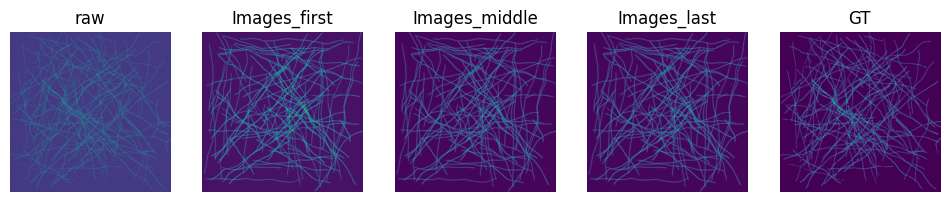

In [9]:
images_path = sn2nunet.images_path
tif_files = [f for f in os.listdir(images_path) if f.endswith('.tif')]
middle_index = len(tif_files) // 2

images_first = np.squeeze(tifffile.imread(os.path.join(images_path, tif_files[0])))
images_middle = np.squeeze(tifffile.imread(os.path.join(images_path, tif_files[middle_index])))
images_last = np.squeeze(tifffile.imread(os.path.join(images_path, tif_files[-1])))

raw = tifffile.imread('imgs/levelTWO_1.tif')
GT = tifffile.imread('imgs/gt.tif')

fig, axs = plt.subplots(1, 5, figsize=(12, 4))

axs[0].imshow(raw, cmap='viridis')
axs[0].set_title('raw')
axs[0].axis('off')

axs[1].imshow(images_first, cmap='viridis')
axs[1].set_title('Images_first')
axs[1].axis('off')

axs[2].imshow(images_middle, cmap='viridis')
axs[2].set_title('Images_middle')
axs[2].axis('off')

axs[3].imshow(images_last, cmap='viridis')
axs[3].set_title('Images_last')
axs[3].axis('off')

axs[4].imshow(GT, cmap='viridis')
axs[4].set_title('GT')
axs[4].axis('off')

plt.show()

## Display the loss curve during training.

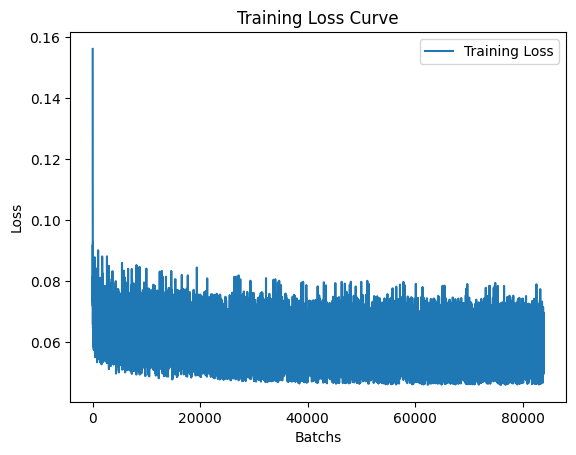

In [10]:
def plot_loss_curve(loss_history):
    plt.plot(loss_history, label='Training Loss')
    plt.title('Training Loss Curve')
    plt.xlabel('Batchs')
    plt.ylabel('Loss')
#     plt.axis('off') 
    plt.legend()
    plt.show()

parent_path = sn2nunet.parent_dir
tif_files = [f for f in os.listdir(parent_path) if f.endswith('loss.txt')]
file_path = os.path.join(parent_path, tif_files[0])
with open(file_path, 'r') as f:
    loss_history = [float(line.strip()) for line in f if line.strip()]
plot_loss_curve(loss_history)